# Answering Buiness Questions using SQL and Python

在这个项目中用到的数据库是[Chinook database](https://github.com/lerocha/chinook-database)。该数据库以SQLite数据库文件的形式提供，文件名为 `chinook.db`。Chinook数据库有点像迷你版的iTunes商店，其中包含了虚拟数字音乐商店的相关信息。 
Chinook数据库一共由11表构成，里面存储了数字音乐商店的专辑、歌曲、艺术家信息和该商店的员工、用户信息及用户订购信息。通过查询数据，在该项目中我将回答以下问题：  
- 美国地区的用户订购情况？
- 该音乐商店员工的业绩情况？
- 各个国家的用户订购情况？
- 订购整张专辑的订单占多少？
- 最受用户欢迎的艺术家是谁？

## 创建函数进行数据的初步探索  
下面将创建3个函数，用来
- 查询数据并将结果以DataFrame的格式返回
- 运行SQL命令，不返回结果
- 查询数据库中存在的所有表（Table）和视图（View）

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define a run_query() function which gets a query as the argument 
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# define a run_command() function which takes a sql command as the argument
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
#define a show_table() function to illustrate all tables and views in the chinook.db
def show_table():
    q =  '''
         SELECT
         name,
         type 
         FROM sqlite_master
         WHERE type IN ('table', 'view');
         '''
    return run_query(q)

In [3]:
show_table()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


可以看到 `chinook.db` 中一共有11个表和1个在下文中创建的视图，表名如上表所示。各个表之间的关系（schema）如下图所示：
![schema](data:image/svg+xml;base64,PHN2ZyB3aWR0aD0iMTM5MiIgaGVpZ2h0PSIxNDA4IiB2aWV3Qm94PSIwIDAgMTM5MiAxNDA4IiB2%0D%0AZXJzaW9uPSIxLjEiIHhtbG5zPSJodHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2ZyIgeG1sbnM6eGxp%0D%0Abms9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkveGxpbmsiPgo8dGl0bGU+RnJhbWU8L3RpdGxlPgo8%0D%0AZGVzYz5DcmVhdGVkIHVzaW5nIEZpZ21hPC9kZXNjPgo8ZyBpZD0iQ2FudmFzIiB0cmFuc2Zvcm09%0D%0AIm1hdHJpeCgyIDAgMCAyIDI3MDYgMTI3MikiPgo8Y2xpcFBhdGggaWQ9ImNsaXAtMCIgY2xpcC1y%0D%0AdWxlPSJldmVub2RkIj4KPHBhdGggZD0iTSAtMTM1MyAtNjM2TCAtNjU3IC02MzZMIC02NTcgNjhM%0D%0AIC0xMzUzIDY4TCAtMTM1MyAtNjM2WiIgZmlsbD0iI0ZGRkZGRiIvPgo8L2NsaXBQYXRoPgo8ZyBp%0D%0AZD0iRnJhbWUiIGNsaXAtcGF0aD0idXJsKCNjbGlwLTApIj4KPHBhdGggZD0iTSAtMTM1MyAtNjM2%0D%0ATCAtNjU3IC02MzZMIC02NTcgNjhMIC0xMzUzIDY4TCAtMTM1MyAtNjM2WiIgZmlsbD0iI0ZGRkZG%0D%0ARiIvPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDBfZmlsbCIgdHJh%0D%0AbnNmb3JtPSJ0cmFuc2xhdGUoLTc5OSAtMTcwKSIgZmlsbD0iI0YyQzk0QyIgZmlsbC1vcGFjaXR5%0D%0APSIwLjM5Ii8+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFu%0D%0Ac2xhdGUoLTc5OSAtMTcwKSIvPgo8L2c+CjxnIGlkPSJtZWRpYV90eXBlX2lkIj4KPHVzZSB4bGlu%0D%0AazpocmVmPSIjcGF0aDJfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTc5Ni4xMzYgLTE2NSki%0D%0ALz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tl%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtNzk5IC0xNDUpIi8+CjwvZz4KPGcgaWQ9Im5hbWUiPgo8%0D%0AdXNlIHhsaW5rOmhyZWY9IiNwYXRoM19maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtNzk2LjEz%0D%0ANiAtMTQwKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRo%0D%0AMF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTgwIC0xNzApIiBmaWxsPSIjRjJDOTRDIiBm%0D%0AaWxsLW9wYWNpdHk9IjAuMzkiLz4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFu%0D%0Ac2Zvcm09InRyYW5zbGF0ZSgtOTgwIC0xNzApIi8+CjwvZz4KPGcgaWQ9InRyYWNrX2lkIj4KPHVz%0D%0AZSB4bGluazpocmVmPSIjcGF0aDRfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3Ny4xMzYg%0D%0ALTE2NSkiLz4KPC9nPgo8ZyBpZD0idHJhY2siPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNV9maWxs%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3IC0xOTIpIi8+CjwvZz4KPGcgaWQ9Im1lZGlhX3R5%0D%0AcGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNl9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgt%0D%0ANzk3IC0xOTApIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3Bh%0D%0AdGgwX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC03OTkgLTUwKSIgZmlsbD0iI0YyQzk0QyIg%0D%0AZmlsbC1vcGFjaXR5PSIwLjM5Ii8+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJh%0D%0AbnNmb3JtPSJ0cmFuc2xhdGUoLTc5OSAtNTApIi8+CjwvZz4KPGcgaWQ9ImdlbnJlX2lkIj4KPHVz%0D%0AZSB4bGluazpocmVmPSIjcGF0aDdfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTc5Ni4xMzYg%0D%0ALTQ1KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9z%0D%0AdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC03OTkgLTI1KSIvPgo8L2c+CjxnIGlkPSJuYW1l%0D%0AIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDNfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTc5%0D%0ANi4xMzYgLTIwKSIvPgo8L2c+CjxnIGlkPSJnZW5yZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg4%0D%0AX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC03OTcgLTcwKSIvPgo8L2c+CjxnIGlkPSJSZWN0%0D%0AYW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNs%0D%0AYXRlKC05ODAgLTE0NSkiLz4KPC9nPgo8ZyBpZD0ibmFtZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3Bh%0D%0AdGgzX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05NzcuMTM2IC0xNDApIi8+CjwvZz4KPGcg%0D%0AaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3Jt%0D%0APSJ0cmFuc2xhdGUoLTk4MCAtMTIwKSIvPgo8L2c+CjxnIGlkPSJhbGJ1bV9pZCI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGg5X2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05NzcuMTM2IC0xMTUp%0D%0AIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9r%0D%0AZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk4MCAtOTUpIi8+CjwvZz4KPGcgaWQ9Im1lZGlhX3R5%0D%0AcGVfaWQiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMl9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0%0D%0AZSgtOTc3LjEzNiAtOTApIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJl%0D%0AZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk4MCAtNzApIi8+CjwvZz4K%0D%0APGcgaWQ9ImdlbnJlX2lkIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDdfZmlsbCIgdHJhbnNmb3Jt%0D%0APSJ0cmFuc2xhdGUoLTk3Ny4xMzYgLTY1KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNl%0D%0AIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTQ1%0D%0AKSIvPgo8L2c+CjxnIGlkPSJjb21wb3NlciI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxMF9maWxs%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3LjEzNiAtNDApIi8+CjwvZz4KPGcgaWQ9IlJlY3Rh%0D%0AbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xh%0D%0AdGUoLTk4MCAtMjApIi8+CjwvZz4KPGcgaWQ9Im1pbGxpc2Vjb25kcyI+Cjx1c2UgeGxpbms6aHJl%0D%0AZj0iI3BhdGgxMV9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3LjEzNiAtMTUpIi8+Cjwv%0D%0AZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJh%0D%0AbnNmb3JtPSJ0cmFuc2xhdGUoLTk4MCA1KSIvPgo8L2c+CjxnIGlkPSJieXRlcyI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGgxMl9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3LjEzNiAxMCki%0D%0ALz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tl%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTgwIDMwKSIvPgo8L2c+CjxnIGlkPSJ1bml0X3ByaWNl%0D%0AIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDEzX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05%0D%0ANzcuMTM2IDM1KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNw%0D%0AYXRoMF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTgwIC0zMzMpIiBmaWxsPSIjRjJDOTRD%0D%0AIiBmaWxsLW9wYWNpdHk9IjAuMzkiLz4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0%0D%0AcmFuc2Zvcm09InRyYW5zbGF0ZSgtOTgwIC0zMzMpIi8+CjwvZz4KPGcgaWQ9Imludm9pY2VfbGlu%0D%0AZV9pZCI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxNF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0%0D%0AZSgtOTc3LjEzNiAtMzI4KSIvPgo8L2c+CjxnIGlkPSJpbnZvaWNlX2xpbmUiPgo8dXNlIHhsaW5r%0D%0AOmhyZWY9IiNwYXRoMTVfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3NyAtMzU1KSIvPgo8%0D%0AL2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRy%0D%0AYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTMwOCkiLz4KPC9nPgo8ZyBpZD0iaW52b2ljZV9pZCI+%0D%0ACjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxNl9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3%0D%0ALjEzNiAtMzAzKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNw%0D%0AYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTI4MykiLz4KPC9nPgo8ZyBp%0D%0AZD0idHJhY2tfaWQiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNF9maWxsIiB0cmFuc2Zvcm09InRy%0D%0AYW5zbGF0ZSgtOTc3LjEzNiAtMjc4KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhs%0D%0AaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTI1OCki%0D%0ALz4KPC9nPgo8ZyBpZD0idW5pdF9wcmljZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxM19maWxs%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3LjEzNiAtMjUzKSIvPgo8L2c+CjxnIGlkPSJSZWN0%0D%0AYW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNs%0D%0AYXRlKC05ODAgLTIzMykiLz4KPC9nPgo8ZyBpZD0icXVhbnRpdHkiPgo8dXNlIHhsaW5rOmhyZWY9%0D%0AIiNwYXRoMTdfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3Ny4xMzYgLTIyOCkiLz4KPC9n%0D%0APgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDBfZmlsbCIgdHJhbnNm%0D%0Ab3JtPSJ0cmFuc2xhdGUoLTk4MCAtNjAxKSIgZmlsbD0iI0YyQzk0QyIgZmlsbC1vcGFjaXR5PSIw%0D%0ALjM5Ii8+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xh%0D%0AdGUoLTk4MCAtNjAxKSIvPgo8L2c+CjxnIGlkPSJpbnZvaWNlX2lkIj4KPHVzZSB4bGluazpocmVm%0D%0APSIjcGF0aDE2X2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05NzcuMTM2IC01OTYpIi8+Cjwv%0D%0AZz4KPGcgaWQ9Imludm9pY2UiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMThfZmlsbCIgdHJhbnNm%0D%0Ab3JtPSJ0cmFuc2xhdGUoLTk3NyAtNjIzKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNl%0D%0AIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTU3%0D%0ANikiLz4KPC9nPgo8ZyBpZD0iY3VzdG9tZXJfaWQiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMTlf%0D%0AZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3Ny4xMzYgLTU3MSkiLz4KPC9nPgo8ZyBpZD0i%0D%0AUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRy%0D%0AYW5zbGF0ZSgtOTgwIC01NTEpIi8+CjwvZz4KPGcgaWQ9Imludm9pY2VfZGF0ZSI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGgyMF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3LjEzNiAtNTQ2%0D%0AKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJv%0D%0Aa2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTUyNikiLz4KPC9nPgo8ZyBpZD0iYmlsbGlu%0D%0AZ19hZGRyZXNzIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDIxX2ZpbGwiIHRyYW5zZm9ybT0idHJh%0D%0AbnNsYXRlKC05NzcuMTM2IC01MjEpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk4MCAtNTAxKSIv%0D%0APgo8L2c+CjxnIGlkPSJiaWxsaW5nX2NpdHkiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMjJfZmls%0D%0AbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3Ny4xMzYgLTQ5NikiLz4KPC9nPgo8ZyBpZD0iUmVj%0D%0AdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5z%0D%0AbGF0ZSgtOTgwIC00NzYpIi8+CjwvZz4KPGcgaWQ9ImJpbGxpbmdfc3RhdGUiPgo8dXNlIHhsaW5r%0D%0AOmhyZWY9IiNwYXRoMjNfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3Ny4xMzYgLTQ3MSki%0D%0ALz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tl%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTgwIC00NTEpIi8+CjwvZz4KPGcgaWQ9ImJpbGxpbmdf%0D%0AY291bnRyeSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgyNF9maWxsIiB0cmFuc2Zvcm09InRyYW5z%0D%0AbGF0ZSgtOTc3LjEzNiAtNDQ2KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5r%0D%0AOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC05ODAgLTQyNikiLz4K%0D%0APC9nPgo8ZyBpZD0iYmlsbGluZ19wb3N0YWxfY29kZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgy%0D%0ANV9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTc3LjEzNiAtNDIxKSIvPgo8L2c+CjxnIGlk%0D%0APSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0i%0D%0AdHJhbnNsYXRlKC05ODAgLTQwMSkiLz4KPC9nPgo8ZyBpZD0idG90YWwiPgo8dXNlIHhsaW5rOmhy%0D%0AZWY9IiNwYXRoMjZfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTk3Ny4xMzYgLTM5NikiLz4K%0D%0APC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDBfZmlsbCIgdHJh%0D%0AbnNmb3JtPSJ0cmFuc2xhdGUoLTExNTIgLTYwMSkiIGZpbGw9IiNGMkM5NEMiIGZpbGwtb3BhY2l0%0D%0AeT0iMC4zOSIvPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJh%0D%0AbnNsYXRlKC0xMTUyIC02MDEpIi8+CjwvZz4KPGcgaWQ9ImN1c3RvbWVyX2lkIj4KPHVzZSB4bGlu%0D%0AazpocmVmPSIjcGF0aDE5X2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTQ5LjE0IC01OTYp%0D%0AIi8+CjwvZz4KPGcgaWQ9ImN1c3RvbWVyIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDI3X2ZpbGwi%0D%0AIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTQ5IC02MjMpIi8+CjwvZz4KPGcgaWQ9IlJlY3Rhbmds%0D%0AZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUo%0D%0ALTExNTIgLTU3NikiLz4KPC9nPgo8ZyBpZD0iZmlyc3RfbmFtZSI+Cjx1c2UgeGxpbms6aHJlZj0i%0D%0AI3BhdGgyOF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE0OS4xNCAtNTcxKSIvPgo8L2c+%0D%0ACjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5z%0D%0AZm9ybT0idHJhbnNsYXRlKC0xMTUyIC01NTEpIi8+CjwvZz4KPGcgaWQ9Imxhc3RfbmFtZSI+Cjx1%0D%0Ac2UgeGxpbms6aHJlZj0iI3BhdGgyOV9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE0OS4x%0D%0ANCAtNTQ2KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRo%0D%0AMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTUyIC01MjYpIi8+CjwvZz4KPGcgaWQ9%0D%0AImNvbXBhbnkiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMzBfZmlsbCIgdHJhbnNmb3JtPSJ0cmFu%0D%0Ac2xhdGUoLTExNDkuMTQgLTUyMSkiLz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGlu%0D%0AazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1MiAtNTAxKSIv%0D%0APgo8L2c+CjxnIGlkPSJhZGRyZXNzIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDMxX2ZpbGwiIHRy%0D%0AYW5zZm9ybT0idHJhbnNsYXRlKC0xMTQ5LjE0IC00OTYpIi8+CjwvZz4KPGcgaWQ9IlJlY3Rhbmds%0D%0AZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUo%0D%0ALTExNTIgLTQ3NikiLz4KPC9nPgo8ZyBpZD0iY2l0eSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgz%0D%0AMl9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE0OS4xNCAtNDcxKSIvPgo8L2c+CjxnIGlk%0D%0APSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0i%0D%0AdHJhbnNsYXRlKC0xMTUyIC00NTEpIi8+CjwvZz4KPGcgaWQ9InN0YXRlIj4KPHVzZSB4bGluazpo%0D%0AcmVmPSIjcGF0aDMzX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTQ5LjE0IC00NDYpIi8+%0D%0ACjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIg%0D%0AdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNTIgLTQyNikiLz4KPC9nPgo8ZyBpZD0iY291bnRyeSI+%0D%0ACjx1c2UgeGxpbms6aHJlZj0iI3BhdGgzNF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE0%0D%0AOS4xNCAtNDIxKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNw%0D%0AYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTUyIC00MDEpIi8+CjwvZz4KPGcg%0D%0AaWQ9InBvc3RhbF9jb2RlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDM1X2ZpbGwiIHRyYW5zZm9y%0D%0AbT0idHJhbnNsYXRlKC0xMTQ5LjE0IC0zOTYpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1%0D%0Ac2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNTIg%0D%0ALTM3NikiLz4KPC9nPgo8ZyBpZD0icGhvbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMzZfZmls%0D%0AbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNDkuMTQgLTM3MSkiLz4KPC9nPgo8ZyBpZD0iUmVj%0D%0AdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5z%0D%0AbGF0ZSgtMTE1MiAtMzUxKSIvPgo8L2c+CjxnIGlkPSJmYXgiPgo8dXNlIHhsaW5rOmhyZWY9IiNw%0D%0AYXRoMzdfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNDkuMTQgLTM0NikiLz4KPC9nPgo8%0D%0AZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zv%0D%0Acm09InRyYW5zbGF0ZSgtMTE1MiAtMzI2KSIvPgo8L2c+CjxnIGlkPSJlbWFpbCI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGgzOF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE0OS4xNCAtMzIx%0D%0AKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJv%0D%0Aa2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI5IC0yNzYpIi8+CjwvZz4KPGcgaWQ9ImZheCI+%0D%0ACjx1c2UgeGxpbms6aHJlZj0iI3BhdGgzN19maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMy%0D%0ANi4xNCAtMjcxKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNw%0D%0AYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI5IC0yNTEpIi8+CjwvZz4KPGcg%0D%0AaWQ9ImVtYWlsIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDM4X2ZpbGwiIHRyYW5zZm9ybT0idHJh%0D%0AbnNsYXRlKC0xMzI2LjE0IC0yNDYpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNTIgLTMwMSki%0D%0ALz4KPC9nPgo8ZyBpZD0ic3VwcG9ydF9yZXBfaWQiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMzlf%0D%0AZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNDkuMTQgLTI5NikiLz4KPC9nPgo8ZyBpZD0i%0D%0AUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDBfZmlsbCIgdHJhbnNmb3JtPSJ0cmFu%0D%0Ac2xhdGUoLTEzMjkgLTYwMSkiIGZpbGw9IiNGMkM5NEMiIGZpbGwtb3BhY2l0eT0iMC4zOSIvPgo8%0D%0AdXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI5%0D%0AIC02MDEpIi8+CjwvZz4KPGcgaWQ9ImVtcGxveWVlX2lkIj4KPHVzZSB4bGluazpocmVmPSIjcGF0%0D%0AaDQwX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI2LjE0IC01OTYpIi8+CjwvZz4KPGcg%0D%0AaWQ9ImVtcGxveWVlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDQxX2ZpbGwiIHRyYW5zZm9ybT0i%0D%0AdHJhbnNsYXRlKC0xMzI2IC02MjMpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEzMjkgLTU3Niki%0D%0ALz4KPC9nPgo8ZyBpZD0ibGFzdF9uYW1lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDI5X2ZpbGwi%0D%0AIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI2LjE0IC01NzEpIi8+CjwvZz4KPGcgaWQ9IlJlY3Rh%0D%0AbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xh%0D%0AdGUoLTEzMjkgLTU1MSkiLz4KPC9nPgo8ZyBpZD0iZmlyc3RfbmFtZSI+Cjx1c2UgeGxpbms6aHJl%0D%0AZj0iI3BhdGgyOF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMyNi4xNCAtNTQ2KSIvPgo8%0D%0AL2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRy%0D%0AYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI5IC01MjYpIi8+CjwvZz4KPGcgaWQ9InRpdGxlIj4KPHVz%0D%0AZSB4bGluazpocmVmPSIjcGF0aDQyX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI2LjE0%0D%0AIC01MjEpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgx%0D%0AX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEzMjkgLTUwMSkiLz4KPC9nPgo8ZyBpZD0i%0D%0AcmVwb3J0c190byI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0M19maWxsIiB0cmFuc2Zvcm09InRy%0D%0AYW5zbGF0ZSgtMTMyNi4xNCAtNDk2KSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhs%0D%0AaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI5IC00NzYp%0D%0AIi8+CjwvZz4KPGcgaWQ9ImJpcnRoZGF0ZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0NF9maWxs%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMyNi4xNCAtNDcxKSIvPgo8L2c+CjxnIGlkPSJSZWN0%0D%0AYW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNs%0D%0AYXRlKC0xMzI5IC00NTEpIi8+CjwvZz4KPGcgaWQ9ImhpcmVfZGF0ZSI+Cjx1c2UgeGxpbms6aHJl%0D%0AZj0iI3BhdGg0NV9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMyNi4xNCAtNDQ2KSIvPgo8%0D%0AL2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRy%0D%0AYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI5IC00MjYpIi8+CjwvZz4KPGcgaWQ9ImFkZHJlc3MiPgo8%0D%0AdXNlIHhsaW5rOmhyZWY9IiNwYXRoMzFfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEzMjYu%0D%0AMTQgLTQyMSkiLz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0%0D%0AaDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMyOSAtNDAxKSIvPgo8L2c+CjxnIGlk%0D%0APSJjaXR5Ij4KPHVzZSB4bGluazpocmVmPSIjcGF0aDMyX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNs%0D%0AYXRlKC0xMzI2LjE0IC0zOTYpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6%0D%0AaHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEzMjkgLTM3NikiLz4K%0D%0APC9nPgo8ZyBpZD0ic3RhdGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMzNfZmlsbCIgdHJhbnNm%0D%0Ab3JtPSJ0cmFuc2xhdGUoLTEzMjYuMTQgLTM3MSkiLz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4K%0D%0APHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMy%0D%0AOSAtMzUxKSIvPgo8L2c+CjxnIGlkPSJjb3VudHJ5Ij4KPHVzZSB4bGluazpocmVmPSIjcGF0aDM0%0D%0AX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzI2LjE0IC0zNDYpIi8+CjwvZz4KPGcgaWQ9%0D%0AIlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0%0D%0AcmFuc2xhdGUoLTEzMjkgLTMyNikiLz4KPC9nPgo8ZyBpZD0icG9zdGFsX2NvZGUiPgo8dXNlIHhs%0D%0AaW5rOmhyZWY9IiNwYXRoMzVfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEzMjYuMTQgLTMy%0D%0AMSkiLz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ry%0D%0Ab2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMyOSAtMzAxKSIvPgo8L2c+CjxnIGlkPSJwaG9u%0D%0AZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgzNl9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgt%0D%0AMTMyNi4xNCAtMjk2KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0%0D%0AaDQ2X3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTg1NCAtODIpIi8+CjwvZz4KPGcgaWQ9%0D%0AIkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNDZfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5z%0D%0AbGF0ZSgtODExIC0xNTcpIi8+CjwvZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNw%0D%0AYXRoNDdfc3Ryb2tlIiB0cmFuc2Zvcm09Im1hdHJpeCgtMC4zOTgyODUgMC45MTcyNjIgLTAuOTE3%0D%0AMjYyIC0wLjM5ODI4NSAtODExIC0xNTkpIi8+CjwvZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5r%0D%0AOmhyZWY9IiNwYXRoNDhfc3Ryb2tlIiB0cmFuc2Zvcm09Im1hdHJpeCgtMC44NjgyNDMgLTAuNDk2%0D%0AMTM5IDAuNDk2MTM5IC0wLjg2ODI0MyAtODEwLjUgLTM3KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4K%0D%0APHVzZSB4bGluazpocmVmPSIjcGF0aDQ2X3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTgx%0D%0AMSAtMzYpIi8+CjwvZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNDZfc3Ry%0D%0Ab2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtODU0IC01NykiLz4KPC9nPgo8ZyBpZD0iTGluZSI+%0D%0ACjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0OV9zdHJva2UiIHRyYW5zZm9ybT0ibWF0cml4KDEgLTIu%0D%0ANDQ5MjllLTE2IDIuNDQ5MjllLTE2IDEgLTk5MSAtMTU3KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4K%0D%0APHVzZSB4bGluazpocmVmPSIjcGF0aDUwX3N0cm9rZSIgdHJhbnNmb3JtPSJtYXRyaXgoLTQuMzcx%0D%0AMTRlLTA4IC0xIDEgLTQuMzcxMTRlLTA4IC05ODkgLTE1NykiLz4KPC9nPgo8ZyBpZD0iTGluZSI+%0D%0ACjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0Nl9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0x%0D%0AMDMxIC0xMzIpIi8+CjwvZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNDZf%0D%0Ac3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTkyIC0xMDYpIi8+CjwvZz4KPGcgaWQ9Ikxp%0D%0AbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNDZfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0%0D%0AZSgtMTAzMSAtMzUpIi8+CjwvZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRo%0D%0ANTFfc3Ryb2tlIiB0cmFuc2Zvcm09Im1hdHJpeCgwLjc2ODIyMSAtMC42NDAxODQgMC42NDAxODQg%0D%0AMC43NjgyMjEgLTEwMTkgLTEzMikiLz4KPC9nPgo8ZyBpZD0iTGluZSI+Cjx1c2UgeGxpbms6aHJl%0D%0AZj0iI3BhdGg0OV9zdHJva2UiIHRyYW5zZm9ybT0ibWF0cml4KDEgLTIuNDQ5MjllLTE2IDIuNDQ5%0D%0AMjllLTE2IDEgLTk5MSAtMjcwKSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVm%0D%0APSIjcGF0aDQ5X3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTg1NCAtMjk1KSIvPgo8L2c+%0D%0ACjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDUyX3N0cm9rZSIgdHJhbnNmb3Jt%0D%0APSJtYXRyaXgoNC4zNTYzMmUtMDggMSAtMSA0LjM1NjMyZS0wOCAtODQzIC01OTApIi8+CjwvZz4K%0D%0APGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNDZfc3Ryb2tlIiB0cmFuc2Zvcm09%0D%0AInRyYW5zbGF0ZSgtODU0IC01ODgpIi8+CjwvZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhy%0D%0AZWY9IiNwYXRoNDlfc3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtOTkxIC01NjMpIi8+Cjwv%0D%0AZz4KPGcgaWQ9IkxpbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNDlfc3Ryb2tlIiB0cmFuc2Zv%0D%0Acm09InRyYW5zbGF0ZSgtMTAyNiAtNTg2KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGlu%0D%0AazpocmVmPSIjcGF0aDQ5X3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEwMjYgLTU4Niki%0D%0ALz4KPC9nPgo8ZyBpZD0iTGluZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg1M19zdHJva2UiIHRy%0D%0AYW5zZm9ybT0ibWF0cml4KC0wLjc0ODk5NyAtMC42NjI1NzQgMC42NjI1NzQgLTAuNzQ4OTk3IC05%0D%0AODkgLTU2NSkiLz4KPC9nPgo8ZyBpZD0iTGluZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0OV9z%0D%0AdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMjAzIC01ODYpIi8+CjwvZz4KPGcgaWQ9Ikxp%0D%0AbmUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoNTRfc3Ryb2tlIiB0cmFuc2Zvcm09Im1hdHJpeCgt%0D%0AMC4xMDE3NzkgLTAuOTk0ODA3IDAuOTk0ODA3IC0wLjEwMTc3OSAtMTE2MSAtMjg1KSIvPgo8L2c+%0D%0ACjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDQ5X3N0cm9rZSIgdHJhbnNmb3Jt%0D%0APSJ0cmFuc2xhdGUoLTEzNDAgLTU4NikiLz4KPC9nPgo8ZyBpZD0iTGluZSI+Cjx1c2UgeGxpbms6%0D%0AaHJlZj0iI3BhdGg0OV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTY4IDE2KSIvPgo8%0D%0AL2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDQ5X3N0cm9rZSIgdHJhbnNm%0D%0Ab3JtPSJ0cmFuc2xhdGUoLTEyMDggLTM2KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGlu%0D%0AazpocmVmPSIjcGF0aDU1X3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEyMDggLTE1Niki%0D%0ALz4KPC9nPgo8ZyBpZD0iTGluZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg1Nl9zdHJva2UiIHRy%0D%0AYW5zZm9ybT0ibWF0cml4KC0wLjUwNDg4MyAtMC44NjMxODggMC44NjMxODggLTAuNTA0ODgzIC0x%0D%0AMTY2IDE1KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDU3X3N0%0D%0Acm9rZSIgdHJhbnNmb3JtPSJtYXRyaXgoNi4xMjMyM2UtMTcgMSAtMSA2LjEyMzIzZS0xNyAtMTM0%0D%0AMCAtNTg2KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDQ5X3N0%0D%0Acm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTEzNDAgLTQ4OCkiLz4KPC9nPgo8ZyBpZD0iTGlu%0D%0AZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0OV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRl%0D%0AKC0xMTYzIC0yODUpIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0i%0D%0AI3BhdGgwX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTU3IC0xNzApIiBmaWxsPSIjRjJD%0D%0AOTRDIiBmaWxsLW9wYWNpdHk9IjAuMzkiLz4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tl%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1NyAtMTcwKSIvPgo8L2c+CjxnIGlkPSJwbGF5bGlz%0D%0AdF9pZCI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg1OF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0%0D%0AZSgtMTE1NC4xNCAtMTY1KSIvPgo8L2c+CjxnIGlkPSJwbGF5bGlzdF90cmFjayI+Cjx1c2UgeGxp%0D%0Abms6aHJlZj0iI3BhdGg1OV9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1NCAtMTkyKSIv%0D%0APgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMF9maWxsIiB0%0D%0AcmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1NyAtMTQ1KSIgZmlsbD0iI0YyQzk0QyIgZmlsbC1vcGFj%0D%0AaXR5PSIwLjM5Ii8+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0%0D%0AcmFuc2xhdGUoLTExNTcgLTE0NSkiLz4KPC9nPgo8ZyBpZD0idHJhY2tfaWQiPgo8dXNlIHhsaW5r%0D%0AOmhyZWY9IiNwYXRoNF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1NC4xNCAtMTQwKSIv%0D%0APgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMF9maWxsIiB0%0D%0AcmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1NyAtNDgpIiBmaWxsPSIjRjJDOTRDIiBmaWxsLW9wYWNp%0D%0AdHk9IjAuMzkiLz4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tlIiB0cmFuc2Zvcm09InRy%0D%0AYW5zbGF0ZSgtMTE1NyAtNDgpIi8+CjwvZz4KPGcgaWQ9ImFsYnVtX2lkIj4KPHVzZSB4bGluazpo%0D%0AcmVmPSIjcGF0aDlfZmlsbCIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNTQuMTQgLTQzKSIvPgo8%0D%0AL2c+CjxnIGlkPSJhbGJ1bSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg2MF9maWxsIiB0cmFuc2Zv%0D%0Acm09InRyYW5zbGF0ZSgtMTE1NCAtNzApIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2Ug%0D%0AeGxpbms6aHJlZj0iI3BhdGgxX3N0cm9rZSIgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoLTExNTcgLTIz%0D%0AKSIvPgo8L2c+CjxnIGlkPSJ0aXRsZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg0Ml9maWxsIiB0%0D%0AcmFuc2Zvcm09InRyYW5zbGF0ZSgtMTE1NC4xNCAtMTgpIi8+CjwvZz4KPGcgaWQ9IlJlY3Rhbmds%0D%0AZSI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGgwX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0x%0D%0AMzM0IC01MCkiIGZpbGw9IiNGMkM5NEMiIGZpbGwtb3BhY2l0eT0iMC4zOSIvPgo8dXNlIHhsaW5r%0D%0AOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzM0IC01MCkiLz4K%0D%0APC9nPgo8ZyBpZD0iYXJ0aXN0X2lkIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDYxX2ZpbGwiIHRy%0D%0AYW5zZm9ybT0idHJhbnNsYXRlKC0xMzMxLjE0IC00NSkiLz4KPC9nPgo8ZyBpZD0iYXJ0aXN0Ij4K%0D%0APHVzZSB4bGluazpocmVmPSIjcGF0aDYyX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzMx%0D%0AIC03MikiLz4KPC9nPgo8ZyBpZD0iUmVjdGFuZ2xlIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFf%0D%0Ac3Ryb2tlIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMzNCAtMjUpIi8+CjwvZz4KPGcgaWQ9Im5h%0D%0AbWUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoM19maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgt%0D%0AMTMzMS4xNCAtMjApIi8+CjwvZz4KPGcgaWQ9IlJlY3RhbmdsZSI+Cjx1c2UgeGxpbms6aHJlZj0i%0D%0AI3BhdGgwX2ZpbGwiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMzM0IC0xNzApIiBmaWxsPSIjRjJD%0D%0AOTRDIiBmaWxsLW9wYWNpdHk9IjAuMzkiLz4KPHVzZSB4bGluazpocmVmPSIjcGF0aDFfc3Ryb2tl%0D%0AIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMzNCAtMTcwKSIvPgo8L2c+CjxnIGlkPSJwbGF5bGlz%0D%0AdF9pZCI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg1OF9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0%0D%0AZSgtMTMzMS4xNCAtMTY1KSIvPgo8L2c+CjxnIGlkPSJwbGF5bGlzdCI+Cjx1c2UgeGxpbms6aHJl%0D%0AZj0iI3BhdGg2M19maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMzMSAtMTkyKSIvPgo8L2c+%0D%0ACjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJva2UiIHRyYW5z%0D%0AZm9ybT0idHJhbnNsYXRlKC0xMzM0IC0xNDUpIi8+CjwvZz4KPGcgaWQ9Im5hbWUiPgo8dXNlIHhs%0D%0AaW5rOmhyZWY9IiNwYXRoM19maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgtMTMzMS4xNCAtMTQw%0D%0AKSIvPgo8L2c+CjxnIGlkPSJSZWN0YW5nbGUiPgo8dXNlIHhsaW5rOmhyZWY9IiNwYXRoMV9zdHJv%0D%0Aa2UiIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0xMTU3IDIpIi8+CjwvZz4KPGcgaWQ9ImFydGlzdF9p%0D%0AZCI+Cjx1c2UgeGxpbms6aHJlZj0iI3BhdGg2MV9maWxsIiB0cmFuc2Zvcm09InRyYW5zbGF0ZSgt%0D%0AMTE1NC4xNCA3KSIvPgo8L2c+CjxnIGlkPSJMaW5lIj4KPHVzZSB4bGluazpocmVmPSIjcGF0aDY0%0D%0AX3N0cm9rZSIgdHJhbnNmb3JtPSJtYXRyaXgoMC4zNzM2MTEgLTAuOTI3NTg2IDAuOTI3NTg2IDAu%0D%0AMzczNjExIC0xMDE5IC0zNSkiLz4KPC9nPgo8L2c+CjwvZz4KPGRlZnM+CjxwYXRoIGlkPSJwYXRo%0D%0AMF9maWxsIiBkPSJNIDAgMEwgMTI2IDBMIDEyNiAyNUwgMCAyNUwgMCAwWiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDFfc3Ryb2tlIiBkPSJNIDAgMEwgMCAtMC41TCAtMC41IC0wLjVMIC0wLjUgMEwgMCAwWk0g%0D%0AMTI2IDBMIDEyNi41IDBMIDEyNi41IC0wLjVMIDEyNiAtMC41TCAxMjYgMFpNIDEyNiAyNUwgMTI2%0D%0AIDI1LjVMIDEyNi41IDI1LjVMIDEyNi41IDI1TCAxMjYgMjVaTSAwIDI1TCAtMC41IDI1TCAtMC41%0D%0AIDI1LjVMIDAgMjUuNUwgMCAyNVpNIDAgMC41TCAxMjYgMC41TCAxMjYgLTAuNUwgMCAtMC41TCAw%0D%0AIDAuNVpNIDEyNS41IDBMIDEyNS41IDI1TCAxMjYuNSAyNUwgMTI2LjUgMEwgMTI1LjUgMFpNIDEy%0D%0ANiAyNC41TCAwIDI0LjVMIDAgMjUuNUwgMTI2IDI1LjVMIDEyNiAyNC41Wk0gMC41IDI1TCAwLjUg%0D%0AMEwgLTAuNSAwTCAtMC41IDI1TCAwLjUgMjVaIi8+CjxwYXRoIGlkPSJwYXRoMl9maWxsIiBkPSJN%0D%0AIDE4LjQ2OTUgNS42MDM1MkwgMTguNTAzNiA2LjQyMzgzQyAxOS4wNDYgNS43ODU4MSAxOS43Nzc0%0D%0AIDUuNDY2OCAyMC42OTggNS40NjY4QyAyMS43MzI1IDUuNDY2OCAyMi40MzY2IDUuODYzMjggMjIu%0D%0AODEwMyA2LjY1NjI1QyAyMy4wNTY0IDYuMzAwNzggMjMuMzc1NCA2LjAxMzY3IDIzLjc2NzMgNS43%0D%0AOTQ5MkMgMjQuMTYzOCA1LjU3NjE3IDI0LjYzMDkgNS40NjY4IDI1LjE2ODcgNS40NjY4QyAyNi43%0D%0AOTExIDUuNDY2OCAyNy42MTU5IDYuMzI1ODUgMjcuNjQzMyA4LjA0Mzk1TCAyNy42NDMzIDEzTCAy%0D%0ANi4zNzg2IDEzTCAyNi4zNzg2IDguMTE5MTRDIDI2LjM3ODYgNy41OTA0OSAyNi4yNTc5IDcuMTk2%0D%0AMjkgMjYuMDE2MyA2LjkzNjUyQyAyNS43NzQ4IDYuNjcyMiAyNS4zNjkyIDYuNTQwMDQgMjQuNzk5%0D%0ANSA2LjU0MDA0QyAyNC4zMzAxIDYuNTQwMDQgMjMuOTQwNSA2LjY4MTMyIDIzLjYzMDYgNi45NjM4%0D%0AN0MgMjMuMzIwNyA3LjI0MTg2IDIzLjE0MDcgNy42MTc4NCAyMy4wOTA2IDguMDkxOEwgMjMuMDkw%0D%0ANiAxM0wgMjEuODE5MSAxM0wgMjEuODE5MSA4LjE1MzMyQyAyMS44MTkxIDcuMDc3OCAyMS4yOTI3%0D%0AIDYuNTQwMDQgMjAuMjQgNi41NDAwNEMgMTkuNDEwNSA2LjU0MDA0IDE4Ljg0MzIgNi44OTMyMyAx%0D%0AOC41Mzc4IDcuNTk5NjFMIDE4LjUzNzggMTNMIDE3LjI3MzIgMTNMIDE3LjI3MzIgNS42MDM1Mkwg%0D%0AMTguNDY5NSA1LjYwMzUyWk0gMzIuNjI2NyAxMy4xMzY3QyAzMS42MjQxIDEzLjEzNjcgMzAuODA4%0D%0AMyAxMi44MDg2IDMwLjE3OTQgMTIuMTUyM0MgMjkuNTUwNSAxMS40OTE1IDI5LjIzNjEgMTAuNjA5%0D%0ANyAyOS4yMzYxIDkuNTA2ODRMIDI5LjIzNjEgOS4yNzQ0MUMgMjkuMjM2MSA4LjU0MDY5IDI5LjM3%0D%0ANTEgNy44ODY3MiAyOS42NTMxIDcuMzEyNUMgMjkuOTM1NiA2LjczMzcyIDMwLjMyNzUgNi4yODI1%0D%0ANSAzMC44Mjg4IDUuOTU4OThDIDMxLjMzNDcgNS42MzA4NiAzMS44ODE2IDUuNDY2OCAzMi40Njk1%0D%0AIDUuNDY2OEMgMzMuNDMxIDUuNDY2OCAzNC4xNzg0IDUuNzgzNTMgMzQuNzExNiA2LjQxNjk5QyAz%0D%0ANS4yNDQ5IDcuMDUwNDYgMzUuNTExNSA3Ljk1NzM2IDM1LjUxMTUgOS4xMzc3TCAzNS41MTE1IDku%0D%0ANjY0MDZMIDMwLjUwMDcgOS42NjQwNkMgMzAuNTE4OSAxMC4zOTMyIDMwLjczMDkgMTAuOTgzNCAz%0D%0AMS4xMzY1IDExLjQzNDZDIDMxLjU0NjYgMTEuODgxMiAzMi4wNjYxIDEyLjEwNDUgMzIuNjk1IDEy%0D%0ALjEwNDVDIDMzLjE0MTcgMTIuMTA0NSAzMy41MTk5IDEyLjAxMzMgMzMuODI5OCAxMS44MzExQyAz%0D%0ANC4xMzk3IDExLjY0ODggMzQuNDEwOSAxMS40MDcyIDM0LjY0MzMgMTEuMTA2NEwgMzUuNDE1NyAx%0D%0AMS43MDhDIDM0Ljc5NiAxMi42NjA1IDMzLjg2NjMgMTMuMTM2NyAzMi42MjY3IDEzLjEzNjdaTSAz%0D%0AMi40Njk1IDYuNTA1ODZDIDMxLjk1OSA2LjUwNTg2IDMxLjUzMDcgNi42OTI3MSAzMS4xODQzIDcu%0D%0AMDY2NDFDIDMwLjgzNzkgNy40MzU1NSAzMC42MjM4IDcuOTU1MDggMzAuNTQxNyA4LjYyNUwgMzQu%0D%0AMjQ2OCA4LjYyNUwgMzQuMjQ2OCA4LjUyOTNDIDM0LjIxMDMgNy44ODY3MiAzNC4wMzcyIDcuMzg5%0D%0AOTcgMzMuNzI3MyA3LjAzOTA2QyAzMy40MTc0IDYuNjgzNTkgMzIuOTk4MSA2LjUwNTg2IDMyLjQ2%0D%0AOTUgNi41MDU4NlpNIDM2LjY3MzYgOS4yNDAyM0MgMzYuNjczNiA4LjEwNTQ3IDM2Ljk0MjQgNy4x%0D%0AOTQwMSAzNy40ODAyIDYuNTA1ODZDIDM4LjAxOCA1LjgxMzE1IDM4LjcyMjEgNS40NjY4IDM5LjU5%0D%0AMjUgNS40NjY4QyA0MC40NTg0IDUuNDY2OCA0MS4xNDQzIDUuNzYzMDIgNDEuNjUwMSA2LjM1NTQ3%0D%0ATCA0MS42NTAxIDIuNUwgNDIuOTE0OCAyLjVMIDQyLjkxNDggMTNMIDQxLjc1MjcgMTNMIDQxLjY5%0D%0AMTEgMTIuMjA3QyA0MS4xODUzIDEyLjgyNjggNDAuNDgxMiAxMy4xMzY3IDM5LjU3ODggMTMuMTM2%0D%0AN0MgMzguNzIyMSAxMy4xMzY3IDM4LjAyMjUgMTIuNzg1OCAzNy40ODAyIDEyLjA4NEMgMzYuOTQy%0D%0ANCAxMS4zODIyIDM2LjY3MzYgMTAuNDY2MSAzNi42NzM2IDkuMzM1OTRMIDM2LjY3MzYgOS4yNDAy%0D%0AM1pNIDM3LjkzODIgOS4zODM3OUMgMzcuOTM4MiAxMC4yMjIzIDM4LjExMTQgMTAuODc4NiAzOC40%0D%0ANTc3IDExLjM1MjVDIDM4LjgwNDEgMTEuODI2NSAzOS4yODI2IDEyLjA2MzUgMzkuODkzMyAxMi4w%0D%0ANjM1QyA0MC42OTU0IDEyLjA2MzUgNDEuMjgxIDExLjcwMzUgNDEuNjUwMSAxMC45ODM0TCA0MS42%0D%0ANTAxIDcuNTg1OTRDIDQxLjI3MTkgNi44ODg2NyA0MC42OTA4IDYuNTQwMDQgMzkuOTA3IDYuNTQw%0D%0AMDRDIDM5LjI4NzIgNi41NDAwNCAzOC44MDQxIDYuNzc5MyAzOC40NTc3IDcuMjU3ODFDIDM4LjEx%0D%0AMTQgNy43MzYzMyAzNy45MzgyIDguNDQ0OTkgMzcuOTM4MiA5LjM4Mzc5Wk0gNDYuMjU3NSAxM0wg%0D%0ANDQuOTkyOSAxM0wgNDQuOTkyOSA1LjYwMzUyTCA0Ni4yNTc1IDUuNjAzNTJMIDQ2LjI1NzUgMTNa%0D%0ATSA0NC44OTA0IDMuNjQxNkMgNDQuODkwNCAzLjQzNjUyIDQ0Ljk1MTkgMy4yNjMzNSA0NS4wNzQ5%0D%0AIDMuMTIyMDdDIDQ1LjIwMjUgMi45ODA3OSA0NS4zODk0IDIuOTEwMTYgNDUuNjM1NSAyLjkxMDE2%0D%0AQyA0NS44ODE2IDIuOTEwMTYgNDYuMDY4NCAyLjk4MDc5IDQ2LjE5NiAzLjEyMjA3QyA0Ni4zMjM2%0D%0AIDMuMjYzMzUgNDYuMzg3NCAzLjQzNjUyIDQ2LjM4NzQgMy42NDE2QyA0Ni4zODc0IDMuODQ2Njgg%0D%0ANDYuMzIzNiA0LjAxNzU4IDQ2LjE5NiA0LjE1NDNDIDQ2LjA2ODQgNC4yOTEwMiA0NS44ODE2IDQu%0D%0AMzU5MzggNDUuNjM1NSA0LjM1OTM4QyA0NS4zODk0IDQuMzU5MzggNDUuMjAyNSA0LjI5MTAyIDQ1%0D%0ALjA3NDkgNC4xNTQzQyA0NC45NTE5IDQuMDE3NTggNDQuODkwNCAzLjg0NjY4IDQ0Ljg5MDQgMy42%0D%0ANDE2Wk0gNTIuODU0MiAxM0MgNTIuNzgxMyAxMi44NTQyIDUyLjcyMjEgMTIuNTk0NCA1Mi42NzY1%0D%0AIDEyLjIyMDdDIDUyLjA4ODYgMTIuODMxNCA1MS4zODY4IDEzLjEzNjcgNTAuNTcxIDEzLjEzNjdD%0D%0AIDQ5Ljg0MTkgMTMuMTM2NyA0OS4yNDI2IDEyLjkzMTYgNDguNzczMiAxMi41MjE1QyA0OC4zMDgz%0D%0AIDEyLjEwNjggNDguMDc1OSAxMS41ODI3IDQ4LjA3NTkgMTAuOTQ5MkMgNDguMDc1OSAxMC4xNzkg%0D%0ANDguMzY3NiA5LjU4MjAzIDQ4Ljk1MDkgOS4xNTgyQyA0OS41Mzg4IDguNzI5ODIgNTAuMzYzNyA4%0D%0ALjUxNTYyIDUxLjQyNTUgOC41MTU2MkwgNTIuNjU2IDguNTE1NjJMIDUyLjY1NiA3LjkzNDU3QyA1%0D%0AMi42NTYgNy40OTI1MSA1Mi41MjM4IDcuMTQxNiA1Mi4yNTk1IDYuODgxODRDIDUxLjk5NTIgNi42%0D%0AMTc1MSA1MS42MDU1IDYuNDg1MzUgNTEuMDkwNiA2LjQ4NTM1QyA1MC42Mzk0IDYuNDg1MzUgNTAu%0D%0AMjYxMSA2LjU5OTI4IDQ5Ljk1NTggNi44MjcxNUMgNDkuNjUwNCA3LjA1NTAxIDQ5LjQ5NzggNy4z%0D%0AMzA3MyA0OS40OTc4IDcuNjU0M0wgNDguMjI2MyA3LjY1NDNDIDQ4LjIyNjMgNy4yODUxNiA0OC4z%0D%0ANTYyIDYuOTI5NjkgNDguNjE1OSA2LjU4Nzg5QyA0OC44ODAzIDYuMjQxNTQgNDkuMjM1NyA1Ljk2%0D%0AODEgNDkuNjgyNCA1Ljc2NzU4QyA1MC4xMzM1IDUuNTY3MDYgNTAuNjI4IDUuNDY2OCA1MS4xNjU3%0D%0AIDUuNDY2OEMgNTIuMDE4IDUuNDY2OCA1Mi42ODU2IDUuNjgwOTkgNTMuMTY4NyA2LjEwOTM4QyA1%0D%0AMy42NTE4IDYuNTMzMiA1My45MDI0IDcuMTE4ODIgNTMuOTIwNiA3Ljg2NjIxTCA1My45MjA2IDEx%0D%0ALjI3MDVDIDUzLjkyMDYgMTEuOTQ5NSA1NC4wMDcyIDEyLjQ4OTYgNTQuMTgwNCAxMi44OTA2TCA1%0D%0ANC4xODA0IDEzTCA1Mi44NTQyIDEzWk0gNTAuNzU1NiAxMi4wMzYxQyA1MS4xNTIxIDEyLjAzNjEg%0D%0ANTEuNTI4MSAxMS45MzM2IDUxLjg4MzUgMTEuNzI4NUMgNTIuMjM5IDExLjUyMzQgNTIuNDk2NSAx%0D%0AMS4yNTY4IDUyLjY1NiAxMC45Mjg3TCA1Mi42NTYgOS40MTExM0wgNTEuNjY0OCA5LjQxMTEzQyA1%0D%0AMC4xMTUzIDkuNDExMTMgNDkuMzQwNiA5Ljg2NDU4IDQ5LjM0MDYgMTAuNzcxNUMgNDkuMzQwNiAx%0D%0AMS4xNjggNDkuNDcyNyAxMS40Nzc5IDQ5LjczNyAxMS43MDEyQyA1MC4wMDE0IDExLjkyNDUgNTAu%0D%0AMzQwOSAxMi4wMzYxIDUwLjc1NTYgMTIuMDM2MVpNIDYxLjIzNTEgMTQuMDMyMkwgNTQuOTczNCAx%0D%0ANC4wMzIyTCA1NC45NzM0IDEzTCA2MS4yMzUxIDEzTCA2MS4yMzUxIDE0LjAzMjJaTSA2My45MzUz%0D%0AIDMuODEyNUwgNjMuOTM1MyA1LjYwMzUyTCA2NS4zMTYxIDUuNjAzNTJMIDY1LjMxNjEgNi41ODEw%0D%0ANUwgNjMuOTM1MyA2LjU4MTA1TCA2My45MzUzIDExLjE2OEMgNjMuOTM1MyAxMS40NjQyIDYzLjk5%0D%0ANjggMTEuNjg3NSA2NC4xMTk5IDExLjgzNzlDIDY0LjI0MjkgMTEuOTgzNyA2NC40NTI1IDEyLjA1%0D%0ANjYgNjQuNzQ4OCAxMi4wNTY2QyA2NC44OTQ2IDEyLjA1NjYgNjUuMDk1MSAxMi4wMjkzIDY1LjM1%0D%0AMDMgMTEuOTc0NkwgNjUuMzUwMyAxM0MgNjUuMDE3NiAxMy4wOTExIDY0LjY5NDEgMTMuMTM2NyA2%0D%0ANC4zNzk2IDEzLjEzNjdDIDYzLjgxNDUgMTMuMTM2NyA2My4zODg0IDEyLjk2NTggNjMuMTAxMyAx%0D%0AMi42MjRDIDYyLjgxNDIgMTIuMjgyMiA2Mi42NzA2IDExLjc5NjkgNjIuNjcwNiAxMS4xNjhMIDYy%0D%0ALjY3MDYgNi41ODEwNUwgNjEuMzI0IDYuNTgxMDVMIDYxLjMyNCA1LjYwMzUyTCA2Mi42NzA2IDUu%0D%0ANjAzNTJMIDYyLjY3MDYgMy44MTI1TCA2My45MzUzIDMuODEyNVpNIDY5LjIxOTUgMTEuMTQ3NUwg%0D%0ANzAuOTQyMSA1LjYwMzUyTCA3Mi4yOTU2IDUuNjAzNTJMIDY5LjMyMiAxNC4xNDE2QyA2OC44NjE3%0D%0AIDE1LjM3MjEgNjguMTMwMyAxNS45ODczIDY3LjEyNzcgMTUuOTg3M0wgNjYuODg4NCAxNS45NjY4%0D%0ATCA2Ni40MTY3IDE1Ljg3NzlMIDY2LjQxNjcgMTQuODUyNUwgNjYuNzU4NSAxNC44Nzk5QyA2Ny4x%0D%0AODY5IDE0Ljg3OTkgNjcuNTE5NiAxNC43OTMzIDY3Ljc1NjYgMTQuNjIwMUMgNjcuOTk4MSAxNC40%0D%0ANDY5IDY4LjE5NjMgMTQuMTMwMiA2OC4zNTEzIDEzLjY2OTlMIDY4LjYzMTYgMTIuOTE4TCA2NS45%0D%0AOTI5IDUuNjAzNTJMIDY3LjM3MzggNS42MDM1MkwgNjkuMjE5NSAxMS4xNDc1Wk0gNzkuNjc4NCA5%0D%0ALjM4Mzc5QyA3OS42Nzg0IDEwLjUwOTQgNzkuNDIxIDExLjQxNjMgNzguOTA2IDEyLjEwNDVDIDc4%0D%0ALjM5MSAxMi43OTI2IDc3LjY5MzcgMTMuMTM2NyA3Ni44MTQyIDEzLjEzNjdDIDc1LjkxNjQgMTMu%0D%0AMTM2NyA3NS4yMSAxMi44NTE5IDc0LjY5NSAxMi4yODIyTCA3NC42OTUgMTUuODQzOEwgNzMuNDMw%0D%0ANCAxNS44NDM4TCA3My40MzA0IDUuNjAzNTJMIDc0LjU4NTcgNS42MDM1MkwgNzQuNjQ3MiA2LjQy%0D%0AMzgzQyA3NS4xNjIyIDUuNzg1ODEgNzUuODc3NyA1LjQ2NjggNzYuNzkzNyA1LjQ2NjhDIDc3LjY4%0D%0AMjQgNS40NjY4IDc4LjM4NDIgNS44MDE3NiA3OC44OTkxIDYuNDcxNjhDIDc5LjQxODcgNy4xNDE2%0D%0AIDc5LjY3ODQgOC4wNzM1NyA3OS42Nzg0IDkuMjY3NThMIDc5LjY3ODQgOS4zODM3OVpNIDc4LjQx%0D%0AMzggOS4yNDAyM0MgNzguNDEzOCA4LjQwNjI1IDc4LjIzNjEgNy43NDc3MiA3Ny44ODA2IDcuMjY0%0D%0ANjVDIDc3LjUyNTEgNi43ODE1OCA3Ny4wMzc1IDYuNTQwMDQgNzYuNDE3NyA2LjU0MDA0QyA3NS42%0D%0ANTIxIDYuNTQwMDQgNzUuMDc3OSA2Ljg3OTU2IDc0LjY5NSA3LjU1ODU5TCA3NC42OTUgMTEuMDky%0D%0AOEMgNzUuMDczMyAxMS43NjczIDc1LjY1MjEgMTIuMTA0NSA3Ni40MzE0IDEyLjEwNDVDIDc3LjAz%0D%0ANzUgMTIuMTA0NSA3Ny41MTgzIDExLjg2NTIgNzcuODczOCAxMS4zODY3QyA3OC4yMzM4IDEwLjkw%0D%0AMzYgNzguNDEzOCAxMC4xODgyIDc4LjQxMzggOS4yNDAyM1pNIDg0LjM2MTEgMTMuMTM2N0MgODMu%0D%0AMzU4NSAxMy4xMzY3IDgyLjU0MjcgMTIuODA4NiA4MS45MTM4IDEyLjE1MjNDIDgxLjI4NDkgMTEu%0D%0ANDkxNSA4MC45NzA0IDEwLjYwOTcgODAuOTcwNCA5LjUwNjg0TCA4MC45NzA0IDkuMjc0NDFDIDgw%0D%0ALjk3MDQgOC41NDA2OSA4MS4xMDk0IDcuODg2NzIgODEuMzg3NCA3LjMxMjVDIDgxLjY3IDYuNzMz%0D%0ANzIgODIuMDYxOSA2LjI4MjU1IDgyLjU2MzIgNS45NTg5OEMgODMuMDY5MSA1LjYzMDg2IDgzLjYx%0D%0ANTkgNS40NjY4IDg0LjIwMzggNS40NjY4QyA4NS4xNjU0IDUuNDY2OCA4NS45MTI4IDUuNzgzNTMg%0D%0AODYuNDQ2IDYuNDE2OTlDIDg2Ljk3OTIgNy4wNTA0NiA4Ny4yNDU4IDcuOTU3MzYgODcuMjQ1OCA5%0D%0ALjEzNzdMIDg3LjI0NTggOS42NjQwNkwgODIuMjM1MSA5LjY2NDA2QyA4Mi4yNTMzIDEwLjM5MzIg%0D%0AODIuNDY1MiAxMC45ODM0IDgyLjg3MDggMTEuNDM0NkMgODMuMjgxIDExLjg4MTIgODMuODAwNSAx%0D%0AMi4xMDQ1IDg0LjQyOTQgMTIuMTA0NUMgODQuODc2IDEyLjEwNDUgODUuMjU0MyAxMi4wMTMzIDg1%0D%0ALjU2NDIgMTEuODMxMUMgODUuODc0MSAxMS42NDg4IDg2LjE0NTIgMTEuNDA3MiA4Ni4zNzc3IDEx%0D%0ALjEwNjRMIDg3LjE1MDEgMTEuNzA4QyA4Ni41MzAzIDEyLjY2MDUgODUuNjAwNiAxMy4xMzY3IDg0%0D%0ALjM2MTEgMTMuMTM2N1pNIDg0LjIwMzggNi41MDU4NkMgODMuNjkzNCA2LjUwNTg2IDgzLjI2NSA2%0D%0ALjY5MjcxIDgyLjkxODcgNy4wNjY0MUMgODIuNTcyMyA3LjQzNTU1IDgyLjM1ODEgNy45NTUwOCA4%0D%0AMi4yNzYxIDguNjI1TCA4NS45ODEyIDguNjI1TCA4NS45ODEyIDguNTI5M0MgODUuOTQ0NyA3Ljg4%0D%0ANjcyIDg1Ljc3MTUgNy4zODk5NyA4NS40NjE2IDcuMDM5MDZDIDg1LjE1MTggNi42ODM1OSA4NC43%0D%0AMzI1IDYuNTA1ODYgODQuMjAzOCA2LjUwNTg2Wk0gOTQuMDQ3NiAxNC4wMzIyTCA4Ny43ODU5IDE0%0D%0ALjAzMjJMIDg3Ljc4NTkgMTNMIDk0LjA0NzYgMTNMIDk0LjA0NzYgMTQuMDMyMlpNIDk2LjQwNiAx%0D%0AM0wgOTUuMTQxMyAxM0wgOTUuMTQxMyA1LjYwMzUyTCA5Ni40MDYgNS42MDM1MkwgOTYuNDA2IDEz%0D%0AWk0gOTUuMDM4OCAzLjY0MTZDIDk1LjAzODggMy40MzY1MiA5NS4xMDAzIDMuMjYzMzUgOTUuMjIz%0D%0ANCAzLjEyMjA3QyA5NS4zNTEgMi45ODA3OSA5NS41Mzc4IDIuOTEwMTYgOTUuNzgzOSAyLjkxMDE2%0D%0AQyA5Ni4wMyAyLjkxMDE2IDk2LjIxNjkgMi45ODA3OSA5Ni4zNDQ1IDMuMTIyMDdDIDk2LjQ3MjEg%0D%0AMy4yNjMzNSA5Ni41MzU5IDMuNDM2NTIgOTYuNTM1OSAzLjY0MTZDIDk2LjUzNTkgMy44NDY2OCA5%0D%0ANi40NzIxIDQuMDE3NTggOTYuMzQ0NSA0LjE1NDNDIDk2LjIxNjkgNC4yOTEwMiA5Ni4wMyA0LjM1%0D%0AOTM4IDk1Ljc4MzkgNC4zNTkzOEMgOTUuNTM3OCA0LjM1OTM4IDk1LjM1MSA0LjI5MTAyIDk1LjIy%0D%0AMzQgNC4xNTQzQyA5NS4xMDAzIDQuMDE3NTggOTUuMDM4OCAzLjg0NjY4IDk1LjAzODggMy42NDE2%0D%0AWk0gOTguMTI4NiA5LjI0MDIzQyA5OC4xMjg2IDguMTA1NDcgOTguMzk3NSA3LjE5NDAxIDk4Ljkz%0D%0ANTMgNi41MDU4NkMgOTkuNDczIDUuODEzMTUgMTAwLjE3NyA1LjQ2NjggMTAxLjA0OCA1LjQ2NjhD%0D%0AIDEwMS45MTMgNS40NjY4IDEwMi41OTkgNS43NjMwMiAxMDMuMTA1IDYuMzU1NDdMIDEwMy4xMDUg%0D%0AMi41TCAxMDQuMzcgMi41TCAxMDQuMzcgMTNMIDEwMy4yMDggMTNMIDEwMy4xNDYgMTIuMjA3QyAx%0D%0AMDIuNjQgMTIuODI2OCAxMDEuOTM2IDEzLjEzNjcgMTAxLjAzNCAxMy4xMzY3QyAxMDAuMTc3IDEz%0D%0ALjEzNjcgOTkuNDc3NiAxMi43ODU4IDk4LjkzNTMgMTIuMDg0QyA5OC4zOTc1IDExLjM4MjIgOTgu%0D%0AMTI4NiAxMC40NjYxIDk4LjEyODYgOS4zMzU5NEwgOTguMTI4NiA5LjI0MDIzWk0gOTkuMzkzMyA5%0D%0ALjM4Mzc5QyA5OS4zOTMzIDEwLjIyMjMgOTkuNTY2NSAxMC44Nzg2IDk5LjkxMjggMTEuMzUyNUMg%0D%0AMTAwLjI1OSAxMS44MjY1IDEwMC43MzggMTIuMDYzNSAxMDEuMzQ4IDEyLjA2MzVDIDEwMi4xNSAx%0D%0AMi4wNjM1IDEwMi43MzYgMTEuNzAzNSAxMDMuMTA1IDEwLjk4MzRMIDEwMy4xMDUgNy41ODU5NEMg%0D%0AMTAyLjcyNyA2Ljg4ODY3IDEwMi4xNDYgNi41NDAwNCAxMDEuMzYyIDYuNTQwMDRDIDEwMC43NDIg%0D%0ANi41NDAwNCAxMDAuMjU5IDYuNzc5MyA5OS45MTI4IDcuMjU3ODFDIDk5LjU2NjUgNy43MzYzMyA5%0D%0AOS4zOTMzIDguNDQ0OTkgOTkuMzkzMyA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0icGF0aDNfZmlsbCIg%0D%0AZD0iTSA0NS40ODUxIDUuNjAzNTJMIDQ1LjUyNjEgNi41MzMyQyA0Ni4wOTEyIDUuODIyMjcgNDYu%0D%0AODI5NSA1LjQ2NjggNDcuNzQwOSA1LjQ2NjhDIDQ5LjMwNDEgNS40NjY4IDUwLjA5MjUgNi4zNDg2%0D%0AMyA1MC4xMDYyIDguMTEyM0wgNTAuMTA2MiAxM0wgNDguODQxNSAxM0wgNDguODQxNSA4LjEwNTQ3%0D%0AQyA0OC44MzcgNy41NzIyNyA0OC43MTM5IDcuMTc4MDYgNDguNDcyNCA2LjkyMjg1QyA0OC4yMzU0%0D%0AIDYuNjY3NjQgNDcuODY0IDYuNTQwMDQgNDcuMzU4MSA2LjU0MDA0QyA0Ni45NDggNi41NDAwNCA0%0D%0ANi41ODc5IDYuNjQ5NDEgNDYuMjc4MSA2Ljg2ODE2QyA0NS45NjgyIDcuMDg2OTEgNDUuNzI2NiA3%0D%0ALjM3NDAyIDQ1LjU1MzQgNy43Mjk0OUwgNDUuNTUzNCAxM0wgNDQuMjg4OCAxM0wgNDQuMjg4OCA1%0D%0ALjYwMzUyTCA0NS40ODUxIDUuNjAzNTJaTSA1Ni41Nzk4IDEzQyA1Ni41MDY5IDEyLjg1NDIgNTYu%0D%0ANDQ3NiAxMi41OTQ0IDU2LjQwMjEgMTIuMjIwN0MgNTUuODE0MiAxMi44MzE0IDU1LjExMjQgMTMu%0D%0AMTM2NyA1NC4yOTY2IDEzLjEzNjdDIDUzLjU2NzQgMTMuMTM2NyA1Mi45NjgyIDEyLjkzMTYgNTIu%0D%0ANDk4OCAxMi41MjE1QyA1Mi4wMzM5IDEyLjEwNjggNTEuODAxNSAxMS41ODI3IDUxLjgwMTUgMTAu%0D%0AOTQ5MkMgNTEuODAxNSAxMC4xNzkgNTIuMDkzMiA5LjU4MjAzIDUyLjY3NjUgOS4xNTgyQyA1My4y%0D%0ANjQ0IDguNzI5ODIgNTQuMDg5MyA4LjUxNTYyIDU1LjE1MTEgOC41MTU2MkwgNTYuMzgxNiA4LjUx%0D%0ANTYyTCA1Ni4zODE2IDcuOTM0NTdDIDU2LjM4MTYgNy40OTI1MSA1Ni4yNDk0IDcuMTQxNiA1NS45%0D%0AODUxIDYuODgxODRDIDU1LjcyMDggNi42MTc1MSA1NS4zMzExIDYuNDg1MzUgNTQuODE2MSA2LjQ4%0D%0ANTM1QyA1NC4zNjUgNi40ODUzNSA1My45ODY3IDYuNTk5MjggNTMuNjgxNCA2LjgyNzE1QyA1My4z%0D%0ANzYgNy4wNTUwMSA1My4yMjM0IDcuMzMwNzMgNTMuMjIzNCA3LjY1NDNMIDUxLjk1MTkgNy42NTQz%0D%0AQyA1MS45NTE5IDcuMjg1MTYgNTIuMDgxOCA2LjkyOTY5IDUyLjM0MTUgNi41ODc4OUMgNTIuNjA1%0D%0AOSA2LjI0MTU0IDUyLjk2MTMgNS45NjgxIDUzLjQwNzkgNS43Njc1OEMgNTMuODU5MSA1LjU2NzA2%0D%0AIDU0LjM1MzYgNS40NjY4IDU0Ljg5MTMgNS40NjY4QyA1NS43NDM1IDUuNDY2OCA1Ni40MTEyIDUu%0D%0ANjgwOTkgNTYuODk0MyA2LjEwOTM4QyA1Ny4zNzczIDYuNTMzMiA1Ny42MjggNy4xMTg4MiA1Ny42%0D%0ANDYyIDcuODY2MjFMIDU3LjY0NjIgMTEuMjcwNUMgNTcuNjQ2MiAxMS45NDk1IDU3LjczMjggMTIu%0D%0ANDg5NiA1Ny45MDYgMTIuODkwNkwgNTcuOTA2IDEzTCA1Ni41Nzk4IDEzWk0gNTQuNDgxMiAxMi4w%0D%0AMzYxQyA1NC44Nzc3IDEyLjAzNjEgNTUuMjUzNiAxMS45MzM2IDU1LjYwOTEgMTEuNzI4NUMgNTUu%0D%0AOTY0NiAxMS41MjM0IDU2LjIyMjEgMTEuMjU2OCA1Ni4zODE2IDEwLjkyODdMIDU2LjM4MTYgOS40%0D%0AMTExM0wgNTUuMzkwNCA5LjQxMTEzQyA1My44NDA5IDkuNDExMTMgNTMuMDY2MSA5Ljg2NDU4IDUz%0D%0ALjA2NjEgMTAuNzcxNUMgNTMuMDY2MSAxMS4xNjggNTMuMTk4MyAxMS40Nzc5IDUzLjQ2MjYgMTEu%0D%0ANzAxMkMgNTMuNzI2OSAxMS45MjQ1IDU0LjA2NjUgMTIuMDM2MSA1NC40ODEyIDEyLjAzNjFaTSA2%0D%0AMC44MTgxIDUuNjAzNTJMIDYwLjg1MjMgNi40MjM4M0MgNjEuMzk0NiA1Ljc4NTgxIDYyLjEyNiA1%0D%0ALjQ2NjggNjMuMDQ2NiA1LjQ2NjhDIDY0LjA4MTEgNS40NjY4IDY0Ljc4NTIgNS44NjMyOCA2NS4x%0D%0ANTg5IDYuNjU2MjVDIDY1LjQwNSA2LjMwMDc4IDY1LjcyNCA2LjAxMzY3IDY2LjExNTkgNS43OTQ5%0D%0AMkMgNjYuNTEyNCA1LjU3NjE3IDY2Ljk3OTYgNS40NjY4IDY3LjUxNzMgNS40NjY4QyA2OS4xMzk3%0D%0AIDUuNDY2OCA2OS45NjQ2IDYuMzI1ODUgNjkuOTkxOSA4LjA0Mzk1TCA2OS45OTE5IDEzTCA2OC43%0D%0AMjczIDEzTCA2OC43MjczIDguMTE5MTRDIDY4LjcyNzMgNy41OTA0OSA2OC42MDY1IDcuMTk2Mjkg%0D%0ANjguMzY1IDYuOTM2NTJDIDY4LjEyMzQgNi42NzIyIDY3LjcxNzggNi41NDAwNCA2Ny4xNDgyIDYu%0D%0ANTQwMDRDIDY2LjY3ODggNi41NDAwNCA2Ni4yODkxIDYuNjgxMzIgNjUuOTc5MiA2Ljk2Mzg3QyA2%0D%0ANS42NjkzIDcuMjQxODYgNjUuNDg5MyA3LjYxNzg0IDY1LjQzOTIgOC4wOTE4TCA2NS40MzkyIDEz%0D%0ATCA2NC4xNjc3IDEzTCA2NC4xNjc3IDguMTUzMzJDIDY0LjE2NzcgNy4wNzc4IDYzLjY0MTMgNi41%0D%0ANDAwNCA2Mi41ODg2IDYuNTQwMDRDIDYxLjc1OTIgNi41NDAwNCA2MS4xOTE4IDYuODkzMjMgNjAu%0D%0AODg2NSA3LjU5OTYxTCA2MC44ODY1IDEzTCA1OS42MjE4IDEzTCA1OS42MjE4IDUuNjAzNTJMIDYw%0D%0ALjgxODEgNS42MDM1MlpNIDc0Ljk3NTMgMTMuMTM2N0MgNzMuOTcyNyAxMy4xMzY3IDczLjE1NyAx%0D%0AMi44MDg2IDcyLjUyODEgMTIuMTUyM0MgNzEuODk5MSAxMS40OTE1IDcxLjU4NDcgMTAuNjA5NyA3%0D%0AMS41ODQ3IDkuNTA2ODRMIDcxLjU4NDcgOS4yNzQ0MUMgNzEuNTg0NyA4LjU0MDY5IDcxLjcyMzcg%0D%0ANy44ODY3MiA3Mi4wMDE3IDcuMzEyNUMgNzIuMjg0MiA2LjczMzcyIDcyLjY3NjIgNi4yODI1NSA3%0D%0AMy4xNzc1IDUuOTU4OThDIDczLjY4MzMgNS42MzA4NiA3NC4yMzAyIDUuNDY2OCA3NC44MTgxIDUu%0D%0ANDY2OEMgNzUuNzc5NyA1LjQ2NjggNzYuNTI3MSA1Ljc4MzUzIDc3LjA2MDMgNi40MTY5OUMgNzcu%0D%0ANTkzNSA3LjA1MDQ2IDc3Ljg2MDEgNy45NTczNiA3Ny44NjAxIDkuMTM3N0wgNzcuODYwMSA5LjY2%0D%0ANDA2TCA3Mi44NDkzIDkuNjY0MDZDIDcyLjg2NzYgMTAuMzkzMiA3My4wNzk1IDEwLjk4MzQgNzMu%0D%0ANDg1MSAxMS40MzQ2QyA3My44OTUyIDExLjg4MTIgNzQuNDE0OCAxMi4xMDQ1IDc1LjA0MzcgMTIu%0D%0AMTA0NUMgNzUuNDkwMyAxMi4xMDQ1IDc1Ljg2ODUgMTIuMDEzMyA3Ni4xNzg0IDExLjgzMTFDIDc2%0D%0ALjQ4ODMgMTEuNjQ4OCA3Ni43NTk1IDExLjQwNzIgNzYuOTkxOSAxMS4xMDY0TCA3Ny43NjQ0IDEx%0D%0ALjcwOEMgNzcuMTQ0NiAxMi42NjA1IDc2LjIxNDkgMTMuMTM2NyA3NC45NzUzIDEzLjEzNjdaTSA3%0D%0ANC44MTgxIDYuNTA1ODZDIDc0LjMwNzcgNi41MDU4NiA3My44NzkzIDYuNjkyNzEgNzMuNTMyOSA3%0D%0ALjA2NjQxQyA3My4xODY2IDcuNDM1NTUgNzIuOTcyNCA3Ljk1NTA4IDcyLjg5MDQgOC42MjVMIDc2%0D%0ALjU5NTQgOC42MjVMIDc2LjU5NTQgOC41MjkzQyA3Ni41NTkgNy44ODY3MiA3Ni4zODU4IDcuMzg5%0D%0AOTcgNzYuMDc1OSA3LjAzOTA2QyA3NS43NjYgNi42ODM1OSA3NS4zNDY3IDYuNTA1ODYgNzQuODE4%0D%0AMSA2LjUwNTg2WiIvPgo8cGF0aCBpZD0icGF0aDRfZmlsbCIgZD0iTSAzOS4xNjg3IDMuODEyNUwg%0D%0AMzkuMTY4NyA1LjYwMzUyTCA0MC41NDk1IDUuNjAzNTJMIDQwLjU0OTUgNi41ODEwNUwgMzkuMTY4%0D%0ANyA2LjU4MTA1TCAzOS4xNjg3IDExLjE2OEMgMzkuMTY4NyAxMS40NjQyIDM5LjIzMDIgMTEuNjg3%0D%0ANSAzOS4zNTMyIDExLjgzNzlDIDM5LjQ3NjMgMTEuOTgzNyAzOS42ODU5IDEyLjA1NjYgMzkuOTgy%0D%0AMiAxMi4wNTY2QyA0MC4xMjggMTIuMDU2NiA0MC4zMjg1IDEyLjAyOTMgNDAuNTgzNyAxMS45NzQ2%0D%0ATCA0MC41ODM3IDEzQyA0MC4yNTEgMTMuMDkxMSAzOS45Mjc1IDEzLjEzNjcgMzkuNjEzIDEzLjEz%0D%0ANjdDIDM5LjA0NzkgMTMuMTM2NyAzOC42MjE4IDEyLjk2NTggMzguMzM0NyAxMi42MjRDIDM4LjA0%0D%0ANzYgMTIuMjgyMiAzNy45MDQgMTEuNzk2OSAzNy45MDQgMTEuMTY4TCAzNy45MDQgNi41ODEwNUwg%0D%0AMzYuNTU3NCA2LjU4MTA1TCAzNi41NTc0IDUuNjAzNTJMIDM3LjkwNCA1LjYwMzUyTCAzNy45MDQg%0D%0AMy44MTI1TCAzOS4xNjg3IDMuODEyNVpNIDQ1LjYwODEgNi43MzgyOEMgNDUuNDE2NyA2LjcwNjM4%0D%0AIDQ1LjIwOTQgNi42OTA0MyA0NC45ODYxIDYuNjkwNDNDIDQ0LjE1NjYgNi42OTA0MyA0My41OTM4%0D%0AIDcuMDQzNjIgNDMuMjk3NiA3Ljc1TCA0My4yOTc2IDEzTCA0Mi4wMzI5IDEzTCA0Mi4wMzI5IDUu%0D%0ANjAzNTJMIDQzLjI2MzQgNS42MDM1MkwgNDMuMjgzOSA2LjQ1ODAxQyA0My42OTg2IDUuNzk3MiA0%0D%0ANC4yODY1IDUuNDY2OCA0NS4wNDc2IDUuNDY2OEMgNDUuMjkzNyA1LjQ2NjggNDUuNDgwNSA1LjQ5%0D%0AODcgNDUuNjA4MSA1LjU2MjVMIDQ1LjYwODEgNi43MzgyOFpNIDUxLjA3IDEzQyA1MC45OTcxIDEy%0D%0ALjg1NDIgNTAuOTM3OSAxMi41OTQ0IDUwLjg5MjMgMTIuMjIwN0MgNTAuMzA0NCAxMi44MzE0IDQ5%0D%0ALjYwMjYgMTMuMTM2NyA0OC43ODY4IDEzLjEzNjdDIDQ4LjA1NzcgMTMuMTM2NyA0Ny40NTg0IDEy%0D%0ALjkzMTYgNDYuOTg5IDEyLjUyMTVDIDQ2LjUyNDEgMTIuMTA2OCA0Ni4yOTE3IDExLjU4MjcgNDYu%0D%0AMjkxNyAxMC45NDkyQyA0Ni4yOTE3IDEwLjE3OSA0Ni41ODM0IDkuNTgyMDMgNDcuMTY2NyA5LjE1%0D%0AODJDIDQ3Ljc1NDYgOC43Mjk4MiA0OC41Nzk1IDguNTE1NjIgNDkuNjQxMyA4LjUxNTYyTCA1MC44%0D%0ANzE4IDguNTE1NjJMIDUwLjg3MTggNy45MzQ1N0MgNTAuODcxOCA3LjQ5MjUxIDUwLjczOTYgNy4x%0D%0ANDE2IDUwLjQ3NTMgNi44ODE4NEMgNTAuMjExIDYuNjE3NTEgNDkuODIxMyA2LjQ4NTM1IDQ5LjMw%0D%0ANjQgNi40ODUzNUMgNDguODU1MiA2LjQ4NTM1IDQ4LjQ3NjkgNi41OTkyOCA0OC4xNzE2IDYuODI3%0D%0AMTVDIDQ3Ljg2NjMgNy4wNTUwMSA0Ny43MTM2IDcuMzMwNzMgNDcuNzEzNiA3LjY1NDNMIDQ2LjQ0%0D%0AMjEgNy42NTQzQyA0Ni40NDIxIDcuMjg1MTYgNDYuNTcyIDYuOTI5NjkgNDYuODMxOCA2LjU4Nzg5%0D%0AQyA0Ny4wOTYxIDYuMjQxNTQgNDcuNDUxNiA1Ljk2ODEgNDcuODk4MiA1Ljc2NzU4QyA0OC4zNDkz%0D%0AIDUuNTY3MDYgNDguODQzOCA1LjQ2NjggNDkuMzgxNiA1LjQ2NjhDIDUwLjIzMzggNS40NjY4IDUw%0D%0ALjkwMTQgNS42ODA5OSA1MS4zODQ1IDYuMTA5MzhDIDUxLjg2NzYgNi41MzMyIDUyLjExODIgNy4x%0D%0AMTg4MiA1Mi4xMzY1IDcuODY2MjFMIDUyLjEzNjUgMTEuMjcwNUMgNTIuMTM2NSAxMS45NDk1IDUy%0D%0ALjIyMyAxMi40ODk2IDUyLjM5NjIgMTIuODkwNkwgNTIuMzk2MiAxM0wgNTEuMDcgMTNaTSA0OC45%0D%0ANzE0IDEyLjAzNjFDIDQ5LjM2NzkgMTIuMDM2MSA0OS43NDM5IDExLjkzMzYgNTAuMDk5MyAxMS43%0D%0AMjg1QyA1MC40NTQ4IDExLjUyMzQgNTAuNzEyMyAxMS4yNTY4IDUwLjg3MTggMTAuOTI4N0wgNTAu%0D%0AODcxOCA5LjQxMTEzTCA0OS44ODA2IDkuNDExMTNDIDQ4LjMzMTEgOS40MTExMyA0Ny41NTY0IDku%0D%0AODY0NTggNDcuNTU2NCAxMC43NzE1QyA0Ny41NTY0IDExLjE2OCA0Ny42ODg1IDExLjQ3NzkgNDcu%0D%0AOTUyOSAxMS43MDEyQyA0OC4yMTcyIDExLjkyNDUgNDguNTU2NyAxMi4wMzYxIDQ4Ljk3MTQgMTIu%0D%0AMDM2MVpNIDU3LjA4NTcgMTIuMTA0NUMgNTcuNTM2OCAxMi4xMDQ1IDU3LjkzMSAxMS45Njc4IDU4%0D%0ALjI2ODMgMTEuNjk0M0MgNTguNjA1NSAxMS40MjA5IDU4Ljc5MjQgMTEuMDc5MSA1OC44Mjg4IDEw%0D%0ALjY2ODlMIDYwLjAyNTEgMTAuNjY4OUMgNjAuMDAyMyAxMS4wOTI4IDU5Ljg1NjUgMTEuNDk2MSA1%0D%0AOS41ODc2IDExLjg3ODlDIDU5LjMxODcgMTIuMjYxNyA1OC45NTg3IDEyLjU2NzEgNTguNTA3NSAx%0D%0AMi43OTQ5QyA1OC4wNjA5IDEzLjAyMjggNTcuNTg3IDEzLjEzNjcgNTcuMDg1NyAxMy4xMzY3QyA1%0D%0ANi4wNzg1IDEzLjEzNjcgNTUuMjc2NCAxMi44MDE4IDU0LjY3OTQgMTIuMTMxOEMgNTQuMDg3IDEx%0D%0ALjQ1NzQgNTMuNzkwNyAxMC41MzY4IDUzLjc5MDcgOS4zNzAxMkwgNTMuNzkwNyA5LjE1ODJDIDUz%0D%0ALjc5MDcgOC40MzgxNSA1My45MjI5IDcuNzk3ODUgNTQuMTg3MiA3LjIzNzNDIDU0LjQ1MTYgNi42%0D%0ANzY3NiA1NC44Mjk4IDYuMjQxNTQgNTUuMzIyIDUuOTMxNjRDIDU1LjgxODcgNS42MjE3NCA1Ni40%0D%0AMDQ0IDUuNDY2OCA1Ny4wNzg4IDUuNDY2OEMgNTcuOTA4MyA1LjQ2NjggNTguNTk2NCA1LjcxNTE3%0D%0AIDU5LjE0MzMgNi4yMTE5MUMgNTkuNjk0NyA2LjcwODY2IDU5Ljk4ODcgNy4zNTM1MiA2MC4wMjUx%0D%0AIDguMTQ2NDhMIDU4LjgyODggOC4xNDY0OEMgNTguNzkyNCA3LjY2Nzk3IDU4LjYxMDEgNy4yNzYw%0D%0ANCA1OC4yODIgNi45NzA3QyA1Ny45NTg0IDYuNjYwODEgNTcuNTU3NCA2LjUwNTg2IDU3LjA3ODgg%0D%0ANi41MDU4NkMgNTYuNDM2MyA2LjUwNTg2IDU1LjkzNzIgNi43MzgyOCA1NS41ODE4IDcuMjAzMTJD%0D%0AIDU1LjIzMDkgNy42NjM0MSA1NS4wNTU0IDguMzMxMDUgNTUuMDU1NCA5LjIwNjA1TCA1NS4wNTU0%0D%0AIDkuNDQ1MzFDIDU1LjA1NTQgMTAuMjk3NSA1NS4yMzA5IDEwLjk1MzggNTUuNTgxOCAxMS40MTQx%0D%0AQyA1NS45MzI3IDExLjg3NDMgNTYuNDM0IDEyLjEwNDUgNTcuMDg1NyAxMi4xMDQ1Wk0gNjMuNTEx%0D%0ANSA5LjU3NTJMIDYyLjcxODUgMTAuNDAyM0wgNjIuNzE4NSAxM0wgNjEuNDUzOCAxM0wgNjEuNDUz%0D%0AOCAyLjVMIDYyLjcxODUgMi41TCA2Mi43MTg1IDguODUwNTlMIDYzLjM5NTIgOC4wMzcxMUwgNjUu%0D%0ANjk5IDUuNjAzNTJMIDY3LjIzNyA1LjYwMzUyTCA2NC4zNTkxIDguNjkzMzZMIDY3LjU3MiAxM0wg%0D%0ANjYuMDg4NiAxM0wgNjMuNTExNSA5LjU3NTJaTSA3My44NzQ3IDE0LjAzMjJMIDY3LjYxMyAxNC4w%0D%0AMzIyTCA2Ny42MTMgMTNMIDczLjg3NDcgMTNMIDczLjg3NDcgMTQuMDMyMlpNIDc2LjIzMzEgMTNM%0D%0AIDc0Ljk2ODUgMTNMIDc0Ljk2ODUgNS42MDM1MkwgNzYuMjMzMSA1LjYwMzUyTCA3Ni4yMzMxIDEz%0D%0AWk0gNzQuODY1OSAzLjY0MTZDIDc0Ljg2NTkgMy40MzY1MiA3NC45Mjc1IDMuMjYzMzUgNzUuMDUw%0D%0ANSAzLjEyMjA3QyA3NS4xNzgxIDIuOTgwNzkgNzUuMzY1IDIuOTEwMTYgNzUuNjExMSAyLjkxMDE2%0D%0AQyA3NS44NTcyIDIuOTEwMTYgNzYuMDQ0IDIuOTgwNzkgNzYuMTcxNiAzLjEyMjA3QyA3Ni4yOTky%0D%0AIDMuMjYzMzUgNzYuMzYzIDMuNDM2NTIgNzYuMzYzIDMuNjQxNkMgNzYuMzYzIDMuODQ2NjggNzYu%0D%0AMjk5MiA0LjAxNzU4IDc2LjE3MTYgNC4xNTQzQyA3Ni4wNDQgNC4yOTEwMiA3NS44NTcyIDQuMzU5%0D%0AMzggNzUuNjExMSA0LjM1OTM4QyA3NS4zNjUgNC4zNTkzOCA3NS4xNzgxIDQuMjkxMDIgNzUuMDUw%0D%0ANSA0LjE1NDNDIDc0LjkyNzUgNC4wMTc1OCA3NC44NjU5IDMuODQ2NjggNzQuODY1OSAzLjY0MTZa%0D%0ATSA3Ny45NTU4IDkuMjQwMjNDIDc3Ljk1NTggOC4xMDU0NyA3OC4yMjQ3IDcuMTk0MDEgNzguNzYy%0D%0ANCA2LjUwNTg2QyA3OS4zMDAyIDUuODEzMTUgODAuMDA0MyA1LjQ2NjggODAuODc0NyA1LjQ2NjhD%0D%0AIDgxLjc0MDYgNS40NjY4IDgyLjQyNjUgNS43NjMwMiA4Mi45MzI0IDYuMzU1NDdMIDgyLjkzMjQg%0D%0AMi41TCA4NC4xOTcgMi41TCA4NC4xOTcgMTNMIDgzLjAzNDkgMTNMIDgyLjk3MzQgMTIuMjA3QyA4%0D%0AMi40Njc1IDEyLjgyNjggODEuNzYzNCAxMy4xMzY3IDgwLjg2MTEgMTMuMTM2N0MgODAuMDA0MyAx%0D%0AMy4xMzY3IDc5LjMwNDcgMTIuNzg1OCA3OC43NjI0IDEyLjA4NEMgNzguMjI0NyAxMS4zODIyIDc3%0D%0ALjk1NTggMTAuNDY2MSA3Ny45NTU4IDkuMzM1OTRMIDc3Ljk1NTggOS4yNDAyM1pNIDc5LjIyMDQg%0D%0AOS4zODM3OUMgNzkuMjIwNCAxMC4yMjIzIDc5LjM5MzYgMTAuODc4NiA3OS43NCAxMS4zNTI1QyA4%0D%0AMC4wODYzIDExLjgyNjUgODAuNTY0OCAxMi4wNjM1IDgxLjE3NTUgMTIuMDYzNUMgODEuOTc3NiAx%0D%0AMi4wNjM1IDgyLjU2MzIgMTEuNzAzNSA4Mi45MzI0IDEwLjk4MzRMIDgyLjkzMjQgNy41ODU5NEMg%0D%0AODIuNTU0MSA2Ljg4ODY3IDgxLjk3MyA2LjU0MDA0IDgxLjE4OTIgNi41NDAwNEMgODAuNTY5NCA2%0D%0ALjU0MDA0IDgwLjA4NjMgNi43NzkzIDc5Ljc0IDcuMjU3ODFDIDc5LjM5MzYgNy43MzYzMyA3OS4y%0D%0AMjA0IDguNDQ0OTkgNzkuMjIwNCA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0icGF0aDVfZmlsbCIgZD0i%0D%0ATSA0OC4wMTQ0IDMuNzg1MTZMIDQ4LjAxNDQgNS42MDM1MkwgNDkuMjc5IDUuNjAzNTJMIDQ5LjI3%0D%0AOSA3LjA1MjczTCA0OC4wMTQ0IDcuMDUyNzNMIDQ4LjAxNDQgMTAuNzQ0MUMgNDguMDE0NCAxMS4w%0D%0AMTc2IDQ4LjA2NjggMTEuMjEzNSA0OC4xNzE2IDExLjMzMkMgNDguMjc2NCAxMS40NTA1IDQ4LjQ3%0D%0ANjkgMTEuNTA5OCA0OC43NzMyIDExLjUwOThDIDQ4Ljk5MTkgMTEuNTA5OCA0OS4xODU2IDExLjQ5%0D%0AMzggNDkuMzU0MiAxMS40NjE5TCA0OS4zNTQyIDEyLjk1OUMgNDguOTY2OSAxMy4wNzc1IDQ4LjU2%0D%0AODEgMTMuMTM2NyA0OC4xNTc5IDEzLjEzNjdDIDQ2Ljc3MjUgMTMuMTM2NyA0Ni4wNjYxIDEyLjQz%0D%0ANzIgNDYuMDM4OCAxMS4wMzgxTCA0Ni4wMzg4IDcuMDUyNzNMIDQ0Ljk1ODcgNy4wNTI3M0wgNDQu%0D%0AOTU4NyA1LjYwMzUyTCA0Ni4wMzg4IDUuNjAzNTJMIDQ2LjAzODggMy43ODUxNkwgNDguMDE0NCAz%0D%0ALjc4NTE2Wk0gNTQuNTM1OSA3LjQ1NjA1QyA1NC4yNjcgNy40MTk2IDU0LjAzIDcuNDAxMzcgNTMu%0D%0AODI0OSA3LjQwMTM3QyA1My4wNzc1IDcuNDAxMzcgNTIuNTg3NiA3LjY1NDMgNTIuMzU1MiA4LjE2%0D%0AMDE2TCA1Mi4zNTUyIDEzTCA1MC4zNzk2IDEzTCA1MC4zNzk2IDUuNjAzNTJMIDUyLjI0NTggNS42%0D%0AMDM1MkwgNTIuMzAwNSA2LjQ4NTM1QyA1Mi42OTcgNS44MDYzMSA1My4yNDYyIDUuNDY2OCA1My45%0D%0ANDggNS40NjY4QyA1NC4xNjY3IDUuNDY2OCA1NC4zNzE4IDUuNDk2NDIgNTQuNTYzMiA1LjU1NTY2%0D%0ATCA1NC41MzU5IDcuNDU2MDVaTSA1OS41NzQgMTNDIDU5LjQ4MjggMTIuODIyMyA1OS40MTY3IDEy%0D%0ALjYwMTIgNTkuMzc1NyAxMi4zMzY5QyA1OC44OTcyIDEyLjg3MDEgNTguMjc1MSAxMy4xMzY3IDU3%0D%0ALjUwOTUgMTMuMTM2N0MgNTYuNzg0OSAxMy4xMzY3IDU2LjE4MzMgMTIuOTI3MSA1NS43MDQ4IDEy%0D%0ALjUwNzhDIDU1LjIzMDkgMTIuMDg4NSA1NC45OTM5IDExLjU1OTkgNTQuOTkzOSAxMC45MjE5QyA1%0D%0ANC45OTM5IDEwLjEzOCA1NS4yODMzIDkuNTM2NDYgNTUuODYyIDkuMTE3MTlDIDU2LjQ0NTQgOC42%0D%0AOTc5MiA1Ny4yODYyIDguNDg2IDU4LjM4NDUgOC40ODE0NUwgNTkuMjkzNyA4LjQ4MTQ1TCA1OS4y%0D%0AOTM3IDguMDU3NjJDIDU5LjI5MzcgNy43MTU4MiA1OS4yMDQ4IDcuNDQyMzggNTkuMDI3MSA3LjIz%0D%0ANzNDIDU4Ljg1MzkgNy4wMzIyMyA1OC41NzgyIDYuOTI5NjkgNTguMTk5OSA2LjkyOTY5QyA1Ny44%0D%0ANjcyIDYuOTI5NjkgNTcuNjA1MiA3LjAwOTQ0IDU3LjQxMzggNy4xNjg5NUMgNTcuMjI2OSA3LjMy%0D%0AODQ1IDU3LjEzMzUgNy41NDcyIDU3LjEzMzUgNy44MjUyTCA1NS4xNTc5IDcuODI1MkMgNTUuMTU3%0D%0AOSA3LjM5NjgxIDU1LjI5MDEgNy4wMDAzMyA1NS41NTQ0IDYuNjM1NzRDIDU1LjgxODcgNi4yNzEx%0D%0ANiA1Ni4xOTI0IDUuOTg2MzMgNTYuNjc1NSA1Ljc4MTI1QyA1Ny4xNTg2IDUuNTcxNjEgNTcuNzAw%0D%0AOSA1LjQ2NjggNTguMzAyNSA1LjQ2NjhDIDU5LjIxMzkgNS40NjY4IDU5LjkzNjMgNS42OTY5NCA2%0D%0AMC40Njk1IDYuMTU3MjNDIDYxLjAwNzIgNi42MTI5NiA2MS4yNzYxIDcuMjU1NTMgNjEuMjc2MSA4%0D%0ALjA4NDk2TCA2MS4yNzYxIDExLjI5MUMgNjEuMjgwNyAxMS45OTI4IDYxLjM3ODYgMTIuNTIzOCA2%0D%0AMS41NyAxMi44ODM4TCA2MS41NyAxM0wgNTkuNTc0IDEzWk0gNTcuOTQwMiAxMS42MjZDIDU4LjIz%0D%0AMTggMTEuNjI2IDU4LjUwMDcgMTEuNTYyMiA1OC43NDY4IDExLjQzNDZDIDU4Ljk5MjkgMTEuMzAy%0D%0ANCA1OS4xNzUyIDExLjEyNyA1OS4yOTM3IDEwLjkwODJMIDU5LjI5MzcgOS42MzY3MkwgNTguNTU1%0D%0ANCA5LjYzNjcyQyA1Ny41NjY1IDkuNjM2NzIgNTcuMDQwMSA5Ljk3ODUyIDU2Ljk3NjMgMTAuNjYy%0D%0AMUwgNTYuOTY5NSAxMC43NzgzQyA1Ni45Njk1IDExLjAyNDQgNTcuMDU2IDExLjIyNzIgNTcuMjI5%0D%0AMiAxMS4zODY3QyA1Ny40MDI0IDExLjU0NjIgNTcuNjM5NCAxMS42MjYgNTcuOTQwMiAxMS42MjZa%0D%0ATSA2NS44Njk5IDExLjU0MzlDIDY2LjIzNDQgMTEuNTQzOSA2Ni41MzA3IDExLjQ0MzcgNjYuNzU4%0D%0ANSAxMS4yNDMyQyA2Ni45ODY0IDExLjA0MjYgNjcuMTA0OSAxMC43NzYgNjcuMTE0IDEwLjQ0MzRM%0D%0AIDY4Ljk2NjUgMTAuNDQzNEMgNjguOTYyIDEwLjk0NDcgNjguODI1MyAxMS40MDQ5IDY4LjU1NjQg%0D%0AMTEuODI0MkMgNjguMjg3NSAxMi4yMzg5IDY3LjkxODQgMTIuNTYyNSA2Ny40NDkgMTIuNzk0OUMg%0D%0ANjYuOTg0MSAxMy4wMjI4IDY2LjQ2OTEgMTMuMTM2NyA2NS45MDQgMTMuMTM2N0MgNjQuODQ2NyAx%0D%0AMy4xMzY3IDY0LjAxMjggMTIuODAxOCA2My40MDIxIDEyLjEzMThDIDYyLjc5MTQgMTEuNDU3NCA2%0D%0AMi40ODYxIDEwLjUyNzcgNjIuNDg2MSA5LjM0Mjc3TCA2Mi40ODYxIDkuMjEyODlDIDYyLjQ4NjEg%0D%0AOC4wNzM1NyA2Mi43ODkxIDcuMTY0MzkgNjMuMzk1MiA2LjQ4NTM1QyA2NC4wMDE0IDUuODA2MzEg%0D%0ANjQuODMzMSA1LjQ2NjggNjUuODkwNCA1LjQ2NjhDIDY2LjgxNTUgNS40NjY4IDY3LjU1NiA1Ljcz%0D%0AMTEyIDY4LjExMiA2LjI1OTc3QyA2OC42NzI2IDYuNzgzODUgNjguOTU3NCA3LjQ4MzQgNjguOTY2%0D%0ANSA4LjM1ODRMIDY3LjExNCA4LjM1ODRDIDY3LjEwNDkgNy45NzU1OSA2Ni45ODY0IDcuNjY1Njkg%0D%0ANjYuNzU4NSA3LjQyODcxQyA2Ni41MzA3IDcuMTg3MTcgNjYuMjI5OSA3LjA2NjQxIDY1Ljg1NjIg%0D%0ANy4wNjY0MUMgNjUuMzk1OSA3LjA2NjQxIDY1LjA0NzMgNy4yMzUwMyA2NC44MTAzIDcuNTcyMjdD%0D%0AIDY0LjU3NzkgNy45MDQ5NSA2NC40NjE2IDguNDQ3MjcgNjQuNDYxNiA5LjE5OTIyTCA2NC40NjE2%0D%0AIDkuNDA0M0MgNjQuNDYxNiAxMC4xNjU0IDY0LjU3NzkgMTAuNzEyMiA2NC44MTAzIDExLjA0NDlD%0D%0AIDY1LjA0MjcgMTEuMzc3NiA2NS4zOTU5IDExLjU0MzkgNjUuODY5OSAxMS41NDM5Wk0gNzIuNzgx%0D%0AIDEwLjAzMzJMIDcyLjA3IDEwLjc0NDFMIDcyLjA3IDEzTCA3MC4wOTQ1IDEzTCA3MC4wOTQ1IDIu%0D%0ANUwgNzIuMDcgMi41TCA3Mi4wNyA4LjMxNzM4TCA3Mi40NTI5IDcuODI1MkwgNzQuMzQ2NCA1LjYw%0D%0AMzUyTCA3Ni43MTg1IDUuNjAzNTJMIDc0LjA0NTYgOC42ODY1MkwgNzYuOTUwOSAxM0wgNzQuNjgx%0D%0ANCAxM0wgNzIuNzgxIDEwLjAzMzJaIi8+CjxwYXRoIGlkPSJwYXRoNl9maWxsIiBkPSJNIDI3LjMy%0D%0AMiA1LjYwMzUyTCAyNy4zODM1IDYuNDMwNjZDIDI3LjkwNzYgNS43ODgwOSAyOC42MTYzIDUuNDY2%0D%0AOCAyOS41MDk1IDUuNDY2OEMgMzAuNDYyIDUuNDY2OCAzMS4xMTU5IDUuODQyNzcgMzEuNDcxNCA2%0D%0ALjU5NDczQyAzMS45OTA5IDUuODQyNzcgMzIuNzMxNSA1LjQ2NjggMzMuNjkzMSA1LjQ2NjhDIDM0%0D%0ALjQ5NTIgNS40NjY4IDM1LjA5MjIgNS43MDE1IDM1LjQ4NDEgNi4xNzA5QyAzNS44NzYgNi42MzU3%0D%0ANCAzNi4wNzIgNy4zMzc1NyAzNi4wNzIgOC4yNzYzN0wgMzYuMDcyIDEzTCAzNC4wODk2IDEzTCAz%0D%0ANC4wODk2IDguMjgzMkMgMzQuMDg5NiA3Ljg2MzkzIDM0LjAwNzUgNy41NTg1OSAzMy44NDM1IDcu%0D%0AMzY3MTlDIDMzLjY3OTQgNy4xNzEyMiAzMy4zOSA3LjA3MzI0IDMyLjk3NTMgNy4wNzMyNEMgMzIu%0D%0AMzgyOSA3LjA3MzI0IDMxLjk3MjcgNy4zNTU3OSAzMS43NDQ5IDcuOTIwOUwgMzEuNzUxNyAxM0wg%0D%0AMjkuNzc2MSAxM0wgMjkuNzc2MSA4LjI5MDA0QyAyOS43NzYxIDcuODYxNjUgMjkuNjkxOCA3LjU1%0D%0AMTc2IDI5LjUyMzIgNy4zNjAzNUMgMjkuMzU0NiA3LjE2ODk1IDI5LjA2NzQgNy4wNzMyNCAyOC42%0D%0ANjE4IDcuMDczMjRDIDI4LjEwMTMgNy4wNzMyNCAyNy42OTU3IDcuMzA1NjYgMjcuNDQ1IDcuNzcw%0D%0ANTFMIDI3LjQ0NSAxM0wgMjUuNDY5NSAxM0wgMjUuNDY5NSA1LjYwMzUyTCAyNy4zMjIgNS42MDM1%0D%0AMlpNIDQxLjAwMDcgMTMuMTM2N0MgMzkuOTE2MSAxMy4xMzY3IDM5LjAzMiAxMi44MDQgMzguMzQ4%0D%0ANCAxMi4xMzg3QyAzNy42NjkzIDExLjQ3MzMgMzcuMzI5OCAxMC41ODY5IDM3LjMyOTggOS40Nzk0%0D%0AOUwgMzcuMzI5OCA5LjI4ODA5QyAzNy4zMjk4IDguNTQ1MjUgMzcuNDczNCA3Ljg4MjE2IDM3Ljc2%0D%0AMDUgNy4yOTg4M0MgMzguMDQ3NiA2LjcxMDk0IDM4LjQ1MzIgNi4yNTk3NyAzOC45NzczIDUuOTQ1%0D%0AMzFDIDM5LjUwNTkgNS42MjYzIDQwLjEwNzUgNS40NjY4IDQwLjc4MiA1LjQ2NjhDIDQxLjc5Mzcg%0D%0ANS40NjY4IDQyLjU4ODkgNS43ODU4MSA0My4xNjc3IDYuNDIzODNDIDQzLjc1MSA3LjA2MTg1IDQ0%0D%0ALjA0MjcgNy45NjY0NyA0NC4wNDI3IDkuMTM3N0wgNDQuMDQyNyA5Ljk0NDM0TCAzOS4zMzI3IDku%0D%0AOTQ0MzRDIDM5LjM5NjUgMTAuNDI3NCAzOS41ODc5IDEwLjgxNDggMzkuOTA3IDExLjEwNjRDIDQw%0D%0ALjIzMDUgMTEuMzk4MSA0MC42Mzg0IDExLjU0MzkgNDEuMTMwNiAxMS41NDM5QyA0MS44OTE3IDEx%0D%0ALjU0MzkgNDIuNDg2NCAxMS4yNjgyIDQyLjkxNDggMTAuNzE2OEwgNDMuODg1NSAxMS44MDM3QyA0%0D%0AMy41ODkzIDEyLjIyMyA0My4xODgyIDEyLjU1MTEgNDIuNjgyNCAxMi43ODgxQyA0Mi4xNzY1IDEz%0D%0ALjAyMDUgNDEuNjE1OSAxMy4xMzY3IDQxLjAwMDcgMTMuMTM2N1pNIDQwLjc3NTEgNy4wNjY0MUMg%0D%0ANDAuMzgzMiA3LjA2NjQxIDQwLjA2NDIgNy4xOTg1NyAzOS44MTgxIDcuNDYyODlDIDM5LjU3NjYg%0D%0ANy43MjcyMSAzOS40MjE2IDguMTA1NDcgMzkuMzUzMiA4LjU5NzY2TCA0Mi4xMDEzIDguNTk3NjZM%0D%0AIDQyLjEwMTMgOC40NDA0M0MgNDIuMDkyMiA4LjAwMjkzIDQxLjk3MzcgNy42NjU2OSA0MS43NDU4%0D%0AIDcuNDI4NzFDIDQxLjUxOCA3LjE4NzE3IDQxLjE5NDQgNy4wNjY0MSA0MC43NzUxIDcuMDY2NDFa%0D%0ATSA0NC44NjMgOS4yNDcwN0MgNDQuODYzIDguMDk0MDggNDUuMTIwNSA3LjE3NTc4IDQ1LjYzNTUg%0D%0ANi40OTIxOUMgNDYuMTU1IDUuODA4NTkgNDYuODYzNyA1LjQ2NjggNDcuNzYxNSA1LjQ2NjhDIDQ4%0D%0ALjQ4MTUgNS40NjY4IDQ5LjA3NjIgNS43MzU2OCA0OS41NDU2IDYuMjczNDRMIDQ5LjU0NTYgMi41%0D%0ATCA1MS41MjgxIDIuNUwgNTEuNTI4MSAxM0wgNDkuNzQzOSAxM0wgNDkuNjQ4MiAxMi4yMTM5QyA0%0D%0AOS4xNTYgMTIuODI5MSA0OC41MjI1IDEzLjEzNjcgNDcuNzQ3OCAxMy4xMzY3QyA0Ni44NzczIDEz%0D%0ALjEzNjcgNDYuMTc3OCAxMi43OTQ5IDQ1LjY0OTEgMTIuMTExM0MgNDUuMTI1MSAxMS40MjMyIDQ0%0D%0ALjg2MyAxMC40Njg0IDQ0Ljg2MyA5LjI0NzA3Wk0gNDYuODM4NiA5LjM5MDYyQyA0Ni44Mzg2IDEw%0D%0ALjA4MzMgNDYuOTU5NCAxMC42MTQzIDQ3LjIwMDkgMTAuOTgzNEMgNDcuNDQyNCAxMS4zNTI1IDQ3%0D%0ALjc5MzQgMTEuNTM3MSA0OC4yNTM2IDExLjUzNzFDIDQ4Ljg2NDMgMTEuNTM3MSA0OS4yOTUgMTEu%0D%0AMjc5NiA0OS41NDU2IDEwLjc2NDZMIDQ5LjU0NTYgNy44NDU3QyA0OS4yOTk1IDcuMzMwNzMgNDgu%0D%0AODczNCA3LjA3MzI0IDQ4LjI2NzMgNy4wNzMyNEMgNDcuMzE0OCA3LjA3MzI0IDQ2LjgzODYgNy44%0D%0ANDU3IDQ2LjgzODYgOS4zOTA2MlpNIDU1LjE0NDMgMTNMIDUzLjE2MTggMTNMIDUzLjE2MTggNS42%0D%0AMDM1MkwgNTUuMTQ0MyA1LjYwMzUyTCA1NS4xNDQzIDEzWk0gNTMuMDQ1NiAzLjY4OTQ1QyA1My4w%0D%0ANDU2IDMuMzkzMjMgNTMuMTQzNiAzLjE0OTQxIDUzLjMzOTYgMi45NTgwMUMgNTMuNTQwMSAyLjc2%0D%0ANjYgNTMuODExMyAyLjY3MDkgNTQuMTUzMSAyLjY3MDlDIDU0LjQ5MDMgMi42NzA5IDU0Ljc1OTIg%0D%0AMi43NjY2IDU0Ljk1OTcgMi45NTgwMUMgNTUuMTYwMiAzLjE0OTQxIDU1LjI2MDUgMy4zOTMyMyA1%0D%0ANS4yNjA1IDMuNjg5NDVDIDU1LjI2MDUgMy45OTAyMyA1NS4xNTc5IDQuMjM2MzMgNTQuOTUyOSA0%0D%0ALjQyNzczQyA1NC43NTIzIDQuNjE5MTQgNTQuNDg1NyA0LjcxNDg0IDU0LjE1MzEgNC43MTQ4NEMg%0D%0ANTMuODIwNCA0LjcxNDg0IDUzLjU1MTUgNC42MTkxNCA1My4zNDY0IDQuNDI3NzNDIDUzLjE0NTkg%0D%0ANC4yMzYzMyA1My4wNDU2IDMuOTkwMjMgNTMuMDQ1NiAzLjY4OTQ1Wk0gNjEuMDY0MiAxM0MgNjAu%0D%0AOTczIDEyLjgyMjMgNjAuOTA3IDEyLjYwMTIgNjAuODY1OSAxMi4zMzY5QyA2MC4zODc0IDEyLjg3%0D%0AMDEgNTkuNzY1NCAxMy4xMzY3IDU4Ljk5OTcgMTMuMTM2N0MgNTguMjc1MSAxMy4xMzY3IDU3LjY3%0D%0AMzYgMTIuOTI3MSA1Ny4xOTUgMTIuNTA3OEMgNTYuNzIxMSAxMi4wODg1IDU2LjQ4NDEgMTEuNTU5%0D%0AOSA1Ni40ODQxIDEwLjkyMTlDIDU2LjQ4NDEgMTAuMTM4IDU2Ljc3MzUgOS41MzY0NiA1Ny4zNTIz%0D%0AIDkuMTE3MTlDIDU3LjkzNTYgOC42OTc5MiA1OC43NzY0IDguNDg2IDU5Ljg3NDcgOC40ODE0NUwg%0D%0ANjAuNzgzOSA4LjQ4MTQ1TCA2MC43ODM5IDguMDU3NjJDIDYwLjc4MzkgNy43MTU4MiA2MC42OTUg%0D%0ANy40NDIzOCA2MC41MTczIDcuMjM3M0MgNjAuMzQ0MSA3LjAzMjIzIDYwLjA2ODQgNi45Mjk2OSA1%0D%0AOS42OTAyIDYuOTI5NjlDIDU5LjM1NzUgNi45Mjk2OSA1OS4wOTU0IDcuMDA5NDQgNTguOTA0IDcu%0D%0AMTY4OTVDIDU4LjcxNzIgNy4zMjg0NSA1OC42MjM4IDcuNTQ3MiA1OC42MjM4IDcuODI1MkwgNTYu%0D%0ANjQ4MiA3LjgyNTJDIDU2LjY0ODIgNy4zOTY4MSA1Ni43ODAzIDcuMDAwMzMgNTcuMDQ0NyA2LjYz%0D%0ANTc0QyA1Ny4zMDkgNi4yNzExNiA1Ny42ODI3IDUuOTg2MzMgNTguMTY1NyA1Ljc4MTI1QyA1OC42%0D%0ANDg4IDUuNTcxNjEgNTkuMTkxMSA1LjQ2NjggNTkuNzkyNyA1LjQ2NjhDIDYwLjcwNDIgNS40NjY4%0D%0AIDYxLjQyNjUgNS42OTY5NCA2MS45NTk3IDYuMTU3MjNDIDYyLjQ5NzUgNi42MTI5NiA2Mi43NjYz%0D%0AIDcuMjU1NTMgNjIuNzY2MyA4LjA4NDk2TCA2Mi43NjYzIDExLjI5MUMgNjIuNzcwOSAxMS45OTI4%0D%0AIDYyLjg2ODkgMTIuNTIzOCA2My4wNjAzIDEyLjg4MzhMIDYzLjA2MDMgMTNMIDYxLjA2NDIgMTNa%0D%0ATSA1OS40MzA0IDExLjYyNkMgNTkuNzIyMSAxMS42MjYgNTkuOTkwOSAxMS41NjIyIDYwLjIzNyAx%0D%0AMS40MzQ2QyA2MC40ODMxIDExLjMwMjQgNjAuNjY1NCAxMS4xMjcgNjAuNzgzOSAxMC45MDgyTCA2%0D%0AMC43ODM5IDkuNjM2NzJMIDYwLjA0NTYgOS42MzY3MkMgNTkuMDU2NyA5LjYzNjcyIDU4LjUzMDMg%0D%0AOS45Nzg1MiA1OC40NjY1IDEwLjY2MjFMIDU4LjQ1OTcgMTAuNzc4M0MgNTguNDU5NyAxMS4wMjQ0%0D%0AIDU4LjU0NjMgMTEuMjI3MiA1OC43MTk1IDExLjM4NjdDIDU4Ljg5MjYgMTEuNTQ2MiA1OS4xMjk2%0D%0AIDExLjYyNiA1OS40MzA0IDExLjYyNlpNIDY5Ljc1OTUgMTQuNTQ0OUwgNjMuNTMyIDE0LjU0NDlM%0D%0AIDYzLjUzMiAxM0wgNjkuNzU5NSAxM0wgNjkuNzU5NSAxNC41NDQ5Wk0gNzIuODk3MiAzLjc4NTE2%0D%0ATCA3Mi44OTcyIDUuNjAzNTJMIDc0LjE2MTggNS42MDM1MkwgNzQuMTYxOCA3LjA1MjczTCA3Mi44%0D%0AOTcyIDcuMDUyNzNMIDcyLjg5NzIgMTAuNzQ0MUMgNzIuODk3MiAxMS4wMTc2IDcyLjk0OTYgMTEu%0D%0AMjEzNSA3My4wNTQ0IDExLjMzMkMgNzMuMTU5MiAxMS40NTA1IDczLjM1OTggMTEuNTA5OCA3My42%0D%0ANTYgMTEuNTA5OEMgNzMuODc0NyAxMS41MDk4IDc0LjA2ODQgMTEuNDkzOCA3NC4yMzcgMTEuNDYx%0D%0AOUwgNzQuMjM3IDEyLjk1OUMgNzMuODQ5NyAxMy4wNzc1IDczLjQ1MDkgMTMuMTM2NyA3My4wNDA3%0D%0AIDEzLjEzNjdDIDcxLjY1NTMgMTMuMTM2NyA3MC45NDkgMTIuNDM3MiA3MC45MjE2IDExLjAzODFM%0D%0AIDcwLjkyMTYgNy4wNTI3M0wgNjkuODQxNSA3LjA1MjczTCA2OS44NDE1IDUuNjAzNTJMIDcwLjky%0D%0AMTYgNS42MDM1MkwgNzAuOTIxNiAzLjc4NTE2TCA3Mi44OTcyIDMuNzg1MTZaTSA3OC4wMjQxIDEw%0D%0ALjIwNDFMIDc5LjM5MTMgNS42MDM1MkwgODEuNTEwNSA1LjYwMzUyTCA3OC41MzY4IDE0LjE0ODRM%0D%0AIDc4LjM3MjggMTQuNTM4MUMgNzcuOTMwNyAxNS41MDQyIDc3LjIwMTYgMTUuOTg3MyA3Ni4xODUz%0D%0AIDE1Ljk4NzNDIDc1Ljg5ODIgMTUuOTg3MyA3NS42MDY1IDE1Ljk0NCA3NS4zMTAzIDE1Ljg1NzRM%0D%0AIDc1LjMxMDMgMTQuMzYwNEwgNzUuNjExMSAxNC4zNjcyQyA3NS45ODQ4IDE0LjM2NzIgNzYuMjYy%0D%0AOCAxNC4zMTAyIDc2LjQ0NSAxNC4xOTYzQyA3Ni42MzE5IDE0LjA4MjQgNzYuNzc3NyAxMy44OTMy%0D%0AIDc2Ljg4MjUgMTMuNjI4OUwgNzcuMTE1IDEzLjAyMDVMIDc0LjUyNDEgNS42MDM1MkwgNzYuNjUw%0D%0AMSA1LjYwMzUyTCA3OC4wMjQxIDEwLjIwNDFaTSA4OC45NDggOS4zNzAxMkMgODguOTQ4IDEwLjUw%0D%0AOTQgODguNjg4MiAxMS40MjMyIDg4LjE2ODcgMTIuMTExM0MgODcuNjUzNyAxMi43OTQ5IDg2Ljk1%0D%0ANjQgMTMuMTM2NyA4Ni4wNzY5IDEzLjEzNjdDIDg1LjMyOTUgMTMuMTM2NyA4NC43MjU2IDEyLjg3%0D%0ANyA4NC4yNjU0IDEyLjM1NzRMIDg0LjI2NTQgMTUuODQzOEwgODIuMjg5OCAxNS44NDM4TCA4Mi4y%0D%0AODk4IDUuNjAzNTJMIDg0LjEyMTggNS42MDM1MkwgODQuMTkwMiA2LjMyODEyQyA4NC42Njg3IDUu%0D%0ANzUzOTEgODUuMjkzIDUuNDY2OCA4Ni4wNjMyIDUuNDY2OEMgODYuOTc0NyA1LjQ2NjggODcuNjgz%0D%0AMyA1LjgwNDA0IDg4LjE4OTIgNi40Nzg1MkMgODguNjk1IDcuMTUyOTkgODguOTQ4IDguMDgyNjgg%0D%0AODguOTQ4IDkuMjY3NThMIDg4Ljk0OCA5LjM3MDEyWk0gODYuOTcyNCA5LjIyNjU2QyA4Ni45NzI0%0D%0AIDguNTM4NDEgODYuODQ5MyA4LjAwNzQ5IDg2LjYwMzIgNy42MzM3OUMgODYuMzYxNyA3LjI2MDA5%0D%0AIDg2LjAwODUgNy4wNzMyNCA4NS41NDM3IDcuMDczMjRDIDg0LjkyMzkgNy4wNzMyNCA4NC40OTc4%0D%0AIDcuMzEwMjIgODQuMjY1NCA3Ljc4NDE4TCA4NC4yNjU0IDEwLjgxMjVDIDg0LjUwNjkgMTEuMzAw%0D%0AMSA4NC45Mzc2IDExLjU0MzkgODUuNTU3NCAxMS41NDM5QyA4Ni41MDA3IDExLjU0MzkgODYuOTcy%0D%0ANCAxMC43NzE1IDg2Ljk3MjQgOS4yMjY1NlpNIDkzLjU4MjcgMTMuMTM2N0MgOTIuNDk4MSAxMy4x%0D%0AMzY3IDkxLjYxNCAxMi44MDQgOTAuOTMwNCAxMi4xMzg3QyA5MC4yNTE0IDExLjQ3MzMgODkuOTEx%0D%0AOCAxMC41ODY5IDg5LjkxMTggOS40Nzk0OUwgODkuOTExOCA5LjI4ODA5QyA4OS45MTE4IDguNTQ1%0D%0AMjUgOTAuMDU1NCA3Ljg4MjE2IDkwLjM0MjUgNy4yOTg4M0MgOTAuNjI5NiA2LjcxMDk0IDkxLjAz%0D%0ANTIgNi4yNTk3NyA5MS41NTkzIDUuOTQ1MzFDIDkyLjA4NzkgNS42MjYzIDkyLjY4OTUgNS40NjY4%0D%0AIDkzLjM2NCA1LjQ2NjhDIDk0LjM3NTcgNS40NjY4IDk1LjE3MSA1Ljc4NTgxIDk1Ljc0OTcgNi40%0D%0AMjM4M0MgOTYuMzMzMSA3LjA2MTg1IDk2LjYyNDcgNy45NjY0NyA5Ni42MjQ3IDkuMTM3N0wgOTYu%0D%0ANjI0NyA5Ljk0NDM0TCA5MS45MTQ4IDkuOTQ0MzRDIDkxLjk3ODYgMTAuNDI3NCA5Mi4xNyAxMC44%0D%0AMTQ4IDkyLjQ4OSAxMS4xMDY0QyA5Mi44MTI2IDExLjM5ODEgOTMuMjIwNCAxMS41NDM5IDkzLjcx%0D%0AMjYgMTEuNTQzOUMgOTQuNDczNyAxMS41NDM5IDk1LjA2ODQgMTEuMjY4MiA5NS40OTY4IDEwLjcx%0D%0ANjhMIDk2LjQ2NzUgMTEuODAzN0MgOTYuMTcxMyAxMi4yMjMgOTUuNzcwMiAxMi41NTExIDk1LjI2%0D%0ANDQgMTIuNzg4MUMgOTQuNzU4NSAxMy4wMjA1IDk0LjE5OCAxMy4xMzY3IDkzLjU4MjcgMTMuMTM2%0D%0AN1pNIDkzLjM1NzIgNy4wNjY0MUMgOTIuOTY1MiA3LjA2NjQxIDkyLjY0NjIgNy4xOTg1NyA5Mi40%0D%0AMDAxIDcuNDYyODlDIDkyLjE1ODYgNy43MjcyMSA5Mi4wMDM2IDguMTA1NDcgOTEuOTM1MyA4LjU5%0D%0ANzY2TCA5NC42ODMzIDguNTk3NjZMIDk0LjY4MzMgOC40NDA0M0MgOTQuNjc0MiA4LjAwMjkzIDk0%0D%0ALjU1NTcgNy42NjU2OSA5NC4zMjc5IDcuNDI4NzFDIDk0LjEgNy4xODcxNyA5My43NzY0IDcuMDY2%0D%0ANDEgOTMuMzU3MiA3LjA2NjQxWiIvPgo8cGF0aCBpZD0icGF0aDdfZmlsbCIgZD0iTSAzNS4xNzY1%0D%0AIDkuMjQwMjNDIDM1LjE3NjUgOC4wODcyNCAzNS40NDMxIDcuMTcxMjIgMzUuOTc2MyA2LjQ5MjE5%0D%0AQyAzNi41MDk1IDUuODA4NTkgMzcuMjE1OSA1LjQ2NjggMzguMDk1NCA1LjQ2NjhDIDM4Ljk5Nzgg%0D%0ANS40NjY4IDM5LjcwMTkgNS43ODU4MSA0MC4yMDc3IDYuNDIzODNMIDQwLjI2OTMgNS42MDM1Mkwg%0D%0ANDEuNDI0NSA1LjYwMzUyTCA0MS40MjQ1IDEyLjgyMjNDIDQxLjQyNDUgMTMuNzc5MyA0MS4xMzk3%0D%0AIDE0LjUzMzUgNDAuNTcgMTUuMDg1QyA0MC4wMDQ5IDE1LjYzNjQgMzkuMjQzOSAxNS45MTIxIDM4%0D%0ALjI4NjggMTUuOTEyMUMgMzcuNzUzNiAxNS45MTIxIDM3LjIzMTggMTUuNzk4MiAzNi43MjE0IDE1%0D%0ALjU3MDNDIDM2LjIxMSAxNS4zNDI0IDM1LjgyMTMgMTUuMDMwMyAzNS41NTI1IDE0LjYzMzhMIDM2%0D%0ALjIwODcgMTMuODc1QyAzNi43NTEgMTQuNTQ0OSAzNy40MTQxIDE0Ljg3OTkgMzguMTk4IDE0Ljg3%0D%0AOTlDIDM4LjgxMzIgMTQuODc5OSAzOS4yOTE3IDE0LjcwNjcgMzkuNjMzNSAxNC4zNjA0QyAzOS45%0D%0ANzk5IDE0LjAxNCA0MC4xNTMxIDEzLjUyNjQgNDAuMTUzMSAxMi44OTc1TCA0MC4xNTMxIDEyLjI2%0D%0AMTdDIDM5LjY0NzIgMTIuODQ1MSAzOC45NTY4IDEzLjEzNjcgMzguMDgxOCAxMy4xMzY3QyAzNy4y%0D%0AMTU5IDEzLjEzNjcgMzYuNTE0MSAxMi43ODgxIDM1Ljk3NjMgMTIuMDkwOEMgMzUuNDQzMSAxMS4z%0D%0AOTM2IDM1LjE3NjUgMTAuNDQzNCAzNS4xNzY1IDkuMjQwMjNaTSAzNi40NDggOS4zODM3OUMgMzYu%0D%0ANDQ4IDEwLjIxNzggMzYuNjE4OSAxMC44NzQgMzYuOTYwNyAxMS4zNTI1QyAzNy4zMDI1IDExLjgy%0D%0ANjUgMzcuNzgxIDEyLjA2MzUgMzguMzk2MiAxMi4wNjM1QyAzOS4xOTM3IDEyLjA2MzUgMzkuNzc5%0D%0ANCAxMS43MDEyIDQwLjE1MzEgMTAuOTc2NkwgNDAuMTUzMSA3LjU5OTYxQyAzOS43NjU3IDYuODkz%0D%0AMjMgMzkuMTg0NiA2LjU0MDA0IDM4LjQwOTkgNi41NDAwNEMgMzcuNzk0NyA2LjU0MDA0IDM3LjMx%0D%0AMzkgNi43NzkzIDM2Ljk2NzUgNy4yNTc4MUMgMzYuNjIxMiA3LjczNjMzIDM2LjQ0OCA4LjQ0NDk5%0D%0AIDM2LjQ0OCA5LjM4Mzc5Wk0gNDYuNDA3OSAxMy4xMzY3QyA0NS40MDUzIDEzLjEzNjcgNDQuNTg5%0D%0ANiAxMi44MDg2IDQzLjk2MDcgMTIuMTUyM0MgNDMuMzMxOCAxMS40OTE1IDQzLjAxNzMgMTAuNjA5%0D%0ANyA0My4wMTczIDkuNTA2ODRMIDQzLjAxNzMgOS4yNzQ0MUMgNDMuMDE3MyA4LjU0MDY5IDQzLjE1%0D%0ANjMgNy44ODY3MiA0My40MzQzIDcuMzEyNUMgNDMuNzE2OSA2LjczMzcyIDQ0LjEwODggNi4yODI1%0D%0ANSA0NC42MTAxIDUuOTU4OThDIDQ1LjExNTkgNS42MzA4NiA0NS42NjI4IDUuNDY2OCA0Ni4yNTA3%0D%0AIDUuNDY2OEMgNDcuMjEyMyA1LjQ2NjggNDcuOTU5NyA1Ljc4MzUzIDQ4LjQ5MjkgNi40MTY5OUMg%0D%0ANDkuMDI2MSA3LjA1MDQ2IDQ5LjI5MjcgNy45NTczNiA0OS4yOTI3IDkuMTM3N0wgNDkuMjkyNyA5%0D%0ALjY2NDA2TCA0NC4yODIgOS42NjQwNkMgNDQuMzAwMiAxMC4zOTMyIDQ0LjUxMjEgMTAuOTgzNCA0%0D%0ANC45MTc3IDExLjQzNDZDIDQ1LjMyNzkgMTEuODgxMiA0NS44NDc0IDEyLjEwNDUgNDYuNDc2MyAx%0D%0AMi4xMDQ1QyA0Ni45MjI5IDEyLjEwNDUgNDcuMzAxMiAxMi4wMTMzIDQ3LjYxMTEgMTEuODMxMUMg%0D%0ANDcuOTIxIDExLjY0ODggNDguMTkyMSAxMS40MDcyIDQ4LjQyNDUgMTEuMTA2NEwgNDkuMTk3IDEx%0D%0ALjcwOEMgNDguNTc3MiAxMi42NjA1IDQ3LjY0NzUgMTMuMTM2NyA0Ni40MDc5IDEzLjEzNjdaTSA0%0D%0ANi4yNTA3IDYuNTA1ODZDIDQ1Ljc0MDMgNi41MDU4NiA0NS4zMTE5IDYuNjkyNzEgNDQuOTY1NiA3%0D%0ALjA2NjQxQyA0NC42MTkyIDcuNDM1NTUgNDQuNDA1IDcuOTU1MDggNDQuMzIzIDguNjI1TCA0OC4w%0D%0AMjgxIDguNjI1TCA0OC4wMjgxIDguNTI5M0MgNDcuOTkxNiA3Ljg4NjcyIDQ3LjgxODQgNy4zODk5%0D%0ANyA0Ny41MDg1IDcuMDM5MDZDIDQ3LjE5ODYgNi42ODM1OSA0Ni43Nzk0IDYuNTA1ODYgNDYuMjUw%0D%0ANyA2LjUwNTg2Wk0gNTEuOTU4NyA1LjYwMzUyTCA1MS45OTk3IDYuNTMzMkMgNTIuNTY0OCA1Ljgy%0D%0AMjI3IDUzLjMwMzEgNS40NjY4IDU0LjIxNDYgNS40NjY4QyA1NS43Nzc3IDUuNDY2OCA1Ni41NjYx%0D%0AIDYuMzQ4NjMgNTYuNTc5OCA4LjExMjNMIDU2LjU3OTggMTNMIDU1LjMxNTIgMTNMIDU1LjMxNTIg%0D%0AOC4xMDU0N0MgNTUuMzEwNiA3LjU3MjI3IDU1LjE4NzYgNy4xNzgwNiA1NC45NDYgNi45MjI4NUMg%0D%0ANTQuNzA5IDYuNjY3NjQgNTQuMzM3NiA2LjU0MDA0IDUzLjgzMTggNi41NDAwNEMgNTMuNDIxNiA2%0D%0ALjU0MDA0IDUzLjA2MTYgNi42NDk0MSA1Mi43NTE3IDYuODY4MTZDIDUyLjQ0MTggNy4wODY5MSA1%0D%0AMi4yMDAzIDcuMzc0MDIgNTIuMDI3MSA3LjcyOTQ5TCA1Mi4wMjcxIDEzTCA1MC43NjI0IDEzTCA1%0D%0AMC43NjI0IDUuNjAzNTJMIDUxLjk1ODcgNS42MDM1MlpNIDYyLjA2MjIgNi43MzgyOEMgNjEuODcw%0D%0AOCA2LjcwNjM4IDYxLjY2MzUgNi42OTA0MyA2MS40NDAyIDYuNjkwNDNDIDYwLjYxMDcgNi42OTA0%0D%0AMyA2MC4wNDc5IDcuMDQzNjIgNTkuNzUxNyA3Ljc1TCA1OS43NTE3IDEzTCA1OC40ODcgMTNMIDU4%0D%0ALjQ4NyA1LjYwMzUyTCA1OS43MTc1IDUuNjAzNTJMIDU5LjczOCA2LjQ1ODAxQyA2MC4xNTI3IDUu%0D%0ANzk3MiA2MC43NDA2IDUuNDY2OCA2MS41MDE3IDUuNDY2OEMgNjEuNzQ3OCA1LjQ2NjggNjEuOTM0%0D%0ANiA1LjQ5ODcgNjIuMDYyMiA1LjU2MjVMIDYyLjA2MjIgNi43MzgyOFpNIDY2LjE2MzggMTMuMTM2%0D%0AN0MgNjUuMTYxMiAxMy4xMzY3IDY0LjM0NTQgMTIuODA4NiA2My43MTY1IDEyLjE1MjNDIDYzLjA4%0D%0ANzYgMTEuNDkxNSA2Mi43NzMyIDEwLjYwOTcgNjIuNzczMiA5LjUwNjg0TCA2Mi43NzMyIDkuMjc0%0D%0ANDFDIDYyLjc3MzIgOC41NDA2OSA2Mi45MTIyIDcuODg2NzIgNjMuMTkwMiA3LjMxMjVDIDYzLjQ3%0D%0AMjcgNi43MzM3MiA2My44NjQ2IDYuMjgyNTUgNjQuMzY1OSA1Ljk1ODk4QyA2NC44NzE4IDUuNjMw%0D%0AODYgNjUuNDE4NyA1LjQ2NjggNjYuMDA2NiA1LjQ2NjhDIDY2Ljk2ODIgNS40NjY4IDY3LjcxNTYg%0D%0ANS43ODM1MyA2OC4yNDg4IDYuNDE2OTlDIDY4Ljc4MiA3LjA1MDQ2IDY5LjA0ODYgNy45NTczNiA2%0D%0AOS4wNDg2IDkuMTM3N0wgNjkuMDQ4NiA5LjY2NDA2TCA2NC4wMzc4IDkuNjY0MDZDIDY0LjA1NiAx%0D%0AMC4zOTMyIDY0LjI2OCAxMC45ODM0IDY0LjY3MzYgMTEuNDM0NkMgNjUuMDgzNyAxMS44ODEyIDY1%0D%0ALjYwMzIgMTIuMTA0NSA2Ni4yMzIyIDEyLjEwNDVDIDY2LjY3ODggMTIuMTA0NSA2Ny4wNTcgMTIu%0D%0AMDEzMyA2Ny4zNjY5IDExLjgzMTFDIDY3LjY3NjggMTEuNjQ4OCA2Ny45NDggMTEuNDA3MiA2OC4x%0D%0AODA0IDExLjEwNjRMIDY4Ljk1MjkgMTEuNzA4QyA2OC4zMzMxIDEyLjY2MDUgNjcuNDAzNCAxMy4x%0D%0AMzY3IDY2LjE2MzggMTMuMTM2N1pNIDY2LjAwNjYgNi41MDU4NkMgNjUuNDk2MiA2LjUwNTg2IDY1%0D%0ALjA2NzggNi42OTI3MSA2NC43MjE0IDcuMDY2NDFDIDY0LjM3NTEgNy40MzU1NSA2NC4xNjA5IDcu%0D%0AOTU1MDggNjQuMDc4OCA4LjYyNUwgNjcuNzgzOSA4LjYyNUwgNjcuNzgzOSA4LjUyOTNDIDY3Ljc0%0D%0ANzUgNy44ODY3MiA2Ny41NzQzIDcuMzg5OTcgNjcuMjY0NCA3LjAzOTA2QyA2Ni45NTQ1IDYuNjgz%0D%0ANTkgNjYuNTM1MiA2LjUwNTg2IDY2LjAwNjYgNi41MDU4NlpNIDc1Ljg1MDMgMTQuMDMyMkwgNjku%0D%0ANTg4NiAxNC4wMzIyTCA2OS41ODg2IDEzTCA3NS44NTAzIDEzTCA3NS44NTAzIDE0LjAzMjJaTSA3%0D%0AOC4yMDg3IDEzTCA3Ni45NDQxIDEzTCA3Ni45NDQxIDUuNjAzNTJMIDc4LjIwODcgNS42MDM1Mkwg%0D%0ANzguMjA4NyAxM1pNIDc2Ljg0MTUgMy42NDE2QyA3Ni44NDE1IDMuNDM2NTIgNzYuOTAzMSAzLjI2%0D%0AMzM1IDc3LjAyNjEgMy4xMjIwN0MgNzcuMTUzNyAyLjk4MDc5IDc3LjM0MDYgMi45MTAxNiA3Ny41%0D%0AODY2IDIuOTEwMTZDIDc3LjgzMjcgMi45MTAxNiA3OC4wMTk2IDIuOTgwNzkgNzguMTQ3MiAzLjEy%0D%0AMjA3QyA3OC4yNzQ4IDMuMjYzMzUgNzguMzM4NiAzLjQzNjUyIDc4LjMzODYgMy42NDE2QyA3OC4z%0D%0AMzg2IDMuODQ2NjggNzguMjc0OCA0LjAxNzU4IDc4LjE0NzIgNC4xNTQzQyA3OC4wMTk2IDQuMjkx%0D%0AMDIgNzcuODMyNyA0LjM1OTM4IDc3LjU4NjYgNC4zNTkzOEMgNzcuMzQwNiA0LjM1OTM4IDc3LjE1%0D%0AMzcgNC4yOTEwMiA3Ny4wMjYxIDQuMTU0M0MgNzYuOTAzMSA0LjAxNzU4IDc2Ljg0MTUgMy44NDY2%0D%0AOCA3Ni44NDE1IDMuNjQxNlpNIDc5LjkzMTQgOS4yNDAyM0MgNzkuOTMxNCA4LjEwNTQ3IDgwLjIw%0D%0AMDMgNy4xOTQwMSA4MC43MzggNi41MDU4NkMgODEuMjc1OCA1LjgxMzE1IDgxLjk3OTkgNS40NjY4%0D%0AIDgyLjg1MDMgNS40NjY4QyA4My43MTYyIDUuNDY2OCA4NC40MDIxIDUuNzYzMDIgODQuOTA3OSA2%0D%0ALjM1NTQ3TCA4NC45MDc5IDIuNUwgODYuMTcyNiAyLjVMIDg2LjE3MjYgMTNMIDg1LjAxMDUgMTNM%0D%0AIDg0Ljk0OSAxMi4yMDdDIDg0LjQ0MzEgMTIuODI2OCA4My43MzkgMTMuMTM2NyA4Mi44MzY2IDEz%0D%0ALjEzNjdDIDgxLjk3OTkgMTMuMTM2NyA4MS4yODAzIDEyLjc4NTggODAuNzM4IDEyLjA4NEMgODAu%0D%0AMjAwMyAxMS4zODIyIDc5LjkzMTQgMTAuNDY2MSA3OS45MzE0IDkuMzM1OTRMIDc5LjkzMTQgOS4y%0D%0ANDAyM1pNIDgxLjE5NiA5LjM4Mzc5QyA4MS4xOTYgMTAuMjIyMyA4MS4zNjkyIDEwLjg3ODYgODEu%0D%0ANzE1NiAxMS4zNTI1QyA4Mi4wNjE5IDExLjgyNjUgODIuNTQwNCAxMi4wNjM1IDgzLjE1MTEgMTIu%0D%0AMDYzNUMgODMuOTUzMiAxMi4wNjM1IDg0LjUzODggMTEuNzAzNSA4NC45MDc5IDEwLjk4MzRMIDg0%0D%0ALjkwNzkgNy41ODU5NEMgODQuNTI5NyA2Ljg4ODY3IDgzLjk0ODYgNi41NDAwNCA4My4xNjQ4IDYu%0D%0ANTQwMDRDIDgyLjU0NSA2LjU0MDA0IDgyLjA2MTkgNi43NzkzIDgxLjcxNTYgNy4yNTc4MUMgODEu%0D%0AMzY5MiA3LjczNjMzIDgxLjE5NiA4LjQ0NDk5IDgxLjE5NiA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDhfZmlsbCIgZD0iTSA0My4zMzg2IDkuMjQ3MDdDIDQzLjMzODYgOC4xMTIzIDQzLjYwNzUg%0D%0ANy4xOTg1NyA0NC4xNDUyIDYuNTA1ODZDIDQ0LjY4NzYgNS44MTMxNSA0NS40MTY3IDUuNDY2OCA0%0D%0ANi4zMzI3IDUuNDY2OEMgNDcuMTQzOSA1LjQ2NjggNDcuNzc1MSA1Ljc0NDc5IDQ4LjIyNjMgNi4z%0D%0AMDA3OEwgNDguMzA4MyA1LjYwMzUyTCA1MC4wOTkzIDUuNjAzNTJMIDUwLjA5OTMgMTIuNzUzOUMg%0D%0ANTAuMDk5MyAxMy40MDEgNDkuOTUxMiAxMy45NjM5IDQ5LjY1NSAxNC40NDI0QyA0OS4zNjMzIDE0%0D%0ALjkyMDkgNDguOTUwOSAxNS4yODU1IDQ4LjQxNzcgMTUuNTM2MUMgNDcuODg0NSAxNS43ODY4IDQ3%0D%0ALjI2MDEgMTUuOTEyMSA0Ni41NDQ3IDE1LjkxMjFDIDQ2LjAwMjMgMTUuOTEyMSA0NS40NzM3IDE1%0D%0ALjgwMjcgNDQuOTU4NyAxNS41ODRDIDQ0LjQ0MzcgMTUuMzY5OCA0NC4wNTQxIDE1LjA5MTggNDMu%0D%0ANzg5OCAxNC43NUwgNDQuNjY0OCAxMy41NDY5QyA0NS4xNTcgMTQuMDk4MyA0NS43NTQgMTQuMzc0%0D%0AIDQ2LjQ1NTggMTQuMzc0QyA0Ni45Nzk5IDE0LjM3NCA0Ny4zODc4IDE0LjIzMjcgNDcuNjc5NCAx%0D%0AMy45NTAyQyA0Ny45NzExIDEzLjY3MjIgNDguMTE2OSAxMy4yNzU3IDQ4LjExNjkgMTIuNzYwN0wg%0D%0ANDguMTE2OSAxMi4zNjQzQyA0Ny42NjEyIDEyLjg3OTIgNDcuMDYxOSAxMy4xMzY3IDQ2LjMxOTEg%0D%0AMTMuMTM2N0MgNDUuNDMwNCAxMy4xMzY3IDQ0LjcxMDMgMTIuNzkwNCA0NC4xNTg5IDEyLjA5NzdD%0D%0AIDQzLjYxMiAxMS40MDA0IDQzLjMzODYgMTAuNDc3NSA0My4zMzg2IDkuMzI5MUwgNDMuMzM4NiA5%0D%0ALjI0NzA3Wk0gNDUuMzE0MiA5LjM5MDYyQyA0NS4zMTQyIDEwLjA2MDUgNDUuNDQ4NiAxMC41ODY5%0D%0AIDQ1LjcxNzUgMTAuOTY5N0MgNDUuOTg2NCAxMS4zNDggNDYuMzU1NSAxMS41MzcxIDQ2LjgyNDkg%0D%0AMTEuNTM3MUMgNDcuNDI2NSAxMS41MzcxIDQ3Ljg1NzIgMTEuMzExNSA0OC4xMTY5IDEwLjg2MDRM%0D%0AIDQ4LjExNjkgNy43NUMgNDcuODUyNiA3LjI5ODgzIDQ3LjQyNjUgNy4wNzMyNCA0Ni44Mzg2IDcu%0D%0AMDczMjRDIDQ2LjM2NDYgNy4wNzMyNCA0NS45OTA5IDcuMjY2OTMgNDUuNzE3NSA3LjY1NDNDIDQ1%0D%0ALjQ0ODYgOC4wNDE2NyA0NS4zMTQyIDguNjIwNDQgNDUuMzE0MiA5LjM5MDYyWk0gNTUuMDI4MSAx%0D%0AMy4xMzY3QyA1My45NDM0IDEzLjEzNjcgNTMuMDU5MyAxMi44MDQgNTIuMzc1NyAxMi4xMzg3QyA1%0D%0AMS42OTY3IDExLjQ3MzMgNTEuMzU3MiAxMC41ODY5IDUxLjM1NzIgOS40Nzk0OUwgNTEuMzU3MiA5%0D%0ALjI4ODA5QyA1MS4zNTcyIDguNTQ1MjUgNTEuNTAwNyA3Ljg4MjE2IDUxLjc4NzggNy4yOTg4M0Mg%0D%0ANTIuMDc0OSA2LjcxMDk0IDUyLjQ4MDUgNi4yNTk3NyA1My4wMDQ2IDUuOTQ1MzFDIDUzLjUzMzMg%0D%0ANS42MjYzIDU0LjEzNDggNS40NjY4IDU0LjgwOTMgNS40NjY4QyA1NS44MjEgNS40NjY4IDU2LjYx%0D%0ANjMgNS43ODU4MSA1Ny4xOTUgNi40MjM4M0MgNTcuNzc4NCA3LjA2MTg1IDU4LjA3IDcuOTY2NDcg%0D%0ANTguMDcgOS4xMzc3TCA1OC4wNyA5Ljk0NDM0TCA1My4zNjAxIDkuOTQ0MzRDIDUzLjQyMzkgMTAu%0D%0ANDI3NCA1My42MTUzIDEwLjgxNDggNTMuOTM0MyAxMS4xMDY0QyA1NC4yNTc5IDExLjM5ODEgNTQu%0D%0ANjY1NyAxMS41NDM5IDU1LjE1NzkgMTEuNTQzOUMgNTUuOTE5IDExLjU0MzkgNTYuNTEzNyAxMS4y%0D%0ANjgyIDU2Ljk0MjEgMTAuNzE2OEwgNTcuOTEyOCAxMS44MDM3QyA1Ny42MTY2IDEyLjIyMyA1Ny4y%0D%0AMTU2IDEyLjU1MTEgNTYuNzA5NyAxMi43ODgxQyA1Ni4yMDM4IDEzLjAyMDUgNTUuNjQzMyAxMy4x%0D%0AMzY3IDU1LjAyODEgMTMuMTM2N1pNIDU0LjgwMjUgNy4wNjY0MUMgNTQuNDEwNSA3LjA2NjQxIDU0%0D%0ALjA5MTUgNy4xOTg1NyA1My44NDU0IDcuNDYyODlDIDUzLjYwMzkgNy43MjcyMSA1My40NDkgOC4x%0D%0AMDU0NyA1My4zODA2IDguNTk3NjZMIDU2LjEyODYgOC41OTc2NkwgNTYuMTI4NiA4LjQ0MDQzQyA1%0D%0ANi4xMTk1IDguMDAyOTMgNTYuMDAxIDcuNjY1NjkgNTUuNzczMiA3LjQyODcxQyA1NS41NDUzIDcu%0D%0AMTg3MTcgNTUuMjIxNyA3LjA2NjQxIDU0LjgwMjUgNy4wNjY0MVpNIDYxLjAxNjMgNS42MDM1Mkwg%0D%0ANjEuMDc3OSA2LjQ1ODAxQyA2MS42MDY1IDUuNzk3MiA2Mi4zMTUyIDUuNDY2OCA2My4yMDM4IDUu%0D%0ANDY2OEMgNjMuOTg3NyA1LjQ2NjggNjQuNTcxIDUuNjk2OTQgNjQuOTUzOCA2LjE1NzIzQyA2NS4z%0D%0AMzY2IDYuNjE3NTEgNjUuNTMyNiA3LjMwNTY2IDY1LjU0MTcgOC4yMjE2OEwgNjUuNTQxNyAxM0wg%0D%0ANjMuNTY2MSAxM0wgNjMuNTY2MSA4LjI2OTUzQyA2My41NjYxIDcuODUwMjYgNjMuNDc1IDcuNTQ3%0D%0AMiA2My4yOTI3IDcuMzYwMzVDIDYzLjExMDQgNy4xNjg5NSA2Mi44MDc0IDcuMDczMjQgNjIuMzgz%0D%0ANSA3LjA3MzI0QyA2MS44Mjc1IDcuMDczMjQgNjEuNDEwNSA3LjMxMDIyIDYxLjEzMjUgNy43ODQx%0D%0AOEwgNjEuMTMyNSAxM0wgNTkuMTU3IDEzTCA1OS4xNTcgNS42MDM1MkwgNjEuMDE2MyA1LjYwMzUy%0D%0AWk0gNzEuMjAxOSA3LjQ1NjA1QyA3MC45MzMgNy40MTk2IDcwLjY5NiA3LjQwMTM3IDcwLjQ5MDkg%0D%0ANy40MDEzN0MgNjkuNzQzNSA3LjQwMTM3IDY5LjI1MzYgNy42NTQzIDY5LjAyMTIgOC4xNjAxNkwg%0D%0ANjkuMDIxMiAxM0wgNjcuMDQ1NiAxM0wgNjcuMDQ1NiA1LjYwMzUyTCA2OC45MTE4IDUuNjAzNTJM%0D%0AIDY4Ljk2NjUgNi40ODUzNUMgNjkuMzYzIDUuODA2MzEgNjkuOTEyMiA1LjQ2NjggNzAuNjE0IDUu%0D%0ANDY2OEMgNzAuODMyNyA1LjQ2NjggNzEuMDM3OCA1LjQ5NjQyIDcxLjIyOTIgNS41NTU2NkwgNzEu%0D%0AMjAxOSA3LjQ1NjA1Wk0gNzUuNDI2NSAxMy4xMzY3QyA3NC4zNDE5IDEzLjEzNjcgNzMuNDU3NyAx%0D%0AMi44MDQgNzIuNzc0MSAxMi4xMzg3QyA3Mi4wOTUxIDExLjQ3MzMgNzEuNzU1NiAxMC41ODY5IDcx%0D%0ALjc1NTYgOS40Nzk0OUwgNzEuNzU1NiA5LjI4ODA5QyA3MS43NTU2IDguNTQ1MjUgNzEuODk5MSA3%0D%0ALjg4MjE2IDcyLjE4NjMgNy4yOTg4M0MgNzIuNDczNCA2LjcxMDk0IDcyLjg3OSA2LjI1OTc3IDcz%0D%0ALjQwMzEgNS45NDUzMUMgNzMuOTMxNyA1LjYyNjMgNzQuNTMzMyA1LjQ2NjggNzUuMjA3NyA1LjQ2%0D%0ANjhDIDc2LjIxOTUgNS40NjY4IDc3LjAxNDcgNS43ODU4MSA3Ny41OTM1IDYuNDIzODNDIDc4LjE3%0D%0ANjggNy4wNjE4NSA3OC40Njg1IDcuOTY2NDcgNzguNDY4NSA5LjEzNzdMIDc4LjQ2ODUgOS45NDQz%0D%0ANEwgNzMuNzU4NSA5Ljk0NDM0QyA3My44MjIzIDEwLjQyNzQgNzQuMDEzNyAxMC44MTQ4IDc0LjMz%0D%0AMjcgMTEuMTA2NEMgNzQuNjU2MyAxMS4zOTgxIDc1LjA2NDIgMTEuNTQzOSA3NS41NTY0IDExLjU0%0D%0AMzlDIDc2LjMxNzQgMTEuNTQzOSA3Ni45MTIyIDExLjI2ODIgNzcuMzQwNiAxMC43MTY4TCA3OC4z%0D%0AMTEzIDExLjgwMzdDIDc4LjAxNSAxMi4yMjMgNzcuNjE0IDEyLjU1MTEgNzcuMTA4MSAxMi43ODgx%0D%0AQyA3Ni42MDIzIDEzLjAyMDUgNzYuMDQxNyAxMy4xMzY3IDc1LjQyNjUgMTMuMTM2N1pNIDc1LjIw%0D%0AMDkgNy4wNjY0MUMgNzQuODA5IDcuMDY2NDEgNzQuNDkgNy4xOTg1NyA3NC4yNDM5IDcuNDYyODlD%0D%0AIDc0LjAwMjMgNy43MjcyMSA3My44NDc0IDguMTA1NDcgNzMuNzc5IDguNTk3NjZMIDc2LjUyNzEg%0D%0AOC41OTc2NkwgNzYuNTI3MSA4LjQ0MDQzQyA3Ni41MTggOC4wMDI5MyA3Ni4zOTk1IDcuNjY1Njkg%0D%0ANzYuMTcxNiA3LjQyODcxQyA3NS45NDM3IDcuMTg3MTcgNzUuNjIwMiA3LjA2NjQxIDc1LjIwMDkg%0D%0ANy4wNjY0MVoiLz4KPHBhdGggaWQ9InBhdGg5X2ZpbGwiIGQ9Ik0gMzguMTIyOCAxM0MgMzguMDQ5%0D%0AOSAxMi44NTQyIDM3Ljk5MDYgMTIuNTk0NCAzNy45NDUgMTIuMjIwN0MgMzcuMzU3MiAxMi44MzE0%0D%0AIDM2LjY1NTMgMTMuMTM2NyAzNS44Mzk2IDEzLjEzNjdDIDM1LjExMDQgMTMuMTM2NyAzNC41MTEx%0D%0AIDEyLjkzMTYgMzQuMDQxNyAxMi41MjE1QyAzMy41NzY5IDEyLjEwNjggMzMuMzQ0NSAxMS41ODI3%0D%0AIDMzLjM0NDUgMTAuOTQ5MkMgMzMuMzQ0NSAxMC4xNzkgMzMuNjM2MSA5LjU4MjAzIDM0LjIxOTUg%0D%0AOS4xNTgyQyAzNC44MDc0IDguNzI5ODIgMzUuNjMyMiA4LjUxNTYyIDM2LjY5NDEgOC41MTU2Mkwg%0D%0AMzcuOTI0NSA4LjUxNTYyTCAzNy45MjQ1IDcuOTM0NTdDIDM3LjkyNDUgNy40OTI1MSAzNy43OTI0%0D%0AIDcuMTQxNiAzNy41MjgxIDYuODgxODRDIDM3LjI2MzcgNi42MTc1MSAzNi44NzQxIDYuNDg1MzUg%0D%0AMzYuMzU5MSA2LjQ4NTM1QyAzNS45MDc5IDYuNDg1MzUgMzUuNTI5NyA2LjU5OTI4IDM1LjIyNDMg%0D%0ANi44MjcxNUMgMzQuOTE5IDcuMDU1MDEgMzQuNzY2MyA3LjMzMDczIDM0Ljc2NjMgNy42NTQzTCAz%0D%0AMy40OTQ5IDcuNjU0M0MgMzMuNDk0OSA3LjI4NTE2IDMzLjYyNDcgNi45Mjk2OSAzMy44ODQ1IDYu%0D%0ANTg3ODlDIDM0LjE0ODggNi4yNDE1NCAzNC41MDQzIDUuOTY4MSAzNC45NTA5IDUuNzY3NThDIDM1%0D%0ALjQwMjEgNS41NjcwNiAzNS44OTY1IDUuNDY2OCAzNi40MzQzIDUuNDY2OEMgMzcuMjg2NSA1LjQ2%0D%0ANjggMzcuOTU0MiA1LjY4MDk5IDM4LjQzNzIgNi4xMDkzOEMgMzguOTIwMyA2LjUzMzIgMzkuMTcx%0D%0AIDcuMTE4ODIgMzkuMTg5MiA3Ljg2NjIxTCAzOS4xODkyIDExLjI3MDVDIDM5LjE4OTIgMTEuOTQ5%0D%0ANSAzOS4yNzU4IDEyLjQ4OTYgMzkuNDQ5IDEyLjg5MDZMIDM5LjQ0OSAxM0wgMzguMTIyOCAxM1pN%0D%0AIDM2LjAyNDEgMTIuMDM2MUMgMzYuNDIwNiAxMi4wMzYxIDM2Ljc5NjYgMTEuOTMzNiAzNy4xNTIx%0D%0AIDExLjcyODVDIDM3LjUwNzUgMTEuNTIzNCAzNy43NjUgMTEuMjU2OCAzNy45MjQ1IDEwLjkyODdM%0D%0AIDM3LjkyNDUgOS40MTExM0wgMzYuOTMzMyA5LjQxMTEzQyAzNS4zODM4IDkuNDExMTMgMzQuNjA5%0D%0AMSA5Ljg2NDU4IDM0LjYwOTEgMTAuNzcxNUMgMzQuNjA5MSAxMS4xNjggMzQuNzQxMyAxMS40Nzc5%0D%0AIDM1LjAwNTYgMTEuNzAxMkMgMzUuMjY5OSAxMS45MjQ1IDM1LjYwOTQgMTIuMDM2MSAzNi4wMjQx%0D%0AIDEyLjAzNjFaTSA0Mi41NDU2IDEzTCA0MS4yODEgMTNMIDQxLjI4MSAyLjVMIDQyLjU0NTYgMi41%0D%0ATCA0Mi41NDU2IDEzWk0gNTAuODM3NiA5LjM4Mzc5QyA1MC44Mzc2IDEwLjUxNCA1MC41Nzc5IDEx%0D%0ALjQyMzIgNTAuMDU4MyAxMi4xMTEzQyA0OS41Mzg4IDEyLjc5NDkgNDguODQxNSAxMy4xMzY3IDQ3%0D%0ALjk2NjUgMTMuMTM2N0MgNDcuMDMyMyAxMy4xMzY3IDQ2LjMxIDEyLjgwNjMgNDUuNzk5NSAxMi4x%0D%0ANDU1TCA0NS43MzggMTNMIDQ0LjU3NTkgMTNMIDQ0LjU3NTkgMi41TCA0NS44NDA2IDIuNUwgNDUu%0D%0AODQwNiA2LjQxNjk5QyA0Ni4zNTEgNS43ODM1MyA0Ny4wNTUxIDUuNDY2OCA0Ny45NTI5IDUuNDY2%0D%0AOEMgNDguODUwNiA1LjQ2NjggNDkuNTU0NyA1LjgwNjMxIDUwLjA2NTIgNi40ODUzNUMgNTAuNTgw%0D%0AMSA3LjE2NDM5IDUwLjgzNzYgOC4wOTQwOCA1MC44Mzc2IDkuMjc0NDFMIDUwLjgzNzYgOS4zODM3%0D%0AOVpNIDQ5LjU3MyA5LjI0MDIzQyA0OS41NzMgOC4zNzg5MSA0OS40MDY2IDcuNzEzNTQgNDkuMDc0%0D%0AIDcuMjQ0MTRDIDQ4Ljc0MTMgNi43NzQ3NCA0OC4yNjI4IDYuNTQwMDQgNDcuNjM4NCA2LjU0MDA0%0D%0AQyA0Ni44MDQ0IDYuNTQwMDQgNDYuMjA1MSA2LjkyNzQxIDQ1Ljg0MDYgNy43MDIxNUwgNDUuODQw%0D%0ANiAxMC45MDE0QyA0Ni4yMjc5IDExLjY3NjEgNDYuODMxOCAxMi4wNjM1IDQ3LjY1MjEgMTIuMDYz%0D%0ANUMgNDguMjU4MiAxMi4wNjM1IDQ4LjcyOTkgMTEuODI4OCA0OS4wNjcxIDExLjM1OTRDIDQ5LjQw%0D%0ANDQgMTAuODkgNDkuNTczIDEwLjE4MzYgNDkuNTczIDkuMjQwMjNaTSA1Ny4wMDM2IDEyLjI2ODZD%0D%0AIDU2LjUxMTUgMTIuODQ3MyA1NS43ODkxIDEzLjEzNjcgNTQuODM2NiAxMy4xMzY3QyA1NC4wNDgy%0D%0AIDEzLjEzNjcgNTMuNDQ2NyAxMi45MDg5IDUzLjAzMiAxMi40NTMxQyA1Mi42MjE4IDExLjk5Mjgg%0D%0ANTIuNDE0NCAxMS4zMTM4IDUyLjQwOTkgMTAuNDE2TCA1Mi40MDk5IDUuNjAzNTJMIDUzLjY3NDUg%0D%0ANS42MDM1MkwgNTMuNjc0NSAxMC4zODE4QyA1My42NzQ1IDExLjUwMjkgNTQuMTMwMyAxMi4wNjM1%0D%0AIDU1LjA0MTcgMTIuMDYzNUMgNTYuMDA3OSAxMi4wNjM1IDU2LjY1MDQgMTEuNzAzNSA1Ni45Njk1%0D%0AIDEwLjk4MzRMIDU2Ljk2OTUgNS42MDM1MkwgNTguMjM0MSA1LjYwMzUyTCA1OC4yMzQxIDEzTCA1%0D%0ANy4wMzEgMTNMIDU3LjAwMzYgMTIuMjY4NlpNIDYxLjM1MTMgNS42MDM1MkwgNjEuMzg1NSA2LjQy%0D%0AMzgzQyA2MS45Mjc4IDUuNzg1ODEgNjIuNjU5MiA1LjQ2NjggNjMuNTc5OCA1LjQ2NjhDIDY0LjYx%0D%0ANDMgNS40NjY4IDY1LjMxODQgNS44NjMyOCA2NS42OTIxIDYuNjU2MjVDIDY1LjkzODIgNi4zMDA3%0D%0AOCA2Ni4yNTcyIDYuMDEzNjcgNjYuNjQ5MSA1Ljc5NDkyQyA2Ny4wNDU2IDUuNTc2MTcgNjcuNTEy%0D%0AOCA1LjQ2NjggNjguMDUwNSA1LjQ2NjhDIDY5LjY3MjkgNS40NjY4IDcwLjQ5NzggNi4zMjU4NSA3%0D%0AMC41MjUxIDguMDQzOTVMIDcwLjUyNTEgMTNMIDY5LjI2MDUgMTNMIDY5LjI2MDUgOC4xMTkxNEMg%0D%0ANjkuMjYwNSA3LjU5MDQ5IDY5LjEzOTcgNy4xOTYyOSA2OC44OTgyIDYuOTM2NTJDIDY4LjY1NjYg%0D%0ANi42NzIyIDY4LjI1MSA2LjU0MDA0IDY3LjY4MTQgNi41NDAwNEMgNjcuMjEyIDYuNTQwMDQgNjYu%0D%0AODIyMyA2LjY4MTMyIDY2LjUxMjQgNi45NjM4N0MgNjYuMjAyNSA3LjI0MTg2IDY2LjAyMjUgNy42%0D%0AMTc4NCA2NS45NzI0IDguMDkxOEwgNjUuOTcyNCAxM0wgNjQuNzAwOSAxM0wgNjQuNzAwOSA4LjE1%0D%0AMzMyQyA2NC43MDA5IDcuMDc3OCA2NC4xNzQ1IDYuNTQwMDQgNjMuMTIxOCA2LjU0MDA0QyA2Mi4y%0D%0AOTI0IDYuNTQwMDQgNjEuNzI1IDYuODkzMjMgNjEuNDE5NyA3LjU5OTYxTCA2MS40MTk3IDEzTCA2%0D%0AMC4xNTUgMTNMIDYwLjE1NSA1LjYwMzUyTCA2MS4zNTEzIDUuNjAzNTJaTSA3Ny43NzEyIDE0LjAz%0D%0AMjJMIDcxLjUwOTUgMTQuMDMyMkwgNzEuNTA5NSAxM0wgNzcuNzcxMiAxM0wgNzcuNzcxMiAxNC4w%0D%0AMzIyWk0gODAuMTI5NiAxM0wgNzguODY1IDEzTCA3OC44NjUgNS42MDM1MkwgODAuMTI5NiA1LjYw%0D%0AMzUyTCA4MC4xMjk2IDEzWk0gNzguNzYyNCAzLjY0MTZDIDc4Ljc2MjQgMy40MzY1MiA3OC44MjQg%0D%0AMy4yNjMzNSA3OC45NDcgMy4xMjIwN0MgNzkuMDc0NiAyLjk4MDc5IDc5LjI2MTUgMi45MTAxNiA3%0D%0AOS41MDc1IDIuOTEwMTZDIDc5Ljc1MzYgMi45MTAxNiA3OS45NDA1IDIuOTgwNzkgODAuMDY4MSAz%0D%0ALjEyMjA3QyA4MC4xOTU3IDMuMjYzMzUgODAuMjU5NSAzLjQzNjUyIDgwLjI1OTUgMy42NDE2QyA4%0D%0AMC4yNTk1IDMuODQ2NjggODAuMTk1NyA0LjAxNzU4IDgwLjA2ODEgNC4xNTQzQyA3OS45NDA1IDQu%0D%0AMjkxMDIgNzkuNzUzNiA0LjM1OTM4IDc5LjUwNzUgNC4zNTkzOEMgNzkuMjYxNSA0LjM1OTM4IDc5%0D%0ALjA3NDYgNC4yOTEwMiA3OC45NDcgNC4xNTQzQyA3OC44MjQgNC4wMTc1OCA3OC43NjI0IDMuODQ2%0D%0ANjggNzguNzYyNCAzLjY0MTZaTSA4MS44NTIzIDkuMjQwMjNDIDgxLjg1MjMgOC4xMDU0NyA4Mi4x%0D%0AMjEyIDcuMTk0MDEgODIuNjU4OSA2LjUwNTg2QyA4My4xOTY3IDUuODEzMTUgODMuOTAwOCA1LjQ2%0D%0ANjggODQuNzcxMiA1LjQ2NjhDIDg1LjYzNzEgNS40NjY4IDg2LjMyMyA1Ljc2MzAyIDg2LjgyODgg%0D%0ANi4zNTU0N0wgODYuODI4OCAyLjVMIDg4LjA5MzUgMi41TCA4OC4wOTM1IDEzTCA4Ni45MzE0IDEz%0D%0ATCA4Ni44Njk5IDEyLjIwN0MgODYuMzY0IDEyLjgyNjggODUuNjU5OSAxMy4xMzY3IDg0Ljc1NzUg%0D%0AMTMuMTM2N0MgODMuOTAwOCAxMy4xMzY3IDgzLjIwMTIgMTIuNzg1OCA4Mi42NTg5IDEyLjA4NEMg%0D%0AODIuMTIxMiAxMS4zODIyIDgxLjg1MjMgMTAuNDY2MSA4MS44NTIzIDkuMzM1OTRMIDgxLjg1MjMg%0D%0AOS4yNDAyM1pNIDgzLjExNjkgOS4zODM3OUMgODMuMTE2OSAxMC4yMjIzIDgzLjI5MDEgMTAuODc4%0D%0ANiA4My42MzY1IDExLjM1MjVDIDgzLjk4MjggMTEuODI2NSA4NC40NjEzIDEyLjA2MzUgODUuMDcy%0D%0AIDEyLjA2MzVDIDg1Ljg3NDEgMTIuMDYzNSA4Ni40NTk3IDExLjcwMzUgODYuODI4OCAxMC45ODM0%0D%0ATCA4Ni44Mjg4IDcuNTg1OTRDIDg2LjQ1MDYgNi44ODg2NyA4NS44Njk1IDYuNTQwMDQgODUuMDg1%0D%0ANyA2LjU0MDA0QyA4NC40NjU5IDYuNTQwMDQgODMuOTgyOCA2Ljc3OTMgODMuNjM2NSA3LjI1Nzgx%0D%0AQyA4My4yOTAxIDcuNzM2MzMgODMuMTE2OSA4LjQ0NDk5IDgzLjExNjkgOS4zODM3OVoiLz4KPHBh%0D%0AdGggaWQ9InBhdGgxMF9maWxsIiBkPSJNIDMzLjM2NSAxMi4xMDQ1QyAzMy44MTYxIDEyLjEwNDUg%0D%0AMzQuMjEwMyAxMS45Njc4IDM0LjU0NzYgMTEuNjk0M0MgMzQuODg0OCAxMS40MjA5IDM1LjA3MTcg%0D%0AMTEuMDc5MSAzNS4xMDgxIDEwLjY2ODlMIDM2LjMwNDQgMTAuNjY4OUMgMzYuMjgxNiAxMS4wOTI4%0D%0AIDM2LjEzNTggMTEuNDk2MSAzNS44NjY5IDExLjg3ODlDIDM1LjU5OCAxMi4yNjE3IDM1LjIzOCAx%0D%0AMi41NjcxIDM0Ljc4NjggMTIuNzk0OUMgMzQuMzQwMiAxMy4wMjI4IDMzLjg2NjMgMTMuMTM2NyAz%0D%0AMy4zNjUgMTMuMTM2N0MgMzIuMzU3OCAxMy4xMzY3IDMxLjU1NTcgMTIuODAxOCAzMC45NTg3IDEy%0D%0ALjEzMThDIDMwLjM2NjMgMTEuNDU3NCAzMC4wNyAxMC41MzY4IDMwLjA3IDkuMzcwMTJMIDMwLjA3%0D%0AIDkuMTU4MkMgMzAuMDcgOC40MzgxNSAzMC4yMDIyIDcuNzk3ODUgMzAuNDY2NSA3LjIzNzNDIDMw%0D%0ALjczMDkgNi42NzY3NiAzMS4xMDkxIDYuMjQxNTQgMzEuNjAxMyA1LjkzMTY0QyAzMi4wOTggNS42%0D%0AMjE3NCAzMi42ODM3IDUuNDY2OCAzMy4zNTgxIDUuNDY2OEMgMzQuMTg3NiA1LjQ2NjggMzQuODc1%0D%0ANyA1LjcxNTE3IDM1LjQyMjYgNi4yMTE5MUMgMzUuOTc0IDYuNzA4NjYgMzYuMjY4IDcuMzUzNTIg%0D%0AMzYuMzA0NCA4LjE0NjQ4TCAzNS4xMDgxIDguMTQ2NDhDIDM1LjA3MTcgNy42Njc5NyAzNC44ODk0%0D%0AIDcuMjc2MDQgMzQuNTYxMyA2Ljk3MDdDIDM0LjIzNzcgNi42NjA4MSAzMy44MzY2IDYuNTA1ODYg%0D%0AMzMuMzU4MSA2LjUwNTg2QyAzMi43MTU2IDYuNTA1ODYgMzIuMjE2NSA2LjczODI4IDMxLjg2MTEg%0D%0ANy4yMDMxMkMgMzEuNTEwMSA3LjY2MzQxIDMxLjMzNDcgOC4zMzEwNSAzMS4zMzQ3IDkuMjA2MDVM%0D%0AIDMxLjMzNDcgOS40NDUzMUMgMzEuMzM0NyAxMC4yOTc1IDMxLjUxMDEgMTAuOTUzOCAzMS44NjEx%0D%0AIDExLjQxNDFDIDMyLjIxMiAxMS44NzQzIDMyLjcxMzMgMTIuMTA0NSAzMy4zNjUgMTIuMTA0NVpN%0D%0AIDM3LjM5MTMgOS4yMzM0QyAzNy4zOTEzIDguNTA4NzkgMzcuNTMyNiA3Ljg1NzEgMzcuODE1MiA3%0D%0ALjI3ODMyQyAzOC4xMDIzIDYuNjk5NTQgMzguNDk4OCA2LjI1MjkzIDM5LjAwNDYgNS45Mzg0OEMg%0D%0AMzkuNTE1IDUuNjI0MDIgNDAuMDk2MSA1LjQ2NjggNDAuNzQ3OCA1LjQ2NjhDIDQxLjc1NDkgNS40%0D%0ANjY4IDQyLjU2ODQgNS44MTU0MyA0My4xODgyIDYuNTEyN0MgNDMuODEyNiA3LjIwOTk2IDQ0LjEy%0D%0ANDcgOC4xMzczNyA0NC4xMjQ3IDkuMjk0OTJMIDQ0LjEyNDcgOS4zODM3OUMgNDQuMTI0NyAxMC4x%0D%0AMDM4IDQzLjk4NTcgMTAuNzUxIDQzLjcwNzcgMTEuMzI1MkMgNDMuNDM0MyAxMS44OTQ5IDQzLjA0%0D%0AMDEgMTIuMzM5MiA0Mi41MjUxIDEyLjY1ODJDIDQyLjAxNDcgMTIuOTc3MiA0MS40MjY4IDEzLjEz%0D%0ANjcgNDAuNzYxNSAxMy4xMzY3QyAzOS43NTg4IDEzLjEzNjcgMzguOTQ1NCAxMi43ODgxIDM4LjMy%0D%0AMSAxMi4wOTA4QyAzNy43MDEyIDExLjM5MzYgMzcuMzkxMyAxMC40NzA3IDM3LjM5MTMgOS4zMjIy%0D%0AN0wgMzcuMzkxMyA5LjIzMzRaTSAzOC42NjI4IDkuMzgzNzlDIDM4LjY2MjggMTAuMjA0MSAzOC44%0D%0ANTE5IDEwLjg2MjYgMzkuMjMwMiAxMS4zNTk0QyAzOS42MTMgMTEuODU2MSA0MC4xMjM0IDEyLjEw%0D%0ANDUgNDAuNzYxNSAxMi4xMDQ1QyA0MS40MDQgMTIuMTA0NSA0MS45MTQ0IDExLjg1MzggNDIuMjky%0D%0ANyAxMS4zNTI1QyA0Mi42NzEgMTAuODQ2NyA0Mi44NjAxIDEwLjE0MDMgNDIuODYwMSA5LjIzMzRD%0D%0AIDQyLjg2MDEgOC40MjIyIDQyLjY2NjQgNy43NjU5NSA0Mi4yNzkgNy4yNjQ2NUMgNDEuODk2MiA2%0D%0ALjc1ODc5IDQxLjM4NTggNi41MDU4NiA0MC43NDc4IDYuNTA1ODZDIDQwLjEyMzQgNi41MDU4NiAz%0D%0AOS42MTk5IDYuNzU0MjMgMzkuMjM3IDcuMjUwOThDIDM4Ljg1NDIgNy43NDc3MiAzOC42NjI4IDgu%0D%0ANDU4NjYgMzguNjYyOCA5LjM4Mzc5Wk0gNDYuOTAwMSA1LjYwMzUyTCA0Ni45MzQzIDYuNDIzODND%0D%0AIDQ3LjQ3NjYgNS43ODU4MSA0OC4yMDgxIDUuNDY2OCA0OS4xMjg2IDUuNDY2OEMgNTAuMTYzMSA1%0D%0ALjQ2NjggNTAuODY3MiA1Ljg2MzI4IDUxLjI0MDkgNi42NTYyNUMgNTEuNDg3IDYuMzAwNzggNTEu%0D%0AODA2IDYuMDEzNjcgNTIuMTk4IDUuNzk0OTJDIDUyLjU5NDUgNS41NzYxNyA1My4wNjE2IDUuNDY2%0D%0AOCA1My41OTkzIDUuNDY2OEMgNTUuMjIxNyA1LjQ2NjggNTYuMDQ2NiA2LjMyNTg1IDU2LjA3NCA4%0D%0ALjA0Mzk1TCA1Ni4wNzQgMTNMIDU0LjgwOTMgMTNMIDU0LjgwOTMgOC4xMTkxNEMgNTQuODA5MyA3%0D%0ALjU5MDQ5IDU0LjY4ODUgNy4xOTYyOSA1NC40NDcgNi45MzY1MkMgNTQuMjA1NSA2LjY3MjIgNTMu%0D%0ANzk5OSA2LjU0MDA0IDUzLjIzMDIgNi41NDAwNEMgNTIuNzYwOCA2LjU0MDA0IDUyLjM3MTIgNi42%0D%0AODEzMiA1Mi4wNjEzIDYuOTYzODdDIDUxLjc1MTQgNy4yNDE4NiA1MS41NzEzIDcuNjE3ODQgNTEu%0D%0ANTIxMiA4LjA5MThMIDUxLjUyMTIgMTNMIDUwLjI0OTcgMTNMIDUwLjI0OTcgOC4xNTMzMkMgNTAu%0D%0AMjQ5NyA3LjA3NzggNDkuNzIzNCA2LjU0MDA0IDQ4LjY3MDYgNi41NDAwNEMgNDcuODQxMiA2LjU0%0D%0AMDA0IDQ3LjI3MzggNi44OTMyMyA0Ni45Njg1IDcuNTk5NjFMIDQ2Ljk2ODUgMTNMIDQ1LjcwMzgg%0D%0AMTNMIDQ1LjcwMzggNS42MDM1MkwgNDYuOTAwMSA1LjYwMzUyWk0gNjQuMjM2MSA5LjM4Mzc5QyA2%0D%0ANC4yMzYxIDEwLjUwOTQgNjMuOTc4NiAxMS40MTYzIDYzLjQ2MzYgMTIuMTA0NUMgNjIuOTQ4NiAx%0D%0AMi43OTI2IDYyLjI1MTQgMTMuMTM2NyA2MS4zNzE4IDEzLjEzNjdDIDYwLjQ3NCAxMy4xMzY3IDU5%0D%0ALjc2NzYgMTIuODUxOSA1OS4yNTI3IDEyLjI4MjJMIDU5LjI1MjcgMTUuODQzOEwgNTcuOTg4IDE1%0D%0ALjg0MzhMIDU3Ljk4OCA1LjYwMzUyTCA1OS4xNDMzIDUuNjAzNTJMIDU5LjIwNDggNi40MjM4M0Mg%0D%0ANTkuNzE5OCA1Ljc4NTgxIDYwLjQzNTMgNS40NjY4IDYxLjM1MTMgNS40NjY4QyA2Mi4yNCA1LjQ2%0D%0ANjggNjIuOTQxOCA1LjgwMTc2IDYzLjQ1NjggNi40NzE2OEMgNjMuOTc2MyA3LjE0MTYgNjQuMjM2%0D%0AMSA4LjA3MzU3IDY0LjIzNjEgOS4yNjc1OEwgNjQuMjM2MSA5LjM4Mzc5Wk0gNjIuOTcxNCA5LjI0%0D%0AMDIzQyA2Mi45NzE0IDguNDA2MjUgNjIuNzkzNyA3Ljc0NzcyIDYyLjQzODIgNy4yNjQ2NUMgNjIu%0D%0AMDgyNyA2Ljc4MTU4IDYxLjU5NTEgNi41NDAwNCA2MC45NzUzIDYuNTQwMDRDIDYwLjIwOTcgNi41%0D%0ANDAwNCA1OS42MzU1IDYuODc5NTYgNTkuMjUyNyA3LjU1ODU5TCA1OS4yNTI3IDExLjA5MjhDIDU5%0D%0ALjYzMDkgMTEuNzY3MyA2MC4yMDk3IDEyLjEwNDUgNjAuOTg5IDEyLjEwNDVDIDYxLjU5NTEgMTIu%0D%0AMTA0NSA2Mi4wNzU5IDExLjg2NTIgNjIuNDMxNCAxMS4zODY3QyA2Mi43OTE0IDEwLjkwMzYgNjIu%0D%0AOTcxNCAxMC4xODgyIDYyLjk3MTQgOS4yNDAyM1pNIDY1LjUxNDQgOS4yMzM0QyA2NS41MTQ0IDgu%0D%0ANTA4NzkgNjUuNjU1NyA3Ljg1NzEgNjUuOTM4MiA3LjI3ODMyQyA2Ni4yMjUzIDYuNjk5NTQgNjYu%0D%0ANjIxOCA2LjI1MjkzIDY3LjEyNzcgNS45Mzg0OEMgNjcuNjM4MSA1LjYyNDAyIDY4LjIxOTEgNS40%0D%0ANjY4IDY4Ljg3MDggNS40NjY4QyA2OS44NzggNS40NjY4IDcwLjY5MTUgNS44MTU0MyA3MS4zMTEz%0D%0AIDYuNTEyN0MgNzEuOTM1NiA3LjIwOTk2IDcyLjI0NzggOC4xMzczNyA3Mi4yNDc4IDkuMjk0OTJM%0D%0AIDcyLjI0NzggOS4zODM3OUMgNzIuMjQ3OCAxMC4xMDM4IDcyLjEwODggMTAuNzUxIDcxLjgzMDgg%0D%0AMTEuMzI1MkMgNzEuNTU3NCAxMS44OTQ5IDcxLjE2MzEgMTIuMzM5MiA3MC42NDgyIDEyLjY1ODJD%0D%0AIDcwLjEzNzggMTIuOTc3MiA2OS41NDk5IDEzLjEzNjcgNjguODg0NSAxMy4xMzY3QyA2Ny44ODE5%0D%0AIDEzLjEzNjcgNjcuMDY4NCAxMi43ODgxIDY2LjQ0NDEgMTIuMDkwOEMgNjUuODI0MyAxMS4zOTM2%0D%0AIDY1LjUxNDQgMTAuNDcwNyA2NS41MTQ0IDkuMzIyMjdMIDY1LjUxNDQgOS4yMzM0Wk0gNjYuNzg1%0D%0AOSA5LjM4Mzc5QyA2Ni43ODU5IDEwLjIwNDEgNjYuOTc1IDEwLjg2MjYgNjcuMzUzMiAxMS4zNTk0%0D%0AQyA2Ny43MzYxIDExLjg1NjEgNjguMjQ2NSAxMi4xMDQ1IDY4Ljg4NDUgMTIuMTA0NUMgNjkuNTI3%0D%0AMSAxMi4xMDQ1IDcwLjAzNzUgMTEuODUzOCA3MC40MTU3IDExLjM1MjVDIDcwLjc5NCAxMC44NDY3%0D%0AIDcwLjk4MzEgMTAuMTQwMyA3MC45ODMxIDkuMjMzNEMgNzAuOTgzMSA4LjQyMjIgNzAuNzg5NCA3%0D%0ALjc2NTk1IDcwLjQwMjEgNy4yNjQ2NUMgNzAuMDE5MyA2Ljc1ODc5IDY5LjUwODggNi41MDU4NiA2%0D%0AOC44NzA4IDYuNTA1ODZDIDY4LjI0NjUgNi41MDU4NiA2Ny43NDI5IDYuNzU0MjMgNjcuMzYwMSA3%0D%0ALjI1MDk4QyA2Ni45NzczIDcuNzQ3NzIgNjYuNzg1OSA4LjQ1ODY2IDY2Ljc4NTkgOS4zODM3OVpN%0D%0AIDc4LjE0MDQgMTEuMDM4MUMgNzguMTQwNCAxMC42OTYzIDc4LjAxMDUgMTAuNDMyIDc3Ljc1MDcg%0D%0AMTAuMjQ1MUMgNzcuNDk1NSAxMC4wNTM3IDc3LjA0NjYgOS44ODk2NSA3Ni40MDQgOS43NTI5M0Mg%0D%0ANzUuNzY2IDkuNjE2MjEgNzUuMjU3OSA5LjQ1MjE1IDc0Ljg3OTYgOS4yNjA3NEMgNzQuNTA1OSA5%0D%0ALjA2OTM0IDc0LjIyNzkgOC44NDE0NyA3NC4wNDU2IDguNTc3MTVDIDczLjg2NzkgOC4zMTI4MyA3%0D%0AMy43NzkgNy45OTgzNyA3My43NzkgNy42MzM3OUMgNzMuNzc5IDcuMDI3NjcgNzQuMDM0MiA2LjUx%0D%0ANDk3IDc0LjU0NDcgNi4wOTU3QyA3NS4wNTk2IDUuNjc2NDMgNzUuNzE1OSA1LjQ2NjggNzYuNTEz%0D%0ANCA1LjQ2NjhDIDc3LjM1MTkgNS40NjY4IDc4LjAzMSA1LjY4MzI3IDc4LjU1MDUgNi4xMTYyMUMg%0D%0ANzkuMDc0NiA2LjU0OTE1IDc5LjMzNjYgNy4xMDI4NiA3OS4zMzY2IDcuNzc3MzRMIDc4LjA2NTIg%0D%0ANy43NzczNEMgNzguMDY1MiA3LjQzMDk5IDc3LjkxNzEgNy4xMzI0OSA3Ny42MjA4IDYuODgxODRD%0D%0AIDc3LjMyOTIgNi42MzExOCA3Ni45NiA2LjUwNTg2IDc2LjUxMzQgNi41MDU4NkMgNzYuMDUzMSA2%0D%0ALjUwNTg2IDc1LjY5MzEgNi42MDYxMiA3NS40MzMzIDYuODA2NjRDIDc1LjE3MzYgNy4wMDcxNiA3%0D%0ANS4wNDM3IDcuMjY5MjEgNzUuMDQzNyA3LjU5Mjc3QyA3NS4wNDM3IDcuODk4MTEgNzUuMTY0NCA4%0D%0ALjEyODI2IDc1LjQwNiA4LjI4MzJDIDc1LjY0NzUgOC40MzgxNSA3Ni4wODI3IDguNTg2MjYgNzYu%0D%0ANzExNiA4LjcyNzU0QyA3Ny4zNDUxIDguODY4ODIgNzcuODU3OCA5LjAzNzQzIDc4LjI0OTcgOS4y%0D%0AMzM0QyA3OC42NDE3IDkuNDI5MzYgNzguOTMxIDkuNjY2MzQgNzkuMTE3OSA5Ljk0NDM0QyA3OS4z%0D%0AMDkzIDEwLjIxNzggNzkuNDA1IDEwLjU1MjcgNzkuNDA1IDEwLjk0OTJDIDc5LjQwNSAxMS42MSA3%0D%0AOS4xNDA3IDEyLjE0MSA3OC42MTIgMTIuNTQyQyA3OC4wODM0IDEyLjkzODUgNzcuMzk3NSAxMy4x%0D%0AMzY3IDc2LjU1NDQgMTMuMTM2N0MgNzUuOTYyIDEzLjEzNjcgNzUuNDM3OSAxMy4wMzE5IDc0Ljk4%0D%0AMjIgMTIuODIyM0MgNzQuNTI2NCAxMi42MTI2IDc0LjE2ODcgMTIuMzIxIDczLjkwODkgMTEuOTQ3%0D%0AM0MgNzMuNjUzNyAxMS41NjkgNzMuNTI2MSAxMS4xNjExIDczLjUyNjEgMTAuNzIzNkwgNzQuNzkw%0D%0ANyAxMC43MjM2QyA3NC44MTM1IDExLjE0NzUgNzQuOTgyMiAxMS40ODQ3IDc1LjI5NjYgMTEuNzM1%0D%0ANEMgNzUuNjE1NiAxMS45ODE0IDc2LjAzNDkgMTIuMTA0NSA3Ni41NTQ0IDEyLjEwNDVDIDc3LjAz%0D%0AMjkgMTIuMTA0NSA3Ny40MTU3IDEyLjAwODggNzcuNzAyOSAxMS44MTc0QyA3Ny45OTQ1IDExLjYy%0D%0AMTQgNzguMTQwNCAxMS4zNjE3IDc4LjE0MDQgMTEuMDM4MVpNIDg0LjEyMTggMTMuMTM2N0MgODMu%0D%0AMTE5MiAxMy4xMzY3IDgyLjMwMzQgMTIuODA4NiA4MS42NzQ1IDEyLjE1MjNDIDgxLjA0NTYgMTEu%0D%0ANDkxNSA4MC43MzEyIDEwLjYwOTcgODAuNzMxMiA5LjUwNjg0TCA4MC43MzEyIDkuMjc0NDFDIDgw%0D%0ALjczMTIgOC41NDA2OSA4MC44NzAyIDcuODg2NzIgODEuMTQ4MiA3LjMxMjVDIDgxLjQzMDcgNi43%0D%0AMzM3MiA4MS44MjI2IDYuMjgyNTUgODIuMzI0IDUuOTU4OThDIDgyLjgyOTggNS42MzA4NiA4My4z%0D%0ANzY3IDUuNDY2OCA4My45NjQ2IDUuNDY2OEMgODQuOTI2MiA1LjQ2NjggODUuNjczNiA1Ljc4MzUz%0D%0AIDg2LjIwNjggNi40MTY5OUMgODYuNzQgNy4wNTA0NiA4Ny4wMDY2IDcuOTU3MzYgODcuMDA2NiA5%0D%0ALjEzNzdMIDg3LjAwNjYgOS42NjQwNkwgODEuOTk1OCA5LjY2NDA2QyA4Mi4wMTQxIDEwLjM5MzIg%0D%0AODIuMjI2IDEwLjk4MzQgODIuNjMxNiAxMS40MzQ2QyA4My4wNDE3IDExLjg4MTIgODMuNTYxMyAx%0D%0AMi4xMDQ1IDg0LjE5MDIgMTIuMTA0NUMgODQuNjM2OCAxMi4xMDQ1IDg1LjAxNSAxMi4wMTMzIDg1%0D%0ALjMyNDkgMTEuODMxMUMgODUuNjM0OCAxMS42NDg4IDg1LjkwNiAxMS40MDcyIDg2LjEzODQgMTEu%0D%0AMTA2NEwgODYuOTEwOSAxMS43MDhDIDg2LjI5MTEgMTIuNjYwNSA4NS4zNjE0IDEzLjEzNjcgODQu%0D%0AMTIxOCAxMy4xMzY3Wk0gODMuOTY0NiA2LjUwNTg2QyA4My40NTQyIDYuNTA1ODYgODMuMDI1OCA2%0D%0ALjY5MjcxIDgyLjY3OTQgNy4wNjY0MUMgODIuMzMzMSA3LjQzNTU1IDgyLjExODkgNy45NTUwOCA4%0D%0AMi4wMzY4IDguNjI1TCA4NS43NDE5IDguNjI1TCA4NS43NDE5IDguNTI5M0MgODUuNzA1NSA3Ljg4%0D%0ANjcyIDg1LjUzMjMgNy4zODk5NyA4NS4yMjI0IDcuMDM5MDZDIDg0LjkxMjUgNi42ODM1OSA4NC40%0D%0AOTMyIDYuNTA1ODYgODMuOTY0NiA2LjUwNTg2Wk0gOTIuMDUxNSA2LjczODI4QyA5MS44NjAxIDYu%0D%0ANzA2MzggOTEuNjUyNyA2LjY5MDQzIDkxLjQyOTQgNi42OTA0M0MgOTAuNiA2LjY5MDQzIDkwLjAz%0D%0ANzIgNy4wNDM2MiA4OS43NDA5IDcuNzVMIDg5Ljc0MDkgMTNMIDg4LjQ3NjMgMTNMIDg4LjQ3NjMg%0D%0ANS42MDM1MkwgODkuNzA2OCA1LjYwMzUyTCA4OS43MjczIDYuNDU4MDFDIDkwLjE0MiA1Ljc5NzIg%0D%0AOTAuNzI5OSA1LjQ2NjggOTEuNDkwOSA1LjQ2NjhDIDkxLjczNyA1LjQ2NjggOTEuOTIzOSA1LjQ5%0D%0AODcgOTIuMDUxNSA1LjU2MjVMIDkyLjA1MTUgNi43MzgyOFoiLz4KPHBhdGggaWQ9InBhdGgxMV9m%0D%0AaWxsIiBkPSJNIDIzLjY1MTEgNS42MDM1MkwgMjMuNjg1MyA2LjQyMzgzQyAyNC4yMjc2IDUuNzg1%0D%0AODEgMjQuOTU5IDUuNDY2OCAyNS44Nzk2IDUuNDY2OEMgMjYuOTE0MSA1LjQ2NjggMjcuNjE4MiA1%0D%0ALjg2MzI4IDI3Ljk5MTkgNi42NTYyNUMgMjguMjM4IDYuMzAwNzggMjguNTU3IDYuMDEzNjcgMjgu%0D%0AOTQ5IDUuNzk0OTJDIDI5LjM0NTQgNS41NzYxNyAyOS44MTI2IDUuNDY2OCAzMC4zNTAzIDUuNDY2%0D%0AOEMgMzEuOTcyNyA1LjQ2NjggMzIuNzk3NiA2LjMyNTg1IDMyLjgyNDkgOC4wNDM5NUwgMzIuODI0%0D%0AOSAxM0wgMzEuNTYwMyAxM0wgMzEuNTYwMyA4LjExOTE0QyAzMS41NjAzIDcuNTkwNDkgMzEuNDM5%0D%0ANSA3LjE5NjI5IDMxLjE5OCA2LjkzNjUyQyAzMC45NTY0IDYuNjcyMiAzMC41NTA4IDYuNTQwMDQg%0D%0AMjkuOTgxMiA2LjU0MDA0QyAyOS41MTE4IDYuNTQwMDQgMjkuMTIyMSA2LjY4MTMyIDI4LjgxMjIg%0D%0ANi45NjM4N0MgMjguNTAyMyA3LjI0MTg2IDI4LjMyMjMgNy42MTc4NCAyOC4yNzIyIDguMDkxOEwg%0D%0AMjguMjcyMiAxM0wgMjcuMDAwNyAxM0wgMjcuMDAwNyA4LjE1MzMyQyAyNy4wMDA3IDcuMDc3OCAy%0D%0ANi40NzQzIDYuNTQwMDQgMjUuNDIxNiA2LjU0MDA0QyAyNC41OTIyIDYuNTQwMDQgMjQuMDI0OCA2%0D%0ALjg5MzIzIDIzLjcxOTUgNy41OTk2MUwgMjMuNzE5NSAxM0wgMjIuNDU0OCAxM0wgMjIuNDU0OCA1%0D%0ALjYwMzUyTCAyMy42NTExIDUuNjAzNTJaTSAzNi4xMTMgMTNMIDM0Ljg0ODQgMTNMIDM0Ljg0ODQg%0D%0ANS42MDM1MkwgMzYuMTEzIDUuNjAzNTJMIDM2LjExMyAxM1pNIDM0Ljc0NTggMy42NDE2QyAzNC43%0D%0ANDU4IDMuNDM2NTIgMzQuODA3NCAzLjI2MzM1IDM0LjkzMDQgMy4xMjIwN0MgMzUuMDU4IDIuOTgw%0D%0ANzkgMzUuMjQ0OSAyLjkxMDE2IDM1LjQ5MDkgMi45MTAxNkMgMzUuNzM3IDIuOTEwMTYgMzUuOTIz%0D%0AOSAyLjk4MDc5IDM2LjA1MTUgMy4xMjIwN0MgMzYuMTc5MSAzLjI2MzM1IDM2LjI0MjkgMy40MzY1%0D%0AMiAzNi4yNDI5IDMuNjQxNkMgMzYuMjQyOSAzLjg0NjY4IDM2LjE3OTEgNC4wMTc1OCAzNi4wNTE1%0D%0AIDQuMTU0M0MgMzUuOTIzOSA0LjI5MTAyIDM1LjczNyA0LjM1OTM4IDM1LjQ5MDkgNC4zNTkzOEMg%0D%0AMzUuMjQ0OSA0LjM1OTM4IDM1LjA1OCA0LjI5MTAyIDM0LjkzMDQgNC4xNTQzQyAzNC44MDc0IDQu%0D%0AMDE3NTggMzQuNzQ1OCAzLjg0NjY4IDM0Ljc0NTggMy42NDE2Wk0gMzkuNTE3MyAxM0wgMzguMjUy%0D%0ANyAxM0wgMzguMjUyNyAyLjVMIDM5LjUxNzMgMi41TCAzOS41MTczIDEzWk0gNDIuOTIxNiAxM0wg%0D%0ANDEuNjU3IDEzTCA0MS42NTcgMi41TCA0Mi45MjE2IDIuNUwgNDIuOTIxNiAxM1pNIDQ2LjMyNTkg%0D%0AMTNMIDQ1LjA2MTMgMTNMIDQ1LjA2MTMgNS42MDM1MkwgNDYuMzI1OSA1LjYwMzUyTCA0Ni4zMjU5%0D%0AIDEzWk0gNDQuOTU4NyAzLjY0MTZDIDQ0Ljk1ODcgMy40MzY1MiA0NS4wMjAyIDMuMjYzMzUgNDUu%0D%0AMTQzMyAzLjEyMjA3QyA0NS4yNzA5IDIuOTgwNzkgNDUuNDU3NyAyLjkxMDE2IDQ1LjcwMzggMi45%0D%0AMTAxNkMgNDUuOTQ5OSAyLjkxMDE2IDQ2LjEzNjggMi45ODA3OSA0Ni4yNjQ0IDMuMTIyMDdDIDQ2%0D%0ALjM5MiAzLjI2MzM1IDQ2LjQ1NTggMy40MzY1MiA0Ni40NTU4IDMuNjQxNkMgNDYuNDU1OCAzLjg0%0D%0ANjY4IDQ2LjM5MiA0LjAxNzU4IDQ2LjI2NDQgNC4xNTQzQyA0Ni4xMzY4IDQuMjkxMDIgNDUuOTQ5%0D%0AOSA0LjM1OTM4IDQ1LjcwMzggNC4zNTkzOEMgNDUuNDU3NyA0LjM1OTM4IDQ1LjI3MDkgNC4yOTEw%0D%0AMiA0NS4xNDMzIDQuMTU0M0MgNDUuMDIwMiA0LjAxNzU4IDQ0Ljk1ODcgMy44NDY2OCA0NC45NTg3%0D%0AIDMuNjQxNlpNIDUyLjY2MjggMTEuMDM4MUMgNTIuNjYyOCAxMC42OTYzIDUyLjUzMjkgMTAuNDMy%0D%0AIDUyLjI3MzIgMTAuMjQ1MUMgNTIuMDE4IDEwLjA1MzcgNTEuNTY5MSA5Ljg4OTY1IDUwLjkyNjUg%0D%0AOS43NTI5M0MgNTAuMjg4NSA5LjYxNjIxIDQ5Ljc4MDMgOS40NTIxNSA0OS40MDIxIDkuMjYwNzRD%0D%0AIDQ5LjAyODQgOS4wNjkzNCA0OC43NTA0IDguODQxNDcgNDguNTY4MSA4LjU3NzE1QyA0OC4zOTA0%0D%0AIDguMzEyODMgNDguMzAxNSA3Ljk5ODM3IDQ4LjMwMTUgNy42MzM3OUMgNDguMzAxNSA3LjAyNzY3%0D%0AIDQ4LjU1NjcgNi41MTQ5NyA0OS4wNjcxIDYuMDk1N0MgNDkuNTgyMSA1LjY3NjQzIDUwLjIzODMg%0D%0ANS40NjY4IDUxLjAzNTkgNS40NjY4QyA1MS44NzQ0IDUuNDY2OCA1Mi41NTM0IDUuNjgzMjcgNTMu%0D%0AMDczIDYuMTE2MjFDIDUzLjU5NzEgNi41NDkxNSA1My44NTkxIDcuMTAyODYgNTMuODU5MSA3Ljc3%0D%0ANzM0TCA1Mi41ODc2IDcuNzc3MzRDIDUyLjU4NzYgNy40MzA5OSA1Mi40Mzk1IDcuMTMyNDkgNTIu%0D%0AMTQzMyA2Ljg4MTg0QyA1MS44NTE2IDYuNjMxMTggNTEuNDgyNSA2LjUwNTg2IDUxLjAzNTkgNi41%0D%0AMDU4NkMgNTAuNTc1NiA2LjUwNTg2IDUwLjIxNTYgNi42MDYxMiA0OS45NTU4IDYuODA2NjRDIDQ5%0D%0ALjY5NiA3LjAwNzE2IDQ5LjU2NjEgNy4yNjkyMSA0OS41NjYxIDcuNTkyNzdDIDQ5LjU2NjEgNy44%0D%0AOTgxMSA0OS42ODY5IDguMTI4MjYgNDkuOTI4NCA4LjI4MzJDIDUwLjE3IDguNDM4MTUgNTAuNjA1%0D%0AMiA4LjU4NjI2IDUxLjIzNDEgOC43Mjc1NEMgNTEuODY3NiA4Ljg2ODgyIDUyLjM4MDMgOS4wMzc0%0D%0AMyA1Mi43NzIyIDkuMjMzNEMgNTMuMTY0MSA5LjQyOTM2IDUzLjQ1MzUgOS42NjYzNCA1My42NDA0%0D%0AIDkuOTQ0MzRDIDUzLjgzMTggMTAuMjE3OCA1My45Mjc1IDEwLjU1MjcgNTMuOTI3NSAxMC45NDky%0D%0AQyA1My45Mjc1IDExLjYxIDUzLjY2MzEgMTIuMTQxIDUzLjEzNDUgMTIuNTQyQyA1Mi42MDU5IDEy%0D%0ALjkzODUgNTEuOTIgMTMuMTM2NyA1MS4wNzY5IDEzLjEzNjdDIDUwLjQ4NDQgMTMuMTM2NyA0OS45%0D%0ANjAzIDEzLjAzMTkgNDkuNTA0NiAxMi44MjIzQyA0OS4wNDg5IDEyLjYxMjYgNDguNjkxMSAxMi4z%0D%0AMjEgNDguNDMxNCAxMS45NDczQyA0OC4xNzYyIDExLjU2OSA0OC4wNDg2IDExLjE2MTEgNDguMDQ4%0D%0ANiAxMC43MjM2TCA0OS4zMTMyIDEwLjcyMzZDIDQ5LjMzNiAxMS4xNDc1IDQ5LjUwNDYgMTEuNDg0%0D%0ANyA0OS44MTkxIDExLjczNTRDIDUwLjEzODEgMTEuOTgxNCA1MC41NTc0IDEyLjEwNDUgNTEuMDc2%0D%0AOSAxMi4xMDQ1QyA1MS41NTU0IDEyLjEwNDUgNTEuOTM4MiAxMi4wMDg4IDUyLjIyNTMgMTEuODE3%0D%0ANEMgNTIuNTE3IDExLjYyMTQgNTIuNjYyOCAxMS4zNjE3IDUyLjY2MjggMTEuMDM4MVpNIDU4LjY0%0D%0ANDMgMTMuMTM2N0MgNTcuNjQxNyAxMy4xMzY3IDU2LjgyNTkgMTIuODA4NiA1Ni4xOTcgMTIuMTUy%0D%0AM0MgNTUuNTY4MSAxMS40OTE1IDU1LjI1MzYgMTAuNjA5NyA1NS4yNTM2IDkuNTA2ODRMIDU1LjI1%0D%0AMzYgOS4yNzQ0MUMgNTUuMjUzNiA4LjU0MDY5IDU1LjM5MjYgNy44ODY3MiA1NS42NzA2IDcuMzEy%0D%0ANUMgNTUuOTUzMiA2LjczMzcyIDU2LjM0NTEgNi4yODI1NSA1Ni44NDY0IDUuOTU4OThDIDU3LjM1%0D%0AMjMgNS42MzA4NiA1Ny44OTkxIDUuNDY2OCA1OC40ODcgNS40NjY4QyA1OS40NDg2IDUuNDY2OCA2%0D%0AMC4xOTYgNS43ODM1MyA2MC43MjkyIDYuNDE2OTlDIDYxLjI2MjQgNy4wNTA0NiA2MS41MjkgNy45%0D%0ANTczNiA2MS41MjkgOS4xMzc3TCA2MS41MjkgOS42NjQwNkwgNTYuNTE4MyA5LjY2NDA2QyA1Ni41%0D%0AMzY1IDEwLjM5MzIgNTYuNzQ4NCAxMC45ODM0IDU3LjE1NCAxMS40MzQ2QyA1Ny41NjQyIDExLjg4%0D%0AMTIgNTguMDgzNyAxMi4xMDQ1IDU4LjcxMjYgMTIuMTA0NUMgNTkuMTU5MiAxMi4xMDQ1IDU5LjUz%0D%0ANzUgMTIuMDEzMyA1OS44NDc0IDExLjgzMTFDIDYwLjE1NzMgMTEuNjQ4OCA2MC40Mjg0IDExLjQw%0D%0ANzIgNjAuNjYwOSAxMS4xMDY0TCA2MS40MzMzIDExLjcwOEMgNjAuODEzNSAxMi42NjA1IDU5Ljg4%0D%0AMzggMTMuMTM2NyA1OC42NDQzIDEzLjEzNjdaTSA1OC40ODcgNi41MDU4NkMgNTcuOTc2NiA2LjUw%0D%0ANTg2IDU3LjU0ODIgNi42OTI3MSA1Ny4yMDE5IDcuMDY2NDFDIDU2Ljg1NTUgNy40MzU1NSA1Ni42%0D%0ANDEzIDcuOTU1MDggNTYuNTU5MyA4LjYyNUwgNjAuMjY0NCA4LjYyNUwgNjAuMjY0NCA4LjUyOTND%0D%0AIDYwLjIyNzkgNy44ODY3MiA2MC4wNTQ3IDcuMzg5OTcgNTkuNzQ0OSA3LjAzOTA2QyA1OS40MzUg%0D%0ANi42ODM1OSA1OS4wMTU3IDYuNTA1ODYgNTguNDg3IDYuNTA1ODZaTSA2NS45NjU2IDEyLjEwNDVD%0D%0AIDY2LjQxNjcgMTIuMTA0NSA2Ni44MTA5IDExLjk2NzggNjcuMTQ4MiAxMS42OTQzQyA2Ny40ODU0%0D%0AIDExLjQyMDkgNjcuNjcyMyAxMS4wNzkxIDY3LjcwODcgMTAuNjY4OUwgNjguOTA1IDEwLjY2ODlD%0D%0AIDY4Ljg4MjIgMTEuMDkyOCA2OC43MzY0IDExLjQ5NjEgNjguNDY3NSAxMS44Nzg5QyA2OC4xOTg2%0D%0AIDEyLjI2MTcgNjcuODM4NiAxMi41NjcxIDY3LjM4NzQgMTIuNzk0OUMgNjYuOTQwOCAxMy4wMjI4%0D%0AIDY2LjQ2NjkgMTMuMTM2NyA2NS45NjU2IDEzLjEzNjdDIDY0Ljk1ODQgMTMuMTM2NyA2NC4xNTYz%0D%0AIDEyLjgwMTggNjMuNTU5MyAxMi4xMzE4QyA2Mi45NjY5IDExLjQ1NzQgNjIuNjcwNiAxMC41MzY4%0D%0AIDYyLjY3MDYgOS4zNzAxMkwgNjIuNjcwNiA5LjE1ODJDIDYyLjY3MDYgOC40MzgxNSA2Mi44MDI4%0D%0AIDcuNzk3ODUgNjMuMDY3MSA3LjIzNzNDIDYzLjMzMTQgNi42NzY3NiA2My43MDk3IDYuMjQxNTQg%0D%0ANjQuMjAxOSA1LjkzMTY0QyA2NC42OTg2IDUuNjIxNzQgNjUuMjg0MiA1LjQ2NjggNjUuOTU4NyA1%0D%0ALjQ2NjhDIDY2Ljc4ODEgNS40NjY4IDY3LjQ3NjMgNS43MTUxNyA2OC4wMjMyIDYuMjExOTFDIDY4%0D%0ALjU3NDYgNi43MDg2NiA2OC44Njg1IDcuMzUzNTIgNjguOTA1IDguMTQ2NDhMIDY3LjcwODcgOC4x%0D%0ANDY0OEMgNjcuNjcyMyA3LjY2Nzk3IDY3LjQ5IDcuMjc2MDQgNjcuMTYxOCA2Ljk3MDdDIDY2Ljgz%0D%0AODMgNi42NjA4MSA2Ni40MzcyIDYuNTA1ODYgNjUuOTU4NyA2LjUwNTg2QyA2NS4zMTYxIDYuNTA1%0D%0AODYgNjQuODE3MSA2LjczODI4IDY0LjQ2MTYgNy4yMDMxMkMgNjQuMTEwNyA3LjY2MzQxIDYzLjkz%0D%0ANTMgOC4zMzEwNSA2My45MzUzIDkuMjA2MDVMIDYzLjkzNTMgOS40NDUzMUMgNjMuOTM1MyAxMC4y%0D%0AOTc1IDY0LjExMDcgMTAuOTUzOCA2NC40NjE2IDExLjQxNDFDIDY0LjgxMjYgMTEuODc0MyA2NS4z%0D%0AMTM5IDEyLjEwNDUgNjUuOTY1NiAxMi4xMDQ1Wk0gNjkuOTkxOSA5LjIzMzRDIDY5Ljk5MTkgOC41%0D%0AMDg3OSA3MC4xMzMyIDcuODU3MSA3MC40MTU3IDcuMjc4MzJDIDcwLjcwMjkgNi42OTk1NCA3MS4w%0D%0AOTkzIDYuMjUyOTMgNzEuNjA1MiA1LjkzODQ4QyA3Mi4xMTU2IDUuNjI0MDIgNzIuNjk2NyA1LjQ2%0D%0ANjggNzMuMzQ4NCA1LjQ2NjhDIDc0LjM1NTUgNS40NjY4IDc1LjE2OSA1LjgxNTQzIDc1Ljc4ODgg%0D%0ANi41MTI3QyA3Ni40MTMxIDcuMjA5OTYgNzYuNzI1MyA4LjEzNzM3IDc2LjcyNTMgOS4yOTQ5Mkwg%0D%0ANzYuNzI1MyA5LjM4Mzc5QyA3Ni43MjUzIDEwLjEwMzggNzYuNTg2MyAxMC43NTEgNzYuMzA4MyAx%0D%0AMS4zMjUyQyA3Ni4wMzQ5IDExLjg5NDkgNzUuNjQwNyAxMi4zMzkyIDc1LjEyNTcgMTIuNjU4MkMg%0D%0ANzQuNjE1MyAxMi45NzcyIDc0LjAyNzQgMTMuMTM2NyA3My4zNjIgMTMuMTM2N0MgNzIuMzU5NCAx%0D%0AMy4xMzY3IDcxLjU0NiAxMi43ODgxIDcwLjkyMTYgMTIuMDkwOEMgNzAuMzAxOCAxMS4zOTM2IDY5%0D%0ALjk5MTkgMTAuNDcwNyA2OS45OTE5IDkuMzIyMjdMIDY5Ljk5MTkgOS4yMzM0Wk0gNzEuMjYzNCA5%0D%0ALjM4Mzc5QyA3MS4yNjM0IDEwLjIwNDEgNzEuNDUyNSAxMC44NjI2IDcxLjgzMDggMTEuMzU5NEMg%0D%0ANzIuMjEzNiAxMS44NTYxIDcyLjcyNCAxMi4xMDQ1IDczLjM2MiAxMi4xMDQ1QyA3NC4wMDQ2IDEy%0D%0ALjEwNDUgNzQuNTE1IDExLjg1MzggNzQuODkzMyAxMS4zNTI1QyA3NS4yNzE1IDEwLjg0NjcgNzUu%0D%0ANDYwNyAxMC4xNDAzIDc1LjQ2MDcgOS4yMzM0QyA3NS40NjA3IDguNDIyMiA3NS4yNjcgNy43NjU5%0D%0ANSA3NC44Nzk2IDcuMjY0NjVDIDc0LjQ5NjggNi43NTg3OSA3My45ODY0IDYuNTA1ODYgNzMuMzQ4%0D%0ANCA2LjUwNTg2QyA3Mi43MjQgNi41MDU4NiA3Mi4yMjA0IDYuNzU0MjMgNzEuODM3NiA3LjI1MDk4%0D%0AQyA3MS40NTQ4IDcuNzQ3NzIgNzEuMjYzNCA4LjQ1ODY2IDcxLjI2MzQgOS4zODM3OVpNIDc5LjUw%0D%0ANzUgNS42MDM1MkwgNzkuNTQ4NiA2LjUzMzJDIDgwLjExMzcgNS44MjIyNyA4MC44NTE5IDUuNDY2%0D%0AOCA4MS43NjM0IDUuNDY2OEMgODMuMzI2NiA1LjQ2NjggODQuMTE1IDYuMzQ4NjMgODQuMTI4NiA4%0D%0ALjExMjNMIDg0LjEyODYgMTNMIDgyLjg2NCAxM0wgODIuODY0IDguMTA1NDdDIDgyLjg1OTQgNy41%0D%0ANzIyNyA4Mi43MzY0IDcuMTc4MDYgODIuNDk0OSA2LjkyMjg1QyA4Mi4yNTc5IDYuNjY3NjQgODEu%0D%0AODg2NSA2LjU0MDA0IDgxLjM4MDYgNi41NDAwNEMgODAuOTcwNCA2LjU0MDA0IDgwLjYxMDQgNi42%0D%0ANDk0MSA4MC4zMDA1IDYuODY4MTZDIDc5Ljk5MDYgNy4wODY5MSA3OS43NDkxIDcuMzc0MDIgNzku%0D%0ANTc1OSA3LjcyOTQ5TCA3OS41NzU5IDEzTCA3OC4zMTEzIDEzTCA3OC4zMTEzIDUuNjAzNTJMIDc5%0D%0ALjUwNzUgNS42MDM1MlpNIDg1LjcyODIgOS4yNDAyM0MgODUuNzI4MiA4LjEwNTQ3IDg1Ljk5NzEg%0D%0ANy4xOTQwMSA4Ni41MzQ5IDYuNTA1ODZDIDg3LjA3MjYgNS44MTMxNSA4Ny43NzY4IDUuNDY2OCA4%0D%0AOC42NDcyIDUuNDY2OEMgODkuNTEzMSA1LjQ2NjggOTAuMTk5IDUuNzYzMDIgOTAuNzA0OCA2LjM1%0D%0ANTQ3TCA5MC43MDQ4IDIuNUwgOTEuOTY5NSAyLjVMIDkxLjk2OTUgMTNMIDkwLjgwNzQgMTNMIDkw%0D%0ALjc0NTggMTIuMjA3QyA5MC4yNCAxMi44MjY4IDg5LjUzNTkgMTMuMTM2NyA4OC42MzM1IDEzLjEz%0D%0ANjdDIDg3Ljc3NjggMTMuMTM2NyA4Ny4wNzcyIDEyLjc4NTggODYuNTM0OSAxMi4wODRDIDg1Ljk5%0D%0ANzEgMTEuMzgyMiA4NS43MjgyIDEwLjQ2NjEgODUuNzI4MiA5LjMzNTk0TCA4NS43MjgyIDkuMjQw%0D%0AMjNaTSA4Ni45OTI5IDkuMzgzNzlDIDg2Ljk5MjkgMTAuMjIyMyA4Ny4xNjYxIDEwLjg3ODYgODcu%0D%0ANTEyNCAxMS4zNTI1QyA4Ny44NTg4IDExLjgyNjUgODguMzM3MyAxMi4wNjM1IDg4Ljk0OCAxMi4w%0D%0ANjM1QyA4OS43NTAxIDEyLjA2MzUgOTAuMzM1NyAxMS43MDM1IDkwLjcwNDggMTAuOTgzNEwgOTAu%0D%0ANzA0OCA3LjU4NTk0QyA5MC4zMjY2IDYuODg4NjcgODkuNzQ1NSA2LjU0MDA0IDg4Ljk2MTYgNi41%0D%0ANDAwNEMgODguMzQxOSA2LjU0MDA0IDg3Ljg1ODggNi43NzkzIDg3LjUxMjQgNy4yNTc4MUMgODcu%0D%0AMTY2MSA3LjczNjMzIDg2Ljk5MjkgOC40NDQ5OSA4Ni45OTI5IDkuMzgzNzlaTSA5OC4yNDQ5IDEx%0D%0ALjAzODFDIDk4LjI0NDkgMTAuNjk2MyA5OC4xMTUgMTAuNDMyIDk3Ljg1NTIgMTAuMjQ1MUMgOTcu%0D%0ANiAxMC4wNTM3IDk3LjE1MTEgOS44ODk2NSA5Ni41MDg1IDkuNzUyOTNDIDk1Ljg3MDUgOS42MTYy%0D%0AMSA5NS4zNjI0IDkuNDUyMTUgOTQuOTg0MSA5LjI2MDc0QyA5NC42MTA0IDkuMDY5MzQgOTQuMzMy%0D%0ANCA4Ljg0MTQ3IDk0LjE1MDEgOC41NzcxNUMgOTMuOTcyNCA4LjMxMjgzIDkzLjg4MzUgNy45OTgz%0D%0ANyA5My44ODM1IDcuNjMzNzlDIDkzLjg4MzUgNy4wMjc2NyA5NC4xMzg3IDYuNTE0OTcgOTQuNjQ5%0D%0AMSA2LjA5NTdDIDk1LjE2NDEgNS42NzY0MyA5NS44MjA0IDUuNDY2OCA5Ni42MTc5IDUuNDY2OEMg%0D%0AOTcuNDU2NCA1LjQ2NjggOTguMTM1NSA1LjY4MzI3IDk4LjY1NSA2LjExNjIxQyA5OS4xNzkxIDYu%0D%0ANTQ5MTUgOTkuNDQxMSA3LjEwMjg2IDk5LjQ0MTEgNy43NzczNEwgOTguMTY5NyA3Ljc3NzM0QyA5%0D%0AOC4xNjk3IDcuNDMwOTkgOTguMDIxNSA3LjEzMjQ5IDk3LjcyNTMgNi44ODE4NEMgOTcuNDMzNyA2%0D%0ALjYzMTE4IDk3LjA2NDUgNi41MDU4NiA5Ni42MTc5IDYuNTA1ODZDIDk2LjE1NzYgNi41MDU4NiA5%0D%0ANS43OTc2IDYuNjA2MTIgOTUuNTM3OCA2LjgwNjY0QyA5NS4yNzgxIDcuMDA3MTYgOTUuMTQ4MiA3%0D%0ALjI2OTIxIDk1LjE0ODIgNy41OTI3N0MgOTUuMTQ4MiA3Ljg5ODExIDk1LjI2ODkgOC4xMjgyNiA5%0D%0ANS41MTA1IDguMjgzMkMgOTUuNzUyIDguNDM4MTUgOTYuMTg3MiA4LjU4NjI2IDk2LjgxNjEgOC43%0D%0AMjc1NEMgOTcuNDQ5NiA4Ljg2ODgyIDk3Ljk2MjMgOS4wMzc0MyA5OC4zNTQyIDkuMjMzNEMgOTgu%0D%0ANzQ2MiA5LjQyOTM2IDk5LjAzNTUgOS42NjYzNCA5OS4yMjI0IDkuOTQ0MzRDIDk5LjQxMzggMTAu%0D%0AMjE3OCA5OS41MDk1IDEwLjU1MjcgOTkuNTA5NSAxMC45NDkyQyA5OS41MDk1IDExLjYxIDk5LjI0%0D%0ANTIgMTIuMTQxIDk4LjcxNjUgMTIuNTQyQyA5OC4xODc5IDEyLjkzODUgOTcuNTAyIDEzLjEzNjcg%0D%0AOTYuNjU4OSAxMy4xMzY3QyA5Ni4wNjY1IDEzLjEzNjcgOTUuNTQyNCAxMy4wMzE5IDk1LjA4NjYg%0D%0AMTIuODIyM0MgOTQuNjMwOSAxMi42MTI2IDk0LjI3MzIgMTIuMzIxIDk0LjAxMzQgMTEuOTQ3M0Mg%0D%0AOTMuNzU4MiAxMS41NjkgOTMuNjMwNiAxMS4xNjExIDkzLjYzMDYgMTAuNzIzNkwgOTQuODk1MiAx%0D%0AMC43MjM2QyA5NC45MTggMTEuMTQ3NSA5NS4wODY2IDExLjQ4NDcgOTUuNDAxMSAxMS43MzU0QyA5%0D%0ANS43MjAxIDExLjk4MTQgOTYuMTM5NCAxMi4xMDQ1IDk2LjY1ODkgMTIuMTA0NUMgOTcuMTM3NCAx%0D%0AMi4xMDQ1IDk3LjUyMDIgMTIuMDA4OCA5Ny44MDc0IDExLjgxNzRDIDk4LjA5OSAxMS42MjE0IDk4%0D%0ALjI0NDkgMTEuMzYxNyA5OC4yNDQ5IDExLjAzODFaIi8+CjxwYXRoIGlkPSJwYXRoMTJfZmlsbCIg%0D%0AZD0iTSA1MS4yNTQ2IDkuMzgzNzlDIDUxLjI1NDYgMTAuNTE0IDUwLjk5NDkgMTEuNDIzMiA1MC40%0D%0ANzUzIDEyLjExMTNDIDQ5Ljk1NTggMTIuNzk0OSA0OS4yNTg1IDEzLjEzNjcgNDguMzgzNSAxMy4x%0D%0AMzY3QyA0Ny40NDkzIDEzLjEzNjcgNDYuNzI2OSAxMi44MDYzIDQ2LjIxNjUgMTIuMTQ1NUwgNDYu%0D%0AMTU1IDEzTCA0NC45OTI5IDEzTCA0NC45OTI5IDIuNUwgNDYuMjU3NSAyLjVMIDQ2LjI1NzUgNi40%0D%0AMTY5OUMgNDYuNzY4IDUuNzgzNTMgNDcuNDcyMSA1LjQ2NjggNDguMzY5OSA1LjQ2NjhDIDQ5LjI2%0D%0ANzYgNS40NjY4IDQ5Ljk3MTcgNS44MDYzMSA1MC40ODIyIDYuNDg1MzVDIDUwLjk5NzEgNy4xNjQz%0D%0AOSA1MS4yNTQ2IDguMDk0MDggNTEuMjU0NiA5LjI3NDQxTCA1MS4yNTQ2IDkuMzgzNzlaTSA0OS45%0D%0AOSA5LjI0MDIzQyA0OS45OSA4LjM3ODkxIDQ5LjgyMzYgNy43MTM1NCA0OS40OTA5IDcuMjQ0MTRD%0D%0AIDQ5LjE1ODMgNi43NzQ3NCA0OC42Nzk3IDYuNTQwMDQgNDguMDU1NCA2LjU0MDA0QyA0Ny4yMjE0%0D%0AIDYuNTQwMDQgNDYuNjIyMSA2LjkyNzQxIDQ2LjI1NzUgNy43MDIxNUwgNDYuMjU3NSAxMC45MDE0%0D%0AQyA0Ni42NDQ5IDExLjY3NjEgNDcuMjQ4OCAxMi4wNjM1IDQ4LjA2OTEgMTIuMDYzNUMgNDguNjc1%0D%0AMiAxMi4wNjM1IDQ5LjE0NjkgMTEuODI4OCA0OS40ODQxIDExLjM1OTRDIDQ5LjgyMTMgMTAuODkg%0D%0ANDkuOTkgMTAuMTgzNiA0OS45OSA5LjI0MDIzWk0gNTUuMTkyMSAxMS4xNDc1TCA1Ni45MTQ4IDUu%0D%0ANjAzNTJMIDU4LjI2ODMgNS42MDM1MkwgNTUuMjk0NyAxNC4xNDE2QyA1NC44MzQ0IDE1LjM3MjEg%0D%0ANTQuMTAyOSAxNS45ODczIDUzLjEwMDMgMTUuOTg3M0wgNTIuODYxMSAxNS45NjY4TCA1Mi4zODk0%0D%0AIDE1Ljg3NzlMIDUyLjM4OTQgMTQuODUyNUwgNTIuNzMxMiAxNC44Nzk5QyA1My4xNTk2IDE0Ljg3%0D%0AOTkgNTMuNDkyMiAxNC43OTMzIDUzLjcyOTIgMTQuNjIwMUMgNTMuOTcwOCAxNC40NDY5IDU0LjE2%0D%0AOSAxNC4xMzAyIDU0LjMyNCAxMy42Njk5TCA1NC42MDQyIDEyLjkxOEwgNTEuOTY1NiA1LjYwMzUy%0D%0ATCA1My4zNDY0IDUuNjAzNTJMIDU1LjE5MjEgMTEuMTQ3NVpNIDYxLjExODkgMy44MTI1TCA2MS4x%0D%0AMTg5IDUuNjAzNTJMIDYyLjQ5OTcgNS42MDM1MkwgNjIuNDk5NyA2LjU4MTA1TCA2MS4xMTg5IDYu%0D%0ANTgxMDVMIDYxLjExODkgMTEuMTY4QyA2MS4xMTg5IDExLjQ2NDIgNjEuMTgwNCAxMS42ODc1IDYx%0D%0ALjMwMzQgMTEuODM3OUMgNjEuNDI2NSAxMS45ODM3IDYxLjYzNjEgMTIuMDU2NiA2MS45MzI0IDEy%0D%0ALjA1NjZDIDYyLjA3ODIgMTIuMDU2NiA2Mi4yNzg3IDEyLjAyOTMgNjIuNTMzOSAxMS45NzQ2TCA2%0D%0AMi41MzM5IDEzQyA2Mi4yMDEyIDEzLjA5MTEgNjEuODc3NyAxMy4xMzY3IDYxLjU2MzIgMTMuMTM2%0D%0AN0MgNjAuOTk4MSAxMy4xMzY3IDYwLjU3MiAxMi45NjU4IDYwLjI4NDkgMTIuNjI0QyA1OS45OTc4%0D%0AIDEyLjI4MjIgNTkuODU0MiAxMS43OTY5IDU5Ljg1NDIgMTEuMTY4TCA1OS44NTQyIDYuNTgxMDVM%0D%0AIDU4LjUwNzUgNi41ODEwNUwgNTguNTA3NSA1LjYwMzUyTCA1OS44NTQyIDUuNjAzNTJMIDU5Ljg1%0D%0ANDIgMy44MTI1TCA2MS4xMTg5IDMuODEyNVpNIDY3LjA1MjUgMTMuMTM2N0MgNjYuMDQ5OSAxMy4x%0D%0AMzY3IDY1LjIzNDEgMTIuODA4NiA2NC42MDUyIDEyLjE1MjNDIDYzLjk3NjMgMTEuNDkxNSA2My42%0D%0ANjE4IDEwLjYwOTcgNjMuNjYxOCA5LjUwNjg0TCA2My42NjE4IDkuMjc0NDFDIDYzLjY2MTggOC41%0D%0ANDA2OSA2My44MDA4IDcuODg2NzIgNjQuMDc4OCA3LjMxMjVDIDY0LjM2MTQgNi43MzM3MiA2NC43%0D%0ANTMzIDYuMjgyNTUgNjUuMjU0NiA1Ljk1ODk4QyA2NS43NjA1IDUuNjMwODYgNjYuMzA3NCA1LjQ2%0D%0ANjggNjYuODk1MiA1LjQ2NjhDIDY3Ljg1NjggNS40NjY4IDY4LjYwNDIgNS43ODM1MyA2OS4xMzc0%0D%0AIDYuNDE2OTlDIDY5LjY3MDYgNy4wNTA0NiA2OS45MzcyIDcuOTU3MzYgNjkuOTM3MiA5LjEzNzdM%0D%0AIDY5LjkzNzIgOS42NjQwNkwgNjQuOTI2NSA5LjY2NDA2QyA2NC45NDQ3IDEwLjM5MzIgNjUuMTU2%0D%0ANiAxMC45ODM0IDY1LjU2MjIgMTEuNDM0NkMgNjUuOTcyNCAxMS44ODEyIDY2LjQ5MTkgMTIuMTA0%0D%0ANSA2Ny4xMjA4IDEyLjEwNDVDIDY3LjU2NzQgMTIuMTA0NSA2Ny45NDU3IDEyLjAxMzMgNjguMjU1%0D%0ANiAxMS44MzExQyA2OC41NjU1IDExLjY0ODggNjguODM2NiAxMS40MDcyIDY5LjA2OTEgMTEuMTA2%0D%0ANEwgNjkuODQxNSAxMS43MDhDIDY5LjIyMTcgMTIuNjYwNSA2OC4yOTIxIDEzLjEzNjcgNjcuMDUy%0D%0ANSAxMy4xMzY3Wk0gNjYuODk1MiA2LjUwNTg2QyA2Ni4zODQ4IDYuNTA1ODYgNjUuOTU2NCA2LjY5%0D%0AMjcxIDY1LjYxMDEgNy4wNjY0MUMgNjUuMjYzNyA3LjQzNTU1IDY1LjA0OTUgNy45NTUwOCA2NC45%0D%0ANjc1IDguNjI1TCA2OC42NzI2IDguNjI1TCA2OC42NzI2IDguNTI5M0MgNjguNjM2MSA3Ljg4Njcy%0D%0AIDY4LjQ2MjkgNy4zODk5NyA2OC4xNTMxIDcuMDM5MDZDIDY3Ljg0MzIgNi42ODM1OSA2Ny40MjM5%0D%0AIDYuNTA1ODYgNjYuODk1MiA2LjUwNTg2Wk0gNzUuNzEzNiAxMS4wMzgxQyA3NS43MTM2IDEwLjY5%0D%0ANjMgNzUuNTgzNyAxMC40MzIgNzUuMzI0IDEwLjI0NTFDIDc1LjA2ODcgMTAuMDUzNyA3NC42MTk5%0D%0AIDkuODg5NjUgNzMuOTc3MyA5Ljc1MjkzQyA3My4zMzkzIDkuNjE2MjEgNzIuODMxMSA5LjQ1MjE1%0D%0AIDcyLjQ1MjkgOS4yNjA3NEMgNzIuMDc5MiA5LjA2OTM0IDcxLjgwMTIgOC44NDE0NyA3MS42MTg5%0D%0AIDguNTc3MTVDIDcxLjQ0MTEgOC4zMTI4MyA3MS4zNTIzIDcuOTk4MzcgNzEuMzUyMyA3LjYzMzc5%0D%0AQyA3MS4zNTIzIDcuMDI3NjcgNzEuNjA3NSA2LjUxNDk3IDcyLjExNzkgNi4wOTU3QyA3Mi42MzI5%0D%0AIDUuNjc2NDMgNzMuMjg5MSA1LjQ2NjggNzQuMDg2NiA1LjQ2NjhDIDc0LjkyNTIgNS40NjY4IDc1%0D%0ALjYwNDIgNS42ODMyNyA3Ni4xMjM4IDYuMTE2MjFDIDc2LjY0NzggNi41NDkxNSA3Ni45MDk5IDcu%0D%0AMTAyODYgNzYuOTA5OSA3Ljc3NzM0TCA3NS42Mzg0IDcuNzc3MzRDIDc1LjYzODQgNy40MzA5OSA3%0D%0ANS40OTAzIDcuMTMyNDkgNzUuMTk0MSA2Ljg4MTg0QyA3NC45MDI0IDYuNjMxMTggNzQuNTMzMyA2%0D%0ALjUwNTg2IDc0LjA4NjYgNi41MDU4NkMgNzMuNjI2NCA2LjUwNTg2IDczLjI2NjMgNi42MDYxMiA3%0D%0AMy4wMDY2IDYuODA2NjRDIDcyLjc0NjggNy4wMDcxNiA3Mi42MTY5IDcuMjY5MjEgNzIuNjE2OSA3%0D%0ALjU5Mjc3QyA3Mi42MTY5IDcuODk4MTEgNzIuNzM3NyA4LjEyODI2IDcyLjk3OTIgOC4yODMyQyA3%0D%0AMy4yMjA4IDguNDM4MTUgNzMuNjU2IDguNTg2MjYgNzQuMjg0OSA4LjcyNzU0QyA3NC45MTg0IDgu%0D%0AODY4ODIgNzUuNDMxIDkuMDM3NDMgNzUuODIzIDkuMjMzNEMgNzYuMjE0OSA5LjQyOTM2IDc2LjUw%0D%0ANDMgOS42NjYzNCA3Ni42OTExIDkuOTQ0MzRDIDc2Ljg4MjUgMTAuMjE3OCA3Ni45NzgyIDEwLjU1%0D%0AMjcgNzYuOTc4MiAxMC45NDkyQyA3Ni45NzgyIDExLjYxIDc2LjcxMzkgMTIuMTQxIDc2LjE4NTMg%0D%0AMTIuNTQyQyA3NS42NTY2IDEyLjkzODUgNzQuOTcwOCAxMy4xMzY3IDc0LjEyNzcgMTMuMTM2N0Mg%0D%0ANzMuNTM1MiAxMy4xMzY3IDczLjAxMTEgMTMuMDMxOSA3Mi41NTU0IDEyLjgyMjNDIDcyLjA5OTcg%0D%0AMTIuNjEyNiA3MS43NDE5IDEyLjMyMSA3MS40ODIyIDExLjk0NzNDIDcxLjIyNjkgMTEuNTY5IDcx%0D%0ALjA5OTMgMTEuMTYxMSA3MS4wOTkzIDEwLjcyMzZMIDcyLjM2NCAxMC43MjM2QyA3Mi4zODY4IDEx%0D%0ALjE0NzUgNzIuNTU1NCAxMS40ODQ3IDcyLjg2OTkgMTEuNzM1NEMgNzMuMTg4OSAxMS45ODE0IDcz%0D%0ALjYwODEgMTIuMTA0NSA3NC4xMjc3IDEyLjEwNDVDIDc0LjYwNjIgMTIuMTA0NSA3NC45ODkgMTIu%0D%0AMDA4OCA3NS4yNzYxIDExLjgxNzRDIDc1LjU2NzggMTEuNjIxNCA3NS43MTM2IDExLjM2MTcgNzUu%0D%0ANzEzNiAxMS4wMzgxWiIvPgo8cGF0aCBpZD0icGF0aDEzX2ZpbGwiIGQ9Ik0gMzYuMTE5OSAxMi4y%0D%0ANjg2QyAzNS42Mjc3IDEyLjg0NzMgMzQuOTA1MyAxMy4xMzY3IDMzLjk1MjkgMTMuMTM2N0MgMzMu%0D%0AMTY0NCAxMy4xMzY3IDMyLjU2MjkgMTIuOTA4OSAzMi4xNDgyIDEyLjQ1MzFDIDMxLjczOCAxMS45%0D%0AOTI4IDMxLjUzMDcgMTEuMzEzOCAzMS41MjYxIDEwLjQxNkwgMzEuNTI2MSA1LjYwMzUyTCAzMi43%0D%0AOTA3IDUuNjAzNTJMIDMyLjc5MDcgMTAuMzgxOEMgMzIuNzkwNyAxMS41MDI5IDMzLjI0NjUgMTIu%0D%0AMDYzNSAzNC4xNTc5IDEyLjA2MzVDIDM1LjEyNDEgMTIuMDYzNSAzNS43NjY3IDExLjcwMzUgMzYu%0D%0AMDg1NyAxMC45ODM0TCAzNi4wODU3IDUuNjAzNTJMIDM3LjM1MDMgNS42MDM1MkwgMzcuMzUwMyAx%0D%0AM0wgMzYuMTQ3MiAxM0wgMzYuMTE5OSAxMi4yNjg2Wk0gNDAuNDc0MyA1LjYwMzUyTCA0MC41MTU0%0D%0AIDYuNTMzMkMgNDEuMDgwNSA1LjgyMjI3IDQxLjgxODcgNS40NjY4IDQyLjczMDIgNS40NjY4QyA0%0D%0ANC4yOTM0IDUuNDY2OCA0NS4wODE4IDYuMzQ4NjMgNDUuMDk1NCA4LjExMjNMIDQ1LjA5NTQgMTNM%0D%0AIDQzLjgzMDggMTNMIDQzLjgzMDggOC4xMDU0N0MgNDMuODI2MiA3LjU3MjI3IDQzLjcwMzIgNy4x%0D%0ANzgwNiA0My40NjE2IDYuOTIyODVDIDQzLjIyNDcgNi42Njc2NCA0Mi44NTMyIDYuNTQwMDQgNDIu%0D%0AMzQ3NCA2LjU0MDA0QyA0MS45MzcyIDYuNTQwMDQgNDEuNTc3MiA2LjY0OTQxIDQxLjI2NzMgNi44%0D%0ANjgxNkMgNDAuOTU3NCA3LjA4NjkxIDQwLjcxNTkgNy4zNzQwMiA0MC41NDI3IDcuNzI5NDlMIDQw%0D%0ALjU0MjcgMTNMIDM5LjI3ODEgMTNMIDM5LjI3ODEgNS42MDM1MkwgNDAuNDc0MyA1LjYwMzUyWk0g%0D%0ANDguMzc2NyAxM0wgNDcuMTEyIDEzTCA0Ny4xMTIgNS42MDM1MkwgNDguMzc2NyA1LjYwMzUyTCA0%0D%0AOC4zNzY3IDEzWk0gNDcuMDA5NSAzLjY0MTZDIDQ3LjAwOTUgMy40MzY1MiA0Ny4wNzEgMy4yNjMz%0D%0ANSA0Ny4xOTQxIDMuMTIyMDdDIDQ3LjMyMTcgMi45ODA3OSA0Ny41MDg1IDIuOTEwMTYgNDcuNzU0%0D%0ANiAyLjkxMDE2QyA0OC4wMDA3IDIuOTEwMTYgNDguMTg3NiAyLjk4MDc5IDQ4LjMxNTIgMy4xMjIw%0D%0AN0MgNDguNDQyOCAzLjI2MzM1IDQ4LjUwNjYgMy40MzY1MiA0OC41MDY2IDMuNjQxNkMgNDguNTA2%0D%0ANiAzLjg0NjY4IDQ4LjQ0MjggNC4wMTc1OCA0OC4zMTUyIDQuMTU0M0MgNDguMTg3NiA0LjI5MTAy%0D%0AIDQ4LjAwMDcgNC4zNTkzOCA0Ny43NTQ2IDQuMzU5MzhDIDQ3LjUwODUgNC4zNTkzOCA0Ny4zMjE3%0D%0AIDQuMjkxMDIgNDcuMTk0MSA0LjE1NDNDIDQ3LjA3MSA0LjAxNzU4IDQ3LjAwOTUgMy44NDY2OCA0%0D%0ANy4wMDk1IDMuNjQxNlpNIDUyLjEyMjggMy44MTI1TCA1Mi4xMjI4IDUuNjAzNTJMIDUzLjUwMzYg%0D%0ANS42MDM1MkwgNTMuNTAzNiA2LjU4MTA1TCA1Mi4xMjI4IDYuNTgxMDVMIDUyLjEyMjggMTEuMTY4%0D%0AQyA1Mi4xMjI4IDExLjQ2NDIgNTIuMTg0MyAxMS42ODc1IDUyLjMwNzQgMTEuODM3OUMgNTIuNDMw%0D%0ANCAxMS45ODM3IDUyLjY0IDEyLjA1NjYgNTIuOTM2MyAxMi4wNTY2QyA1My4wODIxIDEyLjA1NjYg%0D%0ANTMuMjgyNiAxMi4wMjkzIDUzLjUzNzggMTEuOTc0NkwgNTMuNTM3OCAxM0MgNTMuMjA1MSAxMy4w%0D%0AOTExIDUyLjg4MTYgMTMuMTM2NyA1Mi41NjcxIDEzLjEzNjdDIDUyLjAwMiAxMy4xMzY3IDUxLjU3%0D%0ANTkgMTIuOTY1OCA1MS4yODg4IDEyLjYyNEMgNTEuMDAxNyAxMi4yODIyIDUwLjg1ODEgMTEuNzk2%0D%0AOSA1MC44NTgxIDExLjE2OEwgNTAuODU4MSA2LjU4MTA1TCA0OS41MTE1IDYuNTgxMDVMIDQ5LjUx%0D%0AMTUgNS42MDM1MkwgNTAuODU4MSA1LjYwMzUyTCA1MC44NTgxIDMuODEyNUwgNTIuMTIyOCAzLjgx%0D%0AMjVaTSA2MC4zMTkxIDE0LjAzMjJMIDU0LjA1NzQgMTQuMDMyMkwgNTQuMDU3NCAxM0wgNjAuMzE5%0D%0AMSAxM0wgNjAuMzE5MSAxNC4wMzIyWk0gNjcuNTUxNSA5LjM4Mzc5QyA2Ny41NTE1IDEwLjUwOTQg%0D%0ANjcuMjk0IDExLjQxNjMgNjYuNzc5IDEyLjEwNDVDIDY2LjI2NDEgMTIuNzkyNiA2NS41NjY4IDEz%0D%0ALjEzNjcgNjQuNjg3MiAxMy4xMzY3QyA2My43ODk0IDEzLjEzNjcgNjMuMDgzMSAxMi44NTE5IDYy%0D%0ALjU2ODEgMTIuMjgyMkwgNjIuNTY4MSAxNS44NDM4TCA2MS4zMDM0IDE1Ljg0MzhMIDYxLjMwMzQg%0D%0ANS42MDM1MkwgNjIuNDU4NyA1LjYwMzUyTCA2Mi41MjAyIDYuNDIzODNDIDYzLjAzNTIgNS43ODU4%0D%0AMSA2My43NTA3IDUuNDY2OCA2NC42NjY3IDUuNDY2OEMgNjUuNTU1NCA1LjQ2NjggNjYuMjU3MiA1%0D%0ALjgwMTc2IDY2Ljc3MjIgNi40NzE2OEMgNjcuMjkxNyA3LjE0MTYgNjcuNTUxNSA4LjA3MzU3IDY3%0D%0ALjU1MTUgOS4yNjc1OEwgNjcuNTUxNSA5LjM4Mzc5Wk0gNjYuMjg2OCA5LjI0MDIzQyA2Ni4yODY4%0D%0AIDguNDA2MjUgNjYuMTA5MSA3Ljc0NzcyIDY1Ljc1MzYgNy4yNjQ2NUMgNjUuMzk4MiA2Ljc4MTU4%0D%0AIDY0LjkxMDUgNi41NDAwNCA2NC4yOTA3IDYuNTQwMDRDIDYzLjUyNTEgNi41NDAwNCA2Mi45NTA5%0D%0AIDYuODc5NTYgNjIuNTY4MSA3LjU1ODU5TCA2Mi41NjgxIDExLjA5MjhDIDYyLjk0NjMgMTEuNzY3%0D%0AMyA2My41MjUxIDEyLjEwNDUgNjQuMzA0NCAxMi4xMDQ1QyA2NC45MTA1IDEyLjEwNDUgNjUuMzkx%0D%0AMyAxMS44NjUyIDY1Ljc0NjggMTEuMzg2N0MgNjYuMTA2OCAxMC45MDM2IDY2LjI4NjggMTAuMTg4%0D%0AMiA2Ni4yODY4IDkuMjQwMjNaTSA3Mi43NCA2LjczODI4QyA3Mi41NDg2IDYuNzA2MzggNzIuMzQx%0D%0AMiA2LjY5MDQzIDcyLjExNzkgNi42OTA0M0MgNzEuMjg4NSA2LjY5MDQzIDcwLjcyNTYgNy4wNDM2%0D%0AMiA3MC40Mjk0IDcuNzVMIDcwLjQyOTQgMTNMIDY5LjE2NDggMTNMIDY5LjE2NDggNS42MDM1Mkwg%0D%0ANzAuMzk1MiA1LjYwMzUyTCA3MC40MTU3IDYuNDU4MDFDIDcwLjgzMDUgNS43OTcyIDcxLjQxODQg%0D%0ANS40NjY4IDcyLjE3OTQgNS40NjY4QyA3Mi40MjU1IDUuNDY2OCA3Mi42MTI0IDUuNDk4NyA3Mi43%0D%0ANCA1LjU2MjVMIDcyLjc0IDYuNzM4MjhaTSA3NS4yODI5IDEzTCA3NC4wMTgzIDEzTCA3NC4wMTgz%0D%0AIDUuNjAzNTJMIDc1LjI4MjkgNS42MDM1MkwgNzUuMjgyOSAxM1pNIDczLjkxNTcgMy42NDE2QyA3%0D%0AMy45MTU3IDMuNDM2NTIgNzMuOTc3MyAzLjI2MzM1IDc0LjEwMDMgMy4xMjIwN0MgNzQuMjI3OSAy%0D%0ALjk4MDc5IDc0LjQxNDggMi45MTAxNiA3NC42NjA5IDIuOTEwMTZDIDc0LjkwNyAyLjkxMDE2IDc1%0D%0ALjA5MzggMi45ODA3OSA3NS4yMjE0IDMuMTIyMDdDIDc1LjM0OSAzLjI2MzM1IDc1LjQxMjggMy40%0D%0AMzY1MiA3NS40MTI4IDMuNjQxNkMgNzUuNDEyOCAzLjg0NjY4IDc1LjM0OSA0LjAxNzU4IDc1LjIy%0D%0AMTQgNC4xNTQzQyA3NS4wOTM4IDQuMjkxMDIgNzQuOTA3IDQuMzU5MzggNzQuNjYwOSA0LjM1OTM4%0D%0AQyA3NC40MTQ4IDQuMzU5MzggNzQuMjI3OSA0LjI5MTAyIDc0LjEwMDMgNC4xNTQzQyA3My45Nzcz%0D%0AIDQuMDE3NTggNzMuOTE1NyAzLjg0NjY4IDczLjkxNTcgMy42NDE2Wk0gODAuMjggMTIuMTA0NUMg%0D%0AODAuNzMxMiAxMi4xMDQ1IDgxLjEyNTQgMTEuOTY3OCA4MS40NjI2IDExLjY5NDNDIDgxLjc5OTkg%0D%0AMTEuNDIwOSA4MS45ODY3IDExLjA3OTEgODIuMDIzMiAxMC42Njg5TCA4My4yMTk1IDEwLjY2ODlD%0D%0AIDgzLjE5NjcgMTEuMDkyOCA4My4wNTA4IDExLjQ5NjEgODIuNzgyIDExLjg3ODlDIDgyLjUxMzEg%0D%0AMTIuMjYxNyA4Mi4xNTMxIDEyLjU2NzEgODEuNzAxOSAxMi43OTQ5QyA4MS4yNTUzIDEzLjAyMjgg%0D%0AODAuNzgxMyAxMy4xMzY3IDgwLjI4IDEzLjEzNjdDIDc5LjI3MjggMTMuMTM2NyA3OC40NzA4IDEy%0D%0ALjgwMTggNzcuODczOCAxMi4xMzE4QyA3Ny4yODEzIDExLjQ1NzQgNzYuOTg1MSAxMC41MzY4IDc2%0D%0ALjk4NTEgOS4zNzAxMkwgNzYuOTg1MSA5LjE1ODJDIDc2Ljk4NTEgOC40MzgxNSA3Ny4xMTcyIDcu%0D%0ANzk3ODUgNzcuMzgxNiA3LjIzNzNDIDc3LjY0NTkgNi42NzY3NiA3OC4wMjQxIDYuMjQxNTQgNzgu%0D%0ANTE2MyA1LjkzMTY0QyA3OS4wMTMxIDUuNjIxNzQgNzkuNTk4NyA1LjQ2NjggODAuMjczMiA1LjQ2%0D%0ANjhDIDgxLjEwMjYgNS40NjY4IDgxLjc5MDcgNS43MTUxNyA4Mi4zMzc2IDYuMjExOTFDIDgyLjg4%0D%0AOTEgNi43MDg2NiA4My4xODMgNy4zNTM1MiA4My4yMTk1IDguMTQ2NDhMIDgyLjAyMzIgOC4xNDY0%0D%0AOEMgODEuOTg2NyA3LjY2Nzk3IDgxLjgwNDQgNy4yNzYwNCA4MS40NzYzIDYuOTcwN0MgODEuMTUy%0D%0ANyA2LjY2MDgxIDgwLjc1MTcgNi41MDU4NiA4MC4yNzMyIDYuNTA1ODZDIDc5LjYzMDYgNi41MDU4%0D%0ANiA3OS4xMzE2IDYuNzM4MjggNzguNzc2MSA3LjIwMzEyQyA3OC40MjUyIDcuNjYzNDEgNzguMjQ5%0D%0ANyA4LjMzMTA1IDc4LjI0OTcgOS4yMDYwNUwgNzguMjQ5NyA5LjQ0NTMxQyA3OC4yNDk3IDEwLjI5%0D%0ANzUgNzguNDI1MiAxMC45NTM4IDc4Ljc3NjEgMTEuNDE0MUMgNzkuMTI3IDExLjg3NDMgNzkuNjI4%0D%0AMyAxMi4xMDQ1IDgwLjI4IDEyLjEwNDVaTSA4Ny43MTA3IDEzLjEzNjdDIDg2LjcwODEgMTMuMTM2%0D%0ANyA4NS44OTIzIDEyLjgwODYgODUuMjYzNCAxMi4xNTIzQyA4NC42MzQ1IDExLjQ5MTUgODQuMzIg%0D%0AMTAuNjA5NyA4NC4zMiA5LjUwNjg0TCA4NC4zMiA5LjI3NDQxQyA4NC4zMiA4LjU0MDY5IDg0LjQ1%0D%0AOSA3Ljg4NjcyIDg0LjczNyA3LjMxMjVDIDg1LjAxOTYgNi43MzM3MiA4NS40MTE1IDYuMjgyNTUg%0D%0AODUuOTEyOCA1Ljk1ODk4QyA4Ni40MTg3IDUuNjMwODYgODYuOTY1NiA1LjQ2NjggODcuNTUzNCA1%0D%0ALjQ2NjhDIDg4LjUxNSA1LjQ2NjggODkuMjYyNCA1Ljc4MzUzIDg5Ljc5NTYgNi40MTY5OUMgOTAu%0D%0AMzI4OCA3LjA1MDQ2IDkwLjU5NTQgNy45NTczNiA5MC41OTU0IDkuMTM3N0wgOTAuNTk1NCA5LjY2%0D%0ANDA2TCA4NS41ODQ3IDkuNjY0MDZDIDg1LjYwMjkgMTAuMzkzMiA4NS44MTQ4IDEwLjk4MzQgODYu%0D%0AMjIwNCAxMS40MzQ2QyA4Ni42MzA2IDExLjg4MTIgODcuMTUwMSAxMi4xMDQ1IDg3Ljc3OSAxMi4x%0D%0AMDQ1QyA4OC4yMjU2IDEyLjEwNDUgODguNjAzOSAxMi4wMTMzIDg4LjkxMzggMTEuODMxMUMgODku%0D%0AMjIzNyAxMS42NDg4IDg5LjQ5NDkgMTEuNDA3MiA4OS43MjczIDExLjEwNjRMIDkwLjQ5OTcgMTEu%0D%0ANzA4QyA4OS44Nzk5IDEyLjY2MDUgODguOTUwMyAxMy4xMzY3IDg3LjcxMDcgMTMuMTM2N1pNIDg3%0D%0ALjU1MzQgNi41MDU4NkMgODcuMDQzIDYuNTA1ODYgODYuNjE0NiA2LjY5MjcxIDg2LjI2ODMgNy4w%0D%0ANjY0MUMgODUuOTIxOSA3LjQzNTU1IDg1LjcwNzcgNy45NTUwOCA4NS42MjU3IDguNjI1TCA4OS4z%0D%0AMzA4IDguNjI1TCA4OS4zMzA4IDguNTI5M0MgODkuMjk0MyA3Ljg4NjcyIDg5LjEyMTIgNy4zODk5%0D%0ANyA4OC44MTEzIDcuMDM5MDZDIDg4LjUwMTQgNi42ODM1OSA4OC4wODIxIDYuNTA1ODYgODcuNTUz%0D%0ANCA2LjUwNTg2WiIvPgo8cGF0aCBpZD0icGF0aDE0X2ZpbGwiIGQ9Ik0gMTguMjY0NCAxM0wgMTYu%0D%0AOTk5NyAxM0wgMTYuOTk5NyA1LjYwMzUyTCAxOC4yNjQ0IDUuNjAzNTJMIDE4LjI2NDQgMTNaTSAx%0D%0ANi44OTcyIDMuNjQxNkMgMTYuODk3MiAzLjQzNjUyIDE2Ljk1ODcgMy4yNjMzNSAxNy4wODE4IDMu%0D%0AMTIyMDdDIDE3LjIwOTQgMi45ODA3OSAxNy4zOTYyIDIuOTEwMTYgMTcuNjQyMyAyLjkxMDE2QyAx%0D%0ANy44ODg0IDIuOTEwMTYgMTguMDc1MyAyLjk4MDc5IDE4LjIwMjkgMy4xMjIwN0MgMTguMzMwNSAz%0D%0ALjI2MzM1IDE4LjM5NDMgMy40MzY1MiAxOC4zOTQzIDMuNjQxNkMgMTguMzk0MyAzLjg0NjY4IDE4%0D%0ALjMzMDUgNC4wMTc1OCAxOC4yMDI5IDQuMTU0M0MgMTguMDc1MyA0LjI5MTAyIDE3Ljg4ODQgNC4z%0D%0ANTkzOCAxNy42NDIzIDQuMzU5MzhDIDE3LjM5NjIgNC4zNTkzOCAxNy4yMDk0IDQuMjkxMDIgMTcu%0D%0AMDgxOCA0LjE1NDNDIDE2Ljk1ODcgNC4wMTc1OCAxNi44OTcyIDMuODQ2NjggMTYuODk3MiAzLjY0%0D%0AMTZaTSAyMS40OTA5IDUuNjAzNTJMIDIxLjUzMiA2LjUzMzJDIDIyLjA5NzEgNS44MjIyNyAyMi44%0D%0AMzUzIDUuNDY2OCAyMy43NDY4IDUuNDY2OEMgMjUuMzEgNS40NjY4IDI2LjA5ODQgNi4zNDg2MyAy%0D%0ANi4xMTIgOC4xMTIzTCAyNi4xMTIgMTNMIDI0Ljg0NzQgMTNMIDI0Ljg0NzQgOC4xMDU0N0MgMjQu%0D%0AODQyOCA3LjU3MjI3IDI0LjcxOTggNy4xNzgwNiAyNC40NzgyIDYuOTIyODVDIDI0LjI0MTMgNi42%0D%0ANjc2NCAyMy44Njk5IDYuNTQwMDQgMjMuMzY0IDYuNTQwMDRDIDIyLjk1MzggNi41NDAwNCAyMi41%0D%0AOTM4IDYuNjQ5NDEgMjIuMjgzOSA2Ljg2ODE2QyAyMS45NzQgNy4wODY5MSAyMS43MzI1IDcuMzc0%0D%0AMDIgMjEuNTU5MyA3LjcyOTQ5TCAyMS41NTkzIDEzTCAyMC4yOTQ3IDEzTCAyMC4yOTQ3IDUuNjAz%0D%0ANTJMIDIxLjQ5MDkgNS42MDM1MlpNIDMwLjQ1OTcgMTEuMjg0MkwgMzIuMjkxNyA1LjYwMzUyTCAz%0D%0AMy41ODM3IDUuNjAzNTJMIDMwLjkzMTQgMTNMIDI5Ljk2NzUgMTNMIDI3LjI4NzggNS42MDM1Mkwg%0D%0AMjguNTc5OCA1LjYwMzUyTCAzMC40NTk3IDExLjI4NDJaTSAzNC4zNTYyIDkuMjMzNEMgMzQuMzU2%0D%0AMiA4LjUwODc5IDM0LjQ5NzUgNy44NTcxIDM0Ljc4IDcuMjc4MzJDIDM1LjA2NzEgNi42OTk1NCAz%0D%0ANS40NjM2IDYuMjUyOTMgMzUuOTY5NSA1LjkzODQ4QyAzNi40Nzk5IDUuNjI0MDIgMzcuMDYwOSA1%0D%0ALjQ2NjggMzcuNzEyNiA1LjQ2NjhDIDM4LjcxOTggNS40NjY4IDM5LjUzMzMgNS44MTU0MyA0MC4x%0D%0ANTMxIDYuNTEyN0MgNDAuNzc3NCA3LjIwOTk2IDQxLjA4OTYgOC4xMzczNyA0MS4wODk2IDkuMjk0%0D%0AOTJMIDQxLjA4OTYgOS4zODM3OUMgNDEuMDg5NiAxMC4xMDM4IDQwLjk1MDYgMTAuNzUxIDQwLjY3%0D%0AMjYgMTEuMzI1MkMgNDAuMzk5MSAxMS44OTQ5IDQwLjAwNDkgMTIuMzM5MiAzOS40OSAxMi42NTgy%0D%0AQyAzOC45Nzk2IDEyLjk3NzIgMzguMzkxNyAxMy4xMzY3IDM3LjcyNjMgMTMuMTM2N0MgMzYuNzIz%0D%0ANyAxMy4xMzY3IDM1LjkxMDIgMTIuNzg4MSAzNS4yODU5IDEyLjA5MDhDIDM0LjY2NjEgMTEuMzkz%0D%0ANiAzNC4zNTYyIDEwLjQ3MDcgMzQuMzU2MiA5LjMyMjI3TCAzNC4zNTYyIDkuMjMzNFpNIDM1LjYy%0D%0ANzcgOS4zODM3OUMgMzUuNjI3NyAxMC4yMDQxIDM1LjgxNjggMTAuODYyNiAzNi4xOTUgMTEuMzU5%0D%0ANEMgMzYuNTc3OSAxMS44NTYxIDM3LjA4ODMgMTIuMTA0NSAzNy43MjYzIDEyLjEwNDVDIDM4LjM2%0D%0AODkgMTIuMTA0NSAzOC44NzkzIDExLjg1MzggMzkuMjU3NSAxMS4zNTI1QyAzOS42MzU4IDEwLjg0%0D%0ANjcgMzkuODI0OSAxMC4xNDAzIDM5LjgyNDkgOS4yMzM0QyAzOS44MjQ5IDguNDIyMiAzOS42MzEy%0D%0AIDcuNzY1OTUgMzkuMjQzOSA3LjI2NDY1QyAzOC44NjExIDYuNzU4NzkgMzguMzUwNiA2LjUwNTg2%0D%0AIDM3LjcxMjYgNi41MDU4NkMgMzcuMDg4MyA2LjUwNTg2IDM2LjU4NDcgNi43NTQyMyAzNi4yMDE5%0D%0AIDcuMjUwOThDIDM1LjgxOTEgNy43NDc3MiAzNS42Mjc3IDguNDU4NjYgMzUuNjI3NyA5LjM4Mzc5%0D%0AWk0gNDQuMDQ5NSAxM0wgNDIuNzg0OSAxM0wgNDIuNzg0OSA1LjYwMzUyTCA0NC4wNDk1IDUuNjAz%0D%0ANTJMIDQ0LjA0OTUgMTNaTSA0Mi42ODI0IDMuNjQxNkMgNDIuNjgyNCAzLjQzNjUyIDQyLjc0Mzkg%0D%0AMy4yNjMzNSA0Mi44NjY5IDMuMTIyMDdDIDQyLjk5NDUgMi45ODA3OSA0My4xODE0IDIuOTEwMTYg%0D%0ANDMuNDI3NSAyLjkxMDE2QyA0My42NzM2IDIuOTEwMTYgNDMuODYwNCAyLjk4MDc5IDQzLjk4OCAz%0D%0ALjEyMjA3QyA0NC4xMTU2IDMuMjYzMzUgNDQuMTc5NCAzLjQzNjUyIDQ0LjE3OTQgMy42NDE2QyA0%0D%0ANC4xNzk0IDMuODQ2NjggNDQuMTE1NiA0LjAxNzU4IDQzLjk4OCA0LjE1NDNDIDQzLjg2MDQgNC4y%0D%0AOTEwMiA0My42NzM2IDQuMzU5MzggNDMuNDI3NSA0LjM1OTM4QyA0My4xODE0IDQuMzU5MzggNDIu%0D%0AOTk0NSA0LjI5MTAyIDQyLjg2NjkgNC4xNTQzQyA0Mi43NDM5IDQuMDE3NTggNDIuNjgyNCAzLjg0%0D%0ANjY4IDQyLjY4MjQgMy42NDE2Wk0gNDkuMDQ2NiAxMi4xMDQ1QyA0OS40OTc4IDEyLjEwNDUgNDku%0D%0AODkyIDExLjk2NzggNTAuMjI5MiAxMS42OTQzQyA1MC41NjY1IDExLjQyMDkgNTAuNzUzMyAxMS4w%0D%0ANzkxIDUwLjc4OTggMTAuNjY4OUwgNTEuOTg2MSAxMC42Njg5QyA1MS45NjMzIDExLjA5MjggNTEu%0D%0AODE3NCAxMS40OTYxIDUxLjU0ODYgMTEuODc4OUMgNTEuMjc5NyAxMi4yNjE3IDUwLjkxOTcgMTIu%0D%0ANTY3MSA1MC40Njg1IDEyLjc5NDlDIDUwLjAyMTkgMTMuMDIyOCA0OS41NDc5IDEzLjEzNjcgNDku%0D%0AMDQ2NiAxMy4xMzY3QyA0OC4wMzk0IDEzLjEzNjcgNDcuMjM3NCAxMi44MDE4IDQ2LjY0MDQgMTIu%0D%0AMTMxOEMgNDYuMDQ3OSAxMS40NTc0IDQ1Ljc1MTcgMTAuNTM2OCA0NS43NTE3IDkuMzcwMTJMIDQ1%0D%0ALjc1MTcgOS4xNTgyQyA0NS43NTE3IDguNDM4MTUgNDUuODgzOCA3Ljc5Nzg1IDQ2LjE0ODIgNy4y%0D%0AMzczQyA0Ni40MTI1IDYuNjc2NzYgNDYuNzkwNyA2LjI0MTU0IDQ3LjI4MjkgNS45MzE2NEMgNDcu%0D%0ANzc5NyA1LjYyMTc0IDQ4LjM2NTMgNS40NjY4IDQ5LjAzOTggNS40NjY4QyA0OS44NjkyIDUuNDY2%0D%0AOCA1MC41NTc0IDUuNzE1MTcgNTEuMTA0MiA2LjIxMTkxQyA1MS42NTU3IDYuNzA4NjYgNTEuOTQ5%0D%0ANiA3LjM1MzUyIDUxLjk4NjEgOC4xNDY0OEwgNTAuNzg5OCA4LjE0NjQ4QyA1MC43NTMzIDcuNjY3%0D%0AOTcgNTAuNTcxIDcuMjc2MDQgNTAuMjQyOSA2Ljk3MDdDIDQ5LjkxOTMgNi42NjA4MSA0OS41MTgz%0D%0AIDYuNTA1ODYgNDkuMDM5OCA2LjUwNTg2QyA0OC4zOTcyIDYuNTA1ODYgNDcuODk4MiA2LjczODI4%0D%0AIDQ3LjU0MjcgNy4yMDMxMkMgNDcuMTkxOCA3LjY2MzQxIDQ3LjAxNjMgOC4zMzEwNSA0Ny4wMTYz%0D%0AIDkuMjA2MDVMIDQ3LjAxNjMgOS40NDUzMUMgNDcuMDE2MyAxMC4yOTc1IDQ3LjE5MTggMTAuOTUz%0D%0AOCA0Ny41NDI3IDExLjQxNDFDIDQ3Ljg5MzYgMTEuODc0MyA0OC4zOTQ5IDEyLjEwNDUgNDkuMDQ2%0D%0ANiAxMi4xMDQ1Wk0gNTYuNDc3MyAxMy4xMzY3QyA1NS40NzQ3IDEzLjEzNjcgNTQuNjU4OSAxMi44%0D%0AMDg2IDU0LjAzIDEyLjE1MjNDIDUzLjQwMTEgMTEuNDkxNSA1My4wODY2IDEwLjYwOTcgNTMuMDg2%0D%0ANiA5LjUwNjg0TCA1My4wODY2IDkuMjc0NDFDIDUzLjA4NjYgOC41NDA2OSA1My4yMjU2IDcuODg2%0D%0ANzIgNTMuNTAzNiA3LjMxMjVDIDUzLjc4NjIgNi43MzM3MiA1NC4xNzgxIDYuMjgyNTUgNTQuNjc5%0D%0ANCA1Ljk1ODk4QyA1NS4xODUzIDUuNjMwODYgNTUuNzMyMiA1LjQ2NjggNTYuMzIgNS40NjY4QyA1%0D%0ANy4yODE2IDUuNDY2OCA1OC4wMjkgNS43ODM1MyA1OC41NjIyIDYuNDE2OTlDIDU5LjA5NTQgNy4w%0D%0ANTA0NiA1OS4zNjIgNy45NTczNiA1OS4zNjIgOS4xMzc3TCA1OS4zNjIgOS42NjQwNkwgNTQuMzUx%0D%0AMyA5LjY2NDA2QyA1NC4zNjk1IDEwLjM5MzIgNTQuNTgxNCAxMC45ODM0IDU0Ljk4NyAxMS40MzQ2%0D%0AQyA1NS4zOTcyIDExLjg4MTIgNTUuOTE2NyAxMi4xMDQ1IDU2LjU0NTYgMTIuMTA0NUMgNTYuOTky%0D%0AMiAxMi4xMDQ1IDU3LjM3MDUgMTIuMDEzMyA1Ny42ODA0IDExLjgzMTFDIDU3Ljk5MDMgMTEuNjQ4%0D%0AOCA1OC4yNjE1IDExLjQwNzIgNTguNDkzOSAxMS4xMDY0TCA1OS4yNjYzIDExLjcwOEMgNTguNjQ2%0D%0ANSAxMi42NjA1IDU3LjcxNjkgMTMuMTM2NyA1Ni40NzczIDEzLjEzNjdaTSA1Ni4zMiA2LjUwNTg2%0D%0AQyA1NS44MDk2IDYuNTA1ODYgNTUuMzgxMiA2LjY5MjcxIDU1LjAzNDkgNy4wNjY0MUMgNTQuNjg4%0D%0ANSA3LjQzNTU1IDU0LjQ3NDMgNy45NTUwOCA1NC4zOTIzIDguNjI1TCA1OC4wOTc0IDguNjI1TCA1%0D%0AOC4wOTc0IDguNTI5M0MgNTguMDYwOSA3Ljg4NjcyIDU3Ljg4NzggNy4zODk5NyA1Ny41Nzc5IDcu%0D%0AMDM5MDZDIDU3LjI2OCA2LjY4MzU5IDU2Ljg0ODcgNi41MDU4NiA1Ni4zMiA2LjUwNTg2Wk0gNjYu%0D%0AMTYzOCAxNC4wMzIyTCA1OS45MDIxIDE0LjAzMjJMIDU5LjkwMjEgMTNMIDY2LjE2MzggMTNMIDY2%0D%0ALjE2MzggMTQuMDMyMlpNIDY4LjUyMjIgMTNMIDY3LjI1NzUgMTNMIDY3LjI1NzUgMi41TCA2OC41%0D%0AMjIyIDIuNUwgNjguNTIyMiAxM1pNIDcxLjkyNjUgMTNMIDcwLjY2MTggMTNMIDcwLjY2MTggNS42%0D%0AMDM1MkwgNzEuOTI2NSA1LjYwMzUyTCA3MS45MjY1IDEzWk0gNzAuNTU5MyAzLjY0MTZDIDcwLjU1%0D%0AOTMgMy40MzY1MiA3MC42MjA4IDMuMjYzMzUgNzAuNzQzOSAzLjEyMjA3QyA3MC44NzE1IDIuOTgw%0D%0ANzkgNzEuMDU4MyAyLjkxMDE2IDcxLjMwNDQgMi45MTAxNkMgNzEuNTUwNSAyLjkxMDE2IDcxLjcz%0D%0ANzQgMi45ODA3OSA3MS44NjUgMy4xMjIwN0MgNzEuOTkyNiAzLjI2MzM1IDcyLjA1NjQgMy40MzY1%0D%0AMiA3Mi4wNTY0IDMuNjQxNkMgNzIuMDU2NCAzLjg0NjY4IDcxLjk5MjYgNC4wMTc1OCA3MS44NjUg%0D%0ANC4xNTQzQyA3MS43Mzc0IDQuMjkxMDIgNzEuNTUwNSA0LjM1OTM4IDcxLjMwNDQgNC4zNTkzOEMg%0D%0ANzEuMDU4MyA0LjM1OTM4IDcwLjg3MTUgNC4yOTEwMiA3MC43NDM5IDQuMTU0M0MgNzAuNjIwOCA0%0D%0ALjAxNzU4IDcwLjU1OTMgMy44NDY2OCA3MC41NTkzIDMuNjQxNlpNIDc1LjE1MzEgNS42MDM1Mkwg%0D%0ANzUuMTk0MSA2LjUzMzJDIDc1Ljc1OTIgNS44MjIyNyA3Ni40OTc1IDUuNDY2OCA3Ny40MDg5IDUu%0D%0ANDY2OEMgNzguOTcyMSA1LjQ2NjggNzkuNzYwNSA2LjM0ODYzIDc5Ljc3NDEgOC4xMTIzTCA3OS43%0D%0ANzQxIDEzTCA3OC41MDk1IDEzTCA3OC41MDk1IDguMTA1NDdDIDc4LjUwNDkgNy41NzIyNyA3OC4z%0D%0AODE5IDcuMTc4MDYgNzguMTQwNCA2LjkyMjg1QyA3Ny45MDM0IDYuNjY3NjQgNzcuNTMyIDYuNTQw%0D%0AMDQgNzcuMDI2MSA2LjU0MDA0QyA3Ni42MTU5IDYuNTQwMDQgNzYuMjU1OSA2LjY0OTQxIDc1Ljk0%0D%0ANiA2Ljg2ODE2QyA3NS42MzYxIDcuMDg2OTEgNzUuMzk0NiA3LjM3NDAyIDc1LjIyMTQgNy43Mjk0%0D%0AOUwgNzUuMjIxNCAxM0wgNzMuOTU2OCAxM0wgNzMuOTU2OCA1LjYwMzUyTCA3NS4xNTMxIDUuNjAz%0D%0ANTJaTSA4NC43NTA3IDEzLjEzNjdDIDgzLjc0ODEgMTMuMTM2NyA4Mi45MzI0IDEyLjgwODYgODIu%0D%0AMzAzNCAxMi4xNTIzQyA4MS42NzQ1IDExLjQ5MTUgODEuMzYwMSAxMC42MDk3IDgxLjM2MDEgOS41%0D%0AMDY4NEwgODEuMzYwMSA5LjI3NDQxQyA4MS4zNjAxIDguNTQwNjkgODEuNDk5MSA3Ljg4NjcyIDgx%0D%0ALjc3NzEgNy4zMTI1QyA4Mi4wNTk2IDYuNzMzNzIgODIuNDUxNiA2LjI4MjU1IDgyLjk1MjkgNS45%0D%0ANTg5OEMgODMuNDU4NyA1LjYzMDg2IDg0LjAwNTYgNS40NjY4IDg0LjU5MzUgNS40NjY4QyA4NS41%0D%0ANTUxIDUuNDY2OCA4Ni4zMDI1IDUuNzgzNTMgODYuODM1NyA2LjQxNjk5QyA4Ny4zNjg5IDcuMDUw%0D%0ANDYgODcuNjM1NSA3Ljk1NzM2IDg3LjYzNTUgOS4xMzc3TCA4Ny42MzU1IDkuNjY0MDZMIDgyLjYy%0D%0ANDcgOS42NjQwNkMgODIuNjQzIDEwLjM5MzIgODIuODU0OSAxMC45ODM0IDgzLjI2MDUgMTEuNDM0%0D%0ANkMgODMuNjcwNiAxMS44ODEyIDg0LjE5MDIgMTIuMTA0NSA4NC44MTkxIDEyLjEwNDVDIDg1LjI2%0D%0ANTcgMTIuMTA0NSA4NS42NDM5IDEyLjAxMzMgODUuOTUzOCAxMS44MzExQyA4Ni4yNjM3IDExLjY0%0D%0AODggODYuNTM0OSAxMS40MDcyIDg2Ljc2NzMgMTEuMTA2NEwgODcuNTM5OCAxMS43MDhDIDg2Ljky%0D%0AIDEyLjY2MDUgODUuOTkwMyAxMy4xMzY3IDg0Ljc1MDcgMTMuMTM2N1pNIDg0LjU5MzUgNi41MDU4%0D%0ANkMgODQuMDgzMSA2LjUwNTg2IDgzLjY1NDcgNi42OTI3MSA4My4zMDgzIDcuMDY2NDFDIDgyLjk2%0D%0AMiA3LjQzNTU1IDgyLjc0NzggNy45NTUwOCA4Mi42NjU3IDguNjI1TCA4Ni4zNzA4IDguNjI1TCA4%0D%0ANi4zNzA4IDguNTI5M0MgODYuMzM0NCA3Ljg4NjcyIDg2LjE2MTIgNy4zODk5NyA4NS44NTEzIDcu%0D%0AMDM5MDZDIDg1LjU0MTQgNi42ODM1OSA4NS4xMjIxIDYuNTA1ODYgODQuNTkzNSA2LjUwNTg2Wk0g%0D%0AOTQuNDM3MiAxNC4wMzIyTCA4OC4xNzU1IDE0LjAzMjJMIDg4LjE3NTUgMTNMIDk0LjQzNzIgMTNM%0D%0AIDk0LjQzNzIgMTQuMDMyMlpNIDk2Ljc5NTYgMTNMIDk1LjUzMSAxM0wgOTUuNTMxIDUuNjAzNTJM%0D%0AIDk2Ljc5NTYgNS42MDM1MkwgOTYuNzk1NiAxM1pNIDk1LjQyODQgMy42NDE2QyA5NS40Mjg0IDMu%0D%0ANDM2NTIgOTUuNDkgMy4yNjMzNSA5NS42MTMgMy4xMjIwN0MgOTUuNzQwNiAyLjk4MDc5IDk1Ljky%0D%0ANzUgMi45MTAxNiA5Ni4xNzM2IDIuOTEwMTZDIDk2LjQxOTcgMi45MTAxNiA5Ni42MDY1IDIuOTgw%0D%0ANzkgOTYuNzM0MSAzLjEyMjA3QyA5Ni44NjE3IDMuMjYzMzUgOTYuOTI1NSAzLjQzNjUyIDk2Ljky%0D%0ANTUgMy42NDE2QyA5Ni45MjU1IDMuODQ2NjggOTYuODYxNyA0LjAxNzU4IDk2LjczNDEgNC4xNTQz%0D%0AQyA5Ni42MDY1IDQuMjkxMDIgOTYuNDE5NyA0LjM1OTM4IDk2LjE3MzYgNC4zNTkzOEMgOTUuOTI3%0D%0ANSA0LjM1OTM4IDk1Ljc0MDYgNC4yOTEwMiA5NS42MTMgNC4xNTQzQyA5NS40OSA0LjAxNzU4IDk1%0D%0ALjQyODQgMy44NDY2OCA5NS40Mjg0IDMuNjQxNlpNIDk4LjUxODMgOS4yNDAyM0MgOTguNTE4MyA4%0D%0ALjEwNTQ3IDk4Ljc4NzIgNy4xOTQwMSA5OS4zMjQ5IDYuNTA1ODZDIDk5Ljg2MjcgNS44MTMxNSAx%0D%0AMDAuNTY3IDUuNDY2OCAxMDEuNDM3IDUuNDY2OEMgMTAyLjMwMyA1LjQ2NjggMTAyLjk4OSA1Ljc2%0D%0AMzAyIDEwMy40OTUgNi4zNTU0N0wgMTAzLjQ5NSAyLjVMIDEwNC43NTkgMi41TCAxMDQuNzU5IDEz%0D%0ATCAxMDMuNTk3IDEzTCAxMDMuNTM2IDEyLjIwN0MgMTAzLjAzIDEyLjgyNjggMTAyLjMyNiAxMy4x%0D%0AMzY3IDEwMS40MjQgMTMuMTM2N0MgMTAwLjU2NyAxMy4xMzY3IDk5Ljg2NzIgMTIuNzg1OCA5OS4z%0D%0AMjQ5IDEyLjA4NEMgOTguNzg3MiAxMS4zODIyIDk4LjUxODMgMTAuNDY2MSA5OC41MTgzIDkuMzM1%0D%0AOTRMIDk4LjUxODMgOS4yNDAyM1pNIDk5Ljc4MjkgOS4zODM3OUMgOTkuNzgyOSAxMC4yMjIzIDk5%0D%0ALjk1NjEgMTAuODc4NiAxMDAuMzAyIDExLjM1MjVDIDEwMC42NDkgMTEuODI2NSAxMDEuMTI3IDEy%0D%0ALjA2MzUgMTAxLjczOCAxMi4wNjM1QyAxMDIuNTQgMTIuMDYzNSAxMDMuMTI2IDExLjcwMzUgMTAz%0D%0ALjQ5NSAxMC45ODM0TCAxMDMuNDk1IDcuNTg1OTRDIDEwMy4xMTcgNi44ODg2NyAxMDIuNTM2IDYu%0D%0ANTQwMDQgMTAxLjc1MiA2LjU0MDA0QyAxMDEuMTMyIDYuNTQwMDQgMTAwLjY0OSA2Ljc3OTMgMTAw%0D%0ALjMwMiA3LjI1NzgxQyA5OS45NTYxIDcuNzM2MzMgOTkuNzgyOSA4LjQ0NDk5IDk5Ljc4MjkgOS4z%0D%0AODM3OVoiLz4KPHBhdGggaWQ9InBhdGgxNV9maWxsIiBkPSJNIDI2LjYxNzkgMTNMIDI0LjYzNTUg%0D%0AMTNMIDI0LjYzNTUgNS42MDM1MkwgMjYuNjE3OSA1LjYwMzUyTCAyNi42MTc5IDEzWk0gMjQuNTE5%0D%0AMyAzLjY4OTQ1QyAyNC41MTkzIDMuMzkzMjMgMjQuNjE3MiAzLjE0OTQxIDI0LjgxMzIgMi45NTgw%0D%0AMUMgMjUuMDEzNyAyLjc2NjYgMjUuMjg0OSAyLjY3MDkgMjUuNjI2NyAyLjY3MDlDIDI1Ljk2Mzkg%0D%0AMi42NzA5IDI2LjIzMjggMi43NjY2IDI2LjQzMzMgMi45NTgwMUMgMjYuNjMzOCAzLjE0OTQxIDI2%0D%0ALjczNDEgMy4zOTMyMyAyNi43MzQxIDMuNjg5NDVDIDI2LjczNDEgMy45OTAyMyAyNi42MzE2IDQu%0D%0AMjM2MzMgMjYuNDI2NSA0LjQyNzczQyAyNi4yMjYgNC42MTkxNCAyNS45NTk0IDQuNzE0ODQgMjUu%0D%0ANjI2NyA0LjcxNDg0QyAyNS4yOTQgNC43MTQ4NCAyNS4wMjUxIDQuNjE5MTQgMjQuODIgNC40Mjc3%0D%0AM0MgMjQuNjE5NSA0LjIzNjMzIDI0LjUxOTMgMy45OTAyMyAyNC41MTkzIDMuNjg5NDVaTSAzMC4w%0D%0ANyA1LjYwMzUyTCAzMC4xMzE2IDYuNDU4MDFDIDMwLjY2MDIgNS43OTcyIDMxLjM2ODkgNS40NjY4%0D%0AIDMyLjI1NzUgNS40NjY4QyAzMy4wNDE0IDUuNDY2OCAzMy42MjQ3IDUuNjk2OTQgMzQuMDA3NSA2%0D%0ALjE1NzIzQyAzNC4zOTA0IDYuNjE3NTEgMzQuNTg2MyA3LjMwNTY2IDM0LjU5NTQgOC4yMjE2OEwg%0D%0AMzQuNTk1NCAxM0wgMzIuNjE5OSAxM0wgMzIuNjE5OSA4LjI2OTUzQyAzMi42MTk5IDcuODUwMjYg%0D%0AMzIuNTI4NyA3LjU0NzIgMzIuMzQ2NCA3LjM2MDM1QyAzMi4xNjQxIDcuMTY4OTUgMzEuODYxMSA3%0D%0ALjA3MzI0IDMxLjQzNzIgNy4wNzMyNEMgMzAuODgxMiA3LjA3MzI0IDMwLjQ2NDMgNy4zMTAyMiAz%0D%0AMC4xODYzIDcuNzg0MThMIDMwLjE4NjMgMTNMIDI4LjIxMDcgMTNMIDI4LjIxMDcgNS42MDM1Mkwg%0D%0AMzAuMDcgNS42MDM1MlpNIDM4Ljg2NzkgMTAuNTg2OUwgNDAuMjQxOSA1LjYwMzUyTCA0Mi4zMDY0%0D%0AIDUuNjAzNTJMIDM5LjgxMTMgMTNMIDM3LjkyNDUgMTNMIDM1LjQyOTQgNS42MDM1MkwgMzcuNDkz%0D%0AOSA1LjYwMzUyTCAzOC44Njc5IDEwLjU4NjlaTSA0Mi43NjQ0IDkuMjMzNEMgNDIuNzY0NCA4LjQ5%0D%0AOTY3IDQyLjkwNTcgNy44NDU3IDQzLjE4ODIgNy4yNzE0OEMgNDMuNDcwOCA2LjY5NzI3IDQzLjg3%0D%0ANjQgNi4yNTI5MyA0NC40MDUgNS45Mzg0OEMgNDQuOTM4MiA1LjYyNDAyIDQ1LjU1NTcgNS40NjY4%0D%0AIDQ2LjI1NzUgNS40NjY4QyA0Ny4yNTU2IDUuNDY2OCA0OC4wNjkxIDUuNzcyMTQgNDguNjk4IDYu%0D%0AMzgyODFDIDQ5LjMzMTQgNi45OTM0OSA0OS42ODQ2IDcuODIyOTIgNDkuNzU3NSA4Ljg3MTA5TCA0%0D%0AOS43NzEyIDkuMzc2OTVDIDQ5Ljc3MTIgMTAuNTExNyA0OS40NTQ1IDExLjQyMzIgNDguODIxIDEy%0D%0ALjExMTNDIDQ4LjE4NzYgMTIuNzk0OSA0Ny4zMzc2IDEzLjEzNjcgNDYuMjcxMiAxMy4xMzY3QyA0%0D%0ANS4yMDQ4IDEzLjEzNjcgNDQuMzUyNiAxMi43OTQ5IDQzLjcxNDYgMTIuMTExM0MgNDMuMDgxMSAx%0D%0AMS40Mjc3IDQyLjc2NDQgMTAuNDk4IDQyLjc2NDQgOS4zMjIyN0wgNDIuNzY0NCA5LjIzMzRaTSA0%0D%0ANC43NCA5LjM3Njk1QyA0NC43NCAxMC4wNzg4IDQ0Ljg3MjEgMTAuNjE2NSA0NS4xMzY1IDEwLjk5%0D%0AMDJDIDQ1LjQwMDggMTEuMzU5NCA0NS43NzkgMTEuNTQzOSA0Ni4yNzEyIDExLjU0MzlDIDQ2Ljc0%0D%0AOTcgMTEuNTQzOSA0Ny4xMjM0IDExLjM2MTcgNDcuMzkyMyAxMC45OTcxQyA0Ny42NjEyIDEwLjYy%0D%0ANzkgNDcuNzk1NiAxMC4wNCA0Ny43OTU2IDkuMjMzNEMgNDcuNzk1NiA4LjU0NTI1IDQ3LjY2MTIg%0D%0AOC4wMTIwNCA0Ny4zOTIzIDcuNjMzNzlDIDQ3LjEyMzQgNy4yNTU1MyA0Ni43NDUyIDcuMDY2NDEg%0D%0ANDYuMjU3NSA3LjA2NjQxQyA0NS43NzQ1IDcuMDY2NDEgNDUuNDAwOCA3LjI1NTUzIDQ1LjEzNjUg%0D%0ANy42MzM3OUMgNDQuODcyMSA4LjAwNzQ5IDQ0Ljc0IDguNTg4NTQgNDQuNzQgOS4zNzY5NVpNIDUz%0D%0ALjA3MyAxM0wgNTEuMDkwNiAxM0wgNTEuMDkwNiA1LjYwMzUyTCA1My4wNzMgNS42MDM1MkwgNTMu%0D%0AMDczIDEzWk0gNTAuOTc0MyAzLjY4OTQ1QyA1MC45NzQzIDMuMzkzMjMgNTEuMDcyMyAzLjE0OTQx%0D%0AIDUxLjI2ODMgMi45NTgwMUMgNTEuNDY4OCAyLjc2NjYgNTEuNzQgMi42NzA5IDUyLjA4MTggMi42%0D%0ANzA5QyA1Mi40MTkgMi42NzA5IDUyLjY4NzkgMi43NjY2IDUyLjg4ODQgMi45NTgwMUMgNTMuMDg4%0D%0AOSAzLjE0OTQxIDUzLjE4OTIgMy4zOTMyMyA1My4xODkyIDMuNjg5NDVDIDUzLjE4OTIgMy45OTAy%0D%0AMyA1My4wODY2IDQuMjM2MzMgNTIuODgxNiA0LjQyNzczQyA1Mi42ODEgNC42MTkxNCA1Mi40MTQ0%0D%0AIDQuNzE0ODQgNTIuMDgxOCA0LjcxNDg0QyA1MS43NDkxIDQuNzE0ODQgNTEuNDgwMiA0LjYxOTE0%0D%0AIDUxLjI3NTEgNC40Mjc3M0MgNTEuMDc0NiA0LjIzNjMzIDUwLjk3NDMgMy45OTAyMyA1MC45NzQz%0D%0AIDMuNjg5NDVaTSA1Ny43ODI5IDExLjU0MzlDIDU4LjE0NzUgMTEuNTQzOSA1OC40NDM3IDExLjQ0%0D%0AMzcgNTguNjcxNiAxMS4yNDMyQyA1OC44OTk1IDExLjA0MjYgNTkuMDE4IDEwLjc3NiA1OS4wMjcx%0D%0AIDEwLjQ0MzRMIDYwLjg3OTYgMTAuNDQzNEMgNjAuODc1MSAxMC45NDQ3IDYwLjczODMgMTEuNDA0%0D%0AOSA2MC40Njk1IDExLjgyNDJDIDYwLjIwMDYgMTIuMjM4OSA1OS44MzE0IDEyLjU2MjUgNTkuMzYy%0D%0AIDEyLjc5NDlDIDU4Ljg5NzIgMTMuMDIyOCA1OC4zODIyIDEzLjEzNjcgNTcuODE3MSAxMy4xMzY3%0D%0AQyA1Ni43NTk4IDEzLjEzNjcgNTUuOTI1OCAxMi44MDE4IDU1LjMxNTIgMTIuMTMxOEMgNTQuNzA0%0D%0ANSAxMS40NTc0IDU0LjM5OTEgMTAuNTI3NyA1NC4zOTkxIDkuMzQyNzdMIDU0LjM5OTEgOS4yMTI4%0D%0AOUMgNTQuMzk5MSA4LjA3MzU3IDU0LjcwMjIgNy4xNjQzOSA1NS4zMDgzIDYuNDg1MzVDIDU1Ljkx%0D%0ANDQgNS44MDYzMSA1Ni43NDYyIDUuNDY2OCA1Ny44MDM0IDUuNDY2OEMgNTguNzI4NiA1LjQ2Njgg%0D%0ANTkuNDY5MSA1LjczMTEyIDYwLjAyNTEgNi4yNTk3N0MgNjAuNTg1NyA2Ljc4Mzg1IDYwLjg3MDUg%0D%0ANy40ODM0IDYwLjg3OTYgOC4zNTg0TCA1OS4wMjcxIDguMzU4NEMgNTkuMDE4IDcuOTc1NTkgNTgu%0D%0AODk5NSA3LjY2NTY5IDU4LjY3MTYgNy40Mjg3MUMgNTguNDQzNyA3LjE4NzE3IDU4LjE0MyA3LjA2%0D%0ANjQxIDU3Ljc2OTMgNy4wNjY0MUMgNTcuMzA5IDcuMDY2NDEgNTYuOTYwMyA3LjIzNTAzIDU2Ljcy%0D%0AMzQgNy41NzIyN0MgNTYuNDkwOSA3LjkwNDk1IDU2LjM3NDcgOC40NDcyNyA1Ni4zNzQ3IDkuMTk5%0D%0AMjJMIDU2LjM3NDcgOS40MDQzQyA1Ni4zNzQ3IDEwLjE2NTQgNTYuNDkwOSAxMC43MTIyIDU2Ljcy%0D%0AMzQgMTEuMDQ0OUMgNTYuOTU1OCAxMS4zNzc2IDU3LjMwOSAxMS41NDM5IDU3Ljc4MjkgMTEuNTQz%0D%0AOVpNIDY1LjQxMTggMTMuMTM2N0MgNjQuMzI3MiAxMy4xMzY3IDYzLjQ0MzEgMTIuODA0IDYyLjc1%0D%0AOTUgMTIuMTM4N0MgNjIuMDgwNSAxMS40NzMzIDYxLjc0MDkgMTAuNTg2OSA2MS43NDA5IDkuNDc5%0D%0ANDlMIDYxLjc0MDkgOS4yODgwOUMgNjEuNzQwOSA4LjU0NTI1IDYxLjg4NDUgNy44ODIxNiA2Mi4x%0D%0ANzE2IDcuMjk4ODNDIDYyLjQ1ODcgNi43MTA5NCA2Mi44NjQzIDYuMjU5NzcgNjMuMzg4NCA1Ljk0%0D%0ANTMxQyA2My45MTcxIDUuNjI2MyA2NC41MTg2IDUuNDY2OCA2NS4xOTMxIDUuNDY2OEMgNjYuMjA0%0D%0AOCA1LjQ2NjggNjcuMDAwMSA1Ljc4NTgxIDY3LjU3ODggNi40MjM4M0MgNjguMTYyMiA3LjA2MTg1%0D%0AIDY4LjQ1MzggNy45NjY0NyA2OC40NTM4IDkuMTM3N0wgNjguNDUzOCA5Ljk0NDM0TCA2My43NDM5%0D%0AIDkuOTQ0MzRDIDYzLjgwNzcgMTAuNDI3NCA2My45OTkxIDEwLjgxNDggNjQuMzE4MSAxMS4xMDY0%0D%0AQyA2NC42NDE3IDExLjM5ODEgNjUuMDQ5NSAxMS41NDM5IDY1LjU0MTcgMTEuNTQzOUMgNjYuMzAy%0D%0AOCAxMS41NDM5IDY2Ljg5NzUgMTEuMjY4MiA2Ny4zMjU5IDEwLjcxNjhMIDY4LjI5NjYgMTEuODAz%0D%0AN0MgNjguMDAwNCAxMi4yMjMgNjcuNTk5MyAxMi41NTExIDY3LjA5MzUgMTIuNzg4MUMgNjYuNTg3%0D%0ANiAxMy4wMjA1IDY2LjAyNzEgMTMuMTM2NyA2NS40MTE4IDEzLjEzNjdaTSA2NS4xODYzIDcuMDY2%0D%0ANDFDIDY0Ljc5NDMgNy4wNjY0MSA2NC40NzUzIDcuMTk4NTcgNjQuMjI5MiA3LjQ2Mjg5QyA2My45%0D%0AODc3IDcuNzI3MjEgNjMuODMyNyA4LjEwNTQ3IDYzLjc2NDQgOC41OTc2NkwgNjYuNTEyNCA4LjU5%0D%0ANzY2TCA2Ni41MTI0IDguNDQwNDNDIDY2LjUwMzMgOC4wMDI5MyA2Ni4zODQ4IDcuNjY1NjkgNjYu%0D%0AMTU3IDcuNDI4NzFDIDY1LjkyOTEgNy4xODcxNyA2NS42MDU1IDcuMDY2NDEgNjUuMTg2MyA3LjA2%0D%0ANjQxWk0gNzUuMDU3NCAxNC41NDQ5TCA2OC44Mjk4IDE0LjU0NDlMIDY4LjgyOTggMTNMIDc1LjA1%0D%0ANzQgMTNMIDc1LjA1NzQgMTQuNTQ0OVpNIDc3LjkxNDggMTNMIDc1LjkzMjQgMTNMIDc1LjkzMjQg%0D%0AMi41TCA3Ny45MTQ4IDIuNUwgNzcuOTE0OCAxM1pNIDgxLjYzMzUgMTNMIDc5LjY1MTEgMTNMIDc5%0D%0ALjY1MTEgNS42MDM1MkwgODEuNjMzNSA1LjYwMzUyTCA4MS42MzM1IDEzWk0gNzkuNTM0OSAzLjY4%0D%0AOTQ1QyA3OS41MzQ5IDMuMzkzMjMgNzkuNjMyOSAzLjE0OTQxIDc5LjgyODggMi45NTgwMUMgODAu%0D%0AMDI5NCAyLjc2NjYgODAuMzAwNSAyLjY3MDkgODAuNjQyMyAyLjY3MDlDIDgwLjk3OTYgMi42NzA5%0D%0AIDgxLjI0ODQgMi43NjY2IDgxLjQ0OSAyLjk1ODAxQyA4MS42NDk1IDMuMTQ5NDEgODEuNzQ5NyAz%0D%0ALjM5MzIzIDgxLjc0OTcgMy42ODk0NUMgODEuNzQ5NyAzLjk5MDIzIDgxLjY0NzIgNC4yMzYzMyA4%0D%0AMS40NDIxIDQuNDI3NzNDIDgxLjI0MTYgNC42MTkxNCA4MC45NzUgNC43MTQ4NCA4MC42NDIzIDQu%0D%0ANzE0ODRDIDgwLjMwOTYgNC43MTQ4NCA4MC4wNDA3IDQuNjE5MTQgNzkuODM1NyA0LjQyNzczQyA3%0D%0AOS42MzUxIDQuMjM2MzMgNzkuNTM0OSAzLjk5MDIzIDc5LjUzNDkgMy42ODk0NVpNIDg1LjA4NTcg%0D%0ANS42MDM1MkwgODUuMTQ3MiA2LjQ1ODAxQyA4NS42NzU4IDUuNzk3MiA4Ni4zODQ1IDUuNDY2OCA4%0D%0ANy4yNzMyIDUuNDY2OEMgODguMDU3IDUuNDY2OCA4OC42NDA0IDUuNjk2OTQgODkuMDIzMiA2LjE1%0D%0ANzIzQyA4OS40MDYgNi42MTc1MSA4OS42MDE5IDcuMzA1NjYgODkuNjExMSA4LjIyMTY4TCA4OS42%0D%0AMTExIDEzTCA4Ny42MzU1IDEzTCA4Ny42MzU1IDguMjY5NTNDIDg3LjYzNTUgNy44NTAyNiA4Ny41%0D%0ANDQzIDcuNTQ3MiA4Ny4zNjIgNy4zNjAzNUMgODcuMTc5NyA3LjE2ODk1IDg2Ljg3NjcgNy4wNzMy%0D%0ANCA4Ni40NTI5IDcuMDczMjRDIDg1Ljg5NjkgNy4wNzMyNCA4NS40Nzk5IDcuMzEwMjIgODUuMjAx%0D%0AOSA3Ljc4NDE4TCA4NS4yMDE5IDEzTCA4My4yMjYzIDEzTCA4My4yMjYzIDUuNjAzNTJMIDg1LjA4%0D%0ANTcgNS42MDM1MlpNIDk0LjUxOTMgMTMuMTM2N0MgOTMuNDM0NiAxMy4xMzY3IDkyLjU1MDUgMTIu%0D%0AODA0IDkxLjg2NjkgMTIuMTM4N0MgOTEuMTg3OSAxMS40NzMzIDkwLjg0ODQgMTAuNTg2OSA5MC44%0D%0ANDg0IDkuNDc5NDlMIDkwLjg0ODQgOS4yODgwOUMgOTAuODQ4NCA4LjU0NTI1IDkwLjk5MTkgNy44%0D%0AODIxNiA5MS4yNzkgNy4yOTg4M0MgOTEuNTY2MSA2LjcxMDk0IDkxLjk3MTcgNi4yNTk3NyA5Mi40%0D%0AOTU4IDUuOTQ1MzFDIDkzLjAyNDUgNS42MjYzIDkzLjYyNiA1LjQ2NjggOTQuMzAwNSA1LjQ2NjhD%0D%0AIDk1LjMxMjIgNS40NjY4IDk2LjEwNzUgNS43ODU4MSA5Ni42ODYzIDYuNDIzODNDIDk3LjI2OTYg%0D%0ANy4wNjE4NSA5Ny41NjEzIDcuOTY2NDcgOTcuNTYxMyA5LjEzNzdMIDk3LjU2MTMgOS45NDQzNEwg%0D%0AOTIuODUxMyA5Ljk0NDM0QyA5Mi45MTUxIDEwLjQyNzQgOTMuMTA2NSAxMC44MTQ4IDkzLjQyNTUg%0D%0AMTEuMTA2NEMgOTMuNzQ5MSAxMS4zOTgxIDk0LjE1NyAxMS41NDM5IDk0LjY0OTEgMTEuNTQzOUMg%0D%0AOTUuNDEwMiAxMS41NDM5IDk2LjAwNDkgMTEuMjY4MiA5Ni40MzMzIDEwLjcxNjhMIDk3LjQwNCAx%0D%0AMS44MDM3QyA5Ny4xMDc4IDEyLjIyMyA5Ni43MDY4IDEyLjU1MTEgOTYuMjAwOSAxMi43ODgxQyA5%0D%0ANS42OTUgMTMuMDIwNSA5NS4xMzQ1IDEzLjEzNjcgOTQuNTE5MyAxMy4xMzY3Wk0gOTQuMjkzNyA3%0D%0ALjA2NjQxQyA5My45MDE4IDcuMDY2NDEgOTMuNTgyNyA3LjE5ODU3IDkzLjMzNjYgNy40NjI4OUMg%0D%0AOTMuMDk1MSA3LjcyNzIxIDkyLjk0MDIgOC4xMDU0NyA5Mi44NzE4IDguNTk3NjZMIDk1LjYxOTkg%0D%0AOC41OTc2NkwgOTUuNjE5OSA4LjQ0MDQzQyA5NS42MTA3IDguMDAyOTMgOTUuNDkyMiA3LjY2NTY5%0D%0AIDk1LjI2NDQgNy40Mjg3MUMgOTUuMDM2NSA3LjE4NzE3IDk0LjcxMjkgNy4wNjY0MSA5NC4yOTM3%0D%0AIDcuMDY2NDFaIi8+CjxwYXRoIGlkPSJwYXRoMTZfZmlsbCIgZD0iTSAzMi40MDExIDEzTCAzMS4x%0D%0AMzY1IDEzTCAzMS4xMzY1IDUuNjAzNTJMIDMyLjQwMTEgNS42MDM1MkwgMzIuNDAxMSAxM1pNIDMx%0D%0ALjAzMzkgMy42NDE2QyAzMS4wMzM5IDMuNDM2NTIgMzEuMDk1NCAzLjI2MzM1IDMxLjIxODUgMy4x%0D%0AMjIwN0MgMzEuMzQ2MSAyLjk4MDc5IDMxLjUzMjkgMi45MTAxNiAzMS43NzkgMi45MTAxNkMgMzIu%0D%0AMDI1MSAyLjkxMDE2IDMyLjIxMiAyLjk4MDc5IDMyLjMzOTYgMy4xMjIwN0MgMzIuNDY3MiAzLjI2%0D%0AMzM1IDMyLjUzMSAzLjQzNjUyIDMyLjUzMSAzLjY0MTZDIDMyLjUzMSAzLjg0NjY4IDMyLjQ2NzIg%0D%0ANC4wMTc1OCAzMi4zMzk2IDQuMTU0M0MgMzIuMjEyIDQuMjkxMDIgMzIuMDI1MSA0LjM1OTM4IDMx%0D%0ALjc3OSA0LjM1OTM4QyAzMS41MzI5IDQuMzU5MzggMzEuMzQ2MSA0LjI5MTAyIDMxLjIxODUgNC4x%0D%0ANTQzQyAzMS4wOTU0IDQuMDE3NTggMzEuMDMzOSAzLjg0NjY4IDMxLjAzMzkgMy42NDE2Wk0gMzUu%0D%0ANjI3NyA1LjYwMzUyTCAzNS42Njg3IDYuNTMzMkMgMzYuMjMzOCA1LjgyMjI3IDM2Ljk3MjEgNS40%0D%0ANjY4IDM3Ljg4MzUgNS40NjY4QyAzOS40NDY3IDUuNDY2OCA0MC4yMzUxIDYuMzQ4NjMgNDAuMjQ4%0D%0AOCA4LjExMjNMIDQwLjI0ODggMTNMIDM4Ljk4NDEgMTNMIDM4Ljk4NDEgOC4xMDU0N0MgMzguOTc5%0D%0ANiA3LjU3MjI3IDM4Ljg1NjUgNy4xNzgwNiAzOC42MTUgNi45MjI4NUMgMzguMzc4IDYuNjY3NjQg%0D%0AMzguMDA2NiA2LjU0MDA0IDM3LjUwMDcgNi41NDAwNEMgMzcuMDkwNiA2LjU0MDA0IDM2LjczMDUg%0D%0ANi42NDk0MSAzNi40MjA2IDYuODY4MTZDIDM2LjExMDcgNy4wODY5MSAzNS44NjkyIDcuMzc0MDIg%0D%0AMzUuNjk2IDcuNzI5NDlMIDM1LjY5NiAxM0wgMzQuNDMxNCAxM0wgMzQuNDMxNCA1LjYwMzUyTCAz%0D%0ANS42Mjc3IDUuNjAzNTJaTSA0NC41OTY0IDExLjI4NDJMIDQ2LjQyODQgNS42MDM1MkwgNDcuNzIw%0D%0ANCA1LjYwMzUyTCA0NS4wNjgxIDEzTCA0NC4xMDQyIDEzTCA0MS40MjQ1IDUuNjAzNTJMIDQyLjcx%0D%0ANjUgNS42MDM1MkwgNDQuNTk2NCAxMS4yODQyWk0gNDguNDkyOSA5LjIzMzRDIDQ4LjQ5MjkgOC41%0D%0AMDg3OSA0OC42MzQyIDcuODU3MSA0OC45MTY3IDcuMjc4MzJDIDQ5LjIwMzggNi42OTk1NCA0OS42%0D%0AMDAzIDYuMjUyOTMgNTAuMTA2MiA1LjkzODQ4QyA1MC42MTY2IDUuNjI0MDIgNTEuMTk3NiA1LjQ2%0D%0ANjggNTEuODQ5MyA1LjQ2NjhDIDUyLjg1NjUgNS40NjY4IDUzLjY3IDUuODE1NDMgNTQuMjg5OCA2%0D%0ALjUxMjdDIDU0LjkxNDEgNy4yMDk5NiA1NS4yMjYzIDguMTM3MzcgNTUuMjI2MyA5LjI5NDkyTCA1%0D%0ANS4yMjYzIDkuMzgzNzlDIDU1LjIyNjMgMTAuMTAzOCA1NS4wODczIDEwLjc1MSA1NC44MDkzIDEx%0D%0ALjMyNTJDIDU0LjUzNTkgMTEuODk0OSA1NC4xNDE3IDEyLjMzOTIgNTMuNjI2NyAxMi42NTgyQyA1%0D%0AMy4xMTYzIDEyLjk3NzIgNTIuNTI4NCAxMy4xMzY3IDUxLjg2MyAxMy4xMzY3QyA1MC44NjA0IDEz%0D%0ALjEzNjcgNTAuMDQ2OSAxMi43ODgxIDQ5LjQyMjYgMTIuMDkwOEMgNDguODAyOCAxMS4zOTM2IDQ4%0D%0ALjQ5MjkgMTAuNDcwNyA0OC40OTI5IDkuMzIyMjdMIDQ4LjQ5MjkgOS4yMzM0Wk0gNDkuNzY0NCA5%0D%0ALjM4Mzc5QyA0OS43NjQ0IDEwLjIwNDEgNDkuOTUzNSAxMC44NjI2IDUwLjMzMTggMTEuMzU5NEMg%0D%0ANTAuNzE0NiAxMS44NTYxIDUxLjIyNSAxMi4xMDQ1IDUxLjg2MyAxMi4xMDQ1QyA1Mi41MDU2IDEy%0D%0ALjEwNDUgNTMuMDE2IDExLjg1MzggNTMuMzk0MyAxMS4zNTI1QyA1My43NzI1IDEwLjg0NjcgNTMu%0D%0AOTYxNiAxMC4xNDAzIDUzLjk2MTYgOS4yMzM0QyA1My45NjE2IDguNDIyMiA1My43NjggNy43NjU5%0D%0ANSA1My4zODA2IDcuMjY0NjVDIDUyLjk5NzggNi43NTg3OSA1Mi40ODc0IDYuNTA1ODYgNTEuODQ5%0D%0AMyA2LjUwNTg2QyA1MS4yMjUgNi41MDU4NiA1MC43MjE0IDYuNzU0MjMgNTAuMzM4NiA3LjI1MDk4%0D%0AQyA0OS45NTU4IDcuNzQ3NzIgNDkuNzY0NCA4LjQ1ODY2IDQ5Ljc2NDQgOS4zODM3OVpNIDU4LjE4%0D%0ANjMgMTNMIDU2LjkyMTYgMTNMIDU2LjkyMTYgNS42MDM1MkwgNTguMTg2MyA1LjYwMzUyTCA1OC4x%0D%0AODYzIDEzWk0gNTYuODE5MSAzLjY0MTZDIDU2LjgxOTEgMy40MzY1MiA1Ni44ODA2IDMuMjYzMzUg%0D%0ANTcuMDAzNiAzLjEyMjA3QyA1Ny4xMzEyIDIuOTgwNzkgNTcuMzE4MSAyLjkxMDE2IDU3LjU2NDIg%0D%0AMi45MTAxNkMgNTcuODEwMyAyLjkxMDE2IDU3Ljk5NzEgMi45ODA3OSA1OC4xMjQ3IDMuMTIyMDdD%0D%0AIDU4LjI1MjMgMy4yNjMzNSA1OC4zMTYxIDMuNDM2NTIgNTguMzE2MSAzLjY0MTZDIDU4LjMxNjEg%0D%0AMy44NDY2OCA1OC4yNTIzIDQuMDE3NTggNTguMTI0NyA0LjE1NDNDIDU3Ljk5NzEgNC4yOTEwMiA1%0D%0ANy44MTAzIDQuMzU5MzggNTcuNTY0MiA0LjM1OTM4QyA1Ny4zMTgxIDQuMzU5MzggNTcuMTMxMiA0%0D%0ALjI5MTAyIDU3LjAwMzYgNC4xNTQzQyA1Ni44ODA2IDQuMDE3NTggNTYuODE5MSAzLjg0NjY4IDU2%0D%0ALjgxOTEgMy42NDE2Wk0gNjMuMTgzMyAxMi4xMDQ1QyA2My42MzQ1IDEyLjEwNDUgNjQuMDI4NyAx%0D%0AMS45Njc4IDY0LjM2NTkgMTEuNjk0M0MgNjQuNzAzMiAxMS40MjA5IDY0Ljg5IDExLjA3OTEgNjQu%0D%0AOTI2NSAxMC42Njg5TCA2Ni4xMjI4IDEwLjY2ODlDIDY2LjEgMTEuMDkyOCA2NS45NTQyIDExLjQ5%0D%0ANjEgNjUuNjg1MyAxMS44Nzg5QyA2NS40MTY0IDEyLjI2MTcgNjUuMDU2NCAxMi41NjcxIDY0LjYw%0D%0ANTIgMTIuNzk0OUMgNjQuMTU4NiAxMy4wMjI4IDYzLjY4NDYgMTMuMTM2NyA2My4xODMzIDEzLjEz%0D%0ANjdDIDYyLjE3NjIgMTMuMTM2NyA2MS4zNzQxIDEyLjgwMTggNjAuNzc3MSAxMi4xMzE4QyA2MC4x%0D%0AODQ2IDExLjQ1NzQgNTkuODg4NCAxMC41MzY4IDU5Ljg4ODQgOS4zNzAxMkwgNTkuODg4NCA5LjE1%0D%0AODJDIDU5Ljg4ODQgOC40MzgxNSA2MC4wMjA2IDcuNzk3ODUgNjAuMjg0OSA3LjIzNzNDIDYwLjU0%0D%0AOTIgNi42NzY3NiA2MC45Mjc1IDYuMjQxNTQgNjEuNDE5NyA1LjkzMTY0QyA2MS45MTY0IDUuNjIx%0D%0ANzQgNjIuNTAyIDUuNDY2OCA2My4xNzY1IDUuNDY2OEMgNjQuMDA1OSA1LjQ2NjggNjQuNjk0MSA1%0D%0ALjcxNTE3IDY1LjI0MDkgNi4yMTE5MUMgNjUuNzkyNCA2LjcwODY2IDY2LjA4NjMgNy4zNTM1MiA2%0D%0ANi4xMjI4IDguMTQ2NDhMIDY0LjkyNjUgOC4xNDY0OEMgNjQuODkgNy42Njc5NyA2NC43MDc3IDcu%0D%0AMjc2MDQgNjQuMzc5NiA2Ljk3MDdDIDY0LjA1NiA2LjY2MDgxIDYzLjY1NSA2LjUwNTg2IDYzLjE3%0D%0ANjUgNi41MDU4NkMgNjIuNTMzOSA2LjUwNTg2IDYyLjAzNDkgNi43MzgyOCA2MS42Nzk0IDcuMjAz%0D%0AMTJDIDYxLjMyODUgNy42NjM0MSA2MS4xNTMxIDguMzMxMDUgNjEuMTUzMSA5LjIwNjA1TCA2MS4x%0D%0ANTMxIDkuNDQ1MzFDIDYxLjE1MzEgMTAuMjk3NSA2MS4zMjg1IDEwLjk1MzggNjEuNjc5NCAxMS40%0D%0AMTQxQyA2Mi4wMzAzIDExLjg3NDMgNjIuNTMxNiAxMi4xMDQ1IDYzLjE4MzMgMTIuMTA0NVpNIDcw%0D%0ALjYxNCAxMy4xMzY3QyA2OS42MTE0IDEzLjEzNjcgNjguNzk1NiAxMi44MDg2IDY4LjE2NjcgMTIu%0D%0AMTUyM0MgNjcuNTM3OCAxMS40OTE1IDY3LjIyMzQgMTAuNjA5NyA2Ny4yMjM0IDkuNTA2ODRMIDY3%0D%0ALjIyMzQgOS4yNzQ0MUMgNjcuMjIzNCA4LjU0MDY5IDY3LjM2MjQgNy44ODY3MiA2Ny42NDA0IDcu%0D%0AMzEyNUMgNjcuOTIyOSA2LjczMzcyIDY4LjMxNDggNi4yODI1NSA2OC44MTYxIDUuOTU4OThDIDY5%0D%0ALjMyMiA1LjYzMDg2IDY5Ljg2ODkgNS40NjY4IDcwLjQ1NjggNS40NjY4QyA3MS40MTg0IDUuNDY2%0D%0AOCA3Mi4xNjU3IDUuNzgzNTMgNzIuNjk5IDYuNDE2OTlDIDczLjIzMjIgNy4wNTA0NiA3My40OTg4%0D%0AIDcuOTU3MzYgNzMuNDk4OCA5LjEzNzdMIDczLjQ5ODggOS42NjQwNkwgNjguNDg4IDkuNjY0MDZD%0D%0AIDY4LjUwNjIgMTAuMzkzMiA2OC43MTgyIDEwLjk4MzQgNjkuMTIzOCAxMS40MzQ2QyA2OS41MzM5%0D%0AIDExLjg4MTIgNzAuMDUzNCAxMi4xMDQ1IDcwLjY4MjQgMTIuMTA0NUMgNzEuMTI5IDEyLjEwNDUg%0D%0ANzEuNTA3MiAxMi4wMTMzIDcxLjgxNzEgMTEuODMxMUMgNzIuMTI3IDExLjY0ODggNzIuMzk4MiAx%0D%0AMS40MDcyIDcyLjYzMDYgMTEuMTA2NEwgNzMuNDAzMSAxMS43MDhDIDcyLjc4MzMgMTIuNjYwNSA3%0D%0AMS44NTM2IDEzLjEzNjcgNzAuNjE0IDEzLjEzNjdaTSA3MC40NTY4IDYuNTA1ODZDIDY5Ljk0NjMg%0D%0ANi41MDU4NiA2OS41MTggNi42OTI3MSA2OS4xNzE2IDcuMDY2NDFDIDY4LjgyNTMgNy40MzU1NSA2%0D%0AOC42MTExIDcuOTU1MDggNjguNTI5IDguNjI1TCA3Mi4yMzQxIDguNjI1TCA3Mi4yMzQxIDguNTI5%0D%0AM0MgNzIuMTk3NiA3Ljg4NjcyIDcyLjAyNDUgNy4zODk5NyA3MS43MTQ2IDcuMDM5MDZDIDcxLjQw%0D%0ANDcgNi42ODM1OSA3MC45ODU0IDYuNTA1ODYgNzAuNDU2OCA2LjUwNTg2Wk0gODAuMzAwNSAxNC4w%0D%0AMzIyTCA3NC4wMzg4IDE0LjAzMjJMIDc0LjAzODggMTNMIDgwLjMwMDUgMTNMIDgwLjMwMDUgMTQu%0D%0AMDMyMlpNIDgyLjY1ODkgMTNMIDgxLjM5NDMgMTNMIDgxLjM5NDMgNS42MDM1MkwgODIuNjU4OSA1%0D%0ALjYwMzUyTCA4Mi42NTg5IDEzWk0gODEuMjkxNyAzLjY0MTZDIDgxLjI5MTcgMy40MzY1MiA4MS4z%0D%0ANTMyIDMuMjYzMzUgODEuNDc2MyAzLjEyMjA3QyA4MS42MDM5IDIuOTgwNzkgODEuNzkwNyAyLjkx%0D%0AMDE2IDgyLjAzNjggMi45MTAxNkMgODIuMjgyOSAyLjkxMDE2IDgyLjQ2OTggMi45ODA3OSA4Mi41%0D%0AOTc0IDMuMTIyMDdDIDgyLjcyNSAzLjI2MzM1IDgyLjc4ODggMy40MzY1MiA4Mi43ODg4IDMuNjQx%0D%0ANkMgODIuNzg4OCAzLjg0NjY4IDgyLjcyNSA0LjAxNzU4IDgyLjU5NzQgNC4xNTQzQyA4Mi40Njk4%0D%0AIDQuMjkxMDIgODIuMjgyOSA0LjM1OTM4IDgyLjAzNjggNC4zNTkzOEMgODEuNzkwNyA0LjM1OTM4%0D%0AIDgxLjYwMzkgNC4yOTEwMiA4MS40NzYzIDQuMTU0M0MgODEuMzUzMiA0LjAxNzU4IDgxLjI5MTcg%0D%0AMy44NDY2OCA4MS4yOTE3IDMuNjQxNlpNIDg0LjM4MTYgOS4yNDAyM0MgODQuMzgxNiA4LjEwNTQ3%0D%0AIDg0LjY1MDQgNy4xOTQwMSA4NS4xODgyIDYuNTA1ODZDIDg1LjcyNiA1LjgxMzE1IDg2LjQzMDEg%0D%0ANS40NjY4IDg3LjMwMDUgNS40NjY4QyA4OC4xNjY0IDUuNDY2OCA4OC44NTIzIDUuNzYzMDIgODku%0D%0AMzU4MSA2LjM1NTQ3TCA4OS4zNTgxIDIuNUwgOTAuNjIyOCAyLjVMIDkwLjYyMjggMTNMIDg5LjQ2%0D%0AMDcgMTNMIDg5LjM5OTEgMTIuMjA3QyA4OC44OTMzIDEyLjgyNjggODguMTg5MiAxMy4xMzY3IDg3%0D%0ALjI4NjggMTMuMTM2N0MgODYuNDMwMSAxMy4xMzY3IDg1LjczMDUgMTIuNzg1OCA4NS4xODgyIDEy%0D%0ALjA4NEMgODQuNjUwNCAxMS4zODIyIDg0LjM4MTYgMTAuNDY2MSA4NC4zODE2IDkuMzM1OTRMIDg0%0D%0ALjM4MTYgOS4yNDAyM1pNIDg1LjY0NjIgOS4zODM3OUMgODUuNjQ2MiAxMC4yMjIzIDg1LjgxOTQg%0D%0AMTAuODc4NiA4Ni4xNjU3IDExLjM1MjVDIDg2LjUxMjEgMTEuODI2NSA4Ni45OTA2IDEyLjA2MzUg%0D%0AODcuNjAxMyAxMi4wNjM1QyA4OC40MDM0IDEyLjA2MzUgODguOTg5IDExLjcwMzUgODkuMzU4MSAx%0D%0AMC45ODM0TCA4OS4zNTgxIDcuNTg1OTRDIDg4Ljk3OTkgNi44ODg2NyA4OC4zOTg4IDYuNTQwMDQg%0D%0AODcuNjE1IDYuNTQwMDRDIDg2Ljk5NTIgNi41NDAwNCA4Ni41MTIxIDYuNzc5MyA4Ni4xNjU3IDcu%0D%0AMjU3ODFDIDg1LjgxOTQgNy43MzYzMyA4NS42NDYyIDguNDQ0OTkgODUuNjQ2MiA5LjM4Mzc5WiIv%0D%0APgo8cGF0aCBpZD0icGF0aDE3X2ZpbGwiIGQ9Ik0gMzYuMzkzMyA5LjI0MDIzQyAzNi4zOTMzIDgu%0D%0AMDc4MTIgMzYuNjU5OSA3LjE1OTgzIDM3LjE5MzEgNi40ODUzNUMgMzcuNzI2MyA1LjgwNjMxIDM4%0D%0ALjQ0MTggNS40NjY4IDM5LjMzOTYgNS40NjY4QyA0MC4yMTQ2IDUuNDY2OCA0MC45MDUgNS43NjA3%0D%0ANCA0MS40MTA5IDYuMzQ4NjNMIDQxLjQ2NTYgNS42MDM1MkwgNDIuNjI3NyA1LjYwMzUyTCA0Mi42%0D%0AMjc3IDE1Ljg0MzhMIDQxLjM2MyAxNS44NDM4TCA0MS4zNjMgMTIuMzE2NEMgNDAuODUyNiAxMi44%0D%0ANjMzIDQwLjE3MzYgMTMuMTM2NyAzOS4zMjU5IDEzLjEzNjdDIDM4LjQzMjcgMTMuMTM2NyAzNy43%0D%0AMTk1IDEyLjc5MDQgMzcuMTg2MyAxMi4wOTc3QyAzNi42NTc2IDExLjQwMDQgMzYuMzkzMyAxMC40%0D%0ANzc1IDM2LjM5MzMgOS4zMjkxTCAzNi4zOTMzIDkuMjQwMjNaTSAzNy42NTc5IDkuMzgzNzlDIDM3%0D%0ALjY1NzkgMTAuMjMxNCAzNy44MzU3IDEwLjg5NjggMzguMTkxMSAxMS4zNzk5QyAzOC41NTEyIDEx%0D%0ALjg2MyAzOS4wMzQyIDEyLjEwNDUgMzkuNjQwNCAxMi4xMDQ1QyA0MC4zOTIzIDEyLjEwNDUgNDAu%0D%0AOTY2NSAxMS43NzE4IDQxLjM2MyAxMS4xMDY0TCA0MS4zNjMgNy40ODM0QyA0MC45NjIgNi44MzE3%0D%0AMSA0MC4zOTIzIDYuNTA1ODYgMzkuNjU0IDYuNTA1ODZDIDM5LjA0MzQgNi41MDU4NiAzOC41NTgg%0D%0ANi43NDk2NyAzOC4xOTggNy4yMzczQyAzNy44Mzc5IDcuNzIwMzggMzcuNjU3OSA4LjQzNTg3IDM3%0D%0ALjY1NzkgOS4zODM3OVpNIDQ5LjIyNDMgMTIuMjY4NkMgNDguNzMyMiAxMi44NDczIDQ4LjAwOTgg%0D%0AMTMuMTM2NyA0Ny4wNTc0IDEzLjEzNjdDIDQ2LjI2ODkgMTMuMTM2NyA0NS42Njc0IDEyLjkwODkg%0D%0ANDUuMjUyNyAxMi40NTMxQyA0NC44NDI1IDExLjk5MjggNDQuNjM1MSAxMS4zMTM4IDQ0LjYzMDYg%0D%0AMTAuNDE2TCA0NC42MzA2IDUuNjAzNTJMIDQ1Ljg5NTIgNS42MDM1MkwgNDUuODk1MiAxMC4zODE4%0D%0AQyA0NS44OTUyIDExLjUwMjkgNDYuMzUxIDEyLjA2MzUgNDcuMjYyNCAxMi4wNjM1QyA0OC4yMjg2%0D%0AIDEyLjA2MzUgNDguODcxMiAxMS43MDM1IDQ5LjE5MDIgMTAuOTgzNEwgNDkuMTkwMiA1LjYwMzUy%0D%0ATCA1MC40NTQ4IDUuNjAzNTJMIDUwLjQ1NDggMTNMIDQ5LjI1MTcgMTNMIDQ5LjIyNDMgMTIuMjY4%0D%0ANlpNIDU2Ljk0OSAxM0MgNTYuODc2IDEyLjg1NDIgNTYuODE2OCAxMi41OTQ0IDU2Ljc3MTIgMTIu%0D%0AMjIwN0MgNTYuMTgzMyAxMi44MzE0IDU1LjQ4MTUgMTMuMTM2NyA1NC42NjU3IDEzLjEzNjdDIDUz%0D%0ALjkzNjYgMTMuMTM2NyA1My4zMzczIDEyLjkzMTYgNTIuODY3OSAxMi41MjE1QyA1Mi40MDMxIDEy%0D%0ALjEwNjggNTIuMTcwNiAxMS41ODI3IDUyLjE3MDYgMTAuOTQ5MkMgNTIuMTcwNiAxMC4xNzkgNTIu%0D%0ANDYyMyA5LjU4MjAzIDUzLjA0NTYgOS4xNTgyQyA1My42MzM1IDguNzI5ODIgNTQuNDU4NCA4LjUx%0D%0ANTYyIDU1LjUyMDIgOC41MTU2MkwgNTYuNzUwNyA4LjUxNTYyTCA1Ni43NTA3IDcuOTM0NTdDIDU2%0D%0ALjc1MDcgNy40OTI1MSA1Ni42MTg1IDcuMTQxNiA1Ni4zNTQyIDYuODgxODRDIDU2LjA4OTkgNi42%0D%0AMTc1MSA1NS43MDAzIDYuNDg1MzUgNTUuMTg1MyA2LjQ4NTM1QyA1NC43MzQxIDYuNDg1MzUgNTQu%0D%0AMzU1OSA2LjU5OTI4IDU0LjA1MDUgNi44MjcxNUMgNTMuNzQ1MiA3LjA1NTAxIDUzLjU5MjUgNy4z%0D%0AMzA3MyA1My41OTI1IDcuNjU0M0wgNTIuMzIxIDcuNjU0M0MgNTIuMzIxIDcuMjg1MTYgNTIuNDUw%0D%0AOSA2LjkyOTY5IDUyLjcxMDcgNi41ODc4OUMgNTIuOTc1IDYuMjQxNTQgNTMuMzMwNSA1Ljk2ODEg%0D%0ANTMuNzc3MSA1Ljc2NzU4QyA1NC4yMjgyIDUuNTY3MDYgNTQuNzIyNyA1LjQ2NjggNTUuMjYwNSA1%0D%0ALjQ2NjhDIDU2LjExMjcgNS40NjY4IDU2Ljc4MDMgNS42ODA5OSA1Ny4yNjM0IDYuMTA5MzhDIDU3%0D%0ALjc0NjUgNi41MzMyIDU3Ljk5NzEgNy4xMTg4MiA1OC4wMTU0IDcuODY2MjFMIDU4LjAxNTQgMTEu%0D%0AMjcwNUMgNTguMDE1NCAxMS45NDk1IDU4LjEwMTkgMTIuNDg5NiA1OC4yNzUxIDEyLjg5MDZMIDU4%0D%0ALjI3NTEgMTNMIDU2Ljk0OSAxM1pNIDU0Ljg1MDMgMTIuMDM2MUMgNTUuMjQ2OCAxMi4wMzYxIDU1%0D%0ALjYyMjggMTEuOTMzNiA1NS45NzgyIDExLjcyODVDIDU2LjMzMzcgMTEuNTIzNCA1Ni41OTEyIDEx%0D%0ALjI1NjggNTYuNzUwNyAxMC45Mjg3TCA1Ni43NTA3IDkuNDExMTNMIDU1Ljc1OTUgOS40MTExM0Mg%0D%0ANTQuMjEgOS40MTExMyA1My40MzUzIDkuODY0NTggNTMuNDM1MyAxMC43NzE1QyA1My40MzUzIDEx%0D%0ALjE2OCA1My41Njc0IDExLjQ3NzkgNTMuODMxOCAxMS43MDEyQyA1NC4wOTYxIDExLjkyNDUgNTQu%0D%0ANDM1NiAxMi4wMzYxIDU0Ljg1MDMgMTIuMDM2MVpNIDYxLjE5NDEgNS42MDM1MkwgNjEuMjM1MSA2%0D%0ALjUzMzJDIDYxLjgwMDIgNS44MjIyNyA2Mi41Mzg1IDUuNDY2OCA2My40NDk5IDUuNDY2OEMgNjUu%0D%0AMDEzMSA1LjQ2NjggNjUuODAxNSA2LjM0ODYzIDY1LjgxNTIgOC4xMTIzTCA2NS44MTUyIDEzTCA2%0D%0ANC41NTA1IDEzTCA2NC41NTA1IDguMTA1NDdDIDY0LjU0NiA3LjU3MjI3IDY0LjQyMjkgNy4xNzgw%0D%0ANiA2NC4xODE0IDYuOTIyODVDIDYzLjk0NDQgNi42Njc2NCA2My41NzMgNi41NDAwNCA2My4wNjcx%0D%0AIDYuNTQwMDRDIDYyLjY1NyA2LjU0MDA0IDYyLjI5NjkgNi42NDk0MSA2MS45ODcgNi44NjgxNkMg%0D%0ANjEuNjc3MSA3LjA4NjkxIDYxLjQzNTYgNy4zNzQwMiA2MS4yNjI0IDcuNzI5NDlMIDYxLjI2MjQg%0D%0AMTNMIDU5Ljk5NzggMTNMIDU5Ljk5NzggNS42MDM1MkwgNjEuMTk0MSA1LjYwMzUyWk0gNjkuNDM4%0D%0AMiAzLjgxMjVMIDY5LjQzODIgNS42MDM1MkwgNzAuODE5MSA1LjYwMzUyTCA3MC44MTkxIDYuNTgx%0D%0AMDVMIDY5LjQzODIgNi41ODEwNUwgNjkuNDM4MiAxMS4xNjhDIDY5LjQzODIgMTEuNDY0MiA2OS40%0D%0AOTk3IDExLjY4NzUgNjkuNjIyOCAxMS44Mzc5QyA2OS43NDU4IDExLjk4MzcgNjkuOTU1NSAxMi4w%0D%0ANTY2IDcwLjI1MTcgMTIuMDU2NkMgNzAuMzk3NSAxMi4wNTY2IDcwLjU5OCAxMi4wMjkzIDcwLjg1%0D%0AMzIgMTEuOTc0NkwgNzAuODUzMiAxM0MgNzAuNTIwNiAxMy4wOTExIDcwLjE5NyAxMy4xMzY3IDY5%0D%0ALjg4MjUgMTMuMTM2N0MgNjkuMzE3NCAxMy4xMzY3IDY4Ljg5MTMgMTIuOTY1OCA2OC42MDQyIDEy%0D%0ALjYyNEMgNjguMzE3MSAxMi4yODIyIDY4LjE3MzYgMTEuNzk2OSA2OC4xNzM2IDExLjE2OEwgNjgu%0D%0AMTczNiA2LjU4MTA1TCA2Ni44MjY5IDYuNTgxMDVMIDY2LjgyNjkgNS42MDM1MkwgNjguMTczNiA1%0D%0ALjYwMzUyTCA2OC4xNzM2IDMuODEyNUwgNjkuNDM4MiAzLjgxMjVaTSA3My42NzY1IDEzTCA3Mi40%0D%0AMTE4IDEzTCA3Mi40MTE4IDUuNjAzNTJMIDczLjY3NjUgNS42MDM1MkwgNzMuNjc2NSAxM1pNIDcy%0D%0ALjMwOTMgMy42NDE2QyA3Mi4zMDkzIDMuNDM2NTIgNzIuMzcwOCAzLjI2MzM1IDcyLjQ5MzkgMy4x%0D%0AMjIwN0MgNzIuNjIxNSAyLjk4MDc5IDcyLjgwODMgMi45MTAxNiA3My4wNTQ0IDIuOTEwMTZDIDcz%0D%0ALjMwMDUgMi45MTAxNiA3My40ODc0IDIuOTgwNzkgNzMuNjE1IDMuMTIyMDdDIDczLjc0MjYgMy4y%0D%0ANjMzNSA3My44MDY0IDMuNDM2NTIgNzMuODA2NCAzLjY0MTZDIDczLjgwNjQgMy44NDY2OCA3My43%0D%0ANDI2IDQuMDE3NTggNzMuNjE1IDQuMTU0M0MgNzMuNDg3NCA0LjI5MTAyIDczLjMwMDUgNC4zNTkz%0D%0AOCA3My4wNTQ0IDQuMzU5MzhDIDcyLjgwODMgNC4zNTkzOCA3Mi42MjE1IDQuMjkxMDIgNzIuNDkz%0D%0AOSA0LjE1NDNDIDcyLjM3MDggNC4wMTc1OCA3Mi4zMDkzIDMuODQ2NjggNzIuMzA5MyAzLjY0MTZa%0D%0ATSA3Ny40MjI2IDMuODEyNUwgNzcuNDIyNiA1LjYwMzUyTCA3OC44MDM0IDUuNjAzNTJMIDc4Ljgw%0D%0AMzQgNi41ODEwNUwgNzcuNDIyNiA2LjU4MTA1TCA3Ny40MjI2IDExLjE2OEMgNzcuNDIyNiAxMS40%0D%0ANjQyIDc3LjQ4NDEgMTEuNjg3NSA3Ny42MDcyIDExLjgzNzlDIDc3LjczMDIgMTEuOTgzNyA3Ny45%0D%0AMzk4IDEyLjA1NjYgNzguMjM2MSAxMi4wNTY2QyA3OC4zODE5IDEyLjA1NjYgNzguNTgyNCAxMi4w%0D%0AMjkzIDc4LjgzNzYgMTEuOTc0NkwgNzguODM3NiAxM0MgNzguNTA0OSAxMy4wOTExIDc4LjE4MTQg%0D%0AMTMuMTM2NyA3Ny44NjY5IDEzLjEzNjdDIDc3LjMwMTggMTMuMTM2NyA3Ni44NzU3IDEyLjk2NTgg%0D%0ANzYuNTg4NiAxMi42MjRDIDc2LjMwMTUgMTIuMjgyMiA3Ni4xNTc5IDExLjc5NjkgNzYuMTU3OSAx%0D%0AMS4xNjhMIDc2LjE1NzkgNi41ODEwNUwgNzQuODExMyA2LjU4MTA1TCA3NC44MTEzIDUuNjAzNTJM%0D%0AIDc2LjE1NzkgNS42MDM1MkwgNzYuMTU3OSAzLjgxMjVMIDc3LjQyMjYgMy44MTI1Wk0gODIuNzA2%0D%0AOCAxMS4xNDc1TCA4NC40Mjk0IDUuNjAzNTJMIDg1Ljc4MjkgNS42MDM1MkwgODIuODA5MyAxNC4x%0D%0ANDE2QyA4Mi4zNDkgMTUuMzcyMSA4MS42MTc2IDE1Ljk4NzMgODAuNjE1IDE1Ljk4NzNMIDgwLjM3%0D%0ANTcgMTUuOTY2OEwgNzkuOTA0IDE1Ljg3NzlMIDc5LjkwNCAxNC44NTI1TCA4MC4yNDU4IDE0Ljg3%0D%0AOTlDIDgwLjY3NDIgMTQuODc5OSA4MS4wMDY5IDE0Ljc5MzMgODEuMjQzOSAxNC42MjAxQyA4MS40%0D%0AODU0IDE0LjQ0NjkgODEuNjgzNyAxNC4xMzAyIDgxLjgzODYgMTMuNjY5OUwgODIuMTE4OSAxMi45%0D%0AMThMIDc5LjQ4MDIgNS42MDM1MkwgODAuODYxMSA1LjYwMzUyTCA4Mi43MDY4IDExLjE0NzVaIi8+%0D%0ACjxwYXRoIGlkPSJwYXRoMThfZmlsbCIgZD0iTSA0MS4xNzE2IDEzTCAzOS4xODkyIDEzTCAzOS4x%0D%0AODkyIDUuNjAzNTJMIDQxLjE3MTYgNS42MDM1MkwgNDEuMTcxNiAxM1pNIDM5LjA3MyAzLjY4OTQ1%0D%0AQyAzOS4wNzMgMy4zOTMyMyAzOS4xNzEgMy4xNDk0MSAzOS4zNjY5IDIuOTU4MDFDIDM5LjU2NzQg%0D%0AMi43NjY2IDM5LjgzODYgMi42NzA5IDQwLjE4MDQgMi42NzA5QyA0MC41MTc2IDIuNjcwOSA0MC43%0D%0AODY1IDIuNzY2NiA0MC45ODcgMi45NTgwMUMgNDEuMTg3NiAzLjE0OTQxIDQxLjI4NzggMy4zOTMy%0D%0AMyA0MS4yODc4IDMuNjg5NDVDIDQxLjI4NzggMy45OTAyMyA0MS4xODUzIDQuMjM2MzMgNDAuOTgw%0D%0AMiA0LjQyNzczQyA0MC43Nzk3IDQuNjE5MTQgNDAuNTEzMSA0LjcxNDg0IDQwLjE4MDQgNC43MTQ4%0D%0ANEMgMzkuODQ3NyA0LjcxNDg0IDM5LjU3ODggNC42MTkxNCAzOS4zNzM4IDQuNDI3NzNDIDM5LjE3%0D%0AMzIgNC4yMzYzMyAzOS4wNzMgMy45OTAyMyAzOS4wNzMgMy42ODk0NVpNIDQ0LjYyMzggNS42MDM1%0D%0AMkwgNDQuNjg1MyA2LjQ1ODAxQyA0NS4yMTM5IDUuNzk3MiA0NS45MjI2IDUuNDY2OCA0Ni44MTEz%0D%0AIDUuNDY2OEMgNDcuNTk1MSA1LjQ2NjggNDguMTc4NCA1LjY5Njk0IDQ4LjU2MTMgNi4xNTcyM0Mg%0D%0ANDguOTQ0MSA2LjYxNzUxIDQ5LjE0IDcuMzA1NjYgNDkuMTQ5MSA4LjIyMTY4TCA0OS4xNDkxIDEz%0D%0ATCA0Ny4xNzM2IDEzTCA0Ny4xNzM2IDguMjY5NTNDIDQ3LjE3MzYgNy44NTAyNiA0Ny4wODI0IDcu%0D%0ANTQ3MiA0Ni45MDAxIDcuMzYwMzVDIDQ2LjcxNzggNy4xNjg5NSA0Ni40MTQ4IDcuMDczMjQgNDUu%0D%0AOTkwOSA3LjA3MzI0QyA0NS40MzUgNy4wNzMyNCA0NS4wMTggNy4zMTAyMiA0NC43NCA3Ljc4NDE4%0D%0ATCA0NC43NCAxM0wgNDIuNzY0NCAxM0wgNDIuNzY0NCA1LjYwMzUyTCA0NC42MjM4IDUuNjAzNTJa%0D%0ATSA1My40MjE2IDEwLjU4NjlMIDU0Ljc5NTYgNS42MDM1MkwgNTYuODYwMSA1LjYwMzUyTCA1NC4z%0D%0ANjUgMTNMIDUyLjQ3ODIgMTNMIDQ5Ljk4MzEgNS42MDM1MkwgNTIuMDQ3NiA1LjYwMzUyTCA1My40%0D%0AMjE2IDEwLjU4NjlaTSA1Ny4zMTgxIDkuMjMzNEMgNTcuMzE4MSA4LjQ5OTY3IDU3LjQ1OTQgNy44%0D%0ANDU3IDU3Ljc0MTkgNy4yNzE0OEMgNTguMDI0NSA2LjY5NzI3IDU4LjQzMDEgNi4yNTI5MyA1OC45%0D%0ANTg3IDUuOTM4NDhDIDU5LjQ5MTkgNS42MjQwMiA2MC4xMDk0IDUuNDY2OCA2MC44MTEzIDUuNDY2%0D%0AOEMgNjEuODA5MyA1LjQ2NjggNjIuNjIyOCA1Ljc3MjE0IDYzLjI1MTcgNi4zODI4MUMgNjMuODg1%0D%0AMSA2Ljk5MzQ5IDY0LjIzODMgNy44MjI5MiA2NC4zMTEzIDguODcxMDlMIDY0LjMyNDkgOS4zNzY5%0D%0ANUMgNjQuMzI0OSAxMC41MTE3IDY0LjAwODIgMTEuNDIzMiA2My4zNzQ3IDEyLjExMTNDIDYyLjc0%0D%0AMTMgMTIuNzk0OSA2MS44OTEzIDEzLjEzNjcgNjAuODI0OSAxMy4xMzY3QyA1OS43NTg1IDEzLjEz%0D%0ANjcgNTguOTA2MyAxMi43OTQ5IDU4LjI2ODMgMTIuMTExM0MgNTcuNjM0OCAxMS40Mjc3IDU3LjMx%0D%0AODEgMTAuNDk4IDU3LjMxODEgOS4zMjIyN0wgNTcuMzE4MSA5LjIzMzRaTSA1OS4yOTM3IDkuMzc2%0D%0AOTVDIDU5LjI5MzcgMTAuMDc4OCA1OS40MjU4IDEwLjYxNjUgNTkuNjkwMiAxMC45OTAyQyA1OS45%0D%0ANTQ1IDExLjM1OTQgNjAuMzMyNyAxMS41NDM5IDYwLjgyNDkgMTEuNTQzOUMgNjEuMzAzNCAxMS41%0D%0ANDM5IDYxLjY3NzEgMTEuMzYxNyA2MS45NDYgMTAuOTk3MUMgNjIuMjE0OSAxMC42Mjc5IDYyLjM0%0D%0AOTMgMTAuMDQgNjIuMzQ5MyA5LjIzMzRDIDYyLjM0OTMgOC41NDUyNSA2Mi4yMTQ5IDguMDEyMDQg%0D%0ANjEuOTQ2IDcuNjMzNzlDIDYxLjY3NzEgNy4yNTU1MyA2MS4yOTg5IDcuMDY2NDEgNjAuODExMyA3%0D%0ALjA2NjQxQyA2MC4zMjgyIDcuMDY2NDEgNTkuOTU0NSA3LjI1NTUzIDU5LjY5MDIgNy42MzM3OUMg%0D%0ANTkuNDI1OCA4LjAwNzQ5IDU5LjI5MzcgOC41ODg1NCA1OS4yOTM3IDkuMzc2OTVaTSA2Ny42MjY3%0D%0AIDEzTCA2NS42NDQzIDEzTCA2NS42NDQzIDUuNjAzNTJMIDY3LjYyNjcgNS42MDM1MkwgNjcuNjI2%0D%0ANyAxM1pNIDY1LjUyODEgMy42ODk0NUMgNjUuNTI4MSAzLjM5MzIzIDY1LjYyNiAzLjE0OTQxIDY1%0D%0ALjgyMiAyLjk1ODAxQyA2Ni4wMjI1IDIuNzY2NiA2Ni4yOTM3IDIuNjcwOSA2Ni42MzU1IDIuNjcw%0D%0AOUMgNjYuOTcyNyAyLjY3MDkgNjcuMjQxNiAyLjc2NjYgNjcuNDQyMSAyLjk1ODAxQyA2Ny42NDI2%0D%0AIDMuMTQ5NDEgNjcuNzQyOSAzLjM5MzIzIDY3Ljc0MjkgMy42ODk0NUMgNjcuNzQyOSAzLjk5MDIz%0D%0AIDY3LjY0MDQgNC4yMzYzMyA2Ny40MzUzIDQuNDI3NzNDIDY3LjIzNDggNC42MTkxNCA2Ni45Njgy%0D%0AIDQuNzE0ODQgNjYuNjM1NSA0LjcxNDg0QyA2Ni4zMDI4IDQuNzE0ODQgNjYuMDMzOSA0LjYxOTE0%0D%0AIDY1LjgyODggNC40Mjc3M0MgNjUuNjI4MyA0LjIzNjMzIDY1LjUyODEgMy45OTAyMyA2NS41Mjgx%0D%0AIDMuNjg5NDVaTSA3Mi4zMzY2IDExLjU0MzlDIDcyLjcwMTIgMTEuNTQzOSA3Mi45OTc1IDExLjQ0%0D%0AMzcgNzMuMjI1MyAxMS4yNDMyQyA3My40NTMyIDExLjA0MjYgNzMuNTcxNyAxMC43NzYgNzMuNTgw%0D%0AOCAxMC40NDM0TCA3NS40MzMzIDEwLjQ0MzRDIDc1LjQyODggMTAuOTQ0NyA3NS4yOTIxIDExLjQw%0D%0ANDkgNzUuMDIzMiAxMS44MjQyQyA3NC43NTQzIDEyLjIzODkgNzQuMzg1MSAxMi41NjI1IDczLjkx%0D%0ANTcgMTIuNzk0OUMgNzMuNDUwOSAxMy4wMjI4IDcyLjkzNTkgMTMuMTM2NyA3Mi4zNzA4IDEzLjEz%0D%0ANjdDIDcxLjMxMzUgMTMuMTM2NyA3MC40Nzk2IDEyLjgwMTggNjkuODY4OSAxMi4xMzE4QyA2OS4y%0D%0ANTgyIDExLjQ1NzQgNjguOTUyOSAxMC41Mjc3IDY4Ljk1MjkgOS4zNDI3N0wgNjguOTUyOSA5LjIx%0D%0AMjg5QyA2OC45NTI5IDguMDczNTcgNjkuMjU1OSA3LjE2NDM5IDY5Ljg2MiA2LjQ4NTM1QyA3MC40%0D%0ANjgyIDUuODA2MzEgNzEuMjk5OSA1LjQ2NjggNzIuMzU3MiA1LjQ2NjhDIDczLjI4MjMgNS40NjY4%0D%0AIDc0LjAyMjggNS43MzExMiA3NC41Nzg4IDYuMjU5NzdDIDc1LjEzOTQgNi43ODM4NSA3NS40MjQy%0D%0AIDcuNDgzNCA3NS40MzMzIDguMzU4NEwgNzMuNTgwOCA4LjM1ODRDIDczLjU3MTcgNy45NzU1OSA3%0D%0AMy40NTMyIDcuNjY1NjkgNzMuMjI1MyA3LjQyODcxQyA3Mi45OTc1IDcuMTg3MTcgNzIuNjk2NyA3%0D%0ALjA2NjQxIDcyLjMyMyA3LjA2NjQxQyA3MS44NjI3IDcuMDY2NDEgNzEuNTE0MSA3LjIzNTAzIDcx%0D%0ALjI3NzEgNy41NzIyN0MgNzEuMDQ0NyA3LjkwNDk1IDcwLjkyODQgOC40NDcyNyA3MC45Mjg0IDku%0D%0AMTk5MjJMIDcwLjkyODQgOS40MDQzQyA3MC45Mjg0IDEwLjE2NTQgNzEuMDQ0NyAxMC43MTIyIDcx%0D%0ALjI3NzEgMTEuMDQ0OUMgNzEuNTA5NSAxMS4zNzc2IDcxLjg2MjcgMTEuNTQzOSA3Mi4zMzY2IDEx%0D%0ALjU0MzlaTSA3OS45NjU2IDEzLjEzNjdDIDc4Ljg4MDkgMTMuMTM2NyA3Ny45OTY4IDEyLjgwNCA3%0D%0ANy4zMTMyIDEyLjEzODdDIDc2LjYzNDIgMTEuNDczMyA3Ni4yOTQ3IDEwLjU4NjkgNzYuMjk0NyA5%0D%0ALjQ3OTQ5TCA3Ni4yOTQ3IDkuMjg4MDlDIDc2LjI5NDcgOC41NDUyNSA3Ni40MzgyIDcuODgyMTYg%0D%0ANzYuNzI1MyA3LjI5ODgzQyA3Ny4wMTI0IDYuNzEwOTQgNzcuNDE4IDYuMjU5NzcgNzcuOTQyMSA1%0D%0ALjk0NTMxQyA3OC40NzA4IDUuNjI2MyA3OS4wNzIzIDUuNDY2OCA3OS43NDY4IDUuNDY2OEMgODAu%0D%0ANzU4NSA1LjQ2NjggODEuNTUzOCA1Ljc4NTgxIDgyLjEzMjUgNi40MjM4M0MgODIuNzE1OSA3LjA2%0D%0AMTg1IDgzLjAwNzUgNy45NjY0NyA4My4wMDc1IDkuMTM3N0wgODMuMDA3NSA5Ljk0NDM0TCA3OC4y%0D%0AOTc2IDkuOTQ0MzRDIDc4LjM2MTQgMTAuNDI3NCA3OC41NTI4IDEwLjgxNDggNzguODcxOCAxMS4x%0D%0AMDY0QyA3OS4xOTU0IDExLjM5ODEgNzkuNjAzMiAxMS41NDM5IDgwLjA5NTQgMTEuNTQzOUMgODAu%0D%0AODU2NSAxMS41NDM5IDgxLjQ1MTIgMTEuMjY4MiA4MS44Nzk2IDEwLjcxNjhMIDgyLjg1MDMgMTEu%0D%0AODAzN0MgODIuNTU0MSAxMi4yMjMgODIuMTUzMSAxMi41NTExIDgxLjY0NzIgMTIuNzg4MUMgODEu%0D%0AMTQxMyAxMy4wMjA1IDgwLjU4MDggMTMuMTM2NyA3OS45NjU2IDEzLjEzNjdaTSA3OS43NCA3LjA2%0D%0ANjQxQyA3OS4zNDggNy4wNjY0MSA3OS4wMjkgNy4xOTg1NyA3OC43ODI5IDcuNDYyODlDIDc4LjU0%0D%0AMTQgNy43MjcyMSA3OC4zODY1IDguMTA1NDcgNzguMzE4MSA4LjU5NzY2TCA4MS4wNjYxIDguNTk3%0D%0ANjZMIDgxLjA2NjEgOC40NDA0M0MgODEuMDU3IDguMDAyOTMgODAuOTM4NSA3LjY2NTY5IDgwLjcx%0D%0AMDcgNy40Mjg3MUMgODAuNDgyOCA3LjE4NzE3IDgwLjE1OTIgNy4wNjY0MSA3OS43NCA3LjA2NjQx%0D%0AWiIvPgo8cGF0aCBpZD0icGF0aDE5X2ZpbGwiIGQ9Ik0gMjYuMzkyMyAxMi4xMDQ1QyAyNi44NDM1%0D%0AIDEyLjEwNDUgMjcuMjM3NyAxMS45Njc4IDI3LjU3NDkgMTEuNjk0M0MgMjcuOTEyMiAxMS40MjA5%0D%0AIDI4LjA5OSAxMS4wNzkxIDI4LjEzNTUgMTAuNjY4OUwgMjkuMzMxOCAxMC42Njg5QyAyOS4zMDkg%0D%0AMTEuMDkyOCAyOS4xNjMxIDExLjQ5NjEgMjguODk0MyAxMS44Nzg5QyAyOC42MjU0IDEyLjI2MTcg%0D%0AMjguMjY1NCAxMi41NjcxIDI3LjgxNDIgMTIuNzk0OUMgMjcuMzY3NiAxMy4wMjI4IDI2Ljg5MzYg%0D%0AMTMuMTM2NyAyNi4zOTIzIDEzLjEzNjdDIDI1LjM4NTEgMTMuMTM2NyAyNC41ODMxIDEyLjgwMTgg%0D%0AMjMuOTg2MSAxMi4xMzE4QyAyMy4zOTM2IDExLjQ1NzQgMjMuMDk3NCAxMC41MzY4IDIzLjA5NzQg%0D%0AOS4zNzAxMkwgMjMuMDk3NCA5LjE1ODJDIDIzLjA5NzQgOC40MzgxNSAyMy4yMjk2IDcuNzk3ODUg%0D%0AMjMuNDkzOSA3LjIzNzNDIDIzLjc1ODIgNi42NzY3NiAyNC4xMzY1IDYuMjQxNTQgMjQuNjI4NiA1%0D%0ALjkzMTY0QyAyNS4xMjU0IDUuNjIxNzQgMjUuNzExIDUuNDY2OCAyNi4zODU1IDUuNDY2OEMgMjcu%0D%0AMjE0OSA1LjQ2NjggMjcuOTAzMSA1LjcxNTE3IDI4LjQ0OTkgNi4yMTE5MUMgMjkuMDAxNCA2Ljcw%0D%0AODY2IDI5LjI5NTMgNy4zNTM1MiAyOS4zMzE4IDguMTQ2NDhMIDI4LjEzNTUgOC4xNDY0OEMgMjgu%0D%0AMDk5IDcuNjY3OTcgMjcuOTE2NyA3LjI3NjA0IDI3LjU4ODYgNi45NzA3QyAyNy4yNjUgNi42NjA4%0D%0AMSAyNi44NjQgNi41MDU4NiAyNi4zODU1IDYuNTA1ODZDIDI1Ljc0MjkgNi41MDU4NiAyNS4yNDM5%0D%0AIDYuNzM4MjggMjQuODg4NCA3LjIwMzEyQyAyNC41Mzc1IDcuNjYzNDEgMjQuMzYyIDguMzMxMDUg%0D%0AMjQuMzYyIDkuMjA2MDVMIDI0LjM2MiA5LjQ0NTMxQyAyNC4zNjIgMTAuMjk3NSAyNC41Mzc1IDEw%0D%0ALjk1MzggMjQuODg4NCAxMS40MTQxQyAyNS4yMzkzIDExLjg3NDMgMjUuNzQwNiAxMi4xMDQ1IDI2%0D%0ALjM5MjMgMTIuMTA0NVpNIDM1LjMyIDEyLjI2ODZDIDM0LjgyNzkgMTIuODQ3MyAzNC4xMDU1IDEz%0D%0ALjEzNjcgMzMuMTUzMSAxMy4xMzY3QyAzMi4zNjQ2IDEzLjEzNjcgMzEuNzYzMSAxMi45MDg5IDMx%0D%0ALjM0ODQgMTIuNDUzMUMgMzAuOTM4MiAxMS45OTI4IDMwLjczMDkgMTEuMzEzOCAzMC43MjYzIDEw%0D%0ALjQxNkwgMzAuNzI2MyA1LjYwMzUyTCAzMS45OTA5IDUuNjAzNTJMIDMxLjk5MDkgMTAuMzgxOEMg%0D%0AMzEuOTkwOSAxMS41MDI5IDMyLjQ0NjcgMTIuMDYzNSAzMy4zNTgxIDEyLjA2MzVDIDM0LjMyNDMg%0D%0AMTIuMDYzNSAzNC45NjY5IDExLjcwMzUgMzUuMjg1OSAxMC45ODM0TCAzNS4yODU5IDUuNjAzNTJM%0D%0AIDM2LjU1MDUgNS42MDM1MkwgMzYuNTUwNSAxM0wgMzUuMzQ3NCAxM0wgMzUuMzIgMTIuMjY4NlpN%0D%0AIDQyLjc4NDkgMTEuMDM4MUMgNDIuNzg0OSAxMC42OTYzIDQyLjY1NSAxMC40MzIgNDIuMzk1MiAx%0D%0AMC4yNDUxQyA0Mi4xNCAxMC4wNTM3IDQxLjY5MTEgOS44ODk2NSA0MS4wNDg2IDkuNzUyOTNDIDQw%0D%0ALjQxMDUgOS42MTYyMSAzOS45MDI0IDkuNDUyMTUgMzkuNTI0MSA5LjI2MDc0QyAzOS4xNTA0IDku%0D%0AMDY5MzQgMzguODcyNSA4Ljg0MTQ3IDM4LjY5MDIgOC41NzcxNUMgMzguNTEyNCA4LjMxMjgzIDM4%0D%0ALjQyMzYgNy45OTgzNyAzOC40MjM2IDcuNjMzNzlDIDM4LjQyMzYgNy4wMjc2NyAzOC42Nzg4IDYu%0D%0ANTE0OTcgMzkuMTg5MiA2LjA5NTdDIDM5LjcwNDIgNS42NzY0MyA0MC4zNjA0IDUuNDY2OCA0MS4x%0D%0ANTc5IDUuNDY2OEMgNDEuOTk2NSA1LjQ2NjggNDIuNjc1NSA1LjY4MzI3IDQzLjE5NSA2LjExNjIx%0D%0AQyA0My43MTkxIDYuNTQ5MTUgNDMuOTgxMiA3LjEwMjg2IDQzLjk4MTIgNy43NzczNEwgNDIuNzA5%0D%0ANyA3Ljc3NzM0QyA0Mi43MDk3IDcuNDMwOTkgNDIuNTYxNiA3LjEzMjQ5IDQyLjI2NTQgNi44ODE4%0D%0ANEMgNDEuOTczNyA2LjYzMTE4IDQxLjYwNDYgNi41MDU4NiA0MS4xNTc5IDYuNTA1ODZDIDQwLjY5%0D%0ANzYgNi41MDU4NiA0MC4zMzc2IDYuNjA2MTIgNDAuMDc3OSA2LjgwNjY0QyAzOS44MTgxIDcuMDA3%0D%0AMTYgMzkuNjg4MiA3LjI2OTIxIDM5LjY4ODIgNy41OTI3N0MgMzkuNjg4MiA3Ljg5ODExIDM5Ljgw%0D%0AOSA4LjEyODI2IDQwLjA1MDUgOC4yODMyQyA0MC4yOTIxIDguNDM4MTUgNDAuNzI3MyA4LjU4NjI2%0D%0AIDQxLjM1NjIgOC43Mjc1NEMgNDEuOTg5NiA4Ljg2ODgyIDQyLjUwMjMgOS4wMzc0MyA0Mi44OTQz%0D%0AIDkuMjMzNEMgNDMuMjg2MiA5LjQyOTM2IDQzLjU3NTYgOS42NjYzNCA0My43NjI0IDkuOTQ0MzRD%0D%0AIDQzLjk1MzggMTAuMjE3OCA0NC4wNDk1IDEwLjU1MjcgNDQuMDQ5NSAxMC45NDkyQyA0NC4wNDk1%0D%0AIDExLjYxIDQzLjc4NTIgMTIuMTQxIDQzLjI1NjYgMTIuNTQyQyA0Mi43Mjc5IDEyLjkzODUgNDIu%0D%0AMDQyMSAxMy4xMzY3IDQxLjE5OSAxMy4xMzY3QyA0MC42MDY1IDEzLjEzNjcgNDAuMDgyNCAxMy4w%0D%0AMzE5IDM5LjYyNjcgMTIuODIyM0MgMzkuMTcxIDEyLjYxMjYgMzguODEzMiAxMi4zMjEgMzguNTUz%0D%0ANCAxMS45NDczQyAzOC4yOTgyIDExLjU2OSAzOC4xNzA2IDExLjE2MTEgMzguMTcwNiAxMC43MjM2%0D%0ATCAzOS40MzUzIDEwLjcyMzZDIDM5LjQ1ODEgMTEuMTQ3NSAzOS42MjY3IDExLjQ4NDcgMzkuOTQx%0D%0AMSAxMS43MzU0QyA0MC4yNjAxIDExLjk4MTQgNDAuNjc5NCAxMi4xMDQ1IDQxLjE5OSAxMi4xMDQ1%0D%0AQyA0MS42Nzc1IDEyLjEwNDUgNDIuMDYwMyAxMi4wMDg4IDQyLjM0NzQgMTEuODE3NEMgNDIuNjM5%0D%0AMSAxMS42MjE0IDQyLjc4NDkgMTEuMzYxNyA0Mi43ODQ5IDExLjAzODFaTSA0Ny40MTI4IDMuODEy%0D%0ANUwgNDcuNDEyOCA1LjYwMzUyTCA0OC43OTM3IDUuNjAzNTJMIDQ4Ljc5MzcgNi41ODEwNUwgNDcu%0D%0ANDEyOCA2LjU4MTA1TCA0Ny40MTI4IDExLjE2OEMgNDcuNDEyOCAxMS40NjQyIDQ3LjQ3NDMgMTEu%0D%0ANjg3NSA0Ny41OTc0IDExLjgzNzlDIDQ3LjcyMDQgMTEuOTgzNyA0Ny45MzAxIDEyLjA1NjYgNDgu%0D%0AMjI2MyAxMi4wNTY2QyA0OC4zNzIxIDEyLjA1NjYgNDguNTcyNiAxMi4wMjkzIDQ4LjgyNzkgMTEu%0D%0AOTc0NkwgNDguODI3OSAxM0MgNDguNDk1MiAxMy4wOTExIDQ4LjE3MTYgMTMuMTM2NyA0Ny44NTcy%0D%0AIDEzLjEzNjdDIDQ3LjI5MjEgMTMuMTM2NyA0Ni44NjU5IDEyLjk2NTggNDYuNTc4OCAxMi42MjRD%0D%0AIDQ2LjI5MTcgMTIuMjgyMiA0Ni4xNDgyIDExLjc5NjkgNDYuMTQ4MiAxMS4xNjhMIDQ2LjE0ODIg%0D%0ANi41ODEwNUwgNDQuODAxNSA2LjU4MTA1TCA0NC44MDE1IDUuNjAzNTJMIDQ2LjE0ODIgNS42MDM1%0D%0AMkwgNDYuMTQ4MiAzLjgxMjVMIDQ3LjQxMjggMy44MTI1Wk0gNDkuODA1NCA5LjIzMzRDIDQ5Ljgw%0D%0ANTQgOC41MDg3OSA0OS45NDY3IDcuODU3MSA1MC4yMjkyIDcuMjc4MzJDIDUwLjUxNjMgNi42OTk1%0D%0ANCA1MC45MTI4IDYuMjUyOTMgNTEuNDE4NyA1LjkzODQ4QyA1MS45MjkxIDUuNjI0MDIgNTIuNTEw%0D%0AMSA1LjQ2NjggNTMuMTYxOCA1LjQ2NjhDIDU0LjE2OSA1LjQ2NjggNTQuOTgyNSA1LjgxNTQzIDU1%0D%0ALjYwMjMgNi41MTI3QyA1Ni4yMjY2IDcuMjA5OTYgNTYuNTM4OCA4LjEzNzM3IDU2LjUzODggOS4y%0D%0AOTQ5MkwgNTYuNTM4OCA5LjM4Mzc5QyA1Ni41Mzg4IDEwLjEwMzggNTYuMzk5OCAxMC43NTEgNTYu%0D%0AMTIxOCAxMS4zMjUyQyA1NS44NDg0IDExLjg5NDkgNTUuNDU0MiAxMi4zMzkyIDU0LjkzOTIgMTIu%0D%0ANjU4MkMgNTQuNDI4OCAxMi45NzcyIDUzLjg0MDkgMTMuMTM2NyA1My4xNzU1IDEzLjEzNjdDIDUy%0D%0ALjE3MjkgMTMuMTM2NyA1MS4zNTk0IDEyLjc4ODEgNTAuNzM1MSAxMi4wOTA4QyA1MC4xMTUzIDEx%0D%0ALjM5MzYgNDkuODA1NCAxMC40NzA3IDQ5LjgwNTQgOS4zMjIyN0wgNDkuODA1NCA5LjIzMzRaTSA1%0D%0AMS4wNzY5IDkuMzgzNzlDIDUxLjA3NjkgMTAuMjA0MSA1MS4yNjYgMTAuODYyNiA1MS42NDQzIDEx%0D%0ALjM1OTRDIDUyLjAyNzEgMTEuODU2MSA1Mi41Mzc1IDEyLjEwNDUgNTMuMTc1NSAxMi4xMDQ1QyA1%0D%0AMy44MTgxIDEyLjEwNDUgNTQuMzI4NSAxMS44NTM4IDU0LjcwNjggMTEuMzUyNUMgNTUuMDg1IDEw%0D%0ALjg0NjcgNTUuMjc0MSAxMC4xNDAzIDU1LjI3NDEgOS4yMzM0QyA1NS4yNzQxIDguNDIyMiA1NS4w%0D%0AODA1IDcuNzY1OTUgNTQuNjkzMSA3LjI2NDY1QyA1NC4zMTAzIDYuNzU4NzkgNTMuNzk5OSA2LjUw%0D%0ANTg2IDUzLjE2MTggNi41MDU4NkMgNTIuNTM3NSA2LjUwNTg2IDUyLjAzMzkgNi43NTQyMyA1MS42%0D%0ANTExIDcuMjUwOThDIDUxLjI2ODMgNy43NDc3MiA1MS4wNzY5IDguNDU4NjYgNTEuMDc2OSA5LjM4%0D%0AMzc5Wk0gNTkuMzE0MiA1LjYwMzUyTCA1OS4zNDg0IDYuNDIzODNDIDU5Ljg5MDcgNS43ODU4MSA2%0D%0AMC42MjIxIDUuNDY2OCA2MS41NDI3IDUuNDY2OEMgNjIuNTc3MiA1LjQ2NjggNjMuMjgxMyA1Ljg2%0D%0AMzI4IDYzLjY1NSA2LjY1NjI1QyA2My45MDExIDYuMzAwNzggNjQuMjIwMSA2LjAxMzY3IDY0LjYx%0D%0AMiA1Ljc5NDkyQyA2NS4wMDg1IDUuNTc2MTcgNjUuNDc1NiA1LjQ2NjggNjYuMDEzNCA1LjQ2NjhD%0D%0AIDY3LjYzNTggNS40NjY4IDY4LjQ2MDcgNi4zMjU4NSA2OC40ODggOC4wNDM5NUwgNjguNDg4IDEz%0D%0ATCA2Ny4yMjM0IDEzTCA2Ny4yMjM0IDguMTE5MTRDIDY3LjIyMzQgNy41OTA0OSA2Ny4xMDI2IDcu%0D%0AMTk2MjkgNjYuODYxMSA2LjkzNjUyQyA2Ni42MTk1IDYuNjcyMiA2Ni4yMTM5IDYuNTQwMDQgNjUu%0D%0ANjQ0MyA2LjU0MDA0QyA2NS4xNzQ5IDYuNTQwMDQgNjQuNzg1MiA2LjY4MTMyIDY0LjQ3NTMgNi45%0D%0ANjM4N0MgNjQuMTY1NCA3LjI0MTg2IDYzLjk4NTQgNy42MTc4NCA2My45MzUzIDguMDkxOEwgNjMu%0D%0AOTM1MyAxM0wgNjIuNjYzOCAxM0wgNjIuNjYzOCA4LjE1MzMyQyA2Mi42NjM4IDcuMDc3OCA2Mi4x%0D%0AMzc0IDYuNTQwMDQgNjEuMDg0NyA2LjU0MDA0QyA2MC4yNTUzIDYuNTQwMDQgNTkuNjg3OSA2Ljg5%0D%0AMzIzIDU5LjM4MjUgNy41OTk2MUwgNTkuMzgyNSAxM0wgNTguMTE3OSAxM0wgNTguMTE3OSA1LjYw%0D%0AMzUyTCA1OS4zMTQyIDUuNjAzNTJaTSA3My40NzE0IDEzLjEzNjdDIDcyLjQ2ODggMTMuMTM2NyA3%0D%0AMS42NTMxIDEyLjgwODYgNzEuMDI0MSAxMi4xNTIzQyA3MC4zOTUyIDExLjQ5MTUgNzAuMDgwOCAx%0D%0AMC42MDk3IDcwLjA4MDggOS41MDY4NEwgNzAuMDgwOCA5LjI3NDQxQyA3MC4wODA4IDguNTQwNjkg%0D%0ANzAuMjE5OCA3Ljg4NjcyIDcwLjQ5NzggNy4zMTI1QyA3MC43ODAzIDYuNzMzNzIgNzEuMTcyMyA2%0D%0ALjI4MjU1IDcxLjY3MzYgNS45NTg5OEMgNzIuMTc5NCA1LjYzMDg2IDcyLjcyNjMgNS40NjY4IDcz%0D%0ALjMxNDIgNS40NjY4QyA3NC4yNzU4IDUuNDY2OCA3NS4wMjMyIDUuNzgzNTMgNzUuNTU2NCA2LjQx%0D%0ANjk5QyA3Ni4wODk2IDcuMDUwNDYgNzYuMzU2MiA3Ljk1NzM2IDc2LjM1NjIgOS4xMzc3TCA3Ni4z%0D%0ANTYyIDkuNjY0MDZMIDcxLjM0NTQgOS42NjQwNkMgNzEuMzYzNyAxMC4zOTMyIDcxLjU3NTYgMTAu%0D%0AOTgzNCA3MS45ODEyIDExLjQzNDZDIDcyLjM5MTMgMTEuODgxMiA3Mi45MTA5IDEyLjEwNDUgNzMu%0D%0ANTM5OCAxMi4xMDQ1QyA3My45ODY0IDEyLjEwNDUgNzQuMzY0NiAxMi4wMTMzIDc0LjY3NDUgMTEu%0D%0AODMxMUMgNzQuOTg0NCAxMS42NDg4IDc1LjI1NTYgMTEuNDA3MiA3NS40ODggMTEuMTA2NEwgNzYu%0D%0AMjYwNSAxMS43MDhDIDc1LjY0MDcgMTIuNjYwNSA3NC43MTEgMTMuMTM2NyA3My40NzE0IDEzLjEz%0D%0ANjdaTSA3My4zMTQyIDYuNTA1ODZDIDcyLjgwMzggNi41MDU4NiA3Mi4zNzU0IDYuNjkyNzEgNzIu%0D%0AMDI5IDcuMDY2NDFDIDcxLjY4MjcgNy40MzU1NSA3MS40Njg1IDcuOTU1MDggNzEuMzg2NSA4LjYy%0D%0ANUwgNzUuMDkxNSA4LjYyNUwgNzUuMDkxNSA4LjUyOTNDIDc1LjA1NTEgNy44ODY3MiA3NC44ODE5%0D%0AIDcuMzg5OTcgNzQuNTcyIDcuMDM5MDZDIDc0LjI2MjEgNi42ODM1OSA3My44NDI4IDYuNTA1ODYg%0D%0ANzMuMzE0MiA2LjUwNTg2Wk0gODEuNDAxMSA2LjczODI4QyA4MS4yMDk3IDYuNzA2MzggODEuMDAy%0D%0AMyA2LjY5MDQzIDgwLjc3OSA2LjY5MDQzQyA3OS45NDk2IDYuNjkwNDMgNzkuMzg2OCA3LjA0MzYy%0D%0AIDc5LjA5MDYgNy43NUwgNzkuMDkwNiAxM0wgNzcuODI1OSAxM0wgNzcuODI1OSA1LjYwMzUyTCA3%0D%0AOS4wNTY0IDUuNjAzNTJMIDc5LjA3NjkgNi40NTgwMUMgNzkuNDkxNiA1Ljc5NzIgODAuMDc5NSA1%0D%0ALjQ2NjggODAuODQwNiA1LjQ2NjhDIDgxLjA4NjYgNS40NjY4IDgxLjI3MzUgNS40OTg3IDgxLjQw%0D%0AMTEgNS41NjI1TCA4MS40MDExIDYuNzM4MjhaTSA4Ny45MDIxIDE0LjAzMjJMIDgxLjY0MDQgMTQu%0D%0AMDMyMkwgODEuNjQwNCAxM0wgODcuOTAyMSAxM0wgODcuOTAyMSAxNC4wMzIyWk0gOTAuMjYwNSAx%0D%0AM0wgODguOTk1OCAxM0wgODguOTk1OCA1LjYwMzUyTCA5MC4yNjA1IDUuNjAzNTJMIDkwLjI2MDUg%0D%0AMTNaTSA4OC44OTMzIDMuNjQxNkMgODguODkzMyAzLjQzNjUyIDg4Ljk1NDggMy4yNjMzNSA4OS4w%0D%0ANzc5IDMuMTIyMDdDIDg5LjIwNTUgMi45ODA3OSA4OS4zOTIzIDIuOTEwMTYgODkuNjM4NCAyLjkx%0D%0AMDE2QyA4OS44ODQ1IDIuOTEwMTYgOTAuMDcxMyAyLjk4MDc5IDkwLjE5OSAzLjEyMjA3QyA5MC4z%0D%0AMjY2IDMuMjYzMzUgOTAuMzkwNCAzLjQzNjUyIDkwLjM5MDQgMy42NDE2QyA5MC4zOTA0IDMuODQ2%0D%0ANjggOTAuMzI2NiA0LjAxNzU4IDkwLjE5OSA0LjE1NDNDIDkwLjA3MTMgNC4yOTEwMiA4OS44ODQ1%0D%0AIDQuMzU5MzggODkuNjM4NCA0LjM1OTM4QyA4OS4zOTIzIDQuMzU5MzggODkuMjA1NSA0LjI5MTAy%0D%0AIDg5LjA3NzkgNC4xNTQzQyA4OC45NTQ4IDQuMDE3NTggODguODkzMyAzLjg0NjY4IDg4Ljg5MzMg%0D%0AMy42NDE2Wk0gOTEuOTgzMSA5LjI0MDIzQyA5MS45ODMxIDguMTA1NDcgOTIuMjUyIDcuMTk0MDEg%0D%0AOTIuNzg5OCA2LjUwNTg2QyA5My4zMjc1IDUuODEzMTUgOTQuMDMxNiA1LjQ2NjggOTQuOTAyMSA1%0D%0ALjQ2NjhDIDk1Ljc2OCA1LjQ2NjggOTYuNDUzOCA1Ljc2MzAyIDk2Ljk1OTcgNi4zNTU0N0wgOTYu%0D%0AOTU5NyAyLjVMIDk4LjIyNDMgMi41TCA5OC4yMjQzIDEzTCA5Ny4wNjIyIDEzTCA5Ny4wMDA3IDEy%0D%0ALjIwN0MgOTYuNDk0OSAxMi44MjY4IDk1Ljc5MDcgMTMuMTM2NyA5NC44ODg0IDEzLjEzNjdDIDk0%0D%0ALjAzMTYgMTMuMTM2NyA5My4zMzIxIDEyLjc4NTggOTIuNzg5OCAxMi4wODRDIDkyLjI1MiAxMS4z%0D%0AODIyIDkxLjk4MzEgMTAuNDY2MSA5MS45ODMxIDkuMzM1OTRMIDkxLjk4MzEgOS4yNDAyM1pNIDkz%0D%0ALjI0NzggOS4zODM3OUMgOTMuMjQ3OCAxMC4yMjIzIDkzLjQyMSAxMC44Nzg2IDkzLjc2NzMgMTEu%0D%0AMzUyNUMgOTQuMTEzNyAxMS44MjY1IDk0LjU5MjIgMTIuMDYzNSA5NS4yMDI5IDEyLjA2MzVDIDk2%0D%0ALjAwNDkgMTIuMDYzNSA5Ni41OTA2IDExLjcwMzUgOTYuOTU5NyAxMC45ODM0TCA5Ni45NTk3IDcu%0D%0ANTg1OTRDIDk2LjU4MTQgNi44ODg2NyA5Ni4wMDA0IDYuNTQwMDQgOTUuMjE2NSA2LjU0MDA0QyA5%0D%0ANC41OTY3IDYuNTQwMDQgOTQuMTEzNyA2Ljc3OTMgOTMuNzY3MyA3LjI1NzgxQyA5My40MjEgNy43%0D%0AMzYzMyA5My4yNDc4IDguNDQ0OTkgOTMuMjQ3OCA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0icGF0aDIw%0D%0AX2ZpbGwiIGQ9Ik0gMjQuMjkzNyAxM0wgMjMuMDI5IDEzTCAyMy4wMjkgNS42MDM1MkwgMjQuMjkz%0D%0ANyA1LjYwMzUyTCAyNC4yOTM3IDEzWk0gMjIuOTI2NSAzLjY0MTZDIDIyLjkyNjUgMy40MzY1MiAy%0D%0AMi45ODggMy4yNjMzNSAyMy4xMTExIDMuMTIyMDdDIDIzLjIzODcgMi45ODA3OSAyMy40MjU1IDIu%0D%0AOTEwMTYgMjMuNjcxNiAyLjkxMDE2QyAyMy45MTc3IDIuOTEwMTYgMjQuMTA0NiAyLjk4MDc5IDI0%0D%0ALjIzMjIgMy4xMjIwN0MgMjQuMzU5OCAzLjI2MzM1IDI0LjQyMzYgMy40MzY1MiAyNC40MjM2IDMu%0D%0ANjQxNkMgMjQuNDIzNiAzLjg0NjY4IDI0LjM1OTggNC4wMTc1OCAyNC4yMzIyIDQuMTU0M0MgMjQu%0D%0AMTA0NiA0LjI5MTAyIDIzLjkxNzcgNC4zNTkzOCAyMy42NzE2IDQuMzU5MzhDIDIzLjQyNTUgNC4z%0D%0ANTkzOCAyMy4yMzg3IDQuMjkxMDIgMjMuMTExMSA0LjE1NDNDIDIyLjk4OCA0LjAxNzU4IDIyLjky%0D%0ANjUgMy44NDY2OCAyMi45MjY1IDMuNjQxNlpNIDI3LjUyMDIgNS42MDM1MkwgMjcuNTYxMyA2LjUz%0D%0AMzJDIDI4LjEyNjQgNS44MjIyNyAyOC44NjQ2IDUuNDY2OCAyOS43NzYxIDUuNDY2OEMgMzEuMzM5%0D%0AMyA1LjQ2NjggMzIuMTI3NyA2LjM0ODYzIDMyLjE0MTMgOC4xMTIzTCAzMi4xNDEzIDEzTCAzMC44%0D%0ANzY3IDEzTCAzMC44NzY3IDguMTA1NDdDIDMwLjg3MjEgNy41NzIyNyAzMC43NDkxIDcuMTc4MDYg%0D%0AMzAuNTA3NSA2LjkyMjg1QyAzMC4yNzA2IDYuNjY3NjQgMjkuODk5MSA2LjU0MDA0IDI5LjM5MzMg%0D%0ANi41NDAwNEMgMjguOTgzMSA2LjU0MDA0IDI4LjYyMzEgNi42NDk0MSAyOC4zMTMyIDYuODY4MTZD%0D%0AIDI4LjAwMzMgNy4wODY5MSAyNy43NjE4IDcuMzc0MDIgMjcuNTg4NiA3LjcyOTQ5TCAyNy41ODg2%0D%0AIDEzTCAyNi4zMjQgMTNMIDI2LjMyNCA1LjYwMzUyTCAyNy41MjAyIDUuNjAzNTJaTSAzNi40ODkg%0D%0AMTEuMjg0MkwgMzguMzIxIDUuNjAzNTJMIDM5LjYxMyA1LjYwMzUyTCAzNi45NjA3IDEzTCAzNS45%0D%0AOTY4IDEzTCAzMy4zMTcxIDUuNjAzNTJMIDM0LjYwOTEgNS42MDM1MkwgMzYuNDg5IDExLjI4NDJa%0D%0ATSA0MC4zODU1IDkuMjMzNEMgNDAuMzg1NSA4LjUwODc5IDQwLjUyNjggNy44NTcxIDQwLjgwOTMg%0D%0ANy4yNzgzMkMgNDEuMDk2NCA2LjY5OTU0IDQxLjQ5MjkgNi4yNTI5MyA0MS45OTg4IDUuOTM4NDhD%0D%0AIDQyLjUwOTIgNS42MjQwMiA0My4wOTAyIDUuNDY2OCA0My43NDE5IDUuNDY2OEMgNDQuNzQ5MSA1%0D%0ALjQ2NjggNDUuNTYyNiA1LjgxNTQzIDQ2LjE4MjQgNi41MTI3QyA0Ni44MDY3IDcuMjA5OTYgNDcu%0D%0AMTE4OSA4LjEzNzM3IDQ3LjExODkgOS4yOTQ5MkwgNDcuMTE4OSA5LjM4Mzc5QyA0Ny4xMTg5IDEw%0D%0ALjEwMzggNDYuOTc5OSAxMC43NTEgNDYuNzAxOSAxMS4zMjUyQyA0Ni40Mjg0IDExLjg5NDkgNDYu%0D%0AMDM0MiAxMi4zMzkyIDQ1LjUxOTMgMTIuNjU4MkMgNDUuMDA4OCAxMi45NzcyIDQ0LjQyMSAxMy4x%0D%0AMzY3IDQzLjc1NTYgMTMuMTM2N0MgNDIuNzUzIDEzLjEzNjcgNDEuOTM5NSAxMi43ODgxIDQxLjMx%0D%0ANTIgMTIuMDkwOEMgNDAuNjk1NCAxMS4zOTM2IDQwLjM4NTUgMTAuNDcwNyA0MC4zODU1IDkuMzIy%0D%0AMjdMIDQwLjM4NTUgOS4yMzM0Wk0gNDEuNjU3IDkuMzgzNzlDIDQxLjY1NyAxMC4yMDQxIDQxLjg0%0D%0ANjEgMTAuODYyNiA0Mi4yMjQzIDExLjM1OTRDIDQyLjYwNzIgMTEuODU2MSA0My4xMTc2IDEyLjEw%0D%0ANDUgNDMuNzU1NiAxMi4xMDQ1QyA0NC4zOTgyIDEyLjEwNDUgNDQuOTA4NiAxMS44NTM4IDQ1LjI4%0D%0ANjggMTEuMzUyNUMgNDUuNjY1MSAxMC44NDY3IDQ1Ljg1NDIgMTAuMTQwMyA0NS44NTQyIDkuMjMz%0D%0ANEMgNDUuODU0MiA4LjQyMjIgNDUuNjYwNSA3Ljc2NTk1IDQ1LjI3MzIgNy4yNjQ2NUMgNDQuODkw%0D%0ANCA2Ljc1ODc5IDQ0LjM3OTkgNi41MDU4NiA0My43NDE5IDYuNTA1ODZDIDQzLjExNzYgNi41MDU4%0D%0ANiA0Mi42MTQgNi43NTQyMyA0Mi4yMzEyIDcuMjUwOThDIDQxLjg0ODQgNy43NDc3MiA0MS42NTcg%0D%0AOC40NTg2NiA0MS42NTcgOS4zODM3OVpNIDUwLjA3ODggMTNMIDQ4LjgxNDIgMTNMIDQ4LjgxNDIg%0D%0ANS42MDM1MkwgNTAuMDc4OCA1LjYwMzUyTCA1MC4wNzg4IDEzWk0gNDguNzExNiAzLjY0MTZDIDQ4%0D%0ALjcxMTYgMy40MzY1MiA0OC43NzMyIDMuMjYzMzUgNDguODk2MiAzLjEyMjA3QyA0OS4wMjM4IDIu%0D%0AOTgwNzkgNDkuMjEwNyAyLjkxMDE2IDQ5LjQ1NjggMi45MTAxNkMgNDkuNzAyOSAyLjkxMDE2IDQ5%0D%0ALjg4OTcgMi45ODA3OSA1MC4wMTczIDMuMTIyMDdDIDUwLjE0NDkgMy4yNjMzNSA1MC4yMDg3IDMu%0D%0ANDM2NTIgNTAuMjA4NyAzLjY0MTZDIDUwLjIwODcgMy44NDY2OCA1MC4xNDQ5IDQuMDE3NTggNTAu%0D%0AMDE3MyA0LjE1NDNDIDQ5Ljg4OTcgNC4yOTEwMiA0OS43MDI5IDQuMzU5MzggNDkuNDU2OCA0LjM1%0D%0AOTM4QyA0OS4yMTA3IDQuMzU5MzggNDkuMDIzOCA0LjI5MTAyIDQ4Ljg5NjIgNC4xNTQzQyA0OC43%0D%0ANzMyIDQuMDE3NTggNDguNzExNiAzLjg0NjY4IDQ4LjcxMTYgMy42NDE2Wk0gNTUuMDc1OSAxMi4x%0D%0AMDQ1QyA1NS41MjcxIDEyLjEwNDUgNTUuOTIxMyAxMS45Njc4IDU2LjI1ODUgMTEuNjk0M0MgNTYu%0D%0ANTk1OCAxMS40MjA5IDU2Ljc4MjYgMTEuMDc5MSA1Ni44MTkxIDEwLjY2ODlMIDU4LjAxNTQgMTAu%0D%0ANjY4OUMgNTcuOTkyNiAxMS4wOTI4IDU3Ljg0NjcgMTEuNDk2MSA1Ny41Nzc5IDExLjg3ODlDIDU3%0D%0ALjMwOSAxMi4yNjE3IDU2Ljk0OSAxMi41NjcxIDU2LjQ5NzggMTIuNzk0OUMgNTYuMDUxMiAxMy4w%0D%0AMjI4IDU1LjU3NzIgMTMuMTM2NyA1NS4wNzU5IDEzLjEzNjdDIDU0LjA2ODcgMTMuMTM2NyA1My4y%0D%0ANjY3IDEyLjgwMTggNTIuNjY5NyAxMi4xMzE4QyA1Mi4wNzcyIDExLjQ1NzQgNTEuNzgxIDEwLjUz%0D%0ANjggNTEuNzgxIDkuMzcwMTJMIDUxLjc4MSA5LjE1ODJDIDUxLjc4MSA4LjQzODE1IDUxLjkxMzEg%0D%0ANy43OTc4NSA1Mi4xNzc1IDcuMjM3M0MgNTIuNDQxOCA2LjY3Njc2IDUyLjgyIDYuMjQxNTQgNTMu%0D%0AMzEyMiA1LjkzMTY0QyA1My44MDkgNS42MjE3NCA1NC4zOTQ2IDUuNDY2OCA1NS4wNjkxIDUuNDY2%0D%0AOEMgNTUuODk4NSA1LjQ2NjggNTYuNTg2NiA1LjcxNTE3IDU3LjEzMzUgNi4yMTE5MUMgNTcuNjg1%0D%0AIDYuNzA4NjYgNTcuOTc4OSA3LjM1MzUyIDU4LjAxNTQgOC4xNDY0OEwgNTYuODE5MSA4LjE0NjQ4%0D%0AQyA1Ni43ODI2IDcuNjY3OTcgNTYuNjAwMyA3LjI3NjA0IDU2LjI3MjIgNi45NzA3QyA1NS45NDg2%0D%0AIDYuNjYwODEgNTUuNTQ3NiA2LjUwNTg2IDU1LjA2OTEgNi41MDU4NkMgNTQuNDI2NSA2LjUwNTg2%0D%0AIDUzLjkyNzUgNi43MzgyOCA1My41NzIgNy4yMDMxMkMgNTMuMjIxMSA3LjY2MzQxIDUzLjA0NTYg%0D%0AOC4zMzEwNSA1My4wNDU2IDkuMjA2MDVMIDUzLjA0NTYgOS40NDUzMUMgNTMuMDQ1NiAxMC4yOTc1%0D%0AIDUzLjIyMTEgMTAuOTUzOCA1My41NzIgMTEuNDE0MUMgNTMuOTIyOSAxMS44NzQzIDU0LjQyNDIg%0D%0AMTIuMTA0NSA1NS4wNzU5IDEyLjEwNDVaTSA2Mi41MDY2IDEzLjEzNjdDIDYxLjUwNCAxMy4xMzY3%0D%0AIDYwLjY4ODIgMTIuODA4NiA2MC4wNTkzIDEyLjE1MjNDIDU5LjQzMDQgMTEuNDkxNSA1OS4xMTU5%0D%0AIDEwLjYwOTcgNTkuMTE1OSA5LjUwNjg0TCA1OS4xMTU5IDkuMjc0NDFDIDU5LjExNTkgOC41NDA2%0D%0AOSA1OS4yNTQ5IDcuODg2NzIgNTkuNTMyOSA3LjMxMjVDIDU5LjgxNTUgNi43MzM3MiA2MC4yMDc0%0D%0AIDYuMjgyNTUgNjAuNzA4NyA1Ljk1ODk4QyA2MS4yMTQ2IDUuNjMwODYgNjEuNzYxNSA1LjQ2Njgg%0D%0ANjIuMzQ5MyA1LjQ2NjhDIDYzLjMxMDkgNS40NjY4IDY0LjA1ODMgNS43ODM1MyA2NC41OTE1IDYu%0D%0ANDE2OTlDIDY1LjEyNDcgNy4wNTA0NiA2NS4zOTEzIDcuOTU3MzYgNjUuMzkxMyA5LjEzNzdMIDY1%0D%0ALjM5MTMgOS42NjQwNkwgNjAuMzgwNiA5LjY2NDA2QyA2MC4zOTg4IDEwLjM5MzIgNjAuNjEwNyAx%0D%0AMC45ODM0IDYxLjAxNjMgMTEuNDM0NkMgNjEuNDI2NSAxMS44ODEyIDYxLjk0NiAxMi4xMDQ1IDYy%0D%0ALjU3NDkgMTIuMTA0NUMgNjMuMDIxNSAxMi4xMDQ1IDYzLjM5OTggMTIuMDEzMyA2My43MDk3IDEx%0D%0ALjgzMTFDIDY0LjAxOTYgMTEuNjQ4OCA2NC4yOTA3IDExLjQwNzIgNjQuNTIzMiAxMS4xMDY0TCA2%0D%0ANS4yOTU2IDExLjcwOEMgNjQuNjc1OCAxMi42NjA1IDYzLjc0NjIgMTMuMTM2NyA2Mi41MDY2IDEz%0D%0ALjEzNjdaTSA2Mi4zNDkzIDYuNTA1ODZDIDYxLjgzODkgNi41MDU4NiA2MS40MTA1IDYuNjkyNzEg%0D%0ANjEuMDY0MiA3LjA2NjQxQyA2MC43MTc4IDcuNDM1NTUgNjAuNTAzNiA3Ljk1NTA4IDYwLjQyMTYg%0D%0AOC42MjVMIDY0LjEyNjcgOC42MjVMIDY0LjEyNjcgOC41MjkzQyA2NC4wOTAyIDcuODg2NzIgNjMu%0D%0AOTE3MSA3LjM4OTk3IDYzLjYwNzIgNy4wMzkwNkMgNjMuMjk3MyA2LjY4MzU5IDYyLjg3OCA2LjUw%0D%0ANTg2IDYyLjM0OTMgNi41MDU4NlpNIDcyLjE5MzEgMTQuMDMyMkwgNjUuOTMxNCAxNC4wMzIyTCA2%0D%0ANS45MzE0IDEzTCA3Mi4xOTMxIDEzTCA3Mi4xOTMxIDE0LjAzMjJaTSA3Mi44Njk5IDkuMjQwMjND%0D%0AIDcyLjg2OTkgOC4xMDU0NyA3My4xMzg3IDcuMTk0MDEgNzMuNjc2NSA2LjUwNTg2QyA3NC4yMTQz%0D%0AIDUuODEzMTUgNzQuOTE4NCA1LjQ2NjggNzUuNzg4OCA1LjQ2NjhDIDc2LjY1NDcgNS40NjY4IDc3%0D%0ALjM0MDYgNS43NjMwMiA3Ny44NDY0IDYuMzU1NDdMIDc3Ljg0NjQgMi41TCA3OS4xMTExIDIuNUwg%0D%0ANzkuMTExMSAxM0wgNzcuOTQ5IDEzTCA3Ny44ODc0IDEyLjIwN0MgNzcuMzgxNiAxMi44MjY4IDc2%0D%0ALjY3NzUgMTMuMTM2NyA3NS43NzUxIDEzLjEzNjdDIDc0LjkxODQgMTMuMTM2NyA3NC4yMTg4IDEy%0D%0ALjc4NTggNzMuNjc2NSAxMi4wODRDIDczLjEzODcgMTEuMzgyMiA3Mi44Njk5IDEwLjQ2NjEgNzIu%0D%0AODY5OSA5LjMzNTk0TCA3Mi44Njk5IDkuMjQwMjNaTSA3NC4xMzQ1IDkuMzgzNzlDIDc0LjEzNDUg%0D%0AMTAuMjIyMyA3NC4zMDc3IDEwLjg3ODYgNzQuNjU0IDExLjM1MjVDIDc1LjAwMDQgMTEuODI2NSA3%0D%0ANS40Nzg5IDEyLjA2MzUgNzYuMDg5NiAxMi4wNjM1QyA3Ni44OTE3IDEyLjA2MzUgNzcuNDc3MyAx%0D%0AMS43MDM1IDc3Ljg0NjQgMTAuOTgzNEwgNzcuODQ2NCA3LjU4NTk0QyA3Ny40NjgyIDYuODg4Njcg%0D%0ANzYuODg3MSA2LjU0MDA0IDc2LjEwMzIgNi41NDAwNEMgNzUuNDgzNSA2LjU0MDA0IDc1LjAwMDQg%0D%0ANi43NzkzIDc0LjY1NCA3LjI1NzgxQyA3NC4zMDc3IDcuNzM2MzMgNzQuMTM0NSA4LjQ0NDk5IDc0%0D%0ALjEzNDUgOS4zODM3OVpNIDg1LjY0NjIgMTNDIDg1LjU3MzMgMTIuODU0MiA4NS41MTQxIDEyLjU5%0D%0ANDQgODUuNDY4NSAxMi4yMjA3QyA4NC44ODA2IDEyLjgzMTQgODQuMTc4OCAxMy4xMzY3IDgzLjM2%0D%0AMyAxMy4xMzY3QyA4Mi42MzM4IDEzLjEzNjcgODIuMDM0NiAxMi45MzE2IDgxLjU2NTIgMTIuNTIx%0D%0ANUMgODEuMTAwMyAxMi4xMDY4IDgwLjg2NzkgMTEuNTgyNyA4MC44Njc5IDEwLjk0OTJDIDgwLjg2%0D%0ANzkgMTAuMTc5IDgxLjE1OTYgOS41ODIwMyA4MS43NDI5IDkuMTU4MkMgODIuMzMwOCA4LjcyOTgy%0D%0AIDgzLjE1NTcgOC41MTU2MiA4NC4yMTc1IDguNTE1NjJMIDg1LjQ0OCA4LjUxNTYyTCA4NS40NDgg%0D%0ANy45MzQ1N0MgODUuNDQ4IDcuNDkyNTEgODUuMzE1OCA3LjE0MTYgODUuMDUxNSA2Ljg4MTg0QyA4%0D%0ANC43ODcyIDYuNjE3NTEgODQuMzk3NSA2LjQ4NTM1IDgzLjg4MjUgNi40ODUzNUMgODMuNDMxNCA2%0D%0ALjQ4NTM1IDgzLjA1MzEgNi41OTkyOCA4Mi43NDc4IDYuODI3MTVDIDgyLjQ0MjQgNy4wNTUwMSA4%0D%0AMi4yODk4IDcuMzMwNzMgODIuMjg5OCA3LjY1NDNMIDgxLjAxODMgNy42NTQzQyA4MS4wMTgzIDcu%0D%0AMjg1MTYgODEuMTQ4MiA2LjkyOTY5IDgxLjQwNzkgNi41ODc4OUMgODEuNjcyMyA2LjI0MTU0IDgy%0D%0ALjAyNzcgNS45NjgxIDgyLjQ3NDMgNS43Njc1OEMgODIuOTI1NSA1LjU2NzA2IDgzLjQyIDUuNDY2%0D%0AOCA4My45NTc3IDUuNDY2OEMgODQuODEgNS40NjY4IDg1LjQ3NzYgNS42ODA5OSA4NS45NjA3IDYu%0D%0AMTA5MzhDIDg2LjQ0MzcgNi41MzMyIDg2LjY5NDQgNy4xMTg4MiA4Ni43MTI2IDcuODY2MjFMIDg2%0D%0ALjcxMjYgMTEuMjcwNUMgODYuNzEyNiAxMS45NDk1IDg2Ljc5OTIgMTIuNDg5NiA4Ni45NzI0IDEy%0D%0ALjg5MDZMIDg2Ljk3MjQgMTNMIDg1LjY0NjIgMTNaTSA4My41NDc2IDEyLjAzNjFDIDgzLjk0NDEg%0D%0AMTIuMDM2MSA4NC4zMiAxMS45MzM2IDg0LjY3NTUgMTEuNzI4NUMgODUuMDMxIDExLjUyMzQgODUu%0D%0AMjg4NSAxMS4yNTY4IDg1LjQ0OCAxMC45Mjg3TCA4NS40NDggOS40MTExM0wgODQuNDU2OCA5LjQx%0D%0AMTEzQyA4Mi45MDczIDkuNDExMTMgODIuMTMyNSA5Ljg2NDU4IDgyLjEzMjUgMTAuNzcxNUMgODIu%0D%0AMTMyNSAxMS4xNjggODIuMjY0NyAxMS40Nzc5IDgyLjUyOSAxMS43MDEyQyA4Mi43OTM0IDExLjky%0D%0ANDUgODMuMTMyOSAxMi4wMzYxIDgzLjU0NzYgMTIuMDM2MVpNIDkwLjQxMDkgMy44MTI1TCA5MC40%0D%0AMTA5IDUuNjAzNTJMIDkxLjc5MTcgNS42MDM1MkwgOTEuNzkxNyA2LjU4MTA1TCA5MC40MTA5IDYu%0D%0ANTgxMDVMIDkwLjQxMDkgMTEuMTY4QyA5MC40MTA5IDExLjQ2NDIgOTAuNDcyNCAxMS42ODc1IDkw%0D%0ALjU5NTQgMTEuODM3OUMgOTAuNzE4NSAxMS45ODM3IDkwLjkyODEgMTIuMDU2NiA5MS4yMjQzIDEy%0D%0ALjA1NjZDIDkxLjM3MDIgMTIuMDU2NiA5MS41NzA3IDEyLjAyOTMgOTEuODI1OSAxMS45NzQ2TCA5%0D%0AMS44MjU5IDEzQyA5MS40OTMyIDEzLjA5MTEgOTEuMTY5NyAxMy4xMzY3IDkwLjg1NTIgMTMuMTM2%0D%0AN0MgOTAuMjkwMSAxMy4xMzY3IDg5Ljg2NCAxMi45NjU4IDg5LjU3NjkgMTIuNjI0QyA4OS4yODk4%0D%0AIDEyLjI4MjIgODkuMTQ2MiAxMS43OTY5IDg5LjE0NjIgMTEuMTY4TCA4OS4xNDYyIDYuNTgxMDVM%0D%0AIDg3Ljc5OTUgNi41ODEwNUwgODcuNzk5NSA1LjYwMzUyTCA4OS4xNDYyIDUuNjAzNTJMIDg5LjE0%0D%0ANjIgMy44MTI1TCA5MC40MTA5IDMuODEyNVpNIDk2LjM0NDUgMTMuMTM2N0MgOTUuMzQxOSAxMy4x%0D%0AMzY3IDk0LjUyNjEgMTIuODA4NiA5My44OTcyIDEyLjE1MjNDIDkzLjI2ODMgMTEuNDkxNSA5Mi45%0D%0ANTM4IDEwLjYwOTcgOTIuOTUzOCA5LjUwNjg0TCA5Mi45NTM4IDkuMjc0NDFDIDkyLjk1MzggOC41%0D%0ANDA2OSA5My4wOTI4IDcuODg2NzIgOTMuMzcwOCA3LjMxMjVDIDkzLjY1MzQgNi43MzM3MiA5NC4w%0D%0ANDUzIDYuMjgyNTUgOTQuNTQ2NiA1Ljk1ODk4QyA5NS4wNTI1IDUuNjMwODYgOTUuNTk5MyA1LjQ2%0D%0ANjggOTYuMTg3MiA1LjQ2NjhDIDk3LjE0ODggNS40NjY4IDk3Ljg5NjIgNS43ODM1MyA5OC40Mjk0%0D%0AIDYuNDE2OTlDIDk4Ljk2MjYgNy4wNTA0NiA5OS4yMjkyIDcuOTU3MzYgOTkuMjI5MiA5LjEzNzdM%0D%0AIDk5LjIyOTIgOS42NjQwNkwgOTQuMjE4NSA5LjY2NDA2QyA5NC4yMzY3IDEwLjM5MzIgOTQuNDQ4%0D%0ANiAxMC45ODM0IDk0Ljg1NDIgMTEuNDM0NkMgOTUuMjY0NCAxMS44ODEyIDk1Ljc4MzkgMTIuMTA0%0D%0ANSA5Ni40MTI4IDEyLjEwNDVDIDk2Ljg1OTQgMTIuMTA0NSA5Ny4yMzc3IDEyLjAxMzMgOTcuNTQ3%0D%0ANiAxMS44MzExQyA5Ny44NTc1IDExLjY0ODggOTguMTI4NiAxMS40MDcyIDk4LjM2MTEgMTEuMTA2%0D%0ANEwgOTkuMTMzNSAxMS43MDhDIDk4LjUxMzcgMTIuNjYwNSA5Ny41ODQgMTMuMTM2NyA5Ni4zNDQ1%0D%0AIDEzLjEzNjdaTSA5Ni4xODcyIDYuNTA1ODZDIDk1LjY3NjggNi41MDU4NiA5NS4yNDg0IDYuNjky%0D%0ANzEgOTQuOTAyMSA3LjA2NjQxQyA5NC41NTU3IDcuNDM1NTUgOTQuMzQxNSA3Ljk1NTA4IDk0LjI1%0D%0AOTUgOC42MjVMIDk3Ljk2NDYgOC42MjVMIDk3Ljk2NDYgOC41MjkzQyA5Ny45MjgxIDcuODg2NzIg%0D%0AOTcuNzU0OSA3LjM4OTk3IDk3LjQ0NSA3LjAzOTA2QyA5Ny4xMzUxIDYuNjgzNTkgOTYuNzE1OSA2%0D%0ALjUwNTg2IDk2LjE4NzIgNi41MDU4NloiLz4KPHBhdGggaWQ9InBhdGgyMV9maWxsIiBkPSJNIDIx%0D%0ALjQzNjMgOS4zODM3OUMgMjEuNDM2MyAxMC41MTQgMjEuMTc2NSAxMS40MjMyIDIwLjY1NyAxMi4x%0D%0AMTEzQyAyMC4xMzc0IDEyLjc5NDkgMTkuNDQwMiAxMy4xMzY3IDE4LjU2NTIgMTMuMTM2N0MgMTcu%0D%0ANjMwOSAxMy4xMzY3IDE2LjkwODYgMTIuODA2MyAxNi4zOTgyIDEyLjE0NTVMIDE2LjMzNjYgMTNM%0D%0AIDE1LjE3NDUgMTNMIDE1LjE3NDUgMi41TCAxNi40MzkyIDIuNUwgMTYuNDM5MiA2LjQxNjk5QyAx%0D%0ANi45NDk2IDUuNzgzNTMgMTcuNjUzNyA1LjQ2NjggMTguNTUxNSA1LjQ2NjhDIDE5LjQ0OTMgNS40%0D%0ANjY4IDIwLjE1MzQgNS44MDYzMSAyMC42NjM4IDYuNDg1MzVDIDIxLjE3ODggNy4xNjQzOSAyMS40%0D%0AMzYzIDguMDk0MDggMjEuNDM2MyA5LjI3NDQxTCAyMS40MzYzIDkuMzgzNzlaTSAyMC4xNzE2IDku%0D%0AMjQwMjNDIDIwLjE3MTYgOC4zNzg5MSAyMC4wMDUzIDcuNzEzNTQgMTkuNjcyNiA3LjI0NDE0QyAx%0D%0AOS4zMzk5IDYuNzc0NzQgMTguODYxNCA2LjU0MDA0IDE4LjIzNyA2LjU0MDA0QyAxNy40MDMxIDYu%0D%0ANTQwMDQgMTYuODAzOCA2LjkyNzQxIDE2LjQzOTIgNy43MDIxNUwgMTYuNDM5MiAxMC45MDE0QyAx%0D%0ANi44MjY2IDExLjY3NjEgMTcuNDMwNCAxMi4wNjM1IDE4LjI1MDcgMTIuMDYzNUMgMTguODU2OCAx%0D%0AMi4wNjM1IDE5LjMyODUgMTEuODI4OCAxOS42NjU3IDExLjM1OTRDIDIwLjAwMyAxMC44OSAyMC4x%0D%0ANzE2IDEwLjE4MzYgMjAuMTcxNiA5LjI0MDIzWk0gMjQuNDA5OSAxM0wgMjMuMTQ1MiAxM0wgMjMu%0D%0AMTQ1MiA1LjYwMzUyTCAyNC40MDk5IDUuNjAzNTJMIDI0LjQwOTkgMTNaTSAyMy4wNDI3IDMuNjQx%0D%0ANkMgMjMuMDQyNyAzLjQzNjUyIDIzLjEwNDIgMy4yNjMzNSAyMy4yMjczIDMuMTIyMDdDIDIzLjM1%0D%0ANDkgMi45ODA3OSAyMy41NDE3IDIuOTEwMTYgMjMuNzg3OCAyLjkxMDE2QyAyNC4wMzM5IDIuOTEw%0D%0AMTYgMjQuMjIwOCAyLjk4MDc5IDI0LjM0ODQgMy4xMjIwN0MgMjQuNDc2IDMuMjYzMzUgMjQuNTM5%0D%0AOCAzLjQzNjUyIDI0LjUzOTggMy42NDE2QyAyNC41Mzk4IDMuODQ2NjggMjQuNDc2IDQuMDE3NTgg%0D%0AMjQuMzQ4NCA0LjE1NDNDIDI0LjIyMDggNC4yOTEwMiAyNC4wMzM5IDQuMzU5MzggMjMuNzg3OCA0%0D%0ALjM1OTM4QyAyMy41NDE3IDQuMzU5MzggMjMuMzU0OSA0LjI5MTAyIDIzLjIyNzMgNC4xNTQzQyAy%0D%0AMy4xMDQyIDQuMDE3NTggMjMuMDQyNyAzLjg0NjY4IDIzLjA0MjcgMy42NDE2Wk0gMjcuODE0MiAx%0D%0AM0wgMjYuNTQ5NSAxM0wgMjYuNTQ5NSAyLjVMIDI3LjgxNDIgMi41TCAyNy44MTQyIDEzWk0gMzEu%0D%0AMjE4NSAxM0wgMjkuOTUzOCAxM0wgMjkuOTUzOCAyLjVMIDMxLjIxODUgMi41TCAzMS4yMTg1IDEz%0D%0AWk0gMzQuNjIyOCAxM0wgMzMuMzU4MSAxM0wgMzMuMzU4MSA1LjYwMzUyTCAzNC42MjI4IDUuNjAz%0D%0ANTJMIDM0LjYyMjggMTNaTSAzMy4yNTU2IDMuNjQxNkMgMzMuMjU1NiAzLjQzNjUyIDMzLjMxNzEg%0D%0AMy4yNjMzNSAzMy40NDAyIDMuMTIyMDdDIDMzLjU2NzggMi45ODA3OSAzMy43NTQ2IDIuOTEwMTYg%0D%0AMzQuMDAwNyAyLjkxMDE2QyAzNC4yNDY4IDIuOTEwMTYgMzQuNDMzNyAyLjk4MDc5IDM0LjU2MTMg%0D%0AMy4xMjIwN0MgMzQuNjg4OSAzLjI2MzM1IDM0Ljc1MjcgMy40MzY1MiAzNC43NTI3IDMuNjQxNkMg%0D%0AMzQuNzUyNyAzLjg0NjY4IDM0LjY4ODkgNC4wMTc1OCAzNC41NjEzIDQuMTU0M0MgMzQuNDMzNyA0%0D%0ALjI5MTAyIDM0LjI0NjggNC4zNTkzOCAzNC4wMDA3IDQuMzU5MzhDIDMzLjc1NDYgNC4zNTkzOCAz%0D%0AMy41Njc4IDQuMjkxMDIgMzMuNDQwMiA0LjE1NDNDIDMzLjMxNzEgNC4wMTc1OCAzMy4yNTU2IDMu%0D%0AODQ2NjggMzMuMjU1NiAzLjY0MTZaTSAzNy44NDkzIDUuNjAzNTJMIDM3Ljg5MDQgNi41MzMyQyAz%0D%0AOC40NTU1IDUuODIyMjcgMzkuMTkzNyA1LjQ2NjggNDAuMTA1MiA1LjQ2NjhDIDQxLjY2ODQgNS40%0D%0ANjY4IDQyLjQ1NjggNi4zNDg2MyA0Mi40NzA0IDguMTEyM0wgNDIuNDcwNCAxM0wgNDEuMjA1OCAx%0D%0AM0wgNDEuMjA1OCA4LjEwNTQ3QyA0MS4yMDEyIDcuNTcyMjcgNDEuMDc4MiA3LjE3ODA2IDQwLjgz%0D%0ANjYgNi45MjI4NUMgNDAuNTk5NyA2LjY2NzY0IDQwLjIyODIgNi41NDAwNCAzOS43MjI0IDYuNTQw%0D%0AMDRDIDM5LjMxMjIgNi41NDAwNCAzOC45NTIyIDYuNjQ5NDEgMzguNjQyMyA2Ljg2ODE2QyAzOC4z%0D%0AMzI0IDcuMDg2OTEgMzguMDkwOSA3LjM3NDAyIDM3LjkxNzcgNy43Mjk0OUwgMzcuOTE3NyAxM0wg%0D%0AMzYuNjUzMSAxM0wgMzYuNjUzMSA1LjYwMzUyTCAzNy44NDkzIDUuNjAzNTJaTSA0NC4wNzY5IDku%0D%0AMjQwMjNDIDQ0LjA3NjkgOC4wODcyNCA0NC4zNDM1IDcuMTcxMjIgNDQuODc2NyA2LjQ5MjE5QyA0%0D%0ANS40MDk5IDUuODA4NTkgNDYuMTE2MyA1LjQ2NjggNDYuOTk1OCA1LjQ2NjhDIDQ3Ljg5ODIgNS40%0D%0ANjY4IDQ4LjYwMjMgNS43ODU4MSA0OS4xMDgxIDYuNDIzODNMIDQ5LjE2OTcgNS42MDM1MkwgNTAu%0D%0AMzI0OSA1LjYwMzUyTCA1MC4zMjQ5IDEyLjgyMjNDIDUwLjMyNDkgMTMuNzc5MyA1MC4wNDAxIDE0%0D%0ALjUzMzUgNDkuNDcwNCAxNS4wODVDIDQ4LjkwNTMgMTUuNjM2NCA0OC4xNDQzIDE1LjkxMjEgNDcu%0D%0AMTg3MiAxNS45MTIxQyA0Ni42NTQgMTUuOTEyMSA0Ni4xMzIyIDE1Ljc5ODIgNDUuNjIxOCAxNS41%0D%0ANzAzQyA0NS4xMTE0IDE1LjM0MjQgNDQuNzIxNyAxNS4wMzAzIDQ0LjQ1MjkgMTQuNjMzOEwgNDUu%0D%0AMTA5MSAxMy44NzVDIDQ1LjY1MTQgMTQuNTQ0OSA0Ni4zMTQ1IDE0Ljg3OTkgNDcuMDk4NCAxNC44%0D%0ANzk5QyA0Ny43MTM2IDE0Ljg3OTkgNDguMTkyMSAxNC43MDY3IDQ4LjUzMzkgMTQuMzYwNEMgNDgu%0D%0AODgwMyAxNC4wMTQgNDkuMDUzNCAxMy41MjY0IDQ5LjA1MzQgMTIuODk3NUwgNDkuMDUzNCAxMi4y%0D%0ANjE3QyA0OC41NDc2IDEyLjg0NTEgNDcuODU3MiAxMy4xMzY3IDQ2Ljk4MjIgMTMuMTM2N0MgNDYu%0D%0AMTE2MyAxMy4xMzY3IDQ1LjQxNDQgMTIuNzg4MSA0NC44NzY3IDEyLjA5MDhDIDQ0LjM0MzUgMTEu%0D%0AMzkzNiA0NC4wNzY5IDEwLjQ0MzQgNDQuMDc2OSA5LjI0MDIzWk0gNDUuMzQ4NCA5LjM4Mzc5QyA0%0D%0ANS4zNDg0IDEwLjIxNzggNDUuNTE5MyAxMC44NzQgNDUuODYxMSAxMS4zNTI1QyA0Ni4yMDI5IDEx%0D%0ALjgyNjUgNDYuNjgxNCAxMi4wNjM1IDQ3LjI5NjYgMTIuMDYzNUMgNDguMDk0MSAxMi4wNjM1IDQ4%0D%0ALjY3OTcgMTEuNzAxMiA0OS4wNTM0IDEwLjk3NjZMIDQ5LjA1MzQgNy41OTk2MUMgNDguNjY2MSA2%0D%0ALjg5MzIzIDQ4LjA4NSA2LjU0MDA0IDQ3LjMxMDMgNi41NDAwNEMgNDYuNjk1IDYuNTQwMDQgNDYu%0D%0AMjE0MyA2Ljc3OTMgNDUuODY3OSA3LjI1NzgxQyA0NS41MjE1IDcuNzM2MzMgNDUuMzQ4NCA4LjQ0%0D%0ANDk5IDQ1LjM0ODQgOS4zODM3OVpNIDU3LjU3MSAxNC4wMzIyTCA1MS4zMDkzIDE0LjAzMjJMIDUx%0D%0ALjMwOTMgMTNMIDU3LjU3MSAxM0wgNTcuNTcxIDE0LjAzMjJaTSA2My4xMjE4IDEzQyA2My4wNDg5%0D%0AIDEyLjg1NDIgNjIuOTg5NiAxMi41OTQ0IDYyLjk0NDEgMTIuMjIwN0MgNjIuMzU2MiAxMi44MzE0%0D%0AIDYxLjY1NDQgMTMuMTM2NyA2MC44Mzg2IDEzLjEzNjdDIDYwLjEwOTQgMTMuMTM2NyA1OS41MTAx%0D%0AIDEyLjkzMTYgNTkuMDQwNyAxMi41MjE1QyA1OC41NzU5IDEyLjEwNjggNTguMzQzNSAxMS41ODI3%0D%0AIDU4LjM0MzUgMTAuOTQ5MkMgNTguMzQzNSAxMC4xNzkgNTguNjM1MSA5LjU4MjAzIDU5LjIxODUg%0D%0AOS4xNTgyQyA1OS44MDY0IDguNzI5ODIgNjAuNjMxMiA4LjUxNTYyIDYxLjY5MzEgOC41MTU2Mkwg%0D%0ANjIuOTIzNiA4LjUxNTYyTCA2Mi45MjM2IDcuOTM0NTdDIDYyLjkyMzYgNy40OTI1MSA2Mi43OTE0%0D%0AIDcuMTQxNiA2Mi41MjcxIDYuODgxODRDIDYyLjI2MjggNi42MTc1MSA2MS44NzMxIDYuNDg1MzUg%0D%0ANjEuMzU4MSA2LjQ4NTM1QyA2MC45MDcgNi40ODUzNSA2MC41Mjg3IDYuNTk5MjggNjAuMjIzNCA2%0D%0ALjgyNzE1QyA1OS45MTggNy4wNTUwMSA1OS43NjU0IDcuMzMwNzMgNTkuNzY1NCA3LjY1NDNMIDU4%0D%0ALjQ5MzkgNy42NTQzQyA1OC40OTM5IDcuMjg1MTYgNTguNjIzOCA2LjkyOTY5IDU4Ljg4MzUgNi41%0D%0AODc4OUMgNTkuMTQ3OCA2LjI0MTU0IDU5LjUwMzMgNS45NjgxIDU5Ljk0OTkgNS43Njc1OEMgNjAu%0D%0ANDAxMSA1LjU2NzA2IDYwLjg5NTYgNS40NjY4IDYxLjQzMzMgNS40NjY4QyA2Mi4yODU1IDUuNDY2%0D%0AOCA2Mi45NTMyIDUuNjgwOTkgNjMuNDM2MyA2LjEwOTM4QyA2My45MTkzIDYuNTMzMiA2NC4xNyA3%0D%0ALjExODgyIDY0LjE4ODIgNy44NjYyMUwgNjQuMTg4MiAxMS4yNzA1QyA2NC4xODgyIDExLjk0OTUg%0D%0ANjQuMjc0OCAxMi40ODk2IDY0LjQ0OCAxMi44OTA2TCA2NC40NDggMTNMIDYzLjEyMTggMTNaTSA2%0D%0AMS4wMjMyIDEyLjAzNjFDIDYxLjQxOTcgMTIuMDM2MSA2MS43OTU2IDExLjkzMzYgNjIuMTUxMSAx%0D%0AMS43Mjg1QyA2Mi41MDY2IDExLjUyMzQgNjIuNzY0MSAxMS4yNTY4IDYyLjkyMzYgMTAuOTI4N0wg%0D%0ANjIuOTIzNiA5LjQxMTEzTCA2MS45MzI0IDkuNDExMTNDIDYwLjM4MjkgOS40MTExMyA1OS42MDgx%0D%0AIDkuODY0NTggNTkuNjA4MSAxMC43NzE1QyA1OS42MDgxIDExLjE2OCA1OS43NDAzIDExLjQ3Nzkg%0D%0ANjAuMDA0NiAxMS43MDEyQyA2MC4yNjg5IDExLjkyNDUgNjAuNjA4NSAxMi4wMzYxIDYxLjAyMzIg%0D%0AMTIuMDM2MVpNIDY1Ljg2MyA5LjI0MDIzQyA2NS44NjMgOC4xMDU0NyA2Ni4xMzE5IDcuMTk0MDEg%0D%0ANjYuNjY5NyA2LjUwNTg2QyA2Ny4yMDc0IDUuODEzMTUgNjcuOTExNSA1LjQ2NjggNjguNzgyIDUu%0D%0ANDY2OEMgNjkuNjQ3OCA1LjQ2NjggNzAuMzMzNyA1Ljc2MzAyIDcwLjgzOTYgNi4zNTU0N0wgNzAu%0D%0AODM5NiAyLjVMIDcyLjEwNDIgMi41TCA3Mi4xMDQyIDEzTCA3MC45NDIxIDEzTCA3MC44ODA2IDEy%0D%0ALjIwN0MgNzAuMzc0NyAxMi44MjY4IDY5LjY3MDYgMTMuMTM2NyA2OC43NjgzIDEzLjEzNjdDIDY3%0D%0ALjkxMTUgMTMuMTM2NyA2Ny4yMTIgMTIuNzg1OCA2Ni42Njk3IDEyLjA4NEMgNjYuMTMxOSAxMS4z%0D%0AODIyIDY1Ljg2MyAxMC40NjYxIDY1Ljg2MyA5LjMzNTk0TCA2NS44NjMgOS4yNDAyM1pNIDY3LjEy%0D%0ANzcgOS4zODM3OUMgNjcuMTI3NyAxMC4yMjIzIDY3LjMwMDggMTAuODc4NiA2Ny42NDcyIDExLjM1%0D%0AMjVDIDY3Ljk5MzUgMTEuODI2NSA2OC40NzIxIDEyLjA2MzUgNjkuMDgyNyAxMi4wNjM1QyA2OS44%0D%0AODQ4IDEyLjA2MzUgNzAuNDcwNCAxMS43MDM1IDcwLjgzOTYgMTAuOTgzNEwgNzAuODM5NiA3LjU4%0D%0ANTk0QyA3MC40NjEzIDYuODg4NjcgNjkuODgwMyA2LjU0MDA0IDY5LjA5NjQgNi41NDAwNEMgNjgu%0D%0ANDc2NiA2LjU0MDA0IDY3Ljk5MzUgNi43NzkzIDY3LjY0NzIgNy4yNTc4MUMgNjcuMzAwOCA3Ljcz%0D%0ANjMzIDY3LjEyNzcgOC40NDQ5OSA2Ny4xMjc3IDkuMzgzNzlaTSA3My43NjU0IDkuMjQwMjNDIDcz%0D%0ALjc2NTQgOC4xMDU0NyA3NC4wMzQyIDcuMTk0MDEgNzQuNTcyIDYuNTA1ODZDIDc1LjEwOTggNS44%0D%0AMTMxNSA3NS44MTM5IDUuNDY2OCA3Ni42ODQzIDUuNDY2OEMgNzcuNTUwMiA1LjQ2NjggNzguMjM2%0D%0AMSA1Ljc2MzAyIDc4Ljc0MTkgNi4zNTU0N0wgNzguNzQxOSAyLjVMIDgwLjAwNjYgMi41TCA4MC4w%0D%0AMDY2IDEzTCA3OC44NDQ1IDEzTCA3OC43ODI5IDEyLjIwN0MgNzguMjc3MSAxMi44MjY4IDc3LjU3%0D%0AMyAxMy4xMzY3IDc2LjY3MDYgMTMuMTM2N0MgNzUuODEzOSAxMy4xMzY3IDc1LjExNDMgMTIuNzg1%0D%0AOCA3NC41NzIgMTIuMDg0QyA3NC4wMzQyIDExLjM4MjIgNzMuNzY1NCAxMC40NjYxIDczLjc2NTQg%0D%0AOS4zMzU5NEwgNzMuNzY1NCA5LjI0MDIzWk0gNzUuMDMgOS4zODM3OUMgNzUuMDMgMTAuMjIyMyA3%0D%0ANS4yMDMyIDEwLjg3ODYgNzUuNTQ5NSAxMS4zNTI1QyA3NS44OTU5IDExLjgyNjUgNzYuMzc0NCAx%0D%0AMi4wNjM1IDc2Ljk4NTEgMTIuMDYzNUMgNzcuNzg3MiAxMi4wNjM1IDc4LjM3MjggMTEuNzAzNSA3%0D%0AOC43NDE5IDEwLjk4MzRMIDc4Ljc0MTkgNy41ODU5NEMgNzguMzYzNyA2Ljg4ODY3IDc3Ljc4MjYg%0D%0ANi41NDAwNCA3Ni45OTg4IDYuNTQwMDRDIDc2LjM3OSA2LjU0MDA0IDc1Ljg5NTkgNi43NzkzIDc1%0D%0ALjU0OTUgNy4yNTc4MUMgNzUuMjAzMiA3LjczNjMzIDc1LjAzIDguNDQ0OTkgNzUuMDMgOS4zODM3%0D%0AOVpNIDg1LjU1MDUgNi43MzgyOEMgODUuMzU5MSA2LjcwNjM4IDg1LjE1MTggNi42OTA0MyA4NC45%0D%0AMjg0IDYuNjkwNDNDIDg0LjA5OSA2LjY5MDQzIDgzLjUzNjIgNy4wNDM2MiA4My4yNCA3Ljc1TCA4%0D%0AMy4yNCAxM0wgODEuOTc1MyAxM0wgODEuOTc1MyA1LjYwMzUyTCA4My4yMDU4IDUuNjAzNTJMIDgz%0D%0ALjIyNjMgNi40NTgwMUMgODMuNjQxIDUuNzk3MiA4NC4yMjg5IDUuNDY2OCA4NC45OSA1LjQ2NjhD%0D%0AIDg1LjIzNjEgNS40NjY4IDg1LjQyMjkgNS40OTg3IDg1LjU1MDUgNS41NjI1TCA4NS41NTA1IDYu%0D%0ANzM4MjhaTSA4OS42NTIxIDEzLjEzNjdDIDg4LjY0OTUgMTMuMTM2NyA4Ny44MzM3IDEyLjgwODYg%0D%0AODcuMjA0OCAxMi4xNTIzQyA4Ni41NzU5IDExLjQ5MTUgODYuMjYxNSAxMC42MDk3IDg2LjI2MTUg%0D%0AOS41MDY4NEwgODYuMjYxNSA5LjI3NDQxQyA4Ni4yNjE1IDguNTQwNjkgODYuNDAwNCA3Ljg4Njcy%0D%0AIDg2LjY3ODQgNy4zMTI1QyA4Ni45NjEgNi43MzM3MiA4Ny4zNTI5IDYuMjgyNTUgODcuODU0MiA1%0D%0ALjk1ODk4QyA4OC4zNjAxIDUuNjMwODYgODguOTA3IDUuNDY2OCA4OS40OTQ5IDUuNDY2OEMgOTAu%0D%0ANDU2NCA1LjQ2NjggOTEuMjAzOCA1Ljc4MzUzIDkxLjczNyA2LjQxNjk5QyA5Mi4yNzAyIDcuMDUw%0D%0ANDYgOTIuNTM2OCA3Ljk1NzM2IDkyLjUzNjggOS4xMzc3TCA5Mi41MzY4IDkuNjY0MDZMIDg3LjUy%0D%0ANjEgOS42NjQwNkMgODcuNTQ0MyAxMC4zOTMyIDg3Ljc1NjIgMTAuOTgzNCA4OC4xNjE4IDExLjQz%0D%0ANDZDIDg4LjU3MiAxMS44ODEyIDg5LjA5MTUgMTIuMTA0NSA4OS43MjA0IDEyLjEwNDVDIDkwLjE2%0D%0ANzEgMTIuMTA0NSA5MC41NDUzIDEyLjAxMzMgOTAuODU1MiAxMS44MzExQyA5MS4xNjUxIDExLjY0%0D%0AODggOTEuNDM2MyAxMS40MDcyIDkxLjY2ODcgMTEuMTA2NEwgOTIuNDQxMSAxMS43MDhDIDkxLjgy%0D%0AMTMgMTIuNjYwNSA5MC44OTE3IDEzLjEzNjcgODkuNjUyMSAxMy4xMzY3Wk0gODkuNDk0OSA2LjUw%0D%0ANTg2QyA4OC45ODQ0IDYuNTA1ODYgODguNTU2IDYuNjkyNzEgODguMjA5NyA3LjA2NjQxQyA4Ny44%0D%0ANjMzIDcuNDM1NTUgODcuNjQ5MSA3Ljk1NTA4IDg3LjU2NzEgOC42MjVMIDkxLjI3MjIgOC42MjVM%0D%0AIDkxLjI3MjIgOC41MjkzQyA5MS4yMzU3IDcuODg2NzIgOTEuMDYyNiA3LjM4OTk3IDkwLjc1Mjcg%0D%0ANy4wMzkwNkMgOTAuNDQyOCA2LjY4MzU5IDkwLjAyMzUgNi41MDU4NiA4OS40OTQ5IDYuNTA1ODZa%0D%0ATSA5OC4zMTMyIDExLjAzODFDIDk4LjMxMzIgMTAuNjk2MyA5OC4xODMzIDEwLjQzMiA5Ny45MjM2%0D%0AIDEwLjI0NTFDIDk3LjY2ODQgMTAuMDUzNyA5Ny4yMTk1IDkuODg5NjUgOTYuNTc2OSA5Ljc1Mjkz%0D%0AQyA5NS45Mzg5IDkuNjE2MjEgOTUuNDMwNyA5LjQ1MjE1IDk1LjA1MjUgOS4yNjA3NEMgOTQuNjc4%0D%0AOCA5LjA2OTM0IDk0LjQwMDggOC44NDE0NyA5NC4yMTg1IDguNTc3MTVDIDk0LjA0MDcgOC4zMTI4%0D%0AMyA5My45NTE5IDcuOTk4MzcgOTMuOTUxOSA3LjYzMzc5QyA5My45NTE5IDcuMDI3NjcgOTQuMjA3%0D%0AMSA2LjUxNDk3IDk0LjcxNzUgNi4wOTU3QyA5NS4yMzI1IDUuNjc2NDMgOTUuODg4NyA1LjQ2Njgg%0D%0AOTYuNjg2MyA1LjQ2NjhDIDk3LjUyNDggNS40NjY4IDk4LjIwMzggNS42ODMyNyA5OC43MjM0IDYu%0D%0AMTE2MjFDIDk5LjI0NzUgNi41NDkxNSA5OS41MDk1IDcuMTAyODYgOTkuNTA5NSA3Ljc3NzM0TCA5%0D%0AOC4yMzggNy43NzczNEMgOTguMjM4IDcuNDMwOTkgOTguMDg5OSA3LjEzMjQ5IDk3Ljc5MzcgNi44%0D%0AODE4NEMgOTcuNTAyIDYuNjMxMTggOTcuMTMyOSA2LjUwNTg2IDk2LjY4NjMgNi41MDU4NkMgOTYu%0D%0AMjI2IDYuNTA1ODYgOTUuODY1OSA2LjYwNjEyIDk1LjYwNjIgNi44MDY2NEMgOTUuMzQ2NCA3LjAw%0D%0ANzE2IDk1LjIxNjUgNy4yNjkyMSA5NS4yMTY1IDcuNTkyNzdDIDk1LjIxNjUgNy44OTgxMSA5NS4z%0D%0AMzczIDguMTI4MjYgOTUuNTc4OCA4LjI4MzJDIDk1LjgyMDQgOC40MzgxNSA5Ni4yNTU2IDguNTg2%0D%0AMjYgOTYuODg0NSA4LjcyNzU0QyA5Ny41MTggOC44Njg4MiA5OC4wMzA3IDkuMDM3NDMgOTguNDIy%0D%0ANiA5LjIzMzRDIDk4LjgxNDUgOS40MjkzNiA5OS4xMDM5IDkuNjY2MzQgOTkuMjkwNyA5Ljk0NDM0%0D%0AQyA5OS40ODIyIDEwLjIxNzggOTkuNTc3OSAxMC41NTI3IDk5LjU3NzkgMTAuOTQ5MkMgOTkuNTc3%0D%0AOSAxMS42MSA5OS4zMTM1IDEyLjE0MSA5OC43ODQ5IDEyLjU0MkMgOTguMjU2MiAxMi45Mzg1IDk3%0D%0ALjU3MDQgMTMuMTM2NyA5Ni43MjczIDEzLjEzNjdDIDk2LjEzNDggMTMuMTM2NyA5NS42MTA3IDEz%0D%0ALjAzMTkgOTUuMTU1IDEyLjgyMjNDIDk0LjY5OTMgMTIuNjEyNiA5NC4zNDE1IDEyLjMyMSA5NC4w%0D%0AODE4IDExLjk0NzNDIDkzLjgyNjYgMTEuNTY5IDkzLjY5OSAxMS4xNjExIDkzLjY5OSAxMC43MjM2%0D%0ATCA5NC45NjM2IDEwLjcyMzZDIDk0Ljk4NjQgMTEuMTQ3NSA5NS4xNTUgMTEuNDg0NyA5NS40Njk1%0D%0AIDExLjczNTRDIDk1Ljc4ODUgMTEuOTgxNCA5Ni4yMDc3IDEyLjEwNDUgOTYuNzI3MyAxMi4xMDQ1%0D%0AQyA5Ny4yMDU4IDEyLjEwNDUgOTcuNTg4NiAxMi4wMDg4IDk3Ljg3NTcgMTEuODE3NEMgOTguMTY3%0D%0ANCAxMS42MjE0IDk4LjMxMzIgMTEuMzYxNyA5OC4zMTMyIDExLjAzODFaTSAxMDUuNTMyIDExLjAz%0D%0AODFDIDEwNS41MzIgMTAuNjk2MyAxMDUuNDAyIDEwLjQzMiAxMDUuMTQyIDEwLjI0NTFDIDEwNC44%0D%0AODcgMTAuMDUzNyAxMDQuNDM4IDkuODg5NjUgMTAzLjc5NiA5Ljc1MjkzQyAxMDMuMTU4IDkuNjE2%0D%0AMjEgMTAyLjY0OSA5LjQ1MjE1IDEwMi4yNzEgOS4yNjA3NEMgMTAxLjg5OCA5LjA2OTM0IDEwMS42%0D%0AMiA4Ljg0MTQ3IDEwMS40MzcgOC41NzcxNUMgMTAxLjI1OSA4LjMxMjgzIDEwMS4xNzEgNy45OTgz%0D%0ANyAxMDEuMTcxIDcuNjMzNzlDIDEwMS4xNzEgNy4wMjc2NyAxMDEuNDI2IDYuNTE0OTcgMTAxLjkz%0D%0ANiA2LjA5NTdDIDEwMi40NTEgNS42NzY0MyAxMDMuMTA3IDUuNDY2OCAxMDMuOTA1IDUuNDY2OEMg%0D%0AMTA0Ljc0NCA1LjQ2NjggMTA1LjQyMyA1LjY4MzI3IDEwNS45NDIgNi4xMTYyMUMgMTA2LjQ2NiA2%0D%0ALjU0OTE1IDEwNi43MjggNy4xMDI4NiAxMDYuNzI4IDcuNzc3MzRMIDEwNS40NTcgNy43NzczNEMg%0D%0AMTA1LjQ1NyA3LjQzMDk5IDEwNS4zMDkgNy4xMzI0OSAxMDUuMDEyIDYuODgxODRDIDEwNC43MjEg%0D%0ANi42MzExOCAxMDQuMzUyIDYuNTA1ODYgMTAzLjkwNSA2LjUwNTg2QyAxMDMuNDQ1IDYuNTA1ODYg%0D%0AMTAzLjA4NSA2LjYwNjEyIDEwMi44MjUgNi44MDY2NEMgMTAyLjU2NSA3LjAwNzE2IDEwMi40MzUg%0D%0ANy4yNjkyMSAxMDIuNDM1IDcuNTkyNzdDIDEwMi40MzUgNy44OTgxMSAxMDIuNTU2IDguMTI4MjYg%0D%0AMTAyLjc5OCA4LjI4MzJDIDEwMy4wMzkgOC40MzgxNSAxMDMuNDc0IDguNTg2MjYgMTA0LjEwMyA4%0D%0ALjcyNzU0QyAxMDQuNzM3IDguODY4ODIgMTA1LjI0OSA5LjAzNzQzIDEwNS42NDEgOS4yMzM0QyAx%0D%0AMDYuMDMzIDkuNDI5MzYgMTA2LjMyMyA5LjY2NjM0IDEwNi41MDkgOS45NDQzNEMgMTA2LjcwMSAx%0D%0AMC4yMTc4IDEwNi43OTcgMTAuNTUyNyAxMDYuNzk3IDEwLjk0OTJDIDEwNi43OTcgMTEuNjEgMTA2%0D%0ALjUzMiAxMi4xNDEgMTA2LjAwNCAxMi41NDJDIDEwNS40NzUgMTIuOTM4NSAxMDQuNzg5IDEzLjEz%0D%0ANjcgMTAzLjk0NiAxMy4xMzY3QyAxMDMuMzU0IDEzLjEzNjcgMTAyLjgyOSAxMy4wMzE5IDEwMi4z%0D%0ANzQgMTIuODIyM0MgMTAxLjkxOCAxMi42MTI2IDEwMS41NiAxMi4zMjEgMTAxLjMwMSAxMS45NDcz%0D%0AQyAxMDEuMDQ1IDExLjU2OSAxMDAuOTE4IDExLjE2MTEgMTAwLjkxOCAxMC43MjM2TCAxMDIuMTgy%0D%0AIDEwLjcyMzZDIDEwMi4yMDUgMTEuMTQ3NSAxMDIuMzc0IDExLjQ4NDcgMTAyLjY4OCAxMS43MzU0%0D%0AQyAxMDMuMDA3IDExLjk4MTQgMTAzLjQyNiAxMi4xMDQ1IDEwMy45NDYgMTIuMTA0NUMgMTA0LjQy%0D%0ANSAxMi4xMDQ1IDEwNC44MDcgMTIuMDA4OCAxMDUuMDk0IDExLjgxNzRDIDEwNS4zODYgMTEuNjIx%0D%0ANCAxMDUuNTMyIDExLjM2MTcgMTA1LjUzMiAxMS4wMzgxWiIvPgo8cGF0aCBpZD0icGF0aDIyX2Zp%0D%0AbGwiIGQ9Ik0gMzUuNDA4OSA5LjM4Mzc5QyAzNS40MDg5IDEwLjUxNCAzNS4xNDkxIDExLjQyMzIg%0D%0AMzQuNjI5NiAxMi4xMTEzQyAzNC4xMTAxIDEyLjc5NDkgMzMuNDEyOCAxMy4xMzY3IDMyLjUzNzgg%0D%0AMTMuMTM2N0MgMzEuNjAzNiAxMy4xMzY3IDMwLjg4MTIgMTIuODA2MyAzMC4zNzA4IDEyLjE0NTVM%0D%0AIDMwLjMwOTMgMTNMIDI5LjE0NzIgMTNMIDI5LjE0NzIgMi41TCAzMC40MTE4IDIuNUwgMzAuNDEx%0D%0AOCA2LjQxNjk5QyAzMC45MjIzIDUuNzgzNTMgMzEuNjI2NCA1LjQ2NjggMzIuNTI0MSA1LjQ2NjhD%0D%0AIDMzLjQyMTkgNS40NjY4IDM0LjEyNiA1LjgwNjMxIDM0LjYzNjUgNi40ODUzNUMgMzUuMTUxNCA3%0D%0ALjE2NDM5IDM1LjQwODkgOC4wOTQwOCAzNS40MDg5IDkuMjc0NDFMIDM1LjQwODkgOS4zODM3OVpN%0D%0AIDM0LjE0NDMgOS4yNDAyM0MgMzQuMTQ0MyA4LjM3ODkxIDMzLjk3NzkgNy43MTM1NCAzMy42NDUy%0D%0AIDcuMjQ0MTRDIDMzLjMxMjYgNi43NzQ3NCAzMi44MzQgNi41NDAwNCAzMi4yMDk3IDYuNTQwMDRD%0D%0AIDMxLjM3NTcgNi41NDAwNCAzMC43NzY0IDYuOTI3NDEgMzAuNDExOCA3LjcwMjE1TCAzMC40MTE4%0D%0AIDEwLjkwMTRDIDMwLjc5OTIgMTEuNjc2MSAzMS40MDMxIDEyLjA2MzUgMzIuMjIzNCAxMi4wNjM1%0D%0AQyAzMi44Mjk1IDEyLjA2MzUgMzMuMzAxMiAxMS44Mjg4IDMzLjYzODQgMTEuMzU5NEMgMzMuOTc1%0D%0ANiAxMC44OSAzNC4xNDQzIDEwLjE4MzYgMzQuMTQ0MyA5LjI0MDIzWk0gMzguMzgyNSAxM0wgMzcu%0D%0AMTE3OSAxM0wgMzcuMTE3OSA1LjYwMzUyTCAzOC4zODI1IDUuNjAzNTJMIDM4LjM4MjUgMTNaTSAz%0D%0ANy4wMTU0IDMuNjQxNkMgMzcuMDE1NCAzLjQzNjUyIDM3LjA3NjkgMy4yNjMzNSAzNy4xOTk5IDMu%0D%0AMTIyMDdDIDM3LjMyNzUgMi45ODA3OSAzNy41MTQ0IDIuOTEwMTYgMzcuNzYwNSAyLjkxMDE2QyAz%0D%0AOC4wMDY2IDIuOTEwMTYgMzguMTkzNCAyLjk4MDc5IDM4LjMyMSAzLjEyMjA3QyAzOC40NDg2IDMu%0D%0AMjYzMzUgMzguNTEyNCAzLjQzNjUyIDM4LjUxMjQgMy42NDE2QyAzOC41MTI0IDMuODQ2NjggMzgu%0D%0ANDQ4NiA0LjAxNzU4IDM4LjMyMSA0LjE1NDNDIDM4LjE5MzQgNC4yOTEwMiAzOC4wMDY2IDQuMzU5%0D%0AMzggMzcuNzYwNSA0LjM1OTM4QyAzNy41MTQ0IDQuMzU5MzggMzcuMzI3NSA0LjI5MTAyIDM3LjE5%0D%0AOTkgNC4xNTQzQyAzNy4wNzY5IDQuMDE3NTggMzcuMDE1NCAzLjg0NjY4IDM3LjAxNTQgMy42NDE2%0D%0AWk0gNDEuNzg2OCAxM0wgNDAuNTIyMiAxM0wgNDAuNTIyMiAyLjVMIDQxLjc4NjggMi41TCA0MS43%0D%0AODY4IDEzWk0gNDUuMTkxMSAxM0wgNDMuOTI2NSAxM0wgNDMuOTI2NSAyLjVMIDQ1LjE5MTEgMi41%0D%0ATCA0NS4xOTExIDEzWk0gNDguNTk1NCAxM0wgNDcuMzMwOCAxM0wgNDcuMzMwOCA1LjYwMzUyTCA0%0D%0AOC41OTU0IDUuNjAzNTJMIDQ4LjU5NTQgMTNaTSA0Ny4yMjgyIDMuNjQxNkMgNDcuMjI4MiAzLjQz%0D%0ANjUyIDQ3LjI4OTggMy4yNjMzNSA0Ny40MTI4IDMuMTIyMDdDIDQ3LjU0MDQgMi45ODA3OSA0Ny43%0D%0AMjczIDIuOTEwMTYgNDcuOTczNCAyLjkxMDE2QyA0OC4yMTk1IDIuOTEwMTYgNDguNDA2MyAyLjk4%0D%0AMDc5IDQ4LjUzMzkgMy4xMjIwN0MgNDguNjYxNSAzLjI2MzM1IDQ4LjcyNTMgMy40MzY1MiA0OC43%0D%0AMjUzIDMuNjQxNkMgNDguNzI1MyAzLjg0NjY4IDQ4LjY2MTUgNC4wMTc1OCA0OC41MzM5IDQuMTU0%0D%0AM0MgNDguNDA2MyA0LjI5MTAyIDQ4LjIxOTUgNC4zNTkzOCA0Ny45NzM0IDQuMzU5MzhDIDQ3Ljcy%0D%0ANzMgNC4zNTkzOCA0Ny41NDA0IDQuMjkxMDIgNDcuNDEyOCA0LjE1NDNDIDQ3LjI4OTggNC4wMTc1%0D%0AOCA0Ny4yMjgyIDMuODQ2NjggNDcuMjI4MiAzLjY0MTZaTSA1MS44MjIgNS42MDM1MkwgNTEuODYz%0D%0AIDYuNTMzMkMgNTIuNDI4MSA1LjgyMjI3IDUzLjE2NjQgNS40NjY4IDU0LjA3NzkgNS40NjY4QyA1%0D%0ANS42NDEgNS40NjY4IDU2LjQyOTQgNi4zNDg2MyA1Ni40NDMxIDguMTEyM0wgNTYuNDQzMSAxM0wg%0D%0ANTUuMTc4NCAxM0wgNTUuMTc4NCA4LjEwNTQ3QyA1NS4xNzM5IDcuNTcyMjcgNTUuMDUwOCA3LjE3%0D%0AODA2IDU0LjgwOTMgNi45MjI4NUMgNTQuNTcyMyA2LjY2NzY0IDU0LjIwMDkgNi41NDAwNCA1My42%0D%0AOTUgNi41NDAwNEMgNTMuMjg0OSA2LjU0MDA0IDUyLjkyNDkgNi42NDk0MSA1Mi42MTUgNi44Njgx%0D%0ANkMgNTIuMzA1MSA3LjA4NjkxIDUyLjA2MzUgNy4zNzQwMiA1MS44OTA0IDcuNzI5NDlMIDUxLjg5%0D%0AMDQgMTNMIDUwLjYyNTcgMTNMIDUwLjYyNTcgNS42MDM1MkwgNTEuODIyIDUuNjAzNTJaTSA1OC4w%0D%0ANDk1IDkuMjQwMjNDIDU4LjA0OTUgOC4wODcyNCA1OC4zMTYxIDcuMTcxMjIgNTguODQ5MyA2LjQ5%0D%0AMjE5QyA1OS4zODI1IDUuODA4NTkgNjAuMDg4OSA1LjQ2NjggNjAuOTY4NSA1LjQ2NjhDIDYxLjg3%0D%0AMDggNS40NjY4IDYyLjU3NDkgNS43ODU4MSA2My4wODA4IDYuNDIzODNMIDYzLjE0MjMgNS42MDM1%0D%0AMkwgNjQuMjk3NiA1LjYwMzUyTCA2NC4yOTc2IDEyLjgyMjNDIDY0LjI5NzYgMTMuNzc5MyA2NC4w%0D%0AMTI4IDE0LjUzMzUgNjMuNDQzMSAxNS4wODVDIDYyLjg3OCAxNS42MzY0IDYyLjExNjkgMTUuOTEy%0D%0AMSA2MS4xNTk5IDE1LjkxMjFDIDYwLjYyNjcgMTUuOTEyMSA2MC4xMDQ5IDE1Ljc5ODIgNTkuNTk0%0D%0ANSAxNS41NzAzQyA1OS4wODQgMTUuMzQyNCA1OC42OTQ0IDE1LjAzMDMgNTguNDI1NSAxNC42MzM4%0D%0ATCA1OS4wODE4IDEzLjg3NUMgNTkuNjI0MSAxNC41NDQ5IDYwLjI4NzIgMTQuODc5OSA2MS4wNzEg%0D%0AMTQuODc5OUMgNjEuNjg2MyAxNC44Nzk5IDYyLjE2NDggMTQuNzA2NyA2Mi41MDY2IDE0LjM2MDRD%0D%0AIDYyLjg1MjkgMTQuMDE0IDYzLjAyNjEgMTMuNTI2NCA2My4wMjYxIDEyLjg5NzVMIDYzLjAyNjEg%0D%0AMTIuMjYxN0MgNjIuNTIwMiAxMi44NDUxIDYxLjgyOTggMTMuMTM2NyA2MC45NTQ4IDEzLjEzNjdD%0D%0AIDYwLjA4ODkgMTMuMTM2NyA1OS4zODcxIDEyLjc4ODEgNTguODQ5MyAxMi4wOTA4QyA1OC4zMTYx%0D%0AIDExLjM5MzYgNTguMDQ5NSAxMC40NDM0IDU4LjA0OTUgOS4yNDAyM1pNIDU5LjMyMSA5LjM4Mzc5%0D%0AQyA1OS4zMjEgMTAuMjE3OCA1OS40OTE5IDEwLjg3NCA1OS44MzM3IDExLjM1MjVDIDYwLjE3NTUg%0D%0AMTEuODI2NSA2MC42NTQgMTIuMDYzNSA2MS4yNjkzIDEyLjA2MzVDIDYyLjA2NjggMTIuMDYzNSA2%0D%0AMi42NTI0IDExLjcwMTIgNjMuMDI2MSAxMC45NzY2TCA2My4wMjYxIDcuNTk5NjFDIDYyLjYzODcg%0D%0ANi44OTMyMyA2Mi4wNTc3IDYuNTQwMDQgNjEuMjgyOSA2LjU0MDA0QyA2MC42Njc3IDYuNTQwMDQg%0D%0ANjAuMTg2OSA2Ljc3OTMgNTkuODQwNiA3LjI1NzgxQyA1OS40OTQyIDcuNzM2MzMgNTkuMzIxIDgu%0D%0ANDQ0OTkgNTkuMzIxIDkuMzgzNzlaTSA3MS41NDM3IDE0LjAzMjJMIDY1LjI4MiAxNC4wMzIyTCA2%0D%0ANS4yODIgMTNMIDcxLjU0MzcgMTNMIDcxLjU0MzcgMTQuMDMyMlpNIDc1LjQ5NDkgMTIuMTA0NUMg%0D%0ANzUuOTQ2IDEyLjEwNDUgNzYuMzQwMiAxMS45Njc4IDc2LjY3NzUgMTEuNjk0M0MgNzcuMDE0NyAx%0D%0AMS40MjA5IDc3LjIwMTYgMTEuMDc5MSA3Ny4yMzggMTAuNjY4OUwgNzguNDM0MyAxMC42Njg5QyA3%0D%0AOC40MTE1IDExLjA5MjggNzguMjY1NyAxMS40OTYxIDc3Ljk5NjggMTEuODc4OUMgNzcuNzI3OSAx%0D%0AMi4yNjE3IDc3LjM2NzkgMTIuNTY3MSA3Ni45MTY3IDEyLjc5NDlDIDc2LjQ3MDEgMTMuMDIyOCA3%0D%0ANS45OTYyIDEzLjEzNjcgNzUuNDk0OSAxMy4xMzY3QyA3NC40ODc3IDEzLjEzNjcgNzMuNjg1NiAx%0D%0AMi44MDE4IDczLjA4ODYgMTIuMTMxOEMgNzIuNDk2MiAxMS40NTc0IDcyLjE5OTkgMTAuNTM2OCA3%0D%0AMi4xOTk5IDkuMzcwMTJMIDcyLjE5OTkgOS4xNTgyQyA3Mi4xOTk5IDguNDM4MTUgNzIuMzMyMSA3%0D%0ALjc5Nzg1IDcyLjU5NjQgNy4yMzczQyA3Mi44NjA3IDYuNjc2NzYgNzMuMjM5IDYuMjQxNTQgNzMu%0D%0ANzMxMiA1LjkzMTY0QyA3NC4yMjc5IDUuNjIxNzQgNzQuODEzNSA1LjQ2NjggNzUuNDg4IDUuNDY2%0D%0AOEMgNzYuMzE3NCA1LjQ2NjggNzcuMDA1NiA1LjcxNTE3IDc3LjU1MjUgNi4yMTE5MUMgNzguMTAz%0D%0AOSA2LjcwODY2IDc4LjM5NzggNy4zNTM1MiA3OC40MzQzIDguMTQ2NDhMIDc3LjIzOCA4LjE0NjQ4%0D%0AQyA3Ny4yMDE2IDcuNjY3OTcgNzcuMDE5MyA3LjI3NjA0IDc2LjY5MTEgNi45NzA3QyA3Ni4zNjc2%0D%0AIDYuNjYwODEgNzUuOTY2NSA2LjUwNTg2IDc1LjQ4OCA2LjUwNTg2QyA3NC44NDU0IDYuNTA1ODYg%0D%0ANzQuMzQ2NCA2LjczODI4IDczLjk5MDkgNy4yMDMxMkMgNzMuNjQgNy42NjM0MSA3My40NjQ2IDgu%0D%0AMzMxMDUgNzMuNDY0NiA5LjIwNjA1TCA3My40NjQ2IDkuNDQ1MzFDIDczLjQ2NDYgMTAuMjk3NSA3%0D%0AMy42NCAxMC45NTM4IDczLjk5MDkgMTEuNDE0MUMgNzQuMzQxOSAxMS44NzQzIDc0Ljg0MzIgMTIu%0D%0AMTA0NSA3NS40OTQ5IDEyLjEwNDVaTSA4MS4yMzAyIDEzTCA3OS45NjU2IDEzTCA3OS45NjU2IDUu%0D%0ANjAzNTJMIDgxLjIzMDIgNS42MDM1MkwgODEuMjMwMiAxM1pNIDc5Ljg2MyAzLjY0MTZDIDc5Ljg2%0D%0AMyAzLjQzNjUyIDc5LjkyNDUgMy4yNjMzNSA4MC4wNDc2IDMuMTIyMDdDIDgwLjE3NTIgMi45ODA3%0D%0AOSA4MC4zNjIgMi45MTAxNiA4MC42MDgxIDIuOTEwMTZDIDgwLjg1NDIgMi45MTAxNiA4MS4wNDEx%0D%0AIDIuOTgwNzkgODEuMTY4NyAzLjEyMjA3QyA4MS4yOTYzIDMuMjYzMzUgODEuMzYwMSAzLjQzNjUy%0D%0AIDgxLjM2MDEgMy42NDE2QyA4MS4zNjAxIDMuODQ2NjggODEuMjk2MyA0LjAxNzU4IDgxLjE2ODcg%0D%0ANC4xNTQzQyA4MS4wNDExIDQuMjkxMDIgODAuODU0MiA0LjM1OTM4IDgwLjYwODEgNC4zNTkzOEMg%0D%0AODAuMzYyIDQuMzU5MzggODAuMTc1MiA0LjI5MTAyIDgwLjA0NzYgNC4xNTQzQyA3OS45MjQ1IDQu%0D%0AMDE3NTggNzkuODYzIDMuODQ2NjggNzkuODYzIDMuNjQxNlpNIDg0Ljk3NjMgMy44MTI1TCA4NC45%0D%0ANzYzIDUuNjAzNTJMIDg2LjM1NzIgNS42MDM1MkwgODYuMzU3MiA2LjU4MTA1TCA4NC45NzYzIDYu%0D%0ANTgxMDVMIDg0Ljk3NjMgMTEuMTY4QyA4NC45NzYzIDExLjQ2NDIgODUuMDM3OCAxMS42ODc1IDg1%0D%0ALjE2MDkgMTEuODM3OUMgODUuMjgzOSAxMS45ODM3IDg1LjQ5MzUgMTIuMDU2NiA4NS43ODk4IDEy%0D%0ALjA1NjZDIDg1LjkzNTYgMTIuMDU2NiA4Ni4xMzYxIDEyLjAyOTMgODYuMzkxMyAxMS45NzQ2TCA4%0D%0ANi4zOTEzIDEzQyA4Ni4wNTg3IDEzLjA5MTEgODUuNzM1MSAxMy4xMzY3IDg1LjQyMDYgMTMuMTM2%0D%0AN0MgODQuODU1NSAxMy4xMzY3IDg0LjQyOTQgMTIuOTY1OCA4NC4xNDIzIDEyLjYyNEMgODMuODU1%0D%0AMiAxMi4yODIyIDgzLjcxMTYgMTEuNzk2OSA4My43MTE2IDExLjE2OEwgODMuNzExNiA2LjU4MTA1%0D%0ATCA4Mi4zNjUgNi41ODEwNUwgODIuMzY1IDUuNjAzNTJMIDgzLjcxMTYgNS42MDM1MkwgODMuNzEx%0D%0ANiAzLjgxMjVMIDg0Ljk3NjMgMy44MTI1Wk0gOTAuMjYwNSAxMS4xNDc1TCA5MS45ODMxIDUuNjAz%0D%0ANTJMIDkzLjMzNjYgNS42MDM1MkwgOTAuMzYzIDE0LjE0MTZDIDg5LjkwMjcgMTUuMzcyMSA4OS4x%0D%0ANzEzIDE1Ljk4NzMgODguMTY4NyAxNS45ODczTCA4Ny45Mjk0IDE1Ljk2NjhMIDg3LjQ1NzcgMTUu%0D%0AODc3OUwgODcuNDU3NyAxNC44NTI1TCA4Ny43OTk1IDE0Ljg3OTlDIDg4LjIyNzkgMTQuODc5OSA4%0D%0AOC41NjA2IDE0Ljc5MzMgODguNzk3NiAxNC42MjAxQyA4OS4wMzkxIDE0LjQ0NjkgODkuMjM3NCAx%0D%0ANC4xMzAyIDg5LjM5MjMgMTMuNjY5OUwgODkuNjcyNiAxMi45MThMIDg3LjAzMzkgNS42MDM1Mkwg%0D%0AODguNDE0OCA1LjYwMzUyTCA5MC4yNjA1IDExLjE0NzVaIi8+CjxwYXRoIGlkPSJwYXRoMjNfZmls%0D%0AbCIgZD0iTSAzMC42NzE2IDkuMzgzNzlDIDMwLjY3MTYgMTAuNTE0IDMwLjQxMTggMTEuNDIzMiAy%0D%0AOS44OTIzIDEyLjExMTNDIDI5LjM3MjggMTIuNzk0OSAyOC42NzU1IDEzLjEzNjcgMjcuODAwNSAx%0D%0AMy4xMzY3QyAyNi44NjYzIDEzLjEzNjcgMjYuMTQzOSAxMi44MDYzIDI1LjYzMzUgMTIuMTQ1NUwg%0D%0AMjUuNTcyIDEzTCAyNC40MDk5IDEzTCAyNC40MDk5IDIuNUwgMjUuNjc0NSAyLjVMIDI1LjY3NDUg%0D%0ANi40MTY5OUMgMjYuMTg1IDUuNzgzNTMgMjYuODg5MSA1LjQ2NjggMjcuNzg2OCA1LjQ2NjhDIDI4%0D%0ALjY4NDYgNS40NjY4IDI5LjM4ODcgNS44MDYzMSAyOS44OTkxIDYuNDg1MzVDIDMwLjQxNDEgNy4x%0D%0ANjQzOSAzMC42NzE2IDguMDk0MDggMzAuNjcxNiA5LjI3NDQxTCAzMC42NzE2IDkuMzgzNzlaTSAy%0D%0AOS40MDcgOS4yNDAyM0MgMjkuNDA3IDguMzc4OTEgMjkuMjQwNiA3LjcxMzU0IDI4LjkwNzkgNy4y%0D%0ANDQxNEMgMjguNTc1MyA2Ljc3NDc0IDI4LjA5NjcgNi41NDAwNCAyNy40NzI0IDYuNTQwMDRDIDI2%0D%0ALjYzODQgNi41NDAwNCAyNi4wMzkxIDYuOTI3NDEgMjUuNjc0NSA3LjcwMjE1TCAyNS42NzQ1IDEw%0D%0ALjkwMTRDIDI2LjA2MTkgMTEuNjc2MSAyNi42NjU3IDEyLjA2MzUgMjcuNDg2MSAxMi4wNjM1QyAy%0D%0AOC4wOTIyIDEyLjA2MzUgMjguNTYzOSAxMS44Mjg4IDI4LjkwMTEgMTEuMzU5NEMgMjkuMjM4MyAx%0D%0AMC44OSAyOS40MDcgMTAuMTgzNiAyOS40MDcgOS4yNDAyM1pNIDMzLjY0NTIgMTNMIDMyLjM4MDYg%0D%0AMTNMIDMyLjM4MDYgNS42MDM1MkwgMzMuNjQ1MiA1LjYwMzUyTCAzMy42NDUyIDEzWk0gMzIuMjc4%0D%0AMSAzLjY0MTZDIDMyLjI3ODEgMy40MzY1MiAzMi4zMzk2IDMuMjYzMzUgMzIuNDYyNiAzLjEyMjA3%0D%0AQyAzMi41OTAyIDIuOTgwNzkgMzIuNzc3MSAyLjkxMDE2IDMzLjAyMzIgMi45MTAxNkMgMzMuMjY5%0D%0AMyAyLjkxMDE2IDMzLjQ1NjEgMi45ODA3OSAzMy41ODM3IDMuMTIyMDdDIDMzLjcxMTMgMy4yNjMz%0D%0ANSAzMy43NzUxIDMuNDM2NTIgMzMuNzc1MSAzLjY0MTZDIDMzLjc3NTEgMy44NDY2OCAzMy43MTEz%0D%0AIDQuMDE3NTggMzMuNTgzNyA0LjE1NDNDIDMzLjQ1NjEgNC4yOTEwMiAzMy4yNjkzIDQuMzU5Mzgg%0D%0AMzMuMDIzMiA0LjM1OTM4QyAzMi43NzcxIDQuMzU5MzggMzIuNTkwMiA0LjI5MTAyIDMyLjQ2MjYg%0D%0ANC4xNTQzQyAzMi4zMzk2IDQuMDE3NTggMzIuMjc4MSAzLjg0NjY4IDMyLjI3ODEgMy42NDE2Wk0g%0D%0AMzcuMDQ5NSAxM0wgMzUuNzg0OSAxM0wgMzUuNzg0OSAyLjVMIDM3LjA0OTUgMi41TCAzNy4wNDk1%0D%0AIDEzWk0gNDAuNDUzOCAxM0wgMzkuMTg5MiAxM0wgMzkuMTg5MiAyLjVMIDQwLjQ1MzggMi41TCA0%0D%0AMC40NTM4IDEzWk0gNDMuODU4MSAxM0wgNDIuNTkzNSAxM0wgNDIuNTkzNSA1LjYwMzUyTCA0My44%0D%0ANTgxIDUuNjAzNTJMIDQzLjg1ODEgMTNaTSA0Mi40OTA5IDMuNjQxNkMgNDIuNDkwOSAzLjQzNjUy%0D%0AIDQyLjU1MjUgMy4yNjMzNSA0Mi42NzU1IDMuMTIyMDdDIDQyLjgwMzEgMi45ODA3OSA0Mi45OSAy%0D%0ALjkxMDE2IDQzLjIzNjEgMi45MTAxNkMgNDMuNDgyMiAyLjkxMDE2IDQzLjY2OSAyLjk4MDc5IDQz%0D%0ALjc5NjYgMy4xMjIwN0MgNDMuOTI0MiAzLjI2MzM1IDQzLjk4OCAzLjQzNjUyIDQzLjk4OCAzLjY0%0D%0AMTZDIDQzLjk4OCAzLjg0NjY4IDQzLjkyNDIgNC4wMTc1OCA0My43OTY2IDQuMTU0M0MgNDMuNjY5%0D%0AIDQuMjkxMDIgNDMuNDgyMiA0LjM1OTM4IDQzLjIzNjEgNC4zNTkzOEMgNDIuOTkgNC4zNTkzOCA0%0D%0AMi44MDMxIDQuMjkxMDIgNDIuNjc1NSA0LjE1NDNDIDQyLjU1MjUgNC4wMTc1OCA0Mi40OTA5IDMu%0D%0AODQ2NjggNDIuNDkwOSAzLjY0MTZaTSA0Ny4wODQ3IDUuNjAzNTJMIDQ3LjEyNTcgNi41MzMyQyA0%0D%0ANy42OTA4IDUuODIyMjcgNDguNDI5MSA1LjQ2NjggNDkuMzQwNiA1LjQ2NjhDIDUwLjkwMzcgNS40%0D%0ANjY4IDUxLjY5MjEgNi4zNDg2MyA1MS43MDU4IDguMTEyM0wgNTEuNzA1OCAxM0wgNTAuNDQxMSAx%0D%0AM0wgNTAuNDQxMSA4LjEwNTQ3QyA1MC40MzY2IDcuNTcyMjcgNTAuMzEzNSA3LjE3ODA2IDUwLjA3%0D%0AMiA2LjkyMjg1QyA0OS44MzUgNi42Njc2NCA0OS40NjM2IDYuNTQwMDQgNDguOTU3NyA2LjU0MDA0%0D%0AQyA0OC41NDc2IDYuNTQwMDQgNDguMTg3NiA2LjY0OTQxIDQ3Ljg3NzcgNi44NjgxNkMgNDcuNTY3%0D%0AOCA3LjA4NjkxIDQ3LjMyNjIgNy4zNzQwMiA0Ny4xNTMxIDcuNzI5NDlMIDQ3LjE1MzEgMTNMIDQ1%0D%0ALjg4ODQgMTNMIDQ1Ljg4ODQgNS42MDM1MkwgNDcuMDg0NyA1LjYwMzUyWk0gNTMuMzEyMiA5LjI0%0D%0AMDIzQyA1My4zMTIyIDguMDg3MjQgNTMuNTc4OCA3LjE3MTIyIDU0LjExMiA2LjQ5MjE5QyA1NC42%0D%0ANDUyIDUuODA4NTkgNTUuMzUxNiA1LjQ2NjggNTYuMjMxMiA1LjQ2NjhDIDU3LjEzMzUgNS40NjY4%0D%0AIDU3LjgzNzYgNS43ODU4MSA1OC4zNDM1IDYuNDIzODNMIDU4LjQwNSA1LjYwMzUyTCA1OS41NjAz%0D%0AIDUuNjAzNTJMIDU5LjU2MDMgMTIuODIyM0MgNTkuNTYwMyAxMy43NzkzIDU5LjI3NTQgMTQuNTMz%0D%0ANSA1OC43MDU4IDE1LjA4NUMgNTguMTQwNyAxNS42MzY0IDU3LjM3OTYgMTUuOTEyMSA1Ni40MjI2%0D%0AIDE1LjkxMjFDIDU1Ljg4OTQgMTUuOTEyMSA1NS4zNjc2IDE1Ljc5ODIgNTQuODU3MiAxNS41NzAz%0D%0AQyA1NC4zNDY3IDE1LjM0MjQgNTMuOTU3MSAxNS4wMzAzIDUzLjY4ODIgMTQuNjMzOEwgNTQuMzQ0%0D%0ANSAxMy44NzVDIDU0Ljg4NjggMTQuNTQ0OSA1NS41NDk5IDE0Ljg3OTkgNTYuMzMzNyAxNC44Nzk5%0D%0AQyA1Ni45NDkgMTQuODc5OSA1Ny40Mjc1IDE0LjcwNjcgNTcuNzY5MyAxNC4zNjA0QyA1OC4xMTU2%0D%0AIDE0LjAxNCA1OC4yODg4IDEzLjUyNjQgNTguMjg4OCAxMi44OTc1TCA1OC4yODg4IDEyLjI2MTdD%0D%0AIDU3Ljc4MjkgMTIuODQ1MSA1Ny4wOTI1IDEzLjEzNjcgNTYuMjE3NSAxMy4xMzY3QyA1NS4zNTE2%0D%0AIDEzLjEzNjcgNTQuNjQ5OCAxMi43ODgxIDU0LjExMiAxMi4wOTA4QyA1My41Nzg4IDExLjM5MzYg%0D%0ANTMuMzEyMiAxMC40NDM0IDUzLjMxMjIgOS4yNDAyM1pNIDU0LjU4MzcgOS4zODM3OUMgNTQuNTgz%0D%0ANyAxMC4yMTc4IDU0Ljc1NDYgMTAuODc0IDU1LjA5NjQgMTEuMzUyNUMgNTUuNDM4MiAxMS44MjY1%0D%0AIDU1LjkxNjcgMTIuMDYzNSA1Ni41MzIgMTIuMDYzNUMgNTcuMzI5NSAxMi4wNjM1IDU3LjkxNTEg%0D%0AMTEuNzAxMiA1OC4yODg4IDEwLjk3NjZMIDU4LjI4ODggNy41OTk2MUMgNTcuOTAxNCA2Ljg5MzIz%0D%0AIDU3LjMyMDQgNi41NDAwNCA1Ni41NDU2IDYuNTQwMDRDIDU1LjkzMDQgNi41NDAwNCA1NS40NDk2%0D%0AIDYuNzc5MyA1NS4xMDMyIDcuMjU3ODFDIDU0Ljc1NjkgNy43MzYzMyA1NC41ODM3IDguNDQ0OTkg%0D%0ANTQuNTgzNyA5LjM4Mzc5Wk0gNjYuODA2NCAxNC4wMzIyTCA2MC41NDQ3IDE0LjAzMjJMIDYwLjU0%0D%0ANDcgMTNMIDY2LjgwNjQgMTNMIDY2LjgwNjQgMTQuMDMyMlpNIDcyLjA5NzQgMTEuMDM4MUMgNzIu%0D%0AMDk3NCAxMC42OTYzIDcxLjk2NzUgMTAuNDMyIDcxLjcwNzcgMTAuMjQ1MUMgNzEuNDUyNSAxMC4w%0D%0ANTM3IDcxLjAwMzYgOS44ODk2NSA3MC4zNjExIDkuNzUyOTNDIDY5LjcyMyA5LjYxNjIxIDY5LjIx%0D%0ANDkgOS40NTIxNSA2OC44MzY2IDkuMjYwNzRDIDY4LjQ2MjkgOS4wNjkzNCA2OC4xODUgOC44NDE0%0D%0ANyA2OC4wMDI3IDguNTc3MTVDIDY3LjgyNDkgOC4zMTI4MyA2Ny43MzYxIDcuOTk4MzcgNjcuNzM2%0D%0AMSA3LjYzMzc5QyA2Ny43MzYxIDcuMDI3NjcgNjcuOTkxMyA2LjUxNDk3IDY4LjUwMTcgNi4wOTU3%0D%0AQyA2OS4wMTY3IDUuNjc2NDMgNjkuNjcyOSA1LjQ2NjggNzAuNDcwNCA1LjQ2NjhDIDcxLjMwOSA1%0D%0ALjQ2NjggNzEuOTg4IDUuNjgzMjcgNzIuNTA3NSA2LjExNjIxQyA3My4wMzE2IDYuNTQ5MTUgNzMu%0D%0AMjkzNyA3LjEwMjg2IDczLjI5MzcgNy43NzczNEwgNzIuMDIyMiA3Ljc3NzM0QyA3Mi4wMjIyIDcu%0D%0ANDMwOTkgNzEuODc0MSA3LjEzMjQ5IDcxLjU3NzkgNi44ODE4NEMgNzEuMjg2MiA2LjYzMTE4IDcw%0D%0ALjkxNzEgNi41MDU4NiA3MC40NzA0IDYuNTA1ODZDIDcwLjAxMDEgNi41MDU4NiA2OS42NTAxIDYu%0D%0ANjA2MTIgNjkuMzkwNCA2LjgwNjY0QyA2OS4xMzA2IDcuMDA3MTYgNjkuMDAwNyA3LjI2OTIxIDY5%0D%0ALjAwMDcgNy41OTI3N0MgNjkuMDAwNyA3Ljg5ODExIDY5LjEyMTUgOC4xMjgyNiA2OS4zNjMgOC4y%0D%0AODMyQyA2OS42MDQ2IDguNDM4MTUgNzAuMDM5OCA4LjU4NjI2IDcwLjY2ODcgOC43Mjc1NEMgNzEu%0D%0AMzAyMSA4Ljg2ODgyIDcxLjgxNDggOS4wMzc0MyA3Mi4yMDY4IDkuMjMzNEMgNzIuNTk4NyA5LjQy%0D%0AOTM2IDcyLjg4ODEgOS42NjYzNCA3My4wNzQ5IDkuOTQ0MzRDIDczLjI2NjMgMTAuMjE3OCA3My4z%0D%0ANjIgMTAuNTUyNyA3My4zNjIgMTAuOTQ5MkMgNzMuMzYyIDExLjYxIDczLjA5NzcgMTIuMTQxIDcy%0D%0ALjU2OTEgMTIuNTQyQyA3Mi4wNDA0IDEyLjkzODUgNzEuMzU0NiAxMy4xMzY3IDcwLjUxMTUgMTMu%0D%0AMTM2N0MgNjkuOTE5IDEzLjEzNjcgNjkuMzk0OSAxMy4wMzE5IDY4LjkzOTIgMTIuODIyM0MgNjgu%0D%0ANDgzNSAxMi42MTI2IDY4LjEyNTcgMTIuMzIxIDY3Ljg2NTkgMTEuOTQ3M0MgNjcuNjEwNyAxMS41%0D%0ANjkgNjcuNDgzMSAxMS4xNjExIDY3LjQ4MzEgMTAuNzIzNkwgNjguNzQ3OCAxMC43MjM2QyA2OC43%0D%0ANzA2IDExLjE0NzUgNjguOTM5MiAxMS40ODQ3IDY5LjI1MzYgMTEuNzM1NEMgNjkuNTcyNiAxMS45%0D%0AODE0IDY5Ljk5MTkgMTIuMTA0NSA3MC41MTE1IDEyLjEwNDVDIDcwLjk5IDEyLjEwNDUgNzEuMzcy%0D%0AOCAxMi4wMDg4IDcxLjY1OTkgMTEuODE3NEMgNzEuOTUxNiAxMS42MjE0IDcyLjA5NzQgMTEuMzYx%0D%0ANyA3Mi4wOTc0IDExLjAzODFaTSA3Ni43MjUzIDMuODEyNUwgNzYuNzI1MyA1LjYwMzUyTCA3OC4x%0D%0AMDYyIDUuNjAzNTJMIDc4LjEwNjIgNi41ODEwNUwgNzYuNzI1MyA2LjU4MTA1TCA3Ni43MjUzIDEx%0D%0ALjE2OEMgNzYuNzI1MyAxMS40NjQyIDc2Ljc4NjggMTEuNjg3NSA3Ni45MDk5IDExLjgzNzlDIDc3%0D%0ALjAzMjkgMTEuOTgzNyA3Ny4yNDI2IDEyLjA1NjYgNzcuNTM4OCAxMi4wNTY2QyA3Ny42ODQ2IDEy%0D%0ALjA1NjYgNzcuODg1MSAxMi4wMjkzIDc4LjE0MDQgMTEuOTc0NkwgNzguMTQwNCAxM0MgNzcuODA3%0D%0ANyAxMy4wOTExIDc3LjQ4NDEgMTMuMTM2NyA3Ny4xNjk3IDEzLjEzNjdDIDc2LjYwNDYgMTMuMTM2%0D%0ANyA3Ni4xNzg0IDEyLjk2NTggNzUuODkxMyAxMi42MjRDIDc1LjYwNDIgMTIuMjgyMiA3NS40NjA3%0D%0AIDExLjc5NjkgNzUuNDYwNyAxMS4xNjhMIDc1LjQ2MDcgNi41ODEwNUwgNzQuMTE0IDYuNTgxMDVM%0D%0AIDc0LjExNCA1LjYwMzUyTCA3NS40NjA3IDUuNjAzNTJMIDc1LjQ2MDcgMy44MTI1TCA3Ni43MjUz%0D%0AIDMuODEyNVpNIDg0LjE1NiAxM0MgODQuMDgzMSAxMi44NTQyIDg0LjAyMzggMTIuNTk0NCA4My45%0D%0ANzgyIDEyLjIyMDdDIDgzLjM5MDQgMTIuODMxNCA4Mi42ODg1IDEzLjEzNjcgODEuODcyOCAxMy4x%0D%0AMzY3QyA4MS4xNDM2IDEzLjEzNjcgODAuNTQ0MyAxMi45MzE2IDgwLjA3NDkgMTIuNTIxNUMgNzku%0D%0ANjEwMSAxMi4xMDY4IDc5LjM3NzcgMTEuNTgyNyA3OS4zNzc3IDEwLjk0OTJDIDc5LjM3NzcgMTAu%0D%0AMTc5IDc5LjY2OTMgOS41ODIwMyA4MC4yNTI3IDkuMTU4MkMgODAuODQwNiA4LjcyOTgyIDgxLjY2%0D%0ANTQgOC41MTU2MiA4Mi43MjczIDguNTE1NjJMIDgzLjk1NzcgOC41MTU2MkwgODMuOTU3NyA3Ljkz%0D%0ANDU3QyA4My45NTc3IDcuNDkyNTEgODMuODI1NiA3LjE0MTYgODMuNTYxMyA2Ljg4MTg0QyA4My4y%0D%0AOTY5IDYuNjE3NTEgODIuOTA3MyA2LjQ4NTM1IDgyLjM5MjMgNi40ODUzNUMgODEuOTQxMSA2LjQ4%0D%0ANTM1IDgxLjU2MjkgNi41OTkyOCA4MS4yNTc1IDYuODI3MTVDIDgwLjk1MjIgNy4wNTUwMSA4MC43%0D%0AOTk1IDcuMzMwNzMgODAuNzk5NSA3LjY1NDNMIDc5LjUyODEgNy42NTQzQyA3OS41MjgxIDcuMjg1%0D%0AMTYgNzkuNjU3OSA2LjkyOTY5IDc5LjkxNzcgNi41ODc4OUMgODAuMTgyIDYuMjQxNTQgODAuNTM3%0D%0ANSA1Ljk2ODEgODAuOTg0MSA1Ljc2NzU4QyA4MS40MzUzIDUuNTY3MDYgODEuOTI5NyA1LjQ2Njgg%0D%0AODIuNDY3NSA1LjQ2NjhDIDgzLjMxOTcgNS40NjY4IDgzLjk4NzQgNS42ODA5OSA4NC40NzA0IDYu%0D%0AMTA5MzhDIDg0Ljk1MzUgNi41MzMyIDg1LjIwNDIgNy4xMTg4MiA4NS4yMjI0IDcuODY2MjFMIDg1%0D%0ALjIyMjQgMTEuMjcwNUMgODUuMjIyNCAxMS45NDk1IDg1LjMwOSAxMi40ODk2IDg1LjQ4MjIgMTIu%0D%0AODkwNkwgODUuNDgyMiAxM0wgODQuMTU2IDEzWk0gODIuMDU3NCAxMi4wMzYxQyA4Mi40NTM4IDEy%0D%0ALjAzNjEgODIuODI5OCAxMS45MzM2IDgzLjE4NTMgMTEuNzI4NUMgODMuNTQwNyAxMS41MjM0IDgz%0D%0ALjc5ODIgMTEuMjU2OCA4My45NTc3IDEwLjkyODdMIDgzLjk1NzcgOS40MTExM0wgODIuOTY2NSA5%0D%0ALjQxMTEzQyA4MS40MTcxIDkuNDExMTMgODAuNjQyMyA5Ljg2NDU4IDgwLjY0MjMgMTAuNzcxNUMg%0D%0AODAuNjQyMyAxMS4xNjggODAuNzc0NSAxMS40Nzc5IDgxLjAzODggMTEuNzAxMkMgODEuMzAzMSAx%0D%0AMS45MjQ1IDgxLjY0MjYgMTIuMDM2MSA4Mi4wNTc0IDEyLjAzNjFaTSA4OC45MjA2IDMuODEyNUwg%0D%0AODguOTIwNiA1LjYwMzUyTCA5MC4zMDE1IDUuNjAzNTJMIDkwLjMwMTUgNi41ODEwNUwgODguOTIw%0D%0ANiA2LjU4MTA1TCA4OC45MjA2IDExLjE2OEMgODguOTIwNiAxMS40NjQyIDg4Ljk4MjIgMTEuNjg3%0D%0ANSA4OS4xMDUyIDExLjgzNzlDIDg5LjIyODIgMTEuOTgzNyA4OS40Mzc5IDEyLjA1NjYgODkuNzM0%0D%0AMSAxMi4wNTY2QyA4OS44Nzk5IDEyLjA1NjYgOTAuMDgwNSAxMi4wMjkzIDkwLjMzNTcgMTEuOTc0%0D%0ANkwgOTAuMzM1NyAxM0MgOTAuMDAzIDEzLjA5MTEgODkuNjc5NCAxMy4xMzY3IDg5LjM2NSAxMy4x%0D%0AMzY3QyA4OC43OTk5IDEzLjEzNjcgODguMzczOCAxMi45NjU4IDg4LjA4NjYgMTIuNjI0QyA4Ny43%0D%0AOTk1IDEyLjI4MjIgODcuNjU2IDExLjc5NjkgODcuNjU2IDExLjE2OEwgODcuNjU2IDYuNTgxMDVM%0D%0AIDg2LjMwOTMgNi41ODEwNUwgODYuMzA5MyA1LjYwMzUyTCA4Ny42NTYgNS42MDM1MkwgODcuNjU2%0D%0AIDMuODEyNUwgODguOTIwNiAzLjgxMjVaTSA5NC44NTQyIDEzLjEzNjdDIDkzLjg1MTYgMTMuMTM2%0D%0ANyA5My4wMzU5IDEyLjgwODYgOTIuNDA3IDEyLjE1MjNDIDkxLjc3ODEgMTEuNDkxNSA5MS40NjM2%0D%0AIDEwLjYwOTcgOTEuNDYzNiA5LjUwNjg0TCA5MS40NjM2IDkuMjc0NDFDIDkxLjQ2MzYgOC41NDA2%0D%0AOSA5MS42MDI2IDcuODg2NzIgOTEuODgwNiA3LjMxMjVDIDkyLjE2MzEgNi43MzM3MiA5Mi41NTUx%0D%0AIDYuMjgyNTUgOTMuMDU2NCA1Ljk1ODk4QyA5My41NjIyIDUuNjMwODYgOTQuMTA5MSA1LjQ2Njgg%0D%0AOTQuNjk3IDUuNDY2OEMgOTUuNjU4NiA1LjQ2NjggOTYuNDA2IDUuNzgzNTMgOTYuOTM5MiA2LjQx%0D%0ANjk5QyA5Ny40NzI0IDcuMDUwNDYgOTcuNzM5IDcuOTU3MzYgOTcuNzM5IDkuMTM3N0wgOTcuNzM5%0D%0AIDkuNjY0MDZMIDkyLjcyODIgOS42NjQwNkMgOTIuNzQ2NSAxMC4zOTMyIDkyLjk1ODQgMTAuOTgz%0D%0ANCA5My4zNjQgMTEuNDM0NkMgOTMuNzc0MSAxMS44ODEyIDk0LjI5MzcgMTIuMTA0NSA5NC45MjI2%0D%0AIDEyLjEwNDVDIDk1LjM2OTIgMTIuMTA0NSA5NS43NDc1IDEyLjAxMzMgOTYuMDU3NCAxMS44MzEx%0D%0AQyA5Ni4zNjcyIDExLjY0ODggOTYuNjM4NCAxMS40MDcyIDk2Ljg3MDggMTEuMTA2NEwgOTcuNjQz%0D%0AMyAxMS43MDhDIDk3LjAyMzUgMTIuNjYwNSA5Ni4wOTM4IDEzLjEzNjcgOTQuODU0MiAxMy4xMzY3%0D%0AWk0gOTQuNjk3IDYuNTA1ODZDIDk0LjE4NjYgNi41MDU4NiA5My43NTgyIDYuNjkyNzEgOTMuNDEx%0D%0AOCA3LjA2NjQxQyA5My4wNjU1IDcuNDM1NTUgOTIuODUxMyA3Ljk1NTA4IDkyLjc2OTMgOC42MjVM%0D%0AIDk2LjQ3NDMgOC42MjVMIDk2LjQ3NDMgOC41MjkzQyA5Ni40Mzc5IDcuODg2NzIgOTYuMjY0NyA3%0D%0ALjM4OTk3IDk1Ljk1NDggNy4wMzkwNkMgOTUuNjQ0OSA2LjY4MzU5IDk1LjIyNTYgNi41MDU4NiA5%0D%0ANC42OTcgNi41MDU4NloiLz4KPHBhdGggaWQ9InBhdGgyNF9maWxsIiBkPSJNIDIyLjk2MDcgOS4z%0D%0AODM3OUMgMjIuOTYwNyAxMC41MTQgMjIuNzAwOSAxMS40MjMyIDIyLjE4MTQgMTIuMTExM0MgMjEu%0D%0ANjYxOCAxMi43OTQ5IDIwLjk2NDYgMTMuMTM2NyAyMC4wODk2IDEzLjEzNjdDIDE5LjE1NTMgMTMu%0D%0AMTM2NyAxOC40MzMgMTIuODA2MyAxNy45MjI2IDEyLjE0NTVMIDE3Ljg2MTEgMTNMIDE2LjY5OSAx%0D%0AM0wgMTYuNjk5IDIuNUwgMTcuOTYzNiAyLjVMIDE3Ljk2MzYgNi40MTY5OUMgMTguNDc0IDUuNzgz%0D%0ANTMgMTkuMTc4MSA1LjQ2NjggMjAuMDc1OSA1LjQ2NjhDIDIwLjk3MzcgNS40NjY4IDIxLjY3Nzgg%0D%0ANS44MDYzMSAyMi4xODgyIDYuNDg1MzVDIDIyLjcwMzIgNy4xNjQzOSAyMi45NjA3IDguMDk0MDgg%0D%0AMjIuOTYwNyA5LjI3NDQxTCAyMi45NjA3IDkuMzgzNzlaTSAyMS42OTYgOS4yNDAyM0MgMjEuNjk2%0D%0AIDguMzc4OTEgMjEuNTI5NyA3LjcxMzU0IDIxLjE5NyA3LjI0NDE0QyAyMC44NjQzIDYuNzc0NzQg%0D%0AMjAuMzg1OCA2LjU0MDA0IDE5Ljc2MTUgNi41NDAwNEMgMTguOTI3NSA2LjU0MDA0IDE4LjMyODIg%0D%0ANi45Mjc0MSAxNy45NjM2IDcuNzAyMTVMIDE3Ljk2MzYgMTAuOTAxNEMgMTguMzUxIDExLjY3NjEg%0D%0AMTguOTU0OCAxMi4wNjM1IDE5Ljc3NTEgMTIuMDYzNUMgMjAuMzgxMiAxMi4wNjM1IDIwLjg1Mjkg%0D%0AMTEuODI4OCAyMS4xOTAyIDExLjM1OTRDIDIxLjUyNzQgMTAuODkgMjEuNjk2IDEwLjE4MzYgMjEu%0D%0ANjk2IDkuMjQwMjNaTSAyNS45MzQzIDEzTCAyNC42Njk3IDEzTCAyNC42Njk3IDUuNjAzNTJMIDI1%0D%0ALjkzNDMgNS42MDM1MkwgMjUuOTM0MyAxM1pNIDI0LjU2NzEgMy42NDE2QyAyNC41NjcxIDMuNDM2%0D%0ANTIgMjQuNjI4NiAzLjI2MzM1IDI0Ljc1MTcgMy4xMjIwN0MgMjQuODc5MyAyLjk4MDc5IDI1LjA2%0D%0ANjEgMi45MTAxNiAyNS4zMTIyIDIuOTEwMTZDIDI1LjU1ODMgMi45MTAxNiAyNS43NDUyIDIuOTgw%0D%0ANzkgMjUuODcyOCAzLjEyMjA3QyAyNi4wMDA0IDMuMjYzMzUgMjYuMDY0MiAzLjQzNjUyIDI2LjA2%0D%0ANDIgMy42NDE2QyAyNi4wNjQyIDMuODQ2NjggMjYuMDAwNCA0LjAxNzU4IDI1Ljg3MjggNC4xNTQz%0D%0AQyAyNS43NDUyIDQuMjkxMDIgMjUuNTU4MyA0LjM1OTM4IDI1LjMxMjIgNC4zNTkzOEMgMjUuMDY2%0D%0AMSA0LjM1OTM4IDI0Ljg3OTMgNC4yOTEwMiAyNC43NTE3IDQuMTU0M0MgMjQuNjI4NiA0LjAxNzU4%0D%0AIDI0LjU2NzEgMy44NDY2OCAyNC41NjcxIDMuNjQxNlpNIDI5LjMzODYgMTNMIDI4LjA3NCAxM0wg%0D%0AMjguMDc0IDIuNUwgMjkuMzM4NiAyLjVMIDI5LjMzODYgMTNaTSAzMi43NDI5IDEzTCAzMS40Nzgy%0D%0AIDEzTCAzMS40NzgyIDIuNUwgMzIuNzQyOSAyLjVMIDMyLjc0MjkgMTNaTSAzNi4xNDcyIDEzTCAz%0D%0ANC44ODI1IDEzTCAzNC44ODI1IDUuNjAzNTJMIDM2LjE0NzIgNS42MDM1MkwgMzYuMTQ3MiAxM1pN%0D%0AIDM0Ljc4IDMuNjQxNkMgMzQuNzggMy40MzY1MiAzNC44NDE1IDMuMjYzMzUgMzQuOTY0NiAzLjEy%0D%0AMjA3QyAzNS4wOTIyIDIuOTgwNzkgMzUuMjc5IDIuOTEwMTYgMzUuNTI1MSAyLjkxMDE2QyAzNS43%0D%0ANzEyIDIuOTEwMTYgMzUuOTU4MSAyLjk4MDc5IDM2LjA4NTcgMy4xMjIwN0MgMzYuMjEzMyAzLjI2%0D%0AMzM1IDM2LjI3NzEgMy40MzY1MiAzNi4yNzcxIDMuNjQxNkMgMzYuMjc3MSAzLjg0NjY4IDM2LjIx%0D%0AMzMgNC4wMTc1OCAzNi4wODU3IDQuMTU0M0MgMzUuOTU4MSA0LjI5MTAyIDM1Ljc3MTIgNC4zNTkz%0D%0AOCAzNS41MjUxIDQuMzU5MzhDIDM1LjI3OSA0LjM1OTM4IDM1LjA5MjIgNC4yOTEwMiAzNC45NjQ2%0D%0AIDQuMTU0M0MgMzQuODQxNSA0LjAxNzU4IDM0Ljc4IDMuODQ2NjggMzQuNzggMy42NDE2Wk0gMzku%0D%0AMzczOCA1LjYwMzUyTCAzOS40MTQ4IDYuNTMzMkMgMzkuOTc5OSA1LjgyMjI3IDQwLjcxODIgNS40%0D%0ANjY4IDQxLjYyOTYgNS40NjY4QyA0My4xOTI4IDUuNDY2OCA0My45ODEyIDYuMzQ4NjMgNDMuOTk0%0D%0AOSA4LjExMjNMIDQzLjk5NDkgMTNMIDQyLjczMDIgMTNMIDQyLjczMDIgOC4xMDU0N0MgNDIuNzI1%0D%0ANiA3LjU3MjI3IDQyLjYwMjYgNy4xNzgwNiA0Mi4zNjExIDYuOTIyODVDIDQyLjEyNDEgNi42Njc2%0D%0ANCA0MS43NTI3IDYuNTQwMDQgNDEuMjQ2OCA2LjU0MDA0QyA0MC44MzY2IDYuNTQwMDQgNDAuNDc2%0D%0ANiA2LjY0OTQxIDQwLjE2NjcgNi44NjgxNkMgMzkuODU2OCA3LjA4NjkxIDM5LjYxNTMgNy4zNzQw%0D%0AMiAzOS40NDIxIDcuNzI5NDlMIDM5LjQ0MjEgMTNMIDM4LjE3NzUgMTNMIDM4LjE3NzUgNS42MDM1%0D%0AMkwgMzkuMzczOCA1LjYwMzUyWk0gNDUuNjAxMyA5LjI0MDIzQyA0NS42MDEzIDguMDg3MjQgNDUu%0D%0AODY3OSA3LjE3MTIyIDQ2LjQwMTEgNi40OTIxOUMgNDYuOTM0MyA1LjgwODU5IDQ3LjY0MDcgNS40%0D%0ANjY4IDQ4LjUyMDIgNS40NjY4QyA0OS40MjI2IDUuNDY2OCA1MC4xMjY3IDUuNzg1ODEgNTAuNjMy%0D%0ANSA2LjQyMzgzTCA1MC42OTQxIDUuNjAzNTJMIDUxLjg0OTMgNS42MDM1MkwgNTEuODQ5MyAxMi44%0D%0AMjIzQyA1MS44NDkzIDEzLjc3OTMgNTEuNTY0NSAxNC41MzM1IDUwLjk5NDkgMTUuMDg1QyA1MC40%0D%0AMjk3IDE1LjYzNjQgNDkuNjY4NyAxNS45MTIxIDQ4LjcxMTYgMTUuOTEyMUMgNDguMTc4NCAxNS45%0D%0AMTIxIDQ3LjY1NjYgMTUuNzk4MiA0Ny4xNDYyIDE1LjU3MDNDIDQ2LjYzNTggMTUuMzQyNCA0Ni4y%0D%0ANDYyIDE1LjAzMDMgNDUuOTc3MyAxNC42MzM4TCA0Ni42MzM1IDEzLjg3NUMgNDcuMTc1OCAxNC41%0D%0ANDQ5IDQ3LjgzODkgMTQuODc5OSA0OC42MjI4IDE0Ljg3OTlDIDQ5LjIzOCAxNC44Nzk5IDQ5Ljcx%0D%0ANjUgMTQuNzA2NyA1MC4wNTgzIDE0LjM2MDRDIDUwLjQwNDcgMTQuMDE0IDUwLjU3NzkgMTMuNTI2%0D%0ANCA1MC41Nzc5IDEyLjg5NzVMIDUwLjU3NzkgMTIuMjYxN0MgNTAuMDcyIDEyLjg0NTEgNDkuMzgx%0D%0ANiAxMy4xMzY3IDQ4LjUwNjYgMTMuMTM2N0MgNDcuNjQwNyAxMy4xMzY3IDQ2LjkzODkgMTIuNzg4%0D%0AMSA0Ni40MDExIDEyLjA5MDhDIDQ1Ljg2NzkgMTEuMzkzNiA0NS42MDEzIDEwLjQ0MzQgNDUuNjAx%0D%0AMyA5LjI0MDIzWk0gNDYuODcyOCA5LjM4Mzc5QyA0Ni44NzI4IDEwLjIxNzggNDcuMDQzNyAxMC44%0D%0ANzQgNDcuMzg1NSAxMS4zNTI1QyA0Ny43MjczIDExLjgyNjUgNDguMjA1OCAxMi4wNjM1IDQ4Ljgy%0D%0AMSAxMi4wNjM1QyA0OS42MTg1IDEyLjA2MzUgNTAuMjA0MiAxMS43MDEyIDUwLjU3NzkgMTAuOTc2%0D%0ANkwgNTAuNTc3OSA3LjU5OTYxQyA1MC4xOTA1IDYuODkzMjMgNDkuNjA5NCA2LjU0MDA0IDQ4Ljgz%0D%0ANDcgNi41NDAwNEMgNDguMjE5NSA2LjU0MDA0IDQ3LjczODcgNi43NzkzIDQ3LjM5MjMgNy4yNTc4%0D%0AMUMgNDcuMDQ2IDcuNzM2MzMgNDYuODcyOCA4LjQ0NDk5IDQ2Ljg3MjggOS4zODM3OVpNIDU5LjA5%0D%0ANTQgMTQuMDMyMkwgNTIuODMzNyAxNC4wMzIyTCA1Mi44MzM3IDEzTCA1OS4wOTU0IDEzTCA1OS4w%0D%0AOTU0IDE0LjAzMjJaTSA2My4wNDY2IDEyLjEwNDVDIDYzLjQ5NzggMTIuMTA0NSA2My44OTIgMTEu%0D%0AOTY3OCA2NC4yMjkyIDExLjY5NDNDIDY0LjU2NjUgMTEuNDIwOSA2NC43NTMzIDExLjA3OTEgNjQu%0D%0ANzg5OCAxMC42Njg5TCA2NS45ODYxIDEwLjY2ODlDIDY1Ljk2MzMgMTEuMDkyOCA2NS44MTc0IDEx%0D%0ALjQ5NjEgNjUuNTQ4NiAxMS44Nzg5QyA2NS4yNzk3IDEyLjI2MTcgNjQuOTE5NyAxMi41NjcxIDY0%0D%0ALjQ2ODUgMTIuNzk0OUMgNjQuMDIxOSAxMy4wMjI4IDYzLjU0NzkgMTMuMTM2NyA2My4wNDY2IDEz%0D%0ALjEzNjdDIDYyLjAzOTQgMTMuMTM2NyA2MS4yMzc0IDEyLjgwMTggNjAuNjQwNCAxMi4xMzE4QyA2%0D%0AMC4wNDc5IDExLjQ1NzQgNTkuNzUxNyAxMC41MzY4IDU5Ljc1MTcgOS4zNzAxMkwgNTkuNzUxNyA5%0D%0ALjE1ODJDIDU5Ljc1MTcgOC40MzgxNSA1OS44ODM4IDcuNzk3ODUgNjAuMTQ4MiA3LjIzNzNDIDYw%0D%0ALjQxMjUgNi42NzY3NiA2MC43OTA3IDYuMjQxNTQgNjEuMjgyOSA1LjkzMTY0QyA2MS43Nzk3IDUu%0D%0ANjIxNzQgNjIuMzY1MyA1LjQ2NjggNjMuMDM5OCA1LjQ2NjhDIDYzLjg2OTIgNS40NjY4IDY0LjU1%0D%0ANzQgNS43MTUxNyA2NS4xMDQyIDYuMjExOTFDIDY1LjY1NTcgNi43MDg2NiA2NS45NDk2IDcuMzUz%0D%0ANTIgNjUuOTg2MSA4LjE0NjQ4TCA2NC43ODk4IDguMTQ2NDhDIDY0Ljc1MzMgNy42Njc5NyA2NC41%0D%0ANzEgNy4yNzYwNCA2NC4yNDI5IDYuOTcwN0MgNjMuOTE5MyA2LjY2MDgxIDYzLjUxODMgNi41MDU4%0D%0ANiA2My4wMzk4IDYuNTA1ODZDIDYyLjM5NzIgNi41MDU4NiA2MS44OTgyIDYuNzM4MjggNjEuNTQy%0D%0ANyA3LjIwMzEyQyA2MS4xOTE4IDcuNjYzNDEgNjEuMDE2MyA4LjMzMTA1IDYxLjAxNjMgOS4yMDYw%0D%0ANUwgNjEuMDE2MyA5LjQ0NTMxQyA2MS4wMTYzIDEwLjI5NzUgNjEuMTkxOCAxMC45NTM4IDYxLjU0%0D%0AMjcgMTEuNDE0MUMgNjEuODkzNiAxMS44NzQzIDYyLjM5NDkgMTIuMTA0NSA2My4wNDY2IDEyLjEw%0D%0ANDVaTSA2Ny4wNzMgOS4yMzM0QyA2Ny4wNzMgOC41MDg3OSA2Ny4yMTQzIDcuODU3MSA2Ny40OTY4%0D%0AIDcuMjc4MzJDIDY3Ljc4MzkgNi42OTk1NCA2OC4xODA0IDYuMjUyOTMgNjguNjg2MyA1LjkzODQ4%0D%0AQyA2OS4xOTY3IDUuNjI0MDIgNjkuNzc3NyA1LjQ2NjggNzAuNDI5NCA1LjQ2NjhDIDcxLjQzNjYg%0D%0ANS40NjY4IDcyLjI1MDEgNS44MTU0MyA3Mi44Njk5IDYuNTEyN0MgNzMuNDk0MiA3LjIwOTk2IDcz%0D%0ALjgwNjQgOC4xMzczNyA3My44MDY0IDkuMjk0OTJMIDczLjgwNjQgOS4zODM3OUMgNzMuODA2NCAx%0D%0AMC4xMDM4IDczLjY2NzQgMTAuNzUxIDczLjM4OTQgMTEuMzI1MkMgNzMuMTE1OSAxMS44OTQ5IDcy%0D%0ALjcyMTcgMTIuMzM5MiA3Mi4yMDY4IDEyLjY1ODJDIDcxLjY5NjMgMTIuOTc3MiA3MS4xMDg1IDEz%0D%0ALjEzNjcgNzAuNDQzMSAxMy4xMzY3QyA2OS40NDA1IDEzLjEzNjcgNjguNjI3IDEyLjc4ODEgNjgu%0D%0AMDAyNyAxMi4wOTA4QyA2Ny4zODI5IDExLjM5MzYgNjcuMDczIDEwLjQ3MDcgNjcuMDczIDkuMzIy%0D%0AMjdMIDY3LjA3MyA5LjIzMzRaTSA2OC4zNDQ1IDkuMzgzNzlDIDY4LjM0NDUgMTAuMjA0MSA2OC41%0D%0AMzM2IDEwLjg2MjYgNjguOTExOCAxMS4zNTk0QyA2OS4yOTQ3IDExLjg1NjEgNjkuODA1MSAxMi4x%0D%0AMDQ1IDcwLjQ0MzEgMTIuMTA0NUMgNzEuMDg1NyAxMi4xMDQ1IDcxLjU5NjEgMTEuODUzOCA3MS45%0D%0ANzQzIDExLjM1MjVDIDcyLjM1MjYgMTAuODQ2NyA3Mi41NDE3IDEwLjE0MDMgNzIuNTQxNyA5LjIz%0D%0AMzRDIDcyLjU0MTcgOC40MjIyIDcyLjM0OCA3Ljc2NTk1IDcxLjk2MDcgNy4yNjQ2NUMgNzEuNTc3%0D%0AOSA2Ljc1ODc5IDcxLjA2NzQgNi41MDU4NiA3MC40Mjk0IDYuNTA1ODZDIDY5LjgwNTEgNi41MDU4%0D%0ANiA2OS4zMDE1IDYuNzU0MjMgNjguOTE4NyA3LjI1MDk4QyA2OC41MzU5IDcuNzQ3NzIgNjguMzQ0%0D%0ANSA4LjQ1ODY2IDY4LjM0NDUgOS4zODM3OVpNIDc5Ljk1ODcgMTIuMjY4NkMgNzkuNDY2NSAxMi44%0D%0ANDczIDc4Ljc0NDIgMTMuMTM2NyA3Ny43OTE3IDEzLjEzNjdDIDc3LjAwMzMgMTMuMTM2NyA3Ni40%0D%0AMDE4IDEyLjkwODkgNzUuOTg3IDEyLjQ1MzFDIDc1LjU3NjkgMTEuOTkyOCA3NS4zNjk1IDExLjMx%0D%0AMzggNzUuMzY1IDEwLjQxNkwgNzUuMzY1IDUuNjAzNTJMIDc2LjYyOTYgNS42MDM1MkwgNzYuNjI5%0D%0ANiAxMC4zODE4QyA3Ni42Mjk2IDExLjUwMjkgNzcuMDg1MyAxMi4wNjM1IDc3Ljk5NjggMTIuMDYz%0D%0ANUMgNzguOTYyOSAxMi4wNjM1IDc5LjYwNTUgMTEuNzAzNSA3OS45MjQ1IDEwLjk4MzRMIDc5Ljky%0D%0ANDUgNS42MDM1MkwgODEuMTg5MiA1LjYwMzUyTCA4MS4xODkyIDEzTCA3OS45ODYxIDEzTCA3OS45%0D%0ANTg3IDEyLjI2ODZaTSA4NC4zMTMyIDUuNjAzNTJMIDg0LjM1NDIgNi41MzMyQyA4NC45MTkzIDUu%0D%0AODIyMjcgODUuNjU3NiA1LjQ2NjggODYuNTY5MSA1LjQ2NjhDIDg4LjEzMjIgNS40NjY4IDg4Ljky%0D%0AMDYgNi4zNDg2MyA4OC45MzQzIDguMTEyM0wgODguOTM0MyAxM0wgODcuNjY5NyAxM0wgODcuNjY5%0D%0ANyA4LjEwNTQ3QyA4Ny42NjUxIDcuNTcyMjcgODcuNTQyMSA3LjE3ODA2IDg3LjMwMDUgNi45MjI4%0D%0ANUMgODcuMDYzNSA2LjY2NzY0IDg2LjY5MjEgNi41NDAwNCA4Ni4xODYzIDYuNTQwMDRDIDg1Ljc3%0D%0ANjEgNi41NDAwNCA4NS40MTYxIDYuNjQ5NDEgODUuMTA2MiA2Ljg2ODE2QyA4NC43OTYzIDcuMDg2%0D%0AOTEgODQuNTU0NyA3LjM3NDAyIDg0LjM4MTYgNy43Mjk0OUwgODQuMzgxNiAxM0wgODMuMTE2OSAx%0D%0AM0wgODMuMTE2OSA1LjYwMzUyTCA4NC4zMTMyIDUuNjAzNTJaTSA5Mi41NTc0IDMuODEyNUwgOTIu%0D%0ANTU3NCA1LjYwMzUyTCA5My45MzgyIDUuNjAzNTJMIDkzLjkzODIgNi41ODEwNUwgOTIuNTU3NCA2%0D%0ALjU4MTA1TCA5Mi41NTc0IDExLjE2OEMgOTIuNTU3NCAxMS40NjQyIDkyLjYxODkgMTEuNjg3NSA5%0D%0AMi43NDE5IDExLjgzNzlDIDkyLjg2NSAxMS45ODM3IDkzLjA3NDYgMTIuMDU2NiA5My4zNzA4IDEy%0D%0ALjA1NjZDIDkzLjUxNjcgMTIuMDU2NiA5My43MTcyIDEyLjAyOTMgOTMuOTcyNCAxMS45NzQ2TCA5%0D%0AMy45NzI0IDEzQyA5My42Mzk3IDEzLjA5MTEgOTMuMzE2MSAxMy4xMzY3IDkzLjAwMTcgMTMuMTM2%0D%0AN0MgOTIuNDM2NiAxMy4xMzY3IDkyLjAxMDUgMTIuOTY1OCA5MS43MjM0IDEyLjYyNEMgOTEuNDM2%0D%0AMyAxMi4yODIyIDkxLjI5MjcgMTEuNzk2OSA5MS4yOTI3IDExLjE2OEwgOTEuMjkyNyA2LjU4MTA1%0D%0ATCA4OS45NDYgNi41ODEwNUwgODkuOTQ2IDUuNjAzNTJMIDkxLjI5MjcgNS42MDM1MkwgOTEuMjky%0D%0ANyAzLjgxMjVMIDkyLjU1NzQgMy44MTI1Wk0gOTguOTk2OCA2LjczODI4QyA5OC44MDU0IDYuNzA2%0D%0AMzggOTguNTk4IDYuNjkwNDMgOTguMzc0NyA2LjY5MDQzQyA5Ny41NDUzIDYuNjkwNDMgOTYuOTgy%0D%0ANSA3LjA0MzYyIDk2LjY4NjMgNy43NUwgOTYuNjg2MyAxM0wgOTUuNDIxNiAxM0wgOTUuNDIxNiA1%0D%0ALjYwMzUyTCA5Ni42NTIxIDUuNjAzNTJMIDk2LjY3MjYgNi40NTgwMUMgOTcuMDg3MyA1Ljc5NzIg%0D%0AOTcuNjc1MiA1LjQ2NjggOTguNDM2MyA1LjQ2NjhDIDk4LjY4MjQgNS40NjY4IDk4Ljg2OTIgNS40%0D%0AOTg3IDk4Ljk5NjggNS41NjI1TCA5OC45OTY4IDYuNzM4MjhaTSAxMDIuNzA5IDExLjE0NzVMIDEw%0D%0ANC40MzEgNS42MDM1MkwgMTA1Ljc4NSA1LjYwMzUyTCAxMDIuODExIDE0LjE0MTZDIDEwMi4zNTEg%0D%0AMTUuMzcyMSAxMDEuNjIgMTUuOTg3MyAxMDAuNjE3IDE1Ljk4NzNMIDEwMC4zNzggMTUuOTY2OEwg%0D%0AOTkuOTA2IDE1Ljg3NzlMIDk5LjkwNiAxNC44NTI1TCAxMDAuMjQ4IDE0Ljg3OTlDIDEwMC42NzYg%0D%0AMTQuODc5OSAxMDEuMDA5IDE0Ljc5MzMgMTAxLjI0NiAxNC42MjAxQyAxMDEuNDg3IDE0LjQ0Njkg%0D%0AMTAxLjY4NiAxNC4xMzAyIDEwMS44NDEgMTMuNjY5OUwgMTAyLjEyMSAxMi45MThMIDk5LjQ4MjIg%0D%0ANS42MDM1MkwgMTAwLjg2MyA1LjYwMzUyTCAxMDIuNzA5IDExLjE0NzVaIi8+CjxwYXRoIGlkPSJw%0D%0AYXRoMjVfZmlsbCIgZD0iTSA4LjU3MTAyIDkuMzgzNzlDIDguNTcxMDIgMTAuNTE0IDguMzExMjYg%0D%0AMTEuNDIzMiA3Ljc5MTczIDEyLjExMTNDIDcuMjcyMTkgMTIuNzk0OSA2LjU3NDkzIDEzLjEzNjcg%0D%0ANS42OTk5MyAxMy4xMzY3QyA0Ljc2NTY4IDEzLjEzNjcgNC4wNDMzNSAxMi44MDYzIDMuNTMyOTQg%0D%0AMTIuMTQ1NUwgMy40NzE0MSAxM0wgMi4zMDkzIDEzTCAyLjMwOTMgMi41TCAzLjU3Mzk1IDIuNUwg%0D%0AMy41NzM5NSA2LjQxNjk5QyA0LjA4NDM3IDUuNzgzNTMgNC43ODg0NyA1LjQ2NjggNS42ODYyNiA1%0D%0ALjQ2NjhDIDYuNTg0MDQgNS40NjY4IDcuMjg4MTQgNS44MDYzMSA3Ljc5ODU2IDYuNDg1MzVDIDgu%0D%0AMzEzNTMgNy4xNjQzOSA4LjU3MTAyIDguMDk0MDggOC41NzEwMiA5LjI3NDQxTCA4LjU3MTAyIDku%0D%0AMzgzNzlaTSA3LjMwNjM3IDkuMjQwMjNDIDcuMzA2MzcgOC4zNzg5MSA3LjE0MDAzIDcuNzEzNTQg%0D%0ANi44MDczNSA3LjI0NDE0QyA2LjQ3NDY3IDYuNzc0NzQgNS45OTYxNSA2LjU0MDA0IDUuMzcxOCA2%0D%0ALjU0MDA0QyA0LjUzNzgyIDYuNTQwMDQgMy45Mzg1NCA2LjkyNzQxIDMuNTczOTUgNy43MDIxNUwg%0D%0AMy41NzM5NSAxMC45MDE0QyAzLjk2MTMyIDExLjY3NjEgNC41NjUxNiAxMi4wNjM1IDUuMzg1NDgg%0D%0AMTIuMDYzNUMgNS45OTE2IDEyLjA2MzUgNi40NjMyNyAxMS44Mjg4IDYuODAwNTEgMTEuMzU5NEMg%0D%0ANy4xMzc3NSAxMC44OSA3LjMwNjM3IDEwLjE4MzYgNy4zMDYzNyA5LjI0MDIzWk0gMTEuNTQ0NyAx%0D%0AM0wgMTAuMjggMTNMIDEwLjI4IDUuNjAzNTJMIDExLjU0NDcgNS42MDM1MkwgMTEuNTQ0NyAxM1pN%0D%0AIDEwLjE3NzUgMy42NDE2QyAxMC4xNzc1IDMuNDM2NTIgMTAuMjM5IDMuMjYzMzUgMTAuMzYyIDMu%0D%0AMTIyMDdDIDEwLjQ4OTYgMi45ODA3OSAxMC42NzY1IDIuOTEwMTYgMTAuOTIyNiAyLjkxMDE2QyAx%0D%0AMS4xNjg3IDIuOTEwMTYgMTEuMzU1NSAyLjk4MDc5IDExLjQ4MzEgMy4xMjIwN0MgMTEuNjEwNyAz%0D%0ALjI2MzM1IDExLjY3NDUgMy40MzY1MiAxMS42NzQ1IDMuNjQxNkMgMTEuNjc0NSAzLjg0NjY4IDEx%0D%0ALjYxMDcgNC4wMTc1OCAxMS40ODMxIDQuMTU0M0MgMTEuMzU1NSA0LjI5MTAyIDExLjE2ODcgNC4z%0D%0ANTkzOCAxMC45MjI2IDQuMzU5MzhDIDEwLjY3NjUgNC4zNTkzOCAxMC40ODk2IDQuMjkxMDIgMTAu%0D%0AMzYyIDQuMTU0M0MgMTAuMjM5IDQuMDE3NTggMTAuMTc3NSAzLjg0NjY4IDEwLjE3NzUgMy42NDE2%0D%0AWk0gMTQuOTQ5IDEzTCAxMy42ODQzIDEzTCAxMy42ODQzIDIuNUwgMTQuOTQ5IDIuNUwgMTQuOTQ5%0D%0AIDEzWk0gMTguMzUzMiAxM0wgMTcuMDg4NiAxM0wgMTcuMDg4NiAyLjVMIDE4LjM1MzIgMi41TCAx%0D%0AOC4zNTMyIDEzWk0gMjEuNzU3NSAxM0wgMjAuNDkyOSAxM0wgMjAuNDkyOSA1LjYwMzUyTCAyMS43%0D%0ANTc1IDUuNjAzNTJMIDIxLjc1NzUgMTNaTSAyMC4zOTA0IDMuNjQxNkMgMjAuMzkwNCAzLjQzNjUy%0D%0AIDIwLjQ1MTkgMy4yNjMzNSAyMC41NzQ5IDMuMTIyMDdDIDIwLjcwMjUgMi45ODA3OSAyMC44ODk0%0D%0AIDIuOTEwMTYgMjEuMTM1NSAyLjkxMDE2QyAyMS4zODE2IDIuOTEwMTYgMjEuNTY4NCAyLjk4MDc5%0D%0AIDIxLjY5NiAzLjEyMjA3QyAyMS44MjM2IDMuMjYzMzUgMjEuODg3NCAzLjQzNjUyIDIxLjg4NzQg%0D%0AMy42NDE2QyAyMS44ODc0IDMuODQ2NjggMjEuODIzNiA0LjAxNzU4IDIxLjY5NiA0LjE1NDNDIDIx%0D%0ALjU2ODQgNC4yOTEwMiAyMS4zODE2IDQuMzU5MzggMjEuMTM1NSA0LjM1OTM4QyAyMC44ODk0IDQu%0D%0AMzU5MzggMjAuNzAyNSA0LjI5MTAyIDIwLjU3NDkgNC4xNTQzQyAyMC40NTE5IDQuMDE3NTggMjAu%0D%0AMzkwNCAzLjg0NjY4IDIwLjM5MDQgMy42NDE2Wk0gMjQuOTg0MSA1LjYwMzUyTCAyNS4wMjUxIDYu%0D%0ANTMzMkMgMjUuNTkwMiA1LjgyMjI3IDI2LjMyODUgNS40NjY4IDI3LjI0IDUuNDY2OEMgMjguODAz%0D%0AMSA1LjQ2NjggMjkuNTkxNSA2LjM0ODYzIDI5LjYwNTIgOC4xMTIzTCAyOS42MDUyIDEzTCAyOC4z%0D%0ANDA2IDEzTCAyOC4zNDA2IDguMTA1NDdDIDI4LjMzNiA3LjU3MjI3IDI4LjIxMjkgNy4xNzgwNiAy%0D%0ANy45NzE0IDYuOTIyODVDIDI3LjczNDQgNi42Njc2NCAyNy4zNjMgNi41NDAwNCAyNi44NTcyIDYu%0D%0ANTQwMDRDIDI2LjQ0NyA2LjU0MDA0IDI2LjA4NyA2LjY0OTQxIDI1Ljc3NzEgNi44NjgxNkMgMjUu%0D%0ANDY3MiA3LjA4NjkxIDI1LjIyNTYgNy4zNzQwMiAyNS4wNTI1IDcuNzI5NDlMIDI1LjA1MjUgMTNM%0D%0AIDIzLjc4NzggMTNMIDIzLjc4NzggNS42MDM1MkwgMjQuOTg0MSA1LjYwMzUyWk0gMzEuMjExNiA5%0D%0ALjI0MDIzQyAzMS4yMTE2IDguMDg3MjQgMzEuNDc4MiA3LjE3MTIyIDMyLjAxMTUgNi40OTIxOUMg%0D%0AMzIuNTQ0NyA1LjgwODU5IDMzLjI1MSA1LjQ2NjggMzQuMTMwNiA1LjQ2NjhDIDM1LjAzMjkgNS40%0D%0ANjY4IDM1LjczNyA1Ljc4NTgxIDM2LjI0MjkgNi40MjM4M0wgMzYuMzA0NCA1LjYwMzUyTCAzNy40%0D%0ANTk3IDUuNjAzNTJMIDM3LjQ1OTcgMTIuODIyM0MgMzcuNDU5NyAxMy43NzkzIDM3LjE3NDkgMTQu%0D%0ANTMzNSAzNi42MDUyIDE1LjA4NUMgMzYuMDQwMSAxNS42MzY0IDM1LjI3OSAxNS45MTIxIDM0LjMy%0D%0AMiAxNS45MTIxQyAzMy43ODg4IDE1LjkxMjEgMzMuMjY3IDE1Ljc5ODIgMzIuNzU2NiAxNS41NzAz%0D%0AQyAzMi4yNDYyIDE1LjM0MjQgMzEuODU2NSAxNS4wMzAzIDMxLjU4NzYgMTQuNjMzOEwgMzIuMjQz%0D%0AOSAxMy44NzVDIDMyLjc4NjIgMTQuNTQ0OSAzMy40NDkzIDE0Ljg3OTkgMzQuMjMzMSAxNC44Nzk5%0D%0AQyAzNC44NDg0IDE0Ljg3OTkgMzUuMzI2OSAxNC43MDY3IDM1LjY2ODcgMTQuMzYwNEMgMzYuMDE1%0D%0AIDE0LjAxNCAzNi4xODgyIDEzLjUyNjQgMzYuMTg4MiAxMi44OTc1TCAzNi4xODgyIDEyLjI2MTdD%0D%0AIDM1LjY4MjQgMTIuODQ1MSAzNC45OTE5IDEzLjEzNjcgMzQuMTE2OSAxMy4xMzY3QyAzMy4yNTEg%0D%0AMTMuMTM2NyAzMi41NDkyIDEyLjc4ODEgMzIuMDExNSAxMi4wOTA4QyAzMS40NzgyIDExLjM5MzYg%0D%0AMzEuMjExNiAxMC40NDM0IDMxLjIxMTYgOS4yNDAyM1pNIDMyLjQ4MzEgOS4zODM3OUMgMzIuNDgz%0D%0AMSAxMC4yMTc4IDMyLjY1NCAxMC44NzQgMzIuOTk1OCAxMS4zNTI1QyAzMy4zMzc2IDExLjgyNjUg%0D%0AMzMuODE2MSAxMi4wNjM1IDM0LjQzMTQgMTIuMDYzNUMgMzUuMjI4OSAxMi4wNjM1IDM1LjgxNDUg%0D%0AMTEuNzAxMiAzNi4xODgyIDEwLjk3NjZMIDM2LjE4ODIgNy41OTk2MUMgMzUuODAwOCA2Ljg5MzIz%0D%0AIDM1LjIxOTggNi41NDAwNCAzNC40NDUgNi41NDAwNEMgMzMuODI5OCA2LjU0MDA0IDMzLjM0OSA2%0D%0ALjc3OTMgMzMuMDAyNyA3LjI1NzgxQyAzMi42NTYzIDcuNzM2MzMgMzIuNDgzMSA4LjQ0NDk5IDMy%0D%0ALjQ4MzEgOS4zODM3OVpNIDQ0LjcwNTggMTQuMDMyMkwgMzguNDQ0MSAxNC4wMzIyTCAzOC40NDQx%0D%0AIDEzTCA0NC43MDU4IDEzTCA0NC43MDU4IDE0LjAzMjJaTSA1MS45MzgyIDkuMzgzNzlDIDUxLjkz%0D%0AODIgMTAuNTA5NCA1MS42ODA3IDExLjQxNjMgNTEuMTY1NyAxMi4xMDQ1QyA1MC42NTA4IDEyLjc5%0D%0AMjYgNDkuOTUzNSAxMy4xMzY3IDQ5LjA3NCAxMy4xMzY3QyA0OC4xNzYyIDEzLjEzNjcgNDcuNDY5%0D%0AOCAxMi44NTE5IDQ2Ljk1NDggMTIuMjgyMkwgNDYuOTU0OCAxNS44NDM4TCA0NS42OTAyIDE1Ljg0%0D%0AMzhMIDQ1LjY5MDIgNS42MDM1MkwgNDYuODQ1NCA1LjYwMzUyTCA0Ni45MDcgNi40MjM4M0MgNDcu%0D%0ANDIxOSA1Ljc4NTgxIDQ4LjEzNzQgNS40NjY4IDQ5LjA1MzQgNS40NjY4QyA0OS45NDIxIDUuNDY2%0D%0AOCA1MC42NDM5IDUuODAxNzYgNTEuMTU4OSA2LjQ3MTY4QyA1MS42Nzg0IDcuMTQxNiA1MS45Mzgy%0D%0AIDguMDczNTcgNTEuOTM4MiA5LjI2NzU4TCA1MS45MzgyIDkuMzgzNzlaTSA1MC42NzM2IDkuMjQw%0D%0AMjNDIDUwLjY3MzYgOC40MDYyNSA1MC40OTU4IDcuNzQ3NzIgNTAuMTQwNCA3LjI2NDY1QyA0OS43%0D%0AODQ5IDYuNzgxNTggNDkuMjk3MyA2LjU0MDA0IDQ4LjY3NzUgNi41NDAwNEMgNDcuOTExOCA2LjU0%0D%0AMDA0IDQ3LjMzNzYgNi44Nzk1NiA0Ni45NTQ4IDcuNTU4NTlMIDQ2Ljk1NDggMTEuMDkyOEMgNDcu%0D%0AMzMzMSAxMS43NjczIDQ3LjkxMTggMTIuMTA0NSA0OC42OTExIDEyLjEwNDVDIDQ5LjI5NzMgMTIu%0D%0AMTA0NSA0OS43NzgxIDExLjg2NTIgNTAuMTMzNSAxMS4zODY3QyA1MC40OTM1IDEwLjkwMzYgNTAu%0D%0ANjczNiAxMC4xODgyIDUwLjY3MzYgOS4yNDAyM1pNIDUzLjIxNjUgOS4yMzM0QyA1My4yMTY1IDgu%0D%0ANTA4NzkgNTMuMzU3OCA3Ljg1NzEgNTMuNjQwNCA3LjI3ODMyQyA1My45Mjc1IDYuNjk5NTQgNTQu%0D%0AMzI0IDYuMjUyOTMgNTQuODI5OCA1LjkzODQ4QyA1NS4zNDAyIDUuNjI0MDIgNTUuOTIxMyA1LjQ2%0D%0ANjggNTYuNTczIDUuNDY2OEMgNTcuNTgwMSA1LjQ2NjggNTguMzkzNiA1LjgxNTQzIDU5LjAxMzQg%0D%0ANi41MTI3QyA1OS42Mzc4IDcuMjA5OTYgNTkuOTQ5OSA4LjEzNzM3IDU5Ljk0OTkgOS4yOTQ5Mkwg%0D%0ANTkuOTQ5OSA5LjM4Mzc5QyA1OS45NDk5IDEwLjEwMzggNTkuODEwOSAxMC43NTEgNTkuNTMyOSAx%0D%0AMS4zMjUyQyA1OS4yNTk1IDExLjg5NDkgNTguODY1MyAxMi4zMzkyIDU4LjM1MDMgMTIuNjU4MkMg%0D%0ANTcuODM5OSAxMi45NzcyIDU3LjI1MiAxMy4xMzY3IDU2LjU4NjYgMTMuMTM2N0MgNTUuNTg0IDEz%0D%0ALjEzNjcgNTQuNzcwNiAxMi43ODgxIDU0LjE0NjIgMTIuMDkwOEMgNTMuNTI2NCAxMS4zOTM2IDUz%0D%0ALjIxNjUgMTAuNDcwNyA1My4yMTY1IDkuMzIyMjdMIDUzLjIxNjUgOS4yMzM0Wk0gNTQuNDg4IDku%0D%0AMzgzNzlDIDU0LjQ4OCAxMC4yMDQxIDU0LjY3NzEgMTAuODYyNiA1NS4wNTU0IDExLjM1OTRDIDU1%0D%0ALjQzODIgMTEuODU2MSA1NS45NDg2IDEyLjEwNDUgNTYuNTg2NiAxMi4xMDQ1QyA1Ny4yMjkyIDEy%0D%0ALjEwNDUgNTcuNzM5NiAxMS44NTM4IDU4LjExNzkgMTEuMzUyNUMgNTguNDk2MiAxMC44NDY3IDU4%0D%0ALjY4NTMgMTAuMTQwMyA1OC42ODUzIDkuMjMzNEMgNTguNjg1MyA4LjQyMjIgNTguNDkxNiA3Ljc2%0D%0ANTk1IDU4LjEwNDIgNy4yNjQ2NUMgNTcuNzIxNCA2Ljc1ODc5IDU3LjIxMSA2LjUwNTg2IDU2LjU3%0D%0AMyA2LjUwNTg2QyA1NS45NDg2IDYuNTA1ODYgNTUuNDQ1IDYuNzU0MjMgNTUuMDYyMiA3LjI1MDk4%0D%0AQyA1NC42Nzk0IDcuNzQ3NzIgNTQuNDg4IDguNDU4NjYgNTQuNDg4IDkuMzgzNzlaTSA2NS44NDI1%0D%0AIDExLjAzODFDIDY1Ljg0MjUgMTAuNjk2MyA2NS43MTI2IDEwLjQzMiA2NS40NTI5IDEwLjI0NTFD%0D%0AIDY1LjE5NzYgMTAuMDUzNyA2NC43NDg4IDkuODg5NjUgNjQuMTA2MiA5Ljc1MjkzQyA2My40Njgy%0D%0AIDkuNjE2MjEgNjIuOTYgOS40NTIxNSA2Mi41ODE4IDkuMjYwNzRDIDYyLjIwODEgOS4wNjkzNCA2%0D%0AMS45MzAxIDguODQxNDcgNjEuNzQ3OCA4LjU3NzE1QyA2MS41NyA4LjMxMjgzIDYxLjQ4MTIgNy45%0D%0AOTgzNyA2MS40ODEyIDcuNjMzNzlDIDYxLjQ4MTIgNy4wMjc2NyA2MS43MzY0IDYuNTE0OTcgNjIu%0D%0AMjQ2OCA2LjA5NTdDIDYyLjc2MTggNS42NzY0MyA2My40MTggNS40NjY4IDY0LjIxNTYgNS40NjY4%0D%0AQyA2NS4wNTQxIDUuNDY2OCA2NS43MzMxIDUuNjgzMjcgNjYuMjUyNyA2LjExNjIxQyA2Ni43NzY4%0D%0AIDYuNTQ5MTUgNjcuMDM4OCA3LjEwMjg2IDY3LjAzODggNy43NzczNEwgNjUuNzY3MyA3Ljc3NzM0%0D%0AQyA2NS43NjczIDcuNDMwOTkgNjUuNjE5MiA3LjEzMjQ5IDY1LjMyMyA2Ljg4MTg0QyA2NS4wMzEz%0D%0AIDYuNjMxMTggNjQuNjYyMiA2LjUwNTg2IDY0LjIxNTYgNi41MDU4NkMgNjMuNzU1MyA2LjUwNTg2%0D%0AIDYzLjM5NTIgNi42MDYxMiA2My4xMzU1IDYuODA2NjRDIDYyLjg3NTcgNy4wMDcxNiA2Mi43NDU4%0D%0AIDcuMjY5MjEgNjIuNzQ1OCA3LjU5Mjc3QyA2Mi43NDU4IDcuODk4MTEgNjIuODY2NiA4LjEyODI2%0D%0AIDYzLjEwODEgOC4yODMyQyA2My4zNDk3IDguNDM4MTUgNjMuNzg0OSA4LjU4NjI2IDY0LjQxMzgg%0D%0AOC43Mjc1NEMgNjUuMDQ3MyA4Ljg2ODgyIDY1LjU2IDkuMDM3NDMgNjUuOTUxOSA5LjIzMzRDIDY2%0D%0ALjM0MzggOS40MjkzNiA2Ni42MzMyIDkuNjY2MzQgNjYuODIgOS45NDQzNEMgNjcuMDExNSAxMC4y%0D%0AMTc4IDY3LjEwNzIgMTAuNTUyNyA2Ny4xMDcyIDEwLjk0OTJDIDY3LjEwNzIgMTEuNjEgNjYuODQy%0D%0AOCAxMi4xNDEgNjYuMzE0MiAxMi41NDJDIDY1Ljc4NTUgMTIuOTM4NSA2NS4wOTk3IDEzLjEzNjcg%0D%0ANjQuMjU2NiAxMy4xMzY3QyA2My42NjQxIDEzLjEzNjcgNjMuMTQgMTMuMDMxOSA2Mi42ODQzIDEy%0D%0ALjgyMjNDIDYyLjIyODYgMTIuNjEyNiA2MS44NzA4IDEyLjMyMSA2MS42MTExIDExLjk0NzNDIDYx%0D%0ALjM1NTkgMTEuNTY5IDYxLjIyODIgMTEuMTYxMSA2MS4yMjgyIDEwLjcyMzZMIDYyLjQ5MjkgMTAu%0D%0ANzIzNkMgNjIuNTE1NyAxMS4xNDc1IDYyLjY4NDMgMTEuNDg0NyA2Mi45OTg4IDExLjczNTRDIDYz%0D%0ALjMxNzggMTEuOTgxNCA2My43MzcgMTIuMTA0NSA2NC4yNTY2IDEyLjEwNDVDIDY0LjczNTEgMTIu%0D%0AMTA0NSA2NS4xMTc5IDEyLjAwODggNjUuNDA1IDExLjgxNzRDIDY1LjY5NjcgMTEuNjIxNCA2NS44%0D%0ANDI1IDExLjM2MTcgNjUuODQyNSAxMS4wMzgxWk0gNzAuNDcwNCAzLjgxMjVMIDcwLjQ3MDQgNS42%0D%0AMDM1MkwgNzEuODUxMyA1LjYwMzUyTCA3MS44NTEzIDYuNTgxMDVMIDcwLjQ3MDQgNi41ODEwNUwg%0D%0ANzAuNDcwNCAxMS4xNjhDIDcwLjQ3MDQgMTEuNDY0MiA3MC41MzIgMTEuNjg3NSA3MC42NTUgMTEu%0D%0AODM3OUMgNzAuNzc4MSAxMS45ODM3IDcwLjk4NzcgMTIuMDU2NiA3MS4yODM5IDEyLjA1NjZDIDcx%0D%0ALjQyOTcgMTIuMDU2NiA3MS42MzAzIDEyLjAyOTMgNzEuODg1NSAxMS45NzQ2TCA3MS44ODU1IDEz%0D%0AQyA3MS41NTI4IDEzLjA5MTEgNzEuMjI5MiAxMy4xMzY3IDcwLjkxNDggMTMuMTM2N0MgNzAuMzQ5%0D%0ANyAxMy4xMzY3IDY5LjkyMzYgMTIuOTY1OCA2OS42MzY1IDEyLjYyNEMgNjkuMzQ5MyAxMi4yODIy%0D%0AIDY5LjIwNTggMTEuNzk2OSA2OS4yMDU4IDExLjE2OEwgNjkuMjA1OCA2LjU4MTA1TCA2Ny44NTkx%0D%0AIDYuNTgxMDVMIDY3Ljg1OTEgNS42MDM1MkwgNjkuMjA1OCA1LjYwMzUyTCA2OS4yMDU4IDMuODEy%0D%0ANUwgNzAuNDcwNCAzLjgxMjVaTSA3Ny45MDExIDEzQyA3Ny44MjgyIDEyLjg1NDIgNzcuNzY4OSAx%0D%0AMi41OTQ0IDc3LjcyMzQgMTIuMjIwN0MgNzcuMTM1NSAxMi44MzE0IDc2LjQzMzcgMTMuMTM2NyA3%0D%0ANS42MTc5IDEzLjEzNjdDIDc0Ljg4ODcgMTMuMTM2NyA3NC4yODk0IDEyLjkzMTYgNzMuODIgMTIu%0D%0ANTIxNUMgNzMuMzU1MiAxMi4xMDY4IDczLjEyMjggMTEuNTgyNyA3My4xMjI4IDEwLjk0OTJDIDcz%0D%0ALjEyMjggMTAuMTc5IDczLjQxNDQgOS41ODIwMyA3My45OTc4IDkuMTU4MkMgNzQuNTg1NyA4Ljcy%0D%0AOTgyIDc1LjQxMDUgOC41MTU2MiA3Ni40NzI0IDguNTE1NjJMIDc3LjcwMjkgOC41MTU2MkwgNzcu%0D%0ANzAyOSA3LjkzNDU3QyA3Ny43MDI5IDcuNDkyNTEgNzcuNTcwNyA3LjE0MTYgNzcuMzA2NCA2Ljg4%0D%0AMTg0QyA3Ny4wNDIxIDYuNjE3NTEgNzYuNjUyNCA2LjQ4NTM1IDc2LjEzNzQgNi40ODUzNUMgNzUu%0D%0ANjg2MyA2LjQ4NTM1IDc1LjMwOCA2LjU5OTI4IDc1LjAwMjcgNi44MjcxNUMgNzQuNjk3MyA3LjA1%0D%0ANTAxIDc0LjU0NDcgNy4zMzA3MyA3NC41NDQ3IDcuNjU0M0wgNzMuMjczMiA3LjY1NDNDIDczLjI3%0D%0AMzIgNy4yODUxNiA3My40MDMxIDYuOTI5NjkgNzMuNjYyOCA2LjU4Nzg5QyA3My45MjcxIDYuMjQx%0D%0ANTQgNzQuMjgyNiA1Ljk2ODEgNzQuNzI5MiA1Ljc2NzU4QyA3NS4xODA0IDUuNTY3MDYgNzUuNjc0%0D%0AOSA1LjQ2NjggNzYuMjEyNiA1LjQ2NjhDIDc3LjA2NDggNS40NjY4IDc3LjczMjUgNS42ODA5OSA3%0D%0AOC4yMTU2IDYuMTA5MzhDIDc4LjY5ODYgNi41MzMyIDc4Ljk0OTMgNy4xMTg4MiA3OC45Njc1IDcu%0D%0AODY2MjFMIDc4Ljk2NzUgMTEuMjcwNUMgNzguOTY3NSAxMS45NDk1IDc5LjA1NDEgMTIuNDg5NiA3%0D%0AOS4yMjczIDEyLjg5MDZMIDc5LjIyNzMgMTNMIDc3LjkwMTEgMTNaTSA3NS44MDI1IDEyLjAzNjFD%0D%0AIDc2LjE5OSAxMi4wMzYxIDc2LjU3NDkgMTEuOTMzNiA3Ni45MzA0IDExLjcyODVDIDc3LjI4NTkg%0D%0AMTEuNTIzNCA3Ny41NDM0IDExLjI1NjggNzcuNzAyOSAxMC45Mjg3TCA3Ny43MDI5IDkuNDExMTNM%0D%0AIDc2LjcxMTYgOS40MTExM0MgNzUuMTYyMiA5LjQxMTEzIDc0LjM4NzQgOS44NjQ1OCA3NC4zODc0%0D%0AIDEwLjc3MTVDIDc0LjM4NzQgMTEuMTY4IDc0LjUxOTYgMTEuNDc3OSA3NC43ODM5IDExLjcwMTJD%0D%0AIDc1LjA0ODIgMTEuOTI0NSA3NS4zODc4IDEyLjAzNjEgNzUuODAyNSAxMi4wMzYxWk0gODIuMzI0%0D%0AIDEzTCA4MS4wNTkzIDEzTCA4MS4wNTkzIDIuNUwgODIuMzI0IDIuNUwgODIuMzI0IDEzWk0gODku%0D%0ANjg2MyAxNC4wMzIyTCA4My40MjQ1IDE0LjAzMjJMIDgzLjQyNDUgMTNMIDg5LjY4NjMgMTNMIDg5%0D%0ALjY4NjMgMTQuMDMyMlpNIDkzLjYzNzQgMTIuMTA0NUMgOTQuMDg4NiAxMi4xMDQ1IDk0LjQ4Mjgg%0D%0AMTEuOTY3OCA5NC44MiAxMS42OTQzQyA5NS4xNTczIDExLjQyMDkgOTUuMzQ0MSAxMS4wNzkxIDk1%0D%0ALjM4MDYgMTAuNjY4OUwgOTYuNTc2OSAxMC42Njg5QyA5Ni41NTQxIDExLjA5MjggOTYuNDA4MyAx%0D%0AMS40OTYxIDk2LjEzOTQgMTEuODc4OUMgOTUuODcwNSAxMi4yNjE3IDk1LjUxMDUgMTIuNTY3MSA5%0D%0ANS4wNTkzIDEyLjc5NDlDIDk0LjYxMjcgMTMuMDIyOCA5NC4xMzg3IDEzLjEzNjcgOTMuNjM3NCAx%0D%0AMy4xMzY3QyA5Mi42MzAzIDEzLjEzNjcgOTEuODI4MiAxMi44MDE4IDkxLjIzMTIgMTIuMTMxOEMg%0D%0AOTAuNjM4NyAxMS40NTc0IDkwLjM0MjUgMTAuNTM2OCA5MC4zNDI1IDkuMzcwMTJMIDkwLjM0MjUg%0D%0AOS4xNTgyQyA5MC4zNDI1IDguNDM4MTUgOTAuNDc0NyA3Ljc5Nzg1IDkwLjczOSA3LjIzNzNDIDkx%0D%0ALjAwMzMgNi42NzY3NiA5MS4zODE2IDYuMjQxNTQgOTEuODczOCA1LjkzMTY0QyA5Mi4zNzA1IDUu%0D%0ANjIxNzQgOTIuOTU2MSA1LjQ2NjggOTMuNjMwNiA1LjQ2NjhDIDk0LjQ2IDUuNDY2OCA5NS4xNDgy%0D%0AIDUuNzE1MTcgOTUuNjk1IDYuMjExOTFDIDk2LjI0NjUgNi43MDg2NiA5Ni41NDA0IDcuMzUzNTIg%0D%0AOTYuNTc2OSA4LjE0NjQ4TCA5NS4zODA2IDguMTQ2NDhDIDk1LjM0NDEgNy42Njc5NyA5NS4xNjE4%0D%0AIDcuMjc2MDQgOTQuODMzNyA2Ljk3MDdDIDk0LjUxMDEgNi42NjA4MSA5NC4xMDkxIDYuNTA1ODYg%0D%0AOTMuNjMwNiA2LjUwNTg2QyA5Mi45ODggNi41MDU4NiA5Mi40ODkgNi43MzgyOCA5Mi4xMzM1IDcu%0D%0AMjAzMTJDIDkxLjc4MjYgNy42NjM0MSA5MS42MDcyIDguMzMxMDUgOTEuNjA3MiA5LjIwNjA1TCA5%0D%0AMS42MDcyIDkuNDQ1MzFDIDkxLjYwNzIgMTAuMjk3NSA5MS43ODI2IDEwLjk1MzggOTIuMTMzNSAx%0D%0AMS40MTQxQyA5Mi40ODQ0IDExLjg3NDMgOTIuOTg1NyAxMi4xMDQ1IDkzLjYzNzQgMTIuMTA0NVpN%0D%0AIDk3LjY2MzggOS4yMzM0QyA5Ny42NjM4IDguNTA4NzkgOTcuODA1MSA3Ljg1NzEgOTguMDg3NiA3%0D%0ALjI3ODMyQyA5OC4zNzQ3IDYuNjk5NTQgOTguNzcxMiA2LjI1MjkzIDk5LjI3NzEgNS45Mzg0OEMg%0D%0AOTkuNzg3NSA1LjYyNDAyIDEwMC4zNjkgNS40NjY4IDEwMS4wMiA1LjQ2NjhDIDEwMi4wMjcgNS40%0D%0ANjY4IDEwMi44NDEgNS44MTU0MyAxMDMuNDYxIDYuNTEyN0MgMTA0LjA4NSA3LjIwOTk2IDEwNC4z%0D%0AOTcgOC4xMzczNyAxMDQuMzk3IDkuMjk0OTJMIDEwNC4zOTcgOS4zODM3OUMgMTA0LjM5NyAxMC4x%0D%0AMDM4IDEwNC4yNTggMTAuNzUxIDEwMy45OCAxMS4zMjUyQyAxMDMuNzA3IDExLjg5NDkgMTAzLjMx%0D%0AMyAxMi4zMzkyIDEwMi43OTggMTIuNjU4MkMgMTAyLjI4NyAxMi45NzcyIDEwMS42OTkgMTMuMTM2%0D%0ANyAxMDEuMDM0IDEzLjEzNjdDIDEwMC4wMzEgMTMuMTM2NyA5OS4yMTc4IDEyLjc4ODEgOTguNTkz%0D%0ANSAxMi4wOTA4QyA5Ny45NzM3IDExLjM5MzYgOTcuNjYzOCAxMC40NzA3IDk3LjY2MzggOS4zMjIy%0D%0AN0wgOTcuNjYzOCA5LjIzMzRaTSA5OC45MzUzIDkuMzgzNzlDIDk4LjkzNTMgMTAuMjA0MSA5OS4x%0D%0AMjQ0IDEwLjg2MjYgOTkuNTAyNyAxMS4zNTk0QyA5OS44ODU1IDExLjg1NjEgMTAwLjM5NiAxMi4x%0D%0AMDQ1IDEwMS4wMzQgMTIuMTA0NUMgMTAxLjY3NiAxMi4xMDQ1IDEwMi4xODcgMTEuODUzOCAxMDIu%0D%0ANTY1IDExLjM1MjVDIDEwMi45NDMgMTAuODQ2NyAxMDMuMTMzIDEwLjE0MDMgMTAzLjEzMyA5LjIz%0D%0AMzRDIDEwMy4xMzMgOC40MjIyIDEwMi45MzkgNy43NjU5NSAxMDIuNTUxIDcuMjY0NjVDIDEwMi4x%0D%0ANjkgNi43NTg3OSAxMDEuNjU4IDYuNTA1ODYgMTAxLjAyIDYuNTA1ODZDIDEwMC4zOTYgNi41MDU4%0D%0ANiA5OS44OTIzIDYuNzU0MjMgOTkuNTA5NSA3LjI1MDk4QyA5OS4xMjY3IDcuNzQ3NzIgOTguOTM1%0D%0AMyA4LjQ1ODY2IDk4LjkzNTMgOS4zODM3OVpNIDEwNS42NzYgOS4yNDAyM0MgMTA1LjY3NiA4LjEw%0D%0ANTQ3IDEwNS45NDQgNy4xOTQwMSAxMDYuNDgyIDYuNTA1ODZDIDEwNy4wMiA1LjgxMzE1IDEwNy43%0D%0AMjQgNS40NjY4IDEwOC41OTQgNS40NjY4QyAxMDkuNDYgNS40NjY4IDExMC4xNDYgNS43NjMwMiAx%0D%0AMTAuNjUyIDYuMzU1NDdMIDExMC42NTIgMi41TCAxMTEuOTE3IDIuNUwgMTExLjkxNyAxM0wgMTEw%0D%0ALjc1NSAxM0wgMTEwLjY5MyAxMi4yMDdDIDExMC4xODcgMTIuODI2OCAxMDkuNDgzIDEzLjEzNjcg%0D%0AMTA4LjU4MSAxMy4xMzY3QyAxMDcuNzI0IDEzLjEzNjcgMTA3LjAyNCAxMi43ODU4IDEwNi40ODIg%0D%0AMTIuMDg0QyAxMDUuOTQ0IDExLjM4MjIgMTA1LjY3NiAxMC40NjYxIDEwNS42NzYgOS4zMzU5NEwg%0D%0AMTA1LjY3NiA5LjI0MDIzWk0gMTA2Ljk0IDkuMzgzNzlDIDEwNi45NCAxMC4yMjIzIDEwNy4xMTMg%0D%0AMTAuODc4NiAxMDcuNDYgMTEuMzUyNUMgMTA3LjgwNiAxMS44MjY1IDEwOC4yODUgMTIuMDYzNSAx%0D%0AMDguODk1IDEyLjA2MzVDIDEwOS42OTcgMTIuMDYzNSAxMTAuMjgzIDExLjcwMzUgMTEwLjY1MiAx%0D%0AMC45ODM0TCAxMTAuNjUyIDcuNTg1OTRDIDExMC4yNzQgNi44ODg2NyAxMDkuNjkzIDYuNTQwMDQg%0D%0AMTA4LjkwOSA2LjU0MDA0QyAxMDguMjg5IDYuNTQwMDQgMTA3LjgwNiA2Ljc3OTMgMTA3LjQ2IDcu%0D%0AMjU3ODFDIDEwNy4xMTMgNy43MzYzMyAxMDYuOTQgOC40NDQ5OSAxMDYuOTQgOS4zODM3OVpNIDEx%0D%0ANi45NTUgMTMuMTM2N0MgMTE1Ljk1MiAxMy4xMzY3IDExNS4xMzYgMTIuODA4NiAxMTQuNTA4IDEy%0D%0ALjE1MjNDIDExMy44NzkgMTEuNDkxNSAxMTMuNTY0IDEwLjYwOTcgMTEzLjU2NCA5LjUwNjg0TCAx%0D%0AMTMuNTY0IDkuMjc0NDFDIDExMy41NjQgOC41NDA2OSAxMTMuNzAzIDcuODg2NzIgMTEzLjk4MSA3%0D%0ALjMxMjVDIDExNC4yNjQgNi43MzM3MiAxMTQuNjU2IDYuMjgyNTUgMTE1LjE1NyA1Ljk1ODk4QyAx%0D%0AMTUuNjYzIDUuNjMwODYgMTE2LjIxIDUuNDY2OCAxMTYuNzk4IDUuNDY2OEMgMTE3Ljc1OSA1LjQ2%0D%0ANjggMTE4LjUwNyA1Ljc4MzUzIDExOS4wNCA2LjQxNjk5QyAxMTkuNTczIDcuMDUwNDYgMTE5Ljg0%0D%0AIDcuOTU3MzYgMTE5Ljg0IDkuMTM3N0wgMTE5Ljg0IDkuNjY0MDZMIDExNC44MjkgOS42NjQwNkMg%0D%0AMTE0Ljg0NyAxMC4zOTMyIDExNS4wNTkgMTAuOTgzNCAxMTUuNDY1IDExLjQzNDZDIDExNS44NzUg%0D%0AMTEuODgxMiAxMTYuMzk0IDEyLjEwNDUgMTE3LjAyMyAxMi4xMDQ1QyAxMTcuNDcgMTIuMTA0NSAx%0D%0AMTcuODQ4IDEyLjAxMzMgMTE4LjE1OCAxMS44MzExQyAxMTguNDY4IDExLjY0ODggMTE4LjczOSAx%0D%0AMS40MDcyIDExOC45NzEgMTEuMTA2NEwgMTE5Ljc0NCAxMS43MDhDIDExOS4xMjQgMTIuNjYwNSAx%0D%0AMTguMTk0IDEzLjEzNjcgMTE2Ljk1NSAxMy4xMzY3Wk0gMTE2Ljc5OCA2LjUwNTg2QyAxMTYuMjg3%0D%0AIDYuNTA1ODYgMTE1Ljg1OSA2LjY5MjcxIDExNS41MTIgNy4wNjY0MUMgMTE1LjE2NiA3LjQzNTU1%0D%0AIDExNC45NTIgNy45NTUwOCAxMTQuODcgOC42MjVMIDExOC41NzUgOC42MjVMIDExOC41NzUgOC41%0D%0AMjkzQyAxMTguNTM4IDcuODg2NzIgMTE4LjM2NSA3LjM4OTk3IDExOC4wNTUgNy4wMzkwNkMgMTE3%0D%0ALjc0NiA2LjY4MzU5IDExNy4zMjYgNi41MDU4NiAxMTYuNzk4IDYuNTA1ODZaIi8+CjxwYXRoIGlk%0D%0APSJwYXRoMjZfZmlsbCIgZD0iTSA0OS41MTE1IDMuODEyNUwgNDkuNTExNSA1LjYwMzUyTCA1MC44%0D%0AOTIzIDUuNjAzNTJMIDUwLjg5MjMgNi41ODEwNUwgNDkuNTExNSA2LjU4MTA1TCA0OS41MTE1IDEx%0D%0ALjE2OEMgNDkuNTExNSAxMS40NjQyIDQ5LjU3MyAxMS42ODc1IDQ5LjY5NiAxMS44Mzc5QyA0OS44%0D%0AMTkxIDExLjk4MzcgNTAuMDI4NyAxMi4wNTY2IDUwLjMyNDkgMTIuMDU2NkMgNTAuNDcwOCAxMi4w%0D%0ANTY2IDUwLjY3MTMgMTIuMDI5MyA1MC45MjY1IDExLjk3NDZMIDUwLjkyNjUgMTNDIDUwLjU5Mzgg%0D%0AMTMuMDkxMSA1MC4yNzAyIDEzLjEzNjcgNDkuOTU1OCAxMy4xMzY3QyA0OS4zOTA3IDEzLjEzNjcg%0D%0ANDguOTY0NiAxMi45NjU4IDQ4LjY3NzUgMTIuNjI0QyA0OC4zOTA0IDEyLjI4MjIgNDguMjQ2OCAx%0D%0AMS43OTY5IDQ4LjI0NjggMTEuMTY4TCA0OC4yNDY4IDYuNTgxMDVMIDQ2LjkwMDEgNi41ODEwNUwg%0D%0ANDYuOTAwMSA1LjYwMzUyTCA0OC4yNDY4IDUuNjAzNTJMIDQ4LjI0NjggMy44MTI1TCA0OS41MTE1%0D%0AIDMuODEyNVpNIDUxLjkwNCA5LjIzMzRDIDUxLjkwNCA4LjUwODc5IDUyLjA0NTMgNy44NTcxIDUy%0D%0ALjMyNzkgNy4yNzgzMkMgNTIuNjE1IDYuNjk5NTQgNTMuMDExNSA2LjI1MjkzIDUzLjUxNzMgNS45%0D%0AMzg0OEMgNTQuMDI3NyA1LjYyNDAyIDU0LjYwODggNS40NjY4IDU1LjI2MDUgNS40NjY4QyA1Ni4y%0D%0ANjc2IDUuNDY2OCA1Ny4wODExIDUuODE1NDMgNTcuNzAwOSA2LjUxMjdDIDU4LjMyNTMgNy4yMDk5%0D%0ANiA1OC42Mzc0IDguMTM3MzcgNTguNjM3NCA5LjI5NDkyTCA1OC42Mzc0IDkuMzgzNzlDIDU4LjYz%0D%0ANzQgMTAuMTAzOCA1OC40OTg0IDEwLjc1MSA1OC4yMjA0IDExLjMyNTJDIDU3Ljk0NyAxMS44OTQ5%0D%0AIDU3LjU1MjggMTIuMzM5MiA1Ny4wMzc4IDEyLjY1ODJDIDU2LjUyNzQgMTIuOTc3MiA1NS45Mzk1%0D%0AIDEzLjEzNjcgNTUuMjc0MSAxMy4xMzY3QyA1NC4yNzE1IDEzLjEzNjcgNTMuNDU4MSAxMi43ODgx%0D%0AIDUyLjgzMzcgMTIuMDkwOEMgNTIuMjEzOSAxMS4zOTM2IDUxLjkwNCAxMC40NzA3IDUxLjkwNCA5%0D%0ALjMyMjI3TCA1MS45MDQgOS4yMzM0Wk0gNTMuMTc1NSA5LjM4Mzc5QyA1My4xNzU1IDEwLjIwNDEg%0D%0ANTMuMzY0NiAxMC44NjI2IDUzLjc0MjkgMTEuMzU5NEMgNTQuMTI1NyAxMS44NTYxIDU0LjYzNjEg%0D%0AMTIuMTA0NSA1NS4yNzQxIDEyLjEwNDVDIDU1LjkxNjcgMTIuMTA0NSA1Ni40MjcxIDExLjg1Mzgg%0D%0ANTYuODA1NCAxMS4zNTI1QyA1Ny4xODM3IDEwLjg0NjcgNTcuMzcyOCAxMC4xNDAzIDU3LjM3Mjgg%0D%0AOS4yMzM0QyA1Ny4zNzI4IDguNDIyMiA1Ny4xNzkxIDcuNzY1OTUgNTYuNzkxNyA3LjI2NDY1QyA1%0D%0ANi40MDg5IDYuNzU4NzkgNTUuODk4NSA2LjUwNTg2IDU1LjI2MDUgNi41MDU4NkMgNTQuNjM2MSA2%0D%0ALjUwNTg2IDU0LjEzMjUgNi43NTQyMyA1My43NDk3IDcuMjUwOThDIDUzLjM2NjkgNy43NDc3MiA1%0D%0AMy4xNzU1IDguNDU4NjYgNTMuMTc1NSA5LjM4Mzc5Wk0gNjEuOTM5MiAzLjgxMjVMIDYxLjkzOTIg%0D%0ANS42MDM1MkwgNjMuMzIgNS42MDM1MkwgNjMuMzIgNi41ODEwNUwgNjEuOTM5MiA2LjU4MTA1TCA2%0D%0AMS45MzkyIDExLjE2OEMgNjEuOTM5MiAxMS40NjQyIDYyLjAwMDcgMTEuNjg3NSA2Mi4xMjM4IDEx%0D%0ALjgzNzlDIDYyLjI0NjggMTEuOTgzNyA2Mi40NTY0IDEyLjA1NjYgNjIuNzUyNyAxMi4wNTY2QyA2%0D%0AMi44OTg1IDEyLjA1NjYgNjMuMDk5IDEyLjAyOTMgNjMuMzU0MiAxMS45NzQ2TCA2My4zNTQyIDEz%0D%0AQyA2My4wMjE1IDEzLjA5MTEgNjIuNjk4IDEzLjEzNjcgNjIuMzgzNSAxMy4xMzY3QyA2MS44MTg0%0D%0AIDEzLjEzNjcgNjEuMzkyMyAxMi45NjU4IDYxLjEwNTIgMTIuNjI0QyA2MC44MTgxIDEyLjI4MjIg%0D%0ANjAuNjc0NSAxMS43OTY5IDYwLjY3NDUgMTEuMTY4TCA2MC42NzQ1IDYuNTgxMDVMIDU5LjMyNzkg%0D%0ANi41ODEwNUwgNTkuMzI3OSA1LjYwMzUyTCA2MC42NzQ1IDUuNjAzNTJMIDYwLjY3NDUgMy44MTI1%0D%0ATCA2MS45MzkyIDMuODEyNVpNIDY5LjM2OTkgMTNDIDY5LjI5NjkgMTIuODU0MiA2OS4yMzc3IDEy%0D%0ALjU5NDQgNjkuMTkyMSAxMi4yMjA3QyA2OC42MDQyIDEyLjgzMTQgNjcuOTAyNCAxMy4xMzY3IDY3%0D%0ALjA4NjYgMTMuMTM2N0MgNjYuMzU3NSAxMy4xMzY3IDY1Ljc1ODIgMTIuOTMxNiA2NS4yODg4IDEy%0D%0ALjUyMTVDIDY0LjgyNCAxMi4xMDY4IDY0LjU5MTUgMTEuNTgyNyA2NC41OTE1IDEwLjk0OTJDIDY0%0D%0ALjU5MTUgMTAuMTc5IDY0Ljg4MzIgOS41ODIwMyA2NS40NjY1IDkuMTU4MkMgNjYuMDU0NCA4Ljcy%0D%0AOTgyIDY2Ljg3OTMgOC41MTU2MiA2Ny45NDExIDguNTE1NjJMIDY5LjE3MTYgOC41MTU2MkwgNjku%0D%0AMTcxNiA3LjkzNDU3QyA2OS4xNzE2IDcuNDkyNTEgNjkuMDM5NCA3LjE0MTYgNjguNzc1MSA2Ljg4%0D%0AMTg0QyA2OC41MTA4IDYuNjE3NTEgNjguMTIxMiA2LjQ4NTM1IDY3LjYwNjIgNi40ODUzNUMgNjcu%0D%0AMTU1IDYuNDg1MzUgNjYuNzc2OCA2LjU5OTI4IDY2LjQ3MTQgNi44MjcxNUMgNjYuMTY2MSA3LjA1%0D%0ANTAxIDY2LjAxMzQgNy4zMzA3MyA2Ni4wMTM0IDcuNjU0M0wgNjQuNzQxOSA3LjY1NDNDIDY0Ljc0%0D%0AMTkgNy4yODUxNiA2NC44NzE4IDYuOTI5NjkgNjUuMTMxNiA2LjU4Nzg5QyA2NS4zOTU5IDYuMjQx%0D%0ANTQgNjUuNzUxNCA1Ljk2ODEgNjYuMTk4IDUuNzY3NThDIDY2LjY0OTEgNS41NjcwNiA2Ny4xNDM2%0D%0AIDUuNDY2OCA2Ny42ODE0IDUuNDY2OEMgNjguNTMzNiA1LjQ2NjggNjkuMjAxMiA1LjY4MDk5IDY5%0D%0ALjY4NDMgNi4xMDkzOEMgNzAuMTY3NCA2LjUzMzIgNzAuNDE4IDcuMTE4ODIgNzAuNDM2MyA3Ljg2%0D%0ANjIxTCA3MC40MzYzIDExLjI3MDVDIDcwLjQzNjMgMTEuOTQ5NSA3MC41MjI4IDEyLjQ4OTYgNzAu%0D%0ANjk2IDEyLjg5MDZMIDcwLjY5NiAxM0wgNjkuMzY5OSAxM1pNIDY3LjI3MTIgMTIuMDM2MUMgNjcu%0D%0ANjY3NyAxMi4wMzYxIDY4LjA0MzcgMTEuOTMzNiA2OC4zOTkxIDExLjcyODVDIDY4Ljc1NDYgMTEu%0D%0ANTIzNCA2OS4wMTIxIDExLjI1NjggNjkuMTcxNiAxMC45Mjg3TCA2OS4xNzE2IDkuNDExMTNMIDY4%0D%0ALjE4MDQgOS40MTExM0MgNjYuNjMwOSA5LjQxMTEzIDY1Ljg1NjIgOS44NjQ1OCA2NS44NTYyIDEw%0D%0ALjc3MTVDIDY1Ljg1NjIgMTEuMTY4IDY1Ljk4ODMgMTEuNDc3OSA2Ni4yNTI3IDExLjcwMTJDIDY2%0D%0ALjUxNyAxMS45MjQ1IDY2Ljg1NjUgMTIuMDM2MSA2Ny4yNzEyIDEyLjAzNjFaTSA3My43OTI3IDEz%0D%0ATCA3Mi41MjgxIDEzTCA3Mi41MjgxIDIuNUwgNzMuNzkyNyAyLjVMIDczLjc5MjcgMTNaIi8+Cjxw%0D%0AYXRoIGlkPSJwYXRoMjdfZmlsbCIgZD0iTSAzNC44ODk0IDExLjU0MzlDIDM1LjI1NCAxMS41NDM5%0D%0AIDM1LjU1MDIgMTEuNDQzNyAzNS43NzgxIDExLjI0MzJDIDM2LjAwNTkgMTEuMDQyNiAzNi4xMjQ0%0D%0AIDEwLjc3NiAzNi4xMzM1IDEwLjQ0MzRMIDM3Ljk4NjEgMTAuNDQzNEMgMzcuOTgxNSAxMC45NDQ3%0D%0AIDM3Ljg0NDggMTEuNDA0OSAzNy41NzU5IDExLjgyNDJDIDM3LjMwNyAxMi4yMzg5IDM2LjkzNzkg%0D%0AMTIuNTYyNSAzNi40Njg1IDEyLjc5NDlDIDM2LjAwMzYgMTMuMDIyOCAzNS40ODg3IDEzLjEzNjcg%0D%0AMzQuOTIzNiAxMy4xMzY3QyAzMy44NjYzIDEzLjEzNjcgMzMuMDMyMyAxMi44MDE4IDMyLjQyMTYg%0D%0AMTIuMTMxOEMgMzEuODEwOSAxMS40NTc0IDMxLjUwNTYgMTAuNTI3NyAzMS41MDU2IDkuMzQyNzdM%0D%0AIDMxLjUwNTYgOS4yMTI4OUMgMzEuNTA1NiA4LjA3MzU3IDMxLjgwODcgNy4xNjQzOSAzMi40MTQ4%0D%0AIDYuNDg1MzVDIDMzLjAyMDkgNS44MDYzMSAzMy44NTI2IDUuNDY2OCAzNC45MDk5IDUuNDY2OEMg%0D%0AMzUuODM1IDUuNDY2OCAzNi41NzU2IDUuNzMxMTIgMzcuMTMxNiA2LjI1OTc3QyAzNy42OTIxIDYu%0D%0ANzgzODUgMzcuOTc2OSA3LjQ4MzQgMzcuOTg2MSA4LjM1ODRMIDM2LjEzMzUgOC4zNTg0QyAzNi4x%0D%0AMjQ0IDcuOTc1NTkgMzYuMDA1OSA3LjY2NTY5IDM1Ljc3ODEgNy40Mjg3MUMgMzUuNTUwMiA3LjE4%0D%0ANzE3IDM1LjI0OTQgNy4wNjY0MSAzNC44NzU3IDcuMDY2NDFDIDM0LjQxNTQgNy4wNjY0MSAzNC4w%0D%0ANjY4IDcuMjM1MDMgMzMuODI5OCA3LjU3MjI3QyAzMy41OTc0IDcuOTA0OTUgMzMuNDgxMiA4LjQ0%0D%0ANzI3IDMzLjQ4MTIgOS4xOTkyMkwgMzMuNDgxMiA5LjQwNDNDIDMzLjQ4MTIgMTAuMTY1NCAzMy41%0D%0AOTc0IDEwLjcxMjIgMzMuODI5OCAxMS4wNDQ5QyAzNC4wNjIyIDExLjM3NzYgMzQuNDE1NCAxMS41%0D%0ANDM5IDM0Ljg4OTQgMTEuNTQzOVpNIDQzLjU0MzcgMTIuMjQ4QyA0My4wNTYgMTIuODQwNSA0Mi4z%0D%0AODE2IDEzLjEzNjcgNDEuNTIwMiAxMy4xMzY3QyA0MC43MjczIDEzLjEzNjcgNDAuMTIxMiAxMi45%0D%0AMDg5IDM5LjcwMTkgMTIuNDUzMUMgMzkuMjg3MiAxMS45OTc0IDM5LjA3NTMgMTEuMzI5OCAzOS4w%0D%0ANjYxIDEwLjQ1MDJMIDM5LjA2NjEgNS42MDM1MkwgNDEuMDQxNyA1LjYwMzUyTCA0MS4wNDE3IDEw%0D%0ALjM4MThDIDQxLjA0MTcgMTEuMTUyIDQxLjM5MjYgMTEuNTM3MSA0Mi4wOTQ1IDExLjUzNzFDIDQy%0D%0ALjc2NDQgMTEuNTM3MSA0My4yMjQ3IDExLjMwNDcgNDMuNDc1MyAxMC44Mzk4TCA0My40NzUzIDUu%0D%0ANjAzNTJMIDQ1LjQ1NzcgNS42MDM1MkwgNDUuNDU3NyAxM0wgNDMuNTk4NCAxM0wgNDMuNTQzNyAx%0D%0AMi4yNDhaTSA1MC45NTM4IDEwLjk1NjFDIDUwLjk1MzggMTAuNzE0NSA1MC44MzMxIDEwLjUyNTQg%0D%0ANTAuNTkxNSAxMC4zODg3QyA1MC4zNTQ2IDEwLjI0NzQgNDkuOTcxNyAxMC4xMjIxIDQ5LjQ0MzEg%0D%0AMTAuMDEyN0MgNDcuNjg0IDkuNjQzNTUgNDYuODA0NCA4Ljg5NjE2IDQ2LjgwNDQgNy43NzA1MUMg%0D%0ANDYuODA0NCA3LjExNDI2IDQ3LjA3NTYgNi41NjczOCA0Ny42MTc5IDYuMTI5ODhDIDQ4LjE2NDgg%0D%0ANS42ODc4MyA0OC44NzggNS40NjY4IDQ5Ljc1NzUgNS40NjY4QyA1MC42OTYzIDUuNDY2OCA1MS40%0D%0ANDYgNS42ODc4MyA1Mi4wMDY2IDYuMTI5ODhDIDUyLjU3MTcgNi41NzE5NCA1Mi44NTQyIDcuMTQ2%0D%0AMTYgNTIuODU0MiA3Ljg1MjU0TCA1MC44Nzg2IDcuODUyNTRDIDUwLjg3ODYgNy41Njk5OSA1MC43%0D%0AODc1IDcuMzM3NTcgNTAuNjA1MiA3LjE1NTI3QyA1MC40MjI5IDYuOTY4NDIgNTAuMTM4MSA2Ljg3%0D%0ANSA0OS43NTA3IDYuODc1QyA0OS40MTggNi44NzUgNDkuMTYwNSA2Ljk1MDIgNDguOTc4MiA3LjEw%0D%0AMDU5QyA0OC43OTYgNy4yNTA5OCA0OC43MDQ4IDcuNDQyMzggNDguNzA0OCA3LjY3NDhDIDQ4Ljcw%0D%0ANDggNy44OTM1NSA0OC44MDc0IDguMDcxMjkgNDkuMDEyNCA4LjIwODAxQyA0OS4yMjIxIDguMzQw%0D%0AMTcgNDkuNTczIDguNDU2MzggNTAuMDY1MiA4LjU1NjY0QyA1MC41NTc0IDguNjUyMzQgNTAuOTcy%0D%0AMSA4Ljc2MTcyIDUxLjMwOTMgOC44ODQ3N0MgNTIuMzUyOSA5LjI2NzU4IDUyLjg3NDcgOS45MzA2%0D%0ANiA1Mi44NzQ3IDEwLjg3NEMgNTIuODc0NyAxMS41NDg1IDUyLjU4NTMgMTIuMDk1NCA1Mi4wMDY2%0D%0AIDEyLjUxNDZDIDUxLjQyNzggMTIuOTI5NCA1MC42ODA0IDEzLjEzNjcgNDkuNzY0NCAxMy4xMzY3%0D%0AQyA0OS4xNDQ2IDEzLjEzNjcgNDguNTkzMiAxMy4wMjczIDQ4LjExMDEgMTIuODA4NkMgNDcuNjMx%0D%0ANiAxMi41ODUzIDQ3LjI1NTYgMTIuMjgyMiA0Ni45ODIyIDExLjg5OTRDIDQ2LjcwODcgMTEuNTEy%0D%0AIDQ2LjU3MiAxMS4wOTUxIDQ2LjU3MiAxMC42NDg0TCA0OC40NDUgMTAuNjQ4NEMgNDguNDYzMyAx%0D%0AMC45OTkzIDQ4LjU5MzIgMTEuMjY4MiA0OC44MzQ3IDExLjQ1NTFDIDQ5LjA3NjIgMTEuNjQxOSA0%0D%0AOS4zOTk4IDExLjczNTQgNDkuODA1NCAxMS43MzU0QyA1MC4xODM3IDExLjczNTQgNTAuNDY4NSAx%0D%0AMS42NjQ3IDUwLjY1OTkgMTEuNTIzNEMgNTAuODU1OSAxMS4zNzc2IDUwLjk1MzggMTEuMTg4NSA1%0D%0AMC45NTM4IDEwLjk1NjFaTSA1Ni41MTgzIDMuNzg1MTZMIDU2LjUxODMgNS42MDM1MkwgNTcuNzgy%0D%0AOSA1LjYwMzUyTCA1Ny43ODI5IDcuMDUyNzNMIDU2LjUxODMgNy4wNTI3M0wgNTYuNTE4MyAxMC43%0D%0ANDQxQyA1Ni41MTgzIDExLjAxNzYgNTYuNTcwNyAxMS4yMTM1IDU2LjY3NTUgMTEuMzMyQyA1Ni43%0D%0AODAzIDExLjQ1MDUgNTYuOTgwOSAxMS41MDk4IDU3LjI3NzEgMTEuNTA5OEMgNTcuNDk1OCAxMS41%0D%0AMDk4IDU3LjY4OTUgMTEuNDkzOCA1Ny44NTgxIDExLjQ2MTlMIDU3Ljg1ODEgMTIuOTU5QyA1Ny40%0D%0ANzA4IDEzLjA3NzUgNTcuMDcyIDEzLjEzNjcgNTYuNjYxOCAxMy4xMzY3QyA1NS4yNzY0IDEzLjEz%0D%0ANjcgNTQuNTcgMTIuNDM3MiA1NC41NDI3IDExLjAzODFMIDU0LjU0MjcgNy4wNTI3M0wgNTMuNDYy%0D%0ANiA3LjA1MjczTCA1My40NjI2IDUuNjAzNTJMIDU0LjU0MjcgNS42MDM1MkwgNTQuNTQyNyAzLjc4%0D%0ANTE2TCA1Ni41MTgzIDMuNzg1MTZaTSA1OC4zNzA4IDkuMjMzNEMgNTguMzcwOCA4LjQ5OTY3IDU4%0D%0ALjUxMjEgNy44NDU3IDU4Ljc5NDcgNy4yNzE0OEMgNTkuMDc3MiA2LjY5NzI3IDU5LjQ4MjggNi4y%0D%0ANTI5MyA2MC4wMTE1IDUuOTM4NDhDIDYwLjU0NDcgNS42MjQwMiA2MS4xNjIyIDUuNDY2OCA2MS44%0D%0ANjQgNS40NjY4QyA2Mi44NjIgNS40NjY4IDYzLjY3NTUgNS43NzIxNCA2NC4zMDQ0IDYuMzgyODFD%0D%0AIDY0LjkzNzkgNi45OTM0OSA2NS4yOTExIDcuODIyOTIgNjUuMzY0IDguODcxMDlMIDY1LjM3Nzcg%0D%0AOS4zNzY5NUMgNjUuMzc3NyAxMC41MTE3IDY1LjA2MDkgMTEuNDIzMiA2NC40Mjc1IDEyLjExMTND%0D%0AIDYzLjc5NCAxMi43OTQ5IDYyLjk0NDEgMTMuMTM2NyA2MS44Nzc3IDEzLjEzNjdDIDYwLjgxMTMg%0D%0AMTMuMTM2NyA1OS45NTkgMTIuNzk0OSA1OS4zMjEgMTIuMTExM0MgNTguNjg3NiAxMS40Mjc3IDU4%0D%0ALjM3MDggMTAuNDk4IDU4LjM3MDggOS4zMjIyN0wgNTguMzcwOCA5LjIzMzRaTSA2MC4zNDY0IDku%0D%0AMzc2OTVDIDYwLjM0NjQgMTAuMDc4OCA2MC40Nzg2IDEwLjYxNjUgNjAuNzQyOSAxMC45OTAyQyA2%0D%0AMS4wMDcyIDExLjM1OTQgNjEuMzg1NSAxMS41NDM5IDYxLjg3NzcgMTEuNTQzOUMgNjIuMzU2MiAx%0D%0AMS41NDM5IDYyLjcyOTkgMTEuMzYxNyA2Mi45OTg4IDEwLjk5NzFDIDYzLjI2NzYgMTAuNjI3OSA2%0D%0AMy40MDIxIDEwLjA0IDYzLjQwMjEgOS4yMzM0QyA2My40MDIxIDguNTQ1MjUgNjMuMjY3NiA4LjAx%0D%0AMjA0IDYyLjk5ODggNy42MzM3OUMgNjIuNzI5OSA3LjI1NTUzIDYyLjM1MTYgNy4wNjY0MSA2MS44%0D%0ANjQgNy4wNjY0MUMgNjEuMzgwOSA3LjA2NjQxIDYxLjAwNzIgNy4yNTU1MyA2MC43NDI5IDcuNjMz%0D%0ANzlDIDYwLjQ3ODYgOC4wMDc0OSA2MC4zNDY0IDguNTg4NTQgNjAuMzQ2NCA5LjM3Njk1Wk0gNjgu%0D%0ANDQ3IDUuNjAzNTJMIDY4LjUwODUgNi40MzA2NkMgNjkuMDMyNiA1Ljc4ODA5IDY5Ljc0MTMgNS40%0D%0ANjY4IDcwLjYzNDUgNS40NjY4QyA3MS41ODcgNS40NjY4IDcyLjI0MDkgNS44NDI3NyA3Mi41OTY0%0D%0AIDYuNTk0NzNDIDczLjExNTkgNS44NDI3NyA3My44NTY1IDUuNDY2OCA3NC44MTgxIDUuNDY2OEMg%0D%0ANzUuNjIwMiA1LjQ2NjggNzYuMjE3MiA1LjcwMTUgNzYuNjA5MSA2LjE3MDlDIDc3LjAwMSA2LjYz%0D%0ANTc0IDc3LjE5NyA3LjMzNzU3IDc3LjE5NyA4LjI3NjM3TCA3Ny4xOTcgMTNMIDc1LjIxNDYgMTNM%0D%0AIDc1LjIxNDYgOC4yODMyQyA3NS4yMTQ2IDcuODYzOTMgNzUuMTMyNSA3LjU1ODU5IDc0Ljk2ODUg%0D%0ANy4zNjcxOUMgNzQuODA0NCA3LjE3MTIyIDc0LjUxNSA3LjA3MzI0IDc0LjEwMDMgNy4wNzMyNEMg%0D%0ANzMuNTA3OSA3LjA3MzI0IDczLjA5NzcgNy4zNTU3OSA3Mi44Njk5IDcuOTIwOUwgNzIuODc2NyAx%0D%0AM0wgNzAuOTAxMSAxM0wgNzAuOTAxMSA4LjI5MDA0QyA3MC45MDExIDcuODYxNjUgNzAuODE2OCA3%0D%0ALjU1MTc2IDcwLjY0ODIgNy4zNjAzNUMgNzAuNDc5NiA3LjE2ODk1IDcwLjE5MjQgNy4wNzMyNCA2%0D%0AOS43ODY4IDcuMDczMjRDIDY5LjIyNjMgNy4wNzMyNCA2OC44MjA3IDcuMzA1NjYgNjguNTcgNy43%0D%0ANzA1MUwgNjguNTcgMTNMIDY2LjU5NDUgMTNMIDY2LjU5NDUgNS42MDM1MkwgNjguNDQ3IDUuNjAz%0D%0ANTJaTSA4Mi4xMjU3IDEzLjEzNjdDIDgxLjA0MTEgMTMuMTM2NyA4MC4xNTcgMTIuODA0IDc5LjQ3%0D%0AMzQgMTIuMTM4N0MgNzguNzk0MyAxMS40NzMzIDc4LjQ1NDggMTAuNTg2OSA3OC40NTQ4IDkuNDc5%0D%0ANDlMIDc4LjQ1NDggOS4yODgwOUMgNzguNDU0OCA4LjU0NTI1IDc4LjU5ODQgNy44ODIxNiA3OC44%0D%0AODU1IDcuMjk4ODNDIDc5LjE3MjYgNi43MTA5NCA3OS41NzgyIDYuMjU5NzcgODAuMTAyMyA1Ljk0%0D%0ANTMxQyA4MC42MzA5IDUuNjI2MyA4MS4yMzI1IDUuNDY2OCA4MS45MDcgNS40NjY4QyA4Mi45MTg3%0D%0AIDUuNDY2OCA4My43MTM5IDUuNzg1ODEgODQuMjkyNyA2LjQyMzgzQyA4NC44NzYgNy4wNjE4NSA4%0D%0ANS4xNjc3IDcuOTY2NDcgODUuMTY3NyA5LjEzNzdMIDg1LjE2NzcgOS45NDQzNEwgODAuNDU3NyA5%0D%0ALjk0NDM0QyA4MC41MjE1IDEwLjQyNzQgODAuNzEyOSAxMC44MTQ4IDgxLjAzMiAxMS4xMDY0QyA4%0D%0AMS4zNTU1IDExLjM5ODEgODEuNzYzNCAxMS41NDM5IDgyLjI1NTYgMTEuNTQzOUMgODMuMDE2NyAx%0D%0AMS41NDM5IDgzLjYxMTQgMTEuMjY4MiA4NC4wMzk4IDEwLjcxNjhMIDg1LjAxMDUgMTEuODAzN0Mg%0D%0AODQuNzE0MyAxMi4yMjMgODQuMzEzMiAxMi41NTExIDgzLjgwNzQgMTIuNzg4MUMgODMuMzAxNSAx%0D%0AMy4wMjA1IDgyLjc0MDkgMTMuMTM2NyA4Mi4xMjU3IDEzLjEzNjdaTSA4MS45MDAxIDcuMDY2NDFD%0D%0AIDgxLjUwODIgNy4wNjY0MSA4MS4xODkyIDcuMTk4NTcgODAuOTQzMSA3LjQ2Mjg5QyA4MC43MDE2%0D%0AIDcuNzI3MjEgODAuNTQ2NiA4LjEwNTQ3IDgwLjQ3ODIgOC41OTc2NkwgODMuMjI2MyA4LjU5NzY2%0D%0ATCA4My4yMjYzIDguNDQwNDNDIDgzLjIxNzIgOC4wMDI5MyA4My4wOTg3IDcuNjY1NjkgODIuODcw%0D%0AOCA3LjQyODcxQyA4Mi42NDMgNy4xODcxNyA4Mi4zMTk0IDcuMDY2NDEgODEuOTAwMSA3LjA2NjQx%0D%0AWk0gOTAuNDUxOSA3LjQ1NjA1QyA5MC4xODMgNy40MTk2IDg5Ljk0NiA3LjQwMTM3IDg5Ljc0MDkg%0D%0ANy40MDEzN0MgODguOTkzNSA3LjQwMTM3IDg4LjUwMzYgNy42NTQzIDg4LjI3MTIgOC4xNjAxNkwg%0D%0AODguMjcxMiAxM0wgODYuMjk1NiAxM0wgODYuMjk1NiA1LjYwMzUyTCA4OC4xNjE4IDUuNjAzNTJM%0D%0AIDg4LjIxNjUgNi40ODUzNUMgODguNjEzIDUuODA2MzEgODkuMTYyMiA1LjQ2NjggODkuODY0IDUu%0D%0ANDY2OEMgOTAuMDgyNyA1LjQ2NjggOTAuMjg3OCA1LjQ5NjQyIDkwLjQ3OTIgNS41NTU2NkwgOTAu%0D%0ANDUxOSA3LjQ1NjA1WiIvPgo8cGF0aCBpZD0icGF0aDI4X2ZpbGwiIGQ9Ik0gMjkuNDA3IDEzTCAy%0D%0AOS40MDcgNi41ODEwNUwgMjguMjM4IDYuNTgxMDVMIDI4LjIzOCA1LjYwMzUyTCAyOS40MDcgNS42%0D%0AMDM1MkwgMjkuNDA3IDQuOTc0NjFDIDI5LjQwNyA0LjE0OTc0IDI5LjY0MTcgMy41MDcxNiAzMC4x%0D%0AMTExIDMuMDQ2ODhDIDMwLjU4NSAyLjU4NjU5IDMxLjI1MjcgMi4zNTY0NSAzMi4xMTQgMi4zNTY0%0D%0ANUMgMzIuNjI0NCAyLjM1NjQ1IDMzLjI2OTMgMi40OTU0NCAzNC4wNDg2IDIuNzczNDRMIDMzLjgz%0D%0ANjYgMy44Mzk4NEMgMzMuMjY3IDMuNjExOTggMzIuNzI0NyAzLjQ5ODA1IDMyLjIwOTcgMy40OTgw%0D%0ANUMgMzEuNjY3NCAzLjQ5ODA1IDMxLjI3NTQgMy42MjEwOSAzMS4wMzM5IDMuODY3MTlDIDMwLjc5%0D%0ANjkgNC4xMDg3MiAzMC42Nzg0IDQuNDczMzEgMzAuNjc4NCA0Ljk2MDk0TCAzMC42Nzg0IDUuNjAz%0D%0ANTJMIDMyLjE4OTIgNS42MDM1MkwgMzIuMTg5MiA2LjU4MTA1TCAzMC42Nzg0IDYuNTgxMDVMIDMw%0D%0ALjY3ODQgMTNMIDI5LjQwNyAxM1pNIDM0LjY3NzUgMTNMIDMzLjQwNiAxM0wgMzMuNDA2IDUuNjAz%0D%0ANTJMIDM0LjY3NzUgNS42MDM1MkwgMzQuNjc3NSAxM1pNIDQwLjMxMDMgNi43MzgyOEMgNDAuMTE4%0D%0AOSA2LjcwNjM4IDM5LjkxMTUgNi42OTA0MyAzOS42ODgyIDYuNjkwNDNDIDM4Ljg1ODggNi42OTA0%0D%0AMyAzOC4yOTYgNy4wNDM2MiAzNy45OTk3IDcuNzVMIDM3Ljk5OTcgMTNMIDM2LjczNTEgMTNMIDM2%0D%0ALjczNTEgNS42MDM1MkwgMzcuOTY1NiA1LjYwMzUyTCAzNy45ODYxIDYuNDU4MDFDIDM4LjQwMDgg%0D%0ANS43OTcyIDM4Ljk4ODcgNS40NjY4IDM5Ljc0OTcgNS40NjY4QyAzOS45OTU4IDUuNDY2OCA0MC4x%0D%0AODI3IDUuNDk4NyA0MC4zMTAzIDUuNTYyNUwgNDAuMzEwMyA2LjczODI4Wk0gNDUuNzg1OSAxMS4w%0D%0AMzgxQyA0NS43ODU5IDEwLjY5NjMgNDUuNjU2IDEwLjQzMiA0NS4zOTYyIDEwLjI0NTFDIDQ1LjE0%0D%0AMSAxMC4wNTM3IDQ0LjY5MjEgOS44ODk2NSA0NC4wNDk1IDkuNzUyOTNDIDQzLjQxMTUgOS42MTYy%0D%0AMSA0Mi45MDM0IDkuNDUyMTUgNDIuNTI1MSA5LjI2MDc0QyA0Mi4xNTE0IDkuMDY5MzQgNDEuODcz%0D%0ANCA4Ljg0MTQ3IDQxLjY5MTEgOC41NzcxNUMgNDEuNTEzNCA4LjMxMjgzIDQxLjQyNDUgNy45OTgz%0D%0ANyA0MS40MjQ1IDcuNjMzNzlDIDQxLjQyNDUgNy4wMjc2NyA0MS42Nzk3IDYuNTE0OTcgNDIuMTkw%0D%0AMiA2LjA5NTdDIDQyLjcwNTEgNS42NzY0MyA0My4zNjE0IDUuNDY2OCA0NC4xNTg5IDUuNDY2OEMg%0D%0ANDQuOTk3NSA1LjQ2NjggNDUuNjc2NSA1LjY4MzI3IDQ2LjE5NiA2LjExNjIxQyA0Ni43MjAxIDYu%0D%0ANTQ5MTUgNDYuOTgyMiA3LjEwMjg2IDQ2Ljk4MjIgNy43NzczNEwgNDUuNzEwNyA3Ljc3NzM0QyA0%0D%0ANS43MTA3IDcuNDMwOTkgNDUuNTYyNiA3LjEzMjQ5IDQ1LjI2NjMgNi44ODE4NEMgNDQuOTc0NyA2%0D%0ALjYzMTE4IDQ0LjYwNTUgNi41MDU4NiA0NC4xNTg5IDYuNTA1ODZDIDQzLjY5ODYgNi41MDU4NiA0%0D%0AMy4zMzg2IDYuNjA2MTIgNDMuMDc4OCA2LjgwNjY0QyA0Mi44MTkxIDcuMDA3MTYgNDIuNjg5MiA3%0D%0ALjI2OTIxIDQyLjY4OTIgNy41OTI3N0MgNDIuNjg5MiA3Ljg5ODExIDQyLjgxIDguMTI4MjYgNDMu%0D%0AMDUxNSA4LjI4MzJDIDQzLjI5MyA4LjQzODE1IDQzLjcyODIgOC41ODYyNiA0NC4zNTcyIDguNzI3%0D%0ANTRDIDQ0Ljk5MDYgOC44Njg4MiA0NS41MDMzIDkuMDM3NDMgNDUuODk1MiA5LjIzMzRDIDQ2LjI4%0D%0ANzIgOS40MjkzNiA0Ni41NzY2IDkuNjY2MzQgNDYuNzYzNCA5Ljk0NDM0QyA0Ni45NTQ4IDEwLjIx%0D%0ANzggNDcuMDUwNSAxMC41NTI3IDQ3LjA1MDUgMTAuOTQ5MkMgNDcuMDUwNSAxMS42MSA0Ni43ODYy%0D%0AIDEyLjE0MSA0Ni4yNTc1IDEyLjU0MkMgNDUuNzI4OSAxMi45Mzg1IDQ1LjA0MyAxMy4xMzY3IDQ0%0D%0ALjE5OTkgMTMuMTM2N0MgNDMuNjA3NSAxMy4xMzY3IDQzLjA4MzQgMTMuMDMxOSA0Mi42Mjc3IDEy%0D%0ALjgyMjNDIDQyLjE3MTkgMTIuNjEyNiA0MS44MTQyIDEyLjMyMSA0MS41NTQ0IDExLjk0NzNDIDQx%0D%0ALjI5OTIgMTEuNTY5IDQxLjE3MTYgMTEuMTYxMSA0MS4xNzE2IDEwLjcyMzZMIDQyLjQzNjMgMTAu%0D%0ANzIzNkMgNDIuNDU5IDExLjE0NzUgNDIuNjI3NyAxMS40ODQ3IDQyLjk0MjEgMTEuNzM1NEMgNDMu%0D%0AMjYxMSAxMS45ODE0IDQzLjY4MDQgMTIuMTA0NSA0NC4xOTk5IDEyLjEwNDVDIDQ0LjY3ODQgMTIu%0D%0AMTA0NSA0NS4wNjEzIDEyLjAwODggNDUuMzQ4NCAxMS44MTc0QyA0NS42NCAxMS42MjE0IDQ1Ljc4%0D%0ANTkgMTEuMzYxNyA0NS43ODU5IDExLjAzODFaTSA1MC40MTM4IDMuODEyNUwgNTAuNDEzOCA1LjYw%0D%0AMzUyTCA1MS43OTQ3IDUuNjAzNTJMIDUxLjc5NDcgNi41ODEwNUwgNTAuNDEzOCA2LjU4MTA1TCA1%0D%0AMC40MTM4IDExLjE2OEMgNTAuNDEzOCAxMS40NjQyIDUwLjQ3NTMgMTEuNjg3NSA1MC41OTg0IDEx%0D%0ALjgzNzlDIDUwLjcyMTQgMTEuOTgzNyA1MC45MzEgMTIuMDU2NiA1MS4yMjczIDEyLjA1NjZDIDUx%0D%0ALjM3MzEgMTIuMDU2NiA1MS41NzM2IDEyLjAyOTMgNTEuODI4OCAxMS45NzQ2TCA1MS44Mjg4IDEz%0D%0AQyA1MS40OTYyIDEzLjA5MTEgNTEuMTcyNiAxMy4xMzY3IDUwLjg1ODEgMTMuMTM2N0MgNTAuMjkz%0D%0AIDEzLjEzNjcgNDkuODY2OSAxMi45NjU4IDQ5LjU3OTggMTIuNjI0QyA0OS4yOTI3IDEyLjI4MjIg%0D%0ANDkuMTQ5MSAxMS43OTY5IDQ5LjE0OTEgMTEuMTY4TCA0OS4xNDkxIDYuNTgxMDVMIDQ3LjgwMjUg%0D%0ANi41ODEwNUwgNDcuODAyNSA1LjYwMzUyTCA0OS4xNDkxIDUuNjAzNTJMIDQ5LjE0OTEgMy44MTI1%0D%0ATCA1MC40MTM4IDMuODEyNVpNIDU4LjYxMDEgMTQuMDMyMkwgNTIuMzQ4NCAxNC4wMzIyTCA1Mi4z%0D%0ANDg0IDEzTCA1OC42MTAxIDEzTCA1OC42MTAxIDE0LjAzMjJaTSA2MC43OTA3IDUuNjAzNTJMIDYw%0D%0ALjgzMTggNi41MzMyQyA2MS4zOTY5IDUuODIyMjcgNjIuMTM1MSA1LjQ2NjggNjMuMDQ2NiA1LjQ2%0D%0ANjhDIDY0LjYwOTggNS40NjY4IDY1LjM5ODIgNi4zNDg2MyA2NS40MTE4IDguMTEyM0wgNjUuNDEx%0D%0AOCAxM0wgNjQuMTQ3MiAxM0wgNjQuMTQ3MiA4LjEwNTQ3QyA2NC4xNDI2IDcuNTcyMjcgNjQuMDE5%0D%0ANiA3LjE3ODA2IDYzLjc3ODEgNi45MjI4NUMgNjMuNTQxMSA2LjY2NzY0IDYzLjE2OTcgNi41NDAw%0D%0ANCA2Mi42NjM4IDYuNTQwMDRDIDYyLjI1MzYgNi41NDAwNCA2MS44OTM2IDYuNjQ5NDEgNjEuNTgz%0D%0ANyA2Ljg2ODE2QyA2MS4yNzM4IDcuMDg2OTEgNjEuMDMyMyA3LjM3NDAyIDYwLjg1OTEgNy43Mjk0%0D%0AOUwgNjAuODU5MSAxM0wgNTkuNTk0NSAxM0wgNTkuNTk0NSA1LjYwMzUyTCA2MC43OTA3IDUuNjAz%0D%0ANTJaTSA3MS44ODU1IDEzQyA3MS44MTI2IDEyLjg1NDIgNzEuNzUzMyAxMi41OTQ0IDcxLjcwNzcg%0D%0AMTIuMjIwN0MgNzEuMTE5OSAxMi44MzE0IDcwLjQxOCAxMy4xMzY3IDY5LjYwMjMgMTMuMTM2N0Mg%0D%0ANjguODczMSAxMy4xMzY3IDY4LjI3MzggMTIuOTMxNiA2Ny44MDQ0IDEyLjUyMTVDIDY3LjMzOTYg%0D%0AMTIuMTA2OCA2Ny4xMDcyIDExLjU4MjcgNjcuMTA3MiAxMC45NDkyQyA2Ny4xMDcyIDEwLjE3OSA2%0D%0ANy4zOTg4IDkuNTgyMDMgNjcuOTgyMiA5LjE1ODJDIDY4LjU3IDguNzI5ODIgNjkuMzk0OSA4LjUx%0D%0ANTYyIDcwLjQ1NjggOC41MTU2MkwgNzEuNjg3MiA4LjUxNTYyTCA3MS42ODcyIDcuOTM0NTdDIDcx%0D%0ALjY4NzIgNy40OTI1MSA3MS41NTUxIDcuMTQxNiA3MS4yOTA3IDYuODgxODRDIDcxLjAyNjQgNi42%0D%0AMTc1MSA3MC42MzY4IDYuNDg1MzUgNzAuMTIxOCA2LjQ4NTM1QyA2OS42NzA2IDYuNDg1MzUgNjku%0D%0AMjkyNCA2LjU5OTI4IDY4Ljk4NyA2LjgyNzE1QyA2OC42ODE3IDcuMDU1MDEgNjguNTI5IDcuMzMw%0D%0ANzMgNjguNTI5IDcuNjU0M0wgNjcuMjU3NSA3LjY1NDNDIDY3LjI1NzUgNy4yODUxNiA2Ny4zODc0%0D%0AIDYuOTI5NjkgNjcuNjQ3MiA2LjU4Nzg5QyA2Ny45MTE1IDYuMjQxNTQgNjguMjY3IDUuOTY4MSA2%0D%0AOC43MTM2IDUuNzY3NThDIDY5LjE2NDggNS41NjcwNiA2OS42NTkyIDUuNDY2OCA3MC4xOTcgNS40%0D%0ANjY4QyA3MS4wNDkyIDUuNDY2OCA3MS43MTY5IDUuNjgwOTkgNzIuMTk5OSA2LjEwOTM4QyA3Mi42%0D%0AODMgNi41MzMyIDcyLjkzMzcgNy4xMTg4MiA3Mi45NTE5IDcuODY2MjFMIDcyLjk1MTkgMTEuMjcw%0D%0ANUMgNzIuOTUxOSAxMS45NDk1IDczLjAzODUgMTIuNDg5NiA3My4yMTE2IDEyLjg5MDZMIDczLjIx%0D%0AMTYgMTNMIDcxLjg4NTUgMTNaTSA2OS43ODY4IDEyLjAzNjFDIDcwLjE4MzMgMTIuMDM2MSA3MC41%0D%0ANTkzIDExLjkzMzYgNzAuOTE0OCAxMS43Mjg1QyA3MS4yNzAyIDExLjUyMzQgNzEuNTI3NyAxMS4y%0D%0ANTY4IDcxLjY4NzIgMTAuOTI4N0wgNzEuNjg3MiA5LjQxMTEzTCA3MC42OTYgOS40MTExM0MgNjku%0D%0AMTQ2NSA5LjQxMTEzIDY4LjM3MTggOS44NjQ1OCA2OC4zNzE4IDEwLjc3MTVDIDY4LjM3MTggMTEu%0D%0AMTY4IDY4LjUwNCAxMS40Nzc5IDY4Ljc2ODMgMTEuNzAxMkMgNjkuMDMyNiAxMS45MjQ1IDY5LjM3%0D%0AMjEgMTIuMDM2MSA2OS43ODY4IDEyLjAzNjFaTSA3Ni4xMjM4IDUuNjAzNTJMIDc2LjE1NzkgNi40%0D%0AMjM4M0MgNzYuNzAwMyA1Ljc4NTgxIDc3LjQzMTcgNS40NjY4IDc4LjM1MjMgNS40NjY4QyA3OS4z%0D%0AODY4IDUuNDY2OCA4MC4wOTA5IDUuODYzMjggODAuNDY0NiA2LjY1NjI1QyA4MC43MTA3IDYuMzAw%0D%0ANzggODEuMDI5NyA2LjAxMzY3IDgxLjQyMTYgNS43OTQ5MkMgODEuODE4MSA1LjU3NjE3IDgyLjI4%0D%0ANTIgNS40NjY4IDgyLjgyMyA1LjQ2NjhDIDg0LjQ0NTQgNS40NjY4IDg1LjI3MDIgNi4zMjU4NSA4%0D%0ANS4yOTc2IDguMDQzOTVMIDg1LjI5NzYgMTNMIDg0LjAzMjkgMTNMIDg0LjAzMjkgOC4xMTkxNEMg%0D%0AODQuMDMyOSA3LjU5MDQ5IDgzLjkxMjIgNy4xOTYyOSA4My42NzA2IDYuOTM2NTJDIDgzLjQyOTEg%0D%0ANi42NzIyIDgzLjAyMzUgNi41NDAwNCA4Mi40NTM4IDYuNTQwMDRDIDgxLjk4NDQgNi41NDAwNCA4%0D%0AMS41OTQ4IDYuNjgxMzIgODEuMjg0OSA2Ljk2Mzg3QyA4MC45NzUgNy4yNDE4NiA4MC43OTUgNy42%0D%0AMTc4NCA4MC43NDQ5IDguMDkxOEwgODAuNzQ0OSAxM0wgNzkuNDczNCAxM0wgNzkuNDczNCA4LjE1%0D%0AMzMyQyA3OS40NzM0IDcuMDc3OCA3OC45NDcgNi41NDAwNCA3Ny44OTQzIDYuNTQwMDRDIDc3LjA2%0D%0ANDggNi41NDAwNCA3Ni40OTc1IDYuODkzMjMgNzYuMTkyMSA3LjU5OTYxTCA3Ni4xOTIxIDEzTCA3%0D%0ANC45Mjc1IDEzTCA3NC45Mjc1IDUuNjAzNTJMIDc2LjEyMzggNS42MDM1MlpNIDkwLjI4MSAxMy4x%0D%0AMzY3QyA4OS4yNzg0IDEzLjEzNjcgODguNDYyNiAxMi44MDg2IDg3LjgzMzcgMTIuMTUyM0MgODcu%0D%0AMjA0OCAxMS40OTE1IDg2Ljg5MDQgMTAuNjA5NyA4Ni44OTA0IDkuNTA2ODRMIDg2Ljg5MDQgOS4y%0D%0ANzQ0MUMgODYuODkwNCA4LjU0MDY5IDg3LjAyOTQgNy44ODY3MiA4Ny4zMDc0IDcuMzEyNUMgODcu%0D%0ANTg5OSA2LjczMzcyIDg3Ljk4MTggNi4yODI1NSA4OC40ODMxIDUuOTU4OThDIDg4Ljk4OSA1LjYz%0D%0AMDg2IDg5LjUzNTkgNS40NjY4IDkwLjEyMzggNS40NjY4QyA5MS4wODUzIDUuNDY2OCA5MS44MzI3%0D%0AIDUuNzgzNTMgOTIuMzY1OSA2LjQxNjk5QyA5Mi44OTkxIDcuMDUwNDYgOTMuMTY1NyA3Ljk1NzM2%0D%0AIDkzLjE2NTcgOS4xMzc3TCA5My4xNjU3IDkuNjY0MDZMIDg4LjE1NSA5LjY2NDA2QyA4OC4xNzMy%0D%0AIDEwLjM5MzIgODguMzg1MSAxMC45ODM0IDg4Ljc5MDcgMTEuNDM0NkMgODkuMjAwOSAxMS44ODEy%0D%0AIDg5LjcyMDQgMTIuMTA0NSA5MC4zNDkzIDEyLjEwNDVDIDkwLjc5NiAxMi4xMDQ1IDkxLjE3NDIg%0D%0AMTIuMDEzMyA5MS40ODQxIDExLjgzMTFDIDkxLjc5NCAxMS42NDg4IDkyLjA2NTIgMTEuNDA3MiA5%0D%0AMi4yOTc2IDExLjEwNjRMIDkzLjA3IDExLjcwOEMgOTIuNDUwMyAxMi42NjA1IDkxLjUyMDYgMTMu%0D%0AMTM2NyA5MC4yODEgMTMuMTM2N1pNIDkwLjEyMzggNi41MDU4NkMgODkuNjEzMyA2LjUwNTg2IDg5%0D%0ALjE4NSA2LjY5MjcxIDg4LjgzODYgNy4wNjY0MUMgODguNDkyMiA3LjQzNTU1IDg4LjI3ODEgNy45%0D%0ANTUwOCA4OC4xOTYgOC42MjVMIDkxLjkwMTEgOC42MjVMIDkxLjkwMTEgOC41MjkzQyA5MS44NjQ2%0D%0AIDcuODg2NzIgOTEuNjkxNSA3LjM4OTk3IDkxLjM4MTYgNy4wMzkwNkMgOTEuMDcxNyA2LjY4MzU5%0D%0AIDkwLjY1MjQgNi41MDU4NiA5MC4xMjM4IDYuNTA1ODZaIi8+CjxwYXRoIGlkPSJwYXRoMjlfZmls%0D%0AbCIgZD0iTSAzMS4wOTU0IDEzTCAyOS44MzA4IDEzTCAyOS44MzA4IDIuNUwgMzEuMDk1NCAyLjVM%0D%0AIDMxLjA5NTQgMTNaTSAzNy42OTIxIDEzQyAzNy42MTkyIDEyLjg1NDIgMzcuNTYgMTIuNTk0NCAz%0D%0ANy41MTQ0IDEyLjIyMDdDIDM2LjkyNjUgMTIuODMxNCAzNi4yMjQ3IDEzLjEzNjcgMzUuNDA4OSAx%0D%0AMy4xMzY3QyAzNC42Nzk3IDEzLjEzNjcgMzQuMDgwNSAxMi45MzE2IDMzLjYxMTEgMTIuNTIxNUMg%0D%0AMzMuMTQ2MiAxMi4xMDY4IDMyLjkxMzggMTEuNTgyNyAzMi45MTM4IDEwLjk0OTJDIDMyLjkxMzgg%0D%0AMTAuMTc5IDMzLjIwNTUgOS41ODIwMyAzMy43ODg4IDkuMTU4MkMgMzQuMzc2NyA4LjcyOTgyIDM1%0D%0ALjIwMTYgOC41MTU2MiAzNi4yNjM0IDguNTE1NjJMIDM3LjQ5MzkgOC41MTU2MkwgMzcuNDkzOSA3%0D%0ALjkzNDU3QyAzNy40OTM5IDcuNDkyNTEgMzcuMzYxNyA3LjE0MTYgMzcuMDk3NCA2Ljg4MTg0QyAz%0D%0ANi44MzMxIDYuNjE3NTEgMzYuNDQzNCA2LjQ4NTM1IDM1LjkyODQgNi40ODUzNUMgMzUuNDc3MyA2%0D%0ALjQ4NTM1IDM1LjA5OSA2LjU5OTI4IDM0Ljc5MzcgNi44MjcxNUMgMzQuNDg4MyA3LjA1NTAxIDM0%0D%0ALjMzNTcgNy4zMzA3MyAzNC4zMzU3IDcuNjU0M0wgMzMuMDY0MiA3LjY1NDNDIDMzLjA2NDIgNy4y%0D%0AODUxNiAzMy4xOTQxIDYuOTI5NjkgMzMuNDUzOCA2LjU4Nzg5QyAzMy43MTgyIDYuMjQxNTQgMzQu%0D%0AMDczNiA1Ljk2ODEgMzQuNTIwMiA1Ljc2NzU4QyAzNC45NzE0IDUuNTY3MDYgMzUuNDY1OSA1LjQ2%0D%0ANjggMzYuMDAzNiA1LjQ2NjhDIDM2Ljg1NTkgNS40NjY4IDM3LjUyMzUgNS42ODA5OSAzOC4wMDY2%0D%0AIDYuMTA5MzhDIDM4LjQ4OTYgNi41MzMyIDM4Ljc0MDMgNy4xMTg4MiAzOC43NTg1IDcuODY2MjFM%0D%0AIDM4Ljc1ODUgMTEuMjcwNUMgMzguNzU4NSAxMS45NDk1IDM4Ljg0NTEgMTIuNDg5NiAzOS4wMTgz%0D%0AIDEyLjg5MDZMIDM5LjAxODMgMTNMIDM3LjY5MjEgMTNaTSAzNS41OTM1IDEyLjAzNjFDIDM1Ljk5%0D%0AIDEyLjAzNjEgMzYuMzY1OSAxMS45MzM2IDM2LjcyMTQgMTEuNzI4NUMgMzcuMDc2OSAxMS41MjM0%0D%0AIDM3LjMzNDQgMTEuMjU2OCAzNy40OTM5IDEwLjkyODdMIDM3LjQ5MzkgOS40MTExM0wgMzYuNTAy%0D%0ANyA5LjQxMTEzQyAzNC45NTMyIDkuNDExMTMgMzQuMTc4NCA5Ljg2NDU4IDM0LjE3ODQgMTAuNzcx%0D%0ANUMgMzQuMTc4NCAxMS4xNjggMzQuMzEwNiAxMS40Nzc5IDM0LjU3NDkgMTEuNzAxMkMgMzQuODM5%0D%0AMyAxMS45MjQ1IDM1LjE3ODggMTIuMDM2MSAzNS41OTM1IDEyLjAzNjFaTSA0NS4wNDc2IDExLjAz%0D%0AODFDIDQ1LjA0NzYgMTAuNjk2MyA0NC45MTc3IDEwLjQzMiA0NC42NTc5IDEwLjI0NTFDIDQ0LjQw%0D%0AMjcgMTAuMDUzNyA0My45NTM4IDkuODg5NjUgNDMuMzExMyA5Ljc1MjkzQyA0Mi42NzMyIDkuNjE2%0D%0AMjEgNDIuMTY1MSA5LjQ1MjE1IDQxLjc4NjggOS4yNjA3NEMgNDEuNDEzMSA5LjA2OTM0IDQxLjEz%0D%0ANTEgOC44NDE0NyA0MC45NTI5IDguNTc3MTVDIDQwLjc3NTEgOC4zMTI4MyA0MC42ODYzIDcuOTk4%0D%0AMzcgNDAuNjg2MyA3LjYzMzc5QyA0MC42ODYzIDcuMDI3NjcgNDAuOTQxNSA2LjUxNDk3IDQxLjQ1%0D%0AMTkgNi4wOTU3QyA0MS45NjY5IDUuNjc2NDMgNDIuNjIzMSA1LjQ2NjggNDMuNDIwNiA1LjQ2NjhD%0D%0AIDQ0LjI1OTIgNS40NjY4IDQ0LjkzODIgNS42ODMyNyA0NS40NTc3IDYuMTE2MjFDIDQ1Ljk4MTgg%0D%0ANi41NDkxNSA0Ni4yNDM5IDcuMTAyODYgNDYuMjQzOSA3Ljc3NzM0TCA0NC45NzI0IDcuNzc3MzRD%0D%0AIDQ0Ljk3MjQgNy40MzA5OSA0NC44MjQzIDcuMTMyNDkgNDQuNTI4MSA2Ljg4MTg0QyA0NC4yMzY0%0D%0AIDYuNjMxMTggNDMuODY3MiA2LjUwNTg2IDQzLjQyMDYgNi41MDU4NkMgNDIuOTYwMyA2LjUwNTg2%0D%0AIDQyLjYwMDMgNi42MDYxMiA0Mi4zNDA2IDYuODA2NjRDIDQyLjA4MDggNy4wMDcxNiA0MS45NTA5%0D%0AIDcuMjY5MjEgNDEuOTUwOSA3LjU5Mjc3QyA0MS45NTA5IDcuODk4MTEgNDIuMDcxNyA4LjEyODI2%0D%0AIDQyLjMxMzIgOC4yODMyQyA0Mi41NTQ3IDguNDM4MTUgNDIuOTkgOC41ODYyNiA0My42MTg5IDgu%0D%0ANzI3NTRDIDQ0LjI1MjMgOC44Njg4MiA0NC43NjUgOS4wMzc0MyA0NS4xNTcgOS4yMzM0QyA0NS41%0D%0ANDg5IDkuNDI5MzYgNDUuODM4MyA5LjY2NjM0IDQ2LjAyNTEgOS45NDQzNEMgNDYuMjE2NSAxMC4y%0D%0AMTc4IDQ2LjMxMjIgMTAuNTUyNyA0Ni4zMTIyIDEwLjk0OTJDIDQ2LjMxMjIgMTEuNjEgNDYuMDQ3%0D%0AOSAxMi4xNDEgNDUuNTE5MyAxMi41NDJDIDQ0Ljk5MDYgMTIuOTM4NSA0NC4zMDQ3IDEzLjEzNjcg%0D%0ANDMuNDYxNiAxMy4xMzY3QyA0Mi44NjkyIDEzLjEzNjcgNDIuMzQ1MSAxMy4wMzE5IDQxLjg4OTQg%0D%0AMTIuODIyM0MgNDEuNDMzNyAxMi42MTI2IDQxLjA3NTkgMTIuMzIxIDQwLjgxNjEgMTEuOTQ3M0Mg%0D%0ANDAuNTYwOSAxMS41NjkgNDAuNDMzMyAxMS4xNjExIDQwLjQzMzMgMTAuNzIzNkwgNDEuNjk4IDEw%0D%0ALjcyMzZDIDQxLjcyMDggMTEuMTQ3NSA0MS44ODk0IDExLjQ4NDcgNDIuMjAzOCAxMS43MzU0QyA0%0D%0AMi41MjI4IDExLjk4MTQgNDIuOTQyMSAxMi4xMDQ1IDQzLjQ2MTYgMTIuMTA0NUMgNDMuOTQwMiAx%0D%0AMi4xMDQ1IDQ0LjMyMyAxMi4wMDg4IDQ0LjYxMDEgMTEuODE3NEMgNDQuOTAxOCAxMS42MjE0IDQ1%0D%0ALjA0NzYgMTEuMzYxNyA0NS4wNDc2IDExLjAzODFaTSA0OS42NzU1IDMuODEyNUwgNDkuNjc1NSA1%0D%0ALjYwMzUyTCA1MS4wNTY0IDUuNjAzNTJMIDUxLjA1NjQgNi41ODEwNUwgNDkuNjc1NSA2LjU4MTA1%0D%0ATCA0OS42NzU1IDExLjE2OEMgNDkuNjc1NSAxMS40NjQyIDQ5LjczNyAxMS42ODc1IDQ5Ljg2MDEg%0D%0AMTEuODM3OUMgNDkuOTgzMSAxMS45ODM3IDUwLjE5MjggMTIuMDU2NiA1MC40ODkgMTIuMDU2NkMg%0D%0ANTAuNjM0OCAxMi4wNTY2IDUwLjgzNTMgMTIuMDI5MyA1MS4wOTA2IDExLjk3NDZMIDUxLjA5MDYg%0D%0AMTNDIDUwLjc1NzkgMTMuMDkxMSA1MC40MzQzIDEzLjEzNjcgNTAuMTE5OSAxMy4xMzY3QyA0OS41%0D%0ANTQ3IDEzLjEzNjcgNDkuMTI4NiAxMi45NjU4IDQ4Ljg0MTUgMTIuNjI0QyA0OC41NTQ0IDEyLjI4%0D%0AMjIgNDguNDEwOSAxMS43OTY5IDQ4LjQxMDkgMTEuMTY4TCA0OC40MTA5IDYuNTgxMDVMIDQ3LjA2%0D%0ANDIgNi41ODEwNUwgNDcuMDY0MiA1LjYwMzUyTCA0OC40MTA5IDUuNjAzNTJMIDQ4LjQxMDkgMy44%0D%0AMTI1TCA0OS42NzU1IDMuODEyNVpNIDU3Ljg3MTggMTQuMDMyMkwgNTEuNjEwMSAxNC4wMzIyTCA1%0D%0AMS42MTAxIDEzTCA1Ny44NzE4IDEzTCA1Ny44NzE4IDE0LjAzMjJaTSA2MC4wNTI1IDUuNjAzNTJM%0D%0AIDYwLjA5MzUgNi41MzMyQyA2MC42NTg2IDUuODIyMjcgNjEuMzk2OSA1LjQ2NjggNjIuMzA4MyA1%0D%0ALjQ2NjhDIDYzLjg3MTUgNS40NjY4IDY0LjY1OTkgNi4zNDg2MyA2NC42NzM2IDguMTEyM0wgNjQu%0D%0ANjczNiAxM0wgNjMuNDA4OSAxM0wgNjMuNDA4OSA4LjEwNTQ3QyA2My40MDQ0IDcuNTcyMjcgNjMu%0D%0AMjgxMyA3LjE3ODA2IDYzLjAzOTggNi45MjI4NUMgNjIuODAyOCA2LjY2NzY0IDYyLjQzMTQgNi41%0D%0ANDAwNCA2MS45MjU1IDYuNTQwMDRDIDYxLjUxNTQgNi41NDAwNCA2MS4xNTUzIDYuNjQ5NDEgNjAu%0D%0AODQ1NCA2Ljg2ODE2QyA2MC41MzU1IDcuMDg2OTEgNjAuMjk0IDcuMzc0MDIgNjAuMTIwOCA3Ljcy%0D%0AOTQ5TCA2MC4xMjA4IDEzTCA1OC44NTYyIDEzTCA1OC44NTYyIDUuNjAzNTJMIDYwLjA1MjUgNS42%0D%0AMDM1MlpNIDcxLjE0NzIgMTNDIDcxLjA3NDMgMTIuODU0MiA3MS4wMTUgMTIuNTk0NCA3MC45Njk1%0D%0AIDEyLjIyMDdDIDcwLjM4MTYgMTIuODMxNCA2OS42Nzk3IDEzLjEzNjcgNjguODY0IDEzLjEzNjdD%0D%0AIDY4LjEzNDggMTMuMTM2NyA2Ny41MzU1IDEyLjkzMTYgNjcuMDY2MSAxMi41MjE1QyA2Ni42MDEz%0D%0AIDEyLjEwNjggNjYuMzY4OSAxMS41ODI3IDY2LjM2ODkgMTAuOTQ5MkMgNjYuMzY4OSAxMC4xNzkg%0D%0ANjYuNjYwNSA5LjU4MjAzIDY3LjI0MzkgOS4xNTgyQyA2Ny44MzE4IDguNzI5ODIgNjguNjU2NiA4%0D%0ALjUxNTYyIDY5LjcxODUgOC41MTU2MkwgNzAuOTQ5IDguNTE1NjJMIDcwLjk0OSA3LjkzNDU3QyA3%0D%0AMC45NDkgNy40OTI1MSA3MC44MTY4IDcuMTQxNiA3MC41NTI1IDYuODgxODRDIDcwLjI4ODEgNi42%0D%0AMTc1MSA2OS44OTg1IDYuNDg1MzUgNjkuMzgzNSA2LjQ4NTM1QyA2OC45MzI0IDYuNDg1MzUgNjgu%0D%0ANTU0MSA2LjU5OTI4IDY4LjI0ODggNi44MjcxNUMgNjcuOTQzNCA3LjA1NTAxIDY3Ljc5MDcgNy4z%0D%0AMzA3MyA2Ny43OTA3IDcuNjU0M0wgNjYuNTE5MyA3LjY1NDNDIDY2LjUxOTMgNy4yODUxNiA2Ni42%0D%0ANDkxIDYuOTI5NjkgNjYuOTA4OSA2LjU4Nzg5QyA2Ny4xNzMyIDYuMjQxNTQgNjcuNTI4NyA1Ljk2%0D%0AODEgNjcuOTc1MyA1Ljc2NzU4QyA2OC40MjY1IDUuNTY3MDYgNjguOTIxIDUuNDY2OCA2OS40NTg3%0D%0AIDUuNDY2OEMgNzAuMzEwOSA1LjQ2NjggNzAuOTc4NiA1LjY4MDk5IDcxLjQ2MTYgNi4xMDkzOEMg%0D%0ANzEuOTQ0NyA2LjUzMzIgNzIuMTk1NCA3LjExODgyIDcyLjIxMzYgNy44NjYyMUwgNzIuMjEzNiAx%0D%0AMS4yNzA1QyA3Mi4yMTM2IDExLjk0OTUgNzIuMzAwMiAxMi40ODk2IDcyLjQ3MzQgMTIuODkwNkwg%0D%0ANzIuNDczNCAxM0wgNzEuMTQ3MiAxM1pNIDY5LjA0ODYgMTIuMDM2MUMgNjkuNDQ1IDEyLjAzNjEg%0D%0ANjkuODIxIDExLjkzMzYgNzAuMTc2NSAxMS43Mjg1QyA3MC41MzIgMTEuNTIzNCA3MC43ODk0IDEx%0D%0ALjI1NjggNzAuOTQ5IDEwLjkyODdMIDcwLjk0OSA5LjQxMTEzTCA2OS45NTc3IDkuNDExMTNDIDY4%0D%0ALjQwODMgOS40MTExMyA2Ny42MzM1IDkuODY0NTggNjcuNjMzNSAxMC43NzE1QyA2Ny42MzM1IDEx%0D%0ALjE2OCA2Ny43NjU3IDExLjQ3NzkgNjguMDMgMTEuNzAxMkMgNjguMjk0MyAxMS45MjQ1IDY4LjYz%0D%0AMzggMTIuMDM2MSA2OS4wNDg2IDEyLjAzNjFaTSA3NS4zODU1IDUuNjAzNTJMIDc1LjQxOTcgNi40%0D%0AMjM4M0MgNzUuOTYyIDUuNzg1ODEgNzYuNjkzNCA1LjQ2NjggNzcuNjE0IDUuNDY2OEMgNzguNjQ4%0D%0ANSA1LjQ2NjggNzkuMzUyNiA1Ljg2MzI4IDc5LjcyNjMgNi42NTYyNUMgNzkuOTcyNCA2LjMwMDc4%0D%0AIDgwLjI5MTQgNi4wMTM2NyA4MC42ODMzIDUuNzk0OTJDIDgxLjA3OTggNS41NzYxNyA4MS41NDY5%0D%0AIDUuNDY2OCA4Mi4wODQ3IDUuNDY2OEMgODMuNzA3MSA1LjQ2NjggODQuNTMyIDYuMzI1ODUgODQu%0D%0ANTU5MyA4LjA0Mzk1TCA4NC41NTkzIDEzTCA4My4yOTQ3IDEzTCA4My4yOTQ3IDguMTE5MTRDIDgz%0D%0ALjI5NDcgNy41OTA0OSA4My4xNzM5IDcuMTk2MjkgODIuOTMyNCA2LjkzNjUyQyA4Mi42OTA4IDYu%0D%0ANjcyMiA4Mi4yODUyIDYuNTQwMDQgODEuNzE1NiA2LjU0MDA0QyA4MS4yNDYyIDYuNTQwMDQgODAu%0D%0AODU2NSA2LjY4MTMyIDgwLjU0NjYgNi45NjM4N0MgODAuMjM2NyA3LjI0MTg2IDgwLjA1NjcgNy42%0D%0AMTc4NCA4MC4wMDY2IDguMDkxOEwgODAuMDA2NiAxM0wgNzguNzM1MSAxM0wgNzguNzM1MSA4LjE1%0D%0AMzMyQyA3OC43MzUxIDcuMDc3OCA3OC4yMDg3IDYuNTQwMDQgNzcuMTU2IDYuNTQwMDRDIDc2LjMy%0D%0ANjYgNi41NDAwNCA3NS43NTkyIDYuODkzMjMgNzUuNDUzOCA3LjU5OTYxTCA3NS40NTM4IDEzTCA3%0D%0ANC4xODkyIDEzTCA3NC4xODkyIDUuNjAzNTJMIDc1LjM4NTUgNS42MDM1MlpNIDg5LjU0MjcgMTMu%0D%0AMTM2N0MgODguNTQwMSAxMy4xMzY3IDg3LjcyNDMgMTIuODA4NiA4Ny4wOTU0IDEyLjE1MjNDIDg2%0D%0ALjQ2NjUgMTEuNDkxNSA4Ni4xNTIxIDEwLjYwOTcgODYuMTUyMSA5LjUwNjg0TCA4Ni4xNTIxIDku%0D%0AMjc0NDFDIDg2LjE1MjEgOC41NDA2OSA4Ni4yOTExIDcuODg2NzIgODYuNTY5MSA3LjMxMjVDIDg2%0D%0ALjg1MTYgNi43MzM3MiA4Ny4yNDM1IDYuMjgyNTUgODcuNzQ0OSA1Ljk1ODk4QyA4OC4yNTA3IDUu%0D%0ANjMwODYgODguNzk3NiA1LjQ2NjggODkuMzg1NSA1LjQ2NjhDIDkwLjM0NzEgNS40NjY4IDkxLjA5%0D%0ANDUgNS43ODM1MyA5MS42Mjc3IDYuNDE2OTlDIDkyLjE2MDkgNy4wNTA0NiA5Mi40Mjc1IDcuOTU3%0D%0AMzYgOTIuNDI3NSA5LjEzNzdMIDkyLjQyNzUgOS42NjQwNkwgODcuNDE2NyA5LjY2NDA2QyA4Ny40%0D%0AMzUgMTAuMzkzMiA4Ny42NDY5IDEwLjk4MzQgODguMDUyNSAxMS40MzQ2QyA4OC40NjI2IDExLjg4%0D%0AMTIgODguOTgyMiAxMi4xMDQ1IDg5LjYxMTEgMTIuMTA0NUMgOTAuMDU3NyAxMi4xMDQ1IDkwLjQz%0D%0ANTkgMTIuMDEzMyA5MC43NDU4IDExLjgzMTFDIDkxLjA1NTcgMTEuNjQ4OCA5MS4zMjY5IDExLjQw%0D%0ANzIgOTEuNTU5MyAxMS4xMDY0TCA5Mi4zMzE4IDExLjcwOEMgOTEuNzEyIDEyLjY2MDUgOTAuNzgy%0D%0AMyAxMy4xMzY3IDg5LjU0MjcgMTMuMTM2N1pNIDg5LjM4NTUgNi41MDU4NkMgODguODc1MSA2LjUw%0D%0ANTg2IDg4LjQ0NjcgNi42OTI3MSA4OC4xMDAzIDcuMDY2NDFDIDg3Ljc1NCA3LjQzNTU1IDg3LjUz%0D%0AOTggNy45NTUwOCA4Ny40NTc3IDguNjI1TCA5MS4xNjI4IDguNjI1TCA5MS4xNjI4IDguNTI5M0Mg%0D%0AOTEuMTI2NCA3Ljg4NjcyIDkwLjk1MzIgNy4zODk5NyA5MC42NDMzIDcuMDM5MDZDIDkwLjMzMzQg%0D%0ANi42ODM1OSA4OS45MTQxIDYuNTA1ODYgODkuMzg1NSA2LjUwNTg2WiIvPgo8cGF0aCBpZD0icGF0%0D%0AaDMwX2ZpbGwiIGQ9Ik0gMzYuMDY1MiAxMi4xMDQ1QyAzNi41MTYzIDEyLjEwNDUgMzYuOTEwNSAx%0D%0AMS45Njc4IDM3LjI0NzggMTEuNjk0M0MgMzcuNTg1IDExLjQyMDkgMzcuNzcxOSAxMS4wNzkxIDM3%0D%0ALjgwODMgMTAuNjY4OUwgMzkuMDA0NiAxMC42Njg5QyAzOC45ODE4IDExLjA5MjggMzguODM2IDEx%0D%0ALjQ5NjEgMzguNTY3MSAxMS44Nzg5QyAzOC4yOTgyIDEyLjI2MTcgMzcuOTM4MiAxMi41NjcxIDM3%0D%0ALjQ4NyAxMi43OTQ5QyAzNy4wNDA0IDEzLjAyMjggMzYuNTY2NSAxMy4xMzY3IDM2LjA2NTIgMTMu%0D%0AMTM2N0MgMzUuMDU4IDEzLjEzNjcgMzQuMjU1OSAxMi44MDE4IDMzLjY1ODkgMTIuMTMxOEMgMzMu%0D%0AMDY2NSAxMS40NTc0IDMyLjc3MDIgMTAuNTM2OCAzMi43NzAyIDkuMzcwMTJMIDMyLjc3MDIgOS4x%0D%0ANTgyQyAzMi43NzAyIDguNDM4MTUgMzIuOTAyNCA3Ljc5Nzg1IDMzLjE2NjcgNy4yMzczQyAzMy40%0D%0AMzEgNi42NzY3NiAzMy44MDkzIDYuMjQxNTQgMzQuMzAxNSA1LjkzMTY0QyAzNC43OTgyIDUuNjIx%0D%0ANzQgMzUuMzgzOCA1LjQ2NjggMzYuMDU4MyA1LjQ2NjhDIDM2Ljg4NzggNS40NjY4IDM3LjU3NTkg%0D%0ANS43MTUxNyAzOC4xMjI4IDYuMjExOTFDIDM4LjY3NDIgNi43MDg2NiAzOC45NjgyIDcuMzUzNTIg%0D%0AMzkuMDA0NiA4LjE0NjQ4TCAzNy44MDgzIDguMTQ2NDhDIDM3Ljc3MTkgNy42Njc5NyAzNy41ODk2%0D%0AIDcuMjc2MDQgMzcuMjYxNSA2Ljk3MDdDIDM2LjkzNzkgNi42NjA4MSAzNi41MzY4IDYuNTA1ODYg%0D%0AMzYuMDU4MyA2LjUwNTg2QyAzNS40MTU3IDYuNTA1ODYgMzQuOTE2NyA2LjczODI4IDM0LjU2MTMg%0D%0ANy4yMDMxMkMgMzQuMjEwMyA3LjY2MzQxIDM0LjAzNDkgOC4zMzEwNSAzNC4wMzQ5IDkuMjA2MDVM%0D%0AIDM0LjAzNDkgOS40NDUzMUMgMzQuMDM0OSAxMC4yOTc1IDM0LjIxMDMgMTAuOTUzOCAzNC41NjEz%0D%0AIDExLjQxNDFDIDM0LjkxMjIgMTEuODc0MyAzNS40MTM1IDEyLjEwNDUgMzYuMDY1MiAxMi4xMDQ1%0D%0AWk0gNDAuMDkxNSA5LjIzMzRDIDQwLjA5MTUgOC41MDg3OSA0MC4yMzI4IDcuODU3MSA0MC41MTU0%0D%0AIDcuMjc4MzJDIDQwLjgwMjUgNi42OTk1NCA0MS4xOTkgNi4yNTI5MyA0MS43MDQ4IDUuOTM4NDhD%0D%0AIDQyLjIxNTIgNS42MjQwMiA0Mi43OTYzIDUuNDY2OCA0My40NDggNS40NjY4QyA0NC40NTUxIDUu%0D%0ANDY2OCA0NS4yNjg2IDUuODE1NDMgNDUuODg4NCA2LjUxMjdDIDQ2LjUxMjggNy4yMDk5NiA0Ni44%0D%0AMjQ5IDguMTM3MzcgNDYuODI0OSA5LjI5NDkyTCA0Ni44MjQ5IDkuMzgzNzlDIDQ2LjgyNDkgMTAu%0D%0AMTAzOCA0Ni42ODU5IDEwLjc1MSA0Ni40MDc5IDExLjMyNTJDIDQ2LjEzNDUgMTEuODk0OSA0NS43%0D%0ANDAzIDEyLjMzOTIgNDUuMjI1MyAxMi42NTgyQyA0NC43MTQ5IDEyLjk3NzIgNDQuMTI3IDEzLjEz%0D%0ANjcgNDMuNDYxNiAxMy4xMzY3QyA0Mi40NTkgMTMuMTM2NyA0MS42NDU2IDEyLjc4ODEgNDEuMDIx%0D%0AMiAxMi4wOTA4QyA0MC40MDE0IDExLjM5MzYgNDAuMDkxNSAxMC40NzA3IDQwLjA5MTUgOS4zMjIy%0D%0AN0wgNDAuMDkxNSA5LjIzMzRaTSA0MS4zNjMgOS4zODM3OUMgNDEuMzYzIDEwLjIwNDEgNDEuNTUy%0D%0AMSAxMC44NjI2IDQxLjkzMDQgMTEuMzU5NEMgNDIuMzEzMiAxMS44NTYxIDQyLjgyMzYgMTIuMTA0%0D%0ANSA0My40NjE2IDEyLjEwNDVDIDQ0LjEwNDIgMTIuMTA0NSA0NC42MTQ2IDExLjg1MzggNDQuOTky%0D%0AOSAxMS4zNTI1QyA0NS4zNzEyIDEwLjg0NjcgNDUuNTYwMyAxMC4xNDAzIDQ1LjU2MDMgOS4yMzM0%0D%0AQyA0NS41NjAzIDguNDIyMiA0NS4zNjY2IDcuNzY1OTUgNDQuOTc5MiA3LjI2NDY1QyA0NC41OTY0%0D%0AIDYuNzU4NzkgNDQuMDg2IDYuNTA1ODYgNDMuNDQ4IDYuNTA1ODZDIDQyLjgyMzYgNi41MDU4NiA0%0D%0AMi4zMiA2Ljc1NDIzIDQxLjkzNzIgNy4yNTA5OEMgNDEuNTU0NCA3Ljc0NzcyIDQxLjM2MyA4LjQ1%0D%0AODY2IDQxLjM2MyA5LjM4Mzc5Wk0gNDkuNjAwMyA1LjYwMzUyTCA0OS42MzQ1IDYuNDIzODNDIDUw%0D%0ALjE3NjggNS43ODU4MSA1MC45MDgzIDUuNDY2OCA1MS44Mjg4IDUuNDY2OEMgNTIuODYzMyA1LjQ2%0D%0ANjggNTMuNTY3NCA1Ljg2MzI4IDUzLjk0MTEgNi42NTYyNUMgNTQuMTg3MiA2LjMwMDc4IDU0LjUw%0D%0ANjIgNi4wMTM2NyA1NC44OTgyIDUuNzk0OTJDIDU1LjI5NDcgNS41NzYxNyA1NS43NjE4IDUuNDY2%0D%0AOCA1Ni4yOTk1IDUuNDY2OEMgNTcuOTIxOSA1LjQ2NjggNTguNzQ2OCA2LjMyNTg1IDU4Ljc3NDEg%0D%0AOC4wNDM5NUwgNTguNzc0MSAxM0wgNTcuNTA5NSAxM0wgNTcuNTA5NSA4LjExOTE0QyA1Ny41MDk1%0D%0AIDcuNTkwNDkgNTcuMzg4NyA3LjE5NjI5IDU3LjE0NzIgNi45MzY1MkMgNTYuOTA1NyA2LjY3MjIg%0D%0ANTYuNTAwMSA2LjU0MDA0IDU1LjkzMDQgNi41NDAwNEMgNTUuNDYxIDYuNTQwMDQgNTUuMDcxMyA2%0D%0ALjY4MTMyIDU0Ljc2MTUgNi45NjM4N0MgNTQuNDUxNiA3LjI0MTg2IDU0LjI3MTUgNy42MTc4NCA1%0D%0ANC4yMjE0IDguMDkxOEwgNTQuMjIxNCAxM0wgNTIuOTQ5OSAxM0wgNTIuOTQ5OSA4LjE1MzMyQyA1%0D%0AMi45NDk5IDcuMDc3OCA1Mi40MjM2IDYuNTQwMDQgNTEuMzcwOCA2LjU0MDA0QyA1MC41NDE0IDYu%0D%0ANTQwMDQgNDkuOTc0IDYuODkzMjMgNDkuNjY4NyA3LjU5OTYxTCA0OS42Njg3IDEzTCA0OC40MDQg%0D%0AMTNMIDQ4LjQwNCA1LjYwMzUyTCA0OS42MDAzIDUuNjAzNTJaTSA2Ni45MzYzIDkuMzgzNzlDIDY2%0D%0ALjkzNjMgMTAuNTA5NCA2Ni42Nzg4IDExLjQxNjMgNjYuMTYzOCAxMi4xMDQ1QyA2NS42NDg4IDEy%0D%0ALjc5MjYgNjQuOTUxNiAxMy4xMzY3IDY0LjA3MiAxMy4xMzY3QyA2My4xNzQyIDEzLjEzNjcgNjIu%0D%0ANDY3OCAxMi44NTE5IDYxLjk1MjkgMTIuMjgyMkwgNjEuOTUyOSAxNS44NDM4TCA2MC42ODgyIDE1%0D%0ALjg0MzhMIDYwLjY4ODIgNS42MDM1MkwgNjEuODQzNSA1LjYwMzUyTCA2MS45MDUgNi40MjM4M0Mg%0D%0ANjIuNDIgNS43ODU4MSA2My4xMzU1IDUuNDY2OCA2NC4wNTE1IDUuNDY2OEMgNjQuOTQwMiA1LjQ2%0D%0ANjggNjUuNjQyIDUuODAxNzYgNjYuMTU3IDYuNDcxNjhDIDY2LjY3NjUgNy4xNDE2IDY2LjkzNjMg%0D%0AOC4wNzM1NyA2Ni45MzYzIDkuMjY3NThMIDY2LjkzNjMgOS4zODM3OVpNIDY1LjY3MTYgOS4yNDAy%0D%0AM0MgNjUuNjcxNiA4LjQwNjI1IDY1LjQ5MzkgNy43NDc3MiA2NS4xMzg0IDcuMjY0NjVDIDY0Ljc4%0D%0AMjkgNi43ODE1OCA2NC4yOTUzIDYuNTQwMDQgNjMuNjc1NSA2LjU0MDA0QyA2Mi45MDk5IDYuNTQw%0D%0AMDQgNjIuMzM1NyA2Ljg3OTU2IDYxLjk1MjkgNy41NTg1OUwgNjEuOTUyOSAxMS4wOTI4QyA2Mi4z%0D%0AMzExIDExLjc2NzMgNjIuOTA5OSAxMi4xMDQ1IDYzLjY4OTIgMTIuMTA0NUMgNjQuMjk1MyAxMi4x%0D%0AMDQ1IDY0Ljc3NjEgMTEuODY1MiA2NS4xMzE2IDExLjM4NjdDIDY1LjQ5MTYgMTAuOTAzNiA2NS42%0D%0ANzE2IDEwLjE4ODIgNjUuNjcxNiA5LjI0MDIzWk0gNzMuMTE1OSAxM0MgNzMuMDQzIDEyLjg1NDIg%0D%0ANzIuOTgzOCAxMi41OTQ0IDcyLjkzODIgMTIuMjIwN0MgNzIuMzUwMyAxMi44MzE0IDcxLjY0ODUg%0D%0AMTMuMTM2NyA3MC44MzI3IDEzLjEzNjdDIDcwLjEwMzYgMTMuMTM2NyA2OS41MDQzIDEyLjkzMTYg%0D%0ANjkuMDM0OSAxMi41MjE1QyA2OC41NyAxMi4xMDY4IDY4LjMzNzYgMTEuNTgyNyA2OC4zMzc2IDEw%0D%0ALjk0OTJDIDY4LjMzNzYgMTAuMTc5IDY4LjYyOTMgOS41ODIwMyA2OS4yMTI2IDkuMTU4MkMgNjku%0D%0AODAwNSA4LjcyOTgyIDcwLjYyNTQgOC41MTU2MiA3MS42ODcyIDguNTE1NjJMIDcyLjkxNzcgOC41%0D%0AMTU2MkwgNzIuOTE3NyA3LjkzNDU3QyA3Mi45MTc3IDcuNDkyNTEgNzIuNzg1NSA3LjE0MTYgNzIu%0D%0ANTIxMiA2Ljg4MTg0QyA3Mi4yNTY5IDYuNjE3NTEgNzEuODY3MiA2LjQ4NTM1IDcxLjM1MjMgNi40%0D%0AODUzNUMgNzAuOTAxMSA2LjQ4NTM1IDcwLjUyMjggNi41OTkyOCA3MC4yMTc1IDYuODI3MTVDIDY5%0D%0ALjkxMjIgNy4wNTUwMSA2OS43NTk1IDcuMzMwNzMgNjkuNzU5NSA3LjY1NDNMIDY4LjQ4OCA3LjY1%0D%0ANDNDIDY4LjQ4OCA3LjI4NTE2IDY4LjYxNzkgNi45Mjk2OSA2OC44Nzc3IDYuNTg3ODlDIDY5LjE0%0D%0AMiA2LjI0MTU0IDY5LjQ5NzUgNS45NjgxIDY5Ljk0NDEgNS43Njc1OEMgNzAuMzk1MiA1LjU2NzA2%0D%0AIDcwLjg4OTcgNS40NjY4IDcxLjQyNzUgNS40NjY4QyA3Mi4yNzk3IDUuNDY2OCA3Mi45NDczIDUu%0D%0ANjgwOTkgNzMuNDMwNCA2LjEwOTM4QyA3My45MTM1IDYuNTMzMiA3NC4xNjQxIDcuMTE4ODIgNzQu%0D%0AMTgyNCA3Ljg2NjIxTCA3NC4xODI0IDExLjI3MDVDIDc0LjE4MjQgMTEuOTQ5NSA3NC4yNjg5IDEy%0D%0ALjQ4OTYgNzQuNDQyMSAxMi44OTA2TCA3NC40NDIxIDEzTCA3My4xMTU5IDEzWk0gNzEuMDE3MyAx%0D%0AMi4wMzYxQyA3MS40MTM4IDEyLjAzNjEgNzEuNzg5OCAxMS45MzM2IDcyLjE0NTIgMTEuNzI4NUMg%0D%0ANzIuNTAwNyAxMS41MjM0IDcyLjc1ODIgMTEuMjU2OCA3Mi45MTc3IDEwLjkyODdMIDcyLjkxNzcg%0D%0AOS40MTExM0wgNzEuOTI2NSA5LjQxMTEzQyA3MC4zNzcgOS40MTExMyA2OS42MDIzIDkuODY0NTgg%0D%0ANjkuNjAyMyAxMC43NzE1QyA2OS42MDIzIDExLjE2OCA2OS43MzQ0IDExLjQ3NzkgNjkuOTk4OCAx%0D%0AMS43MDEyQyA3MC4yNjMxIDExLjkyNDUgNzAuNjAyNiAxMi4wMzYxIDcxLjAxNzMgMTIuMDM2MVpN%0D%0AIDc3LjM2MTEgNS42MDM1MkwgNzcuNDAyMSA2LjUzMzJDIDc3Ljk2NzIgNS44MjIyNyA3OC43MDU1%0D%0AIDUuNDY2OCA3OS42MTY5IDUuNDY2OEMgODEuMTgwMSA1LjQ2NjggODEuOTY4NSA2LjM0ODYzIDgx%0D%0ALjk4MjIgOC4xMTIzTCA4MS45ODIyIDEzTCA4MC43MTc1IDEzTCA4MC43MTc1IDguMTA1NDdDIDgw%0D%0ALjcxMjkgNy41NzIyNyA4MC41ODk5IDcuMTc4MDYgODAuMzQ4NCA2LjkyMjg1QyA4MC4xMTE0IDYu%0D%0ANjY3NjQgNzkuNzQgNi41NDAwNCA3OS4yMzQxIDYuNTQwMDRDIDc4LjgyNCA2LjU0MDA0IDc4LjQ2%0D%0AMzkgNi42NDk0MSA3OC4xNTQgNi44NjgxNkMgNzcuODQ0MSA3LjA4NjkxIDc3LjYwMjYgNy4zNzQw%0D%0AMiA3Ny40Mjk0IDcuNzI5NDlMIDc3LjQyOTQgMTNMIDc2LjE2NDggMTNMIDc2LjE2NDggNS42MDM1%0D%0AMkwgNzcuMzYxMSA1LjYwMzUyWk0gODYuMzA5MyAxMS4xNDc1TCA4OC4wMzIgNS42MDM1MkwgODku%0D%0AMzg1NSA1LjYwMzUyTCA4Ni40MTE4IDE0LjE0MTZDIDg1Ljk1MTYgMTUuMzcyMSA4NS4yMjAxIDE1%0D%0ALjk4NzMgODQuMjE3NSAxNS45ODczTCA4My45NzgyIDE1Ljk2NjhMIDgzLjUwNjYgMTUuODc3OUwg%0D%0AODMuNTA2NiAxNC44NTI1TCA4My44NDg0IDE0Ljg3OTlDIDg0LjI3NjggMTQuODc5OSA4NC42MDk0%0D%0AIDE0Ljc5MzMgODQuODQ2NCAxNC42MjAxQyA4NS4wODc5IDE0LjQ0NjkgODUuMjg2MiAxNC4xMzAy%0D%0AIDg1LjQ0MTEgMTMuNjY5OUwgODUuNzIxNCAxMi45MThMIDgzLjA4MjcgNS42MDM1MkwgODQuNDYz%0D%0ANiA1LjYwMzUyTCA4Ni4zMDkzIDExLjE0NzVaIi8+CjxwYXRoIGlkPSJwYXRoMzFfZmlsbCIgZD0i%0D%0ATSA0MS40MzE0IDEzQyA0MS4zNTg1IDEyLjg1NDIgNDEuMjk5MiAxMi41OTQ0IDQxLjI1MzYgMTIu%0D%0AMjIwN0MgNDAuNjY1NyAxMi44MzE0IDM5Ljk2MzkgMTMuMTM2NyAzOS4xNDgyIDEzLjEzNjdDIDM4%0D%0ALjQxOSAxMy4xMzY3IDM3LjgxOTcgMTIuOTMxNiAzNy4zNTAzIDEyLjUyMTVDIDM2Ljg4NTUgMTIu%0D%0AMTA2OCAzNi42NTMxIDExLjU4MjcgMzYuNjUzMSAxMC45NDkyQyAzNi42NTMxIDEwLjE3OSAzNi45%0D%0ANDQ3IDkuNTgyMDMgMzcuNTI4MSA5LjE1ODJDIDM4LjExNTkgOC43Mjk4MiAzOC45NDA4IDguNTE1%0D%0ANjIgNDAuMDAyNyA4LjUxNTYyTCA0MS4yMzMxIDguNTE1NjJMIDQxLjIzMzEgNy45MzQ1N0MgNDEu%0D%0AMjMzMSA3LjQ5MjUxIDQxLjEwMSA3LjE0MTYgNDAuODM2NiA2Ljg4MTg0QyA0MC41NzIzIDYuNjE3%0D%0ANTEgNDAuMTgyNyA2LjQ4NTM1IDM5LjY2NzcgNi40ODUzNUMgMzkuMjE2NSA2LjQ4NTM1IDM4Ljgz%0D%0AODMgNi41OTkyOCAzOC41MzI5IDYuODI3MTVDIDM4LjIyNzYgNy4wNTUwMSAzOC4wNzQ5IDcuMzMw%0D%0ANzMgMzguMDc0OSA3LjY1NDNMIDM2LjgwMzQgNy42NTQzQyAzNi44MDM0IDcuMjg1MTYgMzYuOTMz%0D%0AMyA2LjkyOTY5IDM3LjE5MzEgNi41ODc4OUMgMzcuNDU3NCA2LjI0MTU0IDM3LjgxMjkgNS45Njgx%0D%0AIDM4LjI1OTUgNS43Njc1OEMgMzguNzEwNyA1LjU2NzA2IDM5LjIwNTEgNS40NjY4IDM5Ljc0Mjkg%0D%0ANS40NjY4QyA0MC41OTUxIDUuNDY2OCA0MS4yNjI4IDUuNjgwOTkgNDEuNzQ1OCA2LjEwOTM4QyA0%0D%0AMi4yMjg5IDYuNTMzMiA0Mi40Nzk2IDcuMTE4ODIgNDIuNDk3OCA3Ljg2NjIxTCA0Mi40OTc4IDEx%0D%0ALjI3MDVDIDQyLjQ5NzggMTEuOTQ5NSA0Mi41ODQ0IDEyLjQ4OTYgNDIuNzU3NSAxMi44OTA2TCA0%0D%0AMi43NTc1IDEzTCA0MS40MzE0IDEzWk0gMzkuMzMyNyAxMi4wMzYxQyAzOS43MjkyIDEyLjAzNjEg%0D%0ANDAuMTA1MiAxMS45MzM2IDQwLjQ2MDcgMTEuNzI4NUMgNDAuODE2MSAxMS41MjM0IDQxLjA3MzYg%0D%0AMTEuMjU2OCA0MS4yMzMxIDEwLjkyODdMIDQxLjIzMzEgOS40MTExM0wgNDAuMjQxOSA5LjQxMTEz%0D%0AQyAzOC42OTI0IDkuNDExMTMgMzcuOTE3NyA5Ljg2NDU4IDM3LjkxNzcgMTAuNzcxNUMgMzcuOTE3%0D%0ANyAxMS4xNjggMzguMDQ5OSAxMS40Nzc5IDM4LjMxNDIgMTEuNzAxMkMgMzguNTc4NSAxMS45MjQ1%0D%0AIDM4LjkxOCAxMi4wMzYxIDM5LjMzMjcgMTIuMDM2MVpNIDQ0LjE3MjYgOS4yNDAyM0MgNDQuMTcy%0D%0ANiA4LjEwNTQ3IDQ0LjQ0MTUgNy4xOTQwMSA0NC45NzkyIDYuNTA1ODZDIDQ1LjUxNyA1LjgxMzE1%0D%0AIDQ2LjIyMTEgNS40NjY4IDQ3LjA5MTUgNS40NjY4QyA0Ny45NTc0IDUuNDY2OCA0OC42NDMzIDUu%0D%0ANzYzMDIgNDkuMTQ5MSA2LjM1NTQ3TCA0OS4xNDkxIDIuNUwgNTAuNDEzOCAyLjVMIDUwLjQxMzgg%0D%0AMTNMIDQ5LjI1MTcgMTNMIDQ5LjE5MDIgMTIuMjA3QyA0OC42ODQzIDEyLjgyNjggNDcuOTgwMiAx%0D%0AMy4xMzY3IDQ3LjA3NzkgMTMuMTM2N0MgNDYuMjIxMSAxMy4xMzY3IDQ1LjUyMTUgMTIuNzg1OCA0%0D%0ANC45NzkyIDEyLjA4NEMgNDQuNDQxNSAxMS4zODIyIDQ0LjE3MjYgMTAuNDY2MSA0NC4xNzI2IDku%0D%0AMzM1OTRMIDQ0LjE3MjYgOS4yNDAyM1pNIDQ1LjQzNzIgOS4zODM3OUMgNDUuNDM3MiAxMC4yMjIz%0D%0AIDQ1LjYxMDQgMTAuODc4NiA0NS45NTY4IDExLjM1MjVDIDQ2LjMwMzEgMTEuODI2NSA0Ni43ODE2%0D%0AIDEyLjA2MzUgNDcuMzkyMyAxMi4wNjM1QyA0OC4xOTQ0IDEyLjA2MzUgNDguNzggMTEuNzAzNSA0%0D%0AOS4xNDkxIDEwLjk4MzRMIDQ5LjE0OTEgNy41ODU5NEMgNDguNzcwOSA2Ljg4ODY3IDQ4LjE4OTgg%0D%0ANi41NDAwNCA0Ny40MDYgNi41NDAwNEMgNDYuNzg2MiA2LjU0MDA0IDQ2LjMwMzEgNi43NzkzIDQ1%0D%0ALjk1NjggNy4yNTc4MUMgNDUuNjEwNCA3LjczNjMzIDQ1LjQzNzIgOC40NDQ5OSA0NS40MzcyIDku%0D%0AMzgzNzlaTSA1Mi4wNzQ5IDkuMjQwMjNDIDUyLjA3NDkgOC4xMDU0NyA1Mi4zNDM4IDcuMTk0MDEg%0D%0ANTIuODgxNiA2LjUwNTg2QyA1My40MTkzIDUuODEzMTUgNTQuMTIzNCA1LjQ2NjggNTQuOTkzOSA1%0D%0ALjQ2NjhDIDU1Ljg1OTggNS40NjY4IDU2LjU0NTYgNS43NjMwMiA1Ny4wNTE1IDYuMzU1NDdMIDU3%0D%0ALjA1MTUgMi41TCA1OC4zMTYxIDIuNUwgNTguMzE2MSAxM0wgNTcuMTU0IDEzTCA1Ny4wOTI1IDEy%0D%0ALjIwN0MgNTYuNTg2NiAxMi44MjY4IDU1Ljg4MjUgMTMuMTM2NyA1NC45ODAyIDEzLjEzNjdDIDU0%0D%0ALjEyMzQgMTMuMTM2NyA1My40MjM5IDEyLjc4NTggNTIuODgxNiAxMi4wODRDIDUyLjM0MzggMTEu%0D%0AMzgyMiA1Mi4wNzQ5IDEwLjQ2NjEgNTIuMDc0OSA5LjMzNTk0TCA1Mi4wNzQ5IDkuMjQwMjNaTSA1%0D%0AMy4zMzk2IDkuMzgzNzlDIDUzLjMzOTYgMTAuMjIyMyA1My41MTI4IDEwLjg3ODYgNTMuODU5MSAx%0D%0AMS4zNTI1QyA1NC4yMDU1IDExLjgyNjUgNTQuNjg0IDEyLjA2MzUgNTUuMjk0NyAxMi4wNjM1QyA1%0D%0ANi4wOTY3IDEyLjA2MzUgNTYuNjgyNCAxMS43MDM1IDU3LjA1MTUgMTAuOTgzNEwgNTcuMDUxNSA3%0D%0ALjU4NTk0QyA1Ni42NzMyIDYuODg4NjcgNTYuMDkyMiA2LjU0MDA0IDU1LjMwODMgNi41NDAwNEMg%0D%0ANTQuNjg4NSA2LjU0MDA0IDU0LjIwNTUgNi43NzkzIDUzLjg1OTEgNy4yNTc4MUMgNTMuNTEyOCA3%0D%0ALjczNjMzIDUzLjMzOTYgOC40NDQ5OSA1My4zMzk2IDkuMzgzNzlaTSA2My44NjAxIDYuNzM4MjhD%0D%0AIDYzLjY2ODcgNi43MDYzOCA2My40NjEzIDYuNjkwNDMgNjMuMjM4IDYuNjkwNDNDIDYyLjQwODYg%0D%0ANi42OTA0MyA2MS44NDU4IDcuMDQzNjIgNjEuNTQ5NSA3Ljc1TCA2MS41NDk1IDEzTCA2MC4yODQ5%0D%0AIDEzTCA2MC4yODQ5IDUuNjAzNTJMIDYxLjUxNTQgNS42MDM1MkwgNjEuNTM1OSA2LjQ1ODAxQyA2%0D%0AMS45NTA2IDUuNzk3MiA2Mi41Mzg1IDUuNDY2OCA2My4yOTk1IDUuNDY2OEMgNjMuNTQ1NiA1LjQ2%0D%0ANjggNjMuNzMyNSA1LjQ5ODcgNjMuODYwMSA1LjU2MjVMIDYzLjg2MDEgNi43MzgyOFpNIDY3Ljk2%0D%0AMTYgMTMuMTM2N0MgNjYuOTU5IDEzLjEzNjcgNjYuMTQzMyAxMi44MDg2IDY1LjUxNDQgMTIuMTUy%0D%0AM0MgNjQuODg1NSAxMS40OTE1IDY0LjU3MSAxMC42MDk3IDY0LjU3MSA5LjUwNjg0TCA2NC41NzEg%0D%0AOS4yNzQ0MUMgNjQuNTcxIDguNTQwNjkgNjQuNzEgNy44ODY3MiA2NC45ODggNy4zMTI1QyA2NS4y%0D%0ANzA2IDYuNzMzNzIgNjUuNjYyNSA2LjI4MjU1IDY2LjE2MzggNS45NTg5OEMgNjYuNjY5NyA1LjYz%0D%0AMDg2IDY3LjIxNjUgNS40NjY4IDY3LjgwNDQgNS40NjY4QyA2OC43NjYgNS40NjY4IDY5LjUxMzQg%0D%0ANS43ODM1MyA3MC4wNDY2IDYuNDE2OTlDIDcwLjU3OTggNy4wNTA0NiA3MC44NDY0IDcuOTU3MzYg%0D%0ANzAuODQ2NCA5LjEzNzdMIDcwLjg0NjQgOS42NjQwNkwgNjUuODM1NyA5LjY2NDA2QyA2NS44NTM5%0D%0AIDEwLjM5MzIgNjYuMDY1OCAxMC45ODM0IDY2LjQ3MTQgMTEuNDM0NkMgNjYuODgxNiAxMS44ODEy%0D%0AIDY3LjQwMTEgMTIuMTA0NSA2OC4wMyAxMi4xMDQ1QyA2OC40NzY2IDEyLjEwNDUgNjguODU0OSAx%0D%0AMi4wMTMzIDY5LjE2NDggMTEuODMxMUMgNjkuNDc0NyAxMS42NDg4IDY5Ljc0NTggMTEuNDA3MiA2%0D%0AOS45NzgyIDExLjEwNjRMIDcwLjc1MDcgMTEuNzA4QyA3MC4xMzA5IDEyLjY2MDUgNjkuMjAxMiAx%0D%0AMy4xMzY3IDY3Ljk2MTYgMTMuMTM2N1pNIDY3LjgwNDQgNi41MDU4NkMgNjcuMjk0IDYuNTA1ODYg%0D%0ANjYuODY1NiA2LjY5MjcxIDY2LjUxOTMgNy4wNjY0MUMgNjYuMTcyOSA3LjQzNTU1IDY1Ljk1ODcg%0D%0ANy45NTUwOCA2NS44NzY3IDguNjI1TCA2OS41ODE4IDguNjI1TCA2OS41ODE4IDguNTI5M0MgNjku%0D%0ANTQ1MyA3Ljg4NjcyIDY5LjM3MjEgNy4zODk5NyA2OS4wNjIyIDcuMDM5MDZDIDY4Ljc1MjMgNi42%0D%0AODM1OSA2OC4zMzMxIDYuNTA1ODYgNjcuODA0NCA2LjUwNTg2Wk0gNzYuNjIyOCAxMS4wMzgxQyA3%0D%0ANi42MjI4IDEwLjY5NjMgNzYuNDkyOSAxMC40MzIgNzYuMjMzMSAxMC4yNDUxQyA3NS45Nzc5IDEw%0D%0ALjA1MzcgNzUuNTI5IDkuODg5NjUgNzQuODg2NSA5Ljc1MjkzQyA3NC4yNDg0IDkuNjE2MjEgNzMu%0D%0ANzQwMyA5LjQ1MjE1IDczLjM2MiA5LjI2MDc0QyA3Mi45ODgzIDkuMDY5MzQgNzIuNzEwMyA4Ljg0%0D%0AMTQ3IDcyLjUyODEgOC41NzcxNUMgNzIuMzUwMyA4LjMxMjgzIDcyLjI2MTUgNy45OTgzNyA3Mi4y%0D%0ANjE1IDcuNjMzNzlDIDcyLjI2MTUgNy4wMjc2NyA3Mi41MTY3IDYuNTE0OTcgNzMuMDI3MSA2LjA5%0D%0ANTdDIDczLjU0MjEgNS42NzY0MyA3NC4xOTgzIDUuNDY2OCA3NC45OTU4IDUuNDY2OEMgNzUuODM0%0D%0ANCA1LjQ2NjggNzYuNTEzNCA1LjY4MzI3IDc3LjAzMjkgNi4xMTYyMUMgNzcuNTU3IDYuNTQ5MTUg%0D%0ANzcuODE5MSA3LjEwMjg2IDc3LjgxOTEgNy43NzczNEwgNzYuNTQ3NiA3Ljc3NzM0QyA3Ni41NDc2%0D%0AIDcuNDMwOTkgNzYuMzk5NSA3LjEzMjQ5IDc2LjEwMzIgNi44ODE4NEMgNzUuODExNiA2LjYzMTE4%0D%0AIDc1LjQ0MjQgNi41MDU4NiA3NC45OTU4IDYuNTA1ODZDIDc0LjUzNTUgNi41MDU4NiA3NC4xNzU1%0D%0AIDYuNjA2MTIgNzMuOTE1NyA2LjgwNjY0QyA3My42NTYgNy4wMDcxNiA3My41MjYxIDcuMjY5MjEg%0D%0ANzMuNTI2MSA3LjU5Mjc3QyA3My41MjYxIDcuODk4MTEgNzMuNjQ2OSA4LjEyODI2IDczLjg4ODQg%0D%0AOC4yODMyQyA3NC4xMjk5IDguNDM4MTUgNzQuNTY1MiA4LjU4NjI2IDc1LjE5NDEgOC43Mjc1NEMg%0D%0ANzUuODI3NSA4Ljg2ODgyIDc2LjM0MDIgOS4wMzc0MyA3Ni43MzIyIDkuMjMzNEMgNzcuMTI0MSA5%0D%0ALjQyOTM2IDc3LjQxMzUgOS42NjYzNCA3Ny42MDAzIDkuOTQ0MzRDIDc3Ljc5MTcgMTAuMjE3OCA3%0D%0ANy44ODc0IDEwLjU1MjcgNzcuODg3NCAxMC45NDkyQyA3Ny44ODc0IDExLjYxIDc3LjYyMzEgMTIu%0D%0AMTQxIDc3LjA5NDUgMTIuNTQyQyA3Ni41NjU4IDEyLjkzODUgNzUuODc5OSAxMy4xMzY3IDc1LjAz%0D%0ANjggMTMuMTM2N0MgNzQuNDQ0NCAxMy4xMzY3IDczLjkyMDMgMTMuMDMxOSA3My40NjQ2IDEyLjgy%0D%0AMjNDIDczLjAwODggMTIuNjEyNiA3Mi42NTExIDEyLjMyMSA3Mi4zOTEzIDExLjk0NzNDIDcyLjEz%0D%0ANjEgMTEuNTY5IDcyLjAwODUgMTEuMTYxMSA3Mi4wMDg1IDEwLjcyMzZMIDczLjI3MzIgMTAuNzIz%0D%0ANkMgNzMuMjk2IDExLjE0NzUgNzMuNDY0NiAxMS40ODQ3IDczLjc3OSAxMS43MzU0QyA3NC4wOTgg%0D%0AMTEuOTgxNCA3NC41MTczIDEyLjEwNDUgNzUuMDM2OCAxMi4xMDQ1QyA3NS41MTU0IDEyLjEwNDUg%0D%0ANzUuODk4MiAxMi4wMDg4IDc2LjE4NTMgMTEuODE3NEMgNzYuNDc2OSAxMS42MjE0IDc2LjYyMjgg%0D%0AMTEuMzYxNyA3Ni42MjI4IDExLjAzODFaTSA4My44NDE1IDExLjAzODFDIDgzLjg0MTUgMTAuNjk2%0D%0AMyA4My43MTE2IDEwLjQzMiA4My40NTE5IDEwLjI0NTFDIDgzLjE5NjcgMTAuMDUzNyA4Mi43NDc4%0D%0AIDkuODg5NjUgODIuMTA1MiA5Ljc1MjkzQyA4MS40NjcyIDkuNjE2MjEgODAuOTU5IDkuNDUyMTUg%0D%0AODAuNTgwOCA5LjI2MDc0QyA4MC4yMDcxIDkuMDY5MzQgNzkuOTI5MSA4Ljg0MTQ3IDc5Ljc0Njgg%0D%0AOC41NzcxNUMgNzkuNTY5MSA4LjMxMjgzIDc5LjQ4MDIgNy45OTgzNyA3OS40ODAyIDcuNjMzNzlD%0D%0AIDc5LjQ4MDIgNy4wMjc2NyA3OS43MzU0IDYuNTE0OTcgODAuMjQ1OCA2LjA5NTdDIDgwLjc2MDgg%0D%0ANS42NzY0MyA4MS40MTcxIDUuNDY2OCA4Mi4yMTQ2IDUuNDY2OEMgODMuMDUzMSA1LjQ2NjggODMu%0D%0ANzMyMiA1LjY4MzI3IDg0LjI1MTcgNi4xMTYyMUMgODQuNzc1OCA2LjU0OTE1IDg1LjAzNzggNy4x%0D%0AMDI4NiA4NS4wMzc4IDcuNzc3MzRMIDgzLjc2NjMgNy43NzczNEMgODMuNzY2MyA3LjQzMDk5IDgz%0D%0ALjYxODIgNy4xMzI0OSA4My4zMjIgNi44ODE4NEMgODMuMDMwMyA2LjYzMTE4IDgyLjY2MTIgNi41%0D%0AMDU4NiA4Mi4yMTQ2IDYuNTA1ODZDIDgxLjc1NDMgNi41MDU4NiA4MS4zOTQzIDYuNjA2MTIgODEu%0D%0AMTM0NSA2LjgwNjY0QyA4MC44NzQ3IDcuMDA3MTYgODAuNzQ0OSA3LjI2OTIxIDgwLjc0NDkgNy41%0D%0AOTI3N0MgODAuNzQ0OSA3Ljg5ODExIDgwLjg2NTYgOC4xMjgyNiA4MS4xMDcyIDguMjgzMkMgODEu%0D%0AMzQ4NyA4LjQzODE1IDgxLjc4MzkgOC41ODYyNiA4Mi40MTI4IDguNzI3NTRDIDgzLjA0NjMgOC44%0D%0ANjg4MiA4My41NTkgOS4wMzc0MyA4My45NTA5IDkuMjMzNEMgODQuMzQyOCA5LjQyOTM2IDg0LjYz%0D%0AMjIgOS42NjYzNCA4NC44MTkxIDkuOTQ0MzRDIDg1LjAxMDUgMTAuMjE3OCA4NS4xMDYyIDEwLjU1%0D%0AMjcgODUuMTA2MiAxMC45NDkyQyA4NS4xMDYyIDExLjYxIDg0Ljg0MTkgMTIuMTQxIDg0LjMxMzIg%0D%0AMTIuNTQyQyA4My43ODQ2IDEyLjkzODUgODMuMDk4NyAxMy4xMzY3IDgyLjI1NTYgMTMuMTM2N0Mg%0D%0AODEuNjYzMSAxMy4xMzY3IDgxLjEzOTEgMTMuMDMxOSA4MC42ODMzIDEyLjgyMjNDIDgwLjIyNzYg%0D%0AMTIuNjEyNiA3OS44Njk5IDEyLjMyMSA3OS42MTAxIDExLjk0NzNDIDc5LjM1NDkgMTEuNTY5IDc5%0D%0ALjIyNzMgMTEuMTYxMSA3OS4yMjczIDEwLjcyMzZMIDgwLjQ5MTkgMTAuNzIzNkMgODAuNTE0NyAx%0D%0AMS4xNDc1IDgwLjY4MzMgMTEuNDg0NyA4MC45OTc4IDExLjczNTRDIDgxLjMxNjggMTEuOTgxNCA4%0D%0AMS43MzYxIDEyLjEwNDUgODIuMjU1NiAxMi4xMDQ1QyA4Mi43MzQxIDEyLjEwNDUgODMuMTE2OSAx%0D%0AMi4wMDg4IDgzLjQwNCAxMS44MTc0QyA4My42OTU3IDExLjYyMTQgODMuODQxNSAxMS4zNjE3IDgz%0D%0ALjg0MTUgMTEuMDM4MVoiLz4KPHBhdGggaWQ9InBhdGgzMl9maWxsIiBkPSJNIDUzLjgwNDQgMTIu%0D%0AMTA0NUMgNTQuMjU1NiAxMi4xMDQ1IDU0LjY0OTggMTEuOTY3OCA1NC45ODcgMTEuNjk0M0MgNTUu%0D%0AMzI0MyAxMS40MjA5IDU1LjUxMTEgMTEuMDc5MSA1NS41NDc2IDEwLjY2ODlMIDU2Ljc0MzkgMTAu%0D%0ANjY4OUMgNTYuNzIxMSAxMS4wOTI4IDU2LjU3NTMgMTEuNDk2MSA1Ni4zMDY0IDExLjg3ODlDIDU2%0D%0ALjAzNzUgMTIuMjYxNyA1NS42Nzc1IDEyLjU2NzEgNTUuMjI2MyAxMi43OTQ5QyA1NC43Nzk3IDEz%0D%0ALjAyMjggNTQuMzA1NyAxMy4xMzY3IDUzLjgwNDQgMTMuMTM2N0MgNTIuNzk3MyAxMy4xMzY3IDUx%0D%0ALjk5NTIgMTIuODAxOCA1MS4zOTgyIDEyLjEzMThDIDUwLjgwNTcgMTEuNDU3NCA1MC41MDk1IDEw%0D%0ALjUzNjggNTAuNTA5NSA5LjM3MDEyTCA1MC41MDk1IDkuMTU4MkMgNTAuNTA5NSA4LjQzODE1IDUw%0D%0ALjY0MTcgNy43OTc4NSA1MC45MDYgNy4yMzczQyA1MS4xNzAzIDYuNjc2NzYgNTEuNTQ4NiA2LjI0%0D%0AMTU0IDUyLjA0MDcgNS45MzE2NEMgNTIuNTM3NSA1LjYyMTc0IDUzLjEyMzEgNS40NjY4IDUzLjc5%0D%0ANzYgNS40NjY4QyA1NC42MjcgNS40NjY4IDU1LjMxNTIgNS43MTUxNyA1NS44NjIgNi4yMTE5MUMg%0D%0ANTYuNDEzNSA2LjcwODY2IDU2LjcwNzQgNy4zNTM1MiA1Ni43NDM5IDguMTQ2NDhMIDU1LjU0NzYg%0D%0AOC4xNDY0OEMgNTUuNTExMSA3LjY2Nzk3IDU1LjMyODggNy4yNzYwNCA1NS4wMDA3IDYuOTcwN0Mg%0D%0ANTQuNjc3MSA2LjY2MDgxIDU0LjI3NjEgNi41MDU4NiA1My43OTc2IDYuNTA1ODZDIDUzLjE1NSA2%0D%0ALjUwNTg2IDUyLjY1NiA2LjczODI4IDUyLjMwMDUgNy4yMDMxMkMgNTEuOTQ5NiA3LjY2MzQxIDUx%0D%0ALjc3NDEgOC4zMzEwNSA1MS43NzQxIDkuMjA2MDVMIDUxLjc3NDEgOS40NDUzMUMgNTEuNzc0MSAx%0D%0AMC4yOTc1IDUxLjk0OTYgMTAuOTUzOCA1Mi4zMDA1IDExLjQxNDFDIDUyLjY1MTQgMTEuODc0MyA1%0D%0AMy4xNTI3IDEyLjEwNDUgNTMuODA0NCAxMi4xMDQ1Wk0gNTkuNTM5OCAxM0wgNTguMjc1MSAxM0wg%0D%0ANTguMjc1MSA1LjYwMzUyTCA1OS41Mzk4IDUuNjAzNTJMIDU5LjUzOTggMTNaTSA1OC4xNzI2IDMu%0D%0ANjQxNkMgNTguMTcyNiAzLjQzNjUyIDU4LjIzNDEgMy4yNjMzNSA1OC4zNTcyIDMuMTIyMDdDIDU4%0D%0ALjQ4NDggMi45ODA3OSA1OC42NzE2IDIuOTEwMTYgNTguOTE3NyAyLjkxMDE2QyA1OS4xNjM4IDIu%0D%0AOTEwMTYgNTkuMzUwNiAyLjk4MDc5IDU5LjQ3ODIgMy4xMjIwN0MgNTkuNjA1OSAzLjI2MzM1IDU5%0D%0ALjY2OTcgMy40MzY1MiA1OS42Njk3IDMuNjQxNkMgNTkuNjY5NyAzLjg0NjY4IDU5LjYwNTkgNC4w%0D%0AMTc1OCA1OS40NzgyIDQuMTU0M0MgNTkuMzUwNiA0LjI5MTAyIDU5LjE2MzggNC4zNTkzOCA1OC45%0D%0AMTc3IDQuMzU5MzhDIDU4LjY3MTYgNC4zNTkzOCA1OC40ODQ4IDQuMjkxMDIgNTguMzU3MiA0LjE1%0D%0ANDNDIDU4LjIzNDEgNC4wMTc1OCA1OC4xNzI2IDMuODQ2NjggNTguMTcyNiAzLjY0MTZaTSA2My4y%0D%0AODU5IDMuODEyNUwgNjMuMjg1OSA1LjYwMzUyTCA2NC42NjY3IDUuNjAzNTJMIDY0LjY2NjcgNi41%0D%0AODEwNUwgNjMuMjg1OSA2LjU4MTA1TCA2My4yODU5IDExLjE2OEMgNjMuMjg1OSAxMS40NjQyIDYz%0D%0ALjM0NzQgMTEuNjg3NSA2My40NzA0IDExLjgzNzlDIDYzLjU5MzUgMTEuOTgzNyA2My44MDMxIDEy%0D%0ALjA1NjYgNjQuMDk5MyAxMi4wNTY2QyA2NC4yNDUyIDEyLjA1NjYgNjQuNDQ1NyAxMi4wMjkzIDY0%0D%0ALjcwMDkgMTEuOTc0NkwgNjQuNzAwOSAxM0MgNjQuMzY4MiAxMy4wOTExIDY0LjA0NDcgMTMuMTM2%0D%0ANyA2My43MzAyIDEzLjEzNjdDIDYzLjE2NTEgMTMuMTM2NyA2Mi43MzkgMTIuOTY1OCA2Mi40NTE5%0D%0AIDEyLjYyNEMgNjIuMTY0OCAxMi4yODIyIDYyLjAyMTIgMTEuNzk2OSA2Mi4wMjEyIDExLjE2OEwg%0D%0ANjIuMDIxMiA2LjU4MTA1TCA2MC42NzQ1IDYuNTgxMDVMIDYwLjY3NDUgNS42MDM1MkwgNjIuMDIx%0D%0AMiA1LjYwMzUyTCA2Mi4wMjEyIDMuODEyNUwgNjMuMjg1OSAzLjgxMjVaTSA2OC41NyAxMS4xNDc1%0D%0ATCA3MC4yOTI3IDUuNjAzNTJMIDcxLjY0NjIgNS42MDM1MkwgNjguNjcyNiAxNC4xNDE2QyA2OC4y%0D%0AMTIzIDE1LjM3MjEgNjcuNDgwOSAxNS45ODczIDY2LjQ3ODIgMTUuOTg3M0wgNjYuMjM5IDE1Ljk2%0D%0ANjhMIDY1Ljc2NzMgMTUuODc3OUwgNjUuNzY3MyAxNC44NTI1TCA2Ni4xMDkxIDE0Ljg3OTlDIDY2%0D%0ALjUzNzUgMTQuODc5OSA2Ni44NzAyIDE0Ljc5MzMgNjcuMTA3MiAxNC42MjAxQyA2Ny4zNDg3IDE0%0D%0ALjQ0NjkgNjcuNTQ2OSAxNC4xMzAyIDY3LjcwMTkgMTMuNjY5OUwgNjcuOTgyMiAxMi45MThMIDY1%0D%0ALjM0MzUgNS42MDM1MkwgNjYuNzI0MyA1LjYwMzUyTCA2OC41NyAxMS4xNDc1WiIvPgo8cGF0aCBp%0D%0AZD0icGF0aDMzX2ZpbGwiIGQ9Ik0gNTAuNDA3IDExLjAzODFDIDUwLjQwNyAxMC42OTYzIDUwLjI3%0D%0ANzEgMTAuNDMyIDUwLjAxNzMgMTAuMjQ1MUMgNDkuNzYyMSAxMC4wNTM3IDQ5LjMxMzIgOS44ODk2%0D%0ANSA0OC42NzA2IDkuNzUyOTNDIDQ4LjAzMjYgOS42MTYyMSA0Ny41MjQ1IDkuNDUyMTUgNDcuMTQ2%0D%0AMiA5LjI2MDc0QyA0Ni43NzI1IDkuMDY5MzQgNDYuNDk0NSA4Ljg0MTQ3IDQ2LjMxMjIgOC41Nzcx%0D%0ANUMgNDYuMTM0NSA4LjMxMjgzIDQ2LjA0NTYgNy45OTgzNyA0Ni4wNDU2IDcuNjMzNzlDIDQ2LjA0%0D%0ANTYgNy4wMjc2NyA0Ni4zMDA4IDYuNTE0OTcgNDYuODExMyA2LjA5NTdDIDQ3LjMyNjIgNS42NzY0%0D%0AMyA0Ny45ODI1IDUuNDY2OCA0OC43OCA1LjQ2NjhDIDQ5LjYxODUgNS40NjY4IDUwLjI5NzYgNS42%0D%0AODMyNyA1MC44MTcxIDYuMTE2MjFDIDUxLjM0MTIgNi41NDkxNSA1MS42MDMyIDcuMTAyODYgNTEu%0D%0ANjAzMiA3Ljc3NzM0TCA1MC4zMzE4IDcuNzc3MzRDIDUwLjMzMTggNy40MzA5OSA1MC4xODM3IDcu%0D%0AMTMyNDkgNDkuODg3NCA2Ljg4MTg0QyA0OS41OTU4IDYuNjMxMTggNDkuMjI2NiA2LjUwNTg2IDQ4%0D%0ALjc4IDYuNTA1ODZDIDQ4LjMxOTcgNi41MDU4NiA0Ny45NTk3IDYuNjA2MTIgNDcuNjk5OSA2Ljgw%0D%0ANjY0QyA0Ny40NDAyIDcuMDA3MTYgNDcuMzEwMyA3LjI2OTIxIDQ3LjMxMDMgNy41OTI3N0MgNDcu%0D%0AMzEwMyA3Ljg5ODExIDQ3LjQzMSA4LjEyODI2IDQ3LjY3MjYgOC4yODMyQyA0Ny45MTQxIDguNDM4%0D%0AMTUgNDguMzQ5MyA4LjU4NjI2IDQ4Ljk3ODIgOC43Mjc1NEMgNDkuNjExNyA4Ljg2ODgyIDUwLjEy%0D%0ANDQgOS4wMzc0MyA1MC41MTYzIDkuMjMzNEMgNTAuOTA4MyA5LjQyOTM2IDUxLjE5NzYgOS42NjYz%0D%0ANCA1MS4zODQ1IDkuOTQ0MzRDIDUxLjU3NTkgMTAuMjE3OCA1MS42NzE2IDEwLjU1MjcgNTEuNjcx%0D%0ANiAxMC45NDkyQyA1MS42NzE2IDExLjYxIDUxLjQwNzMgMTIuMTQxIDUwLjg3ODYgMTIuNTQyQyA1%0D%0AMC4zNSAxMi45Mzg1IDQ5LjY2NDEgMTMuMTM2NyA0OC44MjEgMTMuMTM2N0MgNDguMjI4NiAxMy4x%0D%0AMzY3IDQ3LjcwNDUgMTMuMDMxOSA0Ny4yNDg4IDEyLjgyMjNDIDQ2Ljc5MyAxMi42MTI2IDQ2LjQz%0D%0ANTMgMTIuMzIxIDQ2LjE3NTUgMTEuOTQ3M0MgNDUuOTIwMyAxMS41NjkgNDUuNzkyNyAxMS4xNjEx%0D%0AIDQ1Ljc5MjcgMTAuNzIzNkwgNDcuMDU3NCAxMC43MjM2QyA0Ny4wODAxIDExLjE0NzUgNDcuMjQ4%0D%0AOCAxMS40ODQ3IDQ3LjU2MzIgMTEuNzM1NEMgNDcuODgyMiAxMS45ODE0IDQ4LjMwMTUgMTIuMTA0%0D%0ANSA0OC44MjEgMTIuMTA0NUMgNDkuMjk5NSAxMi4xMDQ1IDQ5LjY4MjQgMTIuMDA4OCA0OS45Njk1%0D%0AIDExLjgxNzRDIDUwLjI2MTEgMTEuNjIxNCA1MC40MDcgMTEuMzYxNyA1MC40MDcgMTEuMDM4MVpN%0D%0AIDU1LjAzNDkgMy44MTI1TCA1NS4wMzQ5IDUuNjAzNTJMIDU2LjQxNTcgNS42MDM1MkwgNTYuNDE1%0D%0ANyA2LjU4MTA1TCA1NS4wMzQ5IDYuNTgxMDVMIDU1LjAzNDkgMTEuMTY4QyA1NS4wMzQ5IDExLjQ2%0D%0ANDIgNTUuMDk2NCAxMS42ODc1IDU1LjIxOTUgMTEuODM3OUMgNTUuMzQyNSAxMS45ODM3IDU1LjU1%0D%0AMjEgMTIuMDU2NiA1NS44NDg0IDEyLjA1NjZDIDU1Ljk5NDIgMTIuMDU2NiA1Ni4xOTQ3IDEyLjAy%0D%0AOTMgNTYuNDQ5OSAxMS45NzQ2TCA1Ni40NDk5IDEzQyA1Ni4xMTcyIDEzLjA5MTEgNTUuNzkzNyAx%0D%0AMy4xMzY3IDU1LjQ3OTIgMTMuMTM2N0MgNTQuOTE0MSAxMy4xMzY3IDU0LjQ4OCAxMi45NjU4IDU0%0D%0ALjIwMDkgMTIuNjI0QyA1My45MTM4IDEyLjI4MjIgNTMuNzcwMiAxMS43OTY5IDUzLjc3MDIgMTEu%0D%0AMTY4TCA1My43NzAyIDYuNTgxMDVMIDUyLjQyMzYgNi41ODEwNUwgNTIuNDIzNiA1LjYwMzUyTCA1%0D%0AMy43NzAyIDUuNjAzNTJMIDUzLjc3MDIgMy44MTI1TCA1NS4wMzQ5IDMuODEyNVpNIDYyLjQ2NTYg%0D%0AMTNDIDYyLjM5MjYgMTIuODU0MiA2Mi4zMzM0IDEyLjU5NDQgNjIuMjg3OCAxMi4yMjA3QyA2MS42%0D%0AOTk5IDEyLjgzMTQgNjAuOTk4MSAxMy4xMzY3IDYwLjE4MjQgMTMuMTM2N0MgNTkuNDUzMiAxMy4x%0D%0AMzY3IDU4Ljg1MzkgMTIuOTMxNiA1OC4zODQ1IDEyLjUyMTVDIDU3LjkxOTcgMTIuMTA2OCA1Ny42%0D%0AODcyIDExLjU4MjcgNTcuNjg3MiAxMC45NDkyQyA1Ny42ODcyIDEwLjE3OSA1Ny45Nzg5IDkuNTgy%0D%0AMDMgNTguNTYyMiA5LjE1ODJDIDU5LjE1MDEgOC43Mjk4MiA1OS45NzUgOC41MTU2MiA2MS4wMzY4%0D%0AIDguNTE1NjJMIDYyLjI2NzMgOC41MTU2MkwgNjIuMjY3MyA3LjkzNDU3QyA2Mi4yNjczIDcuNDky%0D%0ANTEgNjIuMTM1MSA3LjE0MTYgNjEuODcwOCA2Ljg4MTg0QyA2MS42MDY1IDYuNjE3NTEgNjEuMjE2%0D%0AOSA2LjQ4NTM1IDYwLjcwMTkgNi40ODUzNUMgNjAuMjUwNyA2LjQ4NTM1IDU5Ljg3MjUgNi41OTky%0D%0AOCA1OS41NjcxIDYuODI3MTVDIDU5LjI2MTggNy4wNTUwMSA1OS4xMDkxIDcuMzMwNzMgNTkuMTA5%0D%0AMSA3LjY1NDNMIDU3LjgzNzYgNy42NTQzQyA1Ny44Mzc2IDcuMjg1MTYgNTcuOTY3NSA2LjkyOTY5%0D%0AIDU4LjIyNzMgNi41ODc4OUMgNTguNDkxNiA2LjI0MTU0IDU4Ljg0NzEgNS45NjgxIDU5LjI5Mzcg%0D%0ANS43Njc1OEMgNTkuNzQ0OSA1LjU2NzA2IDYwLjIzOTMgNS40NjY4IDYwLjc3NzEgNS40NjY4QyA2%0D%0AMS42MjkzIDUuNDY2OCA2Mi4yOTY5IDUuNjgwOTkgNjIuNzggNi4xMDkzOEMgNjMuMjYzMSA2LjUz%0D%0AMzIgNjMuNTEzNyA3LjExODgyIDYzLjUzMiA3Ljg2NjIxTCA2My41MzIgMTEuMjcwNUMgNjMuNTMy%0D%0AIDExLjk0OTUgNjMuNjE4NSAxMi40ODk2IDYzLjc5MTcgMTIuODkwNkwgNjMuNzkxNyAxM0wgNjIu%0D%0ANDY1NiAxM1pNIDYwLjM2NjkgMTIuMDM2MUMgNjAuNzYzNCAxMi4wMzYxIDYxLjEzOTQgMTEuOTMz%0D%0ANiA2MS40OTQ5IDExLjcyODVDIDYxLjg1MDMgMTEuNTIzNCA2Mi4xMDc4IDExLjI1NjggNjIuMjY3%0D%0AMyAxMC45Mjg3TCA2Mi4yNjczIDkuNDExMTNMIDYxLjI3NjEgOS40MTExM0MgNTkuNzI2NiA5LjQx%0D%0AMTEzIDU4Ljk1MTkgOS44NjQ1OCA1OC45NTE5IDEwLjc3MTVDIDU4Ljk1MTkgMTEuMTY4IDU5LjA4%0D%0ANCAxMS40Nzc5IDU5LjM0ODQgMTEuNzAxMkMgNTkuNjEyNyAxMS45MjQ1IDU5Ljk1MjIgMTIuMDM2%0D%0AMSA2MC4zNjY5IDEyLjAzNjFaTSA2Ny4yMzAyIDMuODEyNUwgNjcuMjMwMiA1LjYwMzUyTCA2OC42%0D%0AMTExIDUuNjAzNTJMIDY4LjYxMTEgNi41ODEwNUwgNjcuMjMwMiA2LjU4MTA1TCA2Ny4yMzAyIDEx%0D%0ALjE2OEMgNjcuMjMwMiAxMS40NjQyIDY3LjI5MTcgMTEuNjg3NSA2Ny40MTQ4IDExLjgzNzlDIDY3%0D%0ALjUzNzggMTEuOTgzNyA2Ny43NDc1IDEyLjA1NjYgNjguMDQzNyAxMi4wNTY2QyA2OC4xODk1IDEy%0D%0ALjA1NjYgNjguMzkgMTIuMDI5MyA2OC42NDUyIDExLjk3NDZMIDY4LjY0NTIgMTNDIDY4LjMxMjYg%0D%0AMTMuMDkxMSA2Ny45ODkgMTMuMTM2NyA2Ny42NzQ1IDEzLjEzNjdDIDY3LjEwOTQgMTMuMTM2NyA2%0D%0ANi42ODMzIDEyLjk2NTggNjYuMzk2MiAxMi42MjRDIDY2LjEwOTEgMTIuMjgyMiA2NS45NjU2IDEx%0D%0ALjc5NjkgNjUuOTY1NiAxMS4xNjhMIDY1Ljk2NTYgNi41ODEwNUwgNjQuNjE4OSA2LjU4MTA1TCA2%0D%0ANC42MTg5IDUuNjAzNTJMIDY1Ljk2NTYgNS42MDM1MkwgNjUuOTY1NiAzLjgxMjVMIDY3LjIzMDIg%0D%0AMy44MTI1Wk0gNzMuMTYzOCAxMy4xMzY3QyA3Mi4xNjEyIDEzLjEzNjcgNzEuMzQ1NCAxMi44MDg2%0D%0AIDcwLjcxNjUgMTIuMTUyM0MgNzAuMDg3NiAxMS40OTE1IDY5Ljc3MzIgMTAuNjA5NyA2OS43NzMy%0D%0AIDkuNTA2ODRMIDY5Ljc3MzIgOS4yNzQ0MUMgNjkuNzczMiA4LjU0MDY5IDY5LjkxMjIgNy44ODY3%0D%0AMiA3MC4xOTAyIDcuMzEyNUMgNzAuNDcyNyA2LjczMzcyIDcwLjg2NDYgNi4yODI1NSA3MS4zNjU5%0D%0AIDUuOTU4OThDIDcxLjg3MTggNS42MzA4NiA3Mi40MTg3IDUuNDY2OCA3My4wMDY2IDUuNDY2OEMg%0D%0ANzMuOTY4MiA1LjQ2NjggNzQuNzE1NiA1Ljc4MzUzIDc1LjI0ODggNi40MTY5OUMgNzUuNzgyIDcu%0D%0AMDUwNDYgNzYuMDQ4NiA3Ljk1NzM2IDc2LjA0ODYgOS4xMzc3TCA3Ni4wNDg2IDkuNjY0MDZMIDcx%0D%0ALjAzNzggOS42NjQwNkMgNzEuMDU2IDEwLjM5MzIgNzEuMjY4IDEwLjk4MzQgNzEuNjczNiAxMS40%0D%0AMzQ2QyA3Mi4wODM3IDExLjg4MTIgNzIuNjAzMiAxMi4xMDQ1IDczLjIzMjIgMTIuMTA0NUMgNzMu%0D%0ANjc4OCAxMi4xMDQ1IDc0LjA1NyAxMi4wMTMzIDc0LjM2NjkgMTEuODMxMUMgNzQuNjc2OCAxMS42%0D%0ANDg4IDc0Ljk0OCAxMS40MDcyIDc1LjE4MDQgMTEuMTA2NEwgNzUuOTUyOSAxMS43MDhDIDc1LjMz%0D%0AMzEgMTIuNjYwNSA3NC40MDM0IDEzLjEzNjcgNzMuMTYzOCAxMy4xMzY3Wk0gNzMuMDA2NiA2LjUw%0D%0ANTg2QyA3Mi40OTYyIDYuNTA1ODYgNzIuMDY3OCA2LjY5MjcxIDcxLjcyMTQgNy4wNjY0MUMgNzEu%0D%0AMzc1MSA3LjQzNTU1IDcxLjE2MDkgNy45NTUwOCA3MS4wNzg4IDguNjI1TCA3NC43ODM5IDguNjI1%0D%0ATCA3NC43ODM5IDguNTI5M0MgNzQuNzQ3NSA3Ljg4NjcyIDc0LjU3NDMgNy4zODk5NyA3NC4yNjQ0%0D%0AIDcuMDM5MDZDIDczLjk1NDUgNi42ODM1OSA3My41MzUyIDYuNTA1ODYgNzMuMDA2NiA2LjUwNTg2%0D%0AWiIvPgo8cGF0aCBpZD0icGF0aDM0X2ZpbGwiIGQ9Ik0gNDEuMzU2MiAxMi4xMDQ1QyA0MS44MDc0%0D%0AIDEyLjEwNDUgNDIuMjAxNiAxMS45Njc4IDQyLjUzODggMTEuNjk0M0MgNDIuODc2IDExLjQyMDkg%0D%0ANDMuMDYyOSAxMS4wNzkxIDQzLjA5OTMgMTAuNjY4OUwgNDQuMjk1NiAxMC42Njg5QyA0NC4yNzI4%0D%0AIDExLjA5MjggNDQuMTI3IDExLjQ5NjEgNDMuODU4MSAxMS44Nzg5QyA0My41ODkzIDEyLjI2MTcg%0D%0ANDMuMjI5MiAxMi41NjcxIDQyLjc3ODEgMTIuNzk0OUMgNDIuMzMxNCAxMy4wMjI4IDQxLjg1NzUg%0D%0AMTMuMTM2NyA0MS4zNTYyIDEzLjEzNjdDIDQwLjM0OSAxMy4xMzY3IDM5LjU0NjkgMTIuODAxOCAz%0D%0AOC45NDk5IDEyLjEzMThDIDM4LjM1NzUgMTEuNDU3NCAzOC4wNjEzIDEwLjUzNjggMzguMDYxMyA5%0D%0ALjM3MDEyTCAzOC4wNjEzIDkuMTU4MkMgMzguMDYxMyA4LjQzODE1IDM4LjE5MzQgNy43OTc4NSAz%0D%0AOC40NTc3IDcuMjM3M0MgMzguNzIyMSA2LjY3Njc2IDM5LjEwMDMgNi4yNDE1NCAzOS41OTI1IDUu%0D%0AOTMxNjRDIDQwLjA4OTMgNS42MjE3NCA0MC42NzQ5IDUuNDY2OCA0MS4zNDkzIDUuNDY2OEMgNDIu%0D%0AMTc4OCA1LjQ2NjggNDIuODY2OSA1LjcxNTE3IDQzLjQxMzggNi4yMTE5MUMgNDMuOTY1MiA2Ljcw%0D%0AODY2IDQ0LjI1OTIgNy4zNTM1MiA0NC4yOTU2IDguMTQ2NDhMIDQzLjA5OTMgOC4xNDY0OEMgNDMu%0D%0AMDYyOSA3LjY2Nzk3IDQyLjg4MDYgNy4yNzYwNCA0Mi41NTI1IDYuOTcwN0MgNDIuMjI4OSA2LjY2%0D%0AMDgxIDQxLjgyNzkgNi41MDU4NiA0MS4zNDkzIDYuNTA1ODZDIDQwLjcwNjggNi41MDU4NiA0MC4y%0D%0AMDc3IDYuNzM4MjggMzkuODUyMyA3LjIwMzEyQyAzOS41MDE0IDcuNjYzNDEgMzkuMzI1OSA4LjMz%0D%0AMTA1IDM5LjMyNTkgOS4yMDYwNUwgMzkuMzI1OSA5LjQ0NTMxQyAzOS4zMjU5IDEwLjI5NzUgMzku%0D%0ANTAxNCAxMC45NTM4IDM5Ljg1MjMgMTEuNDE0MUMgNDAuMjAzMiAxMS44NzQzIDQwLjcwNDUgMTIu%0D%0AMTA0NSA0MS4zNTYyIDEyLjEwNDVaTSA0NS4zODI1IDkuMjMzNEMgNDUuMzgyNSA4LjUwODc5IDQ1%0D%0ALjUyMzggNy44NTcxIDQ1LjgwNjQgNy4yNzgzMkMgNDYuMDkzNSA2LjY5OTU0IDQ2LjQ5IDYuMjUy%0D%0AOTMgNDYuOTk1OCA1LjkzODQ4QyA0Ny41MDYyIDUuNjI0MDIgNDguMDg3MyA1LjQ2NjggNDguNzM5%0D%0AIDUuNDY2OEMgNDkuNzQ2MiA1LjQ2NjggNTAuNTU5NiA1LjgxNTQzIDUxLjE3OTQgNi41MTI3QyA1%0D%0AMS44MDM4IDcuMjA5OTYgNTIuMTE1OSA4LjEzNzM3IDUyLjExNTkgOS4yOTQ5MkwgNTIuMTE1OSA5%0D%0ALjM4Mzc5QyA1Mi4xMTU5IDEwLjEwMzggNTEuOTc2OSAxMC43NTEgNTEuNjk5IDExLjMyNTJDIDUx%0D%0ALjQyNTUgMTEuODk0OSA1MS4wMzEzIDEyLjMzOTIgNTAuNTE2MyAxMi42NTgyQyA1MC4wMDU5IDEy%0D%0ALjk3NzIgNDkuNDE4IDEzLjEzNjcgNDguNzUyNyAxMy4xMzY3QyA0Ny43NTAxIDEzLjEzNjcgNDYu%0D%0AOTM2NiAxMi43ODgxIDQ2LjMxMjIgMTIuMDkwOEMgNDUuNjkyNCAxMS4zOTM2IDQ1LjM4MjUgMTAu%0D%0ANDcwNyA0NS4zODI1IDkuMzIyMjdMIDQ1LjM4MjUgOS4yMzM0Wk0gNDYuNjU0IDkuMzgzNzlDIDQ2%0D%0ALjY1NCAxMC4yMDQxIDQ2Ljg0MzIgMTAuODYyNiA0Ny4yMjE0IDExLjM1OTRDIDQ3LjYwNDIgMTEu%0D%0AODU2MSA0OC4xMTQ2IDEyLjEwNDUgNDguNzUyNyAxMi4xMDQ1QyA0OS4zOTUyIDEyLjEwNDUgNDku%0D%0AOTA1NyAxMS44NTM4IDUwLjI4MzkgMTEuMzUyNUMgNTAuNjYyMiAxMC44NDY3IDUwLjg1MTMgMTAu%0D%0AMTQwMyA1MC44NTEzIDkuMjMzNEMgNTAuODUxMyA4LjQyMjIgNTAuNjU3NiA3Ljc2NTk1IDUwLjI3%0D%0AMDIgNy4yNjQ2NUMgNDkuODg3NCA2Ljc1ODc5IDQ5LjM3NyA2LjUwNTg2IDQ4LjczOSA2LjUwNTg2%0D%0AQyA0OC4xMTQ2IDYuNTA1ODYgNDcuNjExMSA2Ljc1NDIzIDQ3LjIyODIgNy4yNTA5OEMgNDYuODQ1%0D%0ANCA3Ljc0NzcyIDQ2LjY1NCA4LjQ1ODY2IDQ2LjY1NCA5LjM4Mzc5Wk0gNTguMjY4MyAxMi4yNjg2%0D%0AQyA1Ny43NzYxIDEyLjg0NzMgNTcuMDUzOCAxMy4xMzY3IDU2LjEwMTMgMTMuMTM2N0MgNTUuMzEy%0D%0AOSAxMy4xMzY3IDU0LjcxMTMgMTIuOTA4OSA1NC4yOTY2IDEyLjQ1MzFDIDUzLjg4NjUgMTEuOTky%0D%0AOCA1My42NzkxIDExLjMxMzggNTMuNjc0NSAxMC40MTZMIDUzLjY3NDUgNS42MDM1MkwgNTQuOTM5%0D%0AMiA1LjYwMzUyTCA1NC45MzkyIDEwLjM4MThDIDU0LjkzOTIgMTEuNTAyOSA1NS4zOTQ5IDEyLjA2%0D%0AMzUgNTYuMzA2NCAxMi4wNjM1QyA1Ny4yNzI1IDEyLjA2MzUgNTcuOTE1MSAxMS43MDM1IDU4LjIz%0D%0ANDEgMTAuOTgzNEwgNTguMjM0MSA1LjYwMzUyTCA1OS40OTg4IDUuNjAzNTJMIDU5LjQ5ODggMTNM%0D%0AIDU4LjI5NTYgMTNMIDU4LjI2ODMgMTIuMjY4NlpNIDYyLjYyMjggNS42MDM1MkwgNjIuNjYzOCA2%0D%0ALjUzMzJDIDYzLjIyODkgNS44MjIyNyA2My45NjcyIDUuNDY2OCA2NC44Nzg2IDUuNDY2OEMgNjYu%0D%0ANDQxOCA1LjQ2NjggNjcuMjMwMiA2LjM0ODYzIDY3LjI0MzkgOC4xMTIzTCA2Ny4yNDM5IDEzTCA2%0D%0ANS45NzkyIDEzTCA2NS45NzkyIDguMTA1NDdDIDY1Ljk3NDcgNy41NzIyNyA2NS44NTE2IDcuMTc4%0D%0AMDYgNjUuNjEwMSA2LjkyMjg1QyA2NS4zNzMxIDYuNjY3NjQgNjUuMDAxNyA2LjU0MDA0IDY0LjQ5%0D%0ANTggNi41NDAwNEMgNjQuMDg1NyA2LjU0MDA0IDYzLjcyNTYgNi42NDk0MSA2My40MTU3IDYuODY4%0D%0AMTZDIDYzLjEwNTkgNy4wODY5MSA2Mi44NjQzIDcuMzc0MDIgNjIuNjkxMSA3LjcyOTQ5TCA2Mi42%0D%0AOTExIDEzTCA2MS40MjY1IDEzTCA2MS40MjY1IDUuNjAzNTJMIDYyLjYyMjggNS42MDM1MlpNIDcw%0D%0ALjg2NjkgMy44MTI1TCA3MC44NjY5IDUuNjAzNTJMIDcyLjI0NzggNS42MDM1MkwgNzIuMjQ3OCA2%0D%0ALjU4MTA1TCA3MC44NjY5IDYuNTgxMDVMIDcwLjg2NjkgMTEuMTY4QyA3MC44NjY5IDExLjQ2NDIg%0D%0ANzAuOTI4NCAxMS42ODc1IDcxLjA1MTUgMTEuODM3OUMgNzEuMTc0NSAxMS45ODM3IDcxLjM4NDIg%0D%0AMTIuMDU2NiA3MS42ODA0IDEyLjA1NjZDIDcxLjgyNjIgMTIuMDU2NiA3Mi4wMjY4IDEyLjAyOTMg%0D%0ANzIuMjgyIDExLjk3NDZMIDcyLjI4MiAxM0MgNzEuOTQ5MyAxMy4wOTExIDcxLjYyNTcgMTMuMTM2%0D%0ANyA3MS4zMTEzIDEzLjEzNjdDIDcwLjc0NjIgMTMuMTM2NyA3MC4zMiAxMi45NjU4IDcwLjAzMjkg%0D%0AMTIuNjI0QyA2OS43NDU4IDEyLjI4MjIgNjkuNjAyMyAxMS43OTY5IDY5LjYwMjMgMTEuMTY4TCA2%0D%0AOS42MDIzIDYuNTgxMDVMIDY4LjI1NTYgNi41ODEwNUwgNjguMjU1NiA1LjYwMzUyTCA2OS42MDIz%0D%0AIDUuNjAzNTJMIDY5LjYwMjMgMy44MTI1TCA3MC44NjY5IDMuODEyNVpNIDc3LjMwNjQgNi43Mzgy%0D%0AOEMgNzcuMTE1IDYuNzA2MzggNzYuOTA3NiA2LjY5MDQzIDc2LjY4NDMgNi42OTA0M0MgNzUuODU0%0D%0AOSA2LjY5MDQzIDc1LjI5MjEgNy4wNDM2MiA3NC45OTU4IDcuNzVMIDc0Ljk5NTggMTNMIDczLjcz%0D%0AMTIgMTNMIDczLjczMTIgNS42MDM1MkwgNzQuOTYxNiA1LjYwMzUyTCA3NC45ODIyIDYuNDU4MDFD%0D%0AIDc1LjM5NjkgNS43OTcyIDc1Ljk4NDggNS40NjY4IDc2Ljc0NTggNS40NjY4QyA3Ni45OTE5IDUu%0D%0ANDY2OCA3Ny4xNzg4IDUuNDk4NyA3Ny4zMDY0IDUuNTYyNUwgNzcuMzA2NCA2LjczODI4Wk0gODEu%0D%0AMDE4MyAxMS4xNDc1TCA4Mi43NDA5IDUuNjAzNTJMIDg0LjA5NDUgNS42MDM1MkwgODEuMTIwOCAx%0D%0ANC4xNDE2QyA4MC42NjA1IDE1LjM3MjEgNzkuOTI5MSAxNS45ODczIDc4LjkyNjUgMTUuOTg3M0wg%0D%0ANzguNjg3MiAxNS45NjY4TCA3OC4yMTU2IDE1Ljg3NzlMIDc4LjIxNTYgMTQuODUyNUwgNzguNTU3%0D%0ANCAxNC44Nzk5QyA3OC45ODU3IDE0Ljg3OTkgNzkuMzE4NCAxNC43OTMzIDc5LjU1NTQgMTQuNjIw%0D%0AMUMgNzkuNzk2OSAxNC40NDY5IDc5Ljk5NTIgMTQuMTMwMiA4MC4xNTAxIDEzLjY2OTlMIDgwLjQz%0D%0AMDQgMTIuOTE4TCA3Ny43OTE3IDUuNjAzNTJMIDc5LjE3MjYgNS42MDM1MkwgODEuMDE4MyAxMS4x%0D%0ANDc1WiIvPgo8cGF0aCBpZD0icGF0aDM1X2ZpbGwiIGQ9Ik0gMzAuMjQ3OCA5LjM4Mzc5QyAzMC4y%0D%0ANDc4IDEwLjUwOTQgMjkuOTkwMyAxMS40MTYzIDI5LjQ3NTMgMTIuMTA0NUMgMjguOTYwMyAxMi43%0D%0AOTI2IDI4LjI2MzEgMTMuMTM2NyAyNy4zODM1IDEzLjEzNjdDIDI2LjQ4NTcgMTMuMTM2NyAyNS43%0D%0ANzk0IDEyLjg1MTkgMjUuMjY0NCAxMi4yODIyTCAyNS4yNjQ0IDE1Ljg0MzhMIDIzLjk5OTcgMTUu%0D%0AODQzOEwgMjMuOTk5NyA1LjYwMzUyTCAyNS4xNTUgNS42MDM1MkwgMjUuMjE2NSA2LjQyMzgzQyAy%0D%0ANS43MzE1IDUuNzg1ODEgMjYuNDQ3IDUuNDY2OCAyNy4zNjMgNS40NjY4QyAyOC4yNTE3IDUuNDY2%0D%0AOCAyOC45NTM1IDUuODAxNzYgMjkuNDY4NSA2LjQ3MTY4QyAyOS45ODggNy4xNDE2IDMwLjI0Nzgg%0D%0AOC4wNzM1NyAzMC4yNDc4IDkuMjY3NThMIDMwLjI0NzggOS4zODM3OVpNIDI4Ljk4MzEgOS4yNDAy%0D%0AM0MgMjguOTgzMSA4LjQwNjI1IDI4LjgwNTQgNy43NDc3MiAyOC40NDk5IDcuMjY0NjVDIDI4LjA5%0D%0ANDUgNi43ODE1OCAyNy42MDY4IDYuNTQwMDQgMjYuOTg3IDYuNTQwMDRDIDI2LjIyMTQgNi41NDAw%0D%0ANCAyNS42NDcyIDYuODc5NTYgMjUuMjY0NCA3LjU1ODU5TCAyNS4yNjQ0IDExLjA5MjhDIDI1LjY0%0D%0AMjYgMTEuNzY3MyAyNi4yMjE0IDEyLjEwNDUgMjcuMDAwNyAxMi4xMDQ1QyAyNy42MDY4IDEyLjEw%0D%0ANDUgMjguMDg3NiAxMS44NjUyIDI4LjQ0MzEgMTEuMzg2N0MgMjguODAzMSAxMC45MDM2IDI4Ljk4%0D%0AMzEgMTAuMTg4MiAyOC45ODMxIDkuMjQwMjNaTSAzMS41MjYxIDkuMjMzNEMgMzEuNTI2MSA4LjUw%0D%0AODc5IDMxLjY2NzQgNy44NTcxIDMxLjk0OTkgNy4yNzgzMkMgMzIuMjM3IDYuNjk5NTQgMzIuNjMz%0D%0ANSA2LjI1MjkzIDMzLjEzOTQgNS45Mzg0OEMgMzMuNjQ5OCA1LjYyNDAyIDM0LjIzMDkgNS40NjY4%0D%0AIDM0Ljg4MjUgNS40NjY4QyAzNS44ODk3IDUuNDY2OCAzNi43MDMyIDUuODE1NDMgMzcuMzIzIDYu%0D%0ANTEyN0MgMzcuOTQ3MyA3LjIwOTk2IDM4LjI1OTUgOC4xMzczNyAzOC4yNTk1IDkuMjk0OTJMIDM4%0D%0ALjI1OTUgOS4zODM3OUMgMzguMjU5NSAxMC4xMDM4IDM4LjEyMDUgMTAuNzUxIDM3Ljg0MjUgMTEu%0D%0AMzI1MkMgMzcuNTY5MSAxMS44OTQ5IDM3LjE3NDkgMTIuMzM5MiAzNi42NTk5IDEyLjY1ODJDIDM2%0D%0ALjE0OTUgMTIuOTc3MiAzNS41NjE2IDEzLjEzNjcgMzQuODk2MiAxMy4xMzY3QyAzMy44OTM2IDEz%0D%0ALjEzNjcgMzMuMDgwMSAxMi43ODgxIDMyLjQ1NTggMTIuMDkwOEMgMzEuODM2IDExLjM5MzYgMzEu%0D%0ANTI2MSAxMC40NzA3IDMxLjUyNjEgOS4zMjIyN0wgMzEuNTI2MSA5LjIzMzRaTSAzMi43OTc2IDku%0D%0AMzgzNzlDIDMyLjc5NzYgMTAuMjA0MSAzMi45ODY3IDEwLjg2MjYgMzMuMzY1IDExLjM1OTRDIDMz%0D%0ALjc0NzggMTEuODU2MSAzNC4yNTgyIDEyLjEwNDUgMzQuODk2MiAxMi4xMDQ1QyAzNS41Mzg4IDEy%0D%0ALjEwNDUgMzYuMDQ5MiAxMS44NTM4IDM2LjQyNzUgMTEuMzUyNUMgMzYuODA1NyAxMC44NDY3IDM2%0D%0ALjk5NDkgMTAuMTQwMyAzNi45OTQ5IDkuMjMzNEMgMzYuOTk0OSA4LjQyMjIgMzYuODAxMiA3Ljc2%0D%0ANTk1IDM2LjQxMzggNy4yNjQ2NUMgMzYuMDMxIDYuNzU4NzkgMzUuNTIwNiA2LjUwNTg2IDM0Ljg4%0D%0AMjUgNi41MDU4NkMgMzQuMjU4MiA2LjUwNTg2IDMzLjc1NDYgNi43NTQyMyAzMy4zNzE4IDcuMjUw%0D%0AOThDIDMyLjk4OSA3Ljc0NzcyIDMyLjc5NzYgOC40NTg2NiAzMi43OTc2IDkuMzgzNzlaTSA0NC4x%0D%0ANTIxIDExLjAzODFDIDQ0LjE1MjEgMTAuNjk2MyA0NC4wMjIyIDEwLjQzMiA0My43NjI0IDEwLjI0%0D%0ANTFDIDQzLjUwNzIgMTAuMDUzNyA0My4wNTgzIDkuODg5NjUgNDIuNDE1NyA5Ljc1MjkzQyA0MS43%0D%0ANzc3IDkuNjE2MjEgNDEuMjY5NiA5LjQ1MjE1IDQwLjg5MTMgOS4yNjA3NEMgNDAuNTE3NiA5LjA2%0D%0AOTM0IDQwLjIzOTYgOC44NDE0NyA0MC4wNTc0IDguNTc3MTVDIDM5Ljg3OTYgOC4zMTI4MyAzOS43%0D%0AOTA3IDcuOTk4MzcgMzkuNzkwNyA3LjYzMzc5QyAzOS43OTA3IDcuMDI3NjcgNDAuMDQ2IDYuNTE0%0D%0AOTcgNDAuNTU2NCA2LjA5NTdDIDQxLjA3MTMgNS42NzY0MyA0MS43Mjc2IDUuNDY2OCA0Mi41MjUx%0D%0AIDUuNDY2OEMgNDMuMzYzNyA1LjQ2NjggNDQuMDQyNyA1LjY4MzI3IDQ0LjU2MjIgNi4xMTYyMUMg%0D%0ANDUuMDg2MyA2LjU0OTE1IDQ1LjM0ODQgNy4xMDI4NiA0NS4zNDg0IDcuNzc3MzRMIDQ0LjA3Njkg%0D%0ANy43NzczNEMgNDQuMDc2OSA3LjQzMDk5IDQzLjkyODggNy4xMzI0OSA0My42MzI1IDYuODgxODRD%0D%0AIDQzLjM0MDkgNi42MzExOCA0Mi45NzE3IDYuNTA1ODYgNDIuNTI1MSA2LjUwNTg2QyA0Mi4wNjQ4%0D%0AIDYuNTA1ODYgNDEuNzA0OCA2LjYwNjEyIDQxLjQ0NSA2LjgwNjY0QyA0MS4xODUzIDcuMDA3MTYg%0D%0ANDEuMDU1NCA3LjI2OTIxIDQxLjA1NTQgNy41OTI3N0MgNDEuMDU1NCA3Ljg5ODExIDQxLjE3NjIg%0D%0AOC4xMjgyNiA0MS40MTc3IDguMjgzMkMgNDEuNjU5MiA4LjQzODE1IDQyLjA5NDUgOC41ODYyNiA0%0D%0AMi43MjM0IDguNzI3NTRDIDQzLjM1NjggOC44Njg4MiA0My44Njk1IDkuMDM3NDMgNDQuMjYxNSA5%0D%0ALjIzMzRDIDQ0LjY1MzQgOS40MjkzNiA0NC45NDI4IDkuNjY2MzQgNDUuMTI5NiA5Ljk0NDM0QyA0%0D%0ANS4zMjEgMTAuMjE3OCA0NS40MTY3IDEwLjU1MjcgNDUuNDE2NyAxMC45NDkyQyA0NS40MTY3IDEx%0D%0ALjYxIDQ1LjE1MjQgMTIuMTQxIDQ0LjYyMzggMTIuNTQyQyA0NC4wOTUxIDEyLjkzODUgNDMuNDA5%0D%0AMiAxMy4xMzY3IDQyLjU2NjEgMTMuMTM2N0MgNDEuOTczNyAxMy4xMzY3IDQxLjQ0OTYgMTMuMDMx%0D%0AOSA0MC45OTM5IDEyLjgyMjNDIDQwLjUzODEgMTIuNjEyNiA0MC4xODA0IDEyLjMyMSAzOS45MjA2%0D%0AIDExLjk0NzNDIDM5LjY2NTQgMTEuNTY5IDM5LjUzNzggMTEuMTYxMSAzOS41Mzc4IDEwLjcyMzZM%0D%0AIDQwLjgwMjUgMTAuNzIzNkMgNDAuODI1MyAxMS4xNDc1IDQwLjk5MzkgMTEuNDg0NyA0MS4zMDgz%0D%0AIDExLjczNTRDIDQxLjYyNzMgMTEuOTgxNCA0Mi4wNDY2IDEyLjEwNDUgNDIuNTY2MSAxMi4xMDQ1%0D%0AQyA0My4wNDQ3IDEyLjEwNDUgNDMuNDI3NSAxMi4wMDg4IDQzLjcxNDYgMTEuODE3NEMgNDQuMDA2%0D%0AMiAxMS42MjE0IDQ0LjE1MjEgMTEuMzYxNyA0NC4xNTIxIDExLjAzODFaTSA0OC43OCAzLjgxMjVM%0D%0AIDQ4Ljc4IDUuNjAzNTJMIDUwLjE2MDkgNS42MDM1MkwgNTAuMTYwOSA2LjU4MTA1TCA0OC43OCA2%0D%0ALjU4MTA1TCA0OC43OCAxMS4xNjhDIDQ4Ljc4IDExLjQ2NDIgNDguODQxNSAxMS42ODc1IDQ4Ljk2%0D%0ANDYgMTEuODM3OUMgNDkuMDg3NiAxMS45ODM3IDQ5LjI5NzMgMTIuMDU2NiA0OS41OTM1IDEyLjA1%0D%0ANjZDIDQ5LjczOTMgMTIuMDU2NiA0OS45Mzk4IDEyLjAyOTMgNTAuMTk1IDExLjk3NDZMIDUwLjE5%0D%0ANSAxM0MgNDkuODYyNCAxMy4wOTExIDQ5LjUzODggMTMuMTM2NyA0OS4yMjQzIDEzLjEzNjdDIDQ4%0D%0ALjY1OTIgMTMuMTM2NyA0OC4yMzMxIDEyLjk2NTggNDcuOTQ2IDEyLjYyNEMgNDcuNjU4OSAxMi4y%0D%0AODIyIDQ3LjUxNTQgMTEuNzk2OSA0Ny41MTU0IDExLjE2OEwgNDcuNTE1NCA2LjU4MTA1TCA0Ni4x%0D%0ANjg3IDYuNTgxMDVMIDQ2LjE2ODcgNS42MDM1MkwgNDcuNTE1NCA1LjYwMzUyTCA0Ny41MTU0IDMu%0D%0AODEyNUwgNDguNzggMy44MTI1Wk0gNTYuMjEwNyAxM0MgNTYuMTM3OCAxMi44NTQyIDU2LjA3ODUg%0D%0AMTIuNTk0NCA1Ni4wMzI5IDEyLjIyMDdDIDU1LjQ0NSAxMi44MzE0IDU0Ljc0MzIgMTMuMTM2NyA1%0D%0AMy45Mjc1IDEzLjEzNjdDIDUzLjE5ODMgMTMuMTM2NyA1Mi41OTkgMTIuOTMxNiA1Mi4xMjk2IDEy%0D%0ALjUyMTVDIDUxLjY2NDggMTIuMTA2OCA1MS40MzI0IDExLjU4MjcgNTEuNDMyNCAxMC45NDkyQyA1%0D%0AMS40MzI0IDEwLjE3OSA1MS43MjQgOS41ODIwMyA1Mi4zMDc0IDkuMTU4MkMgNTIuODk1MiA4Ljcy%0D%0AOTgyIDUzLjcyMDEgOC41MTU2MiA1NC43ODIgOC41MTU2MkwgNTYuMDEyNCA4LjUxNTYyTCA1Ni4w%0D%0AMTI0IDcuOTM0NTdDIDU2LjAxMjQgNy40OTI1MSA1NS44ODAzIDcuMTQxNiA1NS42MTU5IDYuODgx%0D%0AODRDIDU1LjM1MTYgNi42MTc1MSA1NC45NjIgNi40ODUzNSA1NC40NDcgNi40ODUzNUMgNTMuOTk1%0D%0AOCA2LjQ4NTM1IDUzLjYxNzYgNi41OTkyOCA1My4zMTIyIDYuODI3MTVDIDUzLjAwNjkgNy4wNTUw%0D%0AMSA1Mi44NTQyIDcuMzMwNzMgNTIuODU0MiA3LjY1NDNMIDUxLjU4MjcgNy42NTQzQyA1MS41ODI3%0D%0AIDcuMjg1MTYgNTEuNzEyNiA2LjkyOTY5IDUxLjk3MjQgNi41ODc4OUMgNTIuMjM2NyA2LjI0MTU0%0D%0AIDUyLjU5MjIgNS45NjgxIDUzLjAzODggNS43Njc1OEMgNTMuNDkgNS41NjcwNiA1My45ODQ0IDUu%0D%0ANDY2OCA1NC41MjIyIDUuNDY2OEMgNTUuMzc0NCA1LjQ2NjggNTYuMDQyMSA1LjY4MDk5IDU2LjUy%0D%0ANTEgNi4xMDkzOEMgNTcuMDA4MiA2LjUzMzIgNTcuMjU4OCA3LjExODgyIDU3LjI3NzEgNy44NjYy%0D%0AMUwgNTcuMjc3MSAxMS4yNzA1QyA1Ny4yNzcxIDExLjk0OTUgNTcuMzYzNyAxMi40ODk2IDU3LjUz%0D%0ANjggMTIuODkwNkwgNTcuNTM2OCAxM0wgNTYuMjEwNyAxM1pNIDU0LjExMiAxMi4wMzYxQyA1NC41%0D%0AMDg1IDEyLjAzNjEgNTQuODg0NSAxMS45MzM2IDU1LjI0IDExLjcyODVDIDU1LjU5NTQgMTEuNTIz%0D%0ANCA1NS44NTI5IDExLjI1NjggNTYuMDEyNCAxMC45Mjg3TCA1Ni4wMTI0IDkuNDExMTNMIDU1LjAy%0D%0AMTIgOS40MTExM0MgNTMuNDcxNyA5LjQxMTEzIDUyLjY5NyA5Ljg2NDU4IDUyLjY5NyAxMC43NzE1%0D%0AQyA1Mi42OTcgMTEuMTY4IDUyLjgyOTIgMTEuNDc3OSA1My4wOTM1IDExLjcwMTJDIDUzLjM1Nzgg%0D%0AMTEuOTI0NSA1My42OTczIDEyLjAzNjEgNTQuMTEyIDEyLjAzNjFaTSA2MC42MzM1IDEzTCA1OS4z%0D%0ANjg5IDEzTCA1OS4zNjg5IDIuNUwgNjAuNjMzNSAyLjVMIDYwLjYzMzUgMTNaTSA2Ny45OTU4IDE0%0D%0ALjAzMjJMIDYxLjczNDEgMTQuMDMyMkwgNjEuNzM0MSAxM0wgNjcuOTk1OCAxM0wgNjcuOTk1OCAx%0D%0ANC4wMzIyWk0gNzEuOTQ3IDEyLjEwNDVDIDcyLjM5ODIgMTIuMTA0NSA3Mi43OTI0IDExLjk2Nzgg%0D%0ANzMuMTI5NiAxMS42OTQzQyA3My40NjY5IDExLjQyMDkgNzMuNjUzNyAxMS4wNzkxIDczLjY5MDIg%0D%0AMTAuNjY4OUwgNzQuODg2NSAxMC42Njg5QyA3NC44NjM3IDExLjA5MjggNzQuNzE3OCAxMS40OTYx%0D%0AIDc0LjQ0OSAxMS44Nzg5QyA3NC4xODAxIDEyLjI2MTcgNzMuODIgMTIuNTY3MSA3My4zNjg5IDEy%0D%0ALjc5NDlDIDcyLjkyMjMgMTMuMDIyOCA3Mi40NDgzIDEzLjEzNjcgNzEuOTQ3IDEzLjEzNjdDIDcw%0D%0ALjkzOTggMTMuMTM2NyA3MC4xMzc4IDEyLjgwMTggNjkuNTQwNyAxMi4xMzE4QyA2OC45NDgzIDEx%0D%0ALjQ1NzQgNjguNjUyMSAxMC41MzY4IDY4LjY1MjEgOS4zNzAxMkwgNjguNjUyMSA5LjE1ODJDIDY4%0D%0ALjY1MjEgOC40MzgxNSA2OC43ODQyIDcuNzk3ODUgNjkuMDQ4NiA3LjIzNzNDIDY5LjMxMjkgNi42%0D%0ANzY3NiA2OS42OTExIDYuMjQxNTQgNzAuMTgzMyA1LjkzMTY0QyA3MC42ODAxIDUuNjIxNzQgNzEu%0D%0AMjY1NyA1LjQ2NjggNzEuOTQwMiA1LjQ2NjhDIDcyLjc2OTYgNS40NjY4IDczLjQ1NzcgNS43MTUx%0D%0ANyA3NC4wMDQ2IDYuMjExOTFDIDc0LjU1NiA2LjcwODY2IDc0Ljg1IDcuMzUzNTIgNzQuODg2NSA4%0D%0ALjE0NjQ4TCA3My42OTAyIDguMTQ2NDhDIDczLjY1MzcgNy42Njc5NyA3My40NzE0IDcuMjc2MDQg%0D%0ANzMuMTQzMyA2Ljk3MDdDIDcyLjgxOTcgNi42NjA4MSA3Mi40MTg3IDYuNTA1ODYgNzEuOTQwMiA2%0D%0ALjUwNTg2QyA3MS4yOTc2IDYuNTA1ODYgNzAuNzk4NiA2LjczODI4IDcwLjQ0MzEgNy4yMDMxMkMg%0D%0ANzAuMDkyMiA3LjY2MzQxIDY5LjkxNjcgOC4zMzEwNSA2OS45MTY3IDkuMjA2MDVMIDY5LjkxNjcg%0D%0AOS40NDUzMUMgNjkuOTE2NyAxMC4yOTc1IDcwLjA5MjIgMTAuOTUzOCA3MC40NDMxIDExLjQxNDFD%0D%0AIDcwLjc5NCAxMS44NzQzIDcxLjI5NTMgMTIuMTA0NSA3MS45NDcgMTIuMTA0NVpNIDc1Ljk3MzQg%0D%0AOS4yMzM0QyA3NS45NzM0IDguNTA4NzkgNzYuMTE0NiA3Ljg1NzEgNzYuMzk3MiA3LjI3ODMyQyA3%0D%0ANi42ODQzIDYuNjk5NTQgNzcuMDgwOCA2LjI1MjkzIDc3LjU4NjYgNS45Mzg0OEMgNzguMDk3MSA1%0D%0ALjYyNDAyIDc4LjY3ODEgNS40NjY4IDc5LjMyOTggNS40NjY4QyA4MC4zMzcgNS40NjY4IDgxLjE1%0D%0AMDQgNS44MTU0MyA4MS43NzAyIDYuNTEyN0MgODIuMzk0NiA3LjIwOTk2IDgyLjcwNjggOC4xMzcz%0D%0ANyA4Mi43MDY4IDkuMjk0OTJMIDgyLjcwNjggOS4zODM3OUMgODIuNzA2OCAxMC4xMDM4IDgyLjU2%0D%0ANzggMTAuNzUxIDgyLjI4OTggMTEuMzI1MkMgODIuMDE2MyAxMS44OTQ5IDgxLjYyMjEgMTIuMzM5%0D%0AMiA4MS4xMDcyIDEyLjY1ODJDIDgwLjU5NjcgMTIuOTc3MiA4MC4wMDg4IDEzLjEzNjcgNzkuMzQz%0D%0ANSAxMy4xMzY3QyA3OC4zNDA5IDEzLjEzNjcgNzcuNTI3NCAxMi43ODgxIDc2LjkwMzEgMTIuMDkw%0D%0AOEMgNzYuMjgzMyAxMS4zOTM2IDc1Ljk3MzQgMTAuNDcwNyA3NS45NzM0IDkuMzIyMjdMIDc1Ljk3%0D%0AMzQgOS4yMzM0Wk0gNzcuMjQ0OSA5LjM4Mzc5QyA3Ny4yNDQ5IDEwLjIwNDEgNzcuNDM0IDEwLjg2%0D%0AMjYgNzcuODEyMiAxMS4zNTk0QyA3OC4xOTUgMTEuODU2MSA3OC43MDU1IDEyLjEwNDUgNzkuMzQz%0D%0ANSAxMi4xMDQ1QyA3OS45ODYxIDEyLjEwNDUgODAuNDk2NSAxMS44NTM4IDgwLjg3NDcgMTEuMzUy%0D%0ANUMgODEuMjUzIDEwLjg0NjcgODEuNDQyMSAxMC4xNDAzIDgxLjQ0MjEgOS4yMzM0QyA4MS40NDIx%0D%0AIDguNDIyMiA4MS4yNDg0IDcuNzY1OTUgODAuODYxMSA3LjI2NDY1QyA4MC40NzgyIDYuNzU4Nzkg%0D%0ANzkuOTY3OCA2LjUwNTg2IDc5LjMyOTggNi41MDU4NkMgNzguNzA1NSA2LjUwNTg2IDc4LjIwMTkg%0D%0ANi43NTQyMyA3Ny44MTkxIDcuMjUwOThDIDc3LjQzNjMgNy43NDc3MiA3Ny4yNDQ5IDguNDU4NjYg%0D%0ANzcuMjQ0OSA5LjM4Mzc5Wk0gODMuOTg1MSA5LjI0MDIzQyA4My45ODUxIDguMTA1NDcgODQuMjU0%0D%0AIDcuMTk0MDEgODQuNzkxNyA2LjUwNTg2QyA4NS4zMjk1IDUuODEzMTUgODYuMDMzNiA1LjQ2Njgg%0D%0AODYuOTA0IDUuNDY2OEMgODcuNzY5OSA1LjQ2NjggODguNDU1OCA1Ljc2MzAyIDg4Ljk2MTYgNi4z%0D%0ANTU0N0wgODguOTYxNiAyLjVMIDkwLjIyNjMgMi41TCA5MC4yMjYzIDEzTCA4OS4wNjQyIDEzTCA4%0D%0AOS4wMDI3IDEyLjIwN0MgODguNDk2OCAxMi44MjY4IDg3Ljc5MjcgMTMuMTM2NyA4Ni44OTA0IDEz%0D%0ALjEzNjdDIDg2LjAzMzYgMTMuMTM2NyA4NS4zMzQgMTIuNzg1OCA4NC43OTE3IDEyLjA4NEMgODQu%0D%0AMjU0IDExLjM4MjIgODMuOTg1MSAxMC40NjYxIDgzLjk4NTEgOS4zMzU5NEwgODMuOTg1MSA5LjI0%0D%0AMDIzWk0gODUuMjQ5NyA5LjM4Mzc5QyA4NS4yNDk3IDEwLjIyMjMgODUuNDIyOSAxMC44Nzg2IDg1%0D%0ALjc2OTMgMTEuMzUyNUMgODYuMTE1NiAxMS44MjY1IDg2LjU5NDEgMTIuMDYzNSA4Ny4yMDQ4IDEy%0D%0ALjA2MzVDIDg4LjAwNjkgMTIuMDYzNSA4OC41OTI1IDExLjcwMzUgODguOTYxNiAxMC45ODM0TCA4%0D%0AOC45NjE2IDcuNTg1OTRDIDg4LjU4MzQgNi44ODg2NyA4OC4wMDIzIDYuNTQwMDQgODcuMjE4NSA2%0D%0ALjU0MDA0QyA4Ni41OTg3IDYuNTQwMDQgODYuMTE1NiA2Ljc3OTMgODUuNzY5MyA3LjI1NzgxQyA4%0D%0ANS40MjI5IDcuNzM2MzMgODUuMjQ5NyA4LjQ0NDk5IDg1LjI0OTcgOS4zODM3OVpNIDk1LjI2NDQg%0D%0AMTMuMTM2N0MgOTQuMjYxOCAxMy4xMzY3IDkzLjQ0NiAxMi44MDg2IDkyLjgxNzEgMTIuMTUyM0Mg%0D%0AOTIuMTg4MiAxMS40OTE1IDkxLjg3MzggMTAuNjA5NyA5MS44NzM4IDkuNTA2ODRMIDkxLjg3Mzgg%0D%0AOS4yNzQ0MUMgOTEuODczOCA4LjU0MDY5IDkyLjAxMjggNy44ODY3MiA5Mi4yOTA3IDcuMzEyNUMg%0D%0AOTIuNTczMyA2LjczMzcyIDkyLjk2NTIgNi4yODI1NSA5My40NjY1IDUuOTU4OThDIDkzLjk3MjQg%0D%0ANS42MzA4NiA5NC41MTkzIDUuNDY2OCA5NS4xMDcyIDUuNDY2OEMgOTYuMDY4NyA1LjQ2NjggOTYu%0D%0AODE2MSA1Ljc4MzUzIDk3LjM0OTMgNi40MTY5OUMgOTcuODgyNSA3LjA1MDQ2IDk4LjE0OTEgNy45%0D%0ANTczNiA5OC4xNDkxIDkuMTM3N0wgOTguMTQ5MSA5LjY2NDA2TCA5My4xMzg0IDkuNjY0MDZDIDkz%0D%0ALjE1NjYgMTAuMzkzMiA5My4zNjg1IDEwLjk4MzQgOTMuNzc0MSAxMS40MzQ2QyA5NC4xODQzIDEx%0D%0ALjg4MTIgOTQuNzAzOCAxMi4xMDQ1IDk1LjMzMjcgMTIuMTA0NUMgOTUuNzc5NCAxMi4xMDQ1IDk2%0D%0ALjE1NzYgMTIuMDEzMyA5Ni40Njc1IDExLjgzMTFDIDk2Ljc3NzQgMTEuNjQ4OCA5Ny4wNDg2IDEx%0D%0ALjQwNzIgOTcuMjgxIDExLjEwNjRMIDk4LjA1MzQgMTEuNzA4QyA5Ny40MzM3IDEyLjY2MDUgOTYu%0D%0ANTA0IDEzLjEzNjcgOTUuMjY0NCAxMy4xMzY3Wk0gOTUuMTA3MiA2LjUwNTg2QyA5NC41OTY3IDYu%0D%0ANTA1ODYgOTQuMTY4NCA2LjY5MjcxIDkzLjgyMiA3LjA2NjQxQyA5My40NzU2IDcuNDM1NTUgOTMu%0D%0AMjYxNSA3Ljk1NTA4IDkzLjE3OTQgOC42MjVMIDk2Ljg4NDUgOC42MjVMIDk2Ljg4NDUgOC41Mjkz%0D%0AQyA5Ni44NDggNy44ODY3MiA5Ni42NzQ5IDcuMzg5OTcgOTYuMzY1IDcuMDM5MDZDIDk2LjA1NTEg%0D%0ANi42ODM1OSA5NS42MzU4IDYuNTA1ODYgOTUuMTA3MiA2LjUwNTg2WiIvPgo8cGF0aCBpZD0icGF0%0D%0AaDM2X2ZpbGwiIGQ9Ik0gNDguNzA0OCA5LjM4Mzc5QyA0OC43MDQ4IDEwLjUwOTQgNDguNDQ3MyAx%0D%0AMS40MTYzIDQ3LjkzMjQgMTIuMTA0NUMgNDcuNDE3NCAxMi43OTI2IDQ2LjcyMDEgMTMuMTM2NyA0%0D%0ANS44NDA2IDEzLjEzNjdDIDQ0Ljk0MjggMTMuMTM2NyA0NC4yMzY0IDEyLjg1MTkgNDMuNzIxNCAx%0D%0AMi4yODIyTCA0My43MjE0IDE1Ljg0MzhMIDQyLjQ1NjggMTUuODQzOEwgNDIuNDU2OCA1LjYwMzUy%0D%0ATCA0My42MTIgNS42MDM1MkwgNDMuNjczNiA2LjQyMzgzQyA0NC4xODg1IDUuNzg1ODEgNDQuOTA0%0D%0AIDUuNDY2OCA0NS44MiA1LjQ2NjhDIDQ2LjcwODcgNS40NjY4IDQ3LjQxMDUgNS44MDE3NiA0Ny45%0D%0AMjU1IDYuNDcxNjhDIDQ4LjQ0NSA3LjE0MTYgNDguNzA0OCA4LjA3MzU3IDQ4LjcwNDggOS4yNjc1%0D%0AOEwgNDguNzA0OCA5LjM4Mzc5Wk0gNDcuNDQwMiA5LjI0MDIzQyA0Ny40NDAyIDguNDA2MjUgNDcu%0D%0AMjYyNCA3Ljc0NzcyIDQ2LjkwNyA3LjI2NDY1QyA0Ni41NTE1IDYuNzgxNTggNDYuMDYzOSA2LjU0%0D%0AMDA0IDQ1LjQ0NDEgNi41NDAwNEMgNDQuNjc4NCA2LjU0MDA0IDQ0LjEwNDIgNi44Nzk1NiA0My43%0D%0AMjE0IDcuNTU4NTlMIDQzLjcyMTQgMTEuMDkyOEMgNDQuMDk5NyAxMS43NjczIDQ0LjY3ODQgMTIu%0D%0AMTA0NSA0NS40NTc3IDEyLjEwNDVDIDQ2LjA2MzkgMTIuMTA0NSA0Ni41NDQ3IDExLjg2NTIgNDYu%0D%0AOTAwMSAxMS4zODY3QyA0Ny4yNjAxIDEwLjkwMzYgNDcuNDQwMiAxMC4xODgyIDQ3LjQ0MDIgOS4y%0D%0ANDAyM1pNIDUxLjU4MjcgNi40OTkwMkMgNTIuMTQzMyA1LjgxMDg3IDUyLjg3MjUgNS40NjY4IDUz%0D%0ALjc3MDIgNS40NjY4QyA1NS4zMzM0IDUuNDY2OCA1Ni4xMjE4IDYuMzQ4NjMgNTYuMTM1NSA4LjEx%0D%0AMjNMIDU2LjEzNTUgMTNMIDU0Ljg3MDggMTNMIDU0Ljg3MDggOC4xMDU0N0MgNTQuODY2MyA3LjU3%0D%0AMjI3IDU0Ljc0MzIgNy4xNzgwNiA1NC41MDE3IDYuOTIyODVDIDU0LjI2NDcgNi42Njc2NCA1My44%0D%0AOTMzIDYuNTQwMDQgNTMuMzg3NCA2LjU0MDA0QyA1Mi45NzczIDYuNTQwMDQgNTIuNjE3MiA2LjY0%0D%0AOTQxIDUyLjMwNzQgNi44NjgxNkMgNTEuOTk3NSA3LjA4NjkxIDUxLjc1NTkgNy4zNzQwMiA1MS41%0D%0AODI3IDcuNzI5NDlMIDUxLjU4MjcgMTNMIDUwLjMxODEgMTNMIDUwLjMxODEgMi41TCA1MS41ODI3%0D%0AIDIuNUwgNTEuNTgyNyA2LjQ5OTAyWk0gNTcuNjk0MSA5LjIzMzRDIDU3LjY5NDEgOC41MDg3OSA1%0D%0ANy44MzUzIDcuODU3MSA1OC4xMTc5IDcuMjc4MzJDIDU4LjQwNSA2LjY5OTU0IDU4LjgwMTUgNi4y%0D%0ANTI5MyA1OS4zMDc0IDUuOTM4NDhDIDU5LjgxNzggNS42MjQwMiA2MC4zOTg4IDUuNDY2OCA2MS4w%0D%0ANTA1IDUuNDY2OEMgNjIuMDU3NyA1LjQ2NjggNjIuODcxMiA1LjgxNTQzIDYzLjQ5MDkgNi41MTI3%0D%0AQyA2NC4xMTUzIDcuMjA5OTYgNjQuNDI3NSA4LjEzNzM3IDY0LjQyNzUgOS4yOTQ5MkwgNjQuNDI3%0D%0ANSA5LjM4Mzc5QyA2NC40Mjc1IDEwLjEwMzggNjQuMjg4NSAxMC43NTEgNjQuMDEwNSAxMS4zMjUy%0D%0AQyA2My43MzcgMTEuODk0OSA2My4zNDI4IDEyLjMzOTIgNjIuODI3OSAxMi42NTgyQyA2Mi4zMTc0%0D%0AIDEyLjk3NzIgNjEuNzI5NiAxMy4xMzY3IDYxLjA2NDIgMTMuMTM2N0MgNjAuMDYxNiAxMy4xMzY3%0D%0AIDU5LjI0ODEgMTIuNzg4MSA1OC42MjM4IDEyLjA5MDhDIDU4LjAwNCAxMS4zOTM2IDU3LjY5NDEg%0D%0AMTAuNDcwNyA1Ny42OTQxIDkuMzIyMjdMIDU3LjY5NDEgOS4yMzM0Wk0gNTguOTY1NiA5LjM4Mzc5%0D%0AQyA1OC45NjU2IDEwLjIwNDEgNTkuMTU0NyAxMC44NjI2IDU5LjUzMjkgMTEuMzU5NEMgNTkuOTE1%0D%0ANyAxMS44NTYxIDYwLjQyNjIgMTIuMTA0NSA2MS4wNjQyIDEyLjEwNDVDIDYxLjcwNjggMTIuMTA0%0D%0ANSA2Mi4yMTcyIDExLjg1MzggNjIuNTk1NCAxMS4zNTI1QyA2Mi45NzM3IDEwLjg0NjcgNjMuMTYy%0D%0AOCAxMC4xNDAzIDYzLjE2MjggOS4yMzM0QyA2My4xNjI4IDguNDIyMiA2Mi45NjkxIDcuNzY1OTUg%0D%0ANjIuNTgxOCA3LjI2NDY1QyA2Mi4xOTkgNi43NTg3OSA2MS42ODg1IDYuNTA1ODYgNjEuMDUwNSA2%0D%0ALjUwNTg2QyA2MC40MjYyIDYuNTA1ODYgNTkuOTIyNiA2Ljc1NDIzIDU5LjUzOTggNy4yNTA5OEMg%0D%0ANTkuMTU3IDcuNzQ3NzIgNTguOTY1NiA4LjQ1ODY2IDU4Ljk2NTYgOS4zODM3OVpNIDY3LjIwOTcg%0D%0ANS42MDM1MkwgNjcuMjUwNyA2LjUzMzJDIDY3LjgxNTggNS44MjIyNyA2OC41NTQxIDUuNDY2OCA2%0D%0AOS40NjU2IDUuNDY2OEMgNzEuMDI4NyA1LjQ2NjggNzEuODE3MSA2LjM0ODYzIDcxLjgzMDggOC4x%0D%0AMTIzTCA3MS44MzA4IDEzTCA3MC41NjYxIDEzTCA3MC41NjYxIDguMTA1NDdDIDcwLjU2MTYgNy41%0D%0ANzIyNyA3MC40Mzg1IDcuMTc4MDYgNzAuMTk3IDYuOTIyODVDIDY5Ljk2IDYuNjY3NjQgNjkuNTg4%0D%0ANiA2LjU0MDA0IDY5LjA4MjcgNi41NDAwNEMgNjguNjcyNiA2LjU0MDA0IDY4LjMxMjYgNi42NDk0%0D%0AMSA2OC4wMDI3IDYuODY4MTZDIDY3LjY5MjggNy4wODY5MSA2Ny40NTEyIDcuMzc0MDIgNjcuMjc4%0D%0AMSA3LjcyOTQ5TCA2Ny4yNzgxIDEzTCA2Ni4wMTM0IDEzTCA2Ni4wMTM0IDUuNjAzNTJMIDY3LjIw%0D%0AOTcgNS42MDM1MlpNIDc2LjgwNzQgMTMuMTM2N0MgNzUuODA0NyAxMy4xMzY3IDc0Ljk4OSAxMi44%0D%0AMDg2IDc0LjM2MDEgMTIuMTUyM0MgNzMuNzMxMiAxMS40OTE1IDczLjQxNjcgMTAuNjA5NyA3My40%0D%0AMTY3IDkuNTA2ODRMIDczLjQxNjcgOS4yNzQ0MUMgNzMuNDE2NyA4LjU0MDY5IDczLjU1NTcgNy44%0D%0AODY3MiA3My44MzM3IDcuMzEyNUMgNzQuMTE2MyA2LjczMzcyIDc0LjUwODIgNi4yODI1NSA3NS4w%0D%0AMDk1IDUuOTU4OThDIDc1LjUxNTQgNS42MzA4NiA3Ni4wNjIyIDUuNDY2OCA3Ni42NTAxIDUuNDY2%0D%0AOEMgNzcuNjExNyA1LjQ2NjggNzguMzU5MSA1Ljc4MzUzIDc4Ljg5MjMgNi40MTY5OUMgNzkuNDI1%0D%0ANSA3LjA1MDQ2IDc5LjY5MjEgNy45NTczNiA3OS42OTIxIDkuMTM3N0wgNzkuNjkyMSA5LjY2NDA2%0D%0ATCA3NC42ODE0IDkuNjY0MDZDIDc0LjY5OTYgMTAuMzkzMiA3NC45MTE1IDEwLjk4MzQgNzUuMzE3%0D%0AMSAxMS40MzQ2QyA3NS43MjczIDExLjg4MTIgNzYuMjQ2OCAxMi4xMDQ1IDc2Ljg3NTcgMTIuMTA0%0D%0ANUMgNzcuMzIyMyAxMi4xMDQ1IDc3LjcwMDYgMTIuMDEzMyA3OC4wMTA1IDExLjgzMTFDIDc4LjMy%0D%0AMDQgMTEuNjQ4OCA3OC41OTE1IDExLjQwNzIgNzguODI0IDExLjEwNjRMIDc5LjU5NjQgMTEuNzA4%0D%0AQyA3OC45NzY2IDEyLjY2MDUgNzguMDQ2OSAxMy4xMzY3IDc2LjgwNzQgMTMuMTM2N1pNIDc2LjY1%0D%0AMDEgNi41MDU4NkMgNzYuMTM5NyA2LjUwNTg2IDc1LjcxMTMgNi42OTI3MSA3NS4zNjUgNy4wNjY0%0D%0AMUMgNzUuMDE4NiA3LjQzNTU1IDc0LjgwNDQgNy45NTUwOCA3NC43MjI0IDguNjI1TCA3OC40Mjc1%0D%0AIDguNjI1TCA3OC40Mjc1IDguNTI5M0MgNzguMzkxIDcuODg2NzIgNzguMjE3OCA3LjM4OTk3IDc3%0D%0ALjkwNzkgNy4wMzkwNkMgNzcuNTk4IDYuNjgzNTkgNzcuMTc4OCA2LjUwNTg2IDc2LjY1MDEgNi41%0D%0AMDU4NloiLz4KPHBhdGggaWQ9InBhdGgzN19maWxsIiBkPSJNIDUyLjcxNzUgMTNMIDUyLjcxNzUg%0D%0ANi41ODEwNUwgNTEuNTQ4NiA2LjU4MTA1TCA1MS41NDg2IDUuNjAzNTJMIDUyLjcxNzUgNS42MDM1%0D%0AMkwgNTIuNzE3NSA0Ljg0NDczQyA1Mi43MTc1IDQuMDUxNzYgNTIuOTI5NCAzLjQzODggNTMuMzUz%0D%0AMiAzLjAwNTg2QyA1My43NzcxIDIuNTcyOTIgNTQuMzc2NCAyLjM1NjQ1IDU1LjE1MTEgMi4zNTY0%0D%0ANUMgNTUuNDQyOCAyLjM1NjQ1IDU1LjczMjIgMi4zOTUxOCA1Ni4wMTkzIDIuNDcyNjZMIDU1Ljk1%0D%0AMDkgMy40OTgwNUMgNTUuNzM2NyAzLjQ1NzAzIDU1LjUwODggMy40MzY1MiA1NS4yNjczIDMuNDM2%0D%0ANTJDIDU0Ljg1NzIgMy40MzY1MiA1NC41NDA0IDMuNTU3MjkgNTQuMzE3MSAzLjc5ODgzQyA1NC4w%0D%0AOTM4IDQuMDM1ODEgNTMuOTgyMiA0LjM3NzYgNTMuOTgyMiA0LjgyNDIyTCA1My45ODIyIDUuNjAz%0D%0ANTJMIDU1LjU2MTMgNS42MDM1MkwgNTUuNTYxMyA2LjU4MTA1TCA1My45ODIyIDYuNTgxMDVMIDUz%0D%0ALjk4MjIgMTNMIDUyLjcxNzUgMTNaTSA2MS41MjkgMTNDIDYxLjQ1NjEgMTIuODU0MiA2MS4zOTY5%0D%0AIDEyLjU5NDQgNjEuMzUxMyAxMi4yMjA3QyA2MC43NjM0IDEyLjgzMTQgNjAuMDYxNiAxMy4xMzY3%0D%0AIDU5LjI0NTggMTMuMTM2N0MgNTguNTE2NyAxMy4xMzY3IDU3LjkxNzQgMTIuOTMxNiA1Ny40NDgg%0D%0AMTIuNTIxNUMgNTYuOTgzMSAxMi4xMDY4IDU2Ljc1MDcgMTEuNTgyNyA1Ni43NTA3IDEwLjk0OTJD%0D%0AIDU2Ljc1MDcgMTAuMTc5IDU3LjA0MjQgOS41ODIwMyA1Ny42MjU3IDkuMTU4MkMgNTguMjEzNiA4%0D%0ALjcyOTgyIDU5LjAzODUgOC41MTU2MiA2MC4xMDAzIDguNTE1NjJMIDYxLjMzMDggOC41MTU2Mkwg%0D%0ANjEuMzMwOCA3LjkzNDU3QyA2MS4zMzA4IDcuNDkyNTEgNjEuMTk4NiA3LjE0MTYgNjAuOTM0MyA2%0D%0ALjg4MTg0QyA2MC42NyA2LjYxNzUxIDYwLjI4MDMgNi40ODUzNSA1OS43NjU0IDYuNDg1MzVDIDU5%0D%0ALjMxNDIgNi40ODUzNSA1OC45MzU5IDYuNTk5MjggNTguNjMwNiA2LjgyNzE1QyA1OC4zMjUzIDcu%0D%0AMDU1MDEgNTguMTcyNiA3LjMzMDczIDU4LjE3MjYgNy42NTQzTCA1Ni45MDExIDcuNjU0M0MgNTYu%0D%0AOTAxMSA3LjI4NTE2IDU3LjAzMSA2LjkyOTY5IDU3LjI5MDcgNi41ODc4OUMgNTcuNTU1MSA2LjI0%0D%0AMTU0IDU3LjkxMDUgNS45NjgxIDU4LjM1NzIgNS43Njc1OEMgNTguODA4MyA1LjU2NzA2IDU5LjMw%0D%0AMjggNS40NjY4IDU5Ljg0MDYgNS40NjY4QyA2MC42OTI4IDUuNDY2OCA2MS4zNjA0IDUuNjgwOTkg%0D%0ANjEuODQzNSA2LjEwOTM4QyA2Mi4zMjY2IDYuNTMzMiA2Mi41NzcyIDcuMTE4ODIgNjIuNTk1NCA3%0D%0ALjg2NjIxTCA2Mi41OTU0IDExLjI3MDVDIDYyLjU5NTQgMTEuOTQ5NSA2Mi42ODIgMTIuNDg5NiA2%0D%0AMi44NTUyIDEyLjg5MDZMIDYyLjg1NTIgMTNMIDYxLjUyOSAxM1pNIDU5LjQzMDQgMTIuMDM2MUMg%0D%0ANTkuODI2OSAxMi4wMzYxIDYwLjIwMjkgMTEuOTMzNiA2MC41NTgzIDExLjcyODVDIDYwLjkxMzgg%0D%0AMTEuNTIzNCA2MS4xNzEzIDExLjI1NjggNjEuMzMwOCAxMC45Mjg3TCA2MS4zMzA4IDkuNDExMTNM%0D%0AIDYwLjMzOTYgOS40MTExM0MgNTguNzkwMSA5LjQxMTEzIDU4LjAxNTQgOS44NjQ1OCA1OC4wMTU0%0D%0AIDEwLjc3MTVDIDU4LjAxNTQgMTEuMTY4IDU4LjE0NzUgMTEuNDc3OSA1OC40MTE4IDExLjcwMTJD%0D%0AIDU4LjY3NjIgMTEuOTI0NSA1OS4wMTU3IDEyLjAzNjEgNTkuNDMwNCAxMi4wMzYxWk0gNjcuMDU5%0D%0AMyA4LjMwMzcxTCA2OC42OTk5IDUuNjAzNTJMIDcwLjE3NjUgNS42MDM1MkwgNjcuNzU2NiA5LjI2%0D%0AMDc0TCA3MC4yNTE3IDEzTCA2OC43ODg4IDEzTCA2Ny4wNzk4IDEwLjIzMTRMIDY1LjM3MDggMTNM%0D%0AIDYzLjkwMTEgMTNMIDY2LjM5NjIgOS4yNjA3NEwgNjMuOTc2MyA1LjYwMzUyTCA2NS40MzkyIDUu%0D%0ANjAzNTJMIDY3LjA1OTMgOC4zMDM3MVoiLz4KPHBhdGggaWQ9InBhdGgzOF9maWxsIiBkPSJNIDQ3%0D%0ALjgxNjEgMTMuMTM2N0MgNDYuODEzNSAxMy4xMzY3IDQ1Ljk5NzggMTIuODA4NiA0NS4zNjg5IDEy%0D%0ALjE1MjNDIDQ0Ljc0IDExLjQ5MTUgNDQuNDI1NSAxMC42MDk3IDQ0LjQyNTUgOS41MDY4NEwgNDQu%0D%0ANDI1NSA5LjI3NDQxQyA0NC40MjU1IDguNTQwNjkgNDQuNTY0NSA3Ljg4NjcyIDQ0Ljg0MjUgNy4z%0D%0AMTI1QyA0NS4xMjUxIDYuNzMzNzIgNDUuNTE3IDYuMjgyNTUgNDYuMDE4MyA1Ljk1ODk4QyA0Ni41%0D%0AMjQxIDUuNjMwODYgNDcuMDcxIDUuNDY2OCA0Ny42NTg5IDUuNDY2OEMgNDguNjIwNSA1LjQ2Njgg%0D%0ANDkuMzY3OSA1Ljc4MzUzIDQ5LjkwMTEgNi40MTY5OUMgNTAuNDM0MyA3LjA1MDQ2IDUwLjcwMDkg%0D%0ANy45NTczNiA1MC43MDA5IDkuMTM3N0wgNTAuNzAwOSA5LjY2NDA2TCA0NS42OTAyIDkuNjY0MDZD%0D%0AIDQ1LjcwODQgMTAuMzkzMiA0NS45MjAzIDEwLjk4MzQgNDYuMzI1OSAxMS40MzQ2QyA0Ni43MzYx%0D%0AIDExLjg4MTIgNDcuMjU1NiAxMi4xMDQ1IDQ3Ljg4NDUgMTIuMTA0NUMgNDguMzMxMSAxMi4xMDQ1%0D%0AIDQ4LjcwOTQgMTIuMDEzMyA0OS4wMTkzIDExLjgzMTFDIDQ5LjMyOTIgMTEuNjQ4OCA0OS42MDAz%0D%0AIDExLjQwNzIgNDkuODMyNyAxMS4xMDY0TCA1MC42MDUyIDExLjcwOEMgNDkuOTg1NCAxMi42NjA1%0D%0AIDQ5LjA1NTcgMTMuMTM2NyA0Ny44MTYxIDEzLjEzNjdaTSA0Ny42NTg5IDYuNTA1ODZDIDQ3LjE0%0D%0AODUgNi41MDU4NiA0Ni43MjAxIDYuNjkyNzEgNDYuMzczOCA3LjA2NjQxQyA0Ni4wMjc0IDcuNDM1%0D%0ANTUgNDUuODEzMiA3Ljk1NTA4IDQ1LjczMTIgOC42MjVMIDQ5LjQzNjMgOC42MjVMIDQ5LjQzNjMg%0D%0AOC41MjkzQyA0OS4zOTk4IDcuODg2NzIgNDkuMjI2NiA3LjM4OTk3IDQ4LjkxNjcgNy4wMzkwNkMg%0D%0ANDguNjA2OCA2LjY4MzU5IDQ4LjE4NzYgNi41MDU4NiA0Ny42NTg5IDYuNTA1ODZaTSA1My4zNjAx%0D%0AIDUuNjAzNTJMIDUzLjM5NDMgNi40MjM4M0MgNTMuOTM2NiA1Ljc4NTgxIDU0LjY2OCA1LjQ2Njgg%0D%0ANTUuNTg4NiA1LjQ2NjhDIDU2LjYyMzEgNS40NjY4IDU3LjMyNzIgNS44NjMyOCA1Ny43MDA5IDYu%0D%0ANjU2MjVDIDU3Ljk0NyA2LjMwMDc4IDU4LjI2NiA2LjAxMzY3IDU4LjY1NzkgNS43OTQ5MkMgNTku%0D%0AMDU0NCA1LjU3NjE3IDU5LjUyMTUgNS40NjY4IDYwLjA1OTMgNS40NjY4QyA2MS42ODE3IDUuNDY2%0D%0AOCA2Mi41MDY2IDYuMzI1ODUgNjIuNTMzOSA4LjA0Mzk1TCA2Mi41MzM5IDEzTCA2MS4yNjkzIDEz%0D%0ATCA2MS4yNjkzIDguMTE5MTRDIDYxLjI2OTMgNy41OTA0OSA2MS4xNDg1IDcuMTk2MjkgNjAuOTA3%0D%0AIDYuOTM2NTJDIDYwLjY2NTQgNi42NzIyIDYwLjI1OTggNi41NDAwNCA1OS42OTAyIDYuNTQwMDRD%0D%0AIDU5LjIyMDggNi41NDAwNCA1OC44MzExIDYuNjgxMzIgNTguNTIxMiA2Ljk2Mzg3QyA1OC4yMTEz%0D%0AIDcuMjQxODYgNTguMDMxMyA3LjYxNzg0IDU3Ljk4MTIgOC4wOTE4TCA1Ny45ODEyIDEzTCA1Ni43%0D%0AMDk3IDEzTCA1Ni43MDk3IDguMTUzMzJDIDU2LjcwOTcgNy4wNzc4IDU2LjE4MzMgNi41NDAwNCA1%0D%0ANS4xMzA2IDYuNTQwMDRDIDU0LjMwMTIgNi41NDAwNCA1My43MzM4IDYuODkzMjMgNTMuNDI4NCA3%0D%0ALjU5OTYxTCA1My40Mjg0IDEzTCA1Mi4xNjM4IDEzTCA1Mi4xNjM4IDUuNjAzNTJMIDUzLjM2MDEg%0D%0ANS42MDM1MlpNIDY5LjAxNDQgMTNDIDY4Ljk0MTUgMTIuODU0MiA2OC44ODIyIDEyLjU5NDQgNjgu%0D%0AODM2NiAxMi4yMjA3QyA2OC4yNDg4IDEyLjgzMTQgNjcuNTQ2OSAxMy4xMzY3IDY2LjczMTIgMTMu%0D%0AMTM2N0MgNjYuMDAyIDEzLjEzNjcgNjUuNDAyNyAxMi45MzE2IDY0LjkzMzMgMTIuNTIxNUMgNjQu%0D%0ANDY4NSAxMi4xMDY4IDY0LjIzNjEgMTEuNTgyNyA2NC4yMzYxIDEwLjk0OTJDIDY0LjIzNjEgMTAu%0D%0AMTc5IDY0LjUyNzcgOS41ODIwMyA2NS4xMTExIDkuMTU4MkMgNjUuNjk5IDguNzI5ODIgNjYuNTIz%0D%0AOCA4LjUxNTYyIDY3LjU4NTcgOC41MTU2MkwgNjguODE2MSA4LjUxNTYyTCA2OC44MTYxIDcuOTM0%0D%0ANTdDIDY4LjgxNjEgNy40OTI1MSA2OC42ODQgNy4xNDE2IDY4LjQxOTcgNi44ODE4NEMgNjguMTU1%0D%0AMyA2LjYxNzUxIDY3Ljc2NTcgNi40ODUzNSA2Ny4yNTA3IDYuNDg1MzVDIDY2Ljc5OTUgNi40ODUz%0D%0ANSA2Ni40MjEzIDYuNTk5MjggNjYuMTE1OSA2LjgyNzE1QyA2NS44MTA2IDcuMDU1MDEgNjUuNjU3%0D%0AOSA3LjMzMDczIDY1LjY1NzkgNy42NTQzTCA2NC4zODY1IDcuNjU0M0MgNjQuMzg2NSA3LjI4NTE2%0D%0AIDY0LjUxNjMgNi45Mjk2OSA2NC43NzYxIDYuNTg3ODlDIDY1LjA0MDQgNi4yNDE1NCA2NS4zOTU5%0D%0AIDUuOTY4MSA2NS44NDI1IDUuNzY3NThDIDY2LjI5MzcgNS41NjcwNiA2Ni43ODgxIDUuNDY2OCA2%0D%0ANy4zMjU5IDUuNDY2OEMgNjguMTc4MSA1LjQ2NjggNjguODQ1OCA1LjY4MDk5IDY5LjMyODggNi4x%0D%0AMDkzOEMgNjkuODExOSA2LjUzMzIgNzAuMDYyNiA3LjExODgyIDcwLjA4MDggNy44NjYyMUwgNzAu%0D%0AMDgwOCAxMS4yNzA1QyA3MC4wODA4IDExLjk0OTUgNzAuMTY3NCAxMi40ODk2IDcwLjM0MDYgMTIu%0D%0AODkwNkwgNzAuMzQwNiAxM0wgNjkuMDE0NCAxM1pNIDY2LjkxNTcgMTIuMDM2MUMgNjcuMzEyMiAx%0D%0AMi4wMzYxIDY3LjY4ODIgMTEuOTMzNiA2OC4wNDM3IDExLjcyODVDIDY4LjM5OTEgMTEuNTIzNCA2%0D%0AOC42NTY2IDExLjI1NjggNjguODE2MSAxMC45Mjg3TCA2OC44MTYxIDkuNDExMTNMIDY3LjgyNDkg%0D%0AOS40MTExM0MgNjYuMjc1NCA5LjQxMTEzIDY1LjUwMDcgOS44NjQ1OCA2NS41MDA3IDEwLjc3MTVD%0D%0AIDY1LjUwMDcgMTEuMTY4IDY1LjYzMjkgMTEuNDc3OSA2NS44OTcyIDExLjcwMTJDIDY2LjE2MTUg%0D%0AMTEuOTI0NSA2Ni41MDEgMTIuMDM2MSA2Ni45MTU3IDEyLjAzNjFaTSA3My40MzcyIDEzTCA3Mi4x%0D%0ANzI2IDEzTCA3Mi4xNzI2IDUuNjAzNTJMIDczLjQzNzIgNS42MDM1MkwgNzMuNDM3MiAxM1pNIDcy%0D%0ALjA3IDMuNjQxNkMgNzIuMDcgMy40MzY1MiA3Mi4xMzE2IDMuMjYzMzUgNzIuMjU0NiAzLjEyMjA3%0D%0AQyA3Mi4zODIyIDIuOTgwNzkgNzIuNTY5MSAyLjkxMDE2IDcyLjgxNTIgMi45MTAxNkMgNzMuMDYx%0D%0AMyAyLjkxMDE2IDczLjI0ODEgMi45ODA3OSA3My4zNzU3IDMuMTIyMDdDIDczLjUwMzMgMy4yNjMz%0D%0ANSA3My41NjcxIDMuNDM2NTIgNzMuNTY3MSAzLjY0MTZDIDczLjU2NzEgMy44NDY2OCA3My41MDMz%0D%0AIDQuMDE3NTggNzMuMzc1NyA0LjE1NDNDIDczLjI0ODEgNC4yOTEwMiA3My4wNjEzIDQuMzU5Mzgg%0D%0ANzIuODE1MiA0LjM1OTM4QyA3Mi41NjkxIDQuMzU5MzggNzIuMzgyMiA0LjI5MTAyIDcyLjI1NDYg%0D%0ANC4xNTQzQyA3Mi4xMzE2IDQuMDE3NTggNzIuMDcgMy44NDY2OCA3Mi4wNyAzLjY0MTZaTSA3Ni44%0D%0ANDE1IDEzTCA3NS41NzY5IDEzTCA3NS41NzY5IDIuNUwgNzYuODQxNSAyLjVMIDc2Ljg0MTUgMTNa%0D%0AIi8+CjxwYXRoIGlkPSJwYXRoMzlfZmlsbCIgZD0iTSAyMC4wNDE3IDExLjAzODFDIDIwLjA0MTcg%0D%0AMTAuNjk2MyAxOS45MTE4IDEwLjQzMiAxOS42NTIxIDEwLjI0NTFDIDE5LjM5NjkgMTAuMDUzNyAx%0D%0AOC45NDggOS44ODk2NSAxOC4zMDU0IDkuNzUyOTNDIDE3LjY2NzQgOS42MTYyMSAxNy4xNTkyIDku%0D%0ANDUyMTUgMTYuNzgxIDkuMjYwNzRDIDE2LjQwNzMgOS4wNjkzNCAxNi4xMjkzIDguODQxNDcgMTUu%0D%0AOTQ3IDguNTc3MTVDIDE1Ljc2OTMgOC4zMTI4MyAxNS42ODA0IDcuOTk4MzcgMTUuNjgwNCA3LjYz%0D%0AMzc5QyAxNS42ODA0IDcuMDI3NjcgMTUuOTM1NiA2LjUxNDk3IDE2LjQ0NiA2LjA5NTdDIDE2Ljk2%0D%0AMSA1LjY3NjQzIDE3LjYxNzIgNS40NjY4IDE4LjQxNDggNS40NjY4QyAxOS4yNTMzIDUuNDY2OCAx%0D%0AOS45MzI0IDUuNjgzMjcgMjAuNDUxOSA2LjExNjIxQyAyMC45NzYgNi41NDkxNSAyMS4yMzggNy4x%0D%0AMDI4NiAyMS4yMzggNy43NzczNEwgMTkuOTY2NSA3Ljc3NzM0QyAxOS45NjY1IDcuNDMwOTkgMTku%0D%0AODE4NCA3LjEzMjQ5IDE5LjUyMjIgNi44ODE4NEMgMTkuMjMwNSA2LjYzMTE4IDE4Ljg2MTQgNi41%0D%0AMDU4NiAxOC40MTQ4IDYuNTA1ODZDIDE3Ljk1NDUgNi41MDU4NiAxNy41OTQ1IDYuNjA2MTIgMTcu%0D%0AMzM0NyA2LjgwNjY0QyAxNy4wNzQ5IDcuMDA3MTYgMTYuOTQ1IDcuMjY5MjEgMTYuOTQ1IDcuNTky%0D%0ANzdDIDE2Ljk0NSA3Ljg5ODExIDE3LjA2NTggOC4xMjgyNiAxNy4zMDc0IDguMjgzMkMgMTcuNTQ4%0D%0AOSA4LjQzODE1IDE3Ljk4NDEgOC41ODYyNiAxOC42MTMgOC43Mjc1NEMgMTkuMjQ2NSA4Ljg2ODgy%0D%0AIDE5Ljc1OTIgOS4wMzc0MyAyMC4xNTExIDkuMjMzNEMgMjAuNTQzIDkuNDI5MzYgMjAuODMyNCA5%0D%0ALjY2NjM0IDIxLjAxOTMgOS45NDQzNEMgMjEuMjEwNyAxMC4yMTc4IDIxLjMwNjQgMTAuNTUyNyAy%0D%0AMS4zMDY0IDEwLjk0OTJDIDIxLjMwNjQgMTEuNjEgMjEuMDQyMSAxMi4xNDEgMjAuNTEzNCAxMi41%0D%0ANDJDIDE5Ljk4NDggMTIuOTM4NSAxOS4yOTg5IDEzLjEzNjcgMTguNDU1OCAxMy4xMzY3QyAxNy44%0D%0ANjMzIDEzLjEzNjcgMTcuMzM5MyAxMy4wMzE5IDE2Ljg4MzUgMTIuODIyM0MgMTYuNDI3OCAxMi42%0D%0AMTI2IDE2LjA3IDEyLjMyMSAxNS44MTAzIDExLjk0NzNDIDE1LjU1NTEgMTEuNTY5IDE1LjQyNzUg%0D%0AMTEuMTYxMSAxNS40Mjc1IDEwLjcyMzZMIDE2LjY5MjEgMTAuNzIzNkMgMTYuNzE0OSAxMS4xNDc1%0D%0AIDE2Ljg4MzUgMTEuNDg0NyAxNy4xOTggMTEuNzM1NEMgMTcuNTE3IDExLjk4MTQgMTcuOTM2MyAx%0D%0AMi4xMDQ1IDE4LjQ1NTggMTIuMTA0NUMgMTguOTM0MyAxMi4xMDQ1IDE5LjMxNzEgMTIuMDA4OCAx%0D%0AOS42MDQyIDExLjgxNzRDIDE5Ljg5NTkgMTEuNjIxNCAyMC4wNDE3IDExLjM2MTcgMjAuMDQxNyAx%0D%0AMS4wMzgxWk0gMjcuNTIwMiAxMi4yNjg2QyAyNy4wMjgxIDEyLjg0NzMgMjYuMzA1NyAxMy4xMzY3%0D%0AIDI1LjM1MzIgMTMuMTM2N0MgMjQuNTY0OCAxMy4xMzY3IDIzLjk2MzMgMTIuOTA4OSAyMy41NDg2%0D%0AIDEyLjQ1MzFDIDIzLjEzODQgMTEuOTkyOCAyMi45MzEgMTEuMzEzOCAyMi45MjY1IDEwLjQxNkwg%0D%0AMjIuOTI2NSA1LjYwMzUyTCAyNC4xOTExIDUuNjAzNTJMIDI0LjE5MTEgMTAuMzgxOEMgMjQuMTkx%0D%0AMSAxMS41MDI5IDI0LjY0NjkgMTIuMDYzNSAyNS41NTgzIDEyLjA2MzVDIDI2LjUyNDUgMTIuMDYz%0D%0ANSAyNy4xNjcxIDExLjcwMzUgMjcuNDg2MSAxMC45ODM0TCAyNy40ODYxIDUuNjAzNTJMIDI4Ljc1%0D%0AMDcgNS42MDM1MkwgMjguNzUwNyAxM0wgMjcuNTQ3NiAxM0wgMjcuNTIwMiAxMi4yNjg2Wk0gMzYu%0D%0AOTI2NSA5LjM4Mzc5QyAzNi45MjY1IDEwLjUwOTQgMzYuNjY5IDExLjQxNjMgMzYuMTU0IDEyLjEw%0D%0ANDVDIDM1LjYzOTEgMTIuNzkyNiAzNC45NDE4IDEzLjEzNjcgMzQuMDYyMiAxMy4xMzY3QyAzMy4x%0D%0ANjQ0IDEzLjEzNjcgMzIuNDU4MSAxMi44NTE5IDMxLjk0MzEgMTIuMjgyMkwgMzEuOTQzMSAxNS44%0D%0ANDM4TCAzMC42Nzg0IDE1Ljg0MzhMIDMwLjY3ODQgNS42MDM1MkwgMzEuODMzNyA1LjYwMzUyTCAz%0D%0AMS44OTUyIDYuNDIzODNDIDMyLjQxMDIgNS43ODU4MSAzMy4xMjU3IDUuNDY2OCAzNC4wNDE3IDUu%0D%0ANDY2OEMgMzQuOTMwNCA1LjQ2NjggMzUuNjMyMiA1LjgwMTc2IDM2LjE0NzIgNi40NzE2OEMgMzYu%0D%0ANjY2NyA3LjE0MTYgMzYuOTI2NSA4LjA3MzU3IDM2LjkyNjUgOS4yNjc1OEwgMzYuOTI2NSA5LjM4%0D%0AMzc5Wk0gMzUuNjYxOCA5LjI0MDIzQyAzNS42NjE4IDguNDA2MjUgMzUuNDg0MSA3Ljc0NzcyIDM1%0D%0ALjEyODYgNy4yNjQ2NUMgMzQuNzczMiA2Ljc4MTU4IDM0LjI4NTUgNi41NDAwNCAzMy42NjU3IDYu%0D%0ANTQwMDRDIDMyLjkwMDEgNi41NDAwNCAzMi4zMjU5IDYuODc5NTYgMzEuOTQzMSA3LjU1ODU5TCAz%0D%0AMS45NDMxIDExLjA5MjhDIDMyLjMyMTMgMTEuNzY3MyAzMi45MDAxIDEyLjEwNDUgMzMuNjc5NCAx%0D%0AMi4xMDQ1QyAzNC4yODU1IDEyLjEwNDUgMzQuNzY2MyAxMS44NjUyIDM1LjEyMTggMTEuMzg2N0Mg%0D%0AMzUuNDgxOCAxMC45MDM2IDM1LjY2MTggMTAuMTg4MiAzNS42NjE4IDkuMjQwMjNaTSA0NC43ODc4%0D%0AIDkuMzgzNzlDIDQ0Ljc4NzggMTAuNTA5NCA0NC41MzAzIDExLjQxNjMgNDQuMDE1NCAxMi4xMDQ1%0D%0AQyA0My41MDA0IDEyLjc5MjYgNDIuODAzMSAxMy4xMzY3IDQxLjkyMzYgMTMuMTM2N0MgNDEuMDI1%0D%0AOCAxMy4xMzY3IDQwLjMxOTQgMTIuODUxOSAzOS44MDQ0IDEyLjI4MjJMIDM5LjgwNDQgMTUuODQz%0D%0AOEwgMzguNTM5OCAxNS44NDM4TCAzOC41Mzk4IDUuNjAzNTJMIDM5LjY5NSA1LjYwMzUyTCAzOS43%0D%0ANTY2IDYuNDIzODNDIDQwLjI3MTUgNS43ODU4MSA0MC45ODcgNS40NjY4IDQxLjkwMzEgNS40NjY4%0D%0AQyA0Mi43OTE3IDUuNDY2OCA0My40OTM1IDUuODAxNzYgNDQuMDA4NSA2LjQ3MTY4QyA0NC41Mjgx%0D%0AIDcuMTQxNiA0NC43ODc4IDguMDczNTcgNDQuNzg3OCA5LjI2NzU4TCA0NC43ODc4IDkuMzgzNzla%0D%0ATSA0My41MjMyIDkuMjQwMjNDIDQzLjUyMzIgOC40MDYyNSA0My4zNDU0IDcuNzQ3NzIgNDIuOTkg%0D%0ANy4yNjQ2NUMgNDIuNjM0NSA2Ljc4MTU4IDQyLjE0NjkgNi41NDAwNCA0MS41MjcxIDYuNTQwMDRD%0D%0AIDQwLjc2MTUgNi41NDAwNCA0MC4xODcyIDYuODc5NTYgMzkuODA0NCA3LjU1ODU5TCAzOS44MDQ0%0D%0AIDExLjA5MjhDIDQwLjE4MjcgMTEuNzY3MyA0MC43NjE1IDEyLjEwNDUgNDEuNTQwNyAxMi4xMDQ1%0D%0AQyA0Mi4xNDY5IDEyLjEwNDUgNDIuNjI3NyAxMS44NjUyIDQyLjk4MzEgMTEuMzg2N0MgNDMuMzQz%0D%0AMiAxMC45MDM2IDQzLjUyMzIgMTAuMTg4MiA0My41MjMyIDkuMjQwMjNaTSA0Ni4wNjYxIDkuMjMz%0D%0ANEMgNDYuMDY2MSA4LjUwODc5IDQ2LjIwNzQgNy44NTcxIDQ2LjQ5IDcuMjc4MzJDIDQ2Ljc3NzEg%0D%0ANi42OTk1NCA0Ny4xNzM2IDYuMjUyOTMgNDcuNjc5NCA1LjkzODQ4QyA0OC4xODk4IDUuNjI0MDIg%0D%0ANDguNzcwOSA1LjQ2NjggNDkuNDIyNiA1LjQ2NjhDIDUwLjQyOTcgNS40NjY4IDUxLjI0MzIgNS44%0D%0AMTU0MyA1MS44NjMgNi41MTI3QyA1Mi40ODc0IDcuMjA5OTYgNTIuNzk5NSA4LjEzNzM3IDUyLjc5%0D%0AOTUgOS4yOTQ5MkwgNTIuNzk5NSA5LjM4Mzc5QyA1Mi43OTk1IDEwLjEwMzggNTIuNjYwNSAxMC43%0D%0ANTEgNTIuMzgyNSAxMS4zMjUyQyA1Mi4xMDkxIDExLjg5NDkgNTEuNzE0OSAxMi4zMzkyIDUxLjE5%0D%0AOTkgMTIuNjU4MkMgNTAuNjg5NSAxMi45NzcyIDUwLjEwMTYgMTMuMTM2NyA0OS40MzYzIDEzLjEz%0D%0ANjdDIDQ4LjQzMzcgMTMuMTM2NyA0Ny42MjAyIDEyLjc4ODEgNDYuOTk1OCAxMi4wOTA4QyA0Ni4z%0D%0ANzYgMTEuMzkzNiA0Ni4wNjYxIDEwLjQ3MDcgNDYuMDY2MSA5LjMyMjI3TCA0Ni4wNjYxIDkuMjMz%0D%0ANFpNIDQ3LjMzNzYgOS4zODM3OUMgNDcuMzM3NiAxMC4yMDQxIDQ3LjUyNjggMTAuODYyNiA0Ny45%0D%0AMDUgMTEuMzU5NEMgNDguMjg3OCAxMS44NTYxIDQ4Ljc5ODIgMTIuMTA0NSA0OS40MzYzIDEyLjEw%0D%0ANDVDIDUwLjA3ODggMTIuMTA0NSA1MC41ODkzIDExLjg1MzggNTAuOTY3NSAxMS4zNTI1QyA1MS4z%0D%0ANDU4IDEwLjg0NjcgNTEuNTM0OSAxMC4xNDAzIDUxLjUzNDkgOS4yMzM0QyA1MS41MzQ5IDguNDIy%0D%0AMiA1MS4zNDEyIDcuNzY1OTUgNTAuOTUzOCA3LjI2NDY1QyA1MC41NzEgNi43NTg3OSA1MC4wNjA2%0D%0AIDYuNTA1ODYgNDkuNDIyNiA2LjUwNTg2QyA0OC43OTgyIDYuNTA1ODYgNDguMjk0NyA2Ljc1NDIz%0D%0AIDQ3LjkxMTggNy4yNTA5OEMgNDcuNTI5IDcuNzQ3NzIgNDcuMzM3NiA4LjQ1ODY2IDQ3LjMzNzYg%0D%0AOS4zODM3OVpNIDU3Ljk2MDcgNi43MzgyOEMgNTcuNzY5MyA2LjcwNjM4IDU3LjU2MTkgNi42OTA0%0D%0AMyA1Ny4zMzg2IDYuNjkwNDNDIDU2LjUwOTIgNi42OTA0MyA1NS45NDYzIDcuMDQzNjIgNTUuNjUw%0D%0AMSA3Ljc1TCA1NS42NTAxIDEzTCA1NC4zODU1IDEzTCA1NC4zODU1IDUuNjAzNTJMIDU1LjYxNTkg%0D%0ANS42MDM1MkwgNTUuNjM2NSA2LjQ1ODAxQyA1Ni4wNTEyIDUuNzk3MiA1Ni42MzkxIDUuNDY2OCA1%0D%0ANy40MDAxIDUuNDY2OEMgNTcuNjQ2MiA1LjQ2NjggNTcuODMzMSA1LjQ5ODcgNTcuOTYwNyA1LjU2%0D%0AMjVMIDU3Ljk2MDcgNi43MzgyOFpNIDYxLjE4NzIgMy44MTI1TCA2MS4xODcyIDUuNjAzNTJMIDYy%0D%0ALjU2ODEgNS42MDM1MkwgNjIuNTY4MSA2LjU4MTA1TCA2MS4xODcyIDYuNTgxMDVMIDYxLjE4NzIg%0D%0AMTEuMTY4QyA2MS4xODcyIDExLjQ2NDIgNjEuMjQ4OCAxMS42ODc1IDYxLjM3MTggMTEuODM3OUMg%0D%0ANjEuNDk0OSAxMS45ODM3IDYxLjcwNDUgMTIuMDU2NiA2Mi4wMDA3IDEyLjA1NjZDIDYyLjE0NjUg%0D%0AMTIuMDU2NiA2Mi4zNDcxIDEyLjAyOTMgNjIuNjAyMyAxMS45NzQ2TCA2Mi42MDIzIDEzQyA2Mi4y%0D%0ANjk2IDEzLjA5MTEgNjEuOTQ2IDEzLjEzNjcgNjEuNjMxNiAxMy4xMzY3QyA2MS4wNjY1IDEzLjEz%0D%0ANjcgNjAuNjQwNCAxMi45NjU4IDYwLjM1MzIgMTIuNjI0QyA2MC4wNjYxIDEyLjI4MjIgNTkuOTIy%0D%0ANiAxMS43OTY5IDU5LjkyMjYgMTEuMTY4TCA1OS45MjI2IDYuNTgxMDVMIDU4LjU3NTkgNi41ODEw%0D%0ANUwgNTguNTc1OSA1LjYwMzUyTCA1OS45MjI2IDUuNjAzNTJMIDU5LjkyMjYgMy44MTI1TCA2MS4x%0D%0AODcyIDMuODEyNVpNIDY5LjM4MzUgMTQuMDMyMkwgNjMuMTIxOCAxNC4wMzIyTCA2My4xMjE4IDEz%0D%0ATCA2OS4zODM1IDEzTCA2OS4zODM1IDE0LjAzMjJaTSA3My45NDMxIDYuNzM4MjhDIDczLjc1MTcg%0D%0ANi43MDYzOCA3My41NDQzIDYuNjkwNDMgNzMuMzIxIDYuNjkwNDNDIDcyLjQ5MTYgNi42OTA0MyA3%0D%0AMS45Mjg4IDcuMDQzNjIgNzEuNjMyNSA3Ljc1TCA3MS42MzI1IDEzTCA3MC4zNjc5IDEzTCA3MC4z%0D%0ANjc5IDUuNjAzNTJMIDcxLjU5ODQgNS42MDM1MkwgNzEuNjE4OSA2LjQ1ODAxQyA3Mi4wMzM2IDUu%0D%0ANzk3MiA3Mi42MjE1IDUuNDY2OCA3My4zODI1IDUuNDY2OEMgNzMuNjI4NiA1LjQ2NjggNzMuODE1%0D%0ANSA1LjQ5ODcgNzMuOTQzMSA1LjU2MjVMIDczLjk0MzEgNi43MzgyOFpNIDc4LjA0NDcgMTMuMTM2%0D%0AN0MgNzcuMDQyMSAxMy4xMzY3IDc2LjIyNjMgMTIuODA4NiA3NS41OTc0IDEyLjE1MjNDIDc0Ljk2%0D%0AODUgMTEuNDkxNSA3NC42NTQgMTAuNjA5NyA3NC42NTQgOS41MDY4NEwgNzQuNjU0IDkuMjc0NDFD%0D%0AIDc0LjY1NCA4LjU0MDY5IDc0Ljc5MyA3Ljg4NjcyIDc1LjA3MSA3LjMxMjVDIDc1LjM1MzYgNi43%0D%0AMzM3MiA3NS43NDU1IDYuMjgyNTUgNzYuMjQ2OCA1Ljk1ODk4QyA3Ni43NTI3IDUuNjMwODYgNzcu%0D%0AMjk5NSA1LjQ2NjggNzcuODg3NCA1LjQ2NjhDIDc4Ljg0OSA1LjQ2NjggNzkuNTk2NCA1Ljc4MzUz%0D%0AIDgwLjEyOTYgNi40MTY5OUMgODAuNjYyOCA3LjA1MDQ2IDgwLjkyOTQgNy45NTczNiA4MC45Mjk0%0D%0AIDkuMTM3N0wgODAuOTI5NCA5LjY2NDA2TCA3NS45MTg3IDkuNjY0MDZDIDc1LjkzNjkgMTAuMzkz%0D%0AMiA3Ni4xNDg4IDEwLjk4MzQgNzYuNTU0NCAxMS40MzQ2QyA3Ni45NjQ2IDExLjg4MTIgNzcuNDg0%0D%0AMSAxMi4xMDQ1IDc4LjExMyAxMi4xMDQ1QyA3OC41NTk2IDEyLjEwNDUgNzguOTM3OSAxMi4wMTMz%0D%0AIDc5LjI0NzggMTEuODMxMUMgNzkuNTU3NyAxMS42NDg4IDc5LjgyODggMTEuNDA3MiA4MC4wNjEz%0D%0AIDExLjEwNjRMIDgwLjgzMzcgMTEuNzA4QyA4MC4yMTM5IDEyLjY2MDUgNzkuMjg0MiAxMy4xMzY3%0D%0AIDc4LjA0NDcgMTMuMTM2N1pNIDc3Ljg4NzQgNi41MDU4NkMgNzcuMzc3IDYuNTA1ODYgNzYuOTQ4%0D%0ANiA2LjY5MjcxIDc2LjYwMjMgNy4wNjY0MUMgNzYuMjU1OSA3LjQzNTU1IDc2LjA0MTcgNy45NTUw%0D%0AOCA3NS45NTk3IDguNjI1TCA3OS42NjQ4IDguNjI1TCA3OS42NjQ4IDguNTI5M0MgNzkuNjI4MyA3%0D%0ALjg4NjcyIDc5LjQ1NTEgNy4zODk5NyA3OS4xNDUyIDcuMDM5MDZDIDc4LjgzNTMgNi42ODM1OSA3%0D%0AOC40MTYxIDYuNTA1ODYgNzcuODg3NCA2LjUwNTg2Wk0gODguNjQ3MiA5LjM4Mzc5QyA4OC42NDcy%0D%0AIDEwLjUwOTQgODguMzg5NyAxMS40MTYzIDg3Ljg3NDcgMTIuMTA0NUMgODcuMzU5OCAxMi43OTI2%0D%0AIDg2LjY2MjUgMTMuMTM2NyA4NS43ODI5IDEzLjEzNjdDIDg0Ljg4NTEgMTMuMTM2NyA4NC4xNzg4%0D%0AIDEyLjg1MTkgODMuNjYzOCAxMi4yODIyTCA4My42NjM4IDE1Ljg0MzhMIDgyLjM5OTEgMTUuODQz%0D%0AOEwgODIuMzk5MSA1LjYwMzUyTCA4My41NTQ0IDUuNjAzNTJMIDgzLjYxNTkgNi40MjM4M0MgODQu%0D%0AMTMwOSA1Ljc4NTgxIDg0Ljg0NjQgNS40NjY4IDg1Ljc2MjQgNS40NjY4QyA4Ni42NTExIDUuNDY2%0D%0AOCA4Ny4zNTI5IDUuODAxNzYgODcuODY3OSA2LjQ3MTY4QyA4OC4zODc0IDcuMTQxNiA4OC42NDcy%0D%0AIDguMDczNTcgODguNjQ3MiA5LjI2NzU4TCA4OC42NDcyIDkuMzgzNzlaTSA4Ny4zODI1IDkuMjQw%0D%0AMjNDIDg3LjM4MjUgOC40MDYyNSA4Ny4yMDQ4IDcuNzQ3NzIgODYuODQ5MyA3LjI2NDY1QyA4Ni40%0D%0AOTM5IDYuNzgxNTggODYuMDA2MiA2LjU0MDA0IDg1LjM4NjUgNi41NDAwNEMgODQuNjIwOCA2LjU0%0D%0AMDA0IDg0LjA0NjYgNi44Nzk1NiA4My42NjM4IDcuNTU4NTlMIDgzLjY2MzggMTEuMDkyOEMgODQu%0D%0AMDQyMSAxMS43NjczIDg0LjYyMDggMTIuMTA0NSA4NS40MDAxIDEyLjEwNDVDIDg2LjAwNjIgMTIu%0D%0AMTA0NSA4Ni40ODcgMTEuODY1MiA4Ni44NDI1IDExLjM4NjdDIDg3LjIwMjUgMTAuOTAzNiA4Ny4z%0D%0AODI1IDEwLjE4ODIgODcuMzgyNSA5LjI0MDIzWk0gOTUuNTkyNSAxNC4wMzIyTCA4OS4zMzA4IDE0%0D%0ALjAzMjJMIDg5LjMzMDggMTNMIDk1LjU5MjUgMTNMIDk1LjU5MjUgMTQuMDMyMlpNIDk3Ljk1MDkg%0D%0AMTNMIDk2LjY4NjMgMTNMIDk2LjY4NjMgNS42MDM1MkwgOTcuOTUwOSA1LjYwMzUyTCA5Ny45NTA5%0D%0AIDEzWk0gOTYuNTgzNyAzLjY0MTZDIDk2LjU4MzcgMy40MzY1MiA5Ni42NDUyIDMuMjYzMzUgOTYu%0D%0ANzY4MyAzLjEyMjA3QyA5Ni44OTU5IDIuOTgwNzkgOTcuMDgyNyAyLjkxMDE2IDk3LjMyODggMi45%0D%0AMTAxNkMgOTcuNTc0OSAyLjkxMDE2IDk3Ljc2MTggMi45ODA3OSA5Ny44ODk0IDMuMTIyMDdDIDk4%0D%0ALjAxNyAzLjI2MzM1IDk4LjA4MDggMy40MzY1MiA5OC4wODA4IDMuNjQxNkMgOTguMDgwOCAzLjg0%0D%0ANjY4IDk4LjAxNyA0LjAxNzU4IDk3Ljg4OTQgNC4xNTQzQyA5Ny43NjE4IDQuMjkxMDIgOTcuNTc0%0D%0AOSA0LjM1OTM4IDk3LjMyODggNC4zNTkzOEMgOTcuMDgyNyA0LjM1OTM4IDk2Ljg5NTkgNC4yOTEw%0D%0AMiA5Ni43NjgzIDQuMTU0M0MgOTYuNjQ1MiA0LjAxNzU4IDk2LjU4MzcgMy44NDY2OCA5Ni41ODM3%0D%0AIDMuNjQxNlpNIDk5LjY3MzYgOS4yNDAyM0MgOTkuNjczNiA4LjEwNTQ3IDk5Ljk0MjQgNy4xOTQw%0D%0AMSAxMDAuNDggNi41MDU4NkMgMTAxLjAxOCA1LjgxMzE1IDEwMS43MjIgNS40NjY4IDEwMi41OTMg%0D%0ANS40NjY4QyAxMDMuNDU4IDUuNDY2OCAxMDQuMTQ0IDUuNzYzMDIgMTA0LjY1IDYuMzU1NDdMIDEw%0D%0ANC42NSAyLjVMIDEwNS45MTUgMi41TCAxMDUuOTE1IDEzTCAxMDQuNzUzIDEzTCAxMDQuNjkxIDEy%0D%0ALjIwN0MgMTA0LjE4NSAxMi44MjY4IDEwMy40ODEgMTMuMTM2NyAxMDIuNTc5IDEzLjEzNjdDIDEw%0D%0AMS43MjIgMTMuMTM2NyAxMDEuMDIzIDEyLjc4NTggMTAwLjQ4IDEyLjA4NEMgOTkuOTQyNCAxMS4z%0D%0AODIyIDk5LjY3MzYgMTAuNDY2MSA5OS42NzM2IDkuMzM1OTRMIDk5LjY3MzYgOS4yNDAyM1pNIDEw%0D%0AMC45MzggOS4zODM3OUMgMTAwLjkzOCAxMC4yMjIzIDEwMS4xMTEgMTAuODc4NiAxMDEuNDU4IDEx%0D%0ALjM1MjVDIDEwMS44MDQgMTEuODI2NSAxMDIuMjgzIDEyLjA2MzUgMTAyLjg5MyAxMi4wNjM1QyAx%0D%0AMDMuNjk1IDEyLjA2MzUgMTA0LjI4MSAxMS43MDM1IDEwNC42NSAxMC45ODM0TCAxMDQuNjUgNy41%0D%0AODU5NEMgMTA0LjI3MiA2Ljg4ODY3IDEwMy42OTEgNi41NDAwNCAxMDIuOTA3IDYuNTQwMDRDIDEw%0D%0AMi4yODcgNi41NDAwNCAxMDEuODA0IDYuNzc5MyAxMDEuNDU4IDcuMjU3ODFDIDEwMS4xMTEgNy43%0D%0AMzYzMyAxMDAuOTM4IDguNDQ0OTkgMTAwLjkzOCA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0icGF0aDQw%0D%0AX2ZpbGwiIGQ9Ik0gMjUuOTU0OCAxMy4xMzY3QyAyNC45NTIyIDEzLjEzNjcgMjQuMTM2NSAxMi44%0D%0AMDg2IDIzLjUwNzUgMTIuMTUyM0MgMjIuODc4NiAxMS40OTE1IDIyLjU2NDIgMTAuNjA5NyAyMi41%0D%0ANjQyIDkuNTA2ODRMIDIyLjU2NDIgOS4yNzQ0MUMgMjIuNTY0MiA4LjU0MDY5IDIyLjcwMzIgNy44%0D%0AODY3MiAyMi45ODEyIDcuMzEyNUMgMjMuMjYzNyA2LjczMzcyIDIzLjY1NTcgNi4yODI1NSAyNC4x%0D%0ANTcgNS45NTg5OEMgMjQuNjYyOCA1LjYzMDg2IDI1LjIwOTcgNS40NjY4IDI1Ljc5NzYgNS40NjY4%0D%0AQyAyNi43NTkyIDUuNDY2OCAyNy41MDY2IDUuNzgzNTMgMjguMDM5OCA2LjQxNjk5QyAyOC41NzMg%0D%0ANy4wNTA0NiAyOC44Mzk2IDcuOTU3MzYgMjguODM5NiA5LjEzNzdMIDI4LjgzOTYgOS42NjQwNkwg%0D%0AMjMuODI4OCA5LjY2NDA2QyAyMy44NDcxIDEwLjM5MzIgMjQuMDU5IDEwLjk4MzQgMjQuNDY0NiAx%0D%0AMS40MzQ2QyAyNC44NzQ3IDExLjg4MTIgMjUuMzk0MyAxMi4xMDQ1IDI2LjAyMzIgMTIuMTA0NUMg%0D%0AMjYuNDY5OCAxMi4xMDQ1IDI2Ljg0OCAxMi4wMTMzIDI3LjE1NzkgMTEuODMxMUMgMjcuNDY3OCAx%0D%0AMS42NDg4IDI3LjczOSAxMS40MDcyIDI3Ljk3MTQgMTEuMTA2NEwgMjguNzQzOSAxMS43MDhDIDI4%0D%0ALjEyNDEgMTIuNjYwNSAyNy4xOTQ0IDEzLjEzNjcgMjUuOTU0OCAxMy4xMzY3Wk0gMjUuNzk3NiA2%0D%0ALjUwNTg2QyAyNS4yODcyIDYuNTA1ODYgMjQuODU4OCA2LjY5MjcxIDI0LjUxMjQgNy4wNjY0MUMg%0D%0AMjQuMTY2MSA3LjQzNTU1IDIzLjk1MTkgNy45NTUwOCAyMy44Njk5IDguNjI1TCAyNy41NzQ5IDgu%0D%0ANjI1TCAyNy41NzQ5IDguNTI5M0MgMjcuNTM4NSA3Ljg4NjcyIDI3LjM2NTMgNy4zODk5NyAyNy4w%0D%0ANTU0IDcuMDM5MDZDIDI2Ljc0NTUgNi42ODM1OSAyNi4zMjYyIDYuNTA1ODYgMjUuNzk3NiA2LjUw%0D%0ANTg2Wk0gMzEuNDk4OCA1LjYwMzUyTCAzMS41MzI5IDYuNDIzODNDIDMyLjA3NTMgNS43ODU4MSAz%0D%0AMi44MDY3IDUuNDY2OCAzMy43MjczIDUuNDY2OEMgMzQuNzYxOCA1LjQ2NjggMzUuNDY1OSA1Ljg2%0D%0AMzI4IDM1LjgzOTYgNi42NTYyNUMgMzYuMDg1NyA2LjMwMDc4IDM2LjQwNDcgNi4wMTM2NyAzNi43%0D%0AOTY2IDUuNzk0OTJDIDM3LjE5MzEgNS41NzYxNyAzNy42NjAyIDUuNDY2OCAzOC4xOTggNS40NjY4%0D%0AQyAzOS44MjA0IDUuNDY2OCA0MC42NDUyIDYuMzI1ODUgNDAuNjcyNiA4LjA0Mzk1TCA0MC42NzI2%0D%0AIDEzTCAzOS40MDc5IDEzTCAzOS40MDc5IDguMTE5MTRDIDM5LjQwNzkgNy41OTA0OSAzOS4yODcy%0D%0AIDcuMTk2MjkgMzkuMDQ1NiA2LjkzNjUyQyAzOC44MDQxIDYuNjcyMiAzOC4zOTg1IDYuNTQwMDQg%0D%0AMzcuODI4OCA2LjU0MDA0QyAzNy4zNTk0IDYuNTQwMDQgMzYuOTY5OCA2LjY4MTMyIDM2LjY1OTkg%0D%0ANi45NjM4N0MgMzYuMzUgNy4yNDE4NiAzNi4xNyA3LjYxNzg0IDM2LjExOTkgOC4wOTE4TCAzNi4x%0D%0AMTk5IDEzTCAzNC44NDg0IDEzTCAzNC44NDg0IDguMTUzMzJDIDM0Ljg0ODQgNy4wNzc4IDM0LjMy%0D%0AMiA2LjU0MDA0IDMzLjI2OTMgNi41NDAwNEMgMzIuNDM5OCA2LjU0MDA0IDMxLjg3MjUgNi44OTMy%0D%0AMyAzMS41NjcxIDcuNTk5NjFMIDMxLjU2NzEgMTNMIDMwLjMwMjUgMTNMIDMwLjMwMjUgNS42MDM1%0D%0AMkwgMzEuNDk4OCA1LjYwMzUyWk0gNDguODM0NyA5LjM4Mzc5QyA0OC44MzQ3IDEwLjUwOTQgNDgu%0D%0ANTc3MiAxMS40MTYzIDQ4LjA2MjIgMTIuMTA0NUMgNDcuNTQ3MyAxMi43OTI2IDQ2Ljg1IDEzLjEz%0D%0ANjcgNDUuOTcwNCAxMy4xMzY3QyA0NS4wNzI2IDEzLjEzNjcgNDQuMzY2MyAxMi44NTE5IDQzLjg1%0D%0AMTMgMTIuMjgyMkwgNDMuODUxMyAxNS44NDM4TCA0Mi41ODY2IDE1Ljg0MzhMIDQyLjU4NjYgNS42%0D%0AMDM1MkwgNDMuNzQxOSA1LjYwMzUyTCA0My44MDM0IDYuNDIzODNDIDQ0LjMxODQgNS43ODU4MSA0%0D%0ANS4wMzM5IDUuNDY2OCA0NS45NDk5IDUuNDY2OEMgNDYuODM4NiA1LjQ2NjggNDcuNTQwNCA1Ljgw%0D%0AMTc2IDQ4LjA1NTQgNi40NzE2OEMgNDguNTc0OSA3LjE0MTYgNDguODM0NyA4LjA3MzU3IDQ4Ljgz%0D%0ANDcgOS4yNjc1OEwgNDguODM0NyA5LjM4Mzc5Wk0gNDcuNTcgOS4yNDAyM0MgNDcuNTcgOC40MDYy%0D%0ANSA0Ny4zOTIzIDcuNzQ3NzIgNDcuMDM2OCA3LjI2NDY1QyA0Ni42ODE0IDYuNzgxNTggNDYuMTkz%0D%0ANyA2LjU0MDA0IDQ1LjU3NCA2LjU0MDA0QyA0NC44MDgzIDYuNTQwMDQgNDQuMjM0MSA2Ljg3OTU2%0D%0AIDQzLjg1MTMgNy41NTg1OUwgNDMuODUxMyAxMS4wOTI4QyA0NC4yMjk2IDExLjc2NzMgNDQuODA4%0D%0AMyAxMi4xMDQ1IDQ1LjU4NzYgMTIuMTA0NUMgNDYuMTkzNyAxMi4xMDQ1IDQ2LjY3NDUgMTEuODY1%0D%0AMiA0Ny4wMyAxMS4zODY3QyA0Ny4zOSAxMC45MDM2IDQ3LjU3IDEwLjE4ODIgNDcuNTcgOS4yNDAy%0D%0AM1pNIDUxLjgyMiAxM0wgNTAuNTU3NCAxM0wgNTAuNTU3NCAyLjVMIDUxLjgyMiAyLjVMIDUxLjgy%0D%0AMiAxM1pNIDUzLjUxNzMgOS4yMzM0QyA1My41MTczIDguNTA4NzkgNTMuNjU4NiA3Ljg1NzEgNTMu%0D%0AOTQxMSA3LjI3ODMyQyA1NC4yMjgyIDYuNjk5NTQgNTQuNjI0NyA2LjI1MjkzIDU1LjEzMDYgNS45%0D%0AMzg0OEMgNTUuNjQxIDUuNjI0MDIgNTYuMjIyMSA1LjQ2NjggNTYuODczOCA1LjQ2NjhDIDU3Ljg4%0D%0AMDkgNS40NjY4IDU4LjY5NDQgNS44MTU0MyA1OS4zMTQyIDYuNTEyN0MgNTkuOTM4NSA3LjIwOTk2%0D%0AIDYwLjI1MDcgOC4xMzczNyA2MC4yNTA3IDkuMjk0OTJMIDYwLjI1MDcgOS4zODM3OUMgNjAuMjUw%0D%0ANyAxMC4xMDM4IDYwLjExMTcgMTAuNzUxIDU5LjgzMzcgMTEuMzI1MkMgNTkuNTYwMyAxMS44OTQ5%0D%0AIDU5LjE2NjEgMTIuMzM5MiA1OC42NTExIDEyLjY1ODJDIDU4LjE0MDcgMTIuOTc3MiA1Ny41NTI4%0D%0AIDEzLjEzNjcgNTYuODg3NCAxMy4xMzY3QyA1NS44ODQ4IDEzLjEzNjcgNTUuMDcxMyAxMi43ODgx%0D%0AIDU0LjQ0NyAxMi4wOTA4QyA1My44MjcyIDExLjM5MzYgNTMuNTE3MyAxMC40NzA3IDUzLjUxNzMg%0D%0AOS4zMjIyN0wgNTMuNTE3MyA5LjIzMzRaTSA1NC43ODg4IDkuMzgzNzlDIDU0Ljc4ODggMTAuMjA0%0D%0AMSA1NC45Nzc5IDEwLjg2MjYgNTUuMzU2MiAxMS4zNTk0QyA1NS43MzkgMTEuODU2MSA1Ni4yNDk0%0D%0AIDEyLjEwNDUgNTYuODg3NCAxMi4xMDQ1QyA1Ny41MyAxMi4xMDQ1IDU4LjA0MDQgMTEuODUzOCA1%0D%0AOC40MTg3IDExLjM1MjVDIDU4Ljc5NjkgMTAuODQ2NyA1OC45ODYxIDEwLjE0MDMgNTguOTg2MSA5%0D%0ALjIzMzRDIDU4Ljk4NjEgOC40MjIyIDU4Ljc5MjQgNy43NjU5NSA1OC40MDUgNy4yNjQ2NUMgNTgu%0D%0AMDIyMiA2Ljc1ODc5IDU3LjUxMTggNi41MDU4NiA1Ni44NzM4IDYuNTA1ODZDIDU2LjI0OTQgNi41%0D%0AMDU4NiA1NS43NDU4IDYuNzU0MjMgNTUuMzYzIDcuMjUwOThDIDU0Ljk4MDIgNy43NDc3MiA1NC43%0D%0AODg4IDguNDU4NjYgNTQuNzg4OCA5LjM4Mzc5Wk0gNjQuMTQ3MiAxMS4xNDc1TCA2NS44Njk5IDUu%0D%0ANjAzNTJMIDY3LjIyMzQgNS42MDM1MkwgNjQuMjQ5NyAxNC4xNDE2QyA2My43ODk0IDE1LjM3MjEg%0D%0ANjMuMDU4IDE1Ljk4NzMgNjIuMDU1NCAxNS45ODczTCA2MS44MTYxIDE1Ljk2NjhMIDYxLjM0NDUg%0D%0AMTUuODc3OUwgNjEuMzQ0NSAxNC44NTI1TCA2MS42ODYzIDE0Ljg3OTlDIDYyLjExNDYgMTQuODc5%0D%0AOSA2Mi40NDczIDE0Ljc5MzMgNjIuNjg0MyAxNC42MjAxQyA2Mi45MjU4IDE0LjQ0NjkgNjMuMTI0%0D%0AMSAxNC4xMzAyIDYzLjI3OSAxMy42Njk5TCA2My41NTkzIDEyLjkxOEwgNjAuOTIwNiA1LjYwMzUy%0D%0ATCA2Mi4zMDE1IDUuNjAzNTJMIDY0LjE0NzIgMTEuMTQ3NVpNIDcxLjMzMTggMTMuMTM2N0MgNzAu%0D%0AMzI5MiAxMy4xMzY3IDY5LjUxMzQgMTIuODA4NiA2OC44ODQ1IDEyLjE1MjNDIDY4LjI1NTYgMTEu%0D%0ANDkxNSA2Ny45NDExIDEwLjYwOTcgNjcuOTQxMSA5LjUwNjg0TCA2Ny45NDExIDkuMjc0NDFDIDY3%0D%0ALjk0MTEgOC41NDA2OSA2OC4wODAxIDcuODg2NzIgNjguMzU4MSA3LjMxMjVDIDY4LjY0MDcgNi43%0D%0AMzM3MiA2OS4wMzI2IDYuMjgyNTUgNjkuNTMzOSA1Ljk1ODk4QyA3MC4wMzk4IDUuNjMwODYgNzAu%0D%0ANTg2NiA1LjQ2NjggNzEuMTc0NSA1LjQ2NjhDIDcyLjEzNjEgNS40NjY4IDcyLjg4MzUgNS43ODM1%0D%0AMyA3My40MTY3IDYuNDE2OTlDIDczLjk0OTkgNy4wNTA0NiA3NC4yMTY1IDcuOTU3MzYgNzQuMjE2%0D%0ANSA5LjEzNzdMIDc0LjIxNjUgOS42NjQwNkwgNjkuMjA1OCA5LjY2NDA2QyA2OS4yMjQgMTAuMzkz%0D%0AMiA2OS40MzU5IDEwLjk4MzQgNjkuODQxNSAxMS40MzQ2QyA3MC4yNTE3IDExLjg4MTIgNzAuNzcx%0D%0AMiAxMi4xMDQ1IDcxLjQwMDEgMTIuMTA0NUMgNzEuODQ2NyAxMi4xMDQ1IDcyLjIyNSAxMi4wMTMz%0D%0AIDcyLjUzNDkgMTEuODMxMUMgNzIuODQ0OCAxMS42NDg4IDczLjExNTkgMTEuNDA3MiA3My4zNDg0%0D%0AIDExLjEwNjRMIDc0LjEyMDggMTEuNzA4QyA3My41MDEgMTIuNjYwNSA3Mi41NzEzIDEzLjEzNjcg%0D%0ANzEuMzMxOCAxMy4xMzY3Wk0gNzEuMTc0NSA2LjUwNTg2QyA3MC42NjQxIDYuNTA1ODYgNzAuMjM1%0D%0ANyA2LjY5MjcxIDY5Ljg4OTQgNy4wNjY0MUMgNjkuNTQzIDcuNDM1NTUgNjkuMzI4OCA3Ljk1NTA4%0D%0AIDY5LjI0NjggOC42MjVMIDcyLjk1MTkgOC42MjVMIDcyLjk1MTkgOC41MjkzQyA3Mi45MTU0IDcu%0D%0AODg2NzIgNzIuNzQyMiA3LjM4OTk3IDcyLjQzMjQgNy4wMzkwNkMgNzIuMTIyNSA2LjY4MzU5IDcx%0D%0ALjcwMzIgNi41MDU4NiA3MS4xNzQ1IDYuNTA1ODZaTSA3OC43NTU2IDEzLjEzNjdDIDc3Ljc1MyAx%0D%0AMy4xMzY3IDc2LjkzNzIgMTIuODA4NiA3Ni4zMDgzIDEyLjE1MjNDIDc1LjY3OTQgMTEuNDkxNSA3%0D%0ANS4zNjUgMTAuNjA5NyA3NS4zNjUgOS41MDY4NEwgNzUuMzY1IDkuMjc0NDFDIDc1LjM2NSA4LjU0%0D%0AMDY5IDc1LjUwNCA3Ljg4NjcyIDc1Ljc4MiA3LjMxMjVDIDc2LjA2NDUgNi43MzM3MiA3Ni40NTY0%0D%0AIDYuMjgyNTUgNzYuOTU3NyA1Ljk1ODk4QyA3Ny40NjM2IDUuNjMwODYgNzguMDEwNSA1LjQ2Njgg%0D%0ANzguNTk4NCA1LjQ2NjhDIDc5LjU2IDUuNDY2OCA4MC4zMDc0IDUuNzgzNTMgODAuODQwNiA2LjQx%0D%0ANjk5QyA4MS4zNzM4IDcuMDUwNDYgODEuNjQwNCA3Ljk1NzM2IDgxLjY0MDQgOS4xMzc3TCA4MS42%0D%0ANDA0IDkuNjY0MDZMIDc2LjYyOTYgOS42NjQwNkMgNzYuNjQ3OCAxMC4zOTMyIDc2Ljg1OTggMTAu%0D%0AOTgzNCA3Ny4yNjU0IDExLjQzNDZDIDc3LjY3NTUgMTEuODgxMiA3OC4xOTUgMTIuMTA0NSA3OC44%0D%0AMjQgMTIuMTA0NUMgNzkuMjcwNiAxMi4xMDQ1IDc5LjY0ODggMTIuMDEzMyA3OS45NTg3IDExLjgz%0D%0AMTFDIDgwLjI2ODYgMTEuNjQ4OCA4MC41Mzk4IDExLjQwNzIgODAuNzcyMiAxMS4xMDY0TCA4MS41%0D%0ANDQ3IDExLjcwOEMgODAuOTI0OSAxMi42NjA1IDc5Ljk5NTIgMTMuMTM2NyA3OC43NTU2IDEzLjEz%0D%0ANjdaTSA3OC41OTg0IDYuNTA1ODZDIDc4LjA4NzkgNi41MDU4NiA3Ny42NTk2IDYuNjkyNzEgNzcu%0D%0AMzEzMiA3LjA2NjQxQyA3Ni45NjY5IDcuNDM1NTUgNzYuNzUyNyA3Ljk1NTA4IDc2LjY3MDYgOC42%0D%0AMjVMIDgwLjM3NTcgOC42MjVMIDgwLjM3NTcgOC41MjkzQyA4MC4zMzkzIDcuODg2NzIgODAuMTY2%0D%0AMSA3LjM4OTk3IDc5Ljg1NjIgNy4wMzkwNkMgNzkuNTQ2MyA2LjY4MzU5IDc5LjEyNyA2LjUwNTg2%0D%0AIDc4LjU5ODQgNi41MDU4NlpNIDg4LjQ0MjEgMTQuMDMyMkwgODIuMTgwNCAxNC4wMzIyTCA4Mi4x%0D%0AODA0IDEzTCA4OC40NDIxIDEzTCA4OC40NDIxIDE0LjAzMjJaTSA5MC44MDA1IDEzTCA4OS41MzU5%0D%0AIDEzTCA4OS41MzU5IDUuNjAzNTJMIDkwLjgwMDUgNS42MDM1MkwgOTAuODAwNSAxM1pNIDg5LjQz%0D%0AMzMgMy42NDE2QyA4OS40MzMzIDMuNDM2NTIgODkuNDk0OSAzLjI2MzM1IDg5LjYxNzkgMy4xMjIw%0D%0AN0MgODkuNzQ1NSAyLjk4MDc5IDg5LjkzMjQgMi45MTAxNiA5MC4xNzg0IDIuOTEwMTZDIDkwLjQy%0D%0ANDUgMi45MTAxNiA5MC42MTE0IDIuOTgwNzkgOTAuNzM5IDMuMTIyMDdDIDkwLjg2NjYgMy4yNjMz%0D%0ANSA5MC45MzA0IDMuNDM2NTIgOTAuOTMwNCAzLjY0MTZDIDkwLjkzMDQgMy44NDY2OCA5MC44NjY2%0D%0AIDQuMDE3NTggOTAuNzM5IDQuMTU0M0MgOTAuNjExNCA0LjI5MTAyIDkwLjQyNDUgNC4zNTkzOCA5%0D%0AMC4xNzg0IDQuMzU5MzhDIDg5LjkzMjQgNC4zNTkzOCA4OS43NDU1IDQuMjkxMDIgODkuNjE3OSA0%0D%0ALjE1NDNDIDg5LjQ5NDkgNC4wMTc1OCA4OS40MzMzIDMuODQ2NjggODkuNDMzMyAzLjY0MTZaTSA5%0D%0AMi41MjMyIDkuMjQwMjNDIDkyLjUyMzIgOC4xMDU0NyA5Mi43OTIxIDcuMTk0MDEgOTMuMzI5OCA2%0D%0ALjUwNTg2QyA5My44Njc2IDUuODEzMTUgOTQuNTcxNyA1LjQ2NjggOTUuNDQyMSA1LjQ2NjhDIDk2%0D%0ALjMwOCA1LjQ2NjggOTYuOTkzOSA1Ljc2MzAyIDk3LjQ5OTcgNi4zNTU0N0wgOTcuNDk5NyAyLjVM%0D%0AIDk4Ljc2NDQgMi41TCA5OC43NjQ0IDEzTCA5Ny42MDIzIDEzTCA5Ny41NDA3IDEyLjIwN0MgOTcu%0D%0AMDM0OSAxMi44MjY4IDk2LjMzMDggMTMuMTM2NyA5NS40Mjg0IDEzLjEzNjdDIDk0LjU3MTcgMTMu%0D%0AMTM2NyA5My44NzIxIDEyLjc4NTggOTMuMzI5OCAxMi4wODRDIDkyLjc5MjEgMTEuMzgyMiA5Mi41%0D%0AMjMyIDEwLjQ2NjEgOTIuNTIzMiA5LjMzNTk0TCA5Mi41MjMyIDkuMjQwMjNaTSA5My43ODc4IDku%0D%0AMzgzNzlDIDkzLjc4NzggMTAuMjIyMyA5My45NjEgMTAuODc4NiA5NC4zMDc0IDExLjM1MjVDIDk0%0D%0ALjY1MzcgMTEuODI2NSA5NS4xMzIyIDEyLjA2MzUgOTUuNzQyOSAxMi4wNjM1QyA5Ni41NDUgMTIu%0D%0AMDYzNSA5Ny4xMzA2IDExLjcwMzUgOTcuNDk5NyAxMC45ODM0TCA5Ny40OTk3IDcuNTg1OTRDIDk3%0D%0ALjEyMTUgNi44ODg2NyA5Ni41NDA0IDYuNTQwMDQgOTUuNzU2NiA2LjU0MDA0QyA5NS4xMzY4IDYu%0D%0ANTQwMDQgOTQuNjUzNyA2Ljc3OTMgOTQuMzA3NCA3LjI1NzgxQyA5My45NjEgNy43MzYzMyA5My43%0D%0AODc4IDguNDQ0OTkgOTMuNzg3OCA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0icGF0aDQxX2ZpbGwiIGQ9%0D%0AIk0gMzQuNDE3NyAxMy4xMzY3QyAzMy4zMzMxIDEzLjEzNjcgMzIuNDQ5IDEyLjgwNCAzMS43NjU0%0D%0AIDEyLjEzODdDIDMxLjA4NjMgMTEuNDczMyAzMC43NDY4IDEwLjU4NjkgMzAuNzQ2OCA5LjQ3OTQ5%0D%0ATCAzMC43NDY4IDkuMjg4MDlDIDMwLjc0NjggOC41NDUyNSAzMC44OTA0IDcuODgyMTYgMzEuMTc3%0D%0ANSA3LjI5ODgzQyAzMS40NjQ2IDYuNzEwOTQgMzEuODcwMiA2LjI1OTc3IDMyLjM5NDMgNS45NDUz%0D%0AMUMgMzIuOTIyOSA1LjYyNjMgMzMuNTI0NSA1LjQ2NjggMzQuMTk5IDUuNDY2OEMgMzUuMjEwNyA1%0D%0ALjQ2NjggMzYuMDA1OSA1Ljc4NTgxIDM2LjU4NDcgNi40MjM4M0MgMzcuMTY4IDcuMDYxODUgMzcu%0D%0ANDU5NyA3Ljk2NjQ3IDM3LjQ1OTcgOS4xMzc3TCAzNy40NTk3IDkuOTQ0MzRMIDMyLjc0OTcgOS45%0D%0ANDQzNEMgMzIuODEzNSAxMC40Mjc0IDMzLjAwNDkgMTAuODE0OCAzMy4zMjQgMTEuMTA2NEMgMzMu%0D%0ANjQ3NSAxMS4zOTgxIDM0LjA1NTQgMTEuNTQzOSAzNC41NDc2IDExLjU0MzlDIDM1LjMwODcgMTEu%0D%0ANTQzOSAzNS45MDM0IDExLjI2ODIgMzYuMzMxOCAxMC43MTY4TCAzNy4zMDI1IDExLjgwMzdDIDM3%0D%0ALjAwNjIgMTIuMjIzIDM2LjYwNTIgMTIuNTUxMSAzNi4wOTkzIDEyLjc4ODFDIDM1LjU5MzUgMTMu%0D%0AMDIwNSAzNS4wMzI5IDEzLjEzNjcgMzQuNDE3NyAxMy4xMzY3Wk0gMzQuMTkyMSA3LjA2NjQxQyAz%0D%0AMy44MDAyIDcuMDY2NDEgMzMuNDgxMiA3LjE5ODU3IDMzLjIzNTEgNy40NjI4OUMgMzIuOTkzNSA3%0D%0ALjcyNzIxIDMyLjgzODYgOC4xMDU0NyAzMi43NzAyIDguNTk3NjZMIDM1LjUxODMgOC41OTc2Nkwg%0D%0AMzUuNTE4MyA4LjQ0MDQzQyAzNS41MDkyIDguMDAyOTMgMzUuMzkwNyA3LjY2NTY5IDM1LjE2Mjgg%0D%0ANy40Mjg3MUMgMzQuOTM1IDcuMTg3MTcgMzQuNjExNCA3LjA2NjQxIDM0LjE5MjEgNy4wNjY0MVpN%0D%0AIDQwLjQ0MDIgNS42MDM1MkwgNDAuNTAxNyA2LjQzMDY2QyA0MS4wMjU4IDUuNzg4MDkgNDEuNzM0%0D%0ANCA1LjQ2NjggNDIuNjI3NyA1LjQ2NjhDIDQzLjU4MDEgNS40NjY4IDQ0LjIzNDEgNS44NDI3NyA0%0D%0ANC41ODk2IDYuNTk0NzNDIDQ1LjEwOTEgNS44NDI3NyA0NS44NDk3IDUuNDY2OCA0Ni44MTEzIDUu%0D%0ANDY2OEMgNDcuNjEzMyA1LjQ2NjggNDguMjEwMyA1LjcwMTUgNDguNjAyMyA2LjE3MDlDIDQ4Ljk5%0D%0ANDIgNi42MzU3NCA0OS4xOTAyIDcuMzM3NTcgNDkuMTkwMiA4LjI3NjM3TCA0OS4xOTAyIDEzTCA0%0D%0ANy4yMDc3IDEzTCA0Ny4yMDc3IDguMjgzMkMgNDcuMjA3NyA3Ljg2MzkzIDQ3LjEyNTcgNy41NTg1%0D%0AOSA0Ni45NjE2IDcuMzY3MTlDIDQ2Ljc5NzYgNy4xNzEyMiA0Ni41MDgyIDcuMDczMjQgNDYuMDkz%0D%0ANSA3LjA3MzI0QyA0NS41MDEgNy4wNzMyNCA0NS4wOTA5IDcuMzU1NzkgNDQuODYzIDcuOTIwOUwg%0D%0ANDQuODY5OSAxM0wgNDIuODk0MyAxM0wgNDIuODk0MyA4LjI5MDA0QyA0Mi44OTQzIDcuODYxNjUg%0D%0ANDIuODEgNy41NTE3NiA0Mi42NDEzIDcuMzYwMzVDIDQyLjQ3MjcgNy4xNjg5NSA0Mi4xODU2IDcu%0D%0AMDczMjQgNDEuNzggNy4wNzMyNEMgNDEuMjE5NSA3LjA3MzI0IDQwLjgxMzkgNy4zMDU2NiA0MC41%0D%0ANjMyIDcuNzcwNTFMIDQwLjU2MzIgMTNMIDM4LjU4NzYgMTNMIDM4LjU4NzYgNS42MDM1MkwgNDAu%0D%0ANDQwMiA1LjYwMzUyWk0gNTcuMzcyOCA5LjM3MDEyQyA1Ny4zNzI4IDEwLjUwOTQgNTcuMTEzIDEx%0D%0ALjQyMzIgNTYuNTkzNSAxMi4xMTEzQyA1Ni4wNzg1IDEyLjc5NDkgNTUuMzgxMiAxMy4xMzY3IDU0%0D%0ALjUwMTcgMTMuMTM2N0MgNTMuNzU0MyAxMy4xMzY3IDUzLjE1MDQgMTIuODc3IDUyLjY5MDIgMTIu%0D%0AMzU3NEwgNTIuNjkwMiAxNS44NDM4TCA1MC43MTQ2IDE1Ljg0MzhMIDUwLjcxNDYgNS42MDM1Mkwg%0D%0ANTIuNTQ2NiA1LjYwMzUyTCA1Mi42MTUgNi4zMjgxMkMgNTMuMDkzNSA1Ljc1MzkxIDUzLjcxNzgg%0D%0ANS40NjY4IDU0LjQ4OCA1LjQ2NjhDIDU1LjM5OTUgNS40NjY4IDU2LjEwODEgNS44MDQwNCA1Ni42%0D%0AMTQgNi40Nzg1MkMgNTcuMTE5OSA3LjE1Mjk5IDU3LjM3MjggOC4wODI2OCA1Ny4zNzI4IDkuMjY3%0D%0ANThMIDU3LjM3MjggOS4zNzAxMlpNIDU1LjM5NzIgOS4yMjY1NkMgNTUuMzk3MiA4LjUzODQxIDU1%0D%0ALjI3NDEgOC4wMDc0OSA1NS4wMjgxIDcuNjMzNzlDIDU0Ljc4NjUgNy4yNjAwOSA1NC40MzMzIDcu%0D%0AMDczMjQgNTMuOTY4NSA3LjA3MzI0QyA1My4zNDg3IDcuMDczMjQgNTIuOTIyNiA3LjMxMDIyIDUy%0D%0ALjY5MDIgNy43ODQxOEwgNTIuNjkwMiAxMC44MTI1QyA1Mi45MzE3IDExLjMwMDEgNTMuMzYyNCAx%0D%0AMS41NDM5IDUzLjk4MjIgMTEuNTQzOUMgNTQuOTI1NSAxMS41NDM5IDU1LjM5NzIgMTAuNzcxNSA1%0D%0ANS4zOTcyIDkuMjI2NTZaTSA2MC42ODgyIDEzTCA1OC43MDU4IDEzTCA1OC43MDU4IDIuNUwgNjAu%0D%0ANjg4MiAyLjVMIDYwLjY4ODIgMTNaTSA2Mi4wMTQ0IDkuMjMzNEMgNjIuMDE0NCA4LjQ5OTY3IDYy%0D%0ALjE1NTcgNy44NDU3IDYyLjQzODIgNy4yNzE0OEMgNjIuNzIwOCA2LjY5NzI3IDYzLjEyNjQgNi4y%0D%0ANTI5MyA2My42NTUgNS45Mzg0OEMgNjQuMTg4MiA1LjYyNDAyIDY0LjgwNTcgNS40NjY4IDY1LjUw%0D%0ANzUgNS40NjY4QyA2Ni41MDU2IDUuNDY2OCA2Ny4zMTkxIDUuNzcyMTQgNjcuOTQ4IDYuMzgyODFD%0D%0AIDY4LjU4MTQgNi45OTM0OSA2OC45MzQ2IDcuODIyOTIgNjkuMDA3NSA4Ljg3MTA5TCA2OS4wMjEy%0D%0AIDkuMzc2OTVDIDY5LjAyMTIgMTAuNTExNyA2OC43MDQ1IDExLjQyMzIgNjguMDcxIDEyLjExMTND%0D%0AIDY3LjQzNzYgMTIuNzk0OSA2Ni41ODc2IDEzLjEzNjcgNjUuNTIxMiAxMy4xMzY3QyA2NC40NTQ4%0D%0AIDEzLjEzNjcgNjMuNjAyNiAxMi43OTQ5IDYyLjk2NDYgMTIuMTExM0MgNjIuMzMxMSAxMS40Mjc3%0D%0AIDYyLjAxNDQgMTAuNDk4IDYyLjAxNDQgOS4zMjIyN0wgNjIuMDE0NCA5LjIzMzRaTSA2My45OSA5%0D%0ALjM3Njk1QyA2My45OSAxMC4wNzg4IDY0LjEyMjEgMTAuNjE2NSA2NC4zODY1IDEwLjk5MDJDIDY0%0D%0ALjY1MDggMTEuMzU5NCA2NS4wMjkgMTEuNTQzOSA2NS41MjEyIDExLjU0MzlDIDY1Ljk5OTcgMTEu%0D%0ANTQzOSA2Ni4zNzM0IDExLjM2MTcgNjYuNjQyMyAxMC45OTcxQyA2Ni45MTEyIDEwLjYyNzkgNjcu%0D%0AMDQ1NiAxMC4wNCA2Ny4wNDU2IDkuMjMzNEMgNjcuMDQ1NiA4LjU0NTI1IDY2LjkxMTIgOC4wMTIw%0D%0ANCA2Ni42NDIzIDcuNjMzNzlDIDY2LjM3MzQgNy4yNTU1MyA2NS45OTUyIDcuMDY2NDEgNjUuNTA3%0D%0ANSA3LjA2NjQxQyA2NS4wMjQ1IDcuMDY2NDEgNjQuNjUwOCA3LjI1NTUzIDY0LjM4NjUgNy42MzM3%0D%0AOUMgNjQuMTIyMSA4LjAwNzQ5IDYzLjk5IDguNTg4NTQgNjMuOTkgOS4zNzY5NVpNIDcyLjg5MDQg%0D%0AMTAuMjA0MUwgNzQuMjU3NSA1LjYwMzUyTCA3Ni4zNzY3IDUuNjAzNTJMIDczLjQwMzEgMTQuMTQ4%0D%0ANEwgNzMuMjM5IDE0LjUzODFDIDcyLjc5NjkgMTUuNTA0MiA3Mi4wNjc4IDE1Ljk4NzMgNzEuMDUx%0D%0ANSAxNS45ODczQyA3MC43NjQ0IDE1Ljk4NzMgNzAuNDcyNyAxNS45NDQgNzAuMTc2NSAxNS44NTc0%0D%0ATCA3MC4xNzY1IDE0LjM2MDRMIDcwLjQ3NzMgMTQuMzY3MkMgNzAuODUxIDE0LjM2NzIgNzEuMTI5%0D%0AIDE0LjMxMDIgNzEuMzExMyAxNC4xOTYzQyA3MS40OTgxIDE0LjA4MjQgNzEuNjQzOSAxMy44OTMy%0D%0AIDcxLjc0ODggMTMuNjI4OUwgNzEuOTgxMiAxMy4wMjA1TCA2OS4zOTA0IDUuNjAzNTJMIDcxLjUx%0D%0ANjMgNS42MDM1MkwgNzIuODkwNCAxMC4yMDQxWk0gODAuNDY0NiAxMy4xMzY3QyA3OS4zNzk5IDEz%0D%0ALjEzNjcgNzguNDk1OCAxMi44MDQgNzcuODEyMiAxMi4xMzg3QyA3Ny4xMzMyIDExLjQ3MzMgNzYu%0D%0ANzkzNyAxMC41ODY5IDc2Ljc5MzcgOS40Nzk0OUwgNzYuNzkzNyA5LjI4ODA5QyA3Ni43OTM3IDgu%0D%0ANTQ1MjUgNzYuOTM3MiA3Ljg4MjE2IDc3LjIyNDMgNy4yOTg4M0MgNzcuNTExNSA2LjcxMDk0IDc3%0D%0ALjkxNzEgNi4yNTk3NyA3OC40NDExIDUuOTQ1MzFDIDc4Ljk2OTggNS42MjYzIDc5LjU3MTMgNS40%0D%0ANjY4IDgwLjI0NTggNS40NjY4QyA4MS4yNTc1IDUuNDY2OCA4Mi4wNTI4IDUuNzg1ODEgODIuNjMx%0D%0ANiA2LjQyMzgzQyA4My4yMTQ5IDcuMDYxODUgODMuNTA2NiA3Ljk2NjQ3IDgzLjUwNjYgOS4xMzc3%0D%0ATCA4My41MDY2IDkuOTQ0MzRMIDc4Ljc5NjYgOS45NDQzNEMgNzguODYwNCAxMC40Mjc0IDc5LjA1%0D%0AMTggMTAuODE0OCA3OS4zNzA4IDExLjEwNjRDIDc5LjY5NDQgMTEuMzk4MSA4MC4xMDIzIDExLjU0%0D%0AMzkgODAuNTk0NSAxMS41NDM5QyA4MS4zNTU1IDExLjU0MzkgODEuOTUwMyAxMS4yNjgyIDgyLjM3%0D%0AODYgMTAuNzE2OEwgODMuMzQ5MyAxMS44MDM3QyA4My4wNTMxIDEyLjIyMyA4Mi42NTIxIDEyLjU1%0D%0AMTEgODIuMTQ2MiAxMi43ODgxQyA4MS42NDA0IDEzLjAyMDUgODEuMDc5OCAxMy4xMzY3IDgwLjQ2%0D%0ANDYgMTMuMTM2N1pNIDgwLjIzOSA3LjA2NjQxQyA3OS44NDcxIDcuMDY2NDEgNzkuNTI4MSA3LjE5%0D%0AODU3IDc5LjI4MiA3LjQ2Mjg5QyA3OS4wNDA0IDcuNzI3MjEgNzguODg1NSA4LjEwNTQ3IDc4Ljgx%0D%0ANzEgOC41OTc2NkwgODEuNTY1MiA4LjU5NzY2TCA4MS41NjUyIDguNDQwNDNDIDgxLjU1NiA4LjAw%0D%0AMjkzIDgxLjQzNzYgNy42NjU2OSA4MS4yMDk3IDcuNDI4NzFDIDgwLjk4MTggNy4xODcxNyA4MC42%0D%0ANTgzIDcuMDY2NDEgODAuMjM5IDcuMDY2NDFaTSA4OC4wMzg4IDEzLjEzNjdDIDg2Ljk1NDIgMTMu%0D%0AMTM2NyA4Ni4wNyAxMi44MDQgODUuMzg2NSAxMi4xMzg3QyA4NC43MDc0IDExLjQ3MzMgODQuMzY3%0D%0AOSAxMC41ODY5IDg0LjM2NzkgOS40Nzk0OUwgODQuMzY3OSA5LjI4ODA5QyA4NC4zNjc5IDguNTQ1%0D%0AMjUgODQuNTExNSA3Ljg4MjE2IDg0Ljc5ODYgNy4yOTg4M0MgODUuMDg1NyA2LjcxMDk0IDg1LjQ5%0D%0AMTMgNi4yNTk3NyA4Ni4wMTU0IDUuOTQ1MzFDIDg2LjU0NCA1LjYyNjMgODcuMTQ1NiA1LjQ2Njgg%0D%0AODcuODIgNS40NjY4QyA4OC44MzE4IDUuNDY2OCA4OS42MjcgNS43ODU4MSA5MC4yMDU4IDYuNDIz%0D%0AODNDIDkwLjc4OTEgNy4wNjE4NSA5MS4wODA4IDcuOTY2NDcgOTEuMDgwOCA5LjEzNzdMIDkxLjA4%0D%0AMDggOS45NDQzNEwgODYuMzcwOCA5Ljk0NDM0QyA4Ni40MzQ2IDEwLjQyNzQgODYuNjI2IDEwLjgx%0D%0ANDggODYuOTQ1IDExLjEwNjRDIDg3LjI2ODYgMTEuMzk4MSA4Ny42NzY1IDExLjU0MzkgODguMTY4%0D%0ANyAxMS41NDM5QyA4OC45Mjk3IDExLjU0MzkgODkuNTI0NSAxMS4yNjgyIDg5Ljk1MjkgMTAuNzE2%0D%0AOEwgOTAuOTIzNiAxMS44MDM3QyA5MC42MjczIDEyLjIyMyA5MC4yMjYzIDEyLjU1MTEgODkuNzIw%0D%0ANCAxMi43ODgxQyA4OS4yMTQ2IDEzLjAyMDUgODguNjU0IDEzLjEzNjcgODguMDM4OCAxMy4xMzY3%0D%0AWk0gODcuODEzMiA3LjA2NjQxQyA4Ny40MjEzIDcuMDY2NDEgODcuMTAyMyA3LjE5ODU3IDg2Ljg1%0D%0ANjIgNy40NjI4OUMgODYuNjE0NiA3LjcyNzIxIDg2LjQ1OTcgOC4xMDU0NyA4Ni4zOTEzIDguNTk3%0D%0ANjZMIDg5LjEzOTQgOC41OTc2NkwgODkuMTM5NCA4LjQ0MDQzQyA4OS4xMzAzIDguMDAyOTMgODku%0D%0AMDExOCA3LjY2NTY5IDg4Ljc4MzkgNy40Mjg3MUMgODguNTU2IDcuMTg3MTcgODguMjMyNSA3LjA2%0D%0ANjQxIDg3LjgxMzIgNy4wNjY0MVoiLz4KPHBhdGggaWQ9InBhdGg0Ml9maWxsIiBkPSJNIDUxLjgy%0D%0AODggMy44MTI1TCA1MS44Mjg4IDUuNjAzNTJMIDUzLjIwOTcgNS42MDM1MkwgNTMuMjA5NyA2LjU4%0D%0AMTA1TCA1MS44Mjg4IDYuNTgxMDVMIDUxLjgyODggMTEuMTY4QyA1MS44Mjg4IDExLjQ2NDIgNTEu%0D%0AODkwNCAxMS42ODc1IDUyLjAxMzQgMTEuODM3OUMgNTIuMTM2NSAxMS45ODM3IDUyLjM0NjEgMTIu%0D%0AMDU2NiA1Mi42NDIzIDEyLjA1NjZDIDUyLjc4ODEgMTIuMDU2NiA1Mi45ODg3IDEyLjAyOTMgNTMu%0D%0AMjQzOSAxMS45NzQ2TCA1My4yNDM5IDEzQyA1Mi45MTEyIDEzLjA5MTEgNTIuNTg3NiAxMy4xMzY3%0D%0AIDUyLjI3MzIgMTMuMTM2N0MgNTEuNzA4MSAxMy4xMzY3IDUxLjI4MiAxMi45NjU4IDUwLjk5NDkg%0D%0AMTIuNjI0QyA1MC43MDc3IDEyLjI4MjIgNTAuNTY0MiAxMS43OTY5IDUwLjU2NDIgMTEuMTY4TCA1%0D%0AMC41NjQyIDYuNTgxMDVMIDQ5LjIxNzUgNi41ODEwNUwgNDkuMjE3NSA1LjYwMzUyTCA1MC41NjQy%0D%0AIDUuNjAzNTJMIDUwLjU2NDIgMy44MTI1TCA1MS44Mjg4IDMuODEyNVpNIDU2LjA2NzEgMTNMIDU0%0D%0ALjgwMjUgMTNMIDU0LjgwMjUgNS42MDM1MkwgNTYuMDY3MSA1LjYwMzUyTCA1Ni4wNjcxIDEzWk0g%0D%0ANTQuNjk5OSAzLjY0MTZDIDU0LjY5OTkgMy40MzY1MiA1NC43NjE1IDMuMjYzMzUgNTQuODg0NSAz%0D%0ALjEyMjA3QyA1NS4wMTIxIDIuOTgwNzkgNTUuMTk5IDIuOTEwMTYgNTUuNDQ1IDIuOTEwMTZDIDU1%0D%0ALjY5MTEgMi45MTAxNiA1NS44NzggMi45ODA3OSA1Ni4wMDU2IDMuMTIyMDdDIDU2LjEzMzIgMy4y%0D%0ANjMzNSA1Ni4xOTcgMy40MzY1MiA1Ni4xOTcgMy42NDE2QyA1Ni4xOTcgMy44NDY2OCA1Ni4xMzMy%0D%0AIDQuMDE3NTggNTYuMDA1NiA0LjE1NDNDIDU1Ljg3OCA0LjI5MTAyIDU1LjY5MTEgNC4zNTkzOCA1%0D%0ANS40NDUgNC4zNTkzOEMgNTUuMTk5IDQuMzU5MzggNTUuMDEyMSA0LjI5MTAyIDU0Ljg4NDUgNC4x%0D%0ANTQzQyA1NC43NjE1IDQuMDE3NTggNTQuNjk5OSAzLjg0NjY4IDU0LjY5OTkgMy42NDE2Wk0gNTku%0D%0AODEzMiAzLjgxMjVMIDU5LjgxMzIgNS42MDM1MkwgNjEuMTk0MSA1LjYwMzUyTCA2MS4xOTQxIDYu%0D%0ANTgxMDVMIDU5LjgxMzIgNi41ODEwNUwgNTkuODEzMiAxMS4xNjhDIDU5LjgxMzIgMTEuNDY0MiA1%0D%0AOS44NzQ3IDExLjY4NzUgNTkuOTk3OCAxMS44Mzc5QyA2MC4xMjA4IDExLjk4MzcgNjAuMzMwNSAx%0D%0AMi4wNTY2IDYwLjYyNjcgMTIuMDU2NkMgNjAuNzcyNSAxMi4wNTY2IDYwLjk3MyAxMi4wMjkzIDYx%0D%0ALjIyODIgMTEuOTc0NkwgNjEuMjI4MiAxM0MgNjAuODk1NiAxMy4wOTExIDYwLjU3MiAxMy4xMzY3%0D%0AIDYwLjI1NzUgMTMuMTM2N0MgNTkuNjkyNCAxMy4xMzY3IDU5LjI2NjMgMTIuOTY1OCA1OC45Nzky%0D%0AIDEyLjYyNEMgNTguNjkyMSAxMi4yODIyIDU4LjU0ODYgMTEuNzk2OSA1OC41NDg2IDExLjE2OEwg%0D%0ANTguNTQ4NiA2LjU4MTA1TCA1Ny4yMDE5IDYuNTgxMDVMIDU3LjIwMTkgNS42MDM1MkwgNTguNTQ4%0D%0ANiA1LjYwMzUyTCA1OC41NDg2IDMuODEyNUwgNTkuODEzMiAzLjgxMjVaTSA2NC4wNTE1IDEzTCA2%0D%0AMi43ODY4IDEzTCA2Mi43ODY4IDIuNUwgNjQuMDUxNSAyLjVMIDY0LjA1MTUgMTNaTSA2OS4xNTEx%0D%0AIDEzLjEzNjdDIDY4LjE0ODUgMTMuMTM2NyA2Ny4zMzI3IDEyLjgwODYgNjYuNzAzOCAxMi4xNTIz%0D%0AQyA2Ni4wNzQ5IDExLjQ5MTUgNjUuNzYwNSAxMC42MDk3IDY1Ljc2MDUgOS41MDY4NEwgNjUuNzYw%0D%0ANSA5LjI3NDQxQyA2NS43NjA1IDguNTQwNjkgNjUuODk5NSA3Ljg4NjcyIDY2LjE3NzUgNy4zMTI1%0D%0AQyA2Ni40NiA2LjczMzcyIDY2Ljg1MTkgNi4yODI1NSA2Ny4zNTMyIDUuOTU4OThDIDY3Ljg1OTEg%0D%0ANS42MzA4NiA2OC40MDYgNS40NjY4IDY4Ljk5MzkgNS40NjY4QyA2OS45NTU1IDUuNDY2OCA3MC43%0D%0AMDI5IDUuNzgzNTMgNzEuMjM2MSA2LjQxNjk5QyA3MS43NjkzIDcuMDUwNDYgNzIuMDM1OSA3Ljk1%0D%0ANzM2IDcyLjAzNTkgOS4xMzc3TCA3Mi4wMzU5IDkuNjY0MDZMIDY3LjAyNTEgOS42NjQwNkMgNjcu%0D%0AMDQzNCAxMC4zOTMyIDY3LjI1NTMgMTAuOTgzNCA2Ny42NjA5IDExLjQzNDZDIDY4LjA3MSAxMS44%0D%0AODEyIDY4LjU5MDYgMTIuMTA0NSA2OS4yMTk1IDEyLjEwNDVDIDY5LjY2NjEgMTIuMTA0NSA3MC4w%0D%0ANDQzIDEyLjAxMzMgNzAuMzU0MiAxMS44MzExQyA3MC42NjQxIDExLjY0ODggNzAuOTM1MyAxMS40%0D%0AMDcyIDcxLjE2NzcgMTEuMTA2NEwgNzEuOTQwMiAxMS43MDhDIDcxLjMyMDQgMTIuNjYwNSA3MC4z%0D%0AOTA3IDEzLjEzNjcgNjkuMTUxMSAxMy4xMzY3Wk0gNjguOTkzOSA2LjUwNTg2QyA2OC40ODM1IDYu%0D%0ANTA1ODYgNjguMDU1MSA2LjY5MjcxIDY3LjcwODcgNy4wNjY0MUMgNjcuMzYyNCA3LjQzNTU1IDY3%0D%0ALjE0ODIgNy45NTUwOCA2Ny4wNjYxIDguNjI1TCA3MC43NzEyIDguNjI1TCA3MC43NzEyIDguNTI5%0D%0AM0MgNzAuNzM0OCA3Ljg4NjcyIDcwLjU2MTYgNy4zODk5NyA3MC4yNTE3IDcuMDM5MDZDIDY5Ljk0%0D%0AMTggNi42ODM1OSA2OS41MjI1IDYuNTA1ODYgNjguOTkzOSA2LjUwNTg2WiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDQzX2ZpbGwiIGQ9Ik0gMzMuNjMxNiA2LjczODI4QyAzMy40NDAyIDYuNzA2MzggMzMuMjMy%0D%0AOCA2LjY5MDQzIDMzLjAwOTUgNi42OTA0M0MgMzIuMTgwMSA2LjY5MDQzIDMxLjYxNzIgNy4wNDM2%0D%0AMiAzMS4zMjEgNy43NUwgMzEuMzIxIDEzTCAzMC4wNTY0IDEzTCAzMC4wNTY0IDUuNjAzNTJMIDMx%0D%0ALjI4NjggNS42MDM1MkwgMzEuMzA3NCA2LjQ1ODAxQyAzMS43MjIxIDUuNzk3MiAzMi4zMSA1LjQ2%0D%0ANjggMzMuMDcxIDUuNDY2OEMgMzMuMzE3MSA1LjQ2NjggMzMuNTA0IDUuNDk4NyAzMy42MzE2IDUu%0D%0ANTYyNUwgMzMuNjMxNiA2LjczODI4Wk0gMzcuNzMzMSAxMy4xMzY3QyAzNi43MzA1IDEzLjEzNjcg%0D%0AMzUuOTE0OCAxMi44MDg2IDM1LjI4NTkgMTIuMTUyM0MgMzQuNjU3IDExLjQ5MTUgMzQuMzQyNSAx%0D%0AMC42MDk3IDM0LjM0MjUgOS41MDY4NEwgMzQuMzQyNSA5LjI3NDQxQyAzNC4zNDI1IDguNTQwNjkg%0D%0AMzQuNDgxNSA3Ljg4NjcyIDM0Ljc1OTUgNy4zMTI1QyAzNS4wNDIxIDYuNzMzNzIgMzUuNDM0IDYu%0D%0AMjgyNTUgMzUuOTM1MyA1Ljk1ODk4QyAzNi40NDExIDUuNjMwODYgMzYuOTg4IDUuNDY2OCAzNy41%0D%0ANzU5IDUuNDY2OEMgMzguNTM3NSA1LjQ2NjggMzkuMjg0OSA1Ljc4MzUzIDM5LjgxODEgNi40MTY5%0D%0AOUMgNDAuMzUxMyA3LjA1MDQ2IDQwLjYxNzkgNy45NTczNiA0MC42MTc5IDkuMTM3N0wgNDAuNjE3%0D%0AOSA5LjY2NDA2TCAzNS42MDcyIDkuNjY0MDZDIDM1LjYyNTQgMTAuMzkzMiAzNS44MzczIDEwLjk4%0D%0AMzQgMzYuMjQyOSAxMS40MzQ2QyAzNi42NTMxIDExLjg4MTIgMzcuMTcyNiAxMi4xMDQ1IDM3Ljgw%0D%0AMTUgMTIuMTA0NUMgMzguMjQ4MSAxMi4xMDQ1IDM4LjYyNjQgMTIuMDEzMyAzOC45MzYzIDExLjgz%0D%0AMTFDIDM5LjI0NjIgMTEuNjQ4OCAzOS41MTczIDExLjQwNzIgMzkuNzQ5NyAxMS4xMDY0TCA0MC41%0D%0AMjIyIDExLjcwOEMgMzkuOTAyNCAxMi42NjA1IDM4Ljk3MjcgMTMuMTM2NyAzNy43MzMxIDEzLjEz%0D%0ANjdaTSAzNy41NzU5IDYuNTA1ODZDIDM3LjA2NTUgNi41MDU4NiAzNi42MzcxIDYuNjkyNzEgMzYu%0D%0AMjkwNyA3LjA2NjQxQyAzNS45NDQ0IDcuNDM1NTUgMzUuNzMwMiA3Ljk1NTA4IDM1LjY0ODIgOC42%0D%0AMjVMIDM5LjM1MzIgOC42MjVMIDM5LjM1MzIgOC41MjkzQyAzOS4zMTY4IDcuODg2NzIgMzkuMTQz%0D%0ANiA3LjM4OTk3IDM4LjgzMzcgNy4wMzkwNkMgMzguNTIzOCA2LjY4MzU5IDM4LjEwNDYgNi41MDU4%0D%0ANiAzNy41NzU5IDYuNTA1ODZaTSA0OC4zMzU3IDkuMzgzNzlDIDQ4LjMzNTcgMTAuNTA5NCA0OC4w%0D%0ANzgyIDExLjQxNjMgNDcuNTYzMiAxMi4xMDQ1QyA0Ny4wNDgyIDEyLjc5MjYgNDYuMzUxIDEzLjEz%0D%0ANjcgNDUuNDcxNCAxMy4xMzY3QyA0NC41NzM2IDEzLjEzNjcgNDMuODY3MiAxMi44NTE5IDQzLjM1%0D%0AMjMgMTIuMjgyMkwgNDMuMzUyMyAxNS44NDM4TCA0Mi4wODc2IDE1Ljg0MzhMIDQyLjA4NzYgNS42%0D%0AMDM1MkwgNDMuMjQyOSA1LjYwMzUyTCA0My4zMDQ0IDYuNDIzODNDIDQzLjgxOTQgNS43ODU4MSA0%0D%0ANC41MzQ5IDUuNDY2OCA0NS40NTA5IDUuNDY2OEMgNDYuMzM5NiA1LjQ2NjggNDcuMDQxNCA1Ljgw%0D%0AMTc2IDQ3LjU1NjQgNi40NzE2OEMgNDguMDc1OSA3LjE0MTYgNDguMzM1NyA4LjA3MzU3IDQ4LjMz%0D%0ANTcgOS4yNjc1OEwgNDguMzM1NyA5LjM4Mzc5Wk0gNDcuMDcxIDkuMjQwMjNDIDQ3LjA3MSA4LjQw%0D%0ANjI1IDQ2Ljg5MzMgNy43NDc3MiA0Ni41Mzc4IDcuMjY0NjVDIDQ2LjE4MjQgNi43ODE1OCA0NS42%0D%0AOTQ3IDYuNTQwMDQgNDUuMDc0OSA2LjU0MDA0QyA0NC4zMDkzIDYuNTQwMDQgNDMuNzM1MSA2Ljg3%0D%0AOTU2IDQzLjM1MjMgNy41NTg1OUwgNDMuMzUyMyAxMS4wOTI4QyA0My43MzA1IDExLjc2NzMgNDQu%0D%0AMzA5MyAxMi4xMDQ1IDQ1LjA4ODYgMTIuMTA0NUMgNDUuNjk0NyAxMi4xMDQ1IDQ2LjE3NTUgMTEu%0D%0AODY1MiA0Ni41MzEgMTEuMzg2N0MgNDYuODkxIDEwLjkwMzYgNDcuMDcxIDEwLjE4ODIgNDcuMDcx%0D%0AIDkuMjQwMjNaTSA0OS42MTQgOS4yMzM0QyA0OS42MTQgOC41MDg3OSA0OS43NTUzIDcuODU3MSA1%0D%0AMC4wMzc4IDcuMjc4MzJDIDUwLjMyNDkgNi42OTk1NCA1MC43MjE0IDYuMjUyOTMgNTEuMjI3MyA1%0D%0ALjkzODQ4QyA1MS43Mzc3IDUuNjI0MDIgNTIuMzE4NyA1LjQ2NjggNTIuOTcwNCA1LjQ2NjhDIDUz%0D%0ALjk3NzYgNS40NjY4IDU0Ljc5MTEgNS44MTU0MyA1NS40MTA5IDYuNTEyN0MgNTYuMDM1MiA3LjIw%0D%0AOTk2IDU2LjM0NzQgOC4xMzczNyA1Ni4zNDc0IDkuMjk0OTJMIDU2LjM0NzQgOS4zODM3OUMgNTYu%0D%0AMzQ3NCAxMC4xMDM4IDU2LjIwODQgMTAuNzUxIDU1LjkzMDQgMTEuMzI1MkMgNTUuNjU3IDExLjg5%0D%0ANDkgNTUuMjYyOCAxMi4zMzkyIDU0Ljc0NzggMTIuNjU4MkMgNTQuMjM3NCAxMi45NzcyIDUzLjY0%0D%0AOTUgMTMuMTM2NyA1Mi45ODQxIDEzLjEzNjdDIDUxLjk4MTUgMTMuMTM2NyA1MS4xNjggMTIuNzg4%0D%0AMSA1MC41NDM3IDEyLjA5MDhDIDQ5LjkyMzkgMTEuMzkzNiA0OS42MTQgMTAuNDcwNyA0OS42MTQg%0D%0AOS4zMjIyN0wgNDkuNjE0IDkuMjMzNFpNIDUwLjg4NTUgOS4zODM3OUMgNTAuODg1NSAxMC4yMDQx%0D%0AIDUxLjA3NDYgMTAuODYyNiA1MS40NTI5IDExLjM1OTRDIDUxLjgzNTcgMTEuODU2MSA1Mi4zNDYx%0D%0AIDEyLjEwNDUgNTIuOTg0MSAxMi4xMDQ1QyA1My42MjY3IDEyLjEwNDUgNTQuMTM3MSAxMS44NTM4%0D%0AIDU0LjUxNTQgMTEuMzUyNUMgNTQuODkzNiAxMC44NDY3IDU1LjA4MjcgMTAuMTQwMyA1NS4wODI3%0D%0AIDkuMjMzNEMgNTUuMDgyNyA4LjQyMjIgNTQuODg5MSA3Ljc2NTk1IDU0LjUwMTcgNy4yNjQ2NUMg%0D%0ANTQuMTE4OSA2Ljc1ODc5IDUzLjYwODUgNi41MDU4NiA1Mi45NzA0IDYuNTA1ODZDIDUyLjM0NjEg%0D%0ANi41MDU4NiA1MS44NDI1IDYuNzU0MjMgNTEuNDU5NyA3LjI1MDk4QyA1MS4wNzY5IDcuNzQ3NzIg%0D%0ANTAuODg1NSA4LjQ1ODY2IDUwLjg4NTUgOS4zODM3OVpNIDYxLjUwODUgNi43MzgyOEMgNjEuMzE3%0D%0AMSA2LjcwNjM4IDYxLjEwOTggNi42OTA0MyA2MC44ODY1IDYuNjkwNDNDIDYwLjA1NyA2LjY5MDQz%0D%0AIDU5LjQ5NDIgNy4wNDM2MiA1OS4xOTggNy43NUwgNTkuMTk4IDEzTCA1Ny45MzMzIDEzTCA1Ny45%0D%0AMzMzIDUuNjAzNTJMIDU5LjE2MzggNS42MDM1MkwgNTkuMTg0MyA2LjQ1ODAxQyA1OS41OTkgNS43%0D%0AOTcyIDYwLjE4NjkgNS40NjY4IDYwLjk0OCA1LjQ2NjhDIDYxLjE5NDEgNS40NjY4IDYxLjM4MDkg%0D%0ANS40OTg3IDYxLjUwODUgNS41NjI1TCA2MS41MDg1IDYuNzM4MjhaTSA2NC43MzUxIDMuODEyNUwg%0D%0ANjQuNzM1MSA1LjYwMzUyTCA2Ni4xMTU5IDUuNjAzNTJMIDY2LjExNTkgNi41ODEwNUwgNjQuNzM1%0D%0AMSA2LjU4MTA1TCA2NC43MzUxIDExLjE2OEMgNjQuNzM1MSAxMS40NjQyIDY0Ljc5NjYgMTEuNjg3%0D%0ANSA2NC45MTk3IDExLjgzNzlDIDY1LjA0MjcgMTEuOTgzNyA2NS4yNTIzIDEyLjA1NjYgNjUuNTQ4%0D%0ANiAxMi4wNTY2QyA2NS42OTQ0IDEyLjA1NjYgNjUuODk0OSAxMi4wMjkzIDY2LjE1MDEgMTEuOTc0%0D%0ANkwgNjYuMTUwMSAxM0MgNjUuODE3NCAxMy4wOTExIDY1LjQ5MzkgMTMuMTM2NyA2NS4xNzk0IDEz%0D%0ALjEzNjdDIDY0LjYxNDMgMTMuMTM2NyA2NC4xODgyIDEyLjk2NTggNjMuOTAxMSAxMi42MjRDIDYz%0D%0ALjYxNCAxMi4yODIyIDYzLjQ3MDQgMTEuNzk2OSA2My40NzA0IDExLjE2OEwgNjMuNDcwNCA2LjU4%0D%0AMTA1TCA2Mi4xMjM4IDYuNTgxMDVMIDYyLjEyMzggNS42MDM1MkwgNjMuNDcwNCA1LjYwMzUyTCA2%0D%0AMy40NzA0IDMuODEyNUwgNjQuNzM1MSAzLjgxMjVaTSA3MS45MDYgMTEuMDM4MUMgNzEuOTA2IDEw%0D%0ALjY5NjMgNzEuNzc2MSAxMC40MzIgNzEuNTE2MyAxMC4yNDUxQyA3MS4yNjExIDEwLjA1MzcgNzAu%0D%0AODEyMiA5Ljg4OTY1IDcwLjE2OTcgOS43NTI5M0MgNjkuNTMxNiA5LjYxNjIxIDY5LjAyMzUgOS40%0D%0ANTIxNSA2OC42NDUyIDkuMjYwNzRDIDY4LjI3MTUgOS4wNjkzNCA2Ny45OTM1IDguODQxNDcgNjcu%0D%0AODExMyA4LjU3NzE1QyA2Ny42MzM1IDguMzEyODMgNjcuNTQ0NyA3Ljk5ODM3IDY3LjU0NDcgNy42%0D%0AMzM3OUMgNjcuNTQ0NyA3LjAyNzY3IDY3Ljc5OTkgNi41MTQ5NyA2OC4zMTAzIDYuMDk1N0MgNjgu%0D%0AODI1MyA1LjY3NjQzIDY5LjQ4MTUgNS40NjY4IDcwLjI3OSA1LjQ2NjhDIDcxLjExNzYgNS40NjY4%0D%0AIDcxLjc5NjYgNS42ODMyNyA3Mi4zMTYxIDYuMTE2MjFDIDcyLjg0MDIgNi41NDkxNSA3My4xMDIz%0D%0AIDcuMTAyODYgNzMuMTAyMyA3Ljc3NzM0TCA3MS44MzA4IDcuNzc3MzRDIDcxLjgzMDggNy40MzA5%0D%0AOSA3MS42ODI3IDcuMTMyNDkgNzEuMzg2NSA2Ljg4MTg0QyA3MS4wOTQ4IDYuNjMxMTggNzAuNzI1%0D%0ANiA2LjUwNTg2IDcwLjI3OSA2LjUwNTg2QyA2OS44MTg3IDYuNTA1ODYgNjkuNDU4NyA2LjYwNjEy%0D%0AIDY5LjE5OSA2LjgwNjY0QyA2OC45MzkyIDcuMDA3MTYgNjguODA5MyA3LjI2OTIxIDY4LjgwOTMg%0D%0ANy41OTI3N0MgNjguODA5MyA3Ljg5ODExIDY4LjkzMDEgOC4xMjgyNiA2OS4xNzE2IDguMjgzMkMg%0D%0ANjkuNDEzMSA4LjQzODE1IDY5Ljg0ODQgOC41ODYyNiA3MC40NzczIDguNzI3NTRDIDcxLjExMDcg%0D%0AOC44Njg4MiA3MS42MjM0IDkuMDM3NDMgNzIuMDE1NCA5LjIzMzRDIDcyLjQwNzMgOS40MjkzNiA3%0D%0AMi42OTY3IDkuNjY2MzQgNzIuODgzNSA5Ljk0NDM0QyA3My4wNzQ5IDEwLjIxNzggNzMuMTcwNiAx%0D%0AMC41NTI3IDczLjE3MDYgMTAuOTQ5MkMgNzMuMTcwNiAxMS42MSA3Mi45MDYzIDEyLjE0MSA3Mi4z%0D%0ANzc3IDEyLjU0MkMgNzEuODQ5IDEyLjkzODUgNzEuMTYzMSAxMy4xMzY3IDcwLjMyIDEzLjEzNjdD%0D%0AIDY5LjcyNzYgMTMuMTM2NyA2OS4yMDM1IDEzLjAzMTkgNjguNzQ3OCAxMi44MjIzQyA2OC4yOTIx%0D%0AIDEyLjYxMjYgNjcuOTM0MyAxMi4zMjEgNjcuNjc0NSAxMS45NDczQyA2Ny40MTkzIDExLjU2OSA2%0D%0ANy4yOTE3IDExLjE2MTEgNjcuMjkxNyAxMC43MjM2TCA2OC41NTY0IDEwLjcyMzZDIDY4LjU3OTIg%0D%0AMTEuMTQ3NSA2OC43NDc4IDExLjQ4NDcgNjkuMDYyMiAxMS43MzU0QyA2OS4zODEyIDExLjk4MTQg%0D%0ANjkuODAwNSAxMi4xMDQ1IDcwLjMyIDEyLjEwNDVDIDcwLjc5ODYgMTIuMTA0NSA3MS4xODE0IDEy%0D%0ALjAwODggNzEuNDY4NSAxMS44MTc0QyA3MS43NjAxIDExLjYyMTQgNzEuOTA2IDExLjM2MTcgNzEu%0D%0AOTA2IDExLjAzODFaTSA4MC4xNTAxIDE0LjAzMjJMIDczLjg4ODQgMTQuMDMyMkwgNzMuODg4NCAx%0D%0AM0wgODAuMTUwMSAxM0wgODAuMTUwMSAxNC4wMzIyWk0gODIuODUwMyAzLjgxMjVMIDgyLjg1MDMg%0D%0ANS42MDM1MkwgODQuMjMxMiA1LjYwMzUyTCA4NC4yMzEyIDYuNTgxMDVMIDgyLjg1MDMgNi41ODEw%0D%0ANUwgODIuODUwMyAxMS4xNjhDIDgyLjg1MDMgMTEuNDY0MiA4Mi45MTE4IDExLjY4NzUgODMuMDM0%0D%0AOSAxMS44Mzc5QyA4My4xNTc5IDExLjk4MzcgODMuMzY3NiAxMi4wNTY2IDgzLjY2MzggMTIuMDU2%0D%0ANkMgODMuODA5NiAxMi4wNTY2IDg0LjAxMDEgMTIuMDI5MyA4NC4yNjU0IDExLjk3NDZMIDg0LjI2%0D%0ANTQgMTNDIDgzLjkzMjcgMTMuMDkxMSA4My42MDkxIDEzLjEzNjcgODMuMjk0NyAxMy4xMzY3QyA4%0D%0AMi43Mjk2IDEzLjEzNjcgODIuMzAzNCAxMi45NjU4IDgyLjAxNjMgMTIuNjI0QyA4MS43MjkyIDEy%0D%0ALjI4MjIgODEuNTg1NyAxMS43OTY5IDgxLjU4NTcgMTEuMTY4TCA4MS41ODU3IDYuNTgxMDVMIDgw%0D%0ALjIzOSA2LjU4MTA1TCA4MC4yMzkgNS42MDM1MkwgODEuNTg1NyA1LjYwMzUyTCA4MS41ODU3IDMu%0D%0AODEyNUwgODIuODUwMyAzLjgxMjVaTSA4NS4yNDI5IDkuMjMzNEMgODUuMjQyOSA4LjUwODc5IDg1%0D%0ALjM4NDIgNy44NTcxIDg1LjY2NjcgNy4yNzgzMkMgODUuOTUzOCA2LjY5OTU0IDg2LjM1MDMgNi4y%0D%0ANTI5MyA4Ni44NTYyIDUuOTM4NDhDIDg3LjM2NjYgNS42MjQwMiA4Ny45NDc2IDUuNDY2OCA4OC41%0D%0AOTkzIDUuNDY2OEMgODkuNjA2NSA1LjQ2NjggOTAuNDIgNS44MTU0MyA5MS4wMzk4IDYuNTEyN0Mg%0D%0AOTEuNjY0MSA3LjIwOTk2IDkxLjk3NjMgOC4xMzczNyA5MS45NzYzIDkuMjk0OTJMIDkxLjk3NjMg%0D%0AOS4zODM3OUMgOTEuOTc2MyAxMC4xMDM4IDkxLjgzNzMgMTAuNzUxIDkxLjU1OTMgMTEuMzI1MkMg%0D%0AOTEuMjg1OSAxMS44OTQ5IDkwLjg5MTcgMTIuMzM5MiA5MC4zNzY3IDEyLjY1ODJDIDg5Ljg2NjMg%0D%0AMTIuOTc3MiA4OS4yNzg0IDEzLjEzNjcgODguNjEzIDEzLjEzNjdDIDg3LjYxMDQgMTMuMTM2NyA4%0D%0ANi43OTY5IDEyLjc4ODEgODYuMTcyNiAxMi4wOTA4QyA4NS41NTI4IDExLjM5MzYgODUuMjQyOSAx%0D%0AMC40NzA3IDg1LjI0MjkgOS4zMjIyN0wgODUuMjQyOSA5LjIzMzRaTSA4Ni41MTQ0IDkuMzgzNzlD%0D%0AIDg2LjUxNDQgMTAuMjA0MSA4Ni43MDM1IDEwLjg2MjYgODcuMDgxOCAxMS4zNTk0QyA4Ny40NjQ2%0D%0AIDExLjg1NjEgODcuOTc1IDEyLjEwNDUgODguNjEzIDEyLjEwNDVDIDg5LjI1NTYgMTIuMTA0NSA4%0D%0AOS43NjYgMTEuODUzOCA5MC4xNDQzIDExLjM1MjVDIDkwLjUyMjUgMTAuODQ2NyA5MC43MTE2IDEw%0D%0ALjE0MDMgOTAuNzExNiA5LjIzMzRDIDkwLjcxMTYgOC40MjIyIDkwLjUxOCA3Ljc2NTk1IDkwLjEz%0D%0AMDYgNy4yNjQ2NUMgODkuNzQ3OCA2Ljc1ODc5IDg5LjIzNzQgNi41MDU4NiA4OC41OTkzIDYuNTA1%0D%0AODZDIDg3Ljk3NSA2LjUwNTg2IDg3LjQ3MTQgNi43NTQyMyA4Ny4wODg2IDcuMjUwOThDIDg2Ljcw%0D%0ANTggNy43NDc3MiA4Ni41MTQ0IDguNDU4NjYgODYuNTE0NCA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDQ0X2ZpbGwiIGQ9Ik0gMzkuOTg5IDkuMzgzNzlDIDM5Ljk4OSAxMC41MTQgMzkuNzI5MiAx%0D%0AMS40MjMyIDM5LjIwOTcgMTIuMTExM0MgMzguNjkwMiAxMi43OTQ5IDM3Ljk5MjkgMTMuMTM2NyAz%0D%0ANy4xMTc5IDEzLjEzNjdDIDM2LjE4MzcgMTMuMTM2NyAzNS40NjEzIDEyLjgwNjMgMzQuOTUwOSAx%0D%0AMi4xNDU1TCAzNC44ODk0IDEzTCAzMy43MjczIDEzTCAzMy43MjczIDIuNUwgMzQuOTkxOSAyLjVM%0D%0AIDM0Ljk5MTkgNi40MTY5OUMgMzUuNTAyMyA1Ljc4MzUzIDM2LjIwNjQgNS40NjY4IDM3LjEwNDIg%0D%0ANS40NjY4QyAzOC4wMDIgNS40NjY4IDM4LjcwNjEgNS44MDYzMiAzOS4yMTY1IDYuNDg1MzVDIDM5%0D%0ALjczMTUgNy4xNjQzOSAzOS45ODkgOC4wOTQwOCAzOS45ODkgOS4yNzQ0MUwgMzkuOTg5IDkuMzgz%0D%0ANzlaTSAzOC43MjQzIDkuMjQwMjNDIDM4LjcyNDMgOC4zNzg5MSAzOC41NTggNy43MTM1NCAzOC4y%0D%0AMjUzIDcuMjQ0MTRDIDM3Ljg5MjYgNi43NzQ3NCAzNy40MTQxIDYuNTQwMDQgMzYuNzg5OCA2LjU0%0D%0AMDA0QyAzNS45NTU4IDYuNTQwMDQgMzUuMzU2NSA2LjkyNzQxIDM0Ljk5MTkgNy43MDIxNUwgMzQu%0D%0AOTkxOSAxMC45MDE0QyAzNS4zNzkzIDExLjY3NjEgMzUuOTgzMSAxMi4wNjM1IDM2LjgwMzQgMTIu%0D%0AMDYzNUMgMzcuNDA5NiAxMi4wNjM1IDM3Ljg4MTIgMTEuODI4OCAzOC4yMTg1IDExLjM1OTRDIDM4%0D%0ALjU1NTcgMTAuODkgMzguNzI0MyAxMC4xODM2IDM4LjcyNDMgOS4yNDAyM1pNIDQyLjk2MjYgMTNM%0D%0AIDQxLjY5OCAxM0wgNDEuNjk4IDUuNjAzNTJMIDQyLjk2MjYgNS42MDM1MkwgNDIuOTYyNiAxM1pN%0D%0AIDQxLjU5NTQgMy42NDE2QyA0MS41OTU0IDMuNDM2NTIgNDEuNjU3IDMuMjYzMzUgNDEuNzggMy4x%0D%0AMjIwN0MgNDEuOTA3NiAyLjk4MDc5IDQyLjA5NDUgMi45MTAxNiA0Mi4zNDA2IDIuOTEwMTZDIDQy%0D%0ALjU4NjYgMi45MTAxNiA0Mi43NzM1IDIuOTgwNzkgNDIuOTAxMSAzLjEyMjA3QyA0My4wMjg3IDMu%0D%0AMjYzMzUgNDMuMDkyNSAzLjQzNjUyIDQzLjA5MjUgMy42NDE2QyA0My4wOTI1IDMuODQ2NjggNDMu%0D%0AMDI4NyA0LjAxNzU4IDQyLjkwMTEgNC4xNTQzQyA0Mi43NzM1IDQuMjkxMDIgNDIuNTg2NiA0LjM1%0D%0AOTM4IDQyLjM0MDYgNC4zNTkzOEMgNDIuMDk0NSA0LjM1OTM4IDQxLjkwNzYgNC4yOTEwMiA0MS43%0D%0AOCA0LjE1NDNDIDQxLjY1NyA0LjAxNzU4IDQxLjU5NTQgMy44NDY2OCA0MS41OTU0IDMuNjQxNlpN%0D%0AIDQ4LjU2ODEgNi43MzgyOEMgNDguMzc2NyA2LjcwNjM4IDQ4LjE2OTMgNi42OTA0MyA0Ny45NDYg%0D%0ANi42OTA0M0MgNDcuMTE2NiA2LjY5MDQzIDQ2LjU1MzggNy4wNDM2MiA0Ni4yNTc1IDcuNzVMIDQ2%0D%0ALjI1NzUgMTNMIDQ0Ljk5MjkgMTNMIDQ0Ljk5MjkgNS42MDM1MkwgNDYuMjIzNCA1LjYwMzUyTCA0%0D%0ANi4yNDM5IDYuNDU4MDFDIDQ2LjY1ODYgNS43OTcyIDQ3LjI0NjUgNS40NjY4IDQ4LjAwNzUgNS40%0D%0ANjY4QyA0OC4yNTM2IDUuNDY2OCA0OC40NDA1IDUuNDk4NyA0OC41NjgxIDUuNTYyNUwgNDguNTY4%0D%0AMSA2LjczODI4Wk0gNTEuNzk0NyAzLjgxMjVMIDUxLjc5NDcgNS42MDM1MkwgNTMuMTc1NSA1LjYw%0D%0AMzUyTCA1My4xNzU1IDYuNTgxMDVMIDUxLjc5NDcgNi41ODEwNUwgNTEuNzk0NyAxMS4xNjhDIDUx%0D%0ALjc5NDcgMTEuNDY0MiA1MS44NTYyIDExLjY4NzUgNTEuOTc5MiAxMS44Mzc5QyA1Mi4xMDIzIDEx%0D%0ALjk4MzcgNTIuMzExOSAxMi4wNTY2IDUyLjYwODEgMTIuMDU2NkMgNTIuNzU0IDEyLjA1NjYgNTIu%0D%0AOTU0NSAxMi4wMjkzIDUzLjIwOTcgMTEuOTc0NkwgNTMuMjA5NyAxM0MgNTIuODc3IDEzLjA5MTEg%0D%0ANTIuNTUzNCAxMy4xMzY3IDUyLjIzOSAxMy4xMzY3QyA1MS42NzM5IDEzLjEzNjcgNTEuMjQ3OCAx%0D%0AMi45NjU4IDUwLjk2MDcgMTIuNjI0QyA1MC42NzM2IDEyLjI4MjIgNTAuNTMgMTEuNzk2OSA1MC41%0D%0AMyAxMS4xNjhMIDUwLjUzIDYuNTgxMDVMIDQ5LjE4MzMgNi41ODEwNUwgNDkuMTgzMyA1LjYwMzUy%0D%0ATCA1MC41MyA1LjYwMzUyTCA1MC41MyAzLjgxMjVMIDUxLjc5NDcgMy44MTI1Wk0gNTUuOTIzNiA2%0D%0ALjQ5OTAyQyA1Ni40ODQxIDUuODEwODcgNTcuMjEzMyA1LjQ2NjggNTguMTExMSA1LjQ2NjhDIDU5%0D%0ALjY3NDIgNS40NjY4IDYwLjQ2MjYgNi4zNDg2MyA2MC40NzYzIDguMTEyM0wgNjAuNDc2MyAxM0wg%0D%0ANTkuMjExNiAxM0wgNTkuMjExNiA4LjEwNTQ3QyA1OS4yMDcxIDcuNTcyMjcgNTkuMDg0IDcuMTc4%0D%0AMDYgNTguODQyNSA2LjkyMjg1QyA1OC42MDU1IDYuNjY3NjQgNTguMjM0MSA2LjU0MDA0IDU3Ljcy%0D%0AODIgNi41NDAwNEMgNTcuMzE4MSA2LjU0MDA0IDU2Ljk1ODEgNi42NDk0MSA1Ni42NDgyIDYuODY4%0D%0AMTZDIDU2LjMzODMgNy4wODY5MSA1Ni4wOTY3IDcuMzc0MDIgNTUuOTIzNiA3LjcyOTQ5TCA1NS45%0D%0AMjM2IDEzTCA1NC42NTg5IDEzTCA1NC42NTg5IDIuNUwgNTUuOTIzNiAyLjVMIDU1LjkyMzYgNi40%0D%0AOTkwMlpNIDYyLjA2MjIgOS4yNDAyM0MgNjIuMDYyMiA4LjEwNTQ3IDYyLjMzMTEgNy4xOTQwMSA2%0D%0AMi44Njg5IDYuNTA1ODZDIDYzLjQwNjYgNS44MTMxNSA2NC4xMTA3IDUuNDY2OCA2NC45ODEyIDUu%0D%0ANDY2OEMgNjUuODQ3MSA1LjQ2NjggNjYuNTMyOSA1Ljc2MzAyIDY3LjAzODggNi4zNTU0N0wgNjcu%0D%0AMDM4OCAyLjVMIDY4LjMwMzQgMi41TCA2OC4zMDM0IDEzTCA2Ny4xNDEzIDEzTCA2Ny4wNzk4IDEy%0D%0ALjIwN0MgNjYuNTc0IDEyLjgyNjggNjUuODY5OSAxMy4xMzY3IDY0Ljk2NzUgMTMuMTM2N0MgNjQu%0D%0AMTEwNyAxMy4xMzY3IDYzLjQxMTIgMTIuNzg1OCA2Mi44Njg5IDEyLjA4NEMgNjIuMzMxMSAxMS4z%0D%0AODIyIDYyLjA2MjIgMTAuNDY2MSA2Mi4wNjIyIDkuMzM1OTRMIDYyLjA2MjIgOS4yNDAyM1pNIDYz%0D%0ALjMyNjkgOS4zODM3OUMgNjMuMzI2OSAxMC4yMjIzIDYzLjUwMDEgMTAuODc4NiA2My44NDY0IDEx%0D%0ALjM1MjVDIDY0LjE5MjggMTEuODI2NSA2NC42NzEzIDEyLjA2MzUgNjUuMjgyIDEyLjA2MzVDIDY2%0D%0ALjA4NCAxMi4wNjM1IDY2LjY2OTcgMTEuNzAzNSA2Ny4wMzg4IDEwLjk4MzRMIDY3LjAzODggNy41%0D%0AODU5NEMgNjYuNjYwNSA2Ljg4ODY3IDY2LjA3OTUgNi41NDAwNCA2NS4yOTU2IDYuNTQwMDRDIDY0%0D%0ALjY3NTggNi41NDAwNCA2NC4xOTI4IDYuNzc5MyA2My44NDY0IDcuMjU3ODFDIDYzLjUwMDEgNy43%0D%0AMzYzMyA2My4zMjY5IDguNDQ0OTkgNjMuMzI2OSA5LjM4Mzc5Wk0gNzQuODM4NiAxM0MgNzQuNzY1%0D%0ANyAxMi44NTQyIDc0LjcwNjQgMTIuNTk0NCA3NC42NjA5IDEyLjIyMDdDIDc0LjA3MyAxMi44MzE0%0D%0AIDczLjM3MTIgMTMuMTM2NyA3Mi41NTU0IDEzLjEzNjdDIDcxLjgyNjIgMTMuMTM2NyA3MS4yMjY5%0D%0AIDEyLjkzMTYgNzAuNzU3NSAxMi41MjE1QyA3MC4yOTI3IDEyLjEwNjggNzAuMDYwMyAxMS41ODI3%0D%0AIDcwLjA2MDMgMTAuOTQ5MkMgNzAuMDYwMyAxMC4xNzkgNzAuMzUxOSA5LjU4MjAzIDcwLjkzNTMg%0D%0AOS4xNTgyQyA3MS41MjMyIDguNzI5ODIgNzIuMzQ4IDguNTE1NjIgNzMuNDA5OSA4LjUxNTYyTCA3%0D%0ANC42NDA0IDguNTE1NjJMIDc0LjY0MDQgNy45MzQ1N0MgNzQuNjQwNCA3LjQ5MjUxIDc0LjUwODIg%0D%0ANy4xNDE2IDc0LjI0MzkgNi44ODE4NEMgNzMuOTc5NiA2LjYxNzUxIDczLjU4OTkgNi40ODUzNSA3%0D%0AMy4wNzQ5IDYuNDg1MzVDIDcyLjYyMzggNi40ODUzNSA3Mi4yNDU1IDYuNTk5MjggNzEuOTQwMiA2%0D%0ALjgyNzE1QyA3MS42MzQ4IDcuMDU1MDEgNzEuNDgyMiA3LjMzMDczIDcxLjQ4MjIgNy42NTQzTCA3%0D%0AMC4yMTA3IDcuNjU0M0MgNzAuMjEwNyA3LjI4NTE2IDcwLjM0MDYgNi45Mjk2OSA3MC42MDAzIDYu%0D%0ANTg3ODlDIDcwLjg2NDYgNi4yNDE1NCA3MS4yMjAxIDUuOTY4MSA3MS42NjY3IDUuNzY3NThDIDcy%0D%0ALjExNzkgNS41NjcwNiA3Mi42MTI0IDUuNDY2OCA3My4xNTAxIDUuNDY2OEMgNzQuMDAyMyA1LjQ2%0D%0ANjggNzQuNjcgNS42ODA5OSA3NS4xNTMxIDYuMTA5MzhDIDc1LjYzNjEgNi41MzMyIDc1Ljg4Njgg%0D%0ANy4xMTg4MiA3NS45MDUgNy44NjYyMUwgNzUuOTA1IDExLjI3MDVDIDc1LjkwNSAxMS45NDk1IDc1%0D%0ALjk5MTYgMTIuNDg5NiA3Ni4xNjQ4IDEyLjg5MDZMIDc2LjE2NDggMTNMIDc0LjgzODYgMTNaTSA3%0D%0AMi43NCAxMi4wMzYxQyA3My4xMzY1IDEyLjAzNjEgNzMuNTEyNCAxMS45MzM2IDczLjg2NzkgMTEu%0D%0ANzI4NUMgNzQuMjIzNCAxMS41MjM0IDc0LjQ4MDkgMTEuMjU2OCA3NC42NDA0IDEwLjkyODdMIDc0%0D%0ALjY0MDQgOS40MTExM0wgNzMuNjQ5MSA5LjQxMTEzQyA3Mi4wOTk3IDkuNDExMTMgNzEuMzI0OSA5%0D%0ALjg2NDU4IDcxLjMyNDkgMTAuNzcxNUMgNzEuMzI0OSAxMS4xNjggNzEuNDU3MSAxMS40Nzc5IDcx%0D%0ALjcyMTQgMTEuNzAxMkMgNzEuOTg1NyAxMS45MjQ1IDcyLjMyNTMgMTIuMDM2MSA3Mi43NCAxMi4w%0D%0AMzYxWk0gNzkuNjAzMiAzLjgxMjVMIDc5LjYwMzIgNS42MDM1MkwgODAuOTg0MSA1LjYwMzUyTCA4%0D%0AMC45ODQxIDYuNTgxMDVMIDc5LjYwMzIgNi41ODEwNUwgNzkuNjAzMiAxMS4xNjhDIDc5LjYwMzIg%0D%0AMTEuNDY0MiA3OS42NjQ4IDExLjY4NzUgNzkuNzg3OCAxMS44Mzc5QyA3OS45MTA5IDExLjk4Mzcg%0D%0AODAuMTIwNSAxMi4wNTY2IDgwLjQxNjcgMTIuMDU2NkMgODAuNTYyNiAxMi4wNTY2IDgwLjc2MzEg%0D%0AMTIuMDI5MyA4MS4wMTgzIDExLjk3NDZMIDgxLjAxODMgMTNDIDgwLjY4NTYgMTMuMDkxMSA4MC4z%0D%0ANjIgMTMuMTM2NyA4MC4wNDc2IDEzLjEzNjdDIDc5LjQ4MjUgMTMuMTM2NyA3OS4wNTY0IDEyLjk2%0D%0ANTggNzguNzY5MyAxMi42MjRDIDc4LjQ4MjIgMTIuMjgyMiA3OC4zMzg2IDExLjc5NjkgNzguMzM4%0D%0ANiAxMS4xNjhMIDc4LjMzODYgNi41ODEwNUwgNzYuOTkxOSA2LjU4MTA1TCA3Ni45OTE5IDUuNjAz%0D%0ANTJMIDc4LjMzODYgNS42MDM1MkwgNzguMzM4NiAzLjgxMjVMIDc5LjYwMzIgMy44MTI1Wk0gODUu%0D%0ANTM2OCAxMy4xMzY3QyA4NC41MzQyIDEzLjEzNjcgODMuNzE4NSAxMi44MDg2IDgzLjA4OTYgMTIu%0D%0AMTUyM0MgODIuNDYwNyAxMS40OTE1IDgyLjE0NjIgMTAuNjA5NyA4Mi4xNDYyIDkuNTA2ODRMIDgy%0D%0ALjE0NjIgOS4yNzQ0MUMgODIuMTQ2MiA4LjU0MDY5IDgyLjI4NTIgNy44ODY3MiA4Mi41NjMyIDcu%0D%0AMzEyNUMgODIuODQ1OCA2LjczMzcyIDgzLjIzNzcgNi4yODI1NSA4My43MzkgNS45NTg5OEMgODQu%0D%0AMjQ0OSA1LjYzMDg2IDg0Ljc5MTcgNS40NjY4IDg1LjM3OTYgNS40NjY4QyA4Ni4zNDEyIDUuNDY2%0D%0AOCA4Ny4wODg2IDUuNzgzNTMgODcuNjIxOCA2LjQxNjk5QyA4OC4xNTUgNy4wNTA0NiA4OC40MjE2%0D%0AIDcuOTU3MzYgODguNDIxNiA5LjEzNzdMIDg4LjQyMTYgOS42NjQwNkwgODMuNDEwOSA5LjY2NDA2%0D%0AQyA4My40MjkxIDEwLjM5MzIgODMuNjQxIDEwLjk4MzQgODQuMDQ2NiAxMS40MzQ2QyA4NC40NTY4%0D%0AIDExLjg4MTIgODQuOTc2MyAxMi4xMDQ1IDg1LjYwNTIgMTIuMTA0NUMgODYuMDUxOCAxMi4xMDQ1%0D%0AIDg2LjQzMDEgMTIuMDEzMyA4Ni43NCAxMS44MzExQyA4Ny4wNDk5IDExLjY0ODggODcuMzIxIDEx%0D%0ALjQwNzIgODcuNTUzNCAxMS4xMDY0TCA4OC4zMjU5IDExLjcwOEMgODcuNzA2MSAxMi42NjA1IDg2%0D%0ALjc3NjQgMTMuMTM2NyA4NS41MzY4IDEzLjEzNjdaTSA4NS4zNzk2IDYuNTA1ODZDIDg0Ljg2OTIg%0D%0ANi41MDU4NiA4NC40NDA4IDYuNjkyNzEgODQuMDk0NSA3LjA2NjQxQyA4My43NDgxIDcuNDM1NTUg%0D%0AODMuNTMzOSA3Ljk1NTA4IDgzLjQ1MTkgOC42MjVMIDg3LjE1NyA4LjYyNUwgODcuMTU3IDguNTI5%0D%0AM0MgODcuMTIwNSA3Ljg4NjcyIDg2Ljk0NzMgNy4zODk5NyA4Ni42Mzc0IDcuMDM5MDZDIDg2LjMy%0D%0ANzUgNi42ODM1OSA4NS45MDgzIDYuNTA1ODYgODUuMzc5NiA2LjUwNTg2WiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDQ1X2ZpbGwiIGQ9Ik0gMzQuNTgxOCA2LjQ5OTAyQyAzNS4xNDIzIDUuODEwODcgMzUuODcx%0D%0ANSA1LjQ2NjggMzYuNzY5MyA1LjQ2NjhDIDM4LjMzMjQgNS40NjY4IDM5LjEyMDggNi4zNDg2MyAz%0D%0AOS4xMzQ1IDguMTEyM0wgMzkuMTM0NSAxM0wgMzcuODY5OSAxM0wgMzcuODY5OSA4LjEwNTQ3QyAz%0D%0ANy44NjUzIDcuNTcyMjcgMzcuNzQyMiA3LjE3ODA2IDM3LjUwMDcgNi45MjI4NUMgMzcuMjYzNyA2%0D%0ALjY2NzY0IDM2Ljg5MjMgNi41NDAwNCAzNi4zODY1IDYuNTQwMDRDIDM1Ljk3NjMgNi41NDAwNCAz%0D%0ANS42MTYzIDYuNjQ5NDEgMzUuMzA2NCA2Ljg2ODE2QyAzNC45OTY1IDcuMDg2OTEgMzQuNzU0OSA3%0D%0ALjM3NDAyIDM0LjU4MTggNy43Mjk0OUwgMzQuNTgxOCAxM0wgMzMuMzE3MSAxM0wgMzMuMzE3MSAy%0D%0ALjVMIDM0LjU4MTggMi41TCAzNC41ODE4IDYuNDk5MDJaTSA0Mi40MDIxIDEzTCA0MS4xMzc0IDEz%0D%0ATCA0MS4xMzc0IDUuNjAzNTJMIDQyLjQwMjEgNS42MDM1MkwgNDIuNDAyMSAxM1pNIDQxLjAzNDkg%0D%0AMy42NDE2QyA0MS4wMzQ5IDMuNDM2NTIgNDEuMDk2NCAzLjI2MzM1IDQxLjIxOTUgMy4xMjIwN0Mg%0D%0ANDEuMzQ3MSAyLjk4MDc5IDQxLjUzMzkgMi45MTAxNiA0MS43OCAyLjkxMDE2QyA0Mi4wMjYxIDIu%0D%0AOTEwMTYgNDIuMjEyOSAyLjk4MDc5IDQyLjM0MDYgMy4xMjIwN0MgNDIuNDY4MiAzLjI2MzM1IDQy%0D%0ALjUzMiAzLjQzNjUyIDQyLjUzMiAzLjY0MTZDIDQyLjUzMiAzLjg0NjY4IDQyLjQ2ODIgNC4wMTc1%0D%0AOCA0Mi4zNDA2IDQuMTU0M0MgNDIuMjEyOSA0LjI5MTAyIDQyLjAyNjEgNC4zNTkzOCA0MS43OCA0%0D%0ALjM1OTM4QyA0MS41MzM5IDQuMzU5MzggNDEuMzQ3MSA0LjI5MTAyIDQxLjIxOTUgNC4xNTQzQyA0%0D%0AMS4wOTY0IDQuMDE3NTggNDEuMDM0OSAzLjg0NjY4IDQxLjAzNDkgMy42NDE2Wk0gNDguMDA3NSA2%0D%0ALjczODI4QyA0Ny44MTYxIDYuNzA2MzggNDcuNjA4OCA2LjY5MDQzIDQ3LjM4NTUgNi42OTA0M0Mg%0D%0ANDYuNTU2IDYuNjkwNDMgNDUuOTkzMiA3LjA0MzYyIDQ1LjY5NyA3Ljc1TCA0NS42OTcgMTNMIDQ0%0D%0ALjQzMjQgMTNMIDQ0LjQzMjQgNS42MDM1MkwgNDUuNjYyOCA1LjYwMzUyTCA0NS42ODMzIDYuNDU4%0D%0AMDFDIDQ2LjA5OCA1Ljc5NzIgNDYuNjg1OSA1LjQ2NjggNDcuNDQ3IDUuNDY2OEMgNDcuNjkzMSA1%0D%0ALjQ2NjggNDcuODc5OSA1LjQ5ODcgNDguMDA3NSA1LjU2MjVMIDQ4LjAwNzUgNi43MzgyOFpNIDUy%0D%0ALjEwOTEgMTMuMTM2N0MgNTEuMTA2NSAxMy4xMzY3IDUwLjI5MDcgMTIuODA4NiA0OS42NjE4IDEy%0D%0ALjE1MjNDIDQ5LjAzMjkgMTEuNDkxNSA0OC43MTg1IDEwLjYwOTcgNDguNzE4NSA5LjUwNjg0TCA0%0D%0AOC43MTg1IDkuMjc0NDFDIDQ4LjcxODUgOC41NDA2OSA0OC44NTc1IDcuODg2NzIgNDkuMTM1NSA3%0D%0ALjMxMjVDIDQ5LjQxOCA2LjczMzcyIDQ5LjgxIDYuMjgyNTUgNTAuMzExMyA1Ljk1ODk4QyA1MC44%0D%0AMTcxIDUuNjMwODYgNTEuMzY0IDUuNDY2OCA1MS45NTE5IDUuNDY2OEMgNTIuOTEzNSA1LjQ2Njgg%0D%0ANTMuNjYwOSA1Ljc4MzUzIDU0LjE5NDEgNi40MTY5OUMgNTQuNzI3MyA3LjA1MDQ2IDU0Ljk5Mzkg%0D%0ANy45NTczNiA1NC45OTM5IDkuMTM3N0wgNTQuOTkzOSA5LjY2NDA2TCA0OS45ODMxIDkuNjY0MDZD%0D%0AIDUwLjAwMTQgMTAuMzkzMiA1MC4yMTMzIDEwLjk4MzQgNTAuNjE4OSAxMS40MzQ2QyA1MS4wMjkg%0D%0AMTEuODgxMiA1MS41NDg2IDEyLjEwNDUgNTIuMTc3NSAxMi4xMDQ1QyA1Mi42MjQxIDEyLjEwNDUg%0D%0ANTMuMDAyMyAxMi4wMTMzIDUzLjMxMjIgMTEuODMxMUMgNTMuNjIyMSAxMS42NDg4IDUzLjg5MzMg%0D%0AMTEuNDA3MiA1NC4xMjU3IDExLjEwNjRMIDU0Ljg5ODIgMTEuNzA4QyA1NC4yNzg0IDEyLjY2MDUg%0D%0ANTMuMzQ4NyAxMy4xMzY3IDUyLjEwOTEgMTMuMTM2N1pNIDUxLjk1MTkgNi41MDU4NkMgNTEuNDQx%0D%0ANSA2LjUwNTg2IDUxLjAxMzEgNi42OTI3MSA1MC42NjY3IDcuMDY2NDFDIDUwLjMyMDQgNy40MzU1%0D%0ANSA1MC4xMDYyIDcuOTU1MDggNTAuMDI0MSA4LjYyNUwgNTMuNzI5MiA4LjYyNUwgNTMuNzI5MiA4%0D%0ALjUyOTNDIDUzLjY5MjggNy44ODY3MiA1My41MTk2IDcuMzg5OTcgNTMuMjA5NyA3LjAzOTA2QyA1%0D%0AMi44OTk4IDYuNjgzNTkgNTIuNDgwNSA2LjUwNTg2IDUxLjk1MTkgNi41MDU4NlpNIDYxLjc5NTYg%0D%0AMTQuMDMyMkwgNTUuNTMzOSAxNC4wMzIyTCA1NS41MzM5IDEzTCA2MS43OTU2IDEzTCA2MS43OTU2%0D%0AIDE0LjAzMjJaTSA2Mi40NzI0IDkuMjQwMjNDIDYyLjQ3MjQgOC4xMDU0NyA2Mi43NDEzIDcuMTk0%0D%0AMDEgNjMuMjc5IDYuNTA1ODZDIDYzLjgxNjggNS44MTMxNSA2NC41MjA5IDUuNDY2OCA2NS4zOTEz%0D%0AIDUuNDY2OEMgNjYuMjU3MiA1LjQ2NjggNjYuOTQzMSA1Ljc2MzAyIDY3LjQ0OSA2LjM1NTQ3TCA2%0D%0ANy40NDkgMi41TCA2OC43MTM2IDIuNUwgNjguNzEzNiAxM0wgNjcuNTUxNSAxM0wgNjcuNDkgMTIu%0D%0AMjA3QyA2Ni45ODQxIDEyLjgyNjggNjYuMjggMTMuMTM2NyA2NS4zNzc3IDEzLjEzNjdDIDY0LjUy%0D%0AMDkgMTMuMTM2NyA2My44MjEzIDEyLjc4NTggNjMuMjc5IDEyLjA4NEMgNjIuNzQxMyAxMS4zODIy%0D%0AIDYyLjQ3MjQgMTAuNDY2MSA2Mi40NzI0IDkuMzM1OTRMIDYyLjQ3MjQgOS4yNDAyM1pNIDYzLjcz%0D%0ANyA5LjM4Mzc5QyA2My43MzcgMTAuMjIyMyA2My45MTAyIDEwLjg3ODYgNjQuMjU2NiAxMS4zNTI1%0D%0AQyA2NC42MDI5IDExLjgyNjUgNjUuMDgxNCAxMi4wNjM1IDY1LjY5MjEgMTIuMDYzNUMgNjYuNDk0%0D%0AMiAxMi4wNjM1IDY3LjA3OTggMTEuNzAzNSA2Ny40NDkgMTAuOTgzNEwgNjcuNDQ5IDcuNTg1OTRD%0D%0AIDY3LjA3MDcgNi44ODg2NyA2Ni40ODk2IDYuNTQwMDQgNjUuNzA1OCA2LjU0MDA0QyA2NS4wODYg%0D%0ANi41NDAwNCA2NC42MDI5IDYuNzc5MyA2NC4yNTY2IDcuMjU3ODFDIDYzLjkxMDIgNy43MzYzMyA2%0D%0AMy43MzcgOC40NDQ5OSA2My43MzcgOS4zODM3OVpNIDc1LjI0ODggMTNDIDc1LjE3NTggMTIuODU0%0D%0AMiA3NS4xMTY2IDEyLjU5NDQgNzUuMDcxIDEyLjIyMDdDIDc0LjQ4MzEgMTIuODMxNCA3My43ODEz%0D%0AIDEzLjEzNjcgNzIuOTY1NiAxMy4xMzY3QyA3Mi4yMzY0IDEzLjEzNjcgNzEuNjM3MSAxMi45MzE2%0D%0AIDcxLjE2NzcgMTIuNTIxNUMgNzAuNzAyOSAxMi4xMDY4IDcwLjQ3MDQgMTEuNTgyNyA3MC40NzA0%0D%0AIDEwLjk0OTJDIDcwLjQ3MDQgMTAuMTc5IDcwLjc2MjEgOS41ODIwMyA3MS4zNDU0IDkuMTU4MkMg%0D%0ANzEuOTMzMyA4LjcyOTgyIDcyLjc1ODIgOC41MTU2MiA3My44MiA4LjUxNTYyTCA3NS4wNTA1IDgu%0D%0ANTE1NjJMIDc1LjA1MDUgNy45MzQ1N0MgNzUuMDUwNSA3LjQ5MjUxIDc0LjkxODQgNy4xNDE2IDc0%0D%0ALjY1NCA2Ljg4MTg0QyA3NC4zODk3IDYuNjE3NTEgNzQuMDAwMSA2LjQ4NTM1IDczLjQ4NTEgNi40%0D%0AODUzNUMgNzMuMDMzOSA2LjQ4NTM1IDcyLjY1NTcgNi41OTkyOCA3Mi4zNTAzIDYuODI3MTVDIDcy%0D%0ALjA0NSA3LjA1NTAxIDcxLjg5MjMgNy4zMzA3MyA3MS44OTIzIDcuNjU0M0wgNzAuNjIwOCA3LjY1%0D%0ANDNDIDcwLjYyMDggNy4yODUxNiA3MC43NTA3IDYuOTI5NjkgNzEuMDEwNSA2LjU4Nzg5QyA3MS4y%0D%0ANzQ4IDYuMjQxNTQgNzEuNjMwMyA1Ljk2ODEgNzIuMDc2OSA1Ljc2NzU4QyA3Mi41MjgxIDUuNTY3%0D%0AMDYgNzMuMDIyNSA1LjQ2NjggNzMuNTYwMyA1LjQ2NjhDIDc0LjQxMjUgNS40NjY4IDc1LjA4MDEg%0D%0ANS42ODA5OSA3NS41NjMyIDYuMTA5MzhDIDc2LjA0NjMgNi41MzMyIDc2LjI5NjkgNy4xMTg4MiA3%0D%0ANi4zMTUyIDcuODY2MjFMIDc2LjMxNTIgMTEuMjcwNUMgNzYuMzE1MiAxMS45NDk1IDc2LjQwMTgg%0D%0AMTIuNDg5NiA3Ni41NzQ5IDEyLjg5MDZMIDc2LjU3NDkgMTNMIDc1LjI0ODggMTNaTSA3My4xNTAx%0D%0AIDEyLjAzNjFDIDczLjU0NjYgMTIuMDM2MSA3My45MjI2IDExLjkzMzYgNzQuMjc4MSAxMS43Mjg1%0D%0AQyA3NC42MzM1IDExLjUyMzQgNzQuODkxIDExLjI1NjggNzUuMDUwNSAxMC45Mjg3TCA3NS4wNTA1%0D%0AIDkuNDExMTNMIDc0LjA1OTMgOS40MTExM0MgNzIuNTA5OCA5LjQxMTEzIDcxLjczNTEgOS44NjQ1%0D%0AOCA3MS43MzUxIDEwLjc3MTVDIDcxLjczNTEgMTEuMTY4IDcxLjg2NzIgMTEuNDc3OSA3Mi4xMzE2%0D%0AIDExLjcwMTJDIDcyLjM5NTkgMTEuOTI0NSA3Mi43MzU0IDEyLjAzNjEgNzMuMTUwMSAxMi4wMzYx%0D%0AWk0gODAuMDEzNCAzLjgxMjVMIDgwLjAxMzQgNS42MDM1MkwgODEuMzk0MyA1LjYwMzUyTCA4MS4z%0D%0AOTQzIDYuNTgxMDVMIDgwLjAxMzQgNi41ODEwNUwgODAuMDEzNCAxMS4xNjhDIDgwLjAxMzQgMTEu%0D%0ANDY0MiA4MC4wNzQ5IDExLjY4NzUgODAuMTk4IDExLjgzNzlDIDgwLjMyMSAxMS45ODM3IDgwLjUz%0D%0AMDcgMTIuMDU2NiA4MC44MjY5IDEyLjA1NjZDIDgwLjk3MjcgMTIuMDU2NiA4MS4xNzMyIDEyLjAy%0D%0AOTMgODEuNDI4NCAxMS45NzQ2TCA4MS40Mjg0IDEzQyA4MS4wOTU4IDEzLjA5MTEgODAuNzcyMiAx%0D%0AMy4xMzY3IDgwLjQ1NzcgMTMuMTM2N0MgNzkuODkyNiAxMy4xMzY3IDc5LjQ2NjUgMTIuOTY1OCA3%0D%0AOS4xNzk0IDEyLjYyNEMgNzguODkyMyAxMi4yODIyIDc4Ljc0ODggMTEuNzk2OSA3OC43NDg4IDEx%0D%0ALjE2OEwgNzguNzQ4OCA2LjU4MTA1TCA3Ny40MDIxIDYuNTgxMDVMIDc3LjQwMjEgNS42MDM1Mkwg%0D%0ANzguNzQ4OCA1LjYwMzUyTCA3OC43NDg4IDMuODEyNUwgODAuMDEzNCAzLjgxMjVaTSA4NS45NDcg%0D%0AMTMuMTM2N0MgODQuOTQ0NCAxMy4xMzY3IDg0LjEyODYgMTIuODA4NiA4My40OTk3IDEyLjE1MjND%0D%0AIDgyLjg3MDggMTEuNDkxNSA4Mi41NTY0IDEwLjYwOTcgODIuNTU2NCA5LjUwNjg0TCA4Mi41NTY0%0D%0AIDkuMjc0NDFDIDgyLjU1NjQgOC41NDA2OSA4Mi42OTU0IDcuODg2NzIgODIuOTczNCA3LjMxMjVD%0D%0AIDgzLjI1NTkgNi43MzM3MiA4My42NDc4IDYuMjgyNTUgODQuMTQ5MSA1Ljk1ODk4QyA4NC42NTUg%0D%0ANS42MzA4NiA4NS4yMDE5IDUuNDY2OCA4NS43ODk4IDUuNDY2OEMgODYuNzUxNCA1LjQ2NjggODcu%0D%0ANDk4OCA1Ljc4MzUzIDg4LjAzMiA2LjQxNjk5QyA4OC41NjUyIDcuMDUwNDYgODguODMxOCA3Ljk1%0D%0ANzM2IDg4LjgzMTggOS4xMzc3TCA4OC44MzE4IDkuNjY0MDZMIDgzLjgyMSA5LjY2NDA2QyA4My44%0D%0AMzkzIDEwLjM5MzIgODQuMDUxMiAxMC45ODM0IDg0LjQ1NjggMTEuNDM0NkMgODQuODY2OSAxMS44%0D%0AODEyIDg1LjM4NjUgMTIuMTA0NSA4Ni4wMTU0IDEyLjEwNDVDIDg2LjQ2MiAxMi4xMDQ1IDg2Ljg0%0D%0AMDIgMTIuMDEzMyA4Ny4xNTAxIDExLjgzMTFDIDg3LjQ2IDExLjY0ODggODcuNzMxMiAxMS40MDcy%0D%0AIDg3Ljk2MzYgMTEuMTA2NEwgODguNzM2MSAxMS43MDhDIDg4LjExNjMgMTIuNjYwNSA4Ny4xODY2%0D%0AIDEzLjEzNjcgODUuOTQ3IDEzLjEzNjdaTSA4NS43ODk4IDYuNTA1ODZDIDg1LjI3OTQgNi41MDU4%0D%0ANiA4NC44NTEgNi42OTI3MSA4NC41MDQ2IDcuMDY2NDFDIDg0LjE1ODMgNy40MzU1NSA4My45NDQx%0D%0AIDcuOTU1MDggODMuODYyIDguNjI1TCA4Ny41NjcxIDguNjI1TCA4Ny41NjcxIDguNTI5M0MgODcu%0D%0ANTMwNyA3Ljg4NjcyIDg3LjM1NzUgNy4zODk5NyA4Ny4wNDc2IDcuMDM5MDZDIDg2LjczNzcgNi42%0D%0AODM1OSA4Ni4zMTg0IDYuNTA1ODYgODUuNzg5OCA2LjUwNTg2WiIvPgo8cGF0aCBpZD0icGF0aDQ2%0D%0AX3N0cm9rZSIgZD0iTSAwIDBMIDEyIDBMIDEyIC0yTCAwIC0yTCAwIDBaIi8+CjxwYXRoIGlkPSJw%0D%0AYXRoNDdfc3Ryb2tlIiBkPSJNIDAgMEwgODIuODU1MyAwTCA4Mi44NTUzIC0yTCAwIC0yTCAwIDBa%0D%0AIi8+CjxwYXRoIGlkPSJwYXRoNDhfc3Ryb2tlIiBkPSJNIC0wLjA2MTU3MTIgMC45OTgxMDNMIDM4%0D%0ALjE0MTEgMy4zNTQ3NkwgMzguMjY0MyAxLjM1ODU2TCAwLjA2MTU3MTIgLTAuOTk4MTAzTCAtMC4w%0D%0ANjE1NzEyIDAuOTk4MTAzWiIvPgo8cGF0aCBpZD0icGF0aDQ5X3N0cm9rZSIgZD0iTSAwIDBMIDEx%0D%0AIDBMIDExIC0yTCAwIC0yTCAwIDBaIi8+CjxwYXRoIGlkPSJwYXRoNTBfc3Ryb2tlIiBkPSJNIDAg%0D%0AMEwgMTE0IDBMIDExNCAtMkwgMCAtMkwgMCAwWiIvPgo8cGF0aCBpZD0icGF0aDUxX3N0cm9rZSIg%0D%0AZD0iTSAwIDBMIDM5LjA1MTIgMEwgMzkuMDUxMiAtMkwgMCAtMkwgMCAwWiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDUyX3N0cm9rZSIgZD0iTSAwIDBMIDI5NSAwTCAyOTUgLTJMIDAgLTJMIDAgMFoiLz4KPHBh%0D%0AdGggaWQ9InBhdGg1M19zdHJva2UiIGQ9Ik0gMCAwTCAzNC43MTMxIDBMIDM0LjcxMzEgLTJMIDAg%0D%0ALTJMIDAgMFoiLz4KPHBhdGggaWQ9InBhdGg1NF9zdHJva2UiIGQ9Ik0gMCAwTCAzMDQuNTgyIDBM%0D%0AIDMwNC41ODIgLTJMIDAgLTJMIDAgMFoiLz4KPHBhdGggaWQ9InBhdGg1NV9zdHJva2UiIGQ9Ik0g%0D%0AMCAwTCA1MSAwTCA1MSAtMkwgMCAtMkwgMCAwWiIvPgo8cGF0aCBpZD0icGF0aDU2X3N0cm9rZSIg%0D%0AZD0iTSAwIDBMIDYxLjQwMDMgMEwgNjEuNDAwMyAtMkwgMCAtMkwgMCAwWiIvPgo8cGF0aCBpZD0i%0D%0AcGF0aDU3X3N0cm9rZSIgZD0iTSAwIDBMIDk3IDBMIDk3IC0yTCAwIC0yTCAwIDBaIi8+CjxwYXRo%0D%0AIGlkPSJwYXRoNThfZmlsbCIgZD0iTSAzNy4yNDA5IDkuMzgzNzlDIDM3LjI0MDkgMTAuNTA5NCAz%0D%0ANi45ODM1IDExLjQxNjMgMzYuNDY4NSAxMi4xMDQ1QyAzNS45NTM1IDEyLjc5MjYgMzUuMjU2MiAx%0D%0AMy4xMzY3IDM0LjM3NjcgMTMuMTM2N0MgMzMuNDc4OSAxMy4xMzY3IDMyLjc3MjUgMTIuODUxOSAz%0D%0AMi4yNTc1IDEyLjI4MjJMIDMyLjI1NzUgMTUuODQzOEwgMzAuOTkyOSAxNS44NDM4TCAzMC45OTI5%0D%0AIDUuNjAzNTJMIDMyLjE0ODIgNS42MDM1MkwgMzIuMjA5NyA2LjQyMzgzQyAzMi43MjQ3IDUuNzg1%0D%0AODEgMzMuNDQwMiA1LjQ2NjggMzQuMzU2MiA1LjQ2NjhDIDM1LjI0NDkgNS40NjY4IDM1Ljk0Njcg%0D%0ANS44MDE3NiAzNi40NjE2IDYuNDcxNjhDIDM2Ljk4MTIgNy4xNDE2IDM3LjI0MDkgOC4wNzM1NyAz%0D%0ANy4yNDA5IDkuMjY3NThMIDM3LjI0MDkgOS4zODM3OVpNIDM1Ljk3NjMgOS4yNDAyM0MgMzUuOTc2%0D%0AMyA4LjQwNjI1IDM1Ljc5ODYgNy43NDc3MiAzNS40NDMxIDcuMjY0NjVDIDM1LjA4NzYgNi43ODE1%0D%0AOCAzNC42IDYuNTQwMDQgMzMuOTgwMiA2LjU0MDA0QyAzMy4yMTQ2IDYuNTQwMDQgMzIuNjQwNCA2%0D%0ALjg3OTU2IDMyLjI1NzUgNy41NTg1OUwgMzIuMjU3NSAxMS4wOTI4QyAzMi42MzU4IDExLjc2NzMg%0D%0AMzMuMjE0NiAxMi4xMDQ1IDMzLjk5MzkgMTIuMTA0NUMgMzQuNiAxMi4xMDQ1IDM1LjA4MDggMTEu%0D%0AODY1MiAzNS40MzYzIDExLjM4NjdDIDM1Ljc5NjMgMTAuOTAzNiAzNS45NzYzIDEwLjE4ODIgMzUu%0D%0AOTc2MyA5LjI0MDIzWk0gNDAuMjI4MiAxM0wgMzguOTYzNiAxM0wgMzguOTYzNiAyLjVMIDQwLjIy%0D%0AODIgMi41TCA0MC4yMjgyIDEzWk0gNDYuODI0OSAxM0MgNDYuNzUyIDEyLjg1NDIgNDYuNjkyOCAx%0D%0AMi41OTQ0IDQ2LjY0NzIgMTIuMjIwN0MgNDYuMDU5MyAxMi44MzE0IDQ1LjM1NzUgMTMuMTM2NyA0%0D%0ANC41NDE3IDEzLjEzNjdDIDQzLjgxMjYgMTMuMTM2NyA0My4yMTMzIDEyLjkzMTYgNDIuNzQzOSAx%0D%0AMi41MjE1QyA0Mi4yNzkgMTIuMTA2OCA0Mi4wNDY2IDExLjU4MjcgNDIuMDQ2NiAxMC45NDkyQyA0%0D%0AMi4wNDY2IDEwLjE3OSA0Mi4zMzgzIDkuNTgyMDMgNDIuOTIxNiA5LjE1ODJDIDQzLjUwOTUgOC43%0D%0AMjk4MiA0NC4zMzQ0IDguNTE1NjIgNDUuMzk2MiA4LjUxNTYyTCA0Ni42MjY3IDguNTE1NjJMIDQ2%0D%0ALjYyNjcgNy45MzQ1N0MgNDYuNjI2NyA3LjQ5MjUxIDQ2LjQ5NDUgNy4xNDE2IDQ2LjIzMDIgNi44%0D%0AODE4NEMgNDUuOTY1OSA2LjYxNzUxIDQ1LjU3NjIgNi40ODUzNSA0NS4wNjEzIDYuNDg1MzVDIDQ0%0D%0ALjYxMDEgNi40ODUzNSA0NC4yMzE4IDYuNTk5MjggNDMuOTI2NSA2LjgyNzE1QyA0My42MjEyIDcu%0D%0AMDU1MDEgNDMuNDY4NSA3LjMzMDczIDQzLjQ2ODUgNy42NTQzTCA0Mi4xOTcgNy42NTQzQyA0Mi4x%0D%0AOTcgNy4yODUxNiA0Mi4zMjY5IDYuOTI5NjkgNDIuNTg2NiA2LjU4Nzg5QyA0Mi44NTEgNi4yNDE1%0D%0ANCA0My4yMDY0IDUuOTY4MSA0My42NTMxIDUuNzY3NThDIDQ0LjEwNDIgNS41NjcwNiA0NC41OTg3%0D%0AIDUuNDY2OCA0NS4xMzY1IDUuNDY2OEMgNDUuOTg4NyA1LjQ2NjggNDYuNjU2MyA1LjY4MDk5IDQ3%0D%0ALjEzOTQgNi4xMDkzOEMgNDcuNjIyNSA2LjUzMzIgNDcuODczMSA3LjExODgyIDQ3Ljg5MTMgNy44%0D%0ANjYyMUwgNDcuODkxMyAxMS4yNzA1QyA0Ny44OTEzIDExLjk0OTUgNDcuOTc3OSAxMi40ODk2IDQ4%0D%0ALjE1MTEgMTIuODkwNkwgNDguMTUxMSAxM0wgNDYuODI0OSAxM1pNIDQ0LjcyNjMgMTIuMDM2MUMg%0D%0ANDUuMTIyOCAxMi4wMzYxIDQ1LjQ5ODggMTEuOTMzNiA0NS44NTQyIDExLjcyODVDIDQ2LjIwOTcg%0D%0AMTEuNTIzNCA0Ni40NjcyIDExLjI1NjggNDYuNjI2NyAxMC45Mjg3TCA0Ni42MjY3IDkuNDExMTNM%0D%0AIDQ1LjYzNTUgOS40MTExM0MgNDQuMDg2IDkuNDExMTMgNDMuMzExMyA5Ljg2NDU4IDQzLjMxMTMg%0D%0AMTAuNzcxNUMgNDMuMzExMyAxMS4xNjggNDMuNDQzNCAxMS40Nzc5IDQzLjcwNzcgMTEuNzAxMkMg%0D%0ANDMuOTcyMSAxMS45MjQ1IDQ0LjMxMTYgMTIuMDM2MSA0NC43MjYzIDEyLjAzNjFaTSA1Mi4xODQz%0D%0AIDExLjE0NzVMIDUzLjkwNyA1LjYwMzUyTCA1NS4yNjA1IDUuNjAzNTJMIDUyLjI4NjggMTQuMTQx%0D%0ANkMgNTEuODI2NiAxNS4zNzIxIDUxLjA5NTEgMTUuOTg3MyA1MC4wOTI1IDE1Ljk4NzNMIDQ5Ljg1%0D%0AMzIgMTUuOTY2OEwgNDkuMzgxNiAxNS44Nzc5TCA0OS4zODE2IDE0Ljg1MjVMIDQ5LjcyMzQgMTQu%0D%0AODc5OUMgNTAuMTUxOCAxNC44Nzk5IDUwLjQ4NDQgMTQuNzkzMyA1MC43MjE0IDE0LjYyMDFDIDUw%0D%0ALjk2MjkgMTQuNDQ2OSA1MS4xNjEyIDE0LjEzMDIgNTEuMzE2MSAxMy42Njk5TCA1MS41OTY0IDEy%0D%0ALjkxOEwgNDguOTU3NyA1LjYwMzUyTCA1MC4zMzg2IDUuNjAzNTJMIDUyLjE4NDMgMTEuMTQ3NVpN%0D%0AIDU3Ljc2OTMgMTNMIDU2LjUwNDYgMTNMIDU2LjUwNDYgMi41TCA1Ny43NjkzIDIuNUwgNTcuNzY5%0D%0AMyAxM1pNIDYxLjE3MzYgMTNMIDU5LjkwODkgMTNMIDU5LjkwODkgNS42MDM1MkwgNjEuMTczNiA1%0D%0ALjYwMzUyTCA2MS4xNzM2IDEzWk0gNTkuODA2NCAzLjY0MTZDIDU5LjgwNjQgMy40MzY1MiA1OS44%0D%0ANjc5IDMuMjYzMzUgNTkuOTkwOSAzLjEyMjA3QyA2MC4xMTg1IDIuOTgwNzkgNjAuMzA1NCAyLjkx%0D%0AMDE2IDYwLjU1MTUgMi45MTAxNkMgNjAuNzk3NiAyLjkxMDE2IDYwLjk4NDQgMi45ODA3OSA2MS4x%0D%0AMTIgMy4xMjIwN0MgNjEuMjM5NiAzLjI2MzM1IDYxLjMwMzQgMy40MzY1MiA2MS4zMDM0IDMuNjQx%0D%0ANkMgNjEuMzAzNCAzLjg0NjY4IDYxLjIzOTYgNC4wMTc1OCA2MS4xMTIgNC4xNTQzQyA2MC45ODQ0%0D%0AIDQuMjkxMDIgNjAuNzk3NiA0LjM1OTM4IDYwLjU1MTUgNC4zNTkzOEMgNjAuMzA1NCA0LjM1OTM4%0D%0AIDYwLjExODUgNC4yOTEwMiA1OS45OTA5IDQuMTU0M0MgNTkuODY3OSA0LjAxNzU4IDU5LjgwNjQg%0D%0AMy44NDY2OCA1OS44MDY0IDMuNjQxNlpNIDY3LjUxMDUgMTEuMDM4MUMgNjcuNTEwNSAxMC42OTYz%0D%0AIDY3LjM4MDYgMTAuNDMyIDY3LjEyMDggMTAuMjQ1MUMgNjYuODY1NiAxMC4wNTM3IDY2LjQxNjcg%0D%0AOS44ODk2NSA2NS43NzQxIDkuNzUyOTNDIDY1LjEzNjEgOS42MTYyMSA2NC42MjggOS40NTIxNSA2%0D%0ANC4yNDk3IDkuMjYwNzRDIDYzLjg3NiA5LjA2OTM0IDYzLjU5OCA4Ljg0MTQ3IDYzLjQxNTcgOC41%0D%0ANzcxNUMgNjMuMjM4IDguMzEyODMgNjMuMTQ5MSA3Ljk5ODM3IDYzLjE0OTEgNy42MzM3OUMgNjMu%0D%0AMTQ5MSA3LjAyNzY3IDYzLjQwNDQgNi41MTQ5NyA2My45MTQ4IDYuMDk1N0MgNjQuNDI5NyA1LjY3%0D%0ANjQzIDY1LjA4NiA1LjQ2NjggNjUuODgzNSA1LjQ2NjhDIDY2LjcyMjEgNS40NjY4IDY3LjQwMTEg%0D%0ANS42ODMyNyA2Ny45MjA2IDYuMTE2MjFDIDY4LjQ0NDcgNi41NDkxNSA2OC43MDY4IDcuMTAyODYg%0D%0ANjguNzA2OCA3Ljc3NzM0TCA2Ny40MzUzIDcuNzc3MzRDIDY3LjQzNTMgNy40MzA5OSA2Ny4yODcy%0D%0AIDcuMTMyNDkgNjYuOTkwOSA2Ljg4MTg0QyA2Ni42OTkzIDYuNjMxMTggNjYuMzMwMSA2LjUwNTg2%0D%0AIDY1Ljg4MzUgNi41MDU4NkMgNjUuNDIzMiA2LjUwNTg2IDY1LjA2MzIgNi42MDYxMiA2NC44MDM0%0D%0AIDYuODA2NjRDIDY0LjU0MzcgNy4wMDcxNiA2NC40MTM4IDcuMjY5MjEgNjQuNDEzOCA3LjU5Mjc3%0D%0AQyA2NC40MTM4IDcuODk4MTEgNjQuNTM0NiA4LjEyODI2IDY0Ljc3NjEgOC4yODMyQyA2NS4wMTc2%0D%0AIDguNDM4MTUgNjUuNDUyOSA4LjU4NjI2IDY2LjA4MTggOC43Mjc1NEMgNjYuNzE1MiA4Ljg2ODgy%0D%0AIDY3LjIyNzkgOS4wMzc0MyA2Ny42MTk5IDkuMjMzNEMgNjguMDExOCA5LjQyOTM2IDY4LjMwMTIg%0D%0AOS42NjYzNCA2OC40ODggOS45NDQzNEMgNjguNjc5NCAxMC4yMTc4IDY4Ljc3NTEgMTAuNTUyNyA2%0D%0AOC43NzUxIDEwLjk0OTJDIDY4Ljc3NTEgMTEuNjEgNjguNTEwOCAxMi4xNDEgNjcuOTgyMiAxMi41%0D%0ANDJDIDY3LjQ1MzUgMTIuOTM4NSA2Ni43Njc2IDEzLjEzNjcgNjUuOTI0NSAxMy4xMzY3QyA2NS4z%0D%0AMzIxIDEzLjEzNjcgNjQuODA4IDEzLjAzMTkgNjQuMzUyMyAxMi44MjIzQyA2My44OTY1IDEyLjYx%0D%0AMjYgNjMuNTM4OCAxMi4zMjEgNjMuMjc5IDExLjk0NzNDIDYzLjAyMzggMTEuNTY5IDYyLjg5NjIg%0D%0AMTEuMTYxMSA2Mi44OTYyIDEwLjcyMzZMIDY0LjE2MDkgMTAuNzIzNkMgNjQuMTgzNyAxMS4xNDc1%0D%0AIDY0LjM1MjMgMTEuNDg0NyA2NC42NjY3IDExLjczNTRDIDY0Ljk4NTcgMTEuOTgxNCA2NS40MDUg%0D%0AMTIuMTA0NSA2NS45MjQ1IDEyLjEwNDVDIDY2LjQwMzEgMTIuMTA0NSA2Ni43ODU5IDEyLjAwODgg%0D%0ANjcuMDczIDExLjgxNzRDIDY3LjM2NDYgMTEuNjIxNCA2Ny41MTA1IDExLjM2MTcgNjcuNTEwNSAx%0D%0AMS4wMzgxWk0gNzIuMTM4NCAzLjgxMjVMIDcyLjEzODQgNS42MDM1MkwgNzMuNTE5MyA1LjYwMzUy%0D%0ATCA3My41MTkzIDYuNTgxMDVMIDcyLjEzODQgNi41ODEwNUwgNzIuMTM4NCAxMS4xNjhDIDcyLjEz%0D%0AODQgMTEuNDY0MiA3Mi4xOTk5IDExLjY4NzUgNzIuMzIzIDExLjgzNzlDIDcyLjQ0NiAxMS45ODM3%0D%0AIDcyLjY1NTcgMTIuMDU2NiA3Mi45NTE5IDEyLjA1NjZDIDczLjA5NzcgMTIuMDU2NiA3My4yOTgy%0D%0AIDEyLjAyOTMgNzMuNTUzNCAxMS45NzQ2TCA3My41NTM0IDEzQyA3My4yMjA4IDEzLjA5MTEgNzIu%0D%0AODk3MiAxMy4xMzY3IDcyLjU4MjcgMTMuMTM2N0MgNzIuMDE3NiAxMy4xMzY3IDcxLjU5MTUgMTIu%0D%0AOTY1OCA3MS4zMDQ0IDEyLjYyNEMgNzEuMDE3MyAxMi4yODIyIDcwLjg3MzggMTEuNzk2OSA3MC44%0D%0ANzM4IDExLjE2OEwgNzAuODczOCA2LjU4MTA1TCA2OS41MjcxIDYuNTgxMDVMIDY5LjUyNzEgNS42%0D%0AMDM1MkwgNzAuODczOCA1LjYwMzUyTCA3MC44NzM4IDMuODEyNUwgNzIuMTM4NCAzLjgxMjVaTSA4%0D%0AMC4zMzQ3IDE0LjAzMjJMIDc0LjA3MyAxNC4wMzIyTCA3NC4wNzMgMTNMIDgwLjMzNDcgMTNMIDgw%0D%0ALjMzNDcgMTQuMDMyMlpNIDgyLjY5MzEgMTNMIDgxLjQyODQgMTNMIDgxLjQyODQgNS42MDM1Mkwg%0D%0AODIuNjkzMSA1LjYwMzUyTCA4Mi42OTMxIDEzWk0gODEuMzI1OSAzLjY0MTZDIDgxLjMyNTkgMy40%0D%0AMzY1MiA4MS4zODc0IDMuMjYzMzUgODEuNTEwNSAzLjEyMjA3QyA4MS42MzgxIDIuOTgwNzkgODEu%0D%0AODI0OSAyLjkxMDE2IDgyLjA3MSAyLjkxMDE2QyA4Mi4zMTcxIDIuOTEwMTYgODIuNTA0IDIuOTgw%0D%0ANzkgODIuNjMxNiAzLjEyMjA3QyA4Mi43NTkyIDMuMjYzMzUgODIuODIzIDMuNDM2NTIgODIuODIz%0D%0AIDMuNjQxNkMgODIuODIzIDMuODQ2NjggODIuNzU5MiA0LjAxNzU4IDgyLjYzMTYgNC4xNTQzQyA4%0D%0AMi41MDQgNC4yOTEwMiA4Mi4zMTcxIDQuMzU5MzggODIuMDcxIDQuMzU5MzhDIDgxLjgyNDkgNC4z%0D%0ANTkzOCA4MS42MzgxIDQuMjkxMDIgODEuNTEwNSA0LjE1NDNDIDgxLjM4NzQgNC4wMTc1OCA4MS4z%0D%0AMjU5IDMuODQ2NjggODEuMzI1OSAzLjY0MTZaTSA4NC40MTU3IDkuMjQwMjNDIDg0LjQxNTcgOC4x%0D%0AMDU0NyA4NC42ODQ2IDcuMTk0MDEgODUuMjIyNCA2LjUwNTg2QyA4NS43NjAxIDUuODEzMTUgODYu%0D%0ANDY0MyA1LjQ2NjggODcuMzM0NyA1LjQ2NjhDIDg4LjIwMDYgNS40NjY4IDg4Ljg4NjUgNS43NjMw%0D%0AMiA4OS4zOTIzIDYuMzU1NDdMIDg5LjM5MjMgMi41TCA5MC42NTcgMi41TCA5MC42NTcgMTNMIDg5%0D%0ALjQ5NDkgMTNMIDg5LjQzMzMgMTIuMjA3QyA4OC45Mjc1IDEyLjgyNjggODguMjIzNCAxMy4xMzY3%0D%0AIDg3LjMyMSAxMy4xMzY3QyA4Ni40NjQzIDEzLjEzNjcgODUuNzY0NyAxMi43ODU4IDg1LjIyMjQg%0D%0AMTIuMDg0QyA4NC42ODQ2IDExLjM4MjIgODQuNDE1NyAxMC40NjYxIDg0LjQxNTcgOS4zMzU5NEwg%0D%0AODQuNDE1NyA5LjI0MDIzWk0gODUuNjgwNCA5LjM4Mzc5QyA4NS42ODA0IDEwLjIyMjMgODUuODUz%0D%0ANiAxMC44Nzg2IDg2LjE5OTkgMTEuMzUyNUMgODYuNTQ2MyAxMS44MjY1IDg3LjAyNDggMTIuMDYz%0D%0ANSA4Ny42MzU1IDEyLjA2MzVDIDg4LjQzNzYgMTIuMDYzNSA4OS4wMjMyIDExLjcwMzUgODkuMzky%0D%0AMyAxMC45ODM0TCA4OS4zOTIzIDcuNTg1OTRDIDg5LjAxNDEgNi44ODg2NyA4OC40MzMgNi41NDAw%0D%0ANCA4Ny42NDkxIDYuNTQwMDRDIDg3LjAyOTQgNi41NDAwNCA4Ni41NDYzIDYuNzc5MyA4Ni4xOTk5%0D%0AIDcuMjU3ODFDIDg1Ljg1MzYgNy43MzYzMyA4NS42ODA0IDguNDQ0OTkgODUuNjgwNCA5LjM4Mzc5%0D%0AWiIvPgo8cGF0aCBpZD0icGF0aDU5X2ZpbGwiIGQ9Ik0gMjYuNDgxMiA5LjM3MDEyQyAyNi40ODEy%0D%0AIDEwLjUwOTQgMjYuMjIxNCAxMS40MjMyIDI1LjcwMTkgMTIuMTExM0MgMjUuMTg2OSAxMi43OTQ5%0D%0AIDI0LjQ4OTYgMTMuMTM2NyAyMy42MTAxIDEzLjEzNjdDIDIyLjg2MjcgMTMuMTM2NyAyMi4yNTg4%0D%0AIDEyLjg3NyAyMS43OTg2IDEyLjM1NzRMIDIxLjc5ODYgMTUuODQzOEwgMTkuODIzIDE1Ljg0MzhM%0D%0AIDE5LjgyMyA1LjYwMzUyTCAyMS42NTUgNS42MDM1MkwgMjEuNzIzNCA2LjMyODEyQyAyMi4yMDE5%0D%0AIDUuNzUzOTEgMjIuODI2MiA1LjQ2NjggMjMuNTk2NCA1LjQ2NjhDIDI0LjUwNzkgNS40NjY4IDI1%0D%0ALjIxNjUgNS44MDQwNCAyNS43MjI0IDYuNDc4NTJDIDI2LjIyODIgNy4xNTI5OSAyNi40ODEyIDgu%0D%0AMDgyNjggMjYuNDgxMiA5LjI2NzU4TCAyNi40ODEyIDkuMzcwMTJaTSAyNC41MDU2IDkuMjI2NTZD%0D%0AIDI0LjUwNTYgOC41Mzg0MSAyNC4zODI1IDguMDA3NDkgMjQuMTM2NSA3LjYzMzc5QyAyMy44OTQ5%0D%0AIDcuMjYwMDkgMjMuNTQxNyA3LjA3MzI0IDIzLjA3NjkgNy4wNzMyNEMgMjIuNDU3MSA3LjA3MzI0%0D%0AIDIyLjAzMSA3LjMxMDIyIDIxLjc5ODYgNy43ODQxOEwgMjEuNzk4NiAxMC44MTI1QyAyMi4wNDAx%0D%0AIDExLjMwMDEgMjIuNDcwOCAxMS41NDM5IDIzLjA5MDYgMTEuNTQzOUMgMjQuMDMzOSAxMS41NDM5%0D%0AIDI0LjUwNTYgMTAuNzcxNSAyNC41MDU2IDkuMjI2NTZaTSAyOS43OTY2IDEzTCAyNy44MTQyIDEz%0D%0ATCAyNy44MTQyIDIuNUwgMjkuNzk2NiAyLjVMIDI5Ljc5NjYgMTNaTSAzNS43MTY1IDEzQyAzNS42%0D%0AMjU0IDEyLjgyMjMgMzUuNTU5MyAxMi42MDEyIDM1LjUxODMgMTIuMzM2OUMgMzUuMDM5OCAxMi44%0D%0ANzAxIDM0LjQxNzcgMTMuMTM2NyAzMy42NTIxIDEzLjEzNjdDIDMyLjkyNzUgMTMuMTM2NyAzMi4z%0D%0AMjU5IDEyLjkyNzEgMzEuODQ3NCAxMi41MDc4QyAzMS4zNzM0IDEyLjA4ODUgMzEuMTM2NSAxMS41%0D%0ANTk5IDMxLjEzNjUgMTAuOTIxOUMgMzEuMTM2NSAxMC4xMzggMzEuNDI1OCA5LjUzNjQ2IDMyLjAw%0D%0ANDYgOS4xMTcxOUMgMzIuNTg3OSA4LjY5NzkyIDMzLjQyODggOC40ODYgMzQuNTI3MSA4LjQ4MTQ1%0D%0ATCAzNS40MzYzIDguNDgxNDVMIDM1LjQzNjMgOC4wNTc2MkMgMzUuNDM2MyA3LjcxNTgyIDM1LjM0%0D%0ANzQgNy40NDIzOCAzNS4xNjk3IDcuMjM3M0MgMzQuOTk2NSA3LjAzMjIzIDM0LjcyMDggNi45Mjk2%0D%0AOSAzNC4zNDI1IDYuOTI5NjlDIDM0LjAwOTggNi45Mjk2OSAzMy43NDc4IDcuMDA5NDQgMzMuNTU2%0D%0ANCA3LjE2ODk1QyAzMy4zNjk1IDcuMzI4NDUgMzMuMjc2MSA3LjU0NzIgMzMuMjc2MSA3LjgyNTJM%0D%0AIDMxLjMwMDUgNy44MjUyQyAzMS4zMDA1IDcuMzk2ODEgMzEuNDMyNyA3LjAwMDMzIDMxLjY5NyA2%0D%0ALjYzNTc0QyAzMS45NjEzIDYuMjcxMTYgMzIuMzM1IDUuOTg2MzMgMzIuODE4MSA1Ljc4MTI1QyAz%0D%0AMy4zMDEyIDUuNTcxNjEgMzMuODQzNSA1LjQ2NjggMzQuNDQ1IDUuNDY2OEMgMzUuMzU2NSA1LjQ2%0D%0ANjggMzYuMDc4OCA1LjY5Njk0IDM2LjYxMiA2LjE1NzIzQyAzNy4xNDk4IDYuNjEyOTYgMzcuNDE4%0D%0ANyA3LjI1NTUzIDM3LjQxODcgOC4wODQ5NkwgMzcuNDE4NyAxMS4yOTFDIDM3LjQyMzIgMTEuOTky%0D%0AOCAzNy41MjEyIDEyLjUyMzggMzcuNzEyNiAxMi44ODM4TCAzNy43MTI2IDEzTCAzNS43MTY1IDEz%0D%0AWk0gMzQuMDgyNyAxMS42MjZDIDM0LjM3NDQgMTEuNjI2IDM0LjY0MzMgMTEuNTYyMiAzNC44ODk0%0D%0AIDExLjQzNDZDIDM1LjEzNTUgMTEuMzAyNCAzNS4zMTc4IDExLjEyNyAzNS40MzYzIDEwLjkwODJM%0D%0AIDM1LjQzNjMgOS42MzY3MkwgMzQuNjk4IDkuNjM2NzJDIDMzLjcwOSA5LjYzNjcyIDMzLjE4Mjcg%0D%0AOS45Nzg1MiAzMy4xMTg5IDEwLjY2MjFMIDMzLjExMiAxMC43NzgzQyAzMy4xMTIgMTEuMDI0NCAz%0D%0AMy4xOTg2IDExLjIyNzIgMzMuMzcxOCAxMS4zODY3QyAzMy41NDUgMTEuNTQ2MiAzMy43ODIgMTEu%0D%0ANjI2IDM0LjA4MjcgMTEuNjI2Wk0gNDEuNTg4NiAxMC4yMDQxTCA0Mi45NTU4IDUuNjAzNTJMIDQ1%0D%0ALjA3NDkgNS42MDM1MkwgNDIuMTAxMyAxNC4xNDg0TCA0MS45MzcyIDE0LjUzODFDIDQxLjQ5NTIg%0D%0AMTUuNTA0MiA0MC43NjYgMTUuOTg3MyAzOS43NDk3IDE1Ljk4NzNDIDM5LjQ2MjYgMTUuOTg3MyAz%0D%0AOS4xNzEgMTUuOTQ0IDM4Ljg3NDcgMTUuODU3NEwgMzguODc0NyAxNC4zNjA0TCAzOS4xNzU1IDE0%0D%0ALjM2NzJDIDM5LjU0OTIgMTQuMzY3MiAzOS44MjcyIDE0LjMxMDIgNDAuMDA5NSAxNC4xOTYzQyA0%0D%0AMC4xOTYzIDE0LjA4MjQgNDAuMzQyMiAxMy44OTMyIDQwLjQ0NyAxMy42Mjg5TCA0MC42Nzk0IDEz%0D%0ALjAyMDVMIDM4LjA4ODYgNS42MDM1MkwgNDAuMjE0NiA1LjYwMzUyTCA0MS41ODg2IDEwLjIwNDFa%0D%0ATSA0Ny45MzkyIDEzTCA0NS45NTY4IDEzTCA0NS45NTY4IDIuNUwgNDcuOTM5MiAyLjVMIDQ3Ljkz%0D%0AOTIgMTNaTSA1MS42NTc5IDEzTCA0OS42NzU1IDEzTCA0OS42NzU1IDUuNjAzNTJMIDUxLjY1Nzkg%0D%0ANS42MDM1MkwgNTEuNjU3OSAxM1pNIDQ5LjU1OTMgMy42ODk0NUMgNDkuNTU5MyAzLjM5MzIzIDQ5%0D%0ALjY1NzMgMy4xNDk0MSA0OS44NTMyIDIuOTU4MDFDIDUwLjA1MzggMi43NjY2IDUwLjMyNDkgMi42%0D%0ANzA5IDUwLjY2NjcgMi42NzA5QyA1MS4wMDQgMi42NzA5IDUxLjI3MjggMi43NjY2IDUxLjQ3MzQg%0D%0AMi45NTgwMUMgNTEuNjczOSAzLjE0OTQxIDUxLjc3NDEgMy4zOTMyMyA1MS43NzQxIDMuNjg5NDVD%0D%0AIDUxLjc3NDEgMy45OTAyMyA1MS42NzE2IDQuMjM2MzMgNTEuNDY2NSA0LjQyNzczQyA1MS4yNjYg%0D%0ANC42MTkxNCA1MC45OTk0IDQuNzE0ODQgNTAuNjY2NyA0LjcxNDg0QyA1MC4zMzQgNC43MTQ4NCA1%0D%0AMC4wNjUyIDQuNjE5MTQgNDkuODYwMSA0LjQyNzczQyA0OS42NTk2IDQuMjM2MzMgNDkuNTU5MyAz%0D%0ALjk5MDIzIDQ5LjU1OTMgMy42ODk0NVpNIDU3LjI5NzYgMTAuOTU2MUMgNTcuMjk3NiAxMC43MTQ1%0D%0AIDU3LjE3NjggMTAuNTI1NCA1Ni45MzUzIDEwLjM4ODdDIDU2LjY5ODMgMTAuMjQ3NCA1Ni4zMTU1%0D%0AIDEwLjEyMjEgNTUuNzg2OCAxMC4wMTI3QyA1NC4wMjc3IDkuNjQzNTUgNTMuMTQ4MiA4Ljg5NjE2%0D%0AIDUzLjE0ODIgNy43NzA1MUMgNTMuMTQ4MiA3LjExNDI2IDUzLjQxOTMgNi41NjczOCA1My45NjE2%0D%0AIDYuMTI5ODhDIDU0LjUwODUgNS42ODc4MyA1NS4yMjE3IDUuNDY2OCA1Ni4xMDEzIDUuNDY2OEMg%0D%0ANTcuMDQwMSA1LjQ2NjggNTcuNzg5OCA1LjY4NzgzIDU4LjM1MDMgNi4xMjk4OEMgNTguOTE1NCA2%0D%0ALjU3MTk0IDU5LjE5OCA3LjE0NjE2IDU5LjE5OCA3Ljg1MjU0TCA1Ny4yMjI0IDcuODUyNTRDIDU3%0D%0ALjIyMjQgNy41Njk5OSA1Ny4xMzEyIDcuMzM3NTcgNTYuOTQ5IDcuMTU1MjdDIDU2Ljc2NjcgNi45%0D%0ANjg0MiA1Ni40ODE4IDYuODc1IDU2LjA5NDUgNi44NzVDIDU1Ljc2MTggNi44NzUgNTUuNTA0MyA2%0D%0ALjk1MDIgNTUuMzIyIDcuMTAwNTlDIDU1LjEzOTcgNy4yNTA5OCA1NS4wNDg2IDcuNDQyMzggNTUu%0D%0AMDQ4NiA3LjY3NDhDIDU1LjA0ODYgNy44OTM1NSA1NS4xNTExIDguMDcxMjkgNTUuMzU2MiA4LjIw%0D%0AODAxQyA1NS41NjU4IDguMzQwMTcgNTUuOTE2NyA4LjQ1NjM4IDU2LjQwODkgOC41NTY2NEMgNTYu%0D%0AOTAxMSA4LjY1MjM0IDU3LjMxNTggOC43NjE3MiA1Ny42NTMxIDguODg0NzdDIDU4LjY5NjcgOS4y%0D%0ANjc1OCA1OS4yMTg1IDkuOTMwNjYgNTkuMjE4NSAxMC44NzRDIDU5LjIxODUgMTEuNTQ4NSA1OC45%0D%0AMjkxIDEyLjA5NTQgNTguMzUwMyAxMi41MTQ2QyA1Ny43NzE1IDEyLjkyOTQgNTcuMDI0MSAxMy4x%0D%0AMzY3IDU2LjEwODEgMTMuMTM2N0MgNTUuNDg4MyAxMy4xMzY3IDU0LjkzNjkgMTMuMDI3MyA1NC40%0D%0ANTM4IDEyLjgwODZDIDUzLjk3NTMgMTIuNTg1MyA1My41OTkzIDEyLjI4MjIgNTMuMzI1OSAxMS44%0D%0AOTk0QyA1My4wNTI1IDExLjUxMiA1Mi45MTU3IDExLjA5NTEgNTIuOTE1NyAxMC42NDg0TCA1NC43%0D%0AODg4IDEwLjY0ODRDIDU0LjgwNyAxMC45OTkzIDU0LjkzNjkgMTEuMjY4MiA1NS4xNzg0IDExLjQ1%0D%0ANTFDIDU1LjQyIDExLjY0MTkgNTUuNzQzNSAxMS43MzU0IDU2LjE0OTEgMTEuNzM1NEMgNTYuNTI3%0D%0ANCAxMS43MzU0IDU2LjgxMjIgMTEuNjY0NyA1Ny4wMDM2IDExLjUyMzRDIDU3LjE5OTYgMTEuMzc3%0D%0ANiA1Ny4yOTc2IDExLjE4ODUgNTcuMjk3NiAxMC45NTYxWk0gNjIuODYyIDMuNzg1MTZMIDYyLjg2%0D%0AMiA1LjYwMzUyTCA2NC4xMjY3IDUuNjAzNTJMIDY0LjEyNjcgNy4wNTI3M0wgNjIuODYyIDcuMDUy%0D%0ANzNMIDYyLjg2MiAxMC43NDQxQyA2Mi44NjIgMTEuMDE3NiA2Mi45MTQ0IDExLjIxMzUgNjMuMDE5%0D%0AMyAxMS4zMzJDIDYzLjEyNDEgMTEuNDUwNSA2My4zMjQ2IDExLjUwOTggNjMuNjIwOCAxMS41MDk4%0D%0AQyA2My44Mzk2IDExLjUwOTggNjQuMDMzMyAxMS40OTM4IDY0LjIwMTkgMTEuNDYxOUwgNjQuMjAx%0D%0AOSAxMi45NTlDIDYzLjgxNDUgMTMuMDc3NSA2My40MTU3IDEzLjEzNjcgNjMuMDA1NiAxMy4xMzY3%0D%0AQyA2MS42MjAyIDEzLjEzNjcgNjAuOTEzOCAxMi40MzcyIDYwLjg4NjUgMTEuMDM4MUwgNjAuODg2%0D%0ANSA3LjA1MjczTCA1OS44MDY0IDcuMDUyNzNMIDU5LjgwNjQgNS42MDM1MkwgNjAuODg2NSA1LjYw%0D%0AMzUyTCA2MC44ODY1IDMuNzg1MTZMIDYyLjg2MiAzLjc4NTE2Wk0gNzAuNzAyOSAxNC41NDQ5TCA2%0D%0ANC40NzUzIDE0LjU0NDlMIDY0LjQ3NTMgMTNMIDcwLjcwMjkgMTNMIDcwLjcwMjkgMTQuNTQ0OVpN%0D%0AIDczLjg0MDYgMy43ODUxNkwgNzMuODQwNiA1LjYwMzUyTCA3NS4xMDUyIDUuNjAzNTJMIDc1LjEw%0D%0ANTIgNy4wNTI3M0wgNzMuODQwNiA3LjA1MjczTCA3My44NDA2IDEwLjc0NDFDIDczLjg0MDYgMTEu%0D%0AMDE3NiA3My44OTMgMTEuMjEzNSA3My45OTc4IDExLjMzMkMgNzQuMTAyNiAxMS40NTA1IDc0LjMw%0D%0AMzEgMTEuNTA5OCA3NC41OTkzIDExLjUwOThDIDc0LjgxODEgMTEuNTA5OCA3NS4wMTE4IDExLjQ5%0D%0AMzggNzUuMTgwNCAxMS40NjE5TCA3NS4xODA0IDEyLjk1OUMgNzQuNzkzIDEzLjA3NzUgNzQuMzk0%0D%0AMyAxMy4xMzY3IDczLjk4NDEgMTMuMTM2N0MgNzIuNTk4NyAxMy4xMzY3IDcxLjg5MjMgMTIuNDM3%0D%0AMiA3MS44NjUgMTEuMDM4MUwgNzEuODY1IDcuMDUyNzNMIDcwLjc4NDkgNy4wNTI3M0wgNzAuNzg0%0D%0AOSA1LjYwMzUyTCA3MS44NjUgNS42MDM1MkwgNzEuODY1IDMuNzg1MTZMIDczLjg0MDYgMy43ODUx%0D%0ANlpNIDgwLjM2MiA3LjQ1NjA1QyA4MC4wOTMyIDcuNDE5NiA3OS44NTYyIDcuNDAxMzcgNzkuNjUx%0D%0AMSA3LjQwMTM3QyA3OC45MDM3IDcuNDAxMzcgNzguNDEzOCA3LjY1NDMgNzguMTgxNCA4LjE2MDE2%0D%0ATCA3OC4xODE0IDEzTCA3Ni4yMDU4IDEzTCA3Ni4yMDU4IDUuNjAzNTJMIDc4LjA3MiA1LjYwMzUy%0D%0ATCA3OC4xMjY3IDYuNDg1MzVDIDc4LjUyMzIgNS44MDYzMSA3OS4wNzIzIDUuNDY2OCA3OS43NzQx%0D%0AIDUuNDY2OEMgNzkuOTkyOSA1LjQ2NjggODAuMTk4IDUuNDk2NDIgODAuMzg5NCA1LjU1NTY2TCA4%0D%0AMC4zNjIgNy40NTYwNVpNIDg1LjQwMDEgMTNDIDg1LjMwOSAxMi44MjIzIDg1LjI0MjkgMTIuNjAx%0D%0AMiA4NS4yMDE5IDEyLjMzNjlDIDg0LjcyMzQgMTIuODcwMSA4NC4xMDEzIDEzLjEzNjcgODMuMzM1%0D%0ANyAxMy4xMzY3QyA4Mi42MTExIDEzLjEzNjcgODIuMDA5NSAxMi45MjcxIDgxLjUzMSAxMi41MDc4%0D%0AQyA4MS4wNTcgMTIuMDg4NSA4MC44MiAxMS41NTk5IDgwLjgyIDEwLjkyMTlDIDgwLjgyIDEwLjEz%0D%0AOCA4MS4xMDk0IDkuNTM2NDYgODEuNjg4MiA5LjExNzE5QyA4Mi4yNzE1IDguNjk3OTIgODMuMTEy%0D%0ANCA4LjQ4NiA4NC4yMTA3IDguNDgxNDVMIDg1LjExOTkgOC40ODE0NUwgODUuMTE5OSA4LjA1NzYy%0D%0AQyA4NS4xMTk5IDcuNzE1ODIgODUuMDMxIDcuNDQyMzggODQuODUzMiA3LjIzNzNDIDg0LjY4MDEg%0D%0ANy4wMzIyMyA4NC40MDQ0IDYuOTI5NjkgODQuMDI2MSA2LjkyOTY5QyA4My42OTM0IDYuOTI5Njkg%0D%0AODMuNDMxNCA3LjAwOTQ0IDgzLjI0IDcuMTY4OTVDIDgzLjA1MzEgNy4zMjg0NSA4Mi45NTk3IDcu%0D%0ANTQ3MiA4Mi45NTk3IDcuODI1MkwgODAuOTg0MSA3LjgyNTJDIDgwLjk4NDEgNy4zOTY4MSA4MS4x%0D%0AMTYzIDcuMDAwMzMgODEuMzgwNiA2LjYzNTc0QyA4MS42NDQ5IDYuMjcxMTYgODIuMDE4NiA1Ljk4%0D%0ANjMzIDgyLjUwMTcgNS43ODEyNUMgODIuOTg0OCA1LjU3MTYxIDgzLjUyNzEgNS40NjY4IDg0LjEy%0D%0AODYgNS40NjY4QyA4NS4wNDAxIDUuNDY2OCA4NS43NjI0IDUuNjk2OTQgODYuMjk1NiA2LjE1NzIz%0D%0AQyA4Ni44MzM0IDYuNjEyOTYgODcuMTAyMyA3LjI1NTUzIDg3LjEwMjMgOC4wODQ5NkwgODcuMTAy%0D%0AMyAxMS4yOTFDIDg3LjEwNjggMTEuOTkyOCA4Ny4yMDQ4IDEyLjUyMzggODcuMzk2MiAxMi44ODM4%0D%0ATCA4Ny4zOTYyIDEzTCA4NS40MDAxIDEzWk0gODMuNzY2MyAxMS42MjZDIDg0LjA1OCAxMS42MjYg%0D%0AODQuMzI2OSAxMS41NjIyIDg0LjU3MyAxMS40MzQ2QyA4NC44MTkxIDExLjMwMjQgODUuMDAxNCAx%0D%0AMS4xMjcgODUuMTE5OSAxMC45MDgyTCA4NS4xMTk5IDkuNjM2NzJMIDg0LjM4MTYgOS42MzY3MkMg%0D%0AODMuMzkyNiA5LjYzNjcyIDgyLjg2NjMgOS45Nzg1MiA4Mi44MDI1IDEwLjY2MjFMIDgyLjc5NTYg%0D%0AMTAuNzc4M0MgODIuNzk1NiAxMS4wMjQ0IDgyLjg4MjIgMTEuMjI3MiA4My4wNTU0IDExLjM4NjdD%0D%0AIDgzLjIyODYgMTEuNTQ2MiA4My40NjU2IDExLjYyNiA4My43NjYzIDExLjYyNlpNIDkxLjY5NiAx%0D%0AMS41NDM5QyA5Mi4wNjA2IDExLjU0MzkgOTIuMzU2OCAxMS40NDM3IDkyLjU4NDcgMTEuMjQzMkMg%0D%0AOTIuODEyNiAxMS4wNDI2IDkyLjkzMSAxMC43NzYgOTIuOTQwMiAxMC40NDM0TCA5NC43OTI3IDEw%0D%0ALjQ0MzRDIDk0Ljc4ODEgMTAuOTQ0NyA5NC42NTE0IDExLjQwNDkgOTQuMzgyNSAxMS44MjQyQyA5%0D%0ANC4xMTM3IDEyLjIzODkgOTMuNzQ0NSAxMi41NjI1IDkzLjI3NTEgMTIuNzk0OUMgOTIuODEwMyAx%0D%0AMy4wMjI4IDkyLjI5NTMgMTMuMTM2NyA5MS43MzAyIDEzLjEzNjdDIDkwLjY3MjkgMTMuMTM2NyA4%0D%0AOS44Mzg5IDEyLjgwMTggODkuMjI4MiAxMi4xMzE4QyA4OC42MTc2IDExLjQ1NzQgODguMzEyMiAx%0D%0AMC41Mjc3IDg4LjMxMjIgOS4zNDI3N0wgODguMzEyMiA5LjIxMjg5QyA4OC4zMTIyIDguMDczNTcg%0D%0AODguNjE1MyA3LjE2NDM5IDg5LjIyMTQgNi40ODUzNUMgODkuODI3NSA1LjgwNjMxIDkwLjY1OTIg%0D%0ANS40NjY4IDkxLjcxNjUgNS40NjY4QyA5Mi42NDE3IDUuNDY2OCA5My4zODIyIDUuNzMxMTIgOTMu%0D%0AOTM4MiA2LjI1OTc3QyA5NC40OTg4IDYuNzgzODUgOTQuNzgzNiA3LjQ4MzQgOTQuNzkyNyA4LjM1%0D%0AODRMIDkyLjk0MDIgOC4zNTg0QyA5Mi45MzEgNy45NzU1OSA5Mi44MTI2IDcuNjY1NjkgOTIuNTg0%0D%0ANyA3LjQyODcxQyA5Mi4zNTY4IDcuMTg3MTcgOTIuMDU2IDcuMDY2NDEgOTEuNjgyNCA3LjA2NjQx%0D%0AQyA5MS4yMjIxIDcuMDY2NDEgOTAuODczNCA3LjIzNTAzIDkwLjYzNjUgNy41NzIyN0MgOTAuNDA0%0D%0AIDcuOTA0OTUgOTAuMjg3OCA4LjQ0NzI3IDkwLjI4NzggOS4xOTkyMkwgOTAuMjg3OCA5LjQwNDND%0D%0AIDkwLjI4NzggMTAuMTY1NCA5MC40MDQgMTAuNzEyMiA5MC42MzY1IDExLjA0NDlDIDkwLjg2ODkg%0D%0AMTEuMzc3NiA5MS4yMjIxIDExLjU0MzkgOTEuNjk2IDExLjU0MzlaTSA5OC42MDcyIDEwLjAzMzJM%0D%0AIDk3Ljg5NjIgMTAuNzQ0MUwgOTcuODk2MiAxM0wgOTUuOTIwNiAxM0wgOTUuOTIwNiAyLjVMIDk3%0D%0ALjg5NjIgMi41TCA5Ny44OTYyIDguMzE3MzhMIDk4LjI3OSA3LjgyNTJMIDEwMC4xNzMgNS42MDM1%0D%0AMkwgMTAyLjU0NSA1LjYwMzUyTCA5OS44NzE4IDguNjg2NTJMIDEwMi43NzcgMTNMIDEwMC41MDgg%0D%0AMTNMIDk4LjYwNzIgMTAuMDMzMloiLz4KPHBhdGggaWQ9InBhdGg2MF9maWxsIiBkPSJNIDQ2LjM2%0D%0AMDEgMTNDIDQ2LjI2ODkgMTIuODIyMyA0Ni4yMDI5IDEyLjYwMTIgNDYuMTYxOCAxMi4zMzY5QyA0%0D%0ANS42ODMzIDEyLjg3MDEgNDUuMDYxMyAxMy4xMzY3IDQ0LjI5NTYgMTMuMTM2N0MgNDMuNTcxIDEz%0D%0ALjEzNjcgNDIuOTY5NSAxMi45MjcxIDQyLjQ5MDkgMTIuNTA3OEMgNDIuMDE3IDEyLjA4ODUgNDEu%0D%0ANzggMTEuNTU5OSA0MS43OCAxMC45MjE5QyA0MS43OCAxMC4xMzggNDIuMDY5NCA5LjUzNjQ2IDQy%0D%0ALjY0ODIgOS4xMTcxOUMgNDMuMjMxNSA4LjY5NzkyIDQ0LjA3MjMgOC40ODYgNDUuMTcwNiA4LjQ4%0D%0AMTQ1TCA0Ni4wNzk4IDguNDgxNDVMIDQ2LjA3OTggOC4wNTc2MkMgNDYuMDc5OCA3LjcxNTgyIDQ1%0D%0ALjk5MDkgNy40NDIzOCA0NS44MTMyIDcuMjM3M0MgNDUuNjQgNy4wMzIyMyA0NS4zNjQzIDYuOTI5%0D%0ANjkgNDQuOTg2MSA2LjkyOTY5QyA0NC42NTM0IDYuOTI5NjkgNDQuMzkxMyA3LjAwOTQ0IDQ0LjE5%0D%0AOTkgNy4xNjg5NUMgNDQuMDEzMSA3LjMyODQ1IDQzLjkxOTcgNy41NDcyIDQzLjkxOTcgNy44MjUy%0D%0ATCA0MS45NDQxIDcuODI1MkMgNDEuOTQ0MSA3LjM5NjgxIDQyLjA3NjIgNy4wMDAzMyA0Mi4zNDA2%0D%0AIDYuNjM1NzRDIDQyLjYwNDkgNi4yNzExNiA0Mi45Nzg2IDUuOTg2MzMgNDMuNDYxNiA1Ljc4MTI1%0D%0AQyA0My45NDQ3IDUuNTcxNjEgNDQuNDg3IDUuNDY2OCA0NS4wODg2IDUuNDY2OEMgNDYuMDAwMSA1%0D%0ALjQ2NjggNDYuNzIyNCA1LjY5Njk0IDQ3LjI1NTYgNi4xNTcyM0MgNDcuNzkzNCA2LjYxMjk2IDQ4%0D%0ALjA2MjIgNy4yNTU1MyA0OC4wNjIyIDguMDg0OTZMIDQ4LjA2MjIgMTEuMjkxQyA0OC4wNjY4IDEx%0D%0ALjk5MjggNDguMTY0OCAxMi41MjM4IDQ4LjM1NjIgMTIuODgzOEwgNDguMzU2MiAxM0wgNDYuMzYw%0D%0AMSAxM1pNIDQ0LjcyNjMgMTEuNjI2QyA0NS4wMTggMTEuNjI2IDQ1LjI4NjggMTEuNTYyMiA0NS41%0D%0AMzI5IDExLjQzNDZDIDQ1Ljc3OSAxMS4zMDI0IDQ1Ljk2MTMgMTEuMTI3IDQ2LjA3OTggMTAuOTA4%0D%0AMkwgNDYuMDc5OCA5LjYzNjcyTCA0NS4zNDE1IDkuNjM2NzJDIDQ0LjM1MjYgOS42MzY3MiA0My44%0D%0AMjYyIDkuOTc4NTIgNDMuNzYyNCAxMC42NjIxTCA0My43NTU2IDEwLjc3ODNDIDQzLjc1NTYgMTEu%0D%0AMDI0NCA0My44NDIyIDExLjIyNzIgNDQuMDE1NCAxMS4zODY3QyA0NC4xODg1IDExLjU0NjIgNDQu%0D%0ANDI1NSAxMS42MjYgNDQuNzI2MyAxMS42MjZaTSA1MS42NjQ4IDEzTCA0OS42ODI0IDEzTCA0OS42%0D%0AODI0IDIuNUwgNTEuNjY0OCAyLjVMIDUxLjY2NDggMTNaTSA1OS45NjM2IDkuMzcwMTJDIDU5Ljk2%0D%0AMzYgMTAuNTU1IDU5LjcxMDcgMTEuNDgwMSA1OS4yMDQ4IDEyLjE0NTVDIDU4LjY5OSAxMi44MDYz%0D%0AIDU3Ljk5MjYgMTMuMTM2NyA1Ny4wODU3IDEzLjEzNjdDIDU2LjI4MzYgMTMuMTM2NyA1NS42NDMz%0D%0AIDEyLjgyOTEgNTUuMTY0OCAxMi4yMTM5TCA1NS4wNzU5IDEzTCA1My4yOTg2IDEzTCA1My4yOTg2%0D%0AIDIuNUwgNTUuMjc0MSAyLjVMIDU1LjI3NDEgNi4yNjY2QyA1NS43Mjk5IDUuNzMzNCA1Ni4zMjky%0D%0AIDUuNDY2OCA1Ny4wNzIgNS40NjY4QyA1Ny45NzQzIDUuNDY2OCA1OC42ODA3IDUuNzk5NDggNTku%0D%0AMTkxMSA2LjQ2NDg0QyA1OS43MDYxIDcuMTI1NjUgNTkuOTYzNiA4LjA1NzYyIDU5Ljk2MzYgOS4y%0D%0ANjA3NEwgNTkuOTYzNiA5LjM3MDEyWk0gNTcuOTg4IDkuMjI2NTZDIDU3Ljk4OCA4LjQ3OTE3IDU3%0D%0ALjg2OTUgNy45MzQ1NyA1Ny42MzI1IDcuNTkyNzdDIDU3LjM5NTYgNy4yNDY0MiA1Ny4wNDI0IDcu%0D%0AMDczMjQgNTYuNTczIDcuMDczMjRDIDU1Ljk0NDEgNy4wNzMyNCA1NS41MTExIDcuMzMwNzMgNTUu%0D%0AMjc0MSA3Ljg0NTdMIDU1LjI3NDEgMTAuNzY0NkMgNTUuNTE1NyAxMS4yODQyIDU1Ljk1MzIgMTEu%0D%0ANTQzOSA1Ni41ODY2IDExLjU0MzlDIDU3LjIyNDcgMTEuNTQzOSA1Ny42NDM5IDExLjIyOTUgNTcu%0D%0AODQ0NSAxMC42MDA2QyA1Ny45NDAyIDEwLjI5OTggNTcuOTg4IDkuODQxOCA1Ny45ODggOS4yMjY1%0D%0ANlpNIDY1LjYxNjkgMTIuMjQ4QyA2NS4xMjkzIDEyLjg0MDUgNjQuNDU0OCAxMy4xMzY3IDYzLjU5%0D%0AMzUgMTMuMTM2N0MgNjIuODAwNSAxMy4xMzY3IDYyLjE5NDQgMTIuOTA4OSA2MS43NzUxIDEyLjQ1%0D%0AMzFDIDYxLjM2MDQgMTEuOTk3NCA2MS4xNDg1IDExLjMyOTggNjEuMTM5NCAxMC40NTAyTCA2MS4x%0D%0AMzk0IDUuNjAzNTJMIDYzLjExNSA1LjYwMzUyTCA2My4xMTUgMTAuMzgxOEMgNjMuMTE1IDExLjE1%0D%0AMiA2My40NjU5IDExLjUzNzEgNjQuMTY3NyAxMS41MzcxQyA2NC44Mzc2IDExLjUzNzEgNjUuMjk3%0D%0AOSAxMS4zMDQ3IDY1LjU0ODYgMTAuODM5OEwgNjUuNTQ4NiA1LjYwMzUyTCA2Ny41MzEgNS42MDM1%0D%0AMkwgNjcuNTMxIDEzTCA2NS42NzE2IDEzTCA2NS42MTY5IDEyLjI0OFpNIDcwLjg3MzggNS42MDM1%0D%0AMkwgNzAuOTM1MyA2LjQzMDY2QyA3MS40NTk0IDUuNzg4MDkgNzIuMTY4IDUuNDY2OCA3My4wNjEz%0D%0AIDUuNDY2OEMgNzQuMDEzNyA1LjQ2NjggNzQuNjY3NyA1Ljg0Mjc3IDc1LjAyMzIgNi41OTQ3M0Mg%0D%0ANzUuNTQyNyA1Ljg0Mjc3IDc2LjI4MzMgNS40NjY4IDc3LjI0NDkgNS40NjY4QyA3OC4wNDY5IDUu%0D%0ANDY2OCA3OC42NDM5IDUuNzAxNSA3OS4wMzU5IDYuMTcwOUMgNzkuNDI3OCA2LjYzNTc0IDc5LjYy%0D%0AMzggNy4zMzc1NyA3OS42MjM4IDguMjc2MzdMIDc5LjYyMzggMTNMIDc3LjY0MTMgMTNMIDc3LjY0%0D%0AMTMgOC4yODMyQyA3Ny42NDEzIDcuODYzOTMgNzcuNTU5MyA3LjU1ODU5IDc3LjM5NTIgNy4zNjcx%0D%0AOUMgNzcuMjMxMiA3LjE3MTIyIDc2Ljk0MTggNy4wNzMyNCA3Ni41MjcxIDcuMDczMjRDIDc1Ljkz%0D%0ANDYgNy4wNzMyNCA3NS41MjQ1IDcuMzU1NzkgNzUuMjk2NiA3LjkyMDlMIDc1LjMwMzQgMTNMIDcz%0D%0ALjMyNzkgMTNMIDczLjMyNzkgOC4yOTAwNEMgNzMuMzI3OSA3Ljg2MTY1IDczLjI0MzUgNy41NTE3%0D%0ANiA3My4wNzQ5IDcuMzYwMzVDIDcyLjkwNjMgNy4xNjg5NSA3Mi42MTkyIDcuMDczMjQgNzIuMjEz%0D%0ANiA3LjA3MzI0QyA3MS42NTMxIDcuMDczMjQgNzEuMjQ3NSA3LjMwNTY2IDcwLjk5NjggNy43NzA1%0D%0AMUwgNzAuOTk2OCAxM0wgNjkuMDIxMiAxM0wgNjkuMDIxMiA1LjYwMzUyTCA3MC44NzM4IDUuNjAz%0D%0ANTJaIi8+CjxwYXRoIGlkPSJwYXRoNjFfZmlsbCIgZD0iTSA0MS4zMjIgMTNDIDQxLjI0OTEgMTIu%0D%0AODU0MiA0MS4xODk4IDEyLjU5NDQgNDEuMTQ0MyAxMi4yMjA3QyA0MC41NTY0IDEyLjgzMTQgMzku%0D%0AODU0NiAxMy4xMzY3IDM5LjAzODggMTMuMTM2N0MgMzguMzA5NiAxMy4xMzY3IDM3LjcxMDMgMTIu%0D%0AOTMxNiAzNy4yNDA5IDEyLjUyMTVDIDM2Ljc3NjEgMTIuMTA2OCAzNi41NDM3IDExLjU4MjcgMzYu%0D%0ANTQzNyAxMC45NDkyQyAzNi41NDM3IDEwLjE3OSAzNi44MzUzIDkuNTgyMDMgMzcuNDE4NyA5LjE1%0D%0AODJDIDM4LjAwNjYgOC43Mjk4MiAzOC44MzE0IDguNTE1NjIgMzkuODkzMyA4LjUxNTYyTCA0MS4x%0D%0AMjM4IDguNTE1NjJMIDQxLjEyMzggNy45MzQ1N0MgNDEuMTIzOCA3LjQ5MjUxIDQwLjk5MTYgNy4x%0D%0ANDE2IDQwLjcyNzMgNi44ODE4NEMgNDAuNDYyOSA2LjYxNzUxIDQwLjA3MzMgNi40ODUzNSAzOS41%0D%0ANTgzIDYuNDg1MzVDIDM5LjEwNzIgNi40ODUzNSAzOC43Mjg5IDYuNTk5MjggMzguNDIzNiA2Ljgy%0D%0ANzE1QyAzOC4xMTgyIDcuMDU1MDEgMzcuOTY1NiA3LjMzMDczIDM3Ljk2NTYgNy42NTQzTCAzNi42%0D%0AOTQxIDcuNjU0M0MgMzYuNjk0MSA3LjI4NTE2IDM2LjgyNCA2LjkyOTY5IDM3LjA4MzcgNi41ODc4%0D%0AOUMgMzcuMzQ4IDYuMjQxNTQgMzcuNzAzNSA1Ljk2ODEgMzguMTUwMSA1Ljc2NzU4QyAzOC42MDEz%0D%0AIDUuNTY3MDYgMzkuMDk1OCA1LjQ2NjggMzkuNjMzNSA1LjQ2NjhDIDQwLjQ4NTcgNS40NjY4IDQx%0D%0ALjE1MzQgNS42ODA5OSA0MS42MzY1IDYuMTA5MzhDIDQyLjExOTUgNi41MzMyIDQyLjM3MDIgNy4x%0D%0AMTg4MiA0Mi4zODg0IDcuODY2MjFMIDQyLjM4ODQgMTEuMjcwNUMgNDIuMzg4NCAxMS45NDk1IDQy%0D%0ALjQ3NSAxMi40ODk2IDQyLjY0ODIgMTIuODkwNkwgNDIuNjQ4MiAxM0wgNDEuMzIyIDEzWk0gMzku%0D%0AMjIzNCAxMi4wMzYxQyAzOS42MTk5IDEyLjAzNjEgMzkuOTk1OCAxMS45MzM2IDQwLjM1MTMgMTEu%0D%0ANzI4NUMgNDAuNzA2OCAxMS41MjM0IDQwLjk2NDMgMTEuMjU2OCA0MS4xMjM4IDEwLjkyODdMIDQx%0D%0ALjEyMzggOS40MTExM0wgNDAuMTMyNSA5LjQxMTEzQyAzOC41ODMxIDkuNDExMTMgMzcuODA4MyA5%0D%0ALjg2NDU4IDM3LjgwODMgMTAuNzcxNUMgMzcuODA4MyAxMS4xNjggMzcuOTQwNSAxMS40Nzc5IDM4%0D%0ALjIwNDggMTEuNzAxMkMgMzguNDY5MSAxMS45MjQ1IDM4LjgwODcgMTIuMDM2MSAzOS4yMjM0IDEy%0D%0ALjAzNjFaTSA0Ny45NDYgNi43MzgyOEMgNDcuNzU0NiA2LjcwNjM4IDQ3LjU0NzMgNi42OTA0MyA0%0D%0ANy4zMjQgNi42OTA0M0MgNDYuNDk0NSA2LjY5MDQzIDQ1LjkzMTcgNy4wNDM2MiA0NS42MzU1IDcu%0D%0ANzVMIDQ1LjYzNTUgMTNMIDQ0LjM3MDggMTNMIDQ0LjM3MDggNS42MDM1MkwgNDUuNjAxMyA1LjYw%0D%0AMzUyTCA0NS42MjE4IDYuNDU4MDFDIDQ2LjAzNjUgNS43OTcyIDQ2LjYyNDQgNS40NjY4IDQ3LjM4%0D%0ANTUgNS40NjY4QyA0Ny42MzE2IDUuNDY2OCA0Ny44MTg0IDUuNDk4NyA0Ny45NDYgNS41NjI1TCA0%0D%0ANy45NDYgNi43MzgyOFpNIDUxLjE3MjYgMy44MTI1TCA1MS4xNzI2IDUuNjAzNTJMIDUyLjU1MzQg%0D%0ANS42MDM1MkwgNTIuNTUzNCA2LjU4MTA1TCA1MS4xNzI2IDYuNTgxMDVMIDUxLjE3MjYgMTEuMTY4%0D%0AQyA1MS4xNzI2IDExLjQ2NDIgNTEuMjM0MSAxMS42ODc1IDUxLjM1NzIgMTEuODM3OUMgNTEuNDgw%0D%0AMiAxMS45ODM3IDUxLjY4OTggMTIuMDU2NiA1MS45ODYxIDEyLjA1NjZDIDUyLjEzMTkgMTIuMDU2%0D%0ANiA1Mi4zMzI0IDEyLjAyOTMgNTIuNTg3NiAxMS45NzQ2TCA1Mi41ODc2IDEzQyA1Mi4yNTQ5IDEz%0D%0ALjA5MTEgNTEuOTMxNCAxMy4xMzY3IDUxLjYxNjkgMTMuMTM2N0MgNTEuMDUxOCAxMy4xMzY3IDUw%0D%0ALjYyNTcgMTIuOTY1OCA1MC4zMzg2IDEyLjYyNEMgNTAuMDUxNSAxMi4yODIyIDQ5LjkwNzkgMTEu%0D%0ANzk2OSA0OS45MDc5IDExLjE2OEwgNDkuOTA3OSA2LjU4MTA1TCA0OC41NjEzIDYuNTgxMDVMIDQ4%0D%0ALjU2MTMgNS42MDM1MkwgNDkuOTA3OSA1LjYwMzUyTCA0OS45MDc5IDMuODEyNUwgNTEuMTcyNiAz%0D%0ALjgxMjVaTSA1NS40MTA5IDEzTCA1NC4xNDYyIDEzTCA1NC4xNDYyIDUuNjAzNTJMIDU1LjQxMDkg%0D%0ANS42MDM1MkwgNTUuNDEwOSAxM1pNIDU0LjA0MzcgMy42NDE2QyA1NC4wNDM3IDMuNDM2NTIgNTQu%0D%0AMTA1MiAzLjI2MzM1IDU0LjIyODIgMy4xMjIwN0MgNTQuMzU1OSAyLjk4MDc5IDU0LjU0MjcgMi45%0D%0AMTAxNiA1NC43ODg4IDIuOTEwMTZDIDU1LjAzNDkgMi45MTAxNiA1NS4yMjE3IDIuOTgwNzkgNTUu%0D%0AMzQ5MyAzLjEyMjA3QyA1NS40NzY5IDMuMjYzMzUgNTUuNTQwNyAzLjQzNjUyIDU1LjU0MDcgMy42%0D%0ANDE2QyA1NS41NDA3IDMuODQ2NjggNTUuNDc2OSA0LjAxNzU4IDU1LjM0OTMgNC4xNTQzQyA1NS4y%0D%0AMjE3IDQuMjkxMDIgNTUuMDM0OSA0LjM1OTM4IDU0Ljc4ODggNC4zNTkzOEMgNTQuNTQyNyA0LjM1%0D%0AOTM4IDU0LjM1NTkgNC4yOTEwMiA1NC4yMjgyIDQuMTU0M0MgNTQuMTA1MiA0LjAxNzU4IDU0LjA0%0D%0AMzcgMy44NDY2OCA1NC4wNDM3IDMuNjQxNlpNIDYxLjc0NzggMTEuMDM4MUMgNjEuNzQ3OCAxMC42%0D%0AOTYzIDYxLjYxNzkgMTAuNDMyIDYxLjM1ODEgMTAuMjQ1MUMgNjEuMTAyOSAxMC4wNTM3IDYwLjY1%0D%0ANCA5Ljg4OTY1IDYwLjAxMTUgOS43NTI5M0MgNTkuMzczNCA5LjYxNjIxIDU4Ljg2NTMgOS40NTIx%0D%0ANSA1OC40ODcgOS4yNjA3NEMgNTguMTEzMyA5LjA2OTM0IDU3LjgzNTMgOC44NDE0NyA1Ny42NTMx%0D%0AIDguNTc3MTVDIDU3LjQ3NTMgOC4zMTI4MyA1Ny4zODY1IDcuOTk4MzcgNTcuMzg2NSA3LjYzMzc5%0D%0AQyA1Ny4zODY1IDcuMDI3NjcgNTcuNjQxNyA2LjUxNDk3IDU4LjE1MjEgNi4wOTU3QyA1OC42Njcx%0D%0AIDUuNjc2NDMgNTkuMzIzMyA1LjQ2NjggNjAuMTIwOCA1LjQ2NjhDIDYwLjk1OTQgNS40NjY4IDYx%0D%0ALjYzODQgNS42ODMyNyA2Mi4xNTc5IDYuMTE2MjFDIDYyLjY4MiA2LjU0OTE1IDYyLjk0NDEgNy4x%0D%0AMDI4NiA2Mi45NDQxIDcuNzc3MzRMIDYxLjY3MjYgNy43NzczNEMgNjEuNjcyNiA3LjQzMDk5IDYx%0D%0ALjUyNDUgNy4xMzI0OSA2MS4yMjgyIDYuODgxODRDIDYwLjkzNjYgNi42MzExOCA2MC41Njc0IDYu%0D%0ANTA1ODYgNjAuMTIwOCA2LjUwNTg2QyA1OS42NjA1IDYuNTA1ODYgNTkuMzAwNSA2LjYwNjEyIDU5%0D%0ALjA0MDcgNi44MDY2NEMgNTguNzgxIDcuMDA3MTYgNTguNjUxMSA3LjI2OTIxIDU4LjY1MTEgNy41%0D%0AOTI3N0MgNTguNjUxMSA3Ljg5ODExIDU4Ljc3MTkgOC4xMjgyNiA1OS4wMTM0IDguMjgzMkMgNTku%0D%0AMjU0OSA4LjQzODE1IDU5LjY5MDIgOC41ODYyNiA2MC4zMTkxIDguNzI3NTRDIDYwLjk1MjUgOC44%0D%0ANjg4MiA2MS40NjUyIDkuMDM3NDMgNjEuODU3MiA5LjIzMzRDIDYyLjI0OTEgOS40MjkzNiA2Mi41%0D%0AMzg1IDkuNjY2MzQgNjIuNzI1MyA5Ljk0NDM0QyA2Mi45MTY3IDEwLjIxNzggNjMuMDEyNCAxMC41%0D%0ANTI3IDYzLjAxMjQgMTAuOTQ5MkMgNjMuMDEyNCAxMS42MSA2Mi43NDgxIDEyLjE0MSA2Mi4yMTk1%0D%0AIDEyLjU0MkMgNjEuNjkwOCAxMi45Mzg1IDYxLjAwNDkgMTMuMTM2NyA2MC4xNjE4IDEzLjEzNjdD%0D%0AIDU5LjU2OTQgMTMuMTM2NyA1OS4wNDUzIDEzLjAzMTkgNTguNTg5NiAxMi44MjIzQyA1OC4xMzM4%0D%0AIDEyLjYxMjYgNTcuNzc2MSAxMi4zMjEgNTcuNTE2MyAxMS45NDczQyA1Ny4yNjExIDExLjU2OSA1%0D%0ANy4xMzM1IDExLjE2MTEgNTcuMTMzNSAxMC43MjM2TCA1OC4zOTgyIDEwLjcyMzZDIDU4LjQyMSAx%0D%0AMS4xNDc1IDU4LjU4OTYgMTEuNDg0NyA1OC45MDQgMTEuNzM1NEMgNTkuMjIzIDExLjk4MTQgNTku%0D%0ANjQyMyAxMi4xMDQ1IDYwLjE2MTggMTIuMTA0NUMgNjAuNjQwNCAxMi4xMDQ1IDYxLjAyMzIgMTIu%0D%0AMDA4OCA2MS4zMTAzIDExLjgxNzRDIDYxLjYwMTkgMTEuNjIxNCA2MS43NDc4IDExLjM2MTcgNjEu%0D%0ANzQ3OCAxMS4wMzgxWk0gNjYuMzc1NyAzLjgxMjVMIDY2LjM3NTcgNS42MDM1MkwgNjcuNzU2NiA1%0D%0ALjYwMzUyTCA2Ny43NTY2IDYuNTgxMDVMIDY2LjM3NTcgNi41ODEwNUwgNjYuMzc1NyAxMS4xNjhD%0D%0AIDY2LjM3NTcgMTEuNDY0MiA2Ni40MzcyIDExLjY4NzUgNjYuNTYwMyAxMS44Mzc5QyA2Ni42ODMz%0D%0AIDExLjk4MzcgNjYuODkzIDEyLjA1NjYgNjcuMTg5MiAxMi4wNTY2QyA2Ny4zMzUgMTIuMDU2NiA2%0D%0ANy41MzU1IDEyLjAyOTMgNjcuNzkwNyAxMS45NzQ2TCA2Ny43OTA3IDEzQyA2Ny40NTgxIDEzLjA5%0D%0AMTEgNjcuMTM0NSAxMy4xMzY3IDY2LjgyIDEzLjEzNjdDIDY2LjI1NDkgMTMuMTM2NyA2NS44Mjg4%0D%0AIDEyLjk2NTggNjUuNTQxNyAxMi42MjRDIDY1LjI1NDYgMTIuMjgyMiA2NS4xMTExIDExLjc5Njkg%0D%0ANjUuMTExMSAxMS4xNjhMIDY1LjExMTEgNi41ODEwNUwgNjMuNzY0NCA2LjU4MTA1TCA2My43NjQ0%0D%0AIDUuNjAzNTJMIDY1LjExMTEgNS42MDM1MkwgNjUuMTExMSAzLjgxMjVMIDY2LjM3NTcgMy44MTI1%0D%0AWk0gNzQuNTcyIDE0LjAzMjJMIDY4LjMxMDMgMTQuMDMyMkwgNjguMzEwMyAxM0wgNzQuNTcyIDEz%0D%0ATCA3NC41NzIgMTQuMDMyMlpNIDc2LjkzMDQgMTNMIDc1LjY2NTcgMTNMIDc1LjY2NTcgNS42MDM1%0D%0AMkwgNzYuOTMwNCA1LjYwMzUyTCA3Ni45MzA0IDEzWk0gNzUuNTYzMiAzLjY0MTZDIDc1LjU2MzIg%0D%0AMy40MzY1MiA3NS42MjQ3IDMuMjYzMzUgNzUuNzQ3OCAzLjEyMjA3QyA3NS44NzU0IDIuOTgwNzkg%0D%0ANzYuMDYyMiAyLjkxMDE2IDc2LjMwODMgMi45MTAxNkMgNzYuNTU0NCAyLjkxMDE2IDc2Ljc0MTMg%0D%0AMi45ODA3OSA3Ni44Njg5IDMuMTIyMDdDIDc2Ljk5NjUgMy4yNjMzNSA3Ny4wNjAzIDMuNDM2NTIg%0D%0ANzcuMDYwMyAzLjY0MTZDIDc3LjA2MDMgMy44NDY2OCA3Ni45OTY1IDQuMDE3NTggNzYuODY4OSA0%0D%0ALjE1NDNDIDc2Ljc0MTMgNC4yOTEwMiA3Ni41NTQ0IDQuMzU5MzggNzYuMzA4MyA0LjM1OTM4QyA3%0D%0ANi4wNjIyIDQuMzU5MzggNzUuODc1NCA0LjI5MTAyIDc1Ljc0NzggNC4xNTQzQyA3NS42MjQ3IDQu%0D%0AMDE3NTggNzUuNTYzMiAzLjg0NjY4IDc1LjU2MzIgMy42NDE2Wk0gNzguNjUzMSA5LjI0MDIzQyA3%0D%0AOC42NTMxIDguMTA1NDcgNzguOTIxOSA3LjE5NDAxIDc5LjQ1OTcgNi41MDU4NkMgNzkuOTk3NSA1%0D%0ALjgxMzE1IDgwLjcwMTYgNS40NjY4IDgxLjU3MiA1LjQ2NjhDIDgyLjQzNzkgNS40NjY4IDgzLjEy%0D%0AMzggNS43NjMwMiA4My42Mjk2IDYuMzU1NDdMIDgzLjYyOTYgMi41TCA4NC44OTQzIDIuNUwgODQu%0D%0AODk0MyAxM0wgODMuNzMyMiAxM0wgODMuNjcwNiAxMi4yMDdDIDgzLjE2NDggMTIuODI2OCA4Mi40%0D%0ANjA3IDEzLjEzNjcgODEuNTU4MyAxMy4xMzY3QyA4MC43MDE2IDEzLjEzNjcgODAuMDAyIDEyLjc4%0D%0ANTggNzkuNDU5NyAxMi4wODRDIDc4LjkyMTkgMTEuMzgyMiA3OC42NTMxIDEwLjQ2NjEgNzguNjUz%0D%0AMSA5LjMzNTk0TCA3OC42NTMxIDkuMjQwMjNaTSA3OS45MTc3IDkuMzgzNzlDIDc5LjkxNzcgMTAu%0D%0AMjIyMyA4MC4wOTA5IDEwLjg3ODYgODAuNDM3MiAxMS4zNTI1QyA4MC43ODM2IDExLjgyNjUgODEu%0D%0AMjYyMSAxMi4wNjM1IDgxLjg3MjggMTIuMDYzNUMgODIuNjc0OSAxMi4wNjM1IDgzLjI2MDUgMTEu%0D%0ANzAzNSA4My42Mjk2IDEwLjk4MzRMIDgzLjYyOTYgNy41ODU5NEMgODMuMjUxNCA2Ljg4ODY3IDgy%0D%0ALjY3MDMgNi41NDAwNCA4MS44ODY1IDYuNTQwMDRDIDgxLjI2NjcgNi41NDAwNCA4MC43ODM2IDYu%0D%0ANzc5MyA4MC40MzcyIDcuMjU3ODFDIDgwLjA5MDkgNy43MzYzMyA3OS45MTc3IDguNDQ0OTkgNzku%0D%0AOTE3NyA5LjM4Mzc5WiIvPgo8cGF0aCBpZD0icGF0aDYyX2ZpbGwiIGQ9Ik0gNDkuMjI0MyAxM0Mg%0D%0ANDkuMTMzMiAxMi44MjIzIDQ5LjA2NzEgMTIuNjAxMiA0OS4wMjYxIDEyLjMzNjlDIDQ4LjU0NzYg%0D%0AMTIuODcwMSA0Ny45MjU1IDEzLjEzNjcgNDcuMTU5OSAxMy4xMzY3QyA0Ni40MzUzIDEzLjEzNjcg%0D%0ANDUuODMzNyAxMi45MjcxIDQ1LjM1NTIgMTIuNTA3OEMgNDQuODgxMiAxMi4wODg1IDQ0LjY0NDMg%0D%0AMTEuNTU5OSA0NC42NDQzIDEwLjkyMTlDIDQ0LjY0NDMgMTAuMTM4IDQ0LjkzMzcgOS41MzY0NiA0%0D%0ANS41MTI0IDkuMTE3MTlDIDQ2LjA5NTggOC42OTc5MiA0Ni45MzY2IDguNDg2IDQ4LjAzNDkgOC40%0D%0AODE0NUwgNDguOTQ0MSA4LjQ4MTQ1TCA0OC45NDQxIDguMDU3NjJDIDQ4Ljk0NDEgNy43MTU4MiA0%0D%0AOC44NTUyIDcuNDQyMzggNDguNjc3NSA3LjIzNzNDIDQ4LjUwNDMgNy4wMzIyMyA0OC4yMjg2IDYu%0D%0AOTI5NjkgNDcuODUwMyA2LjkyOTY5QyA0Ny41MTc2IDYuOTI5NjkgNDcuMjU1NiA3LjAwOTQ0IDQ3%0D%0ALjA2NDIgNy4xNjg5NUMgNDYuODc3MyA3LjMyODQ1IDQ2Ljc4MzkgNy41NDcyIDQ2Ljc4MzkgNy44%0D%0AMjUyTCA0NC44MDgzIDcuODI1MkMgNDQuODA4MyA3LjM5NjgxIDQ0Ljk0MDUgNy4wMDAzMyA0NS4y%0D%0AMDQ4IDYuNjM1NzRDIDQ1LjQ2OTEgNi4yNzExNiA0NS44NDI4IDUuOTg2MzMgNDYuMzI1OSA1Ljc4%0D%0AMTI1QyA0Ni44MDkgNS41NzE2MSA0Ny4zNTEzIDUuNDY2OCA0Ny45NTI5IDUuNDY2OEMgNDguODY0%0D%0AMyA1LjQ2NjggNDkuNTg2NiA1LjY5Njk0IDUwLjExOTkgNi4xNTcyM0MgNTAuNjU3NiA2LjYxMjk2%0D%0AIDUwLjkyNjUgNy4yNTU1MyA1MC45MjY1IDguMDg0OTZMIDUwLjkyNjUgMTEuMjkxQyA1MC45MzEg%0D%0AMTEuOTkyOCA1MS4wMjkgMTIuNTIzOCA1MS4yMjA0IDEyLjg4MzhMIDUxLjIyMDQgMTNMIDQ5LjIy%0D%0ANDMgMTNaTSA0Ny41OTA2IDExLjYyNkMgNDcuODgyMiAxMS42MjYgNDguMTUxMSAxMS41NjIyIDQ4%0D%0ALjM5NzIgMTEuNDM0NkMgNDguNjQzMyAxMS4zMDI0IDQ4LjgyNTYgMTEuMTI3IDQ4Ljk0NDEgMTAu%0D%0AOTA4MkwgNDguOTQ0MSA5LjYzNjcyTCA0OC4yMDU4IDkuNjM2NzJDIDQ3LjIxNjkgOS42MzY3MiA0%0D%0ANi42OTA1IDkuOTc4NTIgNDYuNjI2NyAxMC42NjIxTCA0Ni42MTk5IDEwLjc3ODNDIDQ2LjYxOTkg%0D%0AMTEuMDI0NCA0Ni43MDY0IDExLjIyNzIgNDYuODc5NiAxMS4zODY3QyA0Ny4wNTI4IDExLjU0NjIg%0D%0ANDcuMjg5OCAxMS42MjYgNDcuNTkwNiAxMS42MjZaTSA1Ni42MDAzIDcuNDU2MDVDIDU2LjMzMTQg%0D%0ANy40MTk2IDU2LjA5NDUgNy40MDEzNyA1NS44ODk0IDcuNDAxMzdDIDU1LjE0MiA3LjQwMTM3IDU0%0D%0ALjY1MjEgNy42NTQzIDU0LjQxOTcgOC4xNjAxNkwgNTQuNDE5NyAxM0wgNTIuNDQ0MSAxM0wgNTIu%0D%0ANDQ0MSA1LjYwMzUyTCA1NC4zMTAzIDUuNjAzNTJMIDU0LjM2NSA2LjQ4NTM1QyA1NC43NjE1IDUu%0D%0AODA2MzEgNTUuMzEwNiA1LjQ2NjggNTYuMDEyNCA1LjQ2NjhDIDU2LjIzMTIgNS40NjY4IDU2LjQz%0D%0ANjMgNS40OTY0MiA1Ni42Mjc3IDUuNTU1NjZMIDU2LjYwMDMgNy40NTYwNVpNIDYwLjI2NDQgMy43%0D%0AODUxNkwgNjAuMjY0NCA1LjYwMzUyTCA2MS41MjkgNS42MDM1MkwgNjEuNTI5IDcuMDUyNzNMIDYw%0D%0ALjI2NDQgNy4wNTI3M0wgNjAuMjY0NCAxMC43NDQxQyA2MC4yNjQ0IDExLjAxNzYgNjAuMzE2OCAx%0D%0AMS4yMTM1IDYwLjQyMTYgMTEuMzMyQyA2MC41MjY0IDExLjQ1MDUgNjAuNzI2OSAxMS41MDk4IDYx%0D%0ALjAyMzIgMTEuNTA5OEMgNjEuMjQxOSAxMS41MDk4IDYxLjQzNTYgMTEuNDkzOCA2MS42MDQyIDEx%0D%0ALjQ2MTlMIDYxLjYwNDIgMTIuOTU5QyA2MS4yMTY5IDEzLjA3NzUgNjAuODE4MSAxMy4xMzY3IDYw%0D%0ALjQwNzkgMTMuMTM2N0MgNTkuMDIyNSAxMy4xMzY3IDU4LjMxNjEgMTIuNDM3MiA1OC4yODg4IDEx%0D%0ALjAzODFMIDU4LjI4ODggNy4wNTI3M0wgNTcuMjA4NyA3LjA1MjczTCA1Ny4yMDg3IDUuNjAzNTJM%0D%0AIDU4LjI4ODggNS42MDM1MkwgNTguMjg4OCAzLjc4NTE2TCA2MC4yNjQ0IDMuNzg1MTZaTSA2NC43%0D%0AMTQ2IDEzTCA2Mi43MzIyIDEzTCA2Mi43MzIyIDUuNjAzNTJMIDY0LjcxNDYgNS42MDM1MkwgNjQu%0D%0ANzE0NiAxM1pNIDYyLjYxNTkgMy42ODk0NUMgNjIuNjE1OSAzLjM5MzIzIDYyLjcxMzkgMy4xNDk0%0D%0AMSA2Mi45MDk5IDIuOTU4MDFDIDYzLjExMDQgMi43NjY2IDYzLjM4MTYgMi42NzA5IDYzLjcyMzQg%0D%0AMi42NzA5QyA2NC4wNjA2IDIuNjcwOSA2NC4zMjk1IDIuNzY2NiA2NC41MyAyLjk1ODAxQyA2NC43%0D%0AMzA1IDMuMTQ5NDEgNjQuODMwOCAzLjM5MzIzIDY0LjgzMDggMy42ODk0NUMgNjQuODMwOCAzLjk5%0D%0AMDIzIDY0LjcyODIgNC4yMzYzMyA2NC41MjMyIDQuNDI3NzNDIDY0LjMyMjYgNC42MTkxNCA2NC4w%0D%0ANTYgNC43MTQ4NCA2My43MjM0IDQuNzE0ODRDIDYzLjM5MDcgNC43MTQ4NCA2My4xMjE4IDQuNjE5%0D%0AMTQgNjIuOTE2NyA0LjQyNzczQyA2Mi43MTYyIDQuMjM2MzMgNjIuNjE1OSAzLjk5MDIzIDYyLjYx%0D%0ANTkgMy42ODk0NVpNIDcwLjM1NDIgMTAuOTU2MUMgNzAuMzU0MiAxMC43MTQ1IDcwLjIzMzUgMTAu%0D%0ANTI1NCA2OS45OTE5IDEwLjM4ODdDIDY5Ljc1NDkgMTAuMjQ3NCA2OS4zNzIxIDEwLjEyMjEgNjgu%0D%0AODQzNSAxMC4wMTI3QyA2Ny4wODQ0IDkuNjQzNTUgNjYuMjA0OCA4Ljg5NjE2IDY2LjIwNDggNy43%0D%0ANzA1MUMgNjYuMjA0OCA3LjExNDI2IDY2LjQ3NiA2LjU2NzM4IDY3LjAxODMgNi4xMjk4OEMgNjcu%0D%0ANTY1MiA1LjY4NzgzIDY4LjI3ODQgNS40NjY4IDY5LjE1NzkgNS40NjY4QyA3MC4wOTY3IDUuNDY2%0D%0AOCA3MC44NDY0IDUuNjg3ODMgNzEuNDA3IDYuMTI5ODhDIDcxLjk3MjEgNi41NzE5NCA3Mi4yNTQ2%0D%0AIDcuMTQ2MTYgNzIuMjU0NiA3Ljg1MjU0TCA3MC4yNzkgNy44NTI1NEMgNzAuMjc5IDcuNTY5OTkg%0D%0ANzAuMTg3OSA3LjMzNzU3IDcwLjAwNTYgNy4xNTUyN0MgNjkuODIzMyA2Ljk2ODQyIDY5LjUzODUg%0D%0ANi44NzUgNjkuMTUxMSA2Ljg3NUMgNjguODE4NCA2Ljg3NSA2OC41NjA5IDYuOTUwMiA2OC4zNzg2%0D%0AIDcuMTAwNTlDIDY4LjE5NjMgNy4yNTA5OCA2OC4xMDUyIDcuNDQyMzggNjguMTA1MiA3LjY3NDhD%0D%0AIDY4LjEwNTIgNy44OTM1NSA2OC4yMDc3IDguMDcxMjkgNjguNDEyOCA4LjIwODAxQyA2OC42MjI1%0D%0AIDguMzQwMTcgNjguOTczNCA4LjQ1NjM4IDY5LjQ2NTYgOC41NTY2NEMgNjkuOTU3NyA4LjY1MjM0%0D%0AIDcwLjM3MjUgOC43NjE3MiA3MC43MDk3IDguODg0NzdDIDcxLjc1MzMgOS4yNjc1OCA3Mi4yNzUx%0D%0AIDkuOTMwNjYgNzIuMjc1MSAxMC44NzRDIDcyLjI3NTEgMTEuNTQ4NSA3MS45ODU3IDEyLjA5NTQg%0D%0ANzEuNDA3IDEyLjUxNDZDIDcwLjgyODIgMTIuOTI5NCA3MC4wODA4IDEzLjEzNjcgNjkuMTY0OCAx%0D%0AMy4xMzY3QyA2OC41NDUgMTMuMTM2NyA2Ny45OTM1IDEzLjAyNzMgNjcuNTEwNSAxMi44MDg2QyA2%0D%0ANy4wMzIgMTIuNTg1MyA2Ni42NTYgMTIuMjgyMiA2Ni4zODI1IDExLjg5OTRDIDY2LjEwOTEgMTEu%0D%0ANTEyIDY1Ljk3MjQgMTEuMDk1MSA2NS45NzI0IDEwLjY0ODRMIDY3Ljg0NTQgMTAuNjQ4NEMgNjcu%0D%0AODYzNyAxMC45OTkzIDY3Ljk5MzUgMTEuMjY4MiA2OC4yMzUxIDExLjQ1NTFDIDY4LjQ3NjYgMTEu%0D%0ANjQxOSA2OC44MDAyIDExLjczNTQgNjkuMjA1OCAxMS43MzU0QyA2OS41ODQgMTEuNzM1NCA2OS44%0D%0ANjg5IDExLjY2NDcgNzAuMDYwMyAxMS41MjM0QyA3MC4yNTYyIDExLjM3NzYgNzAuMzU0MiAxMS4x%0D%0AODg1IDcwLjM1NDIgMTAuOTU2MVpNIDc1LjkxODcgMy43ODUxNkwgNzUuOTE4NyA1LjYwMzUyTCA3%0D%0ANy4xODMzIDUuNjAzNTJMIDc3LjE4MzMgNy4wNTI3M0wgNzUuOTE4NyA3LjA1MjczTCA3NS45MTg3%0D%0AIDEwLjc0NDFDIDc1LjkxODcgMTEuMDE3NiA3NS45NzExIDExLjIxMzUgNzYuMDc1OSAxMS4zMzJD%0D%0AIDc2LjE4MDcgMTEuNDUwNSA3Ni4zODEyIDExLjUwOTggNzYuNjc3NSAxMS41MDk4QyA3Ni44OTYy%0D%0AIDExLjUwOTggNzcuMDg5OSAxMS40OTM4IDc3LjI1ODUgMTEuNDYxOUwgNzcuMjU4NSAxMi45NTlD%0D%0AIDc2Ljg3MTIgMTMuMDc3NSA3Ni40NzI0IDEzLjEzNjcgNzYuMDYyMiAxMy4xMzY3QyA3NC42NzY4%0D%0AIDEzLjEzNjcgNzMuOTcwNCAxMi40MzcyIDczLjk0MzEgMTEuMDM4MUwgNzMuOTQzMSA3LjA1Mjcz%0D%0ATCA3Mi44NjMgNy4wNTI3M0wgNzIuODYzIDUuNjAzNTJMIDczLjk0MzEgNS42MDM1MkwgNzMuOTQz%0D%0AMSAzLjc4NTE2TCA3NS45MTg3IDMuNzg1MTZaIi8+CjxwYXRoIGlkPSJwYXRoNjNfZmlsbCIgZD0i%0D%0ATSA0NS41NjcxIDkuMzcwMTJDIDQ1LjU2NzEgMTAuNTA5NCA0NS4zMDc0IDExLjQyMzIgNDQuNzg3%0D%0AOCAxMi4xMTEzQyA0NC4yNzI4IDEyLjc5NDkgNDMuNTc1NiAxMy4xMzY3IDQyLjY5NiAxMy4xMzY3%0D%0AQyA0MS45NDg2IDEzLjEzNjcgNDEuMzQ0OCAxMi44NzcgNDAuODg0NSAxMi4zNTc0TCA0MC44ODQ1%0D%0AIDE1Ljg0MzhMIDM4LjkwODkgMTUuODQzOEwgMzguOTA4OSA1LjYwMzUyTCA0MC43NDA5IDUuNjAz%0D%0ANTJMIDQwLjgwOTMgNi4zMjgxMkMgNDEuMjg3OCA1Ljc1MzkxIDQxLjkxMjIgNS40NjY4IDQyLjY4%0D%0AMjQgNS40NjY4QyA0My41OTM4IDUuNDY2OCA0NC4zMDI1IDUuODA0MDQgNDQuODA4MyA2LjQ3ODUy%0D%0AQyA0NS4zMTQyIDcuMTUyOTkgNDUuNTY3MSA4LjA4MjY4IDQ1LjU2NzEgOS4yNjc1OEwgNDUuNTY3%0D%0AMSA5LjM3MDEyWk0gNDMuNTkxNSA5LjIyNjU2QyA0My41OTE1IDguNTM4NDEgNDMuNDY4NSA4LjAw%0D%0ANzQ5IDQzLjIyMjQgNy42MzM3OUMgNDIuOTgwOSA3LjI2MDA5IDQyLjYyNzcgNy4wNzMyNCA0Mi4x%0D%0ANjI4IDcuMDczMjRDIDQxLjU0MyA3LjA3MzI0IDQxLjExNjkgNy4zMTAyMiA0MC44ODQ1IDcuNzg0%0D%0AMThMIDQwLjg4NDUgMTAuODEyNUMgNDEuMTI2IDExLjMwMDEgNDEuNTU2NyAxMS41NDM5IDQyLjE3%0D%0ANjUgMTEuNTQzOUMgNDMuMTE5OSAxMS41NDM5IDQzLjU5MTUgMTAuNzcxNSA0My41OTE1IDkuMjI2%0D%0ANTZaTSA0OC44ODI1IDEzTCA0Ni45MDAxIDEzTCA0Ni45MDAxIDIuNUwgNDguODgyNSAyLjVMIDQ4%0D%0ALjg4MjUgMTNaTSA1NC44MDI1IDEzQyA1NC43MTEzIDEyLjgyMjMgNTQuNjQ1MiAxMi42MDEyIDU0%0D%0ALjYwNDIgMTIuMzM2OUMgNTQuMTI1NyAxMi44NzAxIDUzLjUwMzYgMTMuMTM2NyA1Mi43MzggMTMu%0D%0AMTM2N0MgNTIuMDEzNCAxMy4xMzY3IDUxLjQxMTggMTIuOTI3MSA1MC45MzMzIDEyLjUwNzhDIDUw%0D%0ALjQ1OTQgMTIuMDg4NSA1MC4yMjI0IDExLjU1OTkgNTAuMjIyNCAxMC45MjE5QyA1MC4yMjI0IDEw%0D%0ALjEzOCA1MC41MTE4IDkuNTM2NDYgNTEuMDkwNiA5LjExNzE5QyA1MS42NzM5IDguNjk3OTIgNTIu%0D%0ANTE0NyA4LjQ4NiA1My42MTMgOC40ODE0NUwgNTQuNTIyMiA4LjQ4MTQ1TCA1NC41MjIyIDguMDU3%0D%0ANjJDIDU0LjUyMjIgNy43MTU4MiA1NC40MzMzIDcuNDQyMzggNTQuMjU1NiA3LjIzNzNDIDU0LjA4%0D%0AMjQgNy4wMzIyMyA1My44MDY3IDYuOTI5NjkgNTMuNDI4NCA2LjkyOTY5QyA1My4wOTU4IDYuOTI5%0D%0ANjkgNTIuODMzNyA3LjAwOTQ0IDUyLjY0MjMgNy4xNjg5NUMgNTIuNDU1NSA3LjMyODQ1IDUyLjM2%0D%0AMiA3LjU0NzIgNTIuMzYyIDcuODI1MkwgNTAuMzg2NSA3LjgyNTJDIDUwLjM4NjUgNy4zOTY4MSA1%0D%0AMC41MTg2IDcuMDAwMzMgNTAuNzgyOSA2LjYzNTc0QyA1MS4wNDczIDYuMjcxMTYgNTEuNDIxIDUu%0D%0AOTg2MzMgNTEuOTA0IDUuNzgxMjVDIDUyLjM4NzEgNS41NzE2MSA1Mi45Mjk0IDUuNDY2OCA1My41%0D%0AMzEgNS40NjY4QyA1NC40NDI0IDUuNDY2OCA1NS4xNjQ4IDUuNjk2OTQgNTUuNjk4IDYuMTU3MjND%0D%0AIDU2LjIzNTcgNi42MTI5NiA1Ni41MDQ2IDcuMjU1NTMgNTYuNTA0NiA4LjA4NDk2TCA1Ni41MDQ2%0D%0AIDExLjI5MUMgNTYuNTA5MiAxMS45OTI4IDU2LjYwNzIgMTIuNTIzOCA1Ni43OTg2IDEyLjg4MzhM%0D%0AIDU2Ljc5ODYgMTNMIDU0LjgwMjUgMTNaTSA1My4xNjg3IDExLjYyNkMgNTMuNDYwMyAxMS42MjYg%0D%0ANTMuNzI5MiAxMS41NjIyIDUzLjk3NTMgMTEuNDM0NkMgNTQuMjIxNCAxMS4zMDI0IDU0LjQwMzcg%0D%0AMTEuMTI3IDU0LjUyMjIgMTAuOTA4MkwgNTQuNTIyMiA5LjYzNjcyTCA1My43ODM5IDkuNjM2NzJD%0D%0AIDUyLjc5NSA5LjYzNjcyIDUyLjI2ODYgOS45Nzg1MiA1Mi4yMDQ4IDEwLjY2MjFMIDUyLjE5OCAx%0D%0AMC43NzgzQyA1Mi4xOTggMTEuMDI0NCA1Mi4yODQ2IDExLjIyNzIgNTIuNDU3NyAxMS4zODY3QyA1%0D%0AMi42MzA5IDExLjU0NjIgNTIuODY3OSAxMS42MjYgNTMuMTY4NyAxMS42MjZaTSA2MC42NzQ1IDEw%0D%0ALjIwNDFMIDYyLjA0MTcgNS42MDM1MkwgNjQuMTYwOSA1LjYwMzUyTCA2MS4xODcyIDE0LjE0ODRM%0D%0AIDYxLjAyMzIgMTQuNTM4MUMgNjAuNTgxMSAxNS41MDQyIDU5Ljg1MTkgMTUuOTg3MyA1OC44MzU3%0D%0AIDE1Ljk4NzNDIDU4LjU0ODYgMTUuOTg3MyA1OC4yNTY5IDE1Ljk0NCA1Ny45NjA3IDE1Ljg1NzRM%0D%0AIDU3Ljk2MDcgMTQuMzYwNEwgNTguMjYxNSAxNC4zNjcyQyA1OC42MzUxIDE0LjM2NzIgNTguOTEz%0D%0AMSAxNC4zMTAyIDU5LjA5NTQgMTQuMTk2M0MgNTkuMjgyMyAxNC4wODI0IDU5LjQyODEgMTMuODkz%0D%0AMiA1OS41MzI5IDEzLjYyODlMIDU5Ljc2NTQgMTMuMDIwNUwgNTcuMTc0NSA1LjYwMzUyTCA1OS4z%0D%0AMDA1IDUuNjAzNTJMIDYwLjY3NDUgMTAuMjA0MVpNIDY3LjAyNTEgMTNMIDY1LjA0MjcgMTNMIDY1%0D%0ALjA0MjcgMi41TCA2Ny4wMjUxIDIuNUwgNjcuMDI1MSAxM1pNIDcwLjc0MzkgMTNMIDY4Ljc2MTUg%0D%0AMTNMIDY4Ljc2MTUgNS42MDM1MkwgNzAuNzQzOSA1LjYwMzUyTCA3MC43NDM5IDEzWk0gNjguNjQ1%0D%0AMiAzLjY4OTQ1QyA2OC42NDUyIDMuMzkzMjMgNjguNzQzMiAzLjE0OTQxIDY4LjkzOTIgMi45NTgw%0D%0AMUMgNjkuMTM5NyAyLjc2NjYgNjkuNDEwOSAyLjY3MDkgNjkuNzUyNyAyLjY3MDlDIDcwLjA4OTkg%0D%0AMi42NzA5IDcwLjM1ODggMi43NjY2IDcwLjU1OTMgMi45NTgwMUMgNzAuNzU5OCAzLjE0OTQxIDcw%0D%0ALjg2MDEgMy4zOTMyMyA3MC44NjAxIDMuNjg5NDVDIDcwLjg2MDEgMy45OTAyMyA3MC43NTc1IDQu%0D%0AMjM2MzMgNzAuNTUyNSA0LjQyNzczQyA3MC4zNTE5IDQuNjE5MTQgNzAuMDg1MyA0LjcxNDg0IDY5%0D%0ALjc1MjcgNC43MTQ4NEMgNjkuNDIgNC43MTQ4NCA2OS4xNTExIDQuNjE5MTQgNjguOTQ2IDQuNDI3%0D%0ANzNDIDY4Ljc0NTUgNC4yMzYzMyA2OC42NDUyIDMuOTkwMjMgNjguNjQ1MiAzLjY4OTQ1Wk0gNzYu%0D%0AMzgzNSAxMC45NTYxQyA3Ni4zODM1IDEwLjcxNDUgNzYuMjYyOCAxMC41MjU0IDc2LjAyMTIgMTAu%0D%0AMzg4N0MgNzUuNzg0MiAxMC4yNDc0IDc1LjQwMTQgMTAuMTIyMSA3NC44NzI4IDEwLjAxMjdDIDcz%0D%0ALjExMzcgOS42NDM1NSA3Mi4yMzQxIDguODk2MTYgNzIuMjM0MSA3Ljc3MDUxQyA3Mi4yMzQxIDcu%0D%0AMTE0MjYgNzIuNTA1MyA2LjU2NzM4IDczLjA0NzYgNi4xMjk4OEMgNzMuNTk0NSA1LjY4NzgzIDc0%0D%0ALjMwNzcgNS40NjY4IDc1LjE4NzIgNS40NjY4QyA3Ni4xMjYgNS40NjY4IDc2Ljg3NTcgNS42ODc4%0D%0AMyA3Ny40MzYzIDYuMTI5ODhDIDc4LjAwMTQgNi41NzE5NCA3OC4yODM5IDcuMTQ2MTYgNzguMjgz%0D%0AOSA3Ljg1MjU0TCA3Ni4zMDgzIDcuODUyNTRDIDc2LjMwODMgNy41Njk5OSA3Ni4yMTcyIDcuMzM3%0D%0ANTcgNzYuMDM0OSA3LjE1NTI3QyA3NS44NTI2IDYuOTY4NDIgNzUuNTY3OCA2Ljg3NSA3NS4xODA0%0D%0AIDYuODc1QyA3NC44NDc3IDYuODc1IDc0LjU5MDIgNi45NTAyIDc0LjQwNzkgNy4xMDA1OUMgNzQu%0D%0AMjI1NiA3LjI1MDk4IDc0LjEzNDUgNy40NDIzOCA3NC4xMzQ1IDcuNjc0OEMgNzQuMTM0NSA3Ljg5%0D%0AMzU1IDc0LjIzNyA4LjA3MTI5IDc0LjQ0MjEgOC4yMDgwMUMgNzQuNjUxOCA4LjM0MDE3IDc1LjAw%0D%0AMjcgOC40NTYzOCA3NS40OTQ5IDguNTU2NjRDIDc1Ljk4NyA4LjY1MjM0IDc2LjQwMTggOC43NjE3%0D%0AMiA3Ni43MzkgOC44ODQ3N0MgNzcuNzgyNiA5LjI2NzU4IDc4LjMwNDQgOS45MzA2NiA3OC4zMDQ0%0D%0AIDEwLjg3NEMgNzguMzA0NCAxMS41NDg1IDc4LjAxNSAxMi4wOTU0IDc3LjQzNjMgMTIuNTE0NkMg%0D%0ANzYuODU3NSAxMi45Mjk0IDc2LjExMDEgMTMuMTM2NyA3NS4xOTQxIDEzLjEzNjdDIDc0LjU3NDMg%0D%0AMTMuMTM2NyA3NC4wMjI4IDEzLjAyNzMgNzMuNTM5OCAxMi44MDg2QyA3My4wNjEzIDEyLjU4NTMg%0D%0ANzIuNjg1MyAxMi4yODIyIDcyLjQxMTggMTEuODk5NEMgNzIuMTM4NCAxMS41MTIgNzIuMDAxNyAx%0D%0AMS4wOTUxIDcyLjAwMTcgMTAuNjQ4NEwgNzMuODc0NyAxMC42NDg0QyA3My44OTMgMTAuOTk5MyA3%0D%0ANC4wMjI4IDExLjI2ODIgNzQuMjY0NCAxMS40NTUxQyA3NC41MDU5IDExLjY0MTkgNzQuODI5NSAx%0D%0AMS43MzU0IDc1LjIzNTEgMTEuNzM1NEMgNzUuNjEzMyAxMS43MzU0IDc1Ljg5ODIgMTEuNjY0NyA3%0D%0ANi4wODk2IDExLjUyMzRDIDc2LjI4NTUgMTEuMzc3NiA3Ni4zODM1IDExLjE4ODUgNzYuMzgzNSAx%0D%0AMC45NTYxWk0gODEuOTQ4IDMuNzg1MTZMIDgxLjk0OCA1LjYwMzUyTCA4My4yMTI2IDUuNjAzNTJM%0D%0AIDgzLjIxMjYgNy4wNTI3M0wgODEuOTQ4IDcuMDUyNzNMIDgxLjk0OCAxMC43NDQxQyA4MS45NDgg%0D%0AMTEuMDE3NiA4Mi4wMDA0IDExLjIxMzUgODIuMTA1MiAxMS4zMzJDIDgyLjIxIDExLjQ1MDUgODIu%0D%0ANDEwNSAxMS41MDk4IDgyLjcwNjggMTEuNTA5OEMgODIuOTI1NSAxMS41MDk4IDgzLjExOTIgMTEu%0D%0ANDkzOCA4My4yODc4IDExLjQ2MTlMIDgzLjI4NzggMTIuOTU5QyA4Mi45MDA0IDEzLjA3NzUgODIu%0D%0ANTAxNyAxMy4xMzY3IDgyLjA5MTUgMTMuMTM2N0MgODAuNzA2MSAxMy4xMzY3IDc5Ljk5OTcgMTIu%0D%0ANDM3MiA3OS45NzI0IDExLjAzODFMIDc5Ljk3MjQgNy4wNTI3M0wgNzguODkyMyA3LjA1MjczTCA3%0D%0AOC44OTIzIDUuNjAzNTJMIDc5Ljk3MjQgNS42MDM1MkwgNzkuOTcyNCAzLjc4NTE2TCA4MS45NDgg%0D%0AMy43ODUxNloiLz4KPHBhdGggaWQ9InBhdGg2NF9zdHJva2UiIGQ9Ik0gMCAwTCA3Ny42MjA5IDBM%0D%0AIDc3LjYyMDkgLTJMIDAgLTJMIDAgMFoiLz4KPC9kZWZzPgo8L3N2Zz4K)

## 美国地区的用户订购情况分析

In [4]:
album_purchase = '''
WITH track_usa AS
     (
      SELECT il.* FROM invoice_line 'il'
      INNER JOIN invoice 'i' ON i.invoice_id == il.invoice_id
      INNER JOIN customer 'c' ON c.customer_id == i.customer_id
      WHERE c.country == 'USA'
     ) 
SELECT 
     g.name 'genre',
     COUNT(tu.invoice_line_id) 'quantity',
     CAST(COUNT(tu.invoice_line_id) as float)*100 / (SELECT COUNT(*) FROM track_usa) 'percentage (%)'
FROM track_usa 'tu'
INNER JOIN track 't' ON t.track_id == tu.track_id
INNER JOIN genre 'g' ON g.genre_id == t.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''
run_query(album_purchase)

,genre,quantity,percentage (%)
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


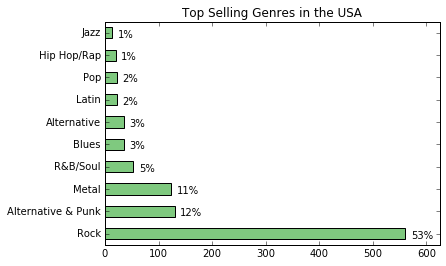

In [5]:
gen_sales_usa = run_query(album_purchase)
gen_sales_usa = gen_sales_usa[:10]
gen_sales_usa.set_index('genre', inplace=True, drop=True)

gen_sales_usa['quantity'].plot.barh( 
                       title = 'Top Selling Genres in the USA',
                       xlim = (0,625),
                       colormap=plt.cm.Accent) #plt.cm是设置color map
plt.ylabel('')

for i, label in enumerate(list(gen_sales_usa.index)): #enumerate函数同时返回索引和值！
    score = gen_sales_usa.loc[label, 'quantity']
    text = (gen_sales_usa.loc[label, 'percentage (%)']).astype(int).astype(str) + '%'
    plt.annotate(str(text),(score+10, i-0.2))   #plt.annotate加文本

plt.show()

通过对美国地区不同类型音乐订购数量的分析可知，在美国地区订购量前三的音乐类型分别是:
- Rock
- Punk
- Metal


其中Rock的订购量非常大，占据了53%的订购量。   

所以，如果该音乐商店准备采购新的专辑，在给出的四位候选人中，应该选择：Red Tone(Punk), Slim Jim Bites(Blues), Meteor and the Girls(Pop)。

## 该音乐商店员工的业绩情况分析

In [6]:
employee_performance = '''
    SELECT 
        e.first_name||' '||e.last_name 'employee name',
        SUM(i.total) 'total sales'
    FROM employee 'e'
    INNER JOIN customer 'c' ON c.support_rep_id == e.employee_id
    INNER JOIN invoice 'i' ON i.customer_id == c.customer_id
    GROUP BY 1
    ORDER BY 2 DESC;
    '''
run_query(employee_performance)

,employee name,total sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


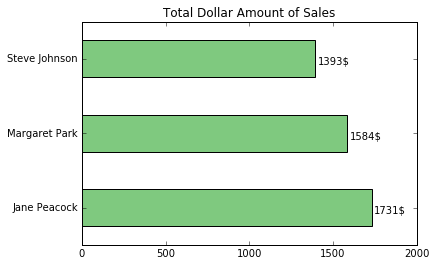

In [7]:
performance = run_query(employee_performance)
performance.set_index('employee name', inplace=True, drop=True)
performance['total sales'].plot.barh(title = 'Total Dollar Amount of Sales',
                                     xlim = (0,2000),
                                    colormap = plt.cm.Accent)
plt.ylabel('')

for i, label in enumerate(list(performance.index)):
    score = performance.loc[label, 'total sales'].astype(int)
    text = str(score) + '$'
    plt.annotate(str(text), (score+15, i-0.08))

plt.show()

通过分析各员工的销售总额可知，3个员工中业绩最好的是Jane Peacock。

## 各个国家的用户订购情况分析

In [8]:
c = '''DROP VIEW country_sales'''
run_command(c)

In [9]:
c = '''
CREATE VIEW country_sales AS
    SELECT
        c.country,
        COUNT(DISTINCT c.customer_id) 'total_customers',
        SUM(il.unit_price) 'total_sales',
        COUNT(DISTINCT i.invoice_id) 'total_order'
    FROM customer 'c'
    INNER JOIN invoice 'i' ON i.customer_id == c.customer_id
    INNER JOIN invoice_line 'il' ON il.invoice_id == i.invoice_id
    GROUP BY 1;
'''
run_command(c)

In [10]:
q = '''select * from country_sales'''
run_query(q)

,country,total_customers,total_sales,total_order
0,Argentina,1,39.60,5
1,Australia,1,81.18,10
2,Austria,1,69.30,9
3,Belgium,1,60.39,7
4,Brazil,5,427.68,61
5,Canada,8,535.59,76
6,Chile,1,97.02,13
7,Czech Republic,2,273.24,30
8,Denmark,1,37.62,10
9,Finland,1,79.20,11


In [11]:
country_purchase = '''
WITH other AS
    (
    SELECT
        CASE
            WHEN total_customers == 1 THEN 'Other'
            ELSE country
            END AS 'country',
        SUM(total_customers) 'total_customers',
        SUM(total_sales) 'total_sales',
        CAST(SUM(total_sales) as float) / SUM(total_customers) 'avg_sales',
        CAST(SUM(total_order) as float) / SUM(total_customers) 'avg_order_numbers'
    FROM country_sales 
    GROUP BY 1
    )
    
SELECT 
    country,
    total_customers,
    total_sales,
    avg_sales,
    avg_order_numbers
FROM                                
    (
     SELECT 
        country,
        total_customers,
        total_sales,
        avg_sales,
        avg_order_numbers,
        CASE 
            WHEN country == 'Other' THEN 1
            ELSE 0
        END AS 'sort'
     FROM other
     ORDER BY 6 ASC, 3 DESC
     )
'''
run_query(country_purchase)  
# 上面语句有两点需要注意：1.在with那一段添加sort列令other=1从而排序使other位于最底部行不通，因为
# with那一段才将人数为1 的国家归为other，当前的操作表中并没有该项，没办法动态填充！
# 2. order by b, c 两列，先对b排序,然后在第一次排序结果上对第二列排序！

,country,total_customers,total_sales,avg_sales,avg_order_numbers
0,USA,13,1040.49,80.037692,10.076923
1,Canada,8,535.59,66.948750,9.500000
2,Brazil,5,427.68,85.536000,12.200000
3,France,5,389.07,77.814000,10.000000
4,Germany,4,334.62,83.655000,10.250000
5,Czech Republic,2,273.24,136.620000,15.000000
6,United Kingdom,3,245.52,81.840000,9.333333
7,Portugal,2,185.13,92.565000,14.500000
8,India,2,183.15,91.575000,10.500000
9,Other,15,1094.94,72.996000,9.800000


注：在分析各个国家的用户订购情况时，注意到有的国家的用户数为1，因此将所有用户数为1 的国家全部归类为Other。一共有15个国家被归为Other。  

上表的结果展示了各个国家的用户数，总订购金额，每位用户的平均订购金额和每位用户的平均订购量。

## 各个国家的用户订购数据可视化

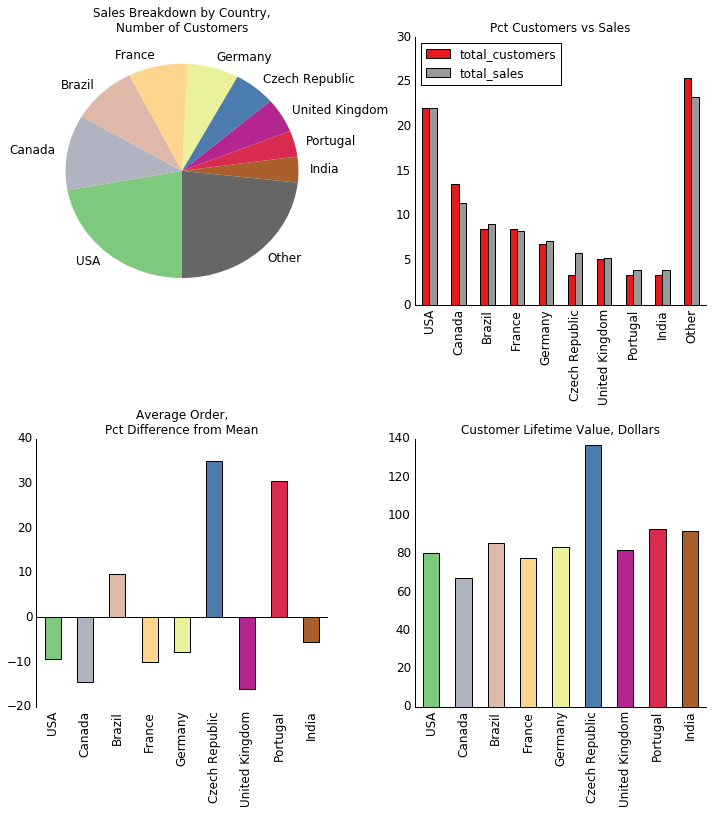

In [12]:
country_metrics = run_query(country_purchase)
country_metrics.set_index('country', drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

#create 2 by 2 figures
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax = ax1,
    startangle = -90,
    counterclock = False,
    title = 'Sales Breakdown by Country,\nNumber of Customers',
    colormap = plt.cm.Accent,
    fontsize = 12,
    wedgeprops = {'linewidth':0} )

# top right
cvd_cols = ['total_customers','total_sales']
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax = ax2,
    colormap = plt.cm.Set1,
    fontsize = 12,
    title = 'Pct Customers vs Sales' )
ax2.tick_params(top='off', right='off', left='off', bottom='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# bottom left
avg_order = country_metrics['avg_order_numbers'].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop('Other', inplace=True)
difference_from_avg.plot.bar(
    ax = ax3,
    color = colors,
    fontsize = 12,
    title = 'Average Order,\nPct Difference from Mean')
ax3.tick_params(top='off', right='off', left='off', bottom='off')
ax3.axhline(0, color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

# bottom right
ltv = country_metrics['avg_sales'].copy()
ltv.index.name = ''
ltv.drop('Other',inplace=True)
ltv.plot.bar(
    ax = ax4,
    color = colors,
    fontsize = 12,
    title = 'Customer Lifetime Value, Dollars')
ax4.tick_params(top='off', right='off', left='off', bottom='off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

基于以上图表，以下3个国家可能有增长潜力：
- Czech Republic
- India
- United Kingdom  

注：由于该数据库的样本数量比较少，所以Marketing团队应该谨慎一点，不要在营销活动上一次性投入太多钱。而应该在这些国家开展小规模的尝试，收集和分析新的用户数据，确保真实情况和当前的分析一致。

## 分析订购整张专辑的订单百分比

In [13]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id 'invoice_id',
         MIN(il.track_id) 'first_track_id'
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) 'number_of_invoices',
    CAST(count(invoice_id) as float) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) 'percent'
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track 't'
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track 't2'
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line 'il2'
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line 'il2'
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track 't'
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track 't2'
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS 'album_purchase'
     FROM invoice_first_track ifs
    )
GROUP BY 1
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


购买整张专辑的订单只占到总订单的18.6%，说明绝大部分的用户都只订购了专辑中的部分作品。  
根据该数据，我建议该音乐商店仅从唱片公司采购专辑中的部分流行作品。

## 分析不同类型的音乐中最受用户欢迎的艺术家

In [14]:
popular_artist = '''
WITH quantity_by_artist AS
    (
     SELECT 
         g.name 'genre',
         a.name 'artist',
         COUNT(il.invoice_id) 'quantity_invoices'
     FROM artist 'a'
     INNER JOIN album 'al' ON al.artist_id == a.artist_id
     INNER JOIN track 't' ON t.album_id == al.album_id
     INNER JOIN genre 'g' ON g.genre_id == t.genre_id
     INNER JOIN invoice_line 'il' ON il.track_id == t.track_id
     GROUP BY 2
    )
SELECT 
    genre,
    artist,
    MAX(quantity_invoices) 'quantity_invoices'
FROM quantity_by_artist
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(popular_artist)

,genre,artist,quantity_invoices
0,Rock,Queen,192
1,Metal,Guns N' Roses,124
2,Alternative & Punk,Green Day,105
3,R&B/Soul,Amy Winehouse,97
4,Latin,Eric Clapton,94
5,Easy Listening,Frank Sinatra,74
6,Jazz,Miles Davis,74
7,Alternative,Chris Cornell,50
8,Hip Hop/Rap,House Of Pain,31
9,Blues,Buddy Guy,23


作品订购数量最多的艺术家即认为是最受用户欢迎的艺术家。通过对每位艺术家作品的用户订购数量的统计，上表给出了不同类型音乐中用户订购作品数量最多的艺术家的名字及总订购数量。